# Tutorial 1: Basics

<img src="../../imgs/LightAutoML_logo_big.png" alt="LightAutoML logo" style="width:100%;"/>

Official LightAutoML github repository is [here](https://github.com/AILab-MLTools/LightAutoML)


In this tutorial you will learn how to:
* run LightAutoML training on tabular data
* obtain feature importances and reports
* configure resource usage in LightAutoML

## 0. Prerequisites

### 0.0. install LightAutoML

In [1]:
#!pip install -U lightautoml

### 0.1. Import libraries

Here we will import the libraries we use in this kernel:
- Standard python libraries for timing, working with OS and HTTP requests etc.
- Essential python DS libraries like numpy, pandas, scikit-learn and torch (the last we will use in the next cell)
- LightAutoML modules: presets for AutoML, task and report generation module

In [2]:
# Standard python libraries
import os
import time
import requests

# Essential DS libraries
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import torch

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


### 0.2. Constants

Here we setup some parameters to use in the kernel:
- `N_THREADS` - number of vCPUs for LightAutoML model creation
- `N_FOLDS` - number of folds in LightAutoML inner CV
- `RANDOM_STATE` - random seed for better reproducibility
- `TEST_SIZE` - houldout data part size 
- `TIMEOUT` - limit in seconds for model to train
- `TARGET_NAME` - target column name in dataset

In [3]:
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 42
TEST_SIZE = 0.2
TIMEOUT = 300
TARGET_NAME = 'TARGET'

In [4]:
DATASET_DIR = '../data/'
DATASET_NAME = 'sampled_app_train.csv'
DATASET_FULLNAME = os.path.join(DATASET_DIR, DATASET_NAME)
DATASET_URL = 'https://raw.githubusercontent.com/AILab-MLTools/LightAutoML/master/examples/data/sampled_app_train.csv'

### 0.3. Imported models setup

For better reproducibility fix numpy random seed with max number of threads for Torch (which usually try to use all the threads on server):

In [5]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

### 0.4. Data loading
Let's check the data we have:

In [6]:
if not os.path.exists(DATASET_FULLNAME):
    os.makedirs(DATASET_DIR, exist_ok=True)

    dataset = requests.get(DATASET_URL).text
    with open(DATASET_FULLNAME, 'w') as output:
        output.write(dataset)

In [7]:
data = pd.read_csv(DATASET_DIR + DATASET_NAME)
data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,313802,0,Cash loans,M,N,Y,0,270000.0,327024.0,15372.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,319656,0,Cash loans,F,N,N,0,108000.0,675000.0,19737.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,207678,0,Revolving loans,F,Y,Y,2,112500.0,270000.0,13500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
3,381593,0,Cash loans,F,N,N,1,67500.0,142200.0,9630.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,4.0
4,258153,0,Cash loans,F,Y,Y,0,337500.0,1483231.5,46570.5,...,0,0,0,0,0.0,0.0,0.0,2.0,0.0,0.0


In [8]:
data.shape

(10000, 122)

### 0.5. Data splitting for train-holdout
As we have only one file with target values, we can split it into 80%-20% for holdout usage:

In [9]:
tr_data, te_data = train_test_split(
    data, 
    test_size=TEST_SIZE, 
    stratify=data[TARGET_NAME], 
    random_state=RANDOM_STATE
)

print(f'Data is splitted. Parts sizes: tr_data = {tr_data.shape}, te_data = {te_data.shape}')

tr_data.head()

Data is splitted. Parts sizes: tr_data = (8000, 122), te_data = (2000, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
6444,112261,0,Cash loans,F,N,N,1,90000.0,640080.0,31261.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0
3586,115058,0,Cash loans,F,N,Y,0,180000.0,239850.0,23850.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
9349,326623,0,Cash loans,F,N,Y,0,112500.0,337500.0,31086.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
7734,191976,0,Cash loans,M,Y,Y,1,67500.0,135000.0,9018.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2174,281519,0,Revolving loans,F,N,Y,0,67500.0,202500.0,10125.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


Note: missing values (NaN and other) in the data should be left as is, unless the reason for their presence or their specific meaning are known. Otherwise, AutoML model will perceive the filled NaNs as a true pattern between the data and the target variable, without knowledge and assumptions about missing values, which can negatively affect the model quality. LighAutoML can deal with missing values and outliers automatically.

## 1. Task definition

### 1.1. Task type

First we need to create ```Task``` object - the class to setup what task LightAutoML model should solve with specific loss and metric if necessary (more info can be found [here](https://lightautoml.readthedocs.io/en/latest/pages/modules/generated/lightautoml.tasks.base.Task.html#lightautoml.tasks.base.Task) in our documentation).

The following task types are available:

- ```'binary'``` - for binary classification.

- ```'reg’``` - for regression.

- ```‘multiclass’``` - for multiclass classification.

- ```'multi:reg``` - for multiple regression.

- ```'multilabel'``` - for multi-label classification.

In this example we will consider a binary classification:

In [10]:
task = Task('binary')

Note: only logloss loss is available for binary task and it is the default loss. Default metric for binary classification is ROC-AUC. See more info about available and default losses and metrics [here](https://lightautoml.readthedocs.io/en/latest/pages/modules/generated/lightautoml.tasks.base.Task.html#lightautoml.tasks.base.Task). 

**Depending on the task, you can and shold choose exactly those metrics and losses that you want and need to optimize.**

### 1.2. Feature roles setup

To solve the task, we need to setup columns roles. LightAutoML can automatically define types and roles of data columns, but it is possible to specify it directly through the dictionary parameter ```roles``` when training AutoML model (see next section "AutoML training"). Specific roles can be specified using a string with the name (any role can be set like this).  So the key in dictionary must be the name of the role, the value must be a list of the names of the corresponding columns in dataset. The **only role you must setup is** ```'target'``` **role** (that is column with target variable obviously), everything else (```'drop', 'numeric', 'categorical', 'group', 'weights'``` etc) is up to user:

In [11]:
roles = {
    'target': TARGET_NAME,
    'drop': ['SK_ID_CURR']
}

You can also optionally specify the following roles:

- ```'numeric'``` - numerical feature

- ```'category'``` - categorical feature

- ```'text'``` - text data

- ```'datetime'``` - features with date and time 

- ```'date'``` - features with date only

- ```'group'``` - features by which the data can be divided into groups and which can be taken into account for group k-fold validation (so the same group is not represented in both testing and training sets)

- ```'drop'``` - features to drop, they will not be used in model building

- ```'weights'``` - object weights for the loss and metric

- ```'path'``` - image file paths (for CV tasks)

- ```'treatment'``` - object group in uplift modelling tasks: treatment or control

Note: role name can be written in any case. Also it is possible to pass individual objects of role classes with specific arguments instead of strings with role names for specific tasks and more optimal pipeline construction ([more details](https://github.com/sb-ai-lab/LightAutoML/blob/master/lightautoml/dataset/roles.py)).

For example, to set the date role, you can use the ```DatetimeRole``` class. 

In [12]:
#from lightautoml.dataset.roles import DatetimeRole

Different seasonality can be extracted from the data through the ```seasonality``` parameter: years (```'y'```), months (```'m'```), days (```'d'```), weekdays (```'wd'```), hours (```'hour'```), minutes (```'min'```), seconds (```'sec'```), milliseconds (```'ms'```), nanoseconds (```'ns'```). This features will be considered as categorical. Another important parameter is ```base_date```. It allows to specify the base date and convert the feature to the distances to this date (set to ```False``` by default). Also for all roles classes there is a ```force_input``` parameter, and if it is ```True```, then the corresponding features will pass all further feature selections and won't be excluded (equals ```False``` by default). Also it is always possible to specify data type for all roles using ```dtype``` argument.

Here is an example of such a role assignment through a class object for date feature (but there is no such feature in the considered dataset):

In [13]:
# roles = {
#     DatetimeRole(base_date=False, seasonality=('d', 'wd', 'hour')): 'date_time'
# }

Any role can be set through a class object. Information about specific parameters of specific roles and other datailed information can be found [here](https://github.com/sb-ai-lab/LightAutoML/blob/master/lightautoml/dataset/roles.py).

### 1.3. LightAutoML model creation - TabularAutoML preset

Next we are going to create LightAutoML model with `TabularAutoML` class - preset with default model structure in just several lines. 

In general, the whole AutoML model consists of multiple levels, which can contain several pipelines with their own set of data processing methods and ML models. The outputs of one level are the inputs of the next, and on the last level predictions of previous level models are combined with blending procedure. All this can be combined into a model using the ```AutoML``` class and its various descendants (like ```TabularAutoML```).

Let's look at how the LightAutoML model is arranged and what it consists in general.

![](https://raw.githubusercontent.com/sb-ai-lab/LightAutoML/master/imgs/tutorial_1_laml_big.png)

#### 1.3.1 Reader object

First the task and data go into ```Reader``` object. It analyzes the data and extracts various valuable information from them. Also it can detect and remove useless features, conduct feature selection, determine types and roles etc. Let's look at this steps in more detail.

**Role and types guessing**

Roles can be specified as a string or a specific class object, or defined automatically. For ```TabularAutoML``` preset ```'numeric'```, ```'datetime'``` and ```'category'``` roles can be automatically defined. There are two ways of role defining. **First** is very simple: check if the value can be converted to a date (```'datetime'```), otherwise check if it can be converted to a number (```'numeric'```), otherwise declare it a category (```'categorical'```). But this method may not work well on large data or when encoding categories with integers. The **second** method is based on statistics: the distributions of numerical features are considered, and how similar they are to the distributions of real or categorical value. Also different ways of feature encoding (as a number or as a category) are compared and based on normalized Gini index it is decided which encoding is better. For this case a set of specific rules is created, and if at least one of them is fullfilled, then the feature will be assigned to numerical, otherwise to categorical. This check can be enabled or disabled using the ```advanced_roles``` parameter. 

If roles are explicitly specified, automatic definition won't be applied to the specified dataset columns. In the case of specifying a role as an object of a certain class, through its arguments, it is possible to set the processing parameters in more detail.
 
**Feature selection**

In general, the AutoML pipeline uses pre-selection, generation and post-selection of features. ```TabularAutoML``` has no post-selection stage. There are three feature selection methods: its absence, using features importances and more strict selection (forward selection). The GBM model is used to evaluate features importances. Importances can be calculated in 2 ways: based on splits (how many times a split was made for each feature in the entire ensemble) or using permutation feature importances (mixing feature values during validation and assessing quality change in this case). Second method is harder but it requires holdout data. Then features with importance above a certain threshold are selected. Faster and more strict feature selection method is forward selection. Features are sorted in descending order of importance, then in blocks (size of 1 by default) a model is built based on selected features, and its quality is measured. Then the next block of features is added, and they are saved if the quality has improved with them, and so on.  

Also LightAutoML can merge some columns if it is adequate and leads to an improvement in the model quality (for example, an intersection between categorical variables). Different columns join options are considered, the best one is chosen by the normalized Gini index. 

#### 1.3.2 Machine learning pipelines architecture and training

As a result, after analyzing and processing the data, the ```Reader``` object forms and returns a ```LAMA Dataset```. It contains the original data and markup with metainformation. In this dataset it is possible to see the roles defined by the ```Reader``` object, selected features etc. Then ML pipelines are trained on this data. 

![](https://raw.githubusercontent.com/sb-ai-lab/LightAutoML/master/imgs/tutorial_1_ml_pipeline.png)

Each such pipeline is one or more machine learning algorithms that share one post-processing block and one validation scheme. Several such pipelines can be trained in parallel on one dataset, and they form a level. Number of levels can be unlimited as possible. List of all levels of AutoML pipeline is available via ```.levels``` attribute of ```AutoML``` instance. Level predictions can be inputs to other models or ML pipelines (i. e. stacking scheme). As inputs for subsequent levels, it is possible to use the original data by setting ```skip_conn``` argument in ```True``` when initializing preset instance. At the last level, if there are several pipelines, blending is used to build a prediction. 

Different types of features are processed depending on the models. Numerical features are processed for linear model preprocessing: standardization, replacing missing values with median, discretization, log odds (if feature is probability - output of previous level). Categories are processed using label encoding (by default), one hot encoding, ordinal encoding, frequency encoding, out of fold target encoding. 

The following algorithms are available in the LightAutoML: linear regression with L2 regularization, LightGBM, CatBoost, random forest. 

By default KFold cross-validation is used during training at all levels (for hyperparameter optimization and building out-of-fold prediction during training), and for each algorithm a separate model is built for each validation fold, and their predictions are averaged. So the predictions at each level and the resulting prediction during training are out-of-fold predictions. But it is also possible to just pass a holdout data for validation or use custom cross-validation schemes, setting ```cv_iter``` iterator returning the indices of the objects for validation. LightAutoML has ready-made iterators, for example, ```TimeSeriesIterator``` for time series split. To further reduce the effect of overfitting, it is possible to use nested cross-validation (```nested_cv``` parameter), but it is not used by default. 

Prediction on new data is the averaging of models over all folds from validation and blending. 

Hyperparameter tuning of machine learning algorithms can be performed during training (early stopping by the number of trees in gradient boosting or the number of training epochs of neural networks etc), based on expert rules (according to data characteristics and empirical recommendations, so-called expert parameters), by the sequential model-based optimization (SMBO, bayesian optimization: Optuna with TPESampler) or by grid search. LightGBM and CatBoost can be used with parameter tuning or with expert parameters, with no tuning. For linear regression parameters are always tuned using warm start model training technique. 

At the last level blending is used to build a prediction. There are three available blending methods: choosing the best model based on a given metric (other models are just discarded), simple averaging of all models, or weighted averaging (weights are selected using coordinate descent algorithm with optimization of a given metric). ```TabularAutoML ``` uses the latter strategy by default. It is worth noting that, unlike stacking, blending can exclude models from composition. 

#### 1.3.3 Timing

When creating AutoML object, a certain time limit is set, and it schedules a list of tasks that it can complete during this time, and it will initially allocate approximately equal time for each task. In the process of solving objectives, it understands how to adjust the time allocated to different subtasks. If AutoML finished working earlier than set timeout, it means that it completed the entire list of tasks. If AutoML worked to the limit and turned off, then most likely it sacrificed something, for example, reduced the number of algorithms for training, realized that it would not have time to train the next one, or it might not calculate the full cross-validation cycle for one of the models (then on folds, where the model has not trained, the predictiuons will be NaN, and the model related to this fold will not participate in the final averaging). The resulting quality is evaluated at the blending stage, and if necessary and possible, the composition will be corrected. 

If you do not set the time for AutoML during initialization, then by default it will be equal to a very large number, that is, sooner or later AutoML will complete all tasks. 

#### 1.3.4 LightAutoML model creation

So the entire AutoML pipeline can be composed from various parts by user (see [custom pipeline tutorial](https://github.com/sb-ai-lab/LightAutoML/blob/master/examples/tutorials/Tutorial_6_custom_pipeline.ipynb)), but it is possible to use presets - in a certain sense, fixed strategies for dynamic pipeline building. 

Here is a default AutoML pipeline for binary classification and regression tasks (```TabularAutoML``` preset):

![](https://raw.githubusercontent.com/sb-ai-lab/LightAutoML/ac3c1b38873437eb74354fb44e68a449a0200aa6/imgs/tutorial_blackbox_pipeline.png)

Another example:

![](https://raw.githubusercontent.com/sb-ai-lab/LightAutoML/ac3c1b38873437eb74354fb44e68a449a0200aa6/imgs/tutorial_1_pipeline.png)

Let's discuss some of the params we can setup:
- `task` - the type of the ML task (the only **must have** parameter)
- `timeout` - time limit in seconds for model to train
- `cpu_limit` - vCPU count for model to use
- `reader_params` - parameter change for ```Reader``` object inside preset, which works on the first step of data preparation: automatic feature typization, preliminary almost-constant features, correct CV setup etc. For example, we setup `n_jobs` threads for typization algo, `cv` folds and `random_state` as inside CV seed.
- `general_params` - general parameters dictionary, in which it is possible to specify a list of algorithms used (```'use_algos'```), nested CV using (```'nested_cv'```) etc.

**Important note**: `reader_params` key is one of the YAML config keys, which is used inside `TabularAutoML` preset. [More details](https://github.com/sb-ai-lab/LightAutoML/blob/master/lightautoml/automl/presets/tabular_config.yml) on its structure with explanation comments can be found on the link attached. Each key from this config can be modified with user settings during preset object initialization. To get more info about different parameters setting (for example, ML algos which can be used in `general_params->use_algos`) please take a look at our [article on TowardsDataScience](https://towardsdatascience.com/lightautoml-preset-usage-tutorial-2cce7da6f936).

Moreover, to receive the automatic report for our model we will use `ReportDeco` decorator and work with the decorated version in the same way as we do with usual one. 

In [14]:
automl = TabularAutoML(
    task = task, 
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
)

## 2. AutoML training

To run autoML training use ```fit_predict``` method. 

Main arguments:

- `train_data` - dataset to train.
- `roles` - column roles dict.
- `verbose` - controls the verbosity: the higher, the more messages:
        <1  : messages are not displayed;
        >=1 : the computation process for layers is displayed;
        >=2 : the information about folds processing is also displayed;
        >=3 : the hyperparameters optimization process is also displayed;
        >=4 : the training process for every algorithm is displayed;

Note: out-of-fold prediction is calculated during training and returned from the fit_predict method

In [15]:
%%time 
oof_pred = automl.fit_predict(tr_data, roles = roles, verbose = 1)

[12:19:52] Stdout logging level is INFO.
[12:19:52] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[12:19:52] Task: binary

[12:19:52] Start automl preset with listed constraints:
[12:19:52] - time: 300.00 seconds
[12:19:52] - CPU: 4 cores
[12:19:52] - memory: 16 GB

[12:19:52] Train data shape: (8000, 122)

[12:19:55] Layer 1 train process start. Time left 297.19 secs
[12:19:56] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[12:19:58] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.7353822401571196
[12:19:58] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[12:19:58] Time left 294.14 secs

[12:20:01] Selector_LightGBM fitting and predicting completed
[12:20:01] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[12:20:19] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.735377350367659
[12:20:19] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[12:20:19] Start hyperparameters optimization for Lvl_0

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[12:20:29] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[12:20:29] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[12:20:44] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.7082964207378947
[12:20:44] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[12:20:44] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
[12:20:48] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.7174998549008127
[12:20:48] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[12:20:48] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 161.23 secs


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://gi

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://gi

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://gi

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://gi

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://gi

[12:22:38] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
[12:22:38] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...
[12:22:46] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = 0.7463309039583695
[12:22:46] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
[12:22:46] Time left 126.18 secs

[12:22:46] Layer 1 training completed.

[12:22:46] Blending: optimization starts with equal weights and score 0.7521497534164215
[12:22:46] Blending: iteration 0: score = 0.7528270955564782, weights = [0.1629748  0.19889754 0.21934399 0.11643101 0.3023527 ]
[12:22:46] Blending: iteration 1: score = 0.7528800328423773, weights = [0.1954762  0.19353388 0.2098434  0.11188982 0.28925666]
[12:22:47] Blending: iteration 2: score = 0.7528570720918668, weights = [0.19407688 0.19387048 0.21020836 0.11208443 0.28975976]
[12:22:47] Blending: iteration 3: score = 0.7528570720918668, weights = [0.19407688 0.19387048 0.21020836 0.11208443 0.28975976]
[1

After training we can see logs with all the progress, final scores, weights assigned to the models in the final prediction etc.

Note that in this `fit_predict` you receive the model with only 3 out of 5 LightGBM models (you can see that from the log line in the end `0.25685 * (3 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM)`) - to fix it you can set the bigger timeout to make LightAutoML train all the models.

## 3. Prediction on holdout and model evaluation

Now we can use trained AutoML model to build predictions on holdout and evaluate model quality. Note that in case of classification tasks LightAutoML model returns probabilities as predictions.

In [15]:
%%time

te_pred = automl.predict(te_data)
print(f'Prediction for te_data:\n{te_pred}\nShape = {te_pred.shape}')

Prediction for te_data:
array([[0.05342757],
       [0.06397148],
       [0.02700327],
       ...,
       [0.05227499],
       [0.03477021],
       [0.19358692]], dtype=float32)
Shape = (2000, 1)
CPU times: user 1.78 s, sys: 87.5 ms, total: 1.86 s
Wall time: 945 ms


In [16]:
print(f'OOF score: {roc_auc_score(tr_data[TARGET_NAME].values, oof_pred.data[:, 0])}')
print(f'HOLDOUT score: {roc_auc_score(te_data[TARGET_NAME].values, te_pred.data[:, 0])}')

OOF score: 0.752907883382348
HOLDOUT score: 0.7324524456521739


## 4. Model analysis

### 4.1. Reports

You can obtain the description of the resulting pipeline:

In [17]:
print(automl.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 0.20000 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.18829 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.20741 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.09476 * (5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) +
	 0.30954 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 


Also for this purposes LightAutoML have ```ReportDeco```, use it to build detailed reports:

In [18]:
RD = ReportDeco(output_path = 'tabularAutoML_model_report')

automl_rd = RD(
    TabularAutoML(
        task = task, 
        timeout = TIMEOUT,
        cpu_limit = N_THREADS,
        reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
    )
)

In [19]:
%%time
oof_pred = automl_rd.fit_predict(tr_data, roles = roles, verbose = 1)

[09:18:43] Stdout logging level is INFO3.
[09:18:43] Task: binary

[09:18:43] Start automl preset with listed constraints:
[09:18:43] - time: 300.00 seconds
[09:18:43] - CPU: 4 cores
[09:18:43] - memory: 16 GB

[09:18:43] Train data shape: (8000, 122)

[09:18:44] Feats was rejected during automatic roles guess: []
[09:18:44] Layer 1 train process start. Time left 299.28 secs
[09:18:45] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[09:18:45] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[09:18:45] Linear model: C = 1e-05 score = 0.6796136226352563
[09:18:45] Linear model: C = 5e-05 score = 0.7046362076430873
[09:18:45] Linear model: C = 0.0001 score = 0.7182673958015939
[09:18:45] Linear model: C = 0.0005 score = 0.758572948238904
[09:18:45] Linear model: C = 0.001 score = 0.7666394042903496
[09:18:45] Linear model: C = 0.005 score = 0.7702476599793662
[09:18:45] Linear model: C = 0.01 score = 0.7683339480731914
[09:18:45] Linear model: C = 0.05 score = 0.760320

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:19:06] [100]	valid's auc: 0.737581
[09:19:08] [200]	valid's auc: 0.741697
[09:19:10] [300]	valid's auc: 0.743012
[09:19:11] [400]	valid's auc: 0.74306
[09:19:12] [500]	valid's auc: 0.743953
[09:19:13] [600]	valid's auc: 0.742777
[09:19:14] Early stopping, best iteration is:
[467]	valid's auc: 0.744819
[09:19:14] Trial 1 with hyperparameters {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07} scored 0.7448188121087715 in 0:00:08.976948
[09:19:14] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[09:19:14] The set of hyperparameters {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}
 achieve 0.7448 auc
[09:19:14] Start 

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:19:30] 100:	test: 0.7336840	best: 0.7342506 (99)	total: 194ms	remaining: 9.42s
[09:19:31] 200:	test: 0.7393770	best: 0.7437657 (154)	total: 431ms	remaining: 10.3s
[09:19:31] Stopped by overfitting detector  (100 iterations wait)
[09:19:31] bestTest = 0.743765736
[09:19:31] bestIteration = 154
[09:19:31] Shrink model to first 155 iterations.
[09:19:31] Trial 1 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0024430162614261413, 'min_data_in_leaf': 4} scored 0.7437657360039771 in 0:00:00.706389
[09:19:31] 0:	test: 0.5627756	best: 0.5627756 (0)	total: 3.42ms	remaining: 17.1s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:19:31] 100:	test: 0.7331494	best: 0.7331494 (100)	total: 319ms	remaining: 15.5s
[09:19:32] 200:	test: 0.7474756	best: 0.7477054 (198)	total: 592ms	remaining: 14.1s
[09:19:32] 300:	test: 0.7452732	best: 0.7501216 (213)	total: 773ms	remaining: 12.1s
[09:19:32] Stopped by overfitting detector  (100 iterations wait)
[09:19:32] bestTest = 0.7501216116
[09:19:32] bestIteration = 213
[09:19:32] Shrink model to first 214 iterations.
[09:19:32] Trial 2 with hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.002570603566117598, 'min_data_in_leaf': 15} scored 0.7501216115806297 in 0:00:00.957439
[09:19:32] 0:	test: 0.5618802	best: 0.5618802 (0)	total: 2.22ms	remaining: 11.1s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:19:32] 100:	test: 0.7543018	best: 0.7543018 (100)	total: 153ms	remaining: 7.42s
[09:19:32] 200:	test: 0.7590968	best: 0.7596421 (189)	total: 302ms	remaining: 7.2s
[09:19:32] 300:	test: 0.7587280	best: 0.7646134 (250)	total: 447ms	remaining: 6.98s
[09:19:32] Stopped by overfitting detector  (100 iterations wait)
[09:19:32] bestTest = 0.7646134355
[09:19:32] bestIteration = 250
[09:19:32] Shrink model to first 251 iterations.
[09:19:32] Trial 3 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 8.148018307012941e-07, 'min_data_in_leaf': 4} scored 0.7646134355405166 in 0:00:00.636395
[09:19:33] 0:	test: 0.5627756	best: 0.5627756 (0)	total: 2.22ms	remaining: 11.1s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:19:33] 100:	test: 0.7300651	best: 0.7306798 (84)	total: 164ms	remaining: 7.93s
[09:19:33] 200:	test: 0.7357100	best: 0.7357100 (200)	total: 319ms	remaining: 7.62s
[09:19:33] 300:	test: 0.7344431	best: 0.7388211 (258)	total: 468ms	remaining: 7.3s
[09:19:33] Stopped by overfitting detector  (100 iterations wait)
[09:19:33] bestTest = 0.7388210893
[09:19:33] bestIteration = 258
[09:19:33] Shrink model to first 259 iterations.
[09:19:33] Trial 4 with hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 7.71800699380605e-05, 'min_data_in_leaf': 6} scored 0.7388210893190286 in 0:00:00.678304
[09:19:33] 0:	test: 0.5713366	best: 0.5713366 (0)	total: 3.18ms	remaining: 15.9s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:19:33] 100:	test: 0.6882521	best: 0.6882521 (100)	total: 256ms	remaining: 12.4s
[09:19:34] 200:	test: 0.6977030	best: 0.7155518 (167)	total: 505ms	remaining: 12.1s
[09:19:34] Stopped by overfitting detector  (100 iterations wait)
[09:19:34] bestTest = 0.7155518493
[09:19:34] bestIteration = 167
[09:19:34] Shrink model to first 168 iterations.
[09:19:34] Trial 5 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 1.9826980964985924e-05, 'min_data_in_leaf': 10} scored 0.7155518492978602 in 0:00:00.789413
[09:19:34] 0:	test: 0.5713526	best: 0.5713526 (0)	total: 4.17ms	remaining: 20.9s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:19:34] 100:	test: 0.6930684	best: 0.6949875 (56)	total: 319ms	remaining: 15.5s
[09:19:35] 200:	test: 0.6878511	best: 0.7004506 (162)	total: 617ms	remaining: 14.7s
[09:19:35] Stopped by overfitting detector  (100 iterations wait)
[09:19:35] bestTest = 0.700450631
[09:19:35] bestIteration = 162
[09:19:35] Shrink model to first 163 iterations.
[09:19:35] Trial 6 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0021465011216654484, 'min_data_in_leaf': 1} scored 0.7004506310438283 in 0:00:01.063293
[09:19:35] 0:	test: 0.5752976	best: 0.5752976 (0)	total: 3.99ms	remaining: 20s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:19:35] 100:	test: 0.7444393	best: 0.7445408 (99)	total: 302ms	remaining: 14.6s
[09:19:36] 200:	test: 0.7513939	best: 0.7537940 (161)	total: 601ms	remaining: 14.4s
[09:19:36] 300:	test: 0.7517146	best: 0.7542270 (263)	total: 904ms	remaining: 14.1s
[09:19:36] Stopped by overfitting detector  (100 iterations wait)
[09:19:36] bestTest = 0.7542270047
[09:19:36] bestIteration = 263
[09:19:36] Shrink model to first 264 iterations.
[09:19:36] Trial 7 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 3.4671276804481113, 'min_data_in_leaf': 20} scored 0.754227004720133 in 0:00:01.223706
[09:19:36] 0:	test: 0.5716920	best: 0.5716920 (0)	total: 4.33ms	remaining: 21.7s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:19:37] 100:	test: 0.7000069	best: 0.7087363 (77)	total: 334ms	remaining: 16.2s
[09:19:37] 200:	test: 0.7010600	best: 0.7128363 (145)	total: 663ms	remaining: 15.8s
[09:19:37] Stopped by overfitting detector  (100 iterations wait)
[09:19:37] bestTest = 0.7128363028
[09:19:37] bestIteration = 145
[09:19:37] Shrink model to first 146 iterations.
[09:19:37] Trial 8 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.014391207615728067, 'min_data_in_leaf': 9} scored 0.7128363027941264 in 0:00:00.923451
[09:19:37] 0:	test: 0.5618802	best: 0.5618802 (0)	total: 2.3ms	remaining: 11.5s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:19:37] 100:	test: 0.7494160	best: 0.7497100 (99)	total: 168ms	remaining: 8.13s
[09:19:38] 200:	test: 0.7547509	best: 0.7553175 (175)	total: 321ms	remaining: 7.66s
[09:19:38] 300:	test: 0.7585035	best: 0.7585035 (300)	total: 475ms	remaining: 7.41s
[09:19:38] 400:	test: 0.7613313	best: 0.7619513 (377)	total: 629ms	remaining: 7.21s
[09:19:38] 500:	test: 0.7610159	best: 0.7624218 (476)	total: 784ms	remaining: 7.04s
[09:19:38] 600:	test: 0.7620850	best: 0.7642767 (558)	total: 938ms	remaining: 6.87s
[09:19:38] Stopped by overfitting detector  (100 iterations wait)
[09:19:38] bestTest = 0.764276665
[09:19:38] bestIteration = 558
[09:19:38] Shrink model to first 559 iterations.
[09:19:38] Trial 9 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.527156759251193, 'min_data_in_leaf': 6} scored 0.7642766650095418 in 0:00:01.168875
[09:19:38] 0:	test: 0.5713366	best: 0.5713366 (0)	total: 5.06ms	remaining: 25.3s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:19:39] 100:	test: 0.7183797	best: 0.7183797 (100)	total: 335ms	remaining: 16.3s
[09:19:39] 200:	test: 0.7095114	best: 0.7192189 (101)	total: 659ms	remaining: 15.7s
[09:19:39] Stopped by overfitting detector  (100 iterations wait)
[09:19:39] bestTest = 0.7192189062
[09:19:39] bestIteration = 101
[09:19:39] Shrink model to first 102 iterations.
[09:19:39] Trial 10 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0008325158565947976, 'min_data_in_leaf': 4} scored 0.7192189061906977 in 0:00:00.777676
[09:19:39] 0:	test: 0.5434995	best: 0.5434995 (0)	total: 2.84ms	remaining: 14.2s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:19:39] 100:	test: 0.7400720	best: 0.7424133 (63)	total: 179ms	remaining: 8.7s
[09:19:40] 200:	test: 0.7502232	best: 0.7521155 (157)	total: 353ms	remaining: 8.42s
[09:19:40] 300:	test: 0.7570815	best: 0.7589578 (278)	total: 526ms	remaining: 8.22s
[09:19:40] Stopped by overfitting detector  (100 iterations wait)
[09:19:40] bestTest = 0.7589578288
[09:19:40] bestIteration = 278
[09:19:40] Shrink model to first 279 iterations.
[09:19:40] Trial 11 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 1.1692997958212103e-08, 'min_data_in_leaf': 14} scored 0.7589578288457325 in 0:00:00.788283
[09:19:40] 0:	test: 0.5434995	best: 0.5434995 (0)	total: 3.3ms	remaining: 16.5s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:19:40] 100:	test: 0.7365866	best: 0.7416168 (70)	total: 241ms	remaining: 11.7s
[09:19:40] 200:	test: 0.7469303	best: 0.7497528 (143)	total: 461ms	remaining: 11s
[09:19:41] 300:	test: 0.7293648	best: 0.7505332 (219)	total: 680ms	remaining: 10.6s
[09:19:41] Stopped by overfitting detector  (100 iterations wait)
[09:19:41] bestTest = 0.75053322
[09:19:41] bestIteration = 219
[09:19:41] Shrink model to first 220 iterations.
[09:19:41] Trial 12 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 3.5637622153646024e-07, 'min_data_in_leaf': 1} scored 0.7505332200073769 in 0:00:00.862705
[09:19:41] 0:	test: 0.5663438	best: 0.5663438 (0)	total: 2.31ms	remaining: 11.6s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:19:41] 100:	test: 0.7473259	best: 0.7518001 (74)	total: 171ms	remaining: 8.29s
[09:19:41] 200:	test: 0.7554992	best: 0.7562156 (190)	total: 329ms	remaining: 7.86s
[09:19:41] 300:	test: 0.7581560	best: 0.7586745 (292)	total: 486ms	remaining: 7.59s
[09:19:42] 400:	test: 0.7607112	best: 0.7609357 (397)	total: 643ms	remaining: 7.37s
[09:19:42] 500:	test: 0.7610105	best: 0.7628547 (479)	total: 799ms	remaining: 7.18s
[09:19:42] Stopped by overfitting detector  (100 iterations wait)
[09:19:42] bestTest = 0.762854745
[09:19:42] bestIteration = 479
[09:19:42] Shrink model to first 480 iterations.
[09:19:42] Trial 13 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 8.53024859034856, 'min_data_in_leaf': 6} scored 0.7628547449898702 in 0:00:01.052256
[09:19:42] 0:	test: 0.5434995	best: 0.5434995 (0)	total: 2.48ms	remaining: 12.4s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:19:42] 100:	test: 0.7327539	best: 0.7341223 (72)	total: 181ms	remaining: 8.79s
[09:19:42] 200:	test: 0.7415046	best: 0.7423064 (161)	total: 398ms	remaining: 9.51s
[09:19:43] 300:	test: 0.7450914	best: 0.7453159 (299)	total: 587ms	remaining: 9.16s
[09:19:43] 400:	test: 0.7475557	best: 0.7483041 (396)	total: 764ms	remaining: 8.76s
[09:19:43] 500:	test: 0.7496565	best: 0.7502392 (492)	total: 940ms	remaining: 8.44s
[09:19:43] 600:	test: 0.7449150	best: 0.7512602 (546)	total: 1.12s	remaining: 8.17s
[09:19:43] Stopped by overfitting detector  (100 iterations wait)
[09:19:43] bestTest = 0.7512602167
[09:19:43] bestIteration = 546
[09:19:43] Shrink model to first 547 iterations.
[09:19:43] Trial 14 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.16505863700695894, 'min_data_in_leaf': 7} scored 0.751260216709164 in 0:00:01.329381
[09:19:43] 0:	test: 0.5394770	best: 0.5394770 (0)	total: 3.09ms	remaining: 15.4s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:19:43] 100:	test: 0.7597971	best: 0.7649823 (75)	total: 216ms	remaining: 10.5s
[09:19:44] Stopped by overfitting detector  (100 iterations wait)
[09:19:44] bestTest = 0.7649822795
[09:19:44] bestIteration = 75
[09:19:44] Shrink model to first 76 iterations.
[09:19:44] Trial 15 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 2.5288301253466852e-06, 'min_data_in_leaf': 13} scored 0.764982279455394 in 0:00:00.491116
[09:19:44] 0:	test: 0.5394342	best: 0.5394342 (0)	total: 2.64ms	remaining: 13.2s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:19:44] 100:	test: 0.7144239	best: 0.7160918 (86)	total: 212ms	remaining: 10.3s
[09:19:44] 200:	test: 0.7213357	best: 0.7293274 (184)	total: 417ms	remaining: 9.96s
[09:19:44] Stopped by overfitting detector  (100 iterations wait)
[09:19:44] bestTest = 0.7293273677
[09:19:44] bestIteration = 184
[09:19:44] Shrink model to first 185 iterations.
[09:19:44] Trial 16 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 2.5297723748825485e-06, 'min_data_in_leaf': 13} scored 0.7293273676839276 in 0:00:00.718221
[09:19:44] 0:	test: 0.5394342	best: 0.5394342 (0)	total: 3.89ms	remaining: 19.4s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:19:45] 100:	test: 0.7302522	best: 0.7317596 (91)	total: 276ms	remaining: 13.4s
[09:19:45] 200:	test: 0.7458238	best: 0.7518375 (156)	total: 540ms	remaining: 12.9s
[09:19:45] Stopped by overfitting detector  (100 iterations wait)
[09:19:45] bestTest = 0.7518375376
[09:19:45] bestIteration = 156
[09:19:45] Shrink model to first 157 iterations.
[09:19:45] Trial 17 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 8.505946250822004e-08, 'min_data_in_leaf': 17} scored 0.7518375376194064 in 0:00:00.812561
[09:19:45] 0:	test: 0.5717161	best: 0.5717161 (0)	total: 9.13ms	remaining: 45.6s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:19:46] 100:	test: 0.6753799	best: 0.6769943 (98)	total: 455ms	remaining: 22.1s
[09:19:46] Stopped by overfitting detector  (100 iterations wait)
[09:19:46] bestTest = 0.6769942963
[09:19:46] bestIteration = 98
[09:19:46] Shrink model to first 99 iterations.
[09:19:46] Trial 18 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 4.814877802472197e-06, 'min_data_in_leaf': 12} scored 0.6769942962832294 in 0:00:01.002709
[09:19:46] 0:	test: 0.5394770	best: 0.5394770 (0)	total: 2.93ms	remaining: 14.7s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:19:47] 100:	test: 0.7491915	best: 0.7618231 (68)	total: 210ms	remaining: 10.2s
[09:19:47] Stopped by overfitting detector  (100 iterations wait)
[09:19:47] bestTest = 0.7618230511
[09:19:47] bestIteration = 68
[09:19:47] Shrink model to first 69 iterations.
[09:19:47] Trial 19 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 3.825986453633802e-07, 'min_data_in_leaf': 16} scored 0.7618230511410107 in 0:00:00.607700
[09:19:47] 0:	test: 0.5394342	best: 0.5394342 (0)	total: 2.55ms	remaining: 12.8s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:19:47] 100:	test: 0.7112113	best: 0.7133816 (88)	total: 213ms	remaining: 10.3s
[09:19:47] 200:	test: 0.7109172	best: 0.7173640 (187)	total: 422ms	remaining: 10.1s
[09:19:48] Stopped by overfitting detector  (100 iterations wait)
[09:19:48] bestTest = 0.7173639955
[09:19:48] bestIteration = 187
[09:19:48] Shrink model to first 188 iterations.
[09:19:48] Trial 20 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 9.353880482713996e-05, 'min_data_in_leaf': 19} scored 0.7173639954883441 in 0:00:00.723714
[09:19:48] 0:	test: 0.5434995	best: 0.5434995 (0)	total: 2.51ms	remaining: 12.6s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:19:48] 100:	test: 0.7373029	best: 0.7392113 (94)	total: 178ms	remaining: 8.64s
[09:19:48] 200:	test: 0.7360895	best: 0.7477108 (127)	total: 355ms	remaining: 8.48s
[09:19:48] Stopped by overfitting detector  (100 iterations wait)
[09:19:48] bestTest = 0.7477107622
[09:19:48] bestIteration = 127
[09:19:48] Shrink model to first 128 iterations.
[09:19:48] Trial 21 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 2.3847107404542568e-08, 'min_data_in_leaf': 11} scored 0.7477107622239685 in 0:00:00.527812
[09:19:48] 0:	test: 0.5618802	best: 0.5618802 (0)	total: 2.44ms	remaining: 12.2s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:19:48] 100:	test: 0.7440651	best: 0.7458131 (99)	total: 178ms	remaining: 8.61s
[09:19:49] 200:	test: 0.7553923	best: 0.7559750 (180)	total: 354ms	remaining: 8.46s
[09:19:49] 300:	test: 0.7533878	best: 0.7567394 (219)	total: 529ms	remaining: 8.25s
[09:19:49] Stopped by overfitting detector  (100 iterations wait)
[09:19:49] bestTest = 0.7567394198
[09:19:49] bestIteration = 219
[09:19:49] Shrink model to first 220 iterations.
[09:19:49] Trial 22 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.4013385162639602, 'min_data_in_leaf': 3} scored 0.756739419792485 in 0:00:00.687544
[09:19:49] 0:	test: 0.5618802	best: 0.5618802 (0)	total: 2.22ms	remaining: 11.1s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:19:49] 100:	test: 0.7304606	best: 0.7311235 (99)	total: 154ms	remaining: 7.46s
[09:19:49] 200:	test: 0.7390242	best: 0.7390242 (200)	total: 302ms	remaining: 7.21s
[09:19:49] 300:	test: 0.7434022	best: 0.7451128 (243)	total: 453ms	remaining: 7.08s
[09:19:49] 400:	test: 0.7453854	best: 0.7467753 (311)	total: 601ms	remaining: 6.89s
[09:19:49] Stopped by overfitting detector  (100 iterations wait)
[09:19:49] bestTest = 0.7467752885
[09:19:49] bestIteration = 311
[09:19:49] Shrink model to first 312 iterations.
[09:19:50] Trial 23 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 2.524258159019582e-06, 'min_data_in_leaf': 8} scored 0.7467752885268161 in 0:00:00.742071
[09:19:50] 0:	test: 0.5618802	best: 0.5618802 (0)	total: 2.25ms	remaining: 11.2s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:19:50] 100:	test: 0.7382545	best: 0.7385752 (99)	total: 152ms	remaining: 7.35s
[09:19:50] 200:	test: 0.7530563	best: 0.7537459 (198)	total: 300ms	remaining: 7.15s
[09:19:50] 300:	test: 0.7551892	best: 0.7553335 (286)	total: 449ms	remaining: 7.01s
[09:19:50] 400:	test: 0.7560445	best: 0.7581079 (365)	total: 599ms	remaining: 6.87s
[09:19:50] 500:	test: 0.7635497	best: 0.7637902 (498)	total: 749ms	remaining: 6.73s
[09:19:51] 600:	test: 0.7568570	best: 0.7652763 (520)	total: 898ms	remaining: 6.57s
[09:19:51] Stopped by overfitting detector  (100 iterations wait)
[09:19:51] bestTest = 0.7652762855
[09:19:51] bestIteration = 520
[09:19:51] Shrink model to first 521 iterations.
[09:19:51] Trial 24 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 4.599154751676817e-07, 'min_data_in_leaf': 5} scored 0.765276285474499 in 0:00:01.058499
[09:19:51] 0:	test: 0.5434995	best: 0.5434995 (0)	total: 2.54ms	remaining: 12.7s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:19:51] 100:	test: 0.7280819	best: 0.7444179 (91)	total: 178ms	remaining: 8.65s
[09:19:51] Stopped by overfitting detector  (100 iterations wait)
[09:19:51] bestTest = 0.7444178948
[09:19:51] bestIteration = 91
[09:19:51] Shrink model to first 92 iterations.
[09:19:51] Trial 25 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 3.414438335391893e-07, 'min_data_in_leaf': 3} scored 0.744417894809992 in 0:00:00.451919
[09:19:51] 0:	test: 0.5618802	best: 0.5618802 (0)	total: 2.86ms	remaining: 14.3s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:19:51] 100:	test: 0.7389494	best: 0.7389494 (100)	total: 195ms	remaining: 9.47s
[09:19:51] 200:	test: 0.7493519	best: 0.7493519 (200)	total: 345ms	remaining: 8.25s
[09:19:52] 300:	test: 0.7499773	best: 0.7533022 (278)	total: 495ms	remaining: 7.72s
[09:19:52] Stopped by overfitting detector  (100 iterations wait)
[09:19:52] bestTest = 0.7533022222
[09:19:52] bestIteration = 278
[09:19:52] Shrink model to first 279 iterations.
[09:19:52] Trial 26 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.1810105235670652e-05, 'min_data_in_leaf': 9} scored 0.753302222150948 in 0:00:00.740067
[09:19:52] 0:	test: 0.5558932	best: 0.5558932 (0)	total: 2.61ms	remaining: 13.1s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:19:52] 100:	test: 0.7247729	best: 0.7276863 (97)	total: 187ms	remaining: 9.06s
[09:19:52] 200:	test: 0.7409647	best: 0.7420445 (189)	total: 359ms	remaining: 8.58s
[09:19:52] Stopped by overfitting detector  (100 iterations wait)
[09:19:52] bestTest = 0.7420444644
[09:19:52] bestIteration = 189
[09:19:52] Shrink model to first 190 iterations.
[09:19:52] Trial 27 with hyperparameters {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 8.56072982547498e-07, 'min_data_in_leaf': 11} scored 0.7420444644012166 in 0:00:00.633621
[09:19:53] 0:	test: 0.5618802	best: 0.5618802 (0)	total: 2.28ms	remaining: 11.4s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:19:53] 100:	test: 0.7514313	best: 0.7517467 (98)	total: 174ms	remaining: 8.43s
[09:19:53] 200:	test: 0.7569479	best: 0.7578299 (157)	total: 344ms	remaining: 8.22s
[09:19:53] Stopped by overfitting detector  (100 iterations wait)
[09:19:53] bestTest = 0.7578299148
[09:19:53] bestIteration = 157
[09:19:53] Shrink model to first 158 iterations.
[09:19:53] Trial 28 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 4.4377006521398876e-08, 'min_data_in_leaf': 4} scored 0.7578299148451657 in 0:00:00.569515
[09:19:53] 0:	test: 0.5718871	best: 0.5718871 (0)	total: 4.99ms	remaining: 24.9s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:19:53] 100:	test: 0.6895991	best: 0.6907377 (98)	total: 387ms	remaining: 18.8s
[09:19:54] 200:	test: 0.6826232	best: 0.6982536 (144)	total: 771ms	remaining: 18.4s
[09:19:54] Stopped by overfitting detector  (100 iterations wait)
[09:19:54] bestTest = 0.6982536042
[09:19:54] bestIteration = 144
[09:19:54] Shrink model to first 145 iterations.
[09:19:54] Trial 29 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 3.350929891744694e-05, 'min_data_in_leaf': 2} scored 0.6982536042465161 in 0:00:01.068559
[09:19:54] 0:	test: 0.5434995	best: 0.5434995 (0)	total: 2.47ms	remaining: 12.3s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:19:54] 100:	test: 0.7288730	best: 0.7296374 (87)	total: 190ms	remaining: 9.23s
[09:19:55] 200:	test: 0.7381582	best: 0.7407295 (172)	total: 363ms	remaining: 8.67s
[09:19:55] Stopped by overfitting detector  (100 iterations wait)
[09:19:55] bestTest = 0.7407294557
[09:19:55] bestIteration = 172
[09:19:55] Shrink model to first 173 iterations.
[09:19:55] Trial 30 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 9.774839650783126e-08, 'min_data_in_leaf': 5} scored 0.7407294556612195 in 0:00:00.608490
[09:19:55] 0:	test: 0.5434995	best: 0.5434995 (0)	total: 2.9ms	remaining: 14.5s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:19:55] 100:	test: 0.7406119	best: 0.7406119 (100)	total: 228ms	remaining: 11.1s
[09:19:55] 200:	test: 0.7378963	best: 0.7432579 (107)	total: 448ms	remaining: 10.7s
[09:19:55] Stopped by overfitting detector  (100 iterations wait)
[09:19:55] bestTest = 0.7432579074
[09:19:55] bestIteration = 107
[09:19:55] Shrink model to first 108 iterations.
[09:19:55] Trial 31 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0002508308514060813, 'min_data_in_leaf': 8} scored 0.7432579074255229 in 0:00:00.587208
[09:19:55] 0:	test: 0.5618802	best: 0.5618802 (0)	total: 2.33ms	remaining: 11.6s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:19:56] 100:	test: 0.7422262	best: 0.7423652 (95)	total: 187ms	remaining: 9.07s
[09:19:56] 200:	test: 0.7574290	best: 0.7579582 (198)	total: 370ms	remaining: 8.83s
[09:19:56] 300:	test: 0.7546226	best: 0.7604118 (230)	total: 554ms	remaining: 8.64s
[09:19:56] Stopped by overfitting detector  (100 iterations wait)
[09:19:56] bestTest = 0.7604118222
[09:19:56] bestIteration = 230
[09:19:56] Shrink model to first 231 iterations.
[09:19:56] Trial 32 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.1987231929711594e-06, 'min_data_in_leaf': 5} scored 0.7604118222493065 in 0:00:00.731873
[09:19:56] 0:	test: 0.5618802	best: 0.5618802 (0)	total: 2.69ms	remaining: 13.4s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:19:56] 100:	test: 0.7410448	best: 0.7417130 (91)	total: 174ms	remaining: 8.43s
[09:19:56] 200:	test: 0.7566004	best: 0.7585355 (178)	total: 344ms	remaining: 8.22s
[09:19:57] 300:	test: 0.7653244	best: 0.7653244 (300)	total: 516ms	remaining: 8.05s
[09:19:57] 400:	test: 0.7673129	best: 0.7677727 (398)	total: 687ms	remaining: 7.88s
[09:19:57] 500:	test: 0.7578085	best: 0.7683233 (417)	total: 858ms	remaining: 7.71s
[09:19:57] Stopped by overfitting detector  (100 iterations wait)
[09:19:57] bestTest = 0.7683232569
[09:19:57] bestIteration = 417
[09:19:57] Shrink model to first 418 iterations.
[09:19:57] Trial 33 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.02496705747525019, 'min_data_in_leaf': 6} scored 0.7683232569452241 in 0:00:01.015127
[09:19:57] 0:	test: 0.5618802	best: 0.5618802 (0)	total: 2.26ms	remaining: 11.3s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:19:57] 100:	test: 0.7415473	best: 0.7415473 (100)	total: 152ms	remaining: 7.36s
[09:19:57] 200:	test: 0.7528425	best: 0.7530349 (198)	total: 301ms	remaining: 7.18s
[09:19:58] 300:	test: 0.7560445	best: 0.7571991 (296)	total: 461ms	remaining: 7.19s
[09:19:58] Stopped by overfitting detector  (100 iterations wait)
[09:19:58] bestTest = 0.7571991383
[09:19:58] bestIteration = 296
[09:19:58] Shrink model to first 297 iterations.
[09:19:58] Trial 34 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.050031554709172026, 'min_data_in_leaf': 3} scored 0.7571991382950858 in 0:00:00.729964
[09:19:58] 0:	test: 0.5627756	best: 0.5627756 (0)	total: 2.08ms	remaining: 10.4s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:19:58] 100:	test: 0.7228432	best: 0.7237199 (97)	total: 164ms	remaining: 7.96s
[09:19:58] 200:	test: 0.7331388	best: 0.7393129 (172)	total: 316ms	remaining: 7.54s
[09:19:58] Stopped by overfitting detector  (100 iterations wait)
[09:19:58] bestTest = 0.7393128812
[09:19:58] bestIteration = 172
[09:19:58] Shrink model to first 173 iterations.
[09:19:58] Trial 35 with hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 6.3786975435782445e-06, 'min_data_in_leaf': 7} scored 0.7393128812055316 in 0:00:00.547442
[09:19:58] 0:	test: 0.5627756	best: 0.5627756 (0)	total: 2.19ms	remaining: 11s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:19:59] 100:	test: 0.7334916	best: 0.7335611 (98)	total: 165ms	remaining: 8.02s
[09:19:59] 200:	test: 0.7429425	best: 0.7432419 (194)	total: 316ms	remaining: 7.55s
[09:19:59] 300:	test: 0.7397459	best: 0.7455886 (222)	total: 466ms	remaining: 7.27s
[09:19:59] Stopped by overfitting detector  (100 iterations wait)
[09:19:59] bestTest = 0.7455885733
[09:19:59] bestIteration = 222
[09:19:59] Shrink model to first 223 iterations.
[09:19:59] Trial 36 with hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 6.124917594632917e-05, 'min_data_in_leaf': 14} scored 0.7455885733224283 in 0:00:00.627726
[09:19:59] 0:	test: 0.5434995	best: 0.5434995 (0)	total: 2.51ms	remaining: 12.5s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:19:59] 100:	test: 0.7422209	best: 0.7423117 (99)	total: 197ms	remaining: 9.55s
[09:20:00] 200:	test: 0.7551144	best: 0.7565897 (184)	total: 374ms	remaining: 8.92s
[09:20:00] 300:	test: 0.7481919	best: 0.7597597 (251)	total: 547ms	remaining: 8.54s
[09:20:00] Stopped by overfitting detector  (100 iterations wait)
[09:20:00] bestTest = 0.7597596634
[09:20:00] bestIteration = 251
[09:20:00] Shrink model to first 252 iterations.
[09:20:00] Trial 37 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.003559164499315758, 'min_data_in_leaf': 5} scored 0.7597596634432916 in 0:00:00.874539
[09:20:00] 0:	test: 0.5746401	best: 0.5746401 (0)	total: 3.79ms	remaining: 18.9s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:20:00] 100:	test: 0.6718305	best: 0.6833288 (4)	total: 260ms	remaining: 12.6s
[09:20:00] Stopped by overfitting detector  (100 iterations wait)
[09:20:00] bestTest = 0.6833287896
[09:20:00] bestIteration = 4
[09:20:00] Shrink model to first 5 iterations.
[09:20:00] Trial 38 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 1.5805759282875294e-07, 'min_data_in_leaf': 10} scored 0.683328789603947 in 0:00:00.389750
[09:20:00] 0:	test: 0.5627756	best: 0.5627756 (0)	total: 2.38ms	remaining: 11.9s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:20:01] 100:	test: 0.7325401	best: 0.7332350 (99)	total: 194ms	remaining: 9.39s
[09:20:01] 200:	test: 0.7508112	best: 0.7508112 (200)	total: 368ms	remaining: 8.8s
[09:20:01] 300:	test: 0.7450487	best: 0.7513671 (201)	total: 542ms	remaining: 8.46s
[09:20:01] Stopped by overfitting detector  (100 iterations wait)
[09:20:01] bestTest = 0.751367128
[09:20:01] bestIteration = 201
[09:20:01] Shrink model to first 202 iterations.
[09:20:01] Trial 39 with hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.020211660841900132, 'min_data_in_leaf': 2} scored 0.7513671279888384 in 0:00:00.667066
[09:20:01] 0:	test: 0.5746401	best: 0.5746401 (0)	total: 3.69ms	remaining: 18.5s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:20:01] 100:	test: 0.6943460	best: 0.6992853 (89)	total: 274ms	remaining: 13.3s
[09:20:02] 200:	test: 0.6901765	best: 0.7089020 (157)	total: 524ms	remaining: 12.5s
[09:20:02] Stopped by overfitting detector  (100 iterations wait)
[09:20:02] bestTest = 0.7089019677
[09:20:02] bestIteration = 157
[09:20:02] Shrink model to first 158 iterations.
[09:20:02] Trial 40 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00019939981531415474, 'min_data_in_leaf': 7} scored 0.7089019677021023 in 0:00:00.794892
[09:20:02] 0:	test: 0.5618802	best: 0.5618802 (0)	total: 2.27ms	remaining: 11.4s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:20:02] 100:	test: 0.7484271	best: 0.7484271 (100)	total: 154ms	remaining: 7.47s
[09:20:02] 200:	test: 0.7592732	best: 0.7595031 (199)	total: 300ms	remaining: 7.17s
[09:20:02] 300:	test: 0.7632717	best: 0.7633840 (295)	total: 447ms	remaining: 6.97s
[09:20:02] 400:	test: 0.7640789	best: 0.7650090 (316)	total: 595ms	remaining: 6.82s
[09:20:02] Stopped by overfitting detector  (100 iterations wait)
[09:20:02] bestTest = 0.7650090073
[09:20:02] bestIteration = 316
[09:20:02] Shrink model to first 317 iterations.
[09:20:02] Trial 41 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.004359159071343549, 'min_data_in_leaf': 9} scored 0.7650090072753124 in 0:00:00.746695
[09:20:03] 0:	test: 0.5618802	best: 0.5618802 (0)	total: 2.52ms	remaining: 12.6s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:20:03] 100:	test: 0.7459360	best: 0.7465080 (98)	total: 174ms	remaining: 8.43s
[09:20:03] 200:	test: 0.7362178	best: 0.7526073 (152)	total: 343ms	remaining: 8.19s
[09:20:03] Stopped by overfitting detector  (100 iterations wait)
[09:20:03] bestTest = 0.7526072988
[09:20:03] bestIteration = 152
[09:20:03] Shrink model to first 153 iterations.
[09:20:03] Trial 42 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.005308425963681345, 'min_data_in_leaf': 9} scored 0.7526072988330633 in 0:00:00.553050
[09:20:03] 0:	test: 0.5618802	best: 0.5618802 (0)	total: 2.22ms	remaining: 11.1s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:20:03] 100:	test: 0.7403766	best: 0.7403766 (100)	total: 151ms	remaining: 7.32s
[09:20:03] 200:	test: 0.7481812	best: 0.7509716 (189)	total: 297ms	remaining: 7.08s
[09:20:04] 300:	test: 0.7499452	best: 0.7515863 (261)	total: 443ms	remaining: 6.92s
[09:20:04] Stopped by overfitting detector  (100 iterations wait)
[09:20:04] bestTest = 0.7515862961
[09:20:04] bestIteration = 261
[09:20:04] Shrink model to first 262 iterations.
[09:20:04] Trial 43 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.000936482098626181, 'min_data_in_leaf': 12} scored 0.7515862961121713 in 0:00:00.656371
[09:20:04] 0:	test: 0.5618802	best: 0.5618802 (0)	total: 2.43ms	remaining: 12.1s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:20:04] 100:	test: 0.7401521	best: 0.7406600 (96)	total: 154ms	remaining: 7.46s
[09:20:04] 200:	test: 0.7506882	best: 0.7520033 (195)	total: 306ms	remaining: 7.31s
[09:20:04] 300:	test: 0.7521690	best: 0.7535267 (287)	total: 457ms	remaining: 7.14s
[09:20:04] Stopped by overfitting detector  (100 iterations wait)
[09:20:04] bestTest = 0.7535267358
[09:20:04] bestIteration = 287
[09:20:04] Shrink model to first 288 iterations.
[09:20:04] Trial 44 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.011525324933402482, 'min_data_in_leaf': 8} scored 0.7535267358382646 in 0:00:00.714245
[09:20:05] 0:	test: 0.5434995	best: 0.5434995 (0)	total: 2.51ms	remaining: 12.6s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:20:05] 100:	test: 0.7372121	best: 0.7377573 (91)	total: 177ms	remaining: 8.6s
[09:20:05] 200:	test: 0.7494695	best: 0.7494695 (200)	total: 352ms	remaining: 8.4s
[09:20:05] 300:	test: 0.7439796	best: 0.7515649 (222)	total: 525ms	remaining: 8.2s
[09:20:05] Stopped by overfitting detector  (100 iterations wait)
[09:20:05] bestTest = 0.7515649139
[09:20:05] bestIteration = 222
[09:20:05] Shrink model to first 223 iterations.
[09:20:05] Trial 45 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0009156432442528207, 'min_data_in_leaf': 4} scored 0.7515649138562365 in 0:00:00.680476
[09:20:05] 0:	test: 0.5618802	best: 0.5618802 (0)	total: 2.1ms	remaining: 10.5s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:20:05] 100:	test: 0.7478872	best: 0.7478872 (100)	total: 173ms	remaining: 8.41s
[09:20:06] 200:	test: 0.7553656	best: 0.7557238 (198)	total: 345ms	remaining: 8.24s
[09:20:06] 300:	test: 0.7610907	best: 0.7621224 (279)	total: 518ms	remaining: 8.09s
[09:20:06] Stopped by overfitting detector  (100 iterations wait)
[09:20:06] bestTest = 0.7621224027
[09:20:06] bestIteration = 279
[09:20:06] Shrink model to first 280 iterations.
[09:20:06] Trial 46 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.05909016826530647, 'min_data_in_leaf': 6} scored 0.7621224027240994 in 0:00:00.775231
[09:20:06] 0:	test: 0.5627756	best: 0.5627756 (0)	total: 2.14ms	remaining: 10.7s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:20:06] 100:	test: 0.7391953	best: 0.7399918 (99)	total: 154ms	remaining: 7.49s
[09:20:06] 200:	test: 0.7411357	best: 0.7427020 (141)	total: 304ms	remaining: 7.25s
[09:20:06] 300:	test: 0.7423278	best: 0.7468394 (242)	total: 454ms	remaining: 7.09s
[09:20:06] Stopped by overfitting detector  (100 iterations wait)
[09:20:06] bestTest = 0.7468394353
[09:20:06] bestIteration = 242
[09:20:06] Shrink model to first 243 iterations.
[09:20:07] Trial 47 with hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 9.39646634591046e-07, 'min_data_in_leaf': 6} scored 0.7468394352946208 in 0:00:00.643875
[09:20:07] 0:	test: 0.5393594	best: 0.5393594 (0)	total: 2.76ms	remaining: 13.8s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:20:07] 100:	test: 0.7493732	best: 0.7498062 (96)	total: 212ms	remaining: 10.3s
[09:20:07] 200:	test: 0.7551037	best: 0.7551358 (199)	total: 421ms	remaining: 10s
[09:20:07] 300:	test: 0.7595726	best: 0.7610479 (281)	total: 629ms	remaining: 9.81s
[09:20:07] 400:	test: 0.7579261	best: 0.7614970 (354)	total: 835ms	remaining: 9.57s
[09:20:08] Stopped by overfitting detector  (100 iterations wait)
[09:20:08] bestTest = 0.7614969717
[09:20:08] bestIteration = 354
[09:20:08] Shrink model to first 355 iterations.
[09:20:08] Trial 48 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.5379415696672876, 'min_data_in_leaf': 10} scored 0.7614969717380031 in 0:00:01.073604
[09:20:08] 0:	test: 0.5434995	best: 0.5434995 (0)	total: 2.55ms	remaining: 12.8s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:20:08] 100:	test: 0.7269272	best: 0.7269272 (100)	total: 180ms	remaining: 8.73s
[09:20:08] 200:	test: 0.7389708	best: 0.7403232 (187)	total: 356ms	remaining: 8.51s
[09:20:08] 300:	test: 0.7463156	best: 0.7485714 (293)	total: 533ms	remaining: 8.32s
[09:20:08] 400:	test: 0.7193793	best: 0.7499612 (311)	total: 709ms	remaining: 8.13s
[09:20:08] Stopped by overfitting detector  (100 iterations wait)
[09:20:08] bestTest = 0.7499612447
[09:20:08] bestIteration = 311
[09:20:08] Shrink model to first 312 iterations.
[09:20:08] Trial 49 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 2.3013345891443517e-05, 'min_data_in_leaf': 13} scored 0.7499612446611179 in 0:00:00.854036
[09:20:09] 0:	test: 0.5618802	best: 0.5618802 (0)	total: 2.15ms	remaining: 10.8s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:20:09] 100:	test: 0.7515703	best: 0.7520353 (99)	total: 164ms	remaining: 7.96s
[09:20:09] 200:	test: 0.7453480	best: 0.7522385 (102)	total: 315ms	remaining: 7.53s
[09:20:09] Stopped by overfitting detector  (100 iterations wait)
[09:20:09] bestTest = 0.7522384549
[09:20:09] bestIteration = 102
[09:20:09] Shrink model to first 103 iterations.
[09:20:09] Trial 50 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0017872404203490312, 'min_data_in_leaf': 15} scored 0.7522384549181862 in 0:00:00.438783
[09:20:09] 0:	test: 0.5717000	best: 0.5717000 (0)	total: 4.25ms	remaining: 21.2s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:20:09] 100:	test: 0.6568896	best: 0.6715792 (72)	total: 337ms	remaining: 16.3s
[09:20:10] Stopped by overfitting detector  (100 iterations wait)
[09:20:10] bestTest = 0.67157924
[09:20:10] bestIteration = 72
[09:20:10] Shrink model to first 73 iterations.
[09:20:10] Trial 51 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 1.3534201168818113e-08, 'min_data_in_leaf': 1} scored 0.6715792399677128 in 0:00:00.824594
[09:20:10] 0:	test: 0.5618802	best: 0.5618802 (0)	total: 2.26ms	remaining: 11.3s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:20:10] 100:	test: 0.7523721	best: 0.7523721 (100)	total: 159ms	remaining: 7.69s
[09:20:10] 200:	test: 0.7579636	best: 0.7579636 (200)	total: 312ms	remaining: 7.46s
[09:20:10] 300:	test: 0.7618017	best: 0.7621438 (290)	total: 467ms	remaining: 7.29s
[09:20:10] 400:	test: 0.7644370	best: 0.7644370 (400)	total: 627ms	remaining: 7.19s
[09:20:11] 500:	test: 0.7649021	best: 0.7653618 (486)	total: 782ms	remaining: 7.02s
[09:20:11] Stopped by overfitting detector  (100 iterations wait)
[09:20:11] bestTest = 0.7653618145
[09:20:11] bestIteration = 486
[09:20:11] Shrink model to first 487 iterations.
[09:20:11] Trial 52 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.9615783179843271, 'min_data_in_leaf': 5} scored 0.7653618144982386 in 0:00:01.041629
[09:20:11] 0:	test: 0.5618802	best: 0.5618802 (0)	total: 2.22ms	remaining: 11.1s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:20:11] 100:	test: 0.7489777	best: 0.7489777 (100)	total: 158ms	remaining: 7.68s
[09:20:11] 200:	test: 0.7564668	best: 0.7572633 (174)	total: 312ms	remaining: 7.46s
[09:20:11] 300:	test: 0.7602354	best: 0.7608662 (290)	total: 469ms	remaining: 7.33s
[09:20:12] 400:	test: 0.7630953	best: 0.7636459 (382)	total: 625ms	remaining: 7.17s
[09:20:12] 500:	test: 0.7636780	best: 0.7651480 (453)	total: 780ms	remaining: 7s
[09:20:12] Stopped by overfitting detector  (100 iterations wait)
[09:20:12] bestTest = 0.7651479919
[09:20:12] bestIteration = 453
[09:20:12] Shrink model to first 454 iterations.
[09:20:12] Trial 53 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 2.6134095962569193, 'min_data_in_leaf': 5} scored 0.7651479919388896 in 0:00:00.992655
[09:20:12] 0:	test: 0.5618802	best: 0.5618802 (0)	total: 2.53ms	remaining: 12.6s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:20:12] 100:	test: 0.7505653	best: 0.7509983 (98)	total: 203ms	remaining: 9.84s
[09:20:12] 200:	test: 0.7507845	best: 0.7539009 (133)	total: 435ms	remaining: 10.4s
[09:20:12] Stopped by overfitting detector  (100 iterations wait)
[09:20:12] bestTest = 0.7539009253
[09:20:12] bestIteration = 133
[09:20:12] Shrink model to first 134 iterations.
[09:20:12] Trial 54 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 3.551338572476668, 'min_data_in_leaf': 5} scored 0.7539009253171256 in 0:00:00.670746
[09:20:13] 0:	test: 0.5618802	best: 0.5618802 (0)	total: 3.03ms	remaining: 15.2s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:20:13] 100:	test: 0.7519551	best: 0.7533931 (81)	total: 217ms	remaining: 10.5s
[09:20:13] 200:	test: 0.7586692	best: 0.7586692 (200)	total: 418ms	remaining: 9.98s
[09:20:13] 300:	test: 0.7614542	best: 0.7631594 (279)	total: 609ms	remaining: 9.51s
[09:20:13] 400:	test: 0.7641644	best: 0.7644103 (354)	total: 803ms	remaining: 9.21s
[09:20:14] 500:	test: 0.7630151	best: 0.7652602 (449)	total: 996ms	remaining: 8.94s
[09:20:14] Stopped by overfitting detector  (100 iterations wait)
[09:20:14] bestTest = 0.7652602488
[09:20:14] bestIteration = 449
[09:20:14] Shrink model to first 450 iterations.
[09:20:14] Trial 55 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.9863758878867877, 'min_data_in_leaf': 7} scored 0.765260248782548 in 0:00:01.294411
[09:20:14] 0:	test: 0.5618802	best: 0.5618802 (0)	total: 2.21ms	remaining: 11.1s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:20:14] 100:	test: 0.7415206	best: 0.7418788 (95)	total: 159ms	remaining: 7.71s
[09:20:14] 200:	test: 0.7553656	best: 0.7553656 (200)	total: 312ms	remaining: 7.44s
[09:20:14] 300:	test: 0.7588456	best: 0.7602835 (275)	total: 465ms	remaining: 7.26s
[09:20:14] Stopped by overfitting detector  (100 iterations wait)
[09:20:14] bestTest = 0.7602835287
[09:20:14] bestIteration = 275
[09:20:14] Shrink model to first 276 iterations.
[09:20:14] Trial 56 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.7729022175260458, 'min_data_in_leaf': 7} scored 0.7602835287136968 in 0:00:00.705289
[09:20:15] 0:	test: 0.5618802	best: 0.5618802 (0)	total: 2.03ms	remaining: 10.1s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:20:15] 100:	test: 0.7549219	best: 0.7550449 (96)	total: 175ms	remaining: 8.49s
[09:20:15] 200:	test: 0.7628280	best: 0.7628280 (200)	total: 355ms	remaining: 8.47s
[09:20:15] 300:	test: 0.7642232	best: 0.7661262 (293)	total: 518ms	remaining: 8.09s
[09:20:15] Stopped by overfitting detector  (100 iterations wait)
[09:20:15] bestTest = 0.7661262301
[09:20:15] bestIteration = 293
[09:20:15] Shrink model to first 294 iterations.
[09:20:15] Trial 57 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.4184702674862632, 'min_data_in_leaf': 6} scored 0.7661262301479118 in 0:00:00.805115
[09:20:15] 0:	test: 0.5630723	best: 0.5630723 (0)	total: 2.56ms	remaining: 12.8s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:20:16] 100:	test: 0.7476199	best: 0.7487050 (91)	total: 263ms	remaining: 12.7s
[09:20:16] 200:	test: 0.7583538	best: 0.7584500 (199)	total: 626ms	remaining: 14.9s
[09:20:16] 300:	test: 0.7608288	best: 0.7617161 (272)	total: 950ms	remaining: 14.8s
[09:20:17] Stopped by overfitting detector  (100 iterations wait)
[09:20:17] bestTest = 0.7617161399
[09:20:17] bestIteration = 272
[09:20:17] Shrink model to first 273 iterations.
[09:20:17] Trial 58 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 7.972445346541543, 'min_data_in_leaf': 5} scored 0.7617161398613361 in 0:00:01.330403
[09:20:17] 0:	test: 0.5434995	best: 0.5434995 (0)	total: 6ms	remaining: 30s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:20:17] 100:	test: 0.7523454	best: 0.7523454 (100)	total: 252ms	remaining: 12.2s
[09:20:17] 200:	test: 0.7625982	best: 0.7625982 (200)	total: 456ms	remaining: 10.9s
[09:20:18] 300:	test: 0.7693603	best: 0.7694886 (299)	total: 670ms	remaining: 10.5s
[09:20:18] Stopped by overfitting detector  (100 iterations wait)
[09:20:18] bestTest = 0.7694885899
[09:20:18] bestIteration = 299
[09:20:18] Shrink model to first 300 iterations.
[09:20:18] Trial 59 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.43692131736864614, 'min_data_in_leaf': 6} scored 0.7694885898936769 in 0:00:01.146088
[09:20:18] 0:	test: 0.5434995	best: 0.5434995 (0)	total: 2.46ms	remaining: 12.3s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:20:18] 100:	test: 0.7528158	best: 0.7528158 (100)	total: 182ms	remaining: 8.8s
[09:20:18] 200:	test: 0.7639720	best: 0.7639720 (200)	total: 361ms	remaining: 8.62s
[09:20:18] 300:	test: 0.7608234	best: 0.7640682 (209)	total: 539ms	remaining: 8.41s
[09:20:18] Stopped by overfitting detector  (100 iterations wait)
[09:20:18] bestTest = 0.764068188
[09:20:18] bestIteration = 209
[09:20:18] Shrink model to first 210 iterations.
[09:20:18] Trial 60 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.6567903098600087, 'min_data_in_leaf': 6} scored 0.7640681880141765 in 0:00:00.677023
[09:20:19] 0:	test: 0.5558932	best: 0.5558932 (0)	total: 2.8ms	remaining: 14s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:20:19] 100:	test: 0.7325240	best: 0.7332991 (99)	total: 209ms	remaining: 10.2s
[09:20:19] 200:	test: 0.7488975	best: 0.7488975 (200)	total: 417ms	remaining: 9.95s
[09:20:19] 300:	test: 0.7468769	best: 0.7512014 (240)	total: 624ms	remaining: 9.75s
[09:20:19] 400:	test: 0.7558093	best: 0.7563438 (394)	total: 829ms	remaining: 9.51s
[09:20:20] 500:	test: 0.7521369	best: 0.7565256 (407)	total: 1.03s	remaining: 9.29s
[09:20:20] Stopped by overfitting detector  (100 iterations wait)
[09:20:20] bestTest = 0.7565255972
[09:20:20] bestIteration = 407
[09:20:20] Shrink model to first 408 iterations.
[09:20:20] Trial 61 with hyperparameters {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.1995117116546405, 'min_data_in_leaf': 4} scored 0.7565255972331362 in 0:00:01.180890
[09:20:20] 0:	test: 0.5618802	best: 0.5618802 (0)	total: 2.42ms	remaining: 12.1s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:20:20] 100:	test: 0.7479673	best: 0.7479673 (100)	total: 180ms	remaining: 8.73s
[09:20:20] 200:	test: 0.7575947	best: 0.7590006 (184)	total: 356ms	remaining: 8.5s
[09:20:20] 300:	test: 0.7622667	best: 0.7626249 (297)	total: 534ms	remaining: 8.33s
[09:20:20] 400:	test: 0.7632236	best: 0.7641537 (324)	total: 711ms	remaining: 8.15s
[09:20:21] 500:	test: 0.7637956	best: 0.7664202 (444)	total: 890ms	remaining: 7.99s
[09:20:21] Stopped by overfitting detector  (100 iterations wait)
[09:20:21] bestTest = 0.7664202362
[09:20:21] bestIteration = 444
[09:20:21] Shrink model to first 445 iterations.
[09:20:21] Trial 62 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.5663372759613958, 'min_data_in_leaf': 7} scored 0.7664202361670167 in 0:00:01.096862
[09:20:21] 0:	test: 0.5618802	best: 0.5618802 (0)	total: 2.23ms	remaining: 11.2s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:20:21] 100:	test: 0.7383079	best: 0.7383079 (100)	total: 156ms	remaining: 7.59s
[09:20:21] 200:	test: 0.7540239	best: 0.7541789 (198)	total: 309ms	remaining: 7.37s
[09:20:21] 300:	test: 0.7546333	best: 0.7549807 (209)	total: 461ms	remaining: 7.19s
[09:20:21] 400:	test: 0.7549166	best: 0.7554886 (321)	total: 613ms	remaining: 7.04s
[09:20:22] Stopped by overfitting detector  (100 iterations wait)
[09:20:22] bestTest = 0.7554885578
[09:20:22] bestIteration = 321
[09:20:22] Shrink model to first 322 iterations.
[09:20:22] Trial 63 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.930229476480381, 'min_data_in_leaf': 7} scored 0.7554885578202928 in 0:00:00.765698
[09:20:22] 0:	test: 0.5618802	best: 0.5618802 (0)	total: 2.3ms	remaining: 11.5s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:20:22] 100:	test: 0.7358971	best: 0.7358971 (100)	total: 195ms	remaining: 9.45s
[09:20:22] 200:	test: 0.7530349	best: 0.7535428 (196)	total: 382ms	remaining: 9.13s
[09:20:22] 300:	test: 0.7581132	best: 0.7588509 (267)	total: 568ms	remaining: 8.87s
[09:20:22] 400:	test: 0.7597169	best: 0.7601018 (336)	total: 758ms	remaining: 8.7s
[09:20:22] Stopped by overfitting detector  (100 iterations wait)
[09:20:22] bestTest = 0.7601017795
[09:20:22] bestIteration = 336
[09:20:22] Shrink model to first 337 iterations.
[09:20:23] Trial 64 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.20069673508430297, 'min_data_in_leaf': 6} scored 0.7601017795382501 in 0:00:00.950155
[09:20:23] 0:	test: 0.5618802	best: 0.5618802 (0)	total: 2.45ms	remaining: 12.2s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:20:23] 100:	test: 0.7481010	best: 0.7483041 (98)	total: 177ms	remaining: 8.57s
[09:20:23] 200:	test: 0.7537352	best: 0.7541575 (196)	total: 359ms	remaining: 8.58s
[09:20:23] 300:	test: 0.7554618	best: 0.7577551 (274)	total: 534ms	remaining: 8.34s
[09:20:23] 400:	test: 0.7587280	best: 0.7587280 (400)	total: 708ms	remaining: 8.13s
[09:20:24] 500:	test: 0.7544248	best: 0.7598452 (429)	total: 883ms	remaining: 7.93s
[09:20:24] Stopped by overfitting detector  (100 iterations wait)
[09:20:24] bestTest = 0.7598451925
[09:20:24] bestIteration = 429
[09:20:24] Shrink model to first 430 iterations.
[09:20:24] Trial 65 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.10813955741890649, 'min_data_in_leaf': 8} scored 0.7598451924670313 in 0:00:01.067330
[09:20:24] 0:	test: 0.5622010	best: 0.5622010 (0)	total: 2.35ms	remaining: 11.7s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:20:24] 100:	test: 0.7445783	best: 0.7454710 (97)	total: 160ms	remaining: 7.75s
[09:20:24] 200:	test: 0.7583591	best: 0.7584340 (199)	total: 315ms	remaining: 7.51s
[09:20:24] Stopped by overfitting detector  (100 iterations wait)
[09:20:24] bestTest = 0.7584339636
[09:20:24] bestIteration = 199
[09:20:24] Shrink model to first 200 iterations.
[09:20:24] Trial 66 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 4.787060091945439, 'min_data_in_leaf': 7} scored 0.7584339635753271 in 0:00:00.707140
[09:20:24] 0:	test: 0.5618802	best: 0.5618802 (0)	total: 2.51ms	remaining: 12.5s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:20:25] 100:	test: 0.7534947	best: 0.7545905 (97)	total: 178ms	remaining: 8.63s
[09:20:25] 200:	test: 0.7601606	best: 0.7607272 (193)	total: 353ms	remaining: 8.42s
[09:20:25] 300:	test: 0.7628334	best: 0.7633091 (294)	total: 529ms	remaining: 8.25s
[09:20:25] 400:	test: 0.7614221	best: 0.7647791 (318)	total: 704ms	remaining: 8.07s
[09:20:25] Stopped by overfitting detector  (100 iterations wait)
[09:20:25] bestTest = 0.764779148
[09:20:25] bestIteration = 318
[09:20:25] Shrink model to first 319 iterations.
[09:20:25] Trial 67 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.0396820556602682, 'min_data_in_leaf': 6} scored 0.7647791480240123 in 0:00:00.860766
[09:20:25] 0:	test: 0.5434995	best: 0.5434995 (0)	total: 2.76ms	remaining: 13.8s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:20:25] 100:	test: 0.7406974	best: 0.7406974 (100)	total: 207ms	remaining: 10.1s
[09:20:26] 200:	test: 0.7477803	best: 0.7497367 (172)	total: 412ms	remaining: 9.83s
[09:20:26] 300:	test: 0.7512281	best: 0.7553015 (272)	total: 616ms	remaining: 9.62s
[09:20:26] 400:	test: 0.7546653	best: 0.7558948 (348)	total: 820ms	remaining: 9.41s
[09:20:26] Stopped by overfitting detector  (100 iterations wait)
[09:20:26] bestTest = 0.7558948207
[09:20:26] bestIteration = 348
[09:20:26] Shrink model to first 349 iterations.
[09:20:26] Trial 68 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.3156655222985504, 'min_data_in_leaf': 3} scored 0.7558948206830562 in 0:00:01.050405
[09:20:26] 0:	test: 0.5434995	best: 0.5434995 (0)	total: 2.58ms	remaining: 12.9s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:20:27] 100:	test: 0.7419696	best: 0.7419696 (100)	total: 181ms	remaining: 8.76s
[09:20:27] 200:	test: 0.7453320	best: 0.7482400 (143)	total: 359ms	remaining: 8.57s
[09:20:27] Stopped by overfitting detector  (100 iterations wait)
[09:20:27] bestTest = 0.7482399731
[09:20:27] bestIteration = 143
[09:20:27] Shrink model to first 144 iterations.
[09:20:27] Trial 69 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.07129835135018067, 'min_data_in_leaf': 4} scored 0.7482399730583575 in 0:00:00.553511
[09:20:27] 0:	test: 0.5618802	best: 0.5618802 (0)	total: 2.3ms	remaining: 11.5s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:20:27] 100:	test: 0.7458024	best: 0.7462942 (99)	total: 157ms	remaining: 7.61s
[09:20:27] 200:	test: 0.7551197	best: 0.7552640 (194)	total: 311ms	remaining: 7.42s
[09:20:27] 300:	test: 0.7602621	best: 0.7607860 (299)	total: 465ms	remaining: 7.26s
[09:20:28] 400:	test: 0.7607539	best: 0.7626409 (368)	total: 619ms	remaining: 7.1s
[09:20:28] Stopped by overfitting detector  (100 iterations wait)
[09:20:28] bestTest = 0.7626409224
[09:20:28] bestIteration = 368
[09:20:28] Shrink model to first 369 iterations.
[09:20:28] Trial 70 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.555977574280773, 'min_data_in_leaf': 2} scored 0.7626409224305211 in 0:00:00.847793
[09:20:28] 0:	test: 0.5686745	best: 0.5686745 (0)	total: 2.32ms	remaining: 11.6s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:20:28] 100:	test: 0.7472671	best: 0.7479299 (98)	total: 187ms	remaining: 9.07s
[09:20:28] 200:	test: 0.7562690	best: 0.7574130 (189)	total: 369ms	remaining: 8.81s
[09:20:28] 300:	test: 0.7569586	best: 0.7590113 (257)	total: 551ms	remaining: 8.59s
[09:20:28] 400:	test: 0.7597650	best: 0.7600483 (395)	total: 732ms	remaining: 8.4s
[09:20:29] 500:	test: 0.7595458	best: 0.7601071 (405)	total: 914ms	remaining: 8.21s
[09:20:29] Stopped by overfitting detector  (100 iterations wait)
[09:20:29] bestTest = 0.7601071251
[09:20:29] bestIteration = 405
[09:20:29] Shrink model to first 406 iterations.
[09:20:29] Trial 71 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 9.840932914396753, 'min_data_in_leaf': 8} scored 0.7601071251022339 in 0:00:01.054420
[09:20:29] 0:	test: 0.5618802	best: 0.5618802 (0)	total: 2.25ms	remaining: 11.2s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:20:29] 100:	test: 0.7426645	best: 0.7435519 (97)	total: 157ms	remaining: 7.59s
[09:20:29] 200:	test: 0.7551090	best: 0.7551464 (198)	total: 312ms	remaining: 7.44s
[09:20:29] 300:	test: 0.7604279	best: 0.7611549 (290)	total: 466ms	remaining: 7.28s
[09:20:29] 400:	test: 0.7626088	best: 0.7642179 (355)	total: 619ms	remaining: 7.09s
[09:20:30] Stopped by overfitting detector  (100 iterations wait)
[09:20:30] bestTest = 0.7642178638
[09:20:30] bestIteration = 355
[09:20:30] Shrink model to first 356 iterations.
[09:20:30] Trial 72 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 2.243613003654343, 'min_data_in_leaf': 5} scored 0.7642178638057208 in 0:00:00.825112
[09:20:30] 0:	test: 0.5618802	best: 0.5618802 (0)	total: 2.46ms	remaining: 12.3s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:20:30] 100:	test: 0.7493091	best: 0.7493091 (100)	total: 176ms	remaining: 8.54s
[09:20:30] 200:	test: 0.7605241	best: 0.7605348 (198)	total: 348ms	remaining: 8.32s
[09:20:30] 300:	test: 0.7532220	best: 0.7609785 (221)	total: 522ms	remaining: 8.15s
[09:20:30] Stopped by overfitting detector  (100 iterations wait)
[09:20:30] bestTest = 0.760978452
[09:20:30] bestIteration = 221
[09:20:30] Shrink model to first 222 iterations.
[09:20:30] Trial 73 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0278500780834336, 'min_data_in_leaf': 5} scored 0.7609784520315815 in 0:00:00.682375
[09:20:30] 0:	test: 0.5618802	best: 0.5618802 (0)	total: 2.2ms	remaining: 11s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:20:30] 100:	test: 0.7357367	best: 0.7394893 (92)	total: 151ms	remaining: 7.32s
[09:20:31] 200:	test: 0.7482239	best: 0.7496833 (180)	total: 299ms	remaining: 7.14s
[09:20:31] Stopped by overfitting detector  (100 iterations wait)
[09:20:31] bestTest = 0.7496832753
[09:20:31] bestIteration = 180
[09:20:31] Shrink model to first 181 iterations.
[09:20:31] Trial 74 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.34297416221229343, 'min_data_in_leaf': 4} scored 0.7496832753339642 in 0:00:00.536668
[09:20:31] 0:	test: 0.5618802	best: 0.5618802 (0)	total: 2.51ms	remaining: 12.6s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:20:31] 100:	test: 0.7434878	best: 0.7434878 (100)	total: 186ms	remaining: 9.03s
[09:20:31] 200:	test: 0.7550930	best: 0.7559429 (177)	total: 369ms	remaining: 8.8s
[09:20:31] 300:	test: 0.7583752	best: 0.7589311 (290)	total: 550ms	remaining: 8.58s
[09:20:32] 400:	test: 0.7596581	best: 0.7606470 (363)	total: 731ms	remaining: 8.38s
[09:20:32] 500:	test: 0.7595886	best: 0.7610693 (439)	total: 911ms	remaining: 8.18s
[09:20:32] Stopped by overfitting detector  (100 iterations wait)
[09:20:32] bestTest = 0.7610693266
[09:20:32] bestIteration = 439
[09:20:32] Shrink model to first 440 iterations.
[09:20:32] Trial 75 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 4.380867789240484, 'min_data_in_leaf': 7} scored 0.7610693266193048 in 0:00:01.116493
[09:20:32] 0:	test: 0.5618802	best: 0.5618802 (0)	total: 2.47ms	remaining: 12.3s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:20:32] 100:	test: 0.7462675	best: 0.7464706 (99)	total: 207ms	remaining: 10s
[09:20:32] 200:	test: 0.7531525	best: 0.7532648 (187)	total: 401ms	remaining: 9.57s
[09:20:33] 300:	test: 0.7545424	best: 0.7567715 (249)	total: 594ms	remaining: 9.27s
[09:20:33] Stopped by overfitting detector  (100 iterations wait)
[09:20:33] bestTest = 0.7567714932
[09:20:33] bestIteration = 249
[09:20:33] Shrink model to first 250 iterations.
[09:20:33] Trial 76 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.8801098532729419, 'min_data_in_leaf': 6} scored 0.7567714931763876 in 0:00:00.816380
[09:20:33] 0:	test: 0.5618802	best: 0.5618802 (0)	total: 2.21ms	remaining: 11s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:20:33] 100:	test: 0.7448937	best: 0.7452785 (99)	total: 155ms	remaining: 7.52s
[09:20:33] 200:	test: 0.7568731	best: 0.7570067 (199)	total: 307ms	remaining: 7.33s
[09:20:33] 300:	test: 0.7570495	best: 0.7599361 (231)	total: 460ms	remaining: 7.18s
[09:20:33] Stopped by overfitting detector  (100 iterations wait)
[09:20:33] bestTest = 0.7599360671
[09:20:33] bestIteration = 231
[09:20:33] Shrink model to first 232 iterations.
[09:20:33] Trial 77 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.9346000250772704, 'min_data_in_leaf': 5} scored 0.7599360670547546 in 0:00:00.628437
[09:20:33] 0:	test: 0.5558932	best: 0.5558932 (0)	total: 2.97ms	remaining: 14.8s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:20:34] 100:	test: 0.7400132	best: 0.7400826 (98)	total: 233ms	remaining: 11.3s
[09:20:34] 200:	test: 0.7380353	best: 0.7445302 (121)	total: 459ms	remaining: 11s
[09:20:34] Stopped by overfitting detector  (100 iterations wait)
[09:20:34] bestTest = 0.7445301517
[09:20:34] bestIteration = 121
[09:20:34] Shrink model to first 122 iterations.
[09:20:34] Trial 78 with hyperparameters {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.11642222051803988, 'min_data_in_leaf': 3} scored 0.7445301516536502 in 0:00:00.639037
[09:20:34] 0:	test: 0.5618802	best: 0.5618802 (0)	total: 2.61ms	remaining: 13s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:20:34] 100:	test: 0.7465401	best: 0.7465401 (100)	total: 195ms	remaining: 9.47s
[09:20:35] 200:	test: 0.7575840	best: 0.7575840 (200)	total: 386ms	remaining: 9.21s
[09:20:35] 300:	test: 0.7594710	best: 0.7594710 (300)	total: 578ms	remaining: 9.03s
[09:20:35] 400:	test: 0.7632182	best: 0.7632824 (383)	total: 772ms	remaining: 8.85s
[09:20:35] 500:	test: 0.7683393	best: 0.7683607 (498)	total: 965ms	remaining: 8.66s
[09:20:35] 600:	test: 0.7664844	best: 0.7685317 (501)	total: 1.16s	remaining: 8.48s
[09:20:35] Stopped by overfitting detector  (100 iterations wait)
[09:20:35] bestTest = 0.7685317339
[09:20:35] bestIteration = 501
[09:20:35] Shrink model to first 502 iterations.
[09:20:35] Trial 79 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 2.536332408909782, 'min_data_in_leaf': 8} scored 0.7685317339405894 in 0:00:01.400526
[09:20:36] 0:	test: 0.5618802	best: 0.5618802 (0)	total: 2.23ms	remaining: 11.1s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:20:36] 100:	test: 0.7499773	best: 0.7499773 (100)	total: 154ms	remaining: 7.48s
[09:20:36] 200:	test: 0.7502553	best: 0.7564294 (182)	total: 313ms	remaining: 7.48s
[09:20:36] Stopped by overfitting detector  (100 iterations wait)
[09:20:36] bestTest = 0.7564293771
[09:20:36] bestIteration = 182
[09:20:36] Shrink model to first 183 iterations.
[09:20:36] Trial 80 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.2734258450114496, 'min_data_in_leaf': 9} scored 0.756429377081429 in 0:00:00.596711
[09:20:36] 0:	test: 0.5393594	best: 0.5393594 (0)	total: 2.91ms	remaining: 14.6s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:20:36] 100:	test: 0.7499078	best: 0.7499078 (100)	total: 271ms	remaining: 13.2s
[09:20:37] 200:	test: 0.7541147	best: 0.7542484 (196)	total: 490ms	remaining: 11.7s
[09:20:37] 300:	test: 0.7547188	best: 0.7579101 (236)	total: 706ms	remaining: 11s
[09:20:37] Stopped by overfitting detector  (100 iterations wait)
[09:20:37] bestTest = 0.7579100983
[09:20:37] bestIteration = 236
[09:20:37] Shrink model to first 237 iterations.
[09:20:37] Trial 81 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.56660087409523, 'min_data_in_leaf': 8} scored 0.7579100983049217 in 0:00:00.919643
[09:20:37] 0:	test: 0.5618802	best: 0.5618802 (0)	total: 2.53ms	remaining: 12.6s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:20:37] 100:	test: 0.7532808	best: 0.7532808 (100)	total: 184ms	remaining: 8.91s
[09:20:37] 200:	test: 0.7550930	best: 0.7554030 (196)	total: 362ms	remaining: 8.65s
[09:20:38] 300:	test: 0.7594122	best: 0.7602942 (292)	total: 542ms	remaining: 8.45s
[09:20:38] 400:	test: 0.7593267	best: 0.7609945 (359)	total: 722ms	remaining: 8.28s
[09:20:38] Stopped by overfitting detector  (100 iterations wait)
[09:20:38] bestTest = 0.7609944887
[09:20:38] bestIteration = 359
[09:20:38] Shrink model to first 360 iterations.
[09:20:38] Trial 82 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 3.1300325592334053, 'min_data_in_leaf': 7} scored 0.7609944887235327 in 0:00:00.965657
[09:20:38] 0:	test: 0.5630723	best: 0.5630723 (0)	total: 2.72ms	remaining: 13.6s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:20:38] 100:	test: 0.7463423	best: 0.7468875 (99)	total: 187ms	remaining: 9.07s
[09:20:38] 200:	test: 0.7564401	best: 0.7568570 (193)	total: 370ms	remaining: 8.84s
[09:20:39] 300:	test: 0.7593534	best: 0.7595512 (299)	total: 556ms	remaining: 8.68s
[09:20:39] 400:	test: 0.7637795	best: 0.7644691 (394)	total: 771ms	remaining: 8.85s
[09:20:39] Stopped by overfitting detector  (100 iterations wait)
[09:20:39] bestTest = 0.7644691053
[09:20:39] bestIteration = 394
[09:20:39] Shrink model to first 395 iterations.
[09:20:39] Trial 83 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 6.012571006401285, 'min_data_in_leaf': 6} scored 0.764469105312956 in 0:00:01.103465
[09:20:39] 0:	test: 0.5618802	best: 0.5618802 (0)	total: 2.31ms	remaining: 11.6s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:20:39] 100:	test: 0.7431189	best: 0.7431189 (100)	total: 168ms	remaining: 8.14s
[09:20:39] 200:	test: 0.7547188	best: 0.7553870 (197)	total: 323ms	remaining: 7.71s
[09:20:40] 300:	test: 0.7571617	best: 0.7588616 (288)	total: 501ms	remaining: 7.82s
[09:20:40] Stopped by overfitting detector  (100 iterations wait)
[09:20:40] bestTest = 0.7588616087
[09:20:40] bestIteration = 288
[09:20:40] Shrink model to first 289 iterations.
[09:20:40] Trial 84 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.194205189974008, 'min_data_in_leaf': 5} scored 0.7588616086940252 in 0:00:00.893112
[09:20:40] 0:	test: 0.5618802	best: 0.5618802 (0)	total: 3.11ms	remaining: 15.6s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:20:40] 100:	test: 0.7471548	best: 0.7474328 (99)	total: 295ms	remaining: 14.3s
[09:20:41] 200:	test: 0.7514366	best: 0.7516718 (173)	total: 545ms	remaining: 13s
[09:20:41] 300:	test: 0.7519284	best: 0.7562476 (271)	total: 844ms	remaining: 13.2s
[09:20:41] 400:	test: 0.7554458	best: 0.7563225 (371)	total: 1.11s	remaining: 12.7s
[09:20:41] Stopped by overfitting detector  (100 iterations wait)
[09:20:41] bestTest = 0.7563224658
[09:20:41] bestIteration = 371
[09:20:41] Shrink model to first 372 iterations.
[09:20:41] Trial 85 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.5416860703236768, 'min_data_in_leaf': 6} scored 0.7563224658017544 in 0:00:01.502061
[09:20:42] 0:	test: 0.5618802	best: 0.5618802 (0)	total: 5.68ms	remaining: 28.4s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:20:42] 100:	test: 0.7442201	best: 0.7452999 (92)	total: 208ms	remaining: 10.1s
[09:20:42] 200:	test: 0.7509395	best: 0.7512869 (199)	total: 434ms	remaining: 10.4s
[09:20:42] 300:	test: 0.7566806	best: 0.7568410 (298)	total: 593ms	remaining: 9.26s
[09:20:42] 400:	test: 0.7591663	best: 0.7593908 (390)	total: 750ms	remaining: 8.6s
[09:20:43] 500:	test: 0.7607914	best: 0.7617001 (459)	total: 908ms	remaining: 8.15s
[09:20:43] 600:	test: 0.7593481	best: 0.7618819 (512)	total: 1.06s	remaining: 7.79s
[09:20:43] Stopped by overfitting detector  (100 iterations wait)
[09:20:43] bestTest = 0.7618818523
[09:20:43] bestIteration = 512
[09:20:43] Shrink model to first 513 iterations.
[09:20:43] Trial 86 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 3.3707143657809913, 'min_data_in_leaf': 7} scored 0.7618818523448316 in 0:00:01.380507
[09:20:43] 0:	test: 0.5618802	best: 0.5618802 (0)	total: 2.19ms	remaining: 10.9s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:20:43] 100:	test: 0.7469677	best: 0.7469677 (100)	total: 181ms	remaining: 8.78s
[09:20:43] 200:	test: 0.7553015	best: 0.7553015 (200)	total: 360ms	remaining: 8.6s
[09:20:44] 300:	test: 0.7594710	best: 0.7594870 (299)	total: 540ms	remaining: 8.43s
[09:20:44] 400:	test: 0.7601820	best: 0.7624592 (365)	total: 721ms	remaining: 8.27s
[09:20:44] Stopped by overfitting detector  (100 iterations wait)
[09:20:44] bestTest = 0.7624591733
[09:20:44] bestIteration = 365
[09:20:44] Shrink model to first 366 iterations.
[09:20:44] Trial 87 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 2.1564640375870963, 'min_data_in_leaf': 8} scored 0.7624591732550743 in 0:00:00.973116
[09:20:44] 0:	test: 0.5618802	best: 0.5618802 (0)	total: 2.3ms	remaining: 11.5s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:20:44] 100:	test: 0.7421086	best: 0.7421086 (100)	total: 155ms	remaining: 7.51s
[09:20:44] 200:	test: 0.7562316	best: 0.7562583 (199)	total: 307ms	remaining: 7.32s
[09:20:44] Stopped by overfitting detector  (100 iterations wait)
[09:20:44] bestTest = 0.756258319
[09:20:44] bestIteration = 199
[09:20:44] Shrink model to first 200 iterations.
[09:20:44] Trial 88 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.03872392943386133, 'min_data_in_leaf': 4} scored 0.7562583190339496 in 0:00:00.596658
[09:20:45] 0:	test: 0.5618802	best: 0.5618802 (0)	total: 2.47ms	remaining: 12.3s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:20:45] 100:	test: 0.7185293	best: 0.7292579 (86)	total: 177ms	remaining: 8.59s
[09:20:45] 200:	test: 0.7377680	best: 0.7388371 (197)	total: 352ms	remaining: 8.41s
[09:20:45] 300:	test: 0.7441399	best: 0.7454870 (281)	total: 531ms	remaining: 8.29s
[09:20:45] 400:	test: 0.7474969	best: 0.7487799 (390)	total: 707ms	remaining: 8.11s
[09:20:45] 500:	test: 0.7499826	best: 0.7507096 (471)	total: 885ms	remaining: 7.94s
[09:20:46] 600:	test: 0.7488119	best: 0.7511907 (516)	total: 1.06s	remaining: 7.75s
[09:20:46] Stopped by overfitting detector  (100 iterations wait)
[09:20:46] bestTest = 0.7511907244
[09:20:46] bestIteration = 516
[09:20:46] Shrink model to first 517 iterations.
[09:20:46] Trial 89 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.009348880310921001, 'min_data_in_leaf': 6} scored 0.7511907243773756 in 0:00:01.217940
[09:20:46] 0:	test: 0.5558932	best: 0.5558932 (0)	total: 2.65ms	remaining: 13.3s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:20:46] 100:	test: 0.7362873	best: 0.7367791 (87)	total: 204ms	remaining: 9.92s
[09:20:46] 200:	test: 0.7443056	best: 0.7459681 (167)	total: 386ms	remaining: 9.22s
[09:20:46] Stopped by overfitting detector  (100 iterations wait)
[09:20:46] bestTest = 0.7459681084
[09:20:46] bestIteration = 167
[09:20:46] Shrink model to first 168 iterations.
[09:20:46] Trial 90 with hyperparameters {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.13200892693542085, 'min_data_in_leaf': 5} scored 0.745968108365273 in 0:00:00.643903
[09:20:46] 0:	test: 0.5618802	best: 0.5618802 (0)	total: 2.21ms	remaining: 11s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:20:47] 100:	test: 0.7410448	best: 0.7410448 (100)	total: 193ms	remaining: 9.38s
[09:20:47] 200:	test: 0.7533236	best: 0.7541842 (198)	total: 450ms	remaining: 10.7s
[09:20:47] 300:	test: 0.7576589	best: 0.7598612 (257)	total: 660ms	remaining: 10.3s
[09:20:47] Stopped by overfitting detector  (100 iterations wait)
[09:20:47] bestTest = 0.7598612292
[09:20:47] bestIteration = 257
[09:20:47] Shrink model to first 258 iterations.
[09:20:47] Trial 91 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.7689197858772994, 'min_data_in_leaf': 8} scored 0.7598612291589825 in 0:00:00.898355
[09:20:47] 0:	test: 0.5618802	best: 0.5618802 (0)	total: 2.36ms	remaining: 11.8s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:20:48] 100:	test: 0.7398635	best: 0.7399543 (99)	total: 176ms	remaining: 8.54s
[09:20:48] 200:	test: 0.7453427	best: 0.7490899 (165)	total: 349ms	remaining: 8.34s
[09:20:48] 300:	test: 0.7518268	best: 0.7523186 (267)	total: 521ms	remaining: 8.14s
[09:20:48] 400:	test: 0.7506989	best: 0.7523293 (356)	total: 693ms	remaining: 7.95s
[09:20:48] Stopped by overfitting detector  (100 iterations wait)
[09:20:48] bestTest = 0.7523293295
[09:20:48] bestIteration = 356
[09:20:48] Shrink model to first 357 iterations.
[09:20:48] Trial 92 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00046779090969437754, 'min_data_in_leaf': 9} scored 0.7523293295059096 in 0:00:00.922535
[09:20:48] 0:	test: 0.5618802	best: 0.5618802 (0)	total: 2.56ms	remaining: 12.8s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:20:48] 100:	test: 0.7527035	best: 0.7527035 (100)	total: 179ms	remaining: 8.69s
[09:20:49] 200:	test: 0.7518108	best: 0.7562904 (189)	total: 351ms	remaining: 8.38s
[09:20:49] 300:	test: 0.7569960	best: 0.7593534 (259)	total: 523ms	remaining: 8.17s
[09:20:49] Stopped by overfitting detector  (100 iterations wait)
[09:20:49] bestTest = 0.7593534006
[09:20:49] bestIteration = 259
[09:20:49] Shrink model to first 260 iterations.
[09:20:49] Trial 93 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0016035599513349803, 'min_data_in_leaf': 9} scored 0.7593534005805282 in 0:00:00.747202
[09:20:49] 0:	test: 0.5630723	best: 0.5630723 (0)	total: 2.34ms	remaining: 11.7s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:20:49] 100:	test: 0.7475344	best: 0.7475344 (100)	total: 160ms	remaining: 7.77s
[09:20:49] 200:	test: 0.7553335	best: 0.7556757 (195)	total: 315ms	remaining: 7.53s
[09:20:50] 300:	test: 0.7605080	best: 0.7605348 (299)	total: 470ms	remaining: 7.34s
[09:20:50] 400:	test: 0.7608662	best: 0.7616894 (374)	total: 625ms	remaining: 7.17s
[09:20:50] 500:	test: 0.7642446	best: 0.7645226 (445)	total: 780ms	remaining: 7s
[09:20:50] 600:	test: 0.7668425	best: 0.7675375 (558)	total: 935ms	remaining: 6.84s
[09:20:50] 700:	test: 0.7667784	best: 0.7681469 (639)	total: 1.09s	remaining: 6.69s
[09:20:50] Stopped by overfitting detector  (100 iterations wait)
[09:20:50] bestTest = 0.7681468533
[09:20:50] bestIteration = 639
[09:20:50] Shrink model to first 640 iterations.
[09:20:50] Trial 94 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 6.8383910605884015, 'min_data_in_leaf': 7} scored 0.768146853333761 in 0:00:01.283614
[09:20:50] 0:	test: 0.5622010	best: 0.5622010 (0)	total:

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:20:51] 100:	test: 0.7532755	best: 0.7532755 (100)	total: 195ms	remaining: 9.46s
[09:20:51] 200:	test: 0.7589952	best: 0.7601499 (168)	total: 387ms	remaining: 9.25s
[09:20:51] 300:	test: 0.7617856	best: 0.7626730 (278)	total: 580ms	remaining: 9.06s
[09:20:51] 400:	test: 0.7636245	best: 0.7644210 (388)	total: 773ms	remaining: 8.87s
[09:20:51] 500:	test: 0.7633252	best: 0.7652496 (427)	total: 967ms	remaining: 8.68s
[09:20:51] Stopped by overfitting detector  (100 iterations wait)
[09:20:51] bestTest = 0.7652495577
[09:20:51] bestIteration = 427
[09:20:51] Shrink model to first 428 iterations.
[09:20:51] Trial 95 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 5.511219404026884, 'min_data_in_leaf': 7} scored 0.7652495576545804 in 0:00:01.262441
[09:20:52] 0:	test: 0.5622010	best: 0.5622010 (0)	total: 2.22ms	remaining: 11.1s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:20:52] 100:	test: 0.7565416	best: 0.7565416 (100)	total: 160ms	remaining: 7.76s
[09:20:52] 200:	test: 0.7574557	best: 0.7583003 (188)	total: 316ms	remaining: 7.55s
[09:20:52] 300:	test: 0.7633198	best: 0.7633198 (300)	total: 473ms	remaining: 7.38s
[09:20:52] 400:	test: 0.7626302	best: 0.7641911 (339)	total: 631ms	remaining: 7.24s
[09:20:52] Stopped by overfitting detector  (100 iterations wait)
[09:20:52] bestTest = 0.764191136
[09:20:52] bestIteration = 339
[09:20:52] Shrink model to first 340 iterations.
[09:20:52] Trial 96 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 5.538165834988987, 'min_data_in_leaf': 7} scored 0.7641911359858022 in 0:00:00.820291
[09:20:52] 0:	test: 0.5618802	best: 0.5618802 (0)	total: 2.67ms	remaining: 13.3s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:20:53] 100:	test: 0.7476199	best: 0.7478070 (92)	total: 183ms	remaining: 8.86s
[09:20:53] 200:	test: 0.7507310	best: 0.7524255 (172)	total: 360ms	remaining: 8.59s
[09:20:53] 300:	test: 0.7554725	best: 0.7554725 (300)	total: 537ms	remaining: 8.39s
[09:20:53] 400:	test: 0.7550609	best: 0.7557505 (397)	total: 715ms	remaining: 8.2s
[09:20:53] 500:	test: 0.7531419	best: 0.7560819 (434)	total: 895ms	remaining: 8.04s
[09:20:53] Stopped by overfitting detector  (100 iterations wait)
[09:20:53] bestTest = 0.7560819154
[09:20:53] bestIteration = 434
[09:20:53] Shrink model to first 435 iterations.
[09:20:53] Trial 97 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.2930532810426425, 'min_data_in_leaf': 7} scored 0.7560819154224866 in 0:00:01.088580
[09:20:54] 0:	test: 0.5434995	best: 0.5434995 (0)	total: 3.07ms	remaining: 15.3s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:20:54] 100:	test: 0.7490578	best: 0.7496352 (97)	total: 181ms	remaining: 8.79s
[09:20:54] 200:	test: 0.7566646	best: 0.7569532 (192)	total: 359ms	remaining: 8.57s
[09:20:54] 300:	test: 0.7663614	best: 0.7665165 (299)	total: 537ms	remaining: 8.38s
[09:20:54] 400:	test: 0.7625982	best: 0.7683767 (321)	total: 715ms	remaining: 8.2s
[09:20:54] Stopped by overfitting detector  (100 iterations wait)
[09:20:54] bestTest = 0.7683767126
[09:20:54] bestIteration = 321
[09:20:54] Shrink model to first 322 iterations.
[09:20:54] Trial 98 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.42414936497021904, 'min_data_in_leaf': 6} scored 0.7683767125850613 in 0:00:00.884425
[09:20:54] 0:	test: 0.5434995	best: 0.5434995 (0)	total: 2.83ms	remaining: 14.2s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:20:55] 100:	test: 0.7461178	best: 0.7467967 (96)	total: 213ms	remaining: 10.3s
[09:20:55] 200:	test: 0.7561835	best: 0.7572098 (186)	total: 419ms	remaining: 10s
[09:20:55] 300:	test: 0.7572045	best: 0.7587119 (261)	total: 624ms	remaining: 9.75s
[09:20:55] 400:	test: 0.7659819	best: 0.7660514 (399)	total: 829ms	remaining: 9.51s
[09:20:55] 500:	test: 0.7662545	best: 0.7677940 (436)	total: 1.04s	remaining: 9.34s
[09:20:56] Stopped by overfitting detector  (100 iterations wait)
[09:20:56] bestTest = 0.7677940461
[09:20:56] bestIteration = 436
[09:20:56] Shrink model to first 437 iterations.
[09:20:56] Trial 99 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.2918332809469169, 'min_data_in_leaf': 6} scored 0.7677940461108349 in 0:00:01.248622
[09:20:56] 0:	test: 0.5434995	best: 0.5434995 (0)	total: 2.62ms	remaining: 13.1s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:20:56] 100:	test: 0.7380834	best: 0.7403553 (84)	total: 178ms	remaining: 8.62s
[09:20:56] 200:	test: 0.7466791	best: 0.7466791 (200)	total: 353ms	remaining: 8.44s
[09:20:56] 300:	test: 0.7492717	best: 0.7492717 (300)	total: 529ms	remaining: 8.26s
[09:20:56] 400:	test: 0.7528104	best: 0.7554084 (365)	total: 706ms	remaining: 8.09s
[09:20:57] Stopped by overfitting detector  (100 iterations wait)
[09:20:57] bestTest = 0.7554083744
[09:20:57] bestIteration = 365
[09:20:57] Shrink model to first 366 iterations.
[09:20:57] Trial 100 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.2166839497593158, 'min_data_in_leaf': 6} scored 0.7554083743605369 in 0:00:00.944591
[09:20:57] 0:	test: 0.5394396	best: 0.5394396 (0)	total: 2.8ms	remaining: 14s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:20:57] 100:	test: 0.7498009	best: 0.7498009 (100)	total: 212ms	remaining: 10.3s
[09:20:57] 200:	test: 0.7465454	best: 0.7503301 (104)	total: 422ms	remaining: 10.1s
[09:20:57] Stopped by overfitting detector  (100 iterations wait)
[09:20:57] bestTest = 0.7503300886
[09:20:57] bestIteration = 104
[09:20:57] Shrink model to first 105 iterations.
[09:20:57] Trial 101 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.43153937162996125, 'min_data_in_leaf': 5} scored 0.7503300885759953 in 0:00:00.555145
[09:20:57] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
[09:20:57] The set of hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.43692131736864614, 'min_data_in_leaf': 6}
 achieve 0.7695 auc
[09:20:57] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...
[09:20:57] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====
[09:20:57] 0:	test: 0.5434995	best: 0.5434995 (0)	total: 2.74ms	remaining: 8.23

/usr/local/lib/python3.8/dist-packages/lightautoml/report/report_deco.py:145: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(
/usr/local/lib/python3.8/dist-packages/lightautoml/report/report_deco.py:152: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


CPU times: user 7min 27s, sys: 46.1 s, total: 8min 13s
Wall time: 2min 24s


The report will be available in the folder with specified name (```output_path``` argument in ```ReportDeco``` initialization).

In [20]:
!ls tabularAutoML_model_report

feature_importance.png		  valid_pr_curve.png
lama_interactive_report.html	  valid_preds_distribution_by_bins.png
valid_distribution_of_logits.png  valid_roc_curve.png
valid_pie_f1_metric.png


In [21]:
%%time

te_pred = automl_rd.predict(te_data)
print(f'Prediction for te_data:\n{te_pred}\nShape = {te_pred.shape}')

Prediction for te_data:
array([[0.05342757],
       [0.06397148],
       [0.02700327],
       ...,
       [0.05227499],
       [0.03477021],
       [0.19358692]], dtype=float32)
Shape = (2000, 1)
CPU times: user 4.03 s, sys: 4.21 s, total: 8.24 s
Wall time: 2.41 s


/usr/local/lib/python3.8/dist-packages/lightautoml/report/report_deco.py:145: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(
/usr/local/lib/python3.8/dist-packages/lightautoml/report/report_deco.py:152: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


In [22]:
print(f'OOF score: {roc_auc_score(tr_data[TARGET_NAME].values, oof_pred.data[:, 0])}')
print(f'HOLDOUT score: {roc_auc_score(te_data[TARGET_NAME].values, te_pred.data[:, 0])}')

OOF score: 0.752907883382348
HOLDOUT score: 0.7324524456521739


### 4.2 Feature importances calculation 


For feature importances calculation we have 2 different methods in LightAutoML:
- Fast (`fast`) - this method uses feature importances from feature selector LGBM model inside LightAutoML. It works extremely fast and almost always (almost because of situations, when feature selection is turned off or selector was removed from the final models with all GBM models). There is no need to use new labelled data.
- Accurate (`accurate`) - this method calculate *features permutation importances* for the whole LightAutoML model based on the **new labelled data**. It always works but can take a lot of time to finish (depending on the model structure, new labelled dataset size etc.).

In the cell below we will use `automl_rd.model` instead `automl_rd` because we want to take the importances from the model, not from the report. But **be carefull** - everything, which is calculated using `automl_rd.model` will not go to the report.

CPU times: user 219 ms, sys: 140 ms, total: 359 ms
Wall time: 179 ms


<AxesSubplot: xlabel='Feature'>

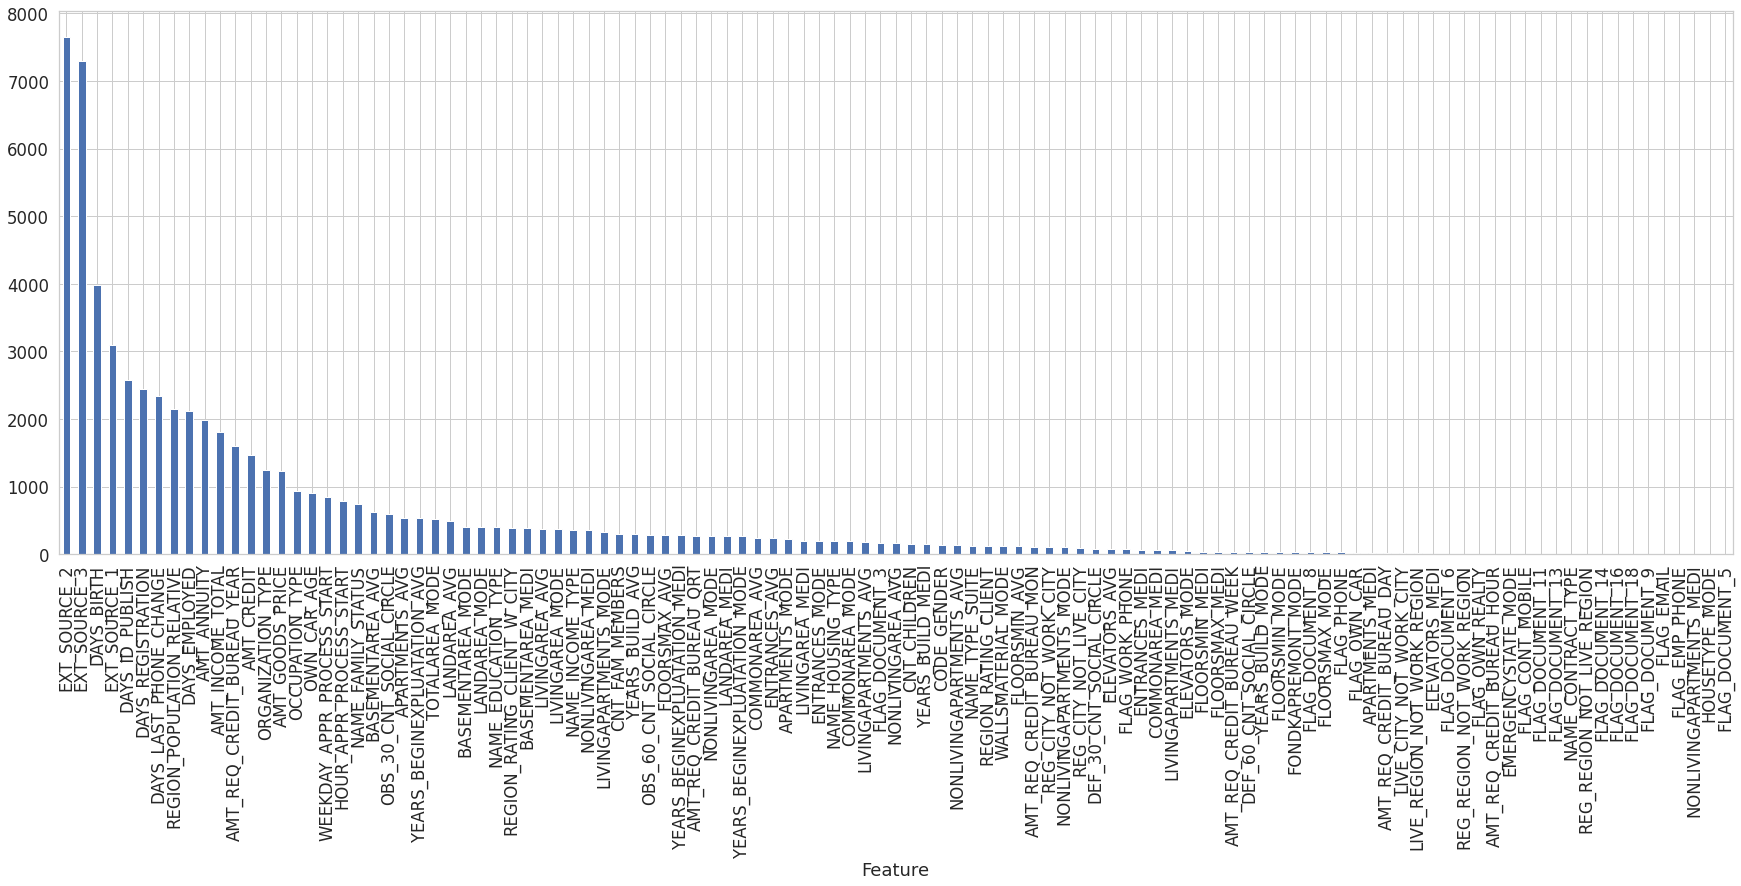

In [23]:
%%time

# Fast feature importances calculation
fast_fi = automl_rd.model.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

In [25]:
%%time

# Accurate feature importances calculation with detailed info (Permutation importances) -  can take long time to calculate
accurate_fi = automl_rd.model.get_feature_scores('accurate', te_data, silent = True)

CPU times: user 2min 44s, sys: 5.11 s, total: 2min 49s
Wall time: 1min 10s


<AxesSubplot: xlabel='Feature'>

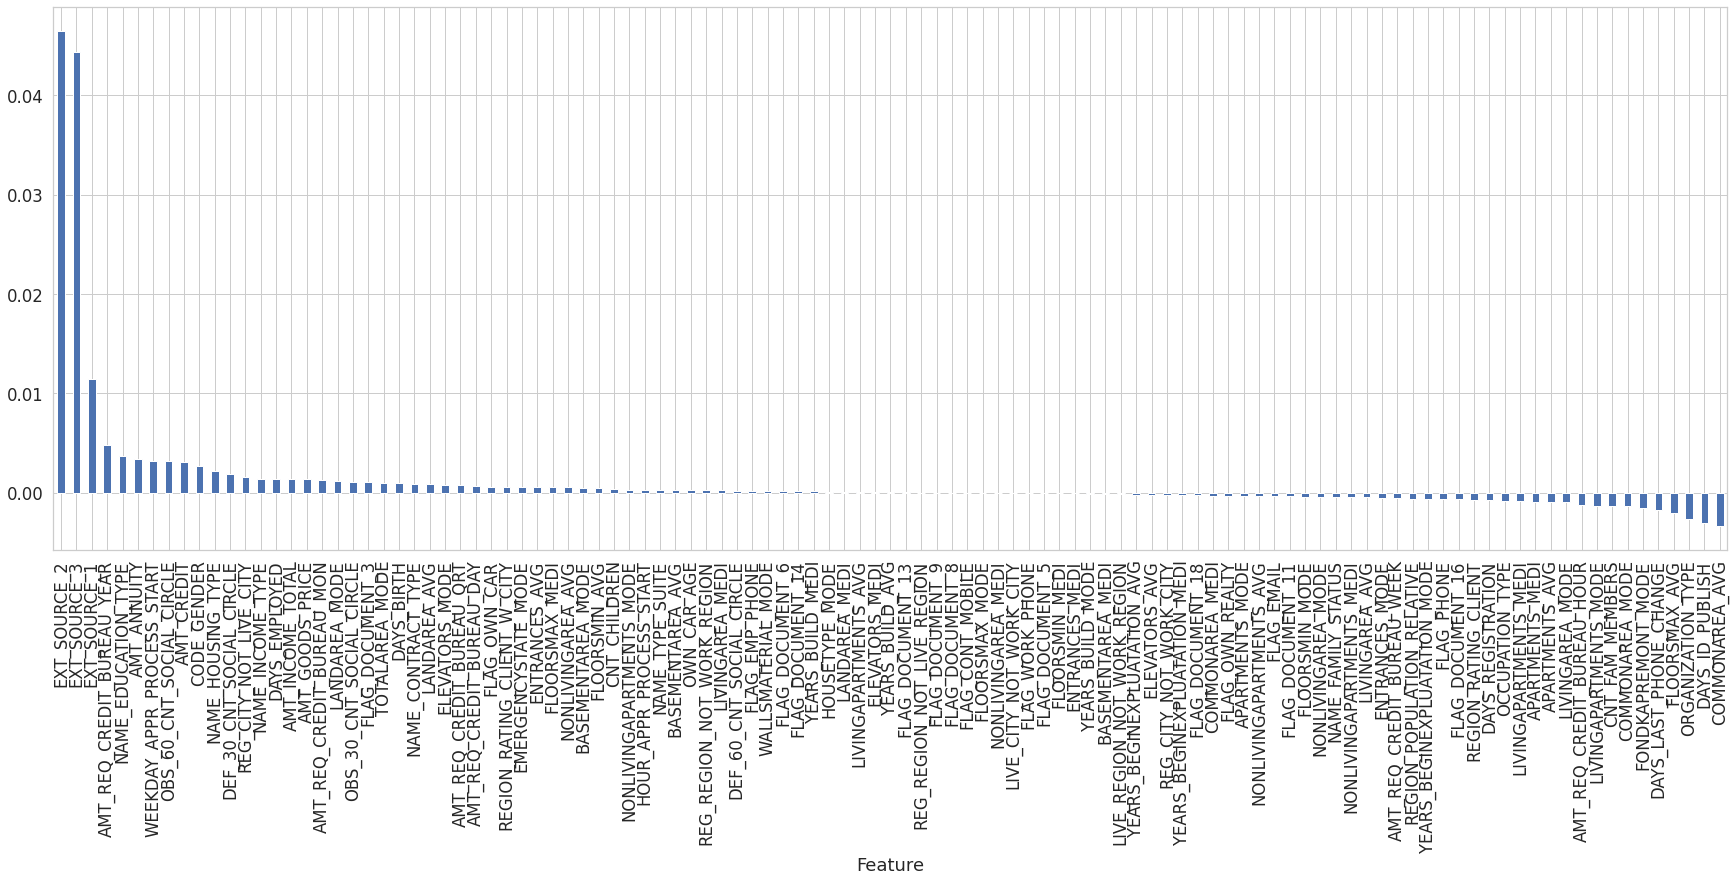

In [26]:
accurate_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

### Bonus: where is the automatic report?


As we used `automl_rd` in our training and prediction cells, it is already ready in the folder we specified - you can check the output folder and find the `tabularAutoML_model_report` folder with `lama_interactive_report.html` report inside (or just [click this link](tabularAutoML_model_report/lama_interactive_report.html) for short). It's interactive so you can click the black triangles on the left of the texts to go deeper in selected part.

## 5. Spending more from TIMEOUT - `TabularUtilizedAutoML` usage

To spend (almost) all the `TIMEOUT` time for building the model we can use `TabularUtilizedAutoML` preset instead of `TabularAutoML`, which has the same API. By default ```TabularUtilizedAutoML``` model trains with 7 different parameter configurations (see [this](https://github.com/sb-ai-lab/LightAutoML/tree/master/lightautoml/automl/presets/tabular_configs) for more details) sequentially, and if there is time left, then whole AutoML pipeline with these configs is run again with another cross-validation seed, and so on. Then results for each pipeline model are averaged over the considered validation seeds, and all averaged results at the end are also combined through blending. User can set his own set of configs by passing list of paths to according files in ```configs_list``` argument during ```TabularUtilizedAutoML``` instance initialization. Such configs allow the user to configure all pipeline parameters and can be used for any available preset. 

In [27]:
utilized_automl = TabularUtilizedAutoML(
    task = task, 
    timeout = 900,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
)

In [28]:
%%time 

oof_pred = utilized_automl.fit_predict(tr_data, roles = roles, verbose = 1)

[09:25:50] Start automl utilizator with listed constraints:
[09:25:50] - time: 900.00 seconds
[09:25:50] - CPU: 4 cores
[09:25:50] - memory: 16 GB

[09:25:50] If one preset completes earlier, next preset configuration will be started

[09:25:50] ==================================================
[09:25:50] Start 0 automl preset configuration:
[09:25:50] conf_0_sel_type_0.yml, random state: {'reader_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
[09:25:50] Found reader_params in kwargs, need to combine
[09:25:50] Merged variant for reader_params = {'n_jobs': 4, 'cv': 5, 'random_state': 42}
[09:25:50] Stdout logging level is INFO3.
[09:25:50] Task: binary

[09:25:50] Start automl preset with listed constraints:
[09:25:50] - time: 900.00 seconds
[09:25:50] - CPU: 4 cores
[09:25:50] - memory: 16 GB

[09:25:50] Train data shape: (8000, 122)

[09:25:52] Feats was rejected during automatic roles guess: []
[09:25:52] Layer 1 train process start. Time left 8

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:26:11] [100]	valid's auc: 0.742141
[09:26:12] [200]	valid's auc: 0.740585
[09:26:14] [300]	valid's auc: 0.740131
[09:26:14] Early stopping, best iteration is:
[108]	valid's auc: 0.744658
[09:26:14] Trial 1 with hyperparameters {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07} scored 0.7446584451892596 in 0:00:03.984892
[09:26:14] Training until validation scores don't improve for 200 rounds


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:26:14] [100]	valid's auc: 0.744012
[09:26:15] [200]	valid's auc: 0.745936
[09:26:15] [300]	valid's auc: 0.748288
[09:26:16] [400]	valid's auc: 0.749673
[09:26:17] [500]	valid's auc: 0.749865
[09:26:17] [600]	valid's auc: 0.750619
[09:26:18] [700]	valid's auc: 0.750239
[09:26:18] Early stopping, best iteration is:
[557]	valid's auc: 0.751233
[09:26:18] Trial 2 with hyperparameters {'feature_fraction': 0.5290418060840998, 'num_leaves': 223, 'bagging_fraction': 0.8005575058716043, 'min_sum_hessian_in_leaf': 0.679657809075816, 'reg_alpha': 1.5320059381854043e-08, 'reg_lambda': 5.360294728728285} scored 0.7512334888892452 in 0:00:04.638708
[09:26:18] Training until validation scores don't improve for 200 rounds


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:26:19] [100]	valid's auc: 0.754585
[09:26:20] [200]	valid's auc: 0.756542
[09:26:20] [300]	valid's auc: 0.757974
[09:26:20] Early stopping, best iteration is:
[118]	valid's auc: 0.759712
[09:26:20] Trial 3 with hyperparameters {'feature_fraction': 0.9162213204002109, 'num_leaves': 66, 'bagging_fraction': 0.5909124836035503, 'min_sum_hessian_in_leaf': 0.00541524411940254, 'reg_alpha': 5.472429642032198e-06, 'reg_lambda': 0.00052821153945323} scored 0.7597115533674381 in 0:00:02.075164
[09:26:20] Training until validation scores don't improve for 200 rounds


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:26:21] [100]	valid's auc: 0.739778
[09:26:22] [200]	valid's auc: 0.741734
[09:26:23] [300]	valid's auc: 0.740997
[09:26:23] [400]	valid's auc: 0.741366
[09:26:24] Early stopping, best iteration is:
[235]	valid's auc: 0.744733
[09:26:24] Trial 4 with hyperparameters {'feature_fraction': 0.7159725093210578, 'num_leaves': 85, 'bagging_fraction': 0.8059264473611898, 'min_sum_hessian_in_leaf': 0.003613894271216527, 'reg_alpha': 4.258943089524393e-06, 'reg_lambda': 1.9826980964985924e-05} scored 0.744733283085032 in 0:00:03.127522
[09:26:24] Training until validation scores don't improve for 200 rounds


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:26:24] [100]	valid's auc: 0.752132
[09:26:25] [200]	valid's auc: 0.748064
[09:26:26] Early stopping, best iteration is:
[90]	valid's auc: 0.752329
[09:26:26] Trial 5 with hyperparameters {'feature_fraction': 0.728034992108518, 'num_leaves': 204, 'bagging_fraction': 0.5998368910791798, 'min_sum_hessian_in_leaf': 0.11400863701127326, 'reg_alpha': 0.0021465011216654484, 'reg_lambda': 2.6185068507773707e-08} scored 0.7523293295059095 in 0:00:02.041214
[09:26:26] Training until validation scores don't improve for 200 rounds
[09:26:26] [100]	valid's auc: 0.748486


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:26:26] [200]	valid's auc: 0.749095
[09:26:26] Early stopping, best iteration is:
[68]	valid's auc: 0.749951
[09:26:26] Trial 6 with hyperparameters {'feature_fraction': 0.8037724259507192, 'num_leaves': 56, 'bagging_fraction': 0.5325257964926398, 'min_sum_hessian_in_leaf': 6.245139574743075, 'reg_alpha': 4.905556676028774, 'reg_lambda': 0.18861495878553936} scored 0.7499505535331505 in 0:00:00.484679
[09:26:26] Training until validation scores don't improve for 200 rounds


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:26:26] [100]	valid's auc: 0.750913
[09:26:27] [200]	valid's auc: 0.747973
[09:26:27] [300]	valid's auc: 0.745781
[09:26:27] Early stopping, best iteration is:
[100]	valid's auc: 0.750913
[09:26:27] Trial 7 with hyperparameters {'feature_fraction': 0.6523068845866853, 'num_leaves': 39, 'bagging_fraction': 0.8421165132560784, 'min_sum_hessian_in_leaf': 0.057624872164786026, 'reg_alpha': 1.254134495897175e-07, 'reg_lambda': 0.00028614897264046574} scored 0.7509127550502215 in 0:00:01.194735
[09:26:27] Training until validation scores don't improve for 200 rounds


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:26:28] [100]	valid's auc: 0.74004
[09:26:29] [200]	valid's auc: 0.745086
[09:26:30] [300]	valid's auc: 0.743215
[09:26:31] [400]	valid's auc: 0.746433
[09:26:32] [500]	valid's auc: 0.747502
[09:26:33] [600]	valid's auc: 0.747208
[09:26:33] Early stopping, best iteration is:
[440]	valid's auc: 0.748807
[09:26:33] Trial 8 with hyperparameters {'feature_fraction': 0.5171942605576092, 'num_leaves': 234, 'bagging_fraction': 0.6293899908000085, 'min_sum_hessian_in_leaf': 0.4467752817973907, 'reg_alpha': 6.388511557344611e-06, 'reg_lambda': 0.0004793052550782129} scored 0.7488066028406326 in 0:00:05.755336
[09:26:33] Training until validation scores don't improve for 200 rounds


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:26:34] [100]	valid's auc: 0.733262
[09:26:34] [200]	valid's auc: 0.73827
[09:26:34] [300]	valid's auc: 0.740371
[09:26:35] [400]	valid's auc: 0.740697
[09:26:35] [500]	valid's auc: 0.738997
[09:26:36] Early stopping, best iteration is:
[358]	valid's auc: 0.741141
[09:26:36] Trial 9 with hyperparameters {'feature_fraction': 0.7733551396716398, 'num_leaves': 60, 'bagging_fraction': 0.9847923138822793, 'min_sum_hessian_in_leaf': 1.2604664585649468, 'reg_alpha': 2.854239907497756, 'reg_lambda': 1.1309571585271483} scored 0.7411410640879665 in 0:00:02.615447
[09:26:36] Training until validation scores don't improve for 200 rounds


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:26:37] [100]	valid's auc: 0.748876
[09:26:38] [200]	valid's auc: 0.74553
[09:26:38] Early stopping, best iteration is:
[78]	valid's auc: 0.749806
[09:26:38] Trial 10 with hyperparameters {'feature_fraction': 0.7989499894055425, 'num_leaves': 237, 'bagging_fraction': 0.5442462510259598, 'min_sum_hessian_in_leaf': 0.006080390190296602, 'reg_alpha': 2.5529693461039728e-08, 'reg_lambda': 8.471746987003668e-06} scored 0.74980622330559 in 0:00:02.563727
[09:26:38] Training until validation scores don't improve for 200 rounds


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:26:39] [100]	valid's auc: 0.739195
[09:26:40] [200]	valid's auc: 0.744076
[09:26:41] [300]	valid's auc: 0.746118
[09:26:42] [400]	valid's auc: 0.749763
[09:26:43] [500]	valid's auc: 0.751704
[09:26:44] [600]	valid's auc: 0.751688
[09:26:45] [700]	valid's auc: 0.751683
[09:26:46] [800]	valid's auc: 0.752303
[09:26:47] [900]	valid's auc: 0.751324
[09:26:47] Early stopping, best iteration is:
[733]	valid's auc: 0.753414
[09:26:48] Trial 11 with hyperparameters {'feature_fraction': 0.9889980370406001, 'num_leaves': 129, 'bagging_fraction': 0.6843643863605486, 'min_sum_hessian_in_leaf': 0.0011799062523159302, 'reg_alpha': 0.0028369096911996217, 'reg_lambda': 0.016301353379407586} scored 0.7534144789946065 in 0:00:09.428341
[09:26:48] Training until validation scores don't improve for 200 rounds


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:26:49] [100]	valid's auc: 0.736854
[09:26:50] [200]	valid's auc: 0.744108
[09:26:51] [300]	valid's auc: 0.74631
[09:26:52] [400]	valid's auc: 0.748817
[09:26:53] [500]	valid's auc: 0.748561
[09:26:54] [600]	valid's auc: 0.748358
[09:26:54] Early stopping, best iteration is:
[437]	valid's auc: 0.750437
[09:26:54] Trial 12 with hyperparameters {'feature_fraction': 0.9937254043444207, 'num_leaves': 132, 'bagging_fraction': 0.6795146156302498, 'min_sum_hessian_in_leaf': 0.0010353204153309649, 'reg_alpha': 0.006461122584956907, 'reg_lambda': 0.0188106189121095} scored 0.7504369998556699 in 0:00:06.391256
[09:26:54] Training until validation scores don't improve for 200 rounds


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:26:55] [100]	valid's auc: 0.743514
[09:26:56] [200]	valid's auc: 0.747887
[09:26:57] [300]	valid's auc: 0.747278
[09:26:58] [400]	valid's auc: 0.747016
[09:26:59] [500]	valid's auc: 0.748491
[09:27:00] Early stopping, best iteration is:
[361]	valid's auc: 0.748796
[09:27:00] Trial 13 with hyperparameters {'feature_fraction': 0.9867209167947822, 'num_leaves': 120, 'bagging_fraction': 0.7183807205329413, 'min_sum_hessian_in_leaf': 0.014897314109132026, 'reg_alpha': 6.982496886163936e-05, 'reg_lambda': 0.008452229729634546} scored 0.7487959117126652 in 0:00:06.168060
[09:27:00] Training until validation scores don't improve for 200 rounds


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:27:01] [100]	valid's auc: 0.741793
[09:27:02] [200]	valid's auc: 0.745818
[09:27:03] [300]	valid's auc: 0.747882
[09:27:04] [400]	valid's auc: 0.746781
[09:27:04] Early stopping, best iteration is:
[294]	valid's auc: 0.7484
[09:27:04] Trial 14 with hyperparameters {'feature_fraction': 0.9112320253004816, 'num_leaves': 171, 'bagging_fraction': 0.638601420651193, 'min_sum_hessian_in_leaf': 0.001067160522267672, 'reg_alpha': 0.08810028012678825, 'reg_lambda': 0.004760571389454073} scored 0.7484003399778695 in 0:00:04.137769
[09:27:04] Training until validation scores don't improve for 200 rounds


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:27:05] [100]	valid's auc: 0.735817
[09:27:06] [200]	valid's auc: 0.737437
[09:27:07] [300]	valid's auc: 0.73965
[09:27:08] [400]	valid's auc: 0.740275
[09:27:09] [500]	valid's auc: 0.743563
[09:27:10] [600]	valid's auc: 0.744466
[09:27:11] [700]	valid's auc: 0.74368
[09:27:12] Early stopping, best iteration is:
[593]	valid's auc: 0.744985
[09:27:12] Trial 15 with hyperparameters {'feature_fraction': 0.8879805072925057, 'num_leaves': 100, 'bagging_fraction': 0.7406442464830113, 'min_sum_hessian_in_leaf': 0.019587565751884937, 'reg_alpha': 8.475972786621583e-05, 'reg_lambda': 0.00012849617790740175} scored 0.7449845245922672 in 0:00:07.345167
[09:27:12] Training until validation scores don't improve for 200 rounds


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:27:13] [100]	valid's auc: 0.748662
[09:27:13] [200]	valid's auc: 0.752276
[09:27:14] [300]	valid's auc: 0.751474
[09:27:15] [400]	valid's auc: 0.751527
[09:27:15] Early stopping, best iteration is:
[209]	valid's auc: 0.753751
[09:27:15] Trial 16 with hyperparameters {'feature_fraction': 0.8999612751508561, 'num_leaves': 164, 'bagging_fraction': 0.5900955676788503, 'min_sum_hessian_in_leaf': 0.004202960344530593, 'reg_alpha': 0.015633838004575313, 'reg_lambda': 0.04221597612296814} scored 0.7537512495255811 in 0:00:03.314552
[09:27:15] Training until validation scores don't improve for 200 rounds


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:27:16] [100]	valid's auc: 0.746225
[09:27:16] [200]	valid's auc: 0.757948
[09:27:17] [300]	valid's auc: 0.754505
[09:27:17] [400]	valid's auc: 0.756862
[09:27:17] Early stopping, best iteration is:
[204]	valid's auc: 0.758701
[09:27:17] Trial 17 with hyperparameters {'feature_fraction': 0.870274734483683, 'num_leaves': 182, 'bagging_fraction': 0.5129298231482654, 'min_sum_hessian_in_leaf': 0.005389594065622469, 'reg_alpha': 0.10617472907820673, 'reg_lambda': 0.3783257567361985} scored 0.7587012417745134 in 0:00:02.416979
[09:27:18] Training until validation scores don't improve for 200 rounds


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:27:18] [100]	valid's auc: 0.741932
[09:27:19] [200]	valid's auc: 0.748261
[09:27:19] [300]	valid's auc: 0.751725
[09:27:20] [400]	valid's auc: 0.750384
[09:27:20] [500]	valid's auc: 0.748582
[09:27:20] Early stopping, best iteration is:
[346]	valid's auc: 0.752746
[09:27:20] Trial 18 with hyperparameters {'feature_fraction': 0.8586265029598558, 'num_leaves': 170, 'bagging_fraction': 0.5241100812806072, 'min_sum_hessian_in_leaf': 0.02262240923934552, 'reg_alpha': 0.4013385162639602, 'reg_lambda': 1.492702583921023e-06} scored 0.7527462834966403 in 0:00:03.022153
[09:27:21] Training until validation scores don't improve for 200 rounds


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:27:21] [100]	valid's auc: 0.735908
[09:27:22] [200]	valid's auc: 0.741376
[09:27:23] [300]	valid's auc: 0.741868
[09:27:24] [400]	valid's auc: 0.740991
[09:27:24] [500]	valid's auc: 0.740419
[09:27:25] Early stopping, best iteration is:
[333]	valid's auc: 0.744771
[09:27:25] Trial 19 with hyperparameters {'feature_fraction': 0.8400828908638817, 'num_leaves': 202, 'bagging_fraction': 0.5670314911408035, 'min_sum_hessian_in_leaf': 0.05257851613720388, 'reg_alpha': 5.177706951488126e-06, 'reg_lambda': 0.3152060562060094} scored 0.7447707020329181 in 0:00:04.170300
[09:27:25] Training until validation scores don't improve for 200 rounds


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:27:25] [100]	valid's auc: 0.753997
[09:27:25] [200]	valid's auc: 0.757969
[09:27:26] [300]	valid's auc: 0.757584
[09:27:26] [400]	valid's auc: 0.758466
[09:27:26] [500]	valid's auc: 0.758193
[09:27:26] [600]	valid's auc: 0.758856
[09:27:27] [700]	valid's auc: 0.758124
[09:27:27] [800]	valid's auc: 0.756846
[09:27:27] Early stopping, best iteration is:
[624]	valid's auc: 0.759674
[09:27:27] Trial 20 with hyperparameters {'feature_fraction': 0.9448964773102108, 'num_leaves': 18, 'bagging_fraction': 0.5002307243174227, 'min_sum_hessian_in_leaf': 0.008830448338500507, 'reg_alpha': 0.000529866481081557, 'reg_lambda': 0.0014273320084063912} scored 0.7596768072015437 in 0:00:02.537866
[09:27:27] Training until validation scores don't improve for 200 rounds


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:27:28] [100]	valid's auc: 0.745418
[09:27:28] [200]	valid's auc: 0.753537
[09:27:28] [300]	valid's auc: 0.754366
[09:27:29] [400]	valid's auc: 0.757942
[09:27:29] [500]	valid's auc: 0.757322
[09:27:29] [600]	valid's auc: 0.75574
[09:27:30] Early stopping, best iteration is:
[458]	valid's auc: 0.758691
[09:27:30] Trial 21 with hyperparameters {'feature_fraction': 0.9413684491963877, 'num_leaves': 22, 'bagging_fraction': 0.5065896071904619, 'min_sum_hessian_in_leaf': 0.0108212643746327, 'reg_alpha': 0.00027172462456727994, 'reg_lambda': 0.0006569992211171628} scored 0.758690550646546 in 0:00:02.357171
[09:27:30] Training until validation scores don't improve for 200 rounds


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:27:30] [100]	valid's auc: 0.747166
[09:27:30] [200]	valid's auc: 0.753789
[09:27:30] [300]	valid's auc: 0.755029
[09:27:31] [400]	valid's auc: 0.757498
[09:27:31] [500]	valid's auc: 0.754927
[09:27:31] Early stopping, best iteration is:
[381]	valid's auc: 0.758236
[09:27:31] Trial 22 with hyperparameters {'feature_fraction': 0.9405345649971826, 'num_leaves': 17, 'bagging_fraction': 0.509292573164829, 'min_sum_hessian_in_leaf': 0.003193486154099986, 'reg_alpha': 0.06956631819606234, 'reg_lambda': 0.0020222602671843204} scored 0.758236177707929 in 0:00:01.761132
[09:27:31] Training until validation scores don't improve for 200 rounds


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:27:32] [100]	valid's auc: 0.743782
[09:27:33] [200]	valid's auc: 0.748074
[09:27:34] [300]	valid's auc: 0.750212
[09:27:35] [400]	valid's auc: 0.750442
[09:27:35] [500]	valid's auc: 0.752693
[09:27:36] [600]	valid's auc: 0.755654
[09:27:37] [700]	valid's auc: 0.75466
[09:27:38] [800]	valid's auc: 0.753345
[09:27:38] Early stopping, best iteration is:
[629]	valid's auc: 0.756927
[09:27:38] Trial 23 with hyperparameters {'feature_fraction': 0.8594627542015163, 'num_leaves': 79, 'bagging_fraction': 0.5707863322860477, 'min_sum_hessian_in_leaf': 0.007829777556324875, 'reg_alpha': 1.3169134604973373e-06, 'reg_lambda': 3.134038224323712e-05} scored 0.7569265145319157 in 0:00:07.001062
[09:27:38] Training until validation scores don't improve for 200 rounds


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:27:39] [100]	valid's auc: 0.754772
[09:27:40] [200]	valid's auc: 0.757023
[09:27:40] [300]	valid's auc: 0.757311
[09:27:41] [400]	valid's auc: 0.757065
[09:27:41] Early stopping, best iteration is:
[246]	valid's auc: 0.759466
[09:27:41] Trial 24 with hyperparameters {'feature_fraction': 0.935400785943724, 'num_leaves': 46, 'bagging_fraction': 0.6238135649437665, 'min_sum_hessian_in_leaf': 0.002381733867072491, 'reg_alpha': 2.6010281931010235e-05, 'reg_lambda': 0.08212409179257006} scored 0.7594656574241866 in 0:00:03.126817
[09:27:42] Training until validation scores don't improve for 200 rounds


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:27:43] [100]	valid's auc: 0.744968
[09:27:43] [200]	valid's auc: 0.749507
[09:27:44] [300]	valid's auc: 0.751683
[09:27:45] [400]	valid's auc: 0.752629
[09:27:45] [500]	valid's auc: 0.754104
[09:27:46] [600]	valid's auc: 0.752116
[09:27:46] Early stopping, best iteration is:
[456]	valid's auc: 0.755301
[09:27:46] Trial 25 with hyperparameters {'feature_fraction': 0.9447563890732286, 'num_leaves': 44, 'bagging_fraction': 0.6346491765640662, 'min_sum_hessian_in_leaf': 0.002254093110900895, 'reg_alpha': 7.120270059450056e-05, 'reg_lambda': 0.0020045407557620384} scored 0.7553014630808623 in 0:00:04.994840
[09:27:47] Training until validation scores don't improve for 200 rounds


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:27:47] [100]	valid's auc: 0.73872
[09:27:48] [200]	valid's auc: 0.749977
[09:27:49] [300]	valid's auc: 0.748769
[09:27:50] [400]	valid's auc: 0.751164
[09:27:51] [500]	valid's auc: 0.752677
[09:27:52] [600]	valid's auc: 0.749357
[09:27:53] Early stopping, best iteration is:
[472]	valid's auc: 0.75296
[09:27:53] Trial 26 with hyperparameters {'feature_fraction': 0.9349349805593415, 'num_leaves': 74, 'bagging_fraction': 0.6106232590848335, 'min_sum_hessian_in_leaf': 0.026064327175807096, 'reg_alpha': 0.0004530781170200408, 'reg_lambda': 0.0492263099419076} scored 0.7529601060559894 in 0:00:06.213843
[09:27:53] Training until validation scores don't improve for 200 rounds


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:27:53] [100]	valid's auc: 0.756568
[09:27:54] [200]	valid's auc: 0.755825
[09:27:54] [300]	valid's auc: 0.756296
[09:27:55] [400]	valid's auc: 0.757178
[09:27:55] [500]	valid's auc: 0.755419
[09:27:55] Early stopping, best iteration is:
[340]	valid's auc: 0.758899
[09:27:55] Trial 27 with hyperparameters {'feature_fraction': 0.8204171609194805, 'num_leaves': 34, 'bagging_fraction': 0.6735119269022508, 'min_sum_hessian_in_leaf': 0.0022144846144474995, 'reg_alpha': 1.6595963980295727e-05, 'reg_lambda': 9.863850051584799e-05} scored 0.7588990276419113 in 0:00:02.680151
[09:27:55] Training until validation scores don't improve for 200 rounds


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:27:56] [100]	valid's auc: 0.742002
[09:27:57] [200]	valid's auc: 0.743942
[09:27:57] [300]	valid's auc: 0.746658
[09:27:58] [400]	valid's auc: 0.747802
[09:27:58] [500]	valid's auc: 0.748277
[09:27:59] [600]	valid's auc: 0.74631
[09:27:59] [700]	valid's auc: 0.745385
[09:27:59] Early stopping, best iteration is:
[508]	valid's auc: 0.748684
[09:27:59] Trial 28 with hyperparameters {'feature_fraction': 0.6256160268015745, 'num_leaves': 103, 'bagging_fraction': 0.5576786823038032, 'min_sum_hessian_in_leaf': 0.045888594616603086, 'reg_alpha': 8.37416957679211e-07, 'reg_lambda': 1.9300943349484103} scored 0.748683654869007 in 0:00:04.085914
[09:28:00] Training until validation scores don't improve for 200 rounds


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:28:00] [100]	valid's auc: 0.752335
[09:28:01] [200]	valid's auc: 0.754339
[09:28:02] [300]	valid's auc: 0.754024
[09:28:02] Early stopping, best iteration is:
[120]	valid's auc: 0.756371
[09:28:02] Trial 29 with hyperparameters {'feature_fraction': 0.9540053568969863, 'num_leaves': 54, 'bagging_fraction': 0.6588113697819147, 'min_sum_hessian_in_leaf': 0.009655234744721608, 'reg_alpha': 0.0003908359891774653, 'reg_lambda': 0.0020701553732036743} scored 0.756370575877608 in 0:00:02.312296
[09:28:02] Training until validation scores don't improve for 200 rounds


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:28:02] [100]	valid's auc: 0.742028
[09:28:03] [200]	valid's auc: 0.748914
[09:28:03] [300]	valid's auc: 0.750506
[09:28:04] [400]	valid's auc: 0.747775
[09:28:04] Early stopping, best iteration is:
[269]	valid's auc: 0.751624
[09:28:04] Trial 30 with hyperparameters {'feature_fraction': 0.9083897914351908, 'num_leaves': 27, 'bagging_fraction': 0.9313235884212913, 'min_sum_hessian_in_leaf': 0.17033045839380187, 'reg_alpha': 3.0136504165177075e-07, 'reg_lambda': 2.8983478649886787e-06} scored 0.7516237150600574 in 0:00:02.141314
[09:28:04] Training until validation scores don't improve for 200 rounds


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:28:05] [100]	valid's auc: 0.741863
[09:28:06] [200]	valid's auc: 0.748855
[09:28:06] [300]	valid's auc: 0.750571
[09:28:07] [400]	valid's auc: 0.749935
[09:28:08] Early stopping, best iteration is:
[248]	valid's auc: 0.752693
[09:28:08] Trial 31 with hyperparameters {'feature_fraction': 0.9996467385418863, 'num_leaves': 62, 'bagging_fraction': 0.7144023093083764, 'min_sum_hessian_in_leaf': 0.0021555996495227652, 'reg_alpha': 1.1516615030836956e-05, 'reg_lambda': 0.05751673949831543} scored 0.7526928278568031 in 0:00:03.843732
[09:28:08] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[09:28:08] The set of hyperparameters {'feature_fraction': 0.9162213204002109, 'num_leaves': 66, 'bagging_fraction': 0.5909124836035503, 'min_sum_hessian_in_leaf': 0.00541524411940254, 'reg_alpha': 5.472429642032198e-06, 'reg_lambda': 0.00052821153945323}
 achieve 0.7597 auc
[09:28:08] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[09:28:08] ===== Start working with f

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:28:24] 100:	test: 0.7388264	best: 0.7388264 (100)	total: 198ms	remaining: 9.6s
[09:28:24] 200:	test: 0.7444660	best: 0.7458452 (197)	total: 377ms	remaining: 9s
[09:28:24] Stopped by overfitting detector  (100 iterations wait)
[09:28:24] bestTest = 0.7458451604
[09:28:24] bestIteration = 197
[09:28:24] Shrink model to first 198 iterations.
[09:28:24] Trial 1 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0024430162614261413, 'min_data_in_leaf': 4} scored 0.7458451603936473 in 0:00:00.681752
[09:28:24] 0:	test: 0.6049575	best: 0.6049575 (0)	total: 3ms	remaining: 15s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:28:25] 100:	test: 0.7386554	best: 0.7386554 (100)	total: 195ms	remaining: 9.47s
[09:28:25] 200:	test: 0.7369876	best: 0.7417932 (185)	total: 385ms	remaining: 9.19s
[09:28:25] 300:	test: 0.7444553	best: 0.7451128 (290)	total: 576ms	remaining: 8.99s
[09:28:25] 400:	test: 0.7475397	best: 0.7512335 (361)	total: 767ms	remaining: 8.8s
[09:28:25] Stopped by overfitting detector  (100 iterations wait)
[09:28:25] bestTest = 0.7512334889
[09:28:25] bestIteration = 361
[09:28:25] Shrink model to first 362 iterations.
[09:28:25] Trial 2 with hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.002570603566117598, 'min_data_in_leaf': 15} scored 0.7512334888892453 in 0:00:01.010450


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:28:26] 0:	test: 0.5801995	best: 0.5801995 (0)	total: 2.19ms	remaining: 11s
[09:28:26] 100:	test: 0.7330693	best: 0.7331976 (98)	total: 179ms	remaining: 8.7s
[09:28:26] 200:	test: 0.7357314	best: 0.7433488 (134)	total: 356ms	remaining: 8.51s
[09:28:26] Stopped by overfitting detector  (100 iterations wait)
[09:28:26] bestTest = 0.743348782
[09:28:26] bestIteration = 134
[09:28:26] Shrink model to first 135 iterations.
[09:28:26] Trial 3 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 8.148018307012941e-07, 'min_data_in_leaf': 4} scored 0.7433487820132463 in 0:00:00.730993
[09:28:26] 0:	test: 0.6049575	best: 0.6049575 (0)	total: 2.46ms	remaining: 12.3s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:28:26] 100:	test: 0.7237306	best: 0.7237306 (100)	total: 201ms	remaining: 9.76s
[09:28:27] 200:	test: 0.7334328	best: 0.7352716 (171)	total: 393ms	remaining: 9.38s
[09:28:27] 300:	test: 0.7409112	best: 0.7414778 (293)	total: 586ms	remaining: 9.14s
[09:28:27] 400:	test: 0.7299314	best: 0.7444072 (344)	total: 777ms	remaining: 8.91s
[09:28:27] Stopped by overfitting detector  (100 iterations wait)
[09:28:27] bestTest = 0.7444072037
[09:28:27] bestIteration = 344
[09:28:27] Shrink model to first 345 iterations.
[09:28:27] Trial 4 with hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 7.71800699380605e-05, 'min_data_in_leaf': 6} scored 0.7444072036820246 in 0:00:01.013121
[09:28:27] 0:	test: 0.6061388	best: 0.6061388 (0)	total: 3.85ms	remaining: 19.3s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:28:27] 100:	test: 0.7166103	best: 0.7185667 (98)	total: 309ms	remaining: 15s
[09:28:28] 200:	test: 0.7075068	best: 0.7267455 (128)	total: 669ms	remaining: 16s
[09:28:28] Stopped by overfitting detector  (100 iterations wait)
[09:28:28] bestTest = 0.7267454603
[09:28:28] bestIteration = 128
[09:28:28] Shrink model to first 129 iterations.
[09:28:28] Trial 5 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 1.9826980964985924e-05, 'min_data_in_leaf': 10} scored 0.7267454602797867 in 0:00:00.883607
[09:28:28] 0:	test: 0.6061388	best: 0.6061388 (0)	total: 4.16ms	remaining: 20.8s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:28:28] 100:	test: 0.7202399	best: 0.7306531 (71)	total: 309ms	remaining: 15s
[09:28:29] Stopped by overfitting detector  (100 iterations wait)
[09:28:29] bestTest = 0.7306530676
[09:28:29] bestIteration = 71
[09:28:29] Shrink model to first 72 iterations.
[09:28:29] Trial 6 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0021465011216654484, 'min_data_in_leaf': 1} scored 0.7306530675518921 in 0:00:00.664038
[09:28:29] 0:	test: 0.5885706	best: 0.5885706 (0)	total: 3.92ms	remaining: 19.6s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:28:29] 100:	test: 0.7591449	best: 0.7591449 (100)	total: 283ms	remaining: 13.7s
[09:28:29] 200:	test: 0.7639239	best: 0.7659659 (191)	total: 546ms	remaining: 13s
[09:28:30] 300:	test: 0.7673717	best: 0.7706593 (277)	total: 807ms	remaining: 12.6s
[09:28:30] Stopped by overfitting detector  (100 iterations wait)
[09:28:30] bestTest = 0.7706592684
[09:28:30] bestIteration = 277
[09:28:30] Shrink model to first 278 iterations.
[09:28:30] Trial 7 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 3.4671276804481113, 'min_data_in_leaf': 20} scored 0.7706592684061132 in 0:00:01.138286
[09:28:30] 0:	test: 0.5898081	best: 0.5898081 (0)	total: 6.13ms	remaining: 30.6s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:28:30] 100:	test: 0.6993601	best: 0.7042781 (66)	total: 447ms	remaining: 21.7s
[09:28:31] Stopped by overfitting detector  (100 iterations wait)
[09:28:31] bestTest = 0.7042780549
[09:28:31] bestIteration = 66
[09:28:31] Shrink model to first 67 iterations.
[09:28:31] Trial 8 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.014391207615728067, 'min_data_in_leaf': 9} scored 0.7042780548561777 in 0:00:00.855286
[09:28:31] 0:	test: 0.5801995	best: 0.5801995 (0)	total: 2.65ms	remaining: 13.3s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:28:31] 100:	test: 0.7483362	best: 0.7490097 (96)	total: 177ms	remaining: 8.6s
[09:28:31] 200:	test: 0.7554725	best: 0.7555420 (199)	total: 338ms	remaining: 8.07s
[09:28:31] 300:	test: 0.7566325	best: 0.7587226 (295)	total: 498ms	remaining: 7.78s
[09:28:31] 400:	test: 0.7584393	best: 0.7588776 (370)	total: 659ms	remaining: 7.56s
[09:28:32] 500:	test: 0.7578887	best: 0.7594015 (407)	total: 821ms	remaining: 7.37s
[09:28:32] Stopped by overfitting detector  (100 iterations wait)
[09:28:32] bestTest = 0.7594015107
[09:28:32] bestIteration = 407
[09:28:32] Shrink model to first 408 iterations.
[09:28:32] Trial 9 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.527156759251193, 'min_data_in_leaf': 6} scored 0.7594015106563818 in 0:00:00.970609
[09:28:32] 0:	test: 0.6061388	best: 0.6061388 (0)	total: 3.38ms	remaining: 16.9s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:28:32] 100:	test: 0.7475771	best: 0.7487104 (95)	total: 263ms	remaining: 12.8s
[09:28:32] 200:	test: 0.7153915	best: 0.7493625 (101)	total: 522ms	remaining: 12.5s
[09:28:32] Stopped by overfitting detector  (100 iterations wait)
[09:28:32] bestTest = 0.7493625415
[09:28:32] bestIteration = 101
[09:28:32] Shrink model to first 102 iterations.
[09:28:32] Trial 10 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0008325158565947976, 'min_data_in_leaf': 4} scored 0.7493625414949404 in 0:00:00.661056
[09:28:32] 0:	test: 0.6036558	best: 0.6036558 (0)	total: 3.34ms	remaining: 16.7s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:28:33] 100:	test: 0.7510571	best: 0.7510571 (100)	total: 282ms	remaining: 13.7s
[09:28:33] 200:	test: 0.7554939	best: 0.7577551 (145)	total: 554ms	remaining: 13.2s
[09:28:33] 300:	test: 0.7597169	best: 0.7597169 (300)	total: 826ms	remaining: 12.9s
[09:28:33] 400:	test: 0.7566058	best: 0.7606203 (313)	total: 1.1s	remaining: 12.6s
[09:28:34] Stopped by overfitting detector  (100 iterations wait)
[09:28:34] bestTest = 0.7606202992
[09:28:34] bestIteration = 313
[09:28:34] Shrink model to first 314 iterations.
[09:28:34] Trial 11 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 5.319049072944658, 'min_data_in_leaf': 20} scored 0.7606202992446718 in 0:00:01.281325
[09:28:34] 0:	test: 0.6037574	best: 0.6037574 (0)	total: 2.87ms	remaining: 14.3s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:28:34] 100:	test: 0.7548150	best: 0.7548471 (94)	total: 255ms	remaining: 12.4s
[09:28:34] 200:	test: 0.7567501	best: 0.7569319 (155)	total: 510ms	remaining: 12.2s
[09:28:34] 300:	test: 0.7581827	best: 0.7601445 (294)	total: 765ms	remaining: 11.9s
[09:28:35] Stopped by overfitting detector  (100 iterations wait)
[09:28:35] bestTest = 0.7601445441
[09:28:35] bestIteration = 294
[09:28:35] Shrink model to first 295 iterations.
[09:28:35] Trial 12 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 7.654538200209708, 'min_data_in_leaf': 20} scored 0.76014454405012 in 0:00:01.140844


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:28:35] 0:	test: 0.6067295	best: 0.6067295 (0)	total: 2.94ms	remaining: 14.7s
[09:28:35] 100:	test: 0.7457276	best: 0.7461392 (99)	total: 216ms	remaining: 10.5s
[09:28:35] 200:	test: 0.7480208	best: 0.7527409 (183)	total: 429ms	remaining: 10.2s
[09:28:36] Stopped by overfitting detector  (100 iterations wait)
[09:28:36] bestTest = 0.7527409379
[09:28:36] bestIteration = 183
[09:28:36] Shrink model to first 184 iterations.
[09:28:36] Trial 13 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.1811958043617718, 'min_data_in_leaf': 20} scored 0.7527409379326566 in 0:00:00.907991
[09:28:36] 0:	test: 0.5899204	best: 0.5899204 (0)	total: 7.47ms	remaining: 37.3s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:28:36] 100:	test: 0.7427501	best: 0.7427501 (100)	total: 444ms	remaining: 21.5s
[09:28:37] 200:	test: 0.7333419	best: 0.7427501 (100)	total: 879ms	remaining: 21s
[09:28:37] Stopped by overfitting detector  (100 iterations wait)
[09:28:37] bestTest = 0.7427500788
[09:28:37] bestIteration = 100
[09:28:37] Shrink model to first 101 iterations.
[09:28:37] Trial 14 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.16505863700695894, 'min_data_in_leaf': 16} scored 0.7427500788470689 in 0:00:01.012043
[09:28:37] 0:	test: 0.5806058	best: 0.5806058 (0)	total: 3.27ms	remaining: 16.3s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:28:37] 100:	test: 0.7344163	best: 0.7344163 (100)	total: 214ms	remaining: 10.4s
[09:28:37] 200:	test: 0.7360574	best: 0.7371640 (184)	total: 424ms	remaining: 10.1s
[09:28:37] Stopped by overfitting detector  (100 iterations wait)
[09:28:37] bestTest = 0.7371639645
[09:28:37] bestIteration = 184
[09:28:37] Shrink model to first 185 iterations.
[09:28:37] Trial 15 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 3.636415632706866e-08, 'min_data_in_leaf': 16} scored 0.7371639644840728 in 0:00:00.731626
[09:28:37] 0:	test: 0.6039178	best: 0.6039178 (0)	total: 3.68ms	remaining: 18.4s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:28:38] 100:	test: 0.7537459	best: 0.7537459 (100)	total: 257ms	remaining: 12.4s
[09:28:38] 200:	test: 0.7604279	best: 0.7604279 (200)	total: 509ms	remaining: 12.1s
[09:28:38] 300:	test: 0.7657948	best: 0.7668639 (290)	total: 760ms	remaining: 11.9s
[09:28:38] Stopped by overfitting detector  (100 iterations wait)
[09:28:38] bestTest = 0.766863918
[09:28:38] bestIteration = 290
[09:28:38] Shrink model to first 291 iterations.
[09:28:38] Trial 16 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 9.386409476379045, 'min_data_in_leaf': 14} scored 0.7668639179776663 in 0:00:01.125082
[09:28:39] 0:	test: 0.5901636	best: 0.5901636 (0)	total: 4.56ms	remaining: 22.8s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:28:39] 100:	test: 0.7516291	best: 0.7523507 (97)	total: 311ms	remaining: 15.1s
[09:28:39] Stopped by overfitting detector  (100 iterations wait)
[09:28:39] bestTest = 0.7523507118
[09:28:39] bestIteration = 97
[09:28:39] Shrink model to first 98 iterations.
[09:28:39] Trial 17 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.20898479407841494, 'min_data_in_leaf': 13} scored 0.7523507117618444 in 0:00:00.744015
[09:28:39] 0:	test: 0.5806058	best: 0.5806058 (0)	total: 2.16ms	remaining: 10.8s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:28:40] 100:	test: 0.7439101	best: 0.7461392 (95)	total: 185ms	remaining: 8.99s
[09:28:40] 200:	test: 0.7509555	best: 0.7538528 (161)	total: 368ms	remaining: 8.79s
[09:28:40] Stopped by overfitting detector  (100 iterations wait)
[09:28:40] bestTest = 0.7538528152
[09:28:40] bestIteration = 161
[09:28:40] Shrink model to first 162 iterations.
[09:28:40] Trial 18 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.03786184042353316, 'min_data_in_leaf': 13} scored 0.7538501424592802 in 0:00:00.616910
[09:28:40] 0:	test: 0.6064462	best: 0.6064462 (0)	total: 2.66ms	remaining: 13.3s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:28:40] 100:	test: 0.7432045	best: 0.7436214 (94)	total: 219ms	remaining: 10.6s
[09:28:40] 200:	test: 0.7522331	best: 0.7529975 (199)	total: 435ms	remaining: 10.4s
[09:28:41] 300:	test: 0.7406760	best: 0.7534198 (221)	total: 652ms	remaining: 10.2s
[09:28:41] Stopped by overfitting detector  (100 iterations wait)
[09:28:41] bestTest = 0.7534198246
[09:28:41] bestIteration = 221
[09:28:41] Shrink model to first 222 iterations.
[09:28:41] Trial 19 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.7467335353257311, 'min_data_in_leaf': 18} scored 0.75341982455859 in 0:00:00.834954
[09:28:41] 0:	test: 0.5961533	best: 0.5961533 (0)	total: 4.71ms	remaining: 23.5s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:28:41] 100:	test: 0.7503568	best: 0.7513778 (95)	total: 345ms	remaining: 16.7s
[09:28:41] 200:	test: 0.7572740	best: 0.7578834 (185)	total: 687ms	remaining: 16.4s
[09:28:42] 300:	test: 0.7610479	best: 0.7612511 (296)	total: 1.02s	remaining: 16s
[09:28:42] 400:	test: 0.7542163	best: 0.7615718 (325)	total: 1.36s	remaining: 15.6s
[09:28:42] Stopped by overfitting detector  (100 iterations wait)
[09:28:42] bestTest = 0.7615718096
[09:28:42] bestIteration = 325
[09:28:42] Shrink model to first 326 iterations.
[09:28:42] Trial 20 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 9.04377623101888, 'min_data_in_leaf': 12} scored 0.7615718096337754 in 0:00:01.588802
[09:28:42] 0:	test: 0.5901636	best: 0.5901636 (0)	total: 3.67ms	remaining: 18.3s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:28:43] 100:	test: 0.7469036	best: 0.7476306 (95)	total: 282ms	remaining: 13.7s
[09:28:43] 200:	test: 0.7360414	best: 0.7488975 (106)	total: 546ms	remaining: 13s
[09:28:43] Stopped by overfitting detector  (100 iterations wait)
[09:28:43] bestTest = 0.7488974774
[09:28:43] bestIteration = 106
[09:28:43] Shrink model to first 107 iterations.
[09:28:43] Trial 21 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.02224562547785724, 'min_data_in_leaf': 18} scored 0.748897477428356 in 0:00:00.693955
[09:28:43] 0:	test: 0.6004619	best: 0.6004619 (0)	total: 3.91ms	remaining: 19.5s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:28:43] 100:	test: 0.7501483	best: 0.7515061 (95)	total: 346ms	remaining: 16.8s
[09:28:44] 200:	test: 0.7539170	best: 0.7544408 (199)	total: 690ms	remaining: 16.5s
[09:28:44] 300:	test: 0.7549754	best: 0.7553389 (293)	total: 1.11s	remaining: 17.4s
[09:28:45] 400:	test: 0.7494374	best: 0.7571778 (339)	total: 1.57s	remaining: 18s
[09:28:45] Stopped by overfitting detector  (100 iterations wait)
[09:28:45] bestTest = 0.757177756
[09:28:45] bestIteration = 339
[09:28:45] Shrink model to first 340 iterations.
[09:28:45] Trial 22 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 9.450427419870957, 'min_data_in_leaf': 12} scored 0.7571777560391508 in 0:00:01.872109
[09:28:45] 0:	test: 0.5891346	best: 0.5891346 (0)	total: 4.11ms	remaining: 20.6s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:28:45] 100:	test: 0.7564454	best: 0.7571350 (96)	total: 374ms	remaining: 18.1s
[09:28:46] Stopped by overfitting detector  (100 iterations wait)
[09:28:46] bestTest = 0.7571349915
[09:28:46] bestIteration = 96
[09:28:46] Shrink model to first 97 iterations.
[09:28:46] Trial 23 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 1.1353231005574114, 'min_data_in_leaf': 11} scored 0.7571349915272811 in 0:00:00.857738
[09:28:46] 0:	test: 0.5895382	best: 0.5895382 (0)	total: 3.43ms	remaining: 17.1s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:28:46] 100:	test: 0.7519284	best: 0.7522385 (97)	total: 315ms	remaining: 15.3s
[09:28:46] 200:	test: 0.7580330	best: 0.7588616 (190)	total: 631ms	remaining: 15.1s
[09:28:47] 300:	test: 0.7570495	best: 0.7621117 (254)	total: 973ms	remaining: 15.2s
[09:28:47] Stopped by overfitting detector  (100 iterations wait)
[09:28:47] bestTest = 0.7621117116
[09:28:47] bestIteration = 254
[09:28:47] Shrink model to first 255 iterations.
[09:28:47] Trial 24 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 1.436571813595124, 'min_data_in_leaf': 14} scored 0.762111711596132 in 0:00:01.292135


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:28:47] 0:	test: 0.5901636	best: 0.5901636 (0)	total: 4.71ms	remaining: 23.5s
[09:28:48] 100:	test: 0.7522064	best: 0.7528372 (85)	total: 437ms	remaining: 21.2s
[09:28:48] 200:	test: 0.7529922	best: 0.7551732 (191)	total: 870ms	remaining: 20.8s
[09:28:49] Stopped by overfitting detector  (100 iterations wait)
[09:28:49] bestTest = 0.7551731695
[09:28:49] bestIteration = 191
[09:28:49] Shrink model to first 192 iterations.
[09:28:49] Trial 25 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 1.0311422692729295, 'min_data_in_leaf': 15} scored 0.7551731695452528 in 0:00:01.593005
[09:28:49] 0:	test: 0.6067295	best: 0.6067295 (0)	total: 5.57ms	remaining: 27.8s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:28:49] 100:	test: 0.7409005	best: 0.7417825 (94)	total: 311ms	remaining: 15.1s
[09:28:49] 200:	test: 0.7508379	best: 0.7525645 (179)	total: 675ms	remaining: 16.1s
[09:28:50] 300:	test: 0.7483790	best: 0.7530884 (213)	total: 1.11s	remaining: 17.3s
[09:28:50] Stopped by overfitting detector  (100 iterations wait)
[09:28:50] bestTest = 0.7530883996
[09:28:50] bestIteration = 213
[09:28:50] Shrink model to first 214 iterations.
[09:28:50] Trial 26 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.06831807619226633, 'min_data_in_leaf': 18} scored 0.753088399591599 in 0:00:01.363146
[09:28:50] 0:	test: 0.6061442	best: 0.6061442 (0)	total: 7.56ms	remaining: 37.8s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:28:51] 100:	test: 0.7429799	best: 0.7430013 (99)	total: 388ms	remaining: 18.8s
[09:28:51] 200:	test: 0.7507791	best: 0.7531472 (137)	total: 709ms	remaining: 16.9s
[09:28:51] 300:	test: 0.7565630	best: 0.7579422 (268)	total: 1.01s	remaining: 15.8s
[09:28:52] 400:	test: 0.7547883	best: 0.7587280 (307)	total: 1.32s	remaining: 15.1s
[09:28:52] Stopped by overfitting detector  (100 iterations wait)
[09:28:52] bestTest = 0.7587279696
[09:28:52] bestIteration = 307
[09:28:52] Shrink model to first 308 iterations.
[09:28:52] Trial 27 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.6189083075493418, 'min_data_in_leaf': 9} scored 0.758727969594432 in 0:00:01.612109
[09:28:52] 0:	test: 0.6067295	best: 0.6067295 (0)	total: 2.89ms	remaining: 14.5s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:28:52] 100:	test: 0.7382758	best: 0.7387676 (99)	total: 257ms	remaining: 12.5s
[09:28:52] 200:	test: 0.7369395	best: 0.7434076 (122)	total: 507ms	remaining: 12.1s
[09:28:52] Stopped by overfitting detector  (100 iterations wait)
[09:28:52] bestTest = 0.7434075832
[09:28:52] bestIteration = 122
[09:28:52] Shrink model to first 123 iterations.
[09:28:52] Trial 28 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 2.0434426365762686e-06, 'min_data_in_leaf': 14} scored 0.7434075832170673 in 0:00:00.693465
[09:28:52] 0:	test: 0.5806058	best: 0.5806058 (0)	total: 3.14ms	remaining: 15.7s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:28:53] 100:	test: 0.7463156	best: 0.7498918 (88)	total: 221ms	remaining: 10.7s
[09:28:53] 200:	test: 0.7561086	best: 0.7573862 (192)	total: 436ms	remaining: 10.4s
[09:28:53] 300:	test: 0.7587814	best: 0.7587814 (300)	total: 650ms	remaining: 10.1s
[09:28:53] 400:	test: 0.7587226	best: 0.7603156 (312)	total: 867ms	remaining: 9.94s
[09:28:54] 500:	test: 0.7603049	best: 0.7613740 (482)	total: 1.08s	remaining: 9.7s
[09:28:54] Stopped by overfitting detector  (100 iterations wait)
[09:28:54] bestTest = 0.7613740238
[09:28:54] bestIteration = 482
[09:28:54] Shrink model to first 483 iterations.
[09:28:54] Trial 29 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 1.96724218095231, 'min_data_in_leaf': 17} scored 0.7613740237663775 in 0:00:01.404160
[09:28:54] 0:	test: 0.5901636	best: 0.5901636 (0)	total: 3.55ms	remaining: 17.8s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:28:54] 100:	test: 0.7247355	best: 0.7297871 (91)	total: 312ms	remaining: 15.1s
[09:28:54] Stopped by overfitting detector  (100 iterations wait)
[09:28:54] bestTest = 0.7297870862
[09:28:54] bestIteration = 91
[09:28:54] Shrink model to first 92 iterations.
[09:28:54] Trial 30 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.007515571723249163, 'min_data_in_leaf': 7} scored 0.7297870861865281 in 0:00:00.726041
[09:28:55] 0:	test: 0.5806058	best: 0.5806058 (0)	total: 2.72ms	remaining: 13.6s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:28:55] 100:	test: 0.7557291	best: 0.7569853 (97)	total: 214ms	remaining: 10.4s
[09:28:55] 200:	test: 0.7524897	best: 0.7579154 (128)	total: 427ms	remaining: 10.2s
[09:28:55] Stopped by overfitting detector  (100 iterations wait)
[09:28:55] bestTest = 0.7579154439
[09:28:55] bestIteration = 128
[09:28:55] Shrink model to first 129 iterations.
[09:28:55] Trial 31 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.2640523455881104, 'min_data_in_leaf': 14} scored 0.7579154438689053 in 0:00:00.617158
[09:28:55] 0:	test: 0.6004405	best: 0.6004405 (0)	total: 4.43ms	remaining: 22.2s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:28:56] 100:	test: 0.7509662	best: 0.7528478 (95)	total: 354ms	remaining: 17.2s
[09:28:56] 200:	test: 0.7559322	best: 0.7559322 (200)	total: 692ms	remaining: 16.5s
[09:28:56] 300:	test: 0.7565309	best: 0.7572366 (292)	total: 1.03s	remaining: 16.1s
[09:28:57] 400:	test: 0.7532595	best: 0.7599788 (345)	total: 1.37s	remaining: 15.7s
[09:28:57] Stopped by overfitting detector  (100 iterations wait)
[09:28:57] bestTest = 0.7599788316
[09:28:57] bestIteration = 345
[09:28:57] Shrink model to first 346 iterations.
[09:28:57] Trial 32 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 9.753867738320254, 'min_data_in_leaf': 11} scored 0.7599788315666243 in 0:00:01.662901
[09:28:57] 0:	test: 0.5881564	best: 0.5881564 (0)	total: 4.53ms	remaining: 22.7s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:28:57] 100:	test: 0.7522545	best: 0.7531686 (93)	total: 405ms	remaining: 19.6s
[09:28:58] 200:	test: 0.7562102	best: 0.7563332 (178)	total: 800ms	remaining: 19.1s
[09:28:58] 300:	test: 0.7547776	best: 0.7568784 (204)	total: 1.2s	remaining: 18.7s
[09:28:58] Stopped by overfitting detector  (100 iterations wait)
[09:28:58] bestTest = 0.7568784045
[09:28:58] bestIteration = 204
[09:28:58] Shrink model to first 205 iterations.
[09:28:58] Trial 33 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 3.089736338030828, 'min_data_in_leaf': 12} scored 0.7568784044560622 in 0:00:01.352476
[09:28:58] 0:	test: 0.6050029	best: 0.6050029 (0)	total: 3.74ms	remaining: 18.7s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:28:58] 100:	test: 0.7484217	best: 0.7489990 (94)	total: 280ms	remaining: 13.6s
[09:28:59] 200:	test: 0.7507845	best: 0.7525645 (145)	total: 553ms	remaining: 13.2s
[09:28:59] Stopped by overfitting detector  (100 iterations wait)
[09:28:59] bestTest = 0.7525645343
[09:28:59] bestIteration = 145
[09:28:59] Shrink model to first 146 iterations.
[09:28:59] Trial 34 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 2.3560244203398293, 'min_data_in_leaf': 15} scored 0.7525645343211935 in 0:00:00.814425
[09:28:59] 0:	test: 0.6061282	best: 0.6061282 (0)	total: 4.09ms	remaining: 20.4s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:28:59] 100:	test: 0.7397940	best: 0.7402377 (93)	total: 310ms	remaining: 15.1s
[09:29:00] 200:	test: 0.7485233	best: 0.7500147 (193)	total: 615ms	remaining: 14.7s
[09:29:00] 300:	test: 0.7561247	best: 0.7568677 (295)	total: 921ms	remaining: 14.4s
[09:29:00] Stopped by overfitting detector  (100 iterations wait)
[09:29:00] bestTest = 0.7568677133
[09:29:00] bestIteration = 295
[09:29:00] Shrink model to first 296 iterations.
[09:29:00] Trial 35 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.44588670809799513, 'min_data_in_leaf': 8} scored 0.7568677133280947 in 0:00:01.358879
[09:29:00] 0:	test: 0.5898135	best: 0.5898135 (0)	total: 4.92ms	remaining: 24.6s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:29:01] 100:	test: 0.6512554	best: 0.6732310 (44)	total: 350ms	remaining: 17s
[09:29:01] Stopped by overfitting detector  (100 iterations wait)
[09:29:01] bestTest = 0.6732310192
[09:29:01] bestIteration = 44
[09:29:01] Shrink model to first 45 iterations.
[09:29:01] Trial 36 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 6.93246599678932e-05, 'min_data_in_leaf': 13} scored 0.6732310192386848 in 0:00:00.642135
[09:29:01] 0:	test: 0.6061388	best: 0.6061388 (0)	total: 3.36ms	remaining: 16.8s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:29:01] 100:	test: 0.7250135	best: 0.7319627 (67)	total: 262ms	remaining: 12.7s
[09:29:01] Stopped by overfitting detector  (100 iterations wait)
[09:29:01] bestTest = 0.7319627307
[09:29:01] bestIteration = 67
[09:29:01] Shrink model to first 68 iterations.
[09:29:02] Trial 37 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 1.432932165548002e-08, 'min_data_in_leaf': 10} scored 0.7319627307279055 in 0:00:00.575741
[09:29:02] 0:	test: 0.6049815	best: 0.6049815 (0)	total: 2.87ms	remaining: 14.4s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:29:02] 100:	test: 0.7478497	best: 0.7485393 (99)	total: 233ms	remaining: 11.3s
[09:29:02] 200:	test: 0.7535642	best: 0.7571938 (166)	total: 447ms	remaining: 10.7s
[09:29:02] Stopped by overfitting detector  (100 iterations wait)
[09:29:02] bestTest = 0.7571937927
[09:29:02] bestIteration = 166
[09:29:02] Shrink model to first 167 iterations.
[09:29:02] Trial 38 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 2.695143130471776, 'min_data_in_leaf': 16} scored 0.7571937927311022 in 0:00:00.912989
[09:29:03] 0:	test: 0.5899632	best: 0.5899632 (0)	total: 4.15ms	remaining: 20.8s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:29:03] 100:	test: 0.7323048	best: 0.7329303 (95)	total: 347ms	remaining: 16.8s
[09:29:03] Stopped by overfitting detector  (100 iterations wait)
[09:29:03] bestTest = 0.7329302778
[09:29:03] bestIteration = 95
[09:29:03] Shrink model to first 96 iterations.
[09:29:03] Trial 39 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.09585346055599007, 'min_data_in_leaf': 14} scored 0.7329302778089604 in 0:00:00.812526
[09:29:03] 0:	test: 0.6061388	best: 0.6061388 (0)	total: 3.08ms	remaining: 15.4s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:29:04] 100:	test: 0.7544996	best: 0.7544996 (100)	total: 259ms	remaining: 12.6s
[09:29:04] 200:	test: 0.7422636	best: 0.7547402 (101)	total: 516ms	remaining: 12.3s
[09:29:04] Stopped by overfitting detector  (100 iterations wait)
[09:29:04] bestTest = 0.7547401789
[09:29:04] bestIteration = 101
[09:29:04] Shrink model to first 102 iterations.
[09:29:04] Trial 40 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.008650806535943132, 'min_data_in_leaf': 19} scored 0.7547401788625709 in 0:00:00.663472
[09:29:04] 0:	test: 0.5901636	best: 0.5901636 (0)	total: 3.9ms	remaining: 19.5s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:29:04] 100:	test: 0.7040696	best: 0.7114571 (80)	total: 313ms	remaining: 15.2s
[09:29:05] Stopped by overfitting detector  (100 iterations wait)
[09:29:05] bestTest = 0.7114571473
[09:29:05] bestIteration = 80
[09:29:05] Shrink model to first 81 iterations.
[09:29:05] Trial 41 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0002716820748256739, 'min_data_in_leaf': 1} scored 0.7114571472863245 in 0:00:00.687523
[09:29:05] 0:	test: 0.5792480	best: 0.5792480 (0)	total: 2.43ms	remaining: 12.2s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:29:05] 100:	test: 0.7539277	best: 0.7547669 (69)	total: 185ms	remaining: 8.95s
[09:29:05] 200:	test: 0.7569853	best: 0.7582041 (175)	total: 368ms	remaining: 8.78s
[09:29:05] 300:	test: 0.7647952	best: 0.7647952 (300)	total: 555ms	remaining: 8.66s
[09:29:05] 400:	test: 0.7651480	best: 0.7663828 (348)	total: 740ms	remaining: 8.49s
[09:29:06] Stopped by overfitting detector  (100 iterations wait)
[09:29:06] bestTest = 0.7663828172
[09:29:06] bestIteration = 348
[09:29:06] Shrink model to first 349 iterations.
[09:29:06] Trial 42 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 3.2660968938328985, 'min_data_in_leaf': 18} scored 0.7663828172191306 in 0:00:00.964621
[09:29:06] 0:	test: 0.5792480	best: 0.5792480 (0)	total: 2.35ms	remaining: 11.8s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:29:06] 100:	test: 0.7543232	best: 0.7543232 (100)	total: 162ms	remaining: 7.83s
[09:29:06] 200:	test: 0.7612030	best: 0.7615504 (196)	total: 318ms	remaining: 7.59s
[09:29:06] 300:	test: 0.7649556	best: 0.7652442 (298)	total: 477ms	remaining: 7.44s
[09:29:06] 400:	test: 0.7671205	best: 0.7679116 (389)	total: 635ms	remaining: 7.28s
[09:29:06] 500:	test: 0.7693496	best: 0.7695474 (483)	total: 793ms	remaining: 7.12s
[09:29:07] 600:	test: 0.7689861	best: 0.7695955 (575)	total: 952ms	remaining: 6.97s
[09:29:07] Stopped by overfitting detector  (100 iterations wait)
[09:29:07] bestTest = 0.7695955012
[09:29:07] bestIteration = 575
[09:29:07] Shrink model to first 576 iterations.
[09:29:07] Trial 43 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 3.3231562658485267, 'min_data_in_leaf': 17} scored 0.7695955011733513 in 0:00:01.216035
[09:29:07] 0:	test: 0.5792480	best: 0.5792480 (0)	total: 2.43ms	remaining: 12.1s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:29:07] 100:	test: 0.7535428	best: 0.7535428 (100)	total: 184ms	remaining: 8.93s
[09:29:07] 200:	test: 0.7555099	best: 0.7583484 (147)	total: 365ms	remaining: 8.72s
[09:29:07] Stopped by overfitting detector  (100 iterations wait)
[09:29:07] bestTest = 0.7583484346
[09:29:07] bestIteration = 147
[09:29:07] Shrink model to first 148 iterations.
[09:29:07] Trial 44 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 3.171537449081302, 'min_data_in_leaf': 19} scored 0.7583484345515874 in 0:00:00.591232
[09:29:08] 0:	test: 0.5801995	best: 0.5801995 (0)	total: 2.28ms	remaining: 11.4s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:29:08] 100:	test: 0.7452785	best: 0.7452785 (100)	total: 182ms	remaining: 8.82s
[09:29:08] 200:	test: 0.7506989	best: 0.7506989 (200)	total: 358ms	remaining: 8.54s
[09:29:08] 300:	test: 0.7515916	best: 0.7547616 (249)	total: 537ms	remaining: 8.38s
[09:29:08] Stopped by overfitting detector  (100 iterations wait)
[09:29:08] bestTest = 0.7547615611
[09:29:08] bestIteration = 249
[09:29:08] Shrink model to first 250 iterations.
[09:29:08] Trial 45 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.44345846106045234, 'min_data_in_leaf': 17} scored 0.7547615611185059 in 0:00:00.756352
[09:29:08] 0:	test: 0.5801995	best: 0.5801995 (0)	total: 2.33ms	remaining: 11.6s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:29:08] 100:	test: 0.7509769	best: 0.7511693 (99)	total: 158ms	remaining: 7.68s
[09:29:09] 200:	test: 0.7533022	best: 0.7545691 (173)	total: 314ms	remaining: 7.5s
[09:29:09] 300:	test: 0.7585516	best: 0.7589952 (293)	total: 472ms	remaining: 7.37s
[09:29:09] Stopped by overfitting detector  (100 iterations wait)
[09:29:09] bestTest = 0.7589952478
[09:29:09] bestIteration = 293
[09:29:09] Shrink model to first 294 iterations.
[09:29:09] Trial 46 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.363673406705274, 'min_data_in_leaf': 19} scored 0.7589952477936185 in 0:00:00.750064
[09:29:09] 0:	test: 0.5790021	best: 0.5790021 (0)	total: 2.5ms	remaining: 12.5s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:29:09] 100:	test: 0.7502339	best: 0.7502339 (100)	total: 185ms	remaining: 8.96s
[09:29:09] 200:	test: 0.7580972	best: 0.7588135 (194)	total: 367ms	remaining: 8.75s
[09:29:10] 300:	test: 0.7613313	best: 0.7619353 (299)	total: 550ms	remaining: 8.59s
[09:29:10] 400:	test: 0.7638864	best: 0.7643355 (388)	total: 736ms	remaining: 8.44s
[09:29:10] 500:	test: 0.7643515	best: 0.7648112 (496)	total: 920ms	remaining: 8.26s
[09:29:10] 600:	test: 0.7683874	best: 0.7688097 (590)	total: 1.1s	remaining: 8.08s
[09:29:10] Stopped by overfitting detector  (100 iterations wait)
[09:29:10] bestTest = 0.7688097033
[09:29:10] bestIteration = 590
[09:29:10] Shrink model to first 591 iterations.
[09:29:10] Trial 47 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 4.188738189496513, 'min_data_in_leaf': 17} scored 0.7688097032677432 in 0:00:01.412204
[09:29:10] 0:	test: 0.6035623	best: 0.6035623 (0)	total: 2.34ms	remaining: 11.7s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:29:11] 100:	test: 0.7469036	best: 0.7480208 (96)	total: 160ms	remaining: 7.78s
[09:29:11] Stopped by overfitting detector  (100 iterations wait)
[09:29:11] bestTest = 0.7480208049
[09:29:11] bestIteration = 96
[09:29:11] Shrink model to first 97 iterations.
[09:29:11] Trial 48 with hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 4.110042452949905, 'min_data_in_leaf': 17} scored 0.7480208049350247 in 0:00:00.437259
[09:29:11] 0:	test: 0.5806058	best: 0.5806058 (0)	total: 2.56ms	remaining: 12.8s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:29:11] 100:	test: 0.7413282	best: 0.7437925 (78)	total: 182ms	remaining: 8.84s
[09:29:11] 200:	test: 0.7511800	best: 0.7517092 (199)	total: 363ms	remaining: 8.67s
[09:29:11] 300:	test: 0.7577925	best: 0.7577925 (300)	total: 543ms	remaining: 8.47s
[09:29:12] 400:	test: 0.7579529	best: 0.7582629 (391)	total: 722ms	remaining: 8.28s
[09:29:12] Stopped by overfitting detector  (100 iterations wait)
[09:29:12] bestTest = 0.7582629055
[09:29:12] bestIteration = 391
[09:29:12] Shrink model to first 392 iterations.
[09:29:12] Trial 49 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.059524591228428674, 'min_data_in_leaf': 20} scored 0.7582629055278477 in 0:00:01.027130
[09:29:12] 0:	test: 0.5801995	best: 0.5801995 (0)	total: 2.33ms	remaining: 11.6s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:29:12] 100:	test: 0.7419269	best: 0.7423812 (99)	total: 157ms	remaining: 7.63s
[09:29:12] 200:	test: 0.7518643	best: 0.7519819 (199)	total: 309ms	remaining: 7.38s
[09:29:12] 300:	test: 0.7439849	best: 0.7520995 (201)	total: 462ms	remaining: 7.21s
[09:29:12] Stopped by overfitting detector  (100 iterations wait)
[09:29:12] bestTest = 0.7520994703
[09:29:12] bestIteration = 201
[09:29:12] Shrink model to first 202 iterations.
[09:29:12] Trial 50 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 3.0439381964747143e-07, 'min_data_in_leaf': 16} scored 0.7520994702546093 in 0:00:00.596499


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:29:13] 0:	test: 0.5801995	best: 0.5801995 (0)	total: 2.75ms	remaining: 13.8s
[09:29:13] 100:	test: 0.7518856	best: 0.7518856 (100)	total: 200ms	remaining: 9.69s
[09:29:13] 200:	test: 0.7579368	best: 0.7579368 (200)	total: 393ms	remaining: 9.39s
[09:29:13] 300:	test: 0.7610479	best: 0.7625019 (262)	total: 585ms	remaining: 9.13s
[09:29:13] 400:	test: 0.7659284	best: 0.7662492 (388)	total: 777ms	remaining: 8.91s
[09:29:14] 500:	test: 0.7658536	best: 0.7683446 (448)	total: 971ms	remaining: 8.72s
[09:29:14] Stopped by overfitting detector  (100 iterations wait)
[09:29:14] bestTest = 0.7683446392
[09:29:14] bestIteration = 448
[09:29:14] Shrink model to first 449 iterations.
[09:29:14] Trial 51 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.28494369374223627, 'min_data_in_leaf': 18} scored 0.7683446392011589 in 0:00:01.341701
[09:29:14] 0:	test: 0.5787722	best: 0.5787722 (0)	total: 2.3ms	remaining: 11.5s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:29:14] 100:	test: 0.7466256	best: 0.7473366 (87)	total: 167ms	remaining: 8.09s
[09:29:14] 200:	test: 0.7573969	best: 0.7573969 (200)	total: 328ms	remaining: 7.82s
[09:29:14] 300:	test: 0.7625287	best: 0.7626195 (298)	total: 488ms	remaining: 7.62s
[09:29:15] 400:	test: 0.7608555	best: 0.7635871 (308)	total: 647ms	remaining: 7.42s
[09:29:15] Stopped by overfitting detector  (100 iterations wait)
[09:29:15] bestTest = 0.7635870873
[09:29:15] bestIteration = 308
[09:29:15] Shrink model to first 309 iterations.
[09:29:15] Trial 52 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 4.666108983266555, 'min_data_in_leaf': 18} scored 0.763587087255641 in 0:00:00.800206
[09:29:15] 0:	test: 0.5801995	best: 0.5801995 (0)	total: 2.19ms	remaining: 11s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:29:15] 100:	test: 0.7439796	best: 0.7439796 (100)	total: 168ms	remaining: 8.14s
[09:29:15] 200:	test: 0.7518215	best: 0.7518803 (194)	total: 344ms	remaining: 8.22s
[09:29:15] 300:	test: 0.7587975	best: 0.7590059 (297)	total: 523ms	remaining: 8.17s
[09:29:15] 400:	test: 0.7592144	best: 0.7602568 (376)	total: 703ms	remaining: 8.06s
[09:29:16] Stopped by overfitting detector  (100 iterations wait)
[09:29:16] bestTest = 0.7602568009
[09:29:16] bestIteration = 376
[09:29:16] Shrink model to first 377 iterations.
[09:29:16] Trial 53 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.34636836793812253, 'min_data_in_leaf': 19} scored 0.7602568008937782 in 0:00:00.975311
[09:29:16] 0:	test: 0.5801995	best: 0.5801995 (0)	total: 2.23ms	remaining: 11.2s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:29:16] 100:	test: 0.7452090	best: 0.7452090 (100)	total: 182ms	remaining: 8.81s
[09:29:16] 200:	test: 0.7502499	best: 0.7513992 (183)	total: 361ms	remaining: 8.62s
[09:29:16] 300:	test: 0.7606577	best: 0.7609785 (299)	total: 539ms	remaining: 8.42s
[09:29:16] 400:	test: 0.7622240	best: 0.7662331 (352)	total: 719ms	remaining: 8.25s
[09:29:16] Stopped by overfitting detector  (100 iterations wait)
[09:29:16] bestTest = 0.7662331414
[09:29:16] bestIteration = 352
[09:29:16] Shrink model to first 353 iterations.
[09:29:17] Trial 54 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.14524544904959233, 'min_data_in_leaf': 17} scored 0.7662331414275865 in 0:00:00.954616
[09:29:17] 0:	test: 0.5786332	best: 0.5786332 (0)	total: 3.63ms	remaining: 18.2s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:29:17] 100:	test: 0.7488226	best: 0.7503301 (94)	total: 218ms	remaining: 10.6s
[09:29:17] 200:	test: 0.7553335	best: 0.7562049 (177)	total: 430ms	remaining: 10.3s
[09:29:17] 300:	test: 0.7603370	best: 0.7617482 (277)	total: 642ms	remaining: 10s
[09:29:17] 400:	test: 0.7608181	best: 0.7628173 (369)	total: 853ms	remaining: 9.78s
[09:29:18] Stopped by overfitting detector  (100 iterations wait)
[09:29:18] bestTest = 0.762817326
[09:29:18] bestIteration = 369
[09:29:18] Shrink model to first 370 iterations.
[09:29:18] Trial 55 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 5.865037822507723, 'min_data_in_leaf': 20} scored 0.762817326041984 in 0:00:01.142815
[09:29:18] 0:	test: 0.5801995	best: 0.5801995 (0)	total: 2.26ms	remaining: 11.3s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:29:18] 100:	test: 0.7438940	best: 0.7441079 (99)	total: 158ms	remaining: 7.65s
[09:29:18] 200:	test: 0.7543500	best: 0.7548952 (184)	total: 312ms	remaining: 7.44s
[09:29:18] 300:	test: 0.7566272	best: 0.7569800 (249)	total: 466ms	remaining: 7.28s
[09:29:18] 400:	test: 0.7570708	best: 0.7582843 (340)	total: 622ms	remaining: 7.13s
[09:29:19] 500:	test: 0.7541254	best: 0.7591289 (411)	total: 776ms	remaining: 6.97s
[09:29:19] Stopped by overfitting detector  (100 iterations wait)
[09:29:19] bestTest = 0.7591288869
[09:29:19] bestIteration = 411
[09:29:19] Shrink model to first 412 iterations.
[09:29:19] Trial 56 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.7143995206419248, 'min_data_in_leaf': 16} scored 0.7591288868932117 in 0:00:00.932131
[09:29:19] 0:	test: 0.5806058	best: 0.5806058 (0)	total: 2.9ms	remaining: 14.5s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:29:19] 100:	test: 0.7324385	best: 0.7344965 (92)	total: 214ms	remaining: 10.4s
[09:29:19] 200:	test: 0.7354855	best: 0.7394144 (132)	total: 424ms	remaining: 10.1s
[09:29:19] 300:	test: 0.7327004	best: 0.7399490 (222)	total: 633ms	remaining: 9.88s
[09:29:19] Stopped by overfitting detector  (100 iterations wait)
[09:29:19] bestTest = 0.7399490033
[09:29:19] bestIteration = 222
[09:29:19] Shrink model to first 223 iterations.
[09:29:19] Trial 57 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0021607531593755896, 'min_data_in_leaf': 18} scored 0.7399490033195953 in 0:00:00.814639
[09:29:20] 0:	test: 0.5801995	best: 0.5801995 (0)	total: 2.35ms	remaining: 11.7s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:29:20] 100:	test: 0.7385431	best: 0.7387944 (99)	total: 193ms	remaining: 9.36s
[09:29:20] 200:	test: 0.7480956	best: 0.7482614 (199)	total: 373ms	remaining: 8.91s
[09:29:20] 300:	test: 0.7531151	best: 0.7543018 (296)	total: 555ms	remaining: 8.67s
[09:29:20] 400:	test: 0.7580651	best: 0.7597276 (381)	total: 738ms	remaining: 8.47s
[09:29:20] 500:	test: 0.7585141	best: 0.7602942 (470)	total: 920ms	remaining: 8.26s
[09:29:21] Stopped by overfitting detector  (100 iterations wait)
[09:29:21] bestTest = 0.7602942198
[09:29:21] bestIteration = 470
[09:29:21] Shrink model to first 471 iterations.
[09:29:21] Trial 58 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.313561384602548, 'min_data_in_leaf': 19} scored 0.7602942198416642 in 0:00:01.187927
[09:29:21] 0:	test: 0.5785691	best: 0.5785691 (0)	total: 2.51ms	remaining: 12.6s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:29:21] 100:	test: 0.7536336	best: 0.7536336 (100)	total: 190ms	remaining: 9.2s
[09:29:21] 200:	test: 0.7566004	best: 0.7570014 (197)	total: 374ms	remaining: 8.92s
[09:29:21] 300:	test: 0.7592465	best: 0.7602782 (263)	total: 556ms	remaining: 8.68s
[09:29:21] Stopped by overfitting detector  (100 iterations wait)
[09:29:21] bestTest = 0.7602781831
[09:29:21] bestIteration = 263
[09:29:21] Shrink model to first 264 iterations.
[09:29:21] Trial 59 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 9.65055467357441, 'min_data_in_leaf': 15} scored 0.7602781831497131 in 0:00:00.811154
[09:29:22] 0:	test: 0.5790769	best: 0.5790769 (0)	total: 2.27ms	remaining: 11.3s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:29:22] 100:	test: 0.7466042	best: 0.7466042 (100)	total: 178ms	remaining: 8.63s
[09:29:22] 200:	test: 0.7551678	best: 0.7551678 (200)	total: 361ms	remaining: 8.62s
[09:29:22] 300:	test: 0.7581827	best: 0.7588937 (276)	total: 545ms	remaining: 8.52s
[09:29:22] 400:	test: 0.7621972	best: 0.7636299 (359)	total: 731ms	remaining: 8.38s
[09:29:23] 500:	test: 0.7621598	best: 0.7636352 (409)	total: 930ms	remaining: 8.35s
[09:29:23] Stopped by overfitting detector  (100 iterations wait)
[09:29:23] bestTest = 0.7636351973
[09:29:23] bestIteration = 409
[09:29:23] Shrink model to first 410 iterations.
[09:29:23] Trial 60 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 3.9027667586839674, 'min_data_in_leaf': 3} scored 0.7636351973314944 in 0:00:01.087688
[09:29:23] 0:	test: 0.6049575	best: 0.6049575 (0)	total: 2.9ms	remaining: 14.5s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:29:23] 100:	test: 0.7374419	best: 0.7380781 (99)	total: 183ms	remaining: 8.86s
[09:29:23] 200:	test: 0.7466042	best: 0.7478872 (186)	total: 362ms	remaining: 8.63s
[09:29:23] Stopped by overfitting detector  (100 iterations wait)
[09:29:23] bestTest = 0.7478871658
[09:29:23] bestIteration = 186
[09:29:23] Shrink model to first 187 iterations.
[09:29:23] Trial 61 with hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.021252783681677916, 'min_data_in_leaf': 17} scored 0.7478871658354316 in 0:00:00.646014
[09:29:23] 0:	test: 0.5801995	best: 0.5801995 (0)	total: 2.29ms	remaining: 11.5s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:29:23] 100:	test: 0.7489349	best: 0.7494267 (98)	total: 162ms	remaining: 7.85s
[09:29:24] 200:	test: 0.7555634	best: 0.7561568 (187)	total: 315ms	remaining: 7.53s
[09:29:24] 300:	test: 0.7574343	best: 0.7574771 (294)	total: 470ms	remaining: 7.33s
[09:29:24] 400:	test: 0.7653351	best: 0.7654687 (380)	total: 627ms	remaining: 7.2s
[09:29:24] 500:	test: 0.7656719	best: 0.7669548 (455)	total: 782ms	remaining: 7.03s
[09:29:24] Stopped by overfitting detector  (100 iterations wait)
[09:29:24] bestTest = 0.7669547926
[09:29:24] bestIteration = 455
[09:29:24] Shrink model to first 456 iterations.
[09:29:24] Trial 62 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.11549884100667904, 'min_data_in_leaf': 17} scored 0.7669547925653897 in 0:00:01.011409
[09:29:24] 0:	test: 0.5801995	best: 0.5801995 (0)	total: 2.4ms	remaining: 12s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:29:24] 100:	test: 0.7491434	best: 0.7491434 (100)	total: 158ms	remaining: 7.68s
[09:29:25] 200:	test: 0.7539437	best: 0.7544034 (147)	total: 312ms	remaining: 7.46s
[09:29:25] 300:	test: 0.7570976	best: 0.7571243 (298)	total: 467ms	remaining: 7.29s
[09:29:25] 400:	test: 0.7589685	best: 0.7594282 (374)	total: 622ms	remaining: 7.13s
[09:29:25] Stopped by overfitting detector  (100 iterations wait)
[09:29:25] bestTest = 0.7594282385
[09:29:25] bestIteration = 374
[09:29:25] Shrink model to first 375 iterations.
[09:29:25] Trial 63 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.5698660308912391, 'min_data_in_leaf': 18} scored 0.7594282384763004 in 0:00:00.872404
[09:29:25] 0:	test: 0.5801995	best: 0.5801995 (0)	total: 2.41ms	remaining: 12.1s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:29:25] 100:	test: 0.7445408	best: 0.7445408 (100)	total: 169ms	remaining: 8.2s
[09:29:26] 200:	test: 0.7541254	best: 0.7541254 (200)	total: 327ms	remaining: 7.8s
[09:29:26] 300:	test: 0.7564721	best: 0.7578085 (273)	total: 505ms	remaining: 7.89s
[09:29:26] Stopped by overfitting detector  (100 iterations wait)
[09:29:26] bestTest = 0.7578085326
[09:29:26] bestIteration = 273
[09:29:26] Shrink model to first 274 iterations.
[09:29:26] Trial 64 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.11783929333222458, 'min_data_in_leaf': 20} scored 0.7578085325892308 in 0:00:00.773230


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:29:26] 0:	test: 0.5799108	best: 0.5799108 (0)	total: 2.39ms	remaining: 12s
[09:29:26] 100:	test: 0.7440437	best: 0.7445836 (85)	total: 201ms	remaining: 9.73s
[09:29:27] 200:	test: 0.7506027	best: 0.7506936 (199)	total: 397ms	remaining: 9.48s
[09:29:27] 300:	test: 0.7579636	best: 0.7598345 (283)	total: 594ms	remaining: 9.28s
[09:29:27] 400:	test: 0.7590059	best: 0.7605775 (384)	total: 791ms	remaining: 9.07s
[09:29:27] 500:	test: 0.7598826	best: 0.7613152 (462)	total: 988ms	remaining: 8.87s
[09:29:27] Stopped by overfitting detector  (100 iterations wait)
[09:29:27] bestTest = 0.7613152226
[09:29:27] bestIteration = 462
[09:29:27] Shrink model to first 463 iterations.
[09:29:27] Trial 65 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 2.165284882222276, 'min_data_in_leaf': 17} scored 0.7613152225625565 in 0:00:01.395022
[09:29:27] 0:	test: 0.5806058	best: 0.5806058 (0)	total: 2.52ms	remaining: 12.6s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:29:28] 100:	test: 0.7559162	best: 0.7564026 (96)	total: 197ms	remaining: 9.55s
[09:29:28] 200:	test: 0.7574557	best: 0.7583057 (148)	total: 378ms	remaining: 9.02s
[09:29:28] 300:	test: 0.7572740	best: 0.7586585 (208)	total: 561ms	remaining: 8.76s
[09:29:28] Stopped by overfitting detector  (100 iterations wait)
[09:29:28] bestTest = 0.7586584773
[09:29:28] bestIteration = 208
[09:29:28] Shrink model to first 209 iterations.
[09:29:28] Trial 66 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.26120132287504805, 'min_data_in_leaf': 16} scored 0.7586584772626436 in 0:00:00.716962
[09:29:28] 0:	test: 0.5801995	best: 0.5801995 (0)	total: 2.22ms	remaining: 11.1s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:29:28] 100:	test: 0.7499559	best: 0.7499559 (100)	total: 194ms	remaining: 9.43s
[09:29:29] 200:	test: 0.7554779	best: 0.7601232 (146)	total: 376ms	remaining: 8.97s
[09:29:29] 300:	test: 0.7621919	best: 0.7622667 (299)	total: 555ms	remaining: 8.67s
[09:29:29] 400:	test: 0.7582469	best: 0.7630579 (312)	total: 734ms	remaining: 8.42s
[09:29:29] Stopped by overfitting detector  (100 iterations wait)
[09:29:29] bestTest = 0.7630578764
[09:29:29] bestIteration = 312
[09:29:29] Shrink model to first 313 iterations.
[09:29:29] Trial 67 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.03663536176756035, 'min_data_in_leaf': 15} scored 0.7630578764212519 in 0:00:00.912102
[09:29:29] 0:	test: 0.5801995	best: 0.5801995 (0)	total: 2.89ms	remaining: 14.5s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:29:29] 100:	test: 0.7326951	best: 0.7373457 (79)	total: 184ms	remaining: 8.94s
[09:29:29] 200:	test: 0.7479406	best: 0.7494695 (169)	total: 365ms	remaining: 8.71s
[09:29:30] 300:	test: 0.7566592	best: 0.7569051 (290)	total: 546ms	remaining: 8.53s
[09:29:30] 400:	test: 0.7578887	best: 0.7591129 (353)	total: 727ms	remaining: 8.34s
[09:29:30] 500:	test: 0.7609624	best: 0.7610640 (464)	total: 909ms	remaining: 8.16s
[09:29:30] 600:	test: 0.7603103	best: 0.7617108 (515)	total: 1.09s	remaining: 7.99s
[09:29:30] Stopped by overfitting detector  (100 iterations wait)
[09:29:30] bestTest = 0.7617107943
[09:29:30] bestIteration = 515
[09:29:30] Shrink model to first 516 iterations.
[09:29:30] Trial 68 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.8194056600285651, 'min_data_in_leaf': 18} scored 0.7617107942973523 in 0:00:01.259698
[09:29:30] 0:	test: 0.5806058	best: 0.5806058 (0)	total: 2.77ms	remaining: 13.8s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:29:31] 100:	test: 0.7466630	best: 0.7474702 (91)	total: 236ms	remaining: 11.5s
[09:29:31] 200:	test: 0.7546119	best: 0.7548845 (192)	total: 470ms	remaining: 11.2s
[09:29:31] 300:	test: 0.7449471	best: 0.7557879 (221)	total: 704ms	remaining: 11s
[09:29:31] Stopped by overfitting detector  (100 iterations wait)
[09:29:31] bestTest = 0.7557879094
[09:29:31] bestIteration = 221
[09:29:31] Shrink model to first 222 iterations.
[09:29:31] Trial 69 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0009352271356411101, 'min_data_in_leaf': 19} scored 0.7557879094033816 in 0:00:00.906558
[09:29:31] 0:	test: 0.5781628	best: 0.5781628 (0)	total: 2.27ms	remaining: 11.3s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:29:31] 100:	test: 0.7485019	best: 0.7485554 (97)	total: 164ms	remaining: 7.98s
[09:29:32] 200:	test: 0.7569319	best: 0.7569693 (192)	total: 326ms	remaining: 7.77s
[09:29:32] 300:	test: 0.7594710	best: 0.7608555 (284)	total: 489ms	remaining: 7.63s
[09:29:32] 400:	test: 0.7611549	best: 0.7621438 (387)	total: 651ms	remaining: 7.46s
[09:29:32] Stopped by overfitting detector  (100 iterations wait)
[09:29:32] bestTest = 0.762143785
[09:29:32] bestIteration = 387
[09:29:32] Shrink model to first 388 iterations.
[09:29:32] Trial 70 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 5.453907524463604, 'min_data_in_leaf': 20} scored 0.7621437849800342 in 0:00:00.927521
[09:29:32] 0:	test: 0.5806058	best: 0.5806058 (0)	total: 2.49ms	remaining: 12.4s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:29:32] 100:	test: 0.7512549	best: 0.7512549 (100)	total: 186ms	remaining: 9.03s
[09:29:33] 200:	test: 0.7551144	best: 0.7555848 (194)	total: 369ms	remaining: 8.82s
[09:29:33] 300:	test: 0.7587226	best: 0.7589685 (294)	total: 553ms	remaining: 8.64s
[09:29:33] 400:	test: 0.7592572	best: 0.7618444 (354)	total: 737ms	remaining: 8.46s
[09:29:33] 500:	test: 0.7630098	best: 0.7636405 (484)	total: 922ms	remaining: 8.28s
[09:29:33] Stopped by overfitting detector  (100 iterations wait)
[09:29:33] bestTest = 0.7636405429
[09:29:33] bestIteration = 484
[09:29:33] Shrink model to first 485 iterations.
[09:29:33] Trial 71 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 1.820529278553746, 'min_data_in_leaf': 16} scored 0.7636405428954783 in 0:00:01.219893
[09:29:33] 0:	test: 0.5801995	best: 0.5801995 (0)	total: 2.22ms	remaining: 11.1s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:29:34] 100:	test: 0.7467539	best: 0.7471709 (97)	total: 180ms	remaining: 8.72s
[09:29:34] 200:	test: 0.7489830	best: 0.7496138 (177)	total: 356ms	remaining: 8.49s
[09:29:34] 300:	test: 0.7561514	best: 0.7573809 (244)	total: 532ms	remaining: 8.31s
[09:29:34] 400:	test: 0.7560659	best: 0.7604225 (338)	total: 708ms	remaining: 8.12s
[09:29:34] Stopped by overfitting detector  (100 iterations wait)
[09:29:34] bestTest = 0.7604225134
[09:29:34] bestIteration = 338
[09:29:34] Shrink model to first 339 iterations.
[09:29:34] Trial 72 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.006225019798599808, 'min_data_in_leaf': 17} scored 0.7604225133772737 in 0:00:00.920790
[09:29:34] 0:	test: 0.5801995	best: 0.5801995 (0)	total: 2.47ms	remaining: 12.3s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:29:34] 100:	test: 0.7387944	best: 0.7387944 (100)	total: 180ms	remaining: 8.74s
[09:29:35] 200:	test: 0.7555634	best: 0.7555634 (200)	total: 357ms	remaining: 8.53s
[09:29:35] 300:	test: 0.7553656	best: 0.7588349 (285)	total: 535ms	remaining: 8.36s
[09:29:35] Stopped by overfitting detector  (100 iterations wait)
[09:29:35] bestTest = 0.7588348809
[09:29:35] bestIteration = 285
[09:29:35] Shrink model to first 286 iterations.
[09:29:35] Trial 73 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.16124546407350246, 'min_data_in_leaf': 17} scored 0.7588348808741067 in 0:00:00.822674
[09:29:35] 0:	test: 0.5801995	best: 0.5801995 (0)	total: 2.58ms	remaining: 12.9s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:29:35] 100:	test: 0.7402163	best: 0.7402163 (100)	total: 184ms	remaining: 8.93s
[09:29:36] 200:	test: 0.7433969	best: 0.7439047 (197)	total: 364ms	remaining: 8.7s
[09:29:36] 300:	test: 0.7502659	best: 0.7504744 (299)	total: 546ms	remaining: 8.52s
[09:29:36] 400:	test: 0.7570762	best: 0.7570762 (400)	total: 728ms	remaining: 8.35s
[09:29:36] 500:	test: 0.7583164	best: 0.7593801 (434)	total: 909ms	remaining: 8.16s
[09:29:36] Stopped by overfitting detector  (100 iterations wait)
[09:29:36] bestTest = 0.7593801284
[09:29:36] bestIteration = 434
[09:29:36] Shrink model to first 435 iterations.
[09:29:36] Trial 74 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.0678526883794335, 'min_data_in_leaf': 18} scored 0.7593801284004469 in 0:00:01.114763
[09:29:36] 0:	test: 0.5801995	best: 0.5801995 (0)	total: 2.27ms	remaining: 11.4s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:29:36] 100:	test: 0.7488921	best: 0.7488921 (100)	total: 157ms	remaining: 7.59s
[09:29:37] 200:	test: 0.7600697	best: 0.7603584 (169)	total: 310ms	remaining: 7.4s
[09:29:37] 300:	test: 0.7651747	best: 0.7651747 (300)	total: 463ms	remaining: 7.24s
[09:29:37] 400:	test: 0.7567822	best: 0.7654634 (301)	total: 618ms	remaining: 7.09s
[09:29:37] Stopped by overfitting detector  (100 iterations wait)
[09:29:37] bestTest = 0.7654633802
[09:29:37] bestIteration = 301
[09:29:37] Shrink model to first 302 iterations.
[09:29:37] Trial 75 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.05147610218955085, 'min_data_in_leaf': 15} scored 0.7654633802139295 in 0:00:00.753808
[09:29:37] 0:	test: 0.5801995	best: 0.5801995 (0)	total: 2.3ms	remaining: 11.5s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:29:37] 100:	test: 0.7403392	best: 0.7403392 (100)	total: 159ms	remaining: 7.71s
[09:29:37] 200:	test: 0.7477589	best: 0.7490685 (177)	total: 314ms	remaining: 7.49s
[09:29:37] 300:	test: 0.7499987	best: 0.7516611 (253)	total: 469ms	remaining: 7.33s
[09:29:38] 400:	test: 0.7543874	best: 0.7543981 (397)	total: 626ms	remaining: 7.17s
[09:29:38] 500:	test: 0.7562316	best: 0.7577818 (468)	total: 782ms	remaining: 7.02s
[09:29:38] Stopped by overfitting detector  (100 iterations wait)
[09:29:38] bestTest = 0.7577818048
[09:29:38] bestIteration = 468
[09:29:38] Shrink model to first 469 iterations.
[09:29:38] Trial 76 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.22008058332676753, 'min_data_in_leaf': 19} scored 0.7577818047693122 in 0:00:01.028350
[09:29:38] 0:	test: 0.5781628	best: 0.5781628 (0)	total: 2.28ms	remaining: 11.4s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:29:38] 100:	test: 0.7518055	best: 0.7529922 (95)	total: 163ms	remaining: 7.92s
[09:29:38] 200:	test: 0.7570067	best: 0.7570441 (148)	total: 322ms	remaining: 7.69s
[09:29:39] 300:	test: 0.7613794	best: 0.7613794 (300)	total: 483ms	remaining: 7.54s
[09:29:39] 400:	test: 0.7634374	best: 0.7637635 (392)	total: 644ms	remaining: 7.39s
[09:29:39] 500:	test: 0.7642820	best: 0.7656719 (441)	total: 805ms	remaining: 7.23s
[09:29:39] Stopped by overfitting detector  (100 iterations wait)
[09:29:39] bestTest = 0.7656718572
[09:29:39] bestIteration = 441
[09:29:39] Shrink model to first 442 iterations.
[09:29:39] Trial 77 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 6.241062745598474, 'min_data_in_leaf': 17} scored 0.7656718572092949 in 0:00:01.010860
[09:29:39] 0:	test: 0.6049575	best: 0.6049575 (0)	total: 2.53ms	remaining: 12.7s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:29:39] 100:	test: 0.7335557	best: 0.7369876 (87)	total: 183ms	remaining: 8.89s
[09:29:39] 200:	test: 0.7432793	best: 0.7440918 (196)	total: 361ms	remaining: 8.62s
[09:29:40] 300:	test: 0.7486088	best: 0.7486409 (299)	total: 539ms	remaining: 8.42s
[09:29:40] 400:	test: 0.7530456	best: 0.7537299 (362)	total: 719ms	remaining: 8.25s
[09:29:40] 500:	test: 0.7544676	best: 0.7557238 (475)	total: 898ms	remaining: 8.07s
[09:29:40] Stopped by overfitting detector  (100 iterations wait)
[09:29:40] bestTest = 0.7557237626
[09:29:40] bestIteration = 475
[09:29:40] Shrink model to first 476 iterations.
[09:29:40] Trial 78 with hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.09692711534165468, 'min_data_in_leaf': 18} scored 0.7557237626355768 in 0:00:01.175264


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:29:40] 0:	test: 0.6067295	best: 0.6067295 (0)	total: 3.63ms	remaining: 18.1s
[09:29:41] 100:	test: 0.7440544	best: 0.7450166 (99)	total: 255ms	remaining: 12.4s
[09:29:41] 200:	test: 0.7484752	best: 0.7526340 (152)	total: 506ms	remaining: 12.1s
[09:29:41] Stopped by overfitting detector  (100 iterations wait)
[09:29:41] bestTest = 0.7526340267
[09:29:41] bestIteration = 152
[09:29:41] Shrink model to first 153 iterations.
[09:29:41] Trial 79 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.4237506023533583, 'min_data_in_leaf': 14} scored 0.752634026652982 in 0:00:00.908662
[09:29:41] 0:	test: 0.5797077	best: 0.5797077 (0)	total: 2.52ms	remaining: 12.6s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:29:41] 100:	test: 0.7485821	best: 0.7508379 (81)	total: 216ms	remaining: 10.5s
[09:29:42] 200:	test: 0.7554939	best: 0.7570762 (180)	total: 430ms	remaining: 10.3s
[09:29:42] 300:	test: 0.7626677	best: 0.7626677 (300)	total: 646ms	remaining: 10.1s
[09:29:42] 400:	test: 0.7626249	best: 0.7646829 (352)	total: 859ms	remaining: 9.85s
[09:29:42] Stopped by overfitting detector  (100 iterations wait)
[09:29:42] bestTest = 0.7646829279
[09:29:42] bestIteration = 352
[09:29:42] Shrink model to first 353 iterations.
[09:29:42] Trial 80 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 2.5515033587436906, 'min_data_in_leaf': 16} scored 0.7646829278723051 in 0:00:01.118228
[09:29:42] 0:	test: 0.6061843	best: 0.6061843 (0)	total: 3.44ms	remaining: 17.2s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:29:43] 100:	test: 0.7440223	best: 0.7455672 (81)	total: 278ms	remaining: 13.5s
[09:29:43] 200:	test: 0.7516986	best: 0.7517574 (197)	total: 554ms	remaining: 13.2s
[09:29:43] 300:	test: 0.7527089	best: 0.7560819 (227)	total: 829ms	remaining: 12.9s
[09:29:43] Stopped by overfitting detector  (100 iterations wait)
[09:29:43] bestTest = 0.7560819154
[09:29:43] bestIteration = 227
[09:29:43] Shrink model to first 228 iterations.
[09:29:43] Trial 81 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 1.075062394469657, 'min_data_in_leaf': 13} scored 0.7560819154224865 in 0:00:01.045824
[09:29:43] 0:	test: 0.5781628	best: 0.5781628 (0)	total: 2.29ms	remaining: 11.5s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:29:44] 100:	test: 0.7524255	best: 0.7528639 (95)	total: 162ms	remaining: 7.87s
[09:29:44] 200:	test: 0.7528211	best: 0.7539918 (109)	total: 321ms	remaining: 7.67s
[09:29:44] 300:	test: 0.7583164	best: 0.7594229 (287)	total: 482ms	remaining: 7.52s
[09:29:44] 400:	test: 0.7621705	best: 0.7623042 (396)	total: 642ms	remaining: 7.37s
[09:29:44] 500:	test: 0.7590861	best: 0.7625821 (407)	total: 804ms	remaining: 7.22s
[09:29:44] Stopped by overfitting detector  (100 iterations wait)
[09:29:44] bestTest = 0.7625821212
[09:29:44] bestIteration = 407
[09:29:44] Shrink model to first 408 iterations.
[09:29:44] Trial 82 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 6.382041538341882, 'min_data_in_leaf': 17} scored 0.7625821212266999 in 0:00:00.953151
[09:29:44] 0:	test: 0.5781628	best: 0.5781628 (0)	total: 3.1ms	remaining: 15.5s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:29:45] 100:	test: 0.7487531	best: 0.7487531 (100)	total: 208ms	remaining: 10.1s
[09:29:45] 200:	test: 0.7570976	best: 0.7576695 (197)	total: 408ms	remaining: 9.74s
[09:29:45] 300:	test: 0.7616894	best: 0.7626570 (294)	total: 609ms	remaining: 9.5s
[09:29:45] 400:	test: 0.7641858	best: 0.7649342 (384)	total: 809ms	remaining: 9.28s
[09:29:45] 500:	test: 0.7657681	best: 0.7669067 (474)	total: 1.01s	remaining: 9.07s
[09:29:46] 600:	test: 0.7656825	best: 0.7669174 (560)	total: 1.21s	remaining: 8.86s
[09:29:46] Stopped by overfitting detector  (100 iterations wait)
[09:29:46] bestTest = 0.7669173736
[09:29:46] bestIteration = 560
[09:29:46] Shrink model to first 561 iterations.
[09:29:46] Trial 83 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 9.90967721227035, 'min_data_in_leaf': 15} scored 0.7669173736175035 in 0:00:01.483603
[09:29:46] 0:	test: 0.5790769	best: 0.5790769 (0)	total: 2.25ms	remaining: 11.2s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:29:46] 100:	test: 0.7482293	best: 0.7482293 (100)	total: 165ms	remaining: 7.99s
[09:29:46] 200:	test: 0.7549647	best: 0.7549647 (200)	total: 327ms	remaining: 7.8s
[09:29:46] 300:	test: 0.7584553	best: 0.7588937 (287)	total: 490ms	remaining: 7.66s
[09:29:46] 400:	test: 0.7586585	best: 0.7604439 (311)	total: 650ms	remaining: 7.46s
[09:29:46] Stopped by overfitting detector  (100 iterations wait)
[09:29:46] bestTest = 0.7604438956
[09:29:46] bestIteration = 311
[09:29:46] Shrink model to first 312 iterations.
[09:29:47] Trial 84 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 3.513626193877506, 'min_data_in_leaf': 15} scored 0.7604438956332088 in 0:00:00.807264
[09:29:47] 0:	test: 0.5781628	best: 0.5781628 (0)	total: 2.36ms	remaining: 11.8s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:29:47] 100:	test: 0.7494053	best: 0.7517894 (65)	total: 202ms	remaining: 9.77s
[09:29:47] 200:	test: 0.7548043	best: 0.7551732 (183)	total: 400ms	remaining: 9.55s
[09:29:47] 300:	test: 0.7564240	best: 0.7569693 (297)	total: 599ms	remaining: 9.35s
[09:29:47] 400:	test: 0.7588295	best: 0.7592251 (380)	total: 802ms	remaining: 9.2s
[09:29:48] 500:	test: 0.7611762	best: 0.7611762 (500)	total: 1s	remaining: 9.01s
[09:29:48] 600:	test: 0.7594229	best: 0.7611762 (500)	total: 1.2s	remaining: 8.81s
[09:29:48] Stopped by overfitting detector  (100 iterations wait)
[09:29:48] bestTest = 0.7611762379
[09:29:48] bestIteration = 500
[09:29:48] Shrink model to first 501 iterations.
[09:29:48] Trial 85 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 9.685186018855335, 'min_data_in_leaf': 16} scored 0.7611762378989795 in 0:00:01.348414
[09:29:48] 0:	test: 0.5801995	best: 0.5801995 (0)	total: 2.15ms	remaining: 10.8s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:29:48] 100:	test: 0.7447707	best: 0.7467432 (92)	total: 179ms	remaining: 8.67s
[09:29:48] 200:	test: 0.7578620	best: 0.7578620 (200)	total: 353ms	remaining: 8.44s
[09:29:49] 300:	test: 0.7574771	best: 0.7599842 (226)	total: 530ms	remaining: 8.28s
[09:29:49] Stopped by overfitting detector  (100 iterations wait)
[09:29:49] bestTest = 0.7599841771
[09:29:49] bestIteration = 226
[09:29:49] Shrink model to first 227 iterations.
[09:29:49] Trial 86 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.513418429889317e-05, 'min_data_in_leaf': 18} scored 0.7599841771306081 in 0:00:00.710120
[09:29:49] 0:	test: 0.5799108	best: 0.5799108 (0)	total: 2.29ms	remaining: 11.5s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:29:49] 100:	test: 0.7482239	best: 0.7504584 (96)	total: 161ms	remaining: 7.83s
[09:29:49] 200:	test: 0.7589846	best: 0.7599628 (190)	total: 323ms	remaining: 7.72s
[09:29:49] 300:	test: 0.7649823	best: 0.7653404 (285)	total: 482ms	remaining: 7.52s
[09:29:49] 400:	test: 0.7650464	best: 0.7671579 (310)	total: 639ms	remaining: 7.33s
[09:29:49] Stopped by overfitting detector  (100 iterations wait)
[09:29:49] bestTest = 0.767157924
[09:29:49] bestIteration = 310
[09:29:49] Shrink model to first 311 iterations.
[09:29:49] Trial 87 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 2.1564640375870963, 'min_data_in_leaf': 19} scored 0.7671579239967713 in 0:00:00.802543
[09:29:50] 0:	test: 0.5801995	best: 0.5801995 (0)	total: 2.35ms	remaining: 11.8s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:29:50] 100:	test: 0.7467432	best: 0.7473312 (97)	total: 161ms	remaining: 7.8s
[09:29:50] 200:	test: 0.7556757	best: 0.7556810 (199)	total: 318ms	remaining: 7.59s
[09:29:50] 300:	test: 0.7610426	best: 0.7617642 (298)	total: 475ms	remaining: 7.42s
[09:29:50] 400:	test: 0.7581988	best: 0.7630258 (335)	total: 634ms	remaining: 7.27s
[09:29:50] Stopped by overfitting detector  (100 iterations wait)
[09:29:50] bestTest = 0.763025803
[09:29:50] bestIteration = 335
[09:29:50] Shrink model to first 336 iterations.
[09:29:50] Trial 88 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.8166390764147413, 'min_data_in_leaf': 19} scored 0.7630258030373493 in 0:00:00.827173
[09:29:50] 0:	test: 0.6035623	best: 0.6035623 (0)	total: 2.29ms	remaining: 11.5s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:29:51] 100:	test: 0.7379498	best: 0.7386981 (97)	total: 163ms	remaining: 7.9s
[09:29:51] 200:	test: 0.7474862	best: 0.7474862 (200)	total: 323ms	remaining: 7.71s
[09:29:51] 300:	test: 0.7571510	best: 0.7571510 (300)	total: 481ms	remaining: 7.51s
[09:29:51] 400:	test: 0.7564775	best: 0.7583538 (379)	total: 679ms	remaining: 7.78s
[09:29:51] 500:	test: 0.7590487	best: 0.7593855 (477)	total: 885ms	remaining: 7.94s
[09:29:51] 600:	test: 0.7579101	best: 0.7603477 (540)	total: 1.09s	remaining: 7.99s
[09:29:52] Stopped by overfitting detector  (100 iterations wait)
[09:29:52] bestTest = 0.7603476755
[09:29:52] bestIteration = 540
[09:29:52] Shrink model to first 541 iterations.
[09:29:52] Trial 89 with hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 3.486195752413695, 'min_data_in_leaf': 20} scored 0.7603476754815016 in 0:00:01.324163
[09:29:52] 0:	test: 0.5801995	best: 0.5801995 (0)	total: 2.51ms	remaining: 12.5s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:29:52] 100:	test: 0.7404675	best: 0.7404675 (100)	total: 183ms	remaining: 8.87s
[09:29:52] 200:	test: 0.7525164	best: 0.7528960 (191)	total: 363ms	remaining: 8.68s
[09:29:52] 300:	test: 0.7569372	best: 0.7570441 (288)	total: 544ms	remaining: 8.49s
[09:29:52] Stopped by overfitting detector  (100 iterations wait)
[09:29:52] bestTest = 0.7570441169
[09:29:52] bestIteration = 288
[09:29:52] Shrink model to first 289 iterations.
[09:29:52] Trial 90 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.5967539899133187, 'min_data_in_leaf': 19} scored 0.7570441169395576 in 0:00:00.849792
[09:29:53] 0:	test: 0.5806058	best: 0.5806058 (0)	total: 4.32ms	remaining: 21.6s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:29:53] 100:	test: 0.7474435	best: 0.7474435 (100)	total: 278ms	remaining: 13.5s
[09:29:53] 200:	test: 0.7558146	best: 0.7559590 (198)	total: 465ms	remaining: 11.1s
[09:29:53] 300:	test: 0.7597276	best: 0.7614275 (257)	total: 647ms	remaining: 10.1s
[09:29:53] 400:	test: 0.7626035	best: 0.7652335 (351)	total: 831ms	remaining: 9.53s
[09:29:54] Stopped by overfitting detector  (100 iterations wait)
[09:29:54] bestTest = 0.765233521
[09:29:54] bestIteration = 351
[09:29:54] Shrink model to first 352 iterations.
[09:29:54] Trial 91 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 1.8530925088965213, 'min_data_in_leaf': 12} scored 0.7652335209626292 in 0:00:01.101620
[09:29:54] 0:	test: 0.5781628	best: 0.5781628 (0)	total: 3.04ms	remaining: 15.2s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:29:54] 100:	test: 0.7437550	best: 0.7454977 (77)	total: 195ms	remaining: 9.44s
[09:29:54] 200:	test: 0.7537031	best: 0.7539758 (191)	total: 391ms	remaining: 9.34s
[09:29:54] 300:	test: 0.7557077	best: 0.7568036 (274)	total: 583ms	remaining: 9.11s
[09:29:54] 400:	test: 0.7588830	best: 0.7595779 (352)	total: 772ms	remaining: 8.86s
[09:29:55] 500:	test: 0.7600644	best: 0.7608929 (464)	total: 959ms	remaining: 8.61s
[09:29:55] 600:	test: 0.7613420	best: 0.7624004 (562)	total: 1.15s	remaining: 8.44s
[09:29:55] Stopped by overfitting detector  (100 iterations wait)
[09:29:55] bestTest = 0.7624003721
[09:29:55] bestIteration = 562
[09:29:55] Shrink model to first 563 iterations.
[09:29:55] Trial 92 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 5.633963406269763, 'min_data_in_leaf': 17} scored 0.7624003720512532 in 0:00:01.444134


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:29:56] 0:	test: 0.5801995	best: 0.5801995 (0)	total: 4.58ms	remaining: 22.9s
[09:29:56] 100:	test: 0.7487104	best: 0.7487104 (100)	total: 234ms	remaining: 11.3s
[09:29:56] 200:	test: 0.7615130	best: 0.7615130 (200)	total: 455ms	remaining: 10.9s
[09:29:56] 300:	test: 0.7661423	best: 0.7670136 (294)	total: 666ms	remaining: 10.4s
[09:29:57] 400:	test: 0.7657307	best: 0.7671793 (366)	total: 883ms	remaining: 10.1s
[09:29:57] 500:	test: 0.7651266	best: 0.7672381 (448)	total: 1.1s	remaining: 9.88s
[09:29:57] Stopped by overfitting detector  (100 iterations wait)
[09:29:57] bestTest = 0.7672381075
[09:29:57] bestIteration = 448
[09:29:57] Shrink model to first 449 iterations.
[09:29:57] Trial 93 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.8913077314382685, 'min_data_in_leaf': 18} scored 0.7672381074565271 in 0:00:01.896680
[09:29:57] 0:	test: 0.5801995	best: 0.5801995 (0)	total: 2.55ms	remaining: 12.7s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:29:57] 100:	test: 0.7480155	best: 0.7499506 (93)	total: 223ms	remaining: 10.8s
[09:29:58] 200:	test: 0.7627692	best: 0.7630953 (198)	total: 435ms	remaining: 10.4s
[09:29:58] 300:	test: 0.7623148	best: 0.7650304 (250)	total: 662ms	remaining: 10.3s
[09:29:58] Stopped by overfitting detector  (100 iterations wait)
[09:29:58] bestTest = 0.7650303895
[09:29:58] bestIteration = 250
[09:29:58] Shrink model to first 251 iterations.
[09:29:58] Trial 94 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.9495603042537455, 'min_data_in_leaf': 18} scored 0.7650303895312476 in 0:00:01.044063
[09:29:58] 0:	test: 0.5801995	best: 0.5801995 (0)	total: 4.23ms	remaining: 21.1s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:29:59] 100:	test: 0.7420552	best: 0.7420552 (100)	total: 326ms	remaining: 15.8s
[09:29:59] 200:	test: 0.7555474	best: 0.7557238 (188)	total: 622ms	remaining: 14.8s
[09:29:59] 300:	test: 0.7587173	best: 0.7587173 (300)	total: 876ms	remaining: 13.7s
[09:29:59] 400:	test: 0.7580491	best: 0.7608715 (351)	total: 1.08s	remaining: 12.4s
[09:29:59] Stopped by overfitting detector  (100 iterations wait)
[09:29:59] bestTest = 0.7608715408
[09:29:59] bestIteration = 351
[09:29:59] Shrink model to first 352 iterations.
[09:29:59] Trial 95 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.33284222295445853, 'min_data_in_leaf': 18} scored 0.760871540751907 in 0:00:01.389614
[09:30:00] 0:	test: 0.5793335	best: 0.5793335 (0)	total: 2.27ms	remaining: 11.3s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:30:00] 100:	test: 0.7471441	best: 0.7478551 (97)	total: 162ms	remaining: 7.88s
[09:30:00] 200:	test: 0.7548471	best: 0.7561086 (180)	total: 320ms	remaining: 7.65s
[09:30:00] 300:	test: 0.7621491	best: 0.7621491 (300)	total: 480ms	remaining: 7.49s
[09:30:00] 400:	test: 0.7623736	best: 0.7635229 (387)	total: 639ms	remaining: 7.33s
[09:30:00] Stopped by overfitting detector  (100 iterations wait)
[09:30:00] bestTest = 0.7635229405
[09:30:00] bestIteration = 387
[09:30:00] Shrink model to first 388 iterations.
[09:30:00] Trial 96 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 2.661500482511072, 'min_data_in_leaf': 19} scored 0.7635229404878361 in 0:00:00.914800
[09:30:00] 0:	test: 0.5801995	best: 0.5801995 (0)	total: 2.42ms	remaining: 12.1s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:30:01] 100:	test: 0.7504691	best: 0.7504691 (100)	total: 184ms	remaining: 8.92s
[09:30:01] 200:	test: 0.7601659	best: 0.7610907 (195)	total: 364ms	remaining: 8.69s
[09:30:01] 300:	test: 0.7630899	best: 0.7633893 (287)	total: 547ms	remaining: 8.54s
[09:30:01] Stopped by overfitting detector  (100 iterations wait)
[09:30:01] bestTest = 0.7633893014
[09:30:01] bestIteration = 287
[09:30:01] Shrink model to first 288 iterations.
[09:30:01] Trial 97 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.2912806766038942, 'min_data_in_leaf': 20} scored 0.763389301388243 in 0:00:00.885547
[09:30:01] 0:	test: 0.6037414	best: 0.6037414 (0)	total: 3.04ms	remaining: 15.2s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:30:02] 100:	test: 0.7512175	best: 0.7512175 (100)	total: 228ms	remaining: 11s
[09:30:02] 200:	test: 0.7567822	best: 0.7580918 (145)	total: 446ms	remaining: 10.6s
[09:30:02] Stopped by overfitting detector  (100 iterations wait)
[09:30:02] bestTest = 0.7580918475
[09:30:02] bestIteration = 145
[09:30:02] Shrink model to first 146 iterations.
[09:30:02] Trial 98 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 4.624571484585784, 'min_data_in_leaf': 19} scored 0.7580918474803684 in 0:00:00.690640
[09:30:02] 0:	test: 0.5781628	best: 0.5781628 (0)	total: 2.28ms	remaining: 11.4s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:30:02] 100:	test: 0.7419322	best: 0.7419322 (100)	total: 162ms	remaining: 7.88s
[09:30:02] 200:	test: 0.7517253	best: 0.7518910 (199)	total: 322ms	remaining: 7.68s
[09:30:03] 300:	test: 0.7546921	best: 0.7560392 (261)	total: 482ms	remaining: 7.53s
[09:30:03] 400:	test: 0.7565737	best: 0.7571617 (399)	total: 643ms	remaining: 7.37s
[09:30:03] 500:	test: 0.7577444	best: 0.7579101 (495)	total: 803ms	remaining: 7.21s
[09:30:03] 600:	test: 0.7595458	best: 0.7595886 (596)	total: 964ms	remaining: 7.05s
[09:30:03] Stopped by overfitting detector  (100 iterations wait)
[09:30:03] bestTest = 0.7595886054
[09:30:03] bestIteration = 596
[09:30:03] Shrink model to first 597 iterations.
[09:30:03] Trial 99 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 7.175286557597372, 'min_data_in_leaf': 16} scored 0.7595886053958124 in 0:00:01.260273
[09:30:03] 0:	test: 0.5801995	best: 0.5801995 (0)	total: 2.42ms	remaining: 12.1s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:30:03] 100:	test: 0.7438673	best: 0.7458505 (96)	total: 161ms	remaining: 7.82s
[09:30:04] 200:	test: 0.7552747	best: 0.7552961 (196)	total: 319ms	remaining: 7.62s
[09:30:04] 300:	test: 0.7558895	best: 0.7573916 (274)	total: 478ms	remaining: 7.46s
[09:30:04] Stopped by overfitting detector  (100 iterations wait)
[09:30:04] bestTest = 0.7573915786
[09:30:04] bestIteration = 274
[09:30:04] Shrink model to first 275 iterations.
[09:30:04] Trial 100 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.7600341893874991, 'min_data_in_leaf': 18} scored 0.7573915785985 in 0:00:00.736970
[09:30:04] 0:	test: 0.5880789	best: 0.5880789 (0)	total: 3.96ms	remaining: 19.8s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:30:04] 100:	test: 0.7531632	best: 0.7538207 (96)	total: 321ms	remaining: 15.6s
[09:30:05] 200:	test: 0.7542805	best: 0.7577604 (145)	total: 639ms	remaining: 15.2s
[09:30:05] 300:	test: 0.7544836	best: 0.7592091 (273)	total: 952ms	remaining: 14.9s
[09:30:05] Stopped by overfitting detector  (100 iterations wait)
[09:30:05] bestTest = 0.7592090704
[09:30:05] bestIteration = 273
[09:30:05] Shrink model to first 274 iterations.
[09:30:05] Trial 101 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 2.633136575748177, 'min_data_in_leaf': 14} scored 0.7592090703529677 in 0:00:01.337629
[09:30:05] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
[09:30:05] The set of hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 3.4671276804481113, 'min_data_in_leaf': 20}
 achieve 0.7707 auc
[09:30:05] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...
[09:30:05] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ===

[09:30:15] ===== Start working with fold 3 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[09:30:15] Linear model: C = 1e-05 score = 0.6748683763586957
[09:30:15] Linear model: C = 5e-05 score = 0.7001263162364131
[09:30:15] Linear model: C = 0.0001 score = 0.7116274626358695
[09:30:15] Linear model: C = 0.0005 score = 0.7428721552309783
[09:30:15] Linear model: C = 0.001 score = 0.7498301630434783
[09:30:15] Linear model: C = 0.005 score = 0.7552490234374999
[09:30:15] Linear model: C = 0.01 score = 0.7550420346467391
[09:30:15] Linear model: C = 0.05 score = 0.749862007472826
[09:30:15] ===== Start working with fold 4 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[09:30:16] Linear model: C = 1e-05 score = 0.6627011506453804
[09:30:16] Linear model: C = 5e-05 score = 0.6812744140625
[09:30:16] Linear model: C = 0.0001 score = 0.7003067680027173
[09:30:16] Linear model: C = 0.0005 score = 0.734114937160326
[09:30:16] Linear model: C = 0.001 score = 0.7426704738451086
[09:30:16] Linear model: C = 0.005 

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:30:36] [100]	valid's auc: 0.74028
[09:30:37] [200]	valid's auc: 0.747556
[09:30:39] [300]	valid's auc: 0.745749
[09:30:41] [400]	valid's auc: 0.74491
[09:30:42] Early stopping, best iteration is:
[273]	valid's auc: 0.749036
[09:30:42] Trial 1 with hyperparameters {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07} scored 0.749036462091933 in 0:00:07.827193
[09:30:42] Training until validation scores don't improve for 200 rounds


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:30:42] [100]	valid's auc: 0.738474
[09:30:43] [200]	valid's auc: 0.748507
[09:30:44] [300]	valid's auc: 0.750715
[09:30:44] [400]	valid's auc: 0.751907
[09:30:45] [500]	valid's auc: 0.752169
[09:30:46] [600]	valid's auc: 0.75249
[09:30:46] [700]	valid's auc: 0.750902
[09:30:47] Early stopping, best iteration is:
[561]	valid's auc: 0.753003
[09:30:47] Trial 2 with hyperparameters {'feature_fraction': 0.5290418060840998, 'num_leaves': 223, 'bagging_fraction': 0.8005575058716043, 'min_sum_hessian_in_leaf': 0.679657809075816, 'reg_alpha': 1.5320059381854043e-08, 'reg_lambda': 5.360294728728285} scored 0.7530028705678592 in 0:00:04.937425
[09:30:47] Training until validation scores don't improve for 200 rounds


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:30:48] [100]	valid's auc: 0.730306
[09:30:48] [200]	valid's auc: 0.74221
[09:30:49] [300]	valid's auc: 0.74461
[09:30:50] [400]	valid's auc: 0.743755
[09:30:51] [500]	valid's auc: 0.743862
[09:30:51] Early stopping, best iteration is:
[369]	valid's auc: 0.745348
[09:30:51] Trial 3 with hyperparameters {'feature_fraction': 0.9162213204002109, 'num_leaves': 66, 'bagging_fraction': 0.5909124836035503, 'min_sum_hessian_in_leaf': 0.00541524411940254, 'reg_alpha': 5.472429642032198e-06, 'reg_lambda': 0.00052821153945323} scored 0.7453480229431605 in 0:00:04.582721
[09:30:51] Training until validation scores don't improve for 200 rounds


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:30:52] [100]	valid's auc: 0.738987
[09:30:53] [200]	valid's auc: 0.743531
[09:30:54] [300]	valid's auc: 0.748048
[09:30:55] [400]	valid's auc: 0.749181
[09:30:56] [500]	valid's auc: 0.751346
[09:30:57] [600]	valid's auc: 0.748935
[09:30:58] Early stopping, best iteration is:
[486]	valid's auc: 0.751442
[09:30:58] Trial 4 with hyperparameters {'feature_fraction': 0.7159725093210578, 'num_leaves': 85, 'bagging_fraction': 0.8059264473611898, 'min_sum_hessian_in_leaf': 0.003613894271216527, 'reg_alpha': 4.258943089524393e-06, 'reg_lambda': 1.9826980964985924e-05} scored 0.7514419658846108 in 0:00:06.218089
[09:30:58] Training until validation scores don't improve for 200 rounds


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:30:58] [100]	valid's auc: 0.729616
[09:30:59] [200]	valid's auc: 0.738217
[09:31:00] [300]	valid's auc: 0.741638
[09:31:01] [400]	valid's auc: 0.740029
[09:31:02] Early stopping, best iteration is:
[294]	valid's auc: 0.741975
[09:31:02] Trial 5 with hyperparameters {'feature_fraction': 0.728034992108518, 'num_leaves': 204, 'bagging_fraction': 0.5998368910791798, 'min_sum_hessian_in_leaf': 0.11400863701127326, 'reg_alpha': 0.0021465011216654484, 'reg_lambda': 2.6185068507773707e-08} scored 0.7419749720694282 in 0:00:04.645380
[09:31:02] Training until validation scores don't improve for 200 rounds


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:31:03] [100]	valid's auc: 0.730813
[09:31:03] [200]	valid's auc: 0.740574
[09:31:03] [300]	valid's auc: 0.747529
[09:31:03] [400]	valid's auc: 0.750084
[09:31:04] [500]	valid's auc: 0.751127
[09:31:04] [600]	valid's auc: 0.753356
[09:31:04] [700]	valid's auc: 0.754067
[09:31:04] [800]	valid's auc: 0.754259
[09:31:05] [900]	valid's auc: 0.754831
[09:31:05] [1000]	valid's auc: 0.755189
[09:31:05] [1100]	valid's auc: 0.754665
[09:31:05] Early stopping, best iteration is:
[983]	valid's auc: 0.755718
[09:31:06] Trial 6 with hyperparameters {'feature_fraction': 0.8037724259507192, 'num_leaves': 56, 'bagging_fraction': 0.5325257964926398, 'min_sum_hessian_in_leaf': 6.245139574743075, 'reg_alpha': 4.905556676028774, 'reg_lambda': 0.18861495878553936} scored 0.7557184170715932 in 0:00:03.252694
[09:31:06] Training until validation scores don't improve for 200 rounds


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:31:06] [100]	valid's auc: 0.726815
[09:31:07] [200]	valid's auc: 0.74019
[09:31:08] [300]	valid's auc: 0.747091
[09:31:08] [400]	valid's auc: 0.747657
[09:31:09] [500]	valid's auc: 0.744407
[09:31:10] Early stopping, best iteration is:
[393]	valid's auc: 0.748443
[09:31:10] Trial 7 with hyperparameters {'feature_fraction': 0.6523068845866853, 'num_leaves': 39, 'bagging_fraction': 0.8421165132560784, 'min_sum_hessian_in_leaf': 0.057624872164786026, 'reg_alpha': 1.254134495897175e-07, 'reg_lambda': 0.00028614897264046574} scored 0.7484431044897393 in 0:00:04.235933
[09:31:10] Training until validation scores don't improve for 200 rounds


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:31:11] [100]	valid's auc: 0.741996
[09:31:12] [200]	valid's auc: 0.742167
[09:31:12] [300]	valid's auc: 0.743488
[09:31:13] [400]	valid's auc: 0.744947
[09:31:14] [500]	valid's auc: 0.742723
[09:31:15] [600]	valid's auc: 0.73989
[09:31:15] Early stopping, best iteration is:
[438]	valid's auc: 0.745674
[09:31:15] Trial 8 with hyperparameters {'feature_fraction': 0.5171942605576092, 'num_leaves': 234, 'bagging_fraction': 0.6293899908000085, 'min_sum_hessian_in_leaf': 0.4467752817973907, 'reg_alpha': 6.388511557344611e-06, 'reg_lambda': 0.0004793052550782129} scored 0.7456741023461679 in 0:00:05.539822
[09:31:15] Training until validation scores don't improve for 200 rounds


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:31:16] [100]	valid's auc: 0.72929
[09:31:16] [200]	valid's auc: 0.739404
[09:31:17] [300]	valid's auc: 0.745695
[09:31:18] [400]	valid's auc: 0.749897
[09:31:18] [500]	valid's auc: 0.752222
[09:31:19] [600]	valid's auc: 0.752099
[09:31:19] Early stopping, best iteration is:
[483]	valid's auc: 0.752832
[09:31:19] Trial 9 with hyperparameters {'feature_fraction': 0.7733551396716398, 'num_leaves': 60, 'bagging_fraction': 0.9847923138822793, 'min_sum_hessian_in_leaf': 1.2604664585649468, 'reg_alpha': 2.854239907497756, 'reg_lambda': 1.1309571585271483} scored 0.7528318125203801 in 0:00:04.155220
[09:31:20] Training until validation scores don't improve for 200 rounds


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:31:20] [100]	valid's auc: 0.743894
[09:31:22] [200]	valid's auc: 0.752297
[09:31:23] [300]	valid's auc: 0.75435
[09:31:24] [400]	valid's auc: 0.755029
[09:31:25] [500]	valid's auc: 0.753398
[09:31:25] Early stopping, best iteration is:
[339]	valid's auc: 0.758343
[09:31:25] Trial 10 with hyperparameters {'feature_fraction': 0.7989499894055425, 'num_leaves': 237, 'bagging_fraction': 0.5442462510259598, 'min_sum_hessian_in_leaf': 0.006080390190296602, 'reg_alpha': 2.5529693461039728e-08, 'reg_lambda': 8.471746987003668e-06} scored 0.7583430889876037 in 0:00:05.874329
[09:31:25] Training until validation scores don't improve for 200 rounds


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:31:27] [100]	valid's auc: 0.741109
[09:31:28] [200]	valid's auc: 0.744402
[09:31:29] [300]	valid's auc: 0.74925
[09:31:30] [400]	valid's auc: 0.745391
[09:31:31] Early stopping, best iteration is:
[299]	valid's auc: 0.749657
[09:31:31] Trial 11 with hyperparameters {'feature_fraction': 0.9767330701904703, 'num_leaves': 151, 'bagging_fraction': 0.6843643863605486, 'min_sum_hessian_in_leaf': 0.0011799062523159302, 'reg_alpha': 0.0054178682150133484, 'reg_lambda': 4.028557496519062e-06} scored 0.7496565475140454 in 0:00:06.039096
[09:31:31] Training until validation scores don't improve for 200 rounds


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:31:32] [100]	valid's auc: 0.730947
[09:31:32] [200]	valid's auc: 0.736897
[09:31:32] [300]	valid's auc: 0.742782
[09:31:32] [400]	valid's auc: 0.745118
[09:31:32] [500]	valid's auc: 0.746973
[09:31:33] [600]	valid's auc: 0.749047
[09:31:33] [700]	valid's auc: 0.750795
[09:31:33] [800]	valid's auc: 0.7504
[09:31:33] [900]	valid's auc: 0.752025
[09:31:33] [1000]	valid's auc: 0.753275
[09:31:33] [1100]	valid's auc: 0.752174
[09:31:34] Early stopping, best iteration is:
[992]	valid's auc: 0.753398
[09:31:34] Trial 12 with hyperparameters {'feature_fraction': 0.8395983408788672, 'num_leaves': 120, 'bagging_fraction': 0.511126240123034, 'min_sum_hessian_in_leaf': 8.447282320352997, 'reg_alpha': 5.103027507670196, 'reg_lambda': 0.05327797205857799} scored 0.7533984423026553 in 0:00:02.322761
[09:31:34] Training until validation scores don't improve for 200 rounds


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:31:34] [100]	valid's auc: 0.752062
[09:31:35] [200]	valid's auc: 0.756141
[09:31:36] [300]	valid's auc: 0.759519
[09:31:37] [400]	valid's auc: 0.756809
[09:31:38] Early stopping, best iteration is:
[291]	valid's auc: 0.759883
[09:31:38] Trial 13 with hyperparameters {'feature_fraction': 0.8335504780601698, 'num_leaves': 182, 'bagging_fraction': 0.5155275054113695, 'min_sum_hessian_in_leaf': 0.024949694762303635, 'reg_alpha': 0.07688129527335162, 'reg_lambda': 0.015591578373993456} scored 0.7598826114149174 in 0:00:03.858401
[09:31:38] Training until validation scores don't improve for 200 rounds


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:31:39] [100]	valid's auc: 0.733695
[09:31:40] [200]	valid's auc: 0.743595
[09:31:41] [300]	valid's auc: 0.747652
[09:31:42] [400]	valid's auc: 0.746652
[09:31:43] [500]	valid's auc: 0.74607
[09:31:43] Early stopping, best iteration is:
[325]	valid's auc: 0.749015
[09:31:43] Trial 14 with hyperparameters {'feature_fraction': 0.867886637849304, 'num_leaves': 180, 'bagging_fraction': 0.700137702178667, 'min_sum_hessian_in_leaf': 0.02123748981606091, 'reg_alpha': 0.07116248370141402, 'reg_lambda': 0.012341345845574326} scored 0.749015079835998 in 0:00:05.693298
[09:31:43] Training until validation scores don't improve for 200 rounds


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:31:44] [100]	valid's auc: 0.741387
[09:31:45] [200]	valid's auc: 0.749159
[09:31:45] [300]	valid's auc: 0.754708
[09:31:46] [400]	valid's auc: 0.750031
[09:31:47] [500]	valid's auc: 0.747465
[09:31:47] Early stopping, best iteration is:
[312]	valid's auc: 0.755184
[09:31:47] Trial 15 with hyperparameters {'feature_fraction': 0.6218800068760217, 'num_leaves': 180, 'bagging_fraction': 0.5016935601407236, 'min_sum_hessian_in_leaf': 0.023506997063237157, 'reg_alpha': 0.0002503935777500576, 'reg_lambda': 0.004537794364729009} scored 0.7551838606732203 in 0:00:03.604314
[09:31:47] Training until validation scores don't improve for 200 rounds


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:31:48] [100]	valid's auc: 0.733321
[09:31:49] [200]	valid's auc: 0.741398
[09:31:49] [300]	valid's auc: 0.7443
[09:31:50] [400]	valid's auc: 0.747005
[09:31:51] [500]	valid's auc: 0.747593
[09:31:52] [600]	valid's auc: 0.748668
[09:31:53] [700]	valid's auc: 0.74762
[09:31:53] [800]	valid's auc: 0.746043
[09:31:53] Early stopping, best iteration is:
[613]	valid's auc: 0.749293
[09:31:53] Trial 16 with hyperparameters {'feature_fraction': 0.9049830638482714, 'num_leaves': 189, 'bagging_fraction': 0.56890754839626, 'min_sum_hessian_in_leaf': 0.009251661446922306, 'reg_alpha': 0.15203858593612127, 'reg_lambda': 6.17070868218672e-06} scored 0.7492930491631521 in 0:00:06.599125
[09:31:54] Training until validation scores don't improve for 200 rounds


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:31:55] [100]	valid's auc: 0.73393
[09:31:56] [200]	valid's auc: 0.737159
[09:31:57] [300]	valid's auc: 0.747941
[09:31:58] [400]	valid's auc: 0.745011
[09:32:00] [500]	valid's auc: 0.745738
[09:32:00] Early stopping, best iteration is:
[337]	valid's auc: 0.749058
[09:32:00] Trial 17 with hyperparameters {'feature_fraction': 0.9775786536889677, 'num_leaves': 144, 'bagging_fraction': 0.6681565720528801, 'min_sum_hessian_in_leaf': 0.001074281748082788, 'reg_alpha': 0.00012573924424718133, 'reg_lambda': 8.936505547072715e-07} scored 0.7490578443478678 in 0:00:06.655228
[09:32:00] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[09:32:00] The set of hyperparameters {'feature_fraction': 0.8335504780601698, 'num_leaves': 182, 'bagging_fraction': 0.5155275054113695, 'min_sum_hessian_in_leaf': 0.024949694762303635, 'reg_alpha': 0.07688129527335162, 'reg_lambda': 0.015591578373993456}
 achieve 0.7599 auc
[09:32:00] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM 

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:32:11] 100:	test: 0.7122857	best: 0.7125583 (99)	total: 216ms	remaining: 10.5s
[09:32:11] 200:	test: 0.7140711	best: 0.7164178 (110)	total: 407ms	remaining: 9.71s
[09:32:11] Stopped by overfitting detector  (100 iterations wait)
[09:32:11] bestTest = 0.7164178307
[09:32:11] bestIteration = 110
[09:32:11] Shrink model to first 111 iterations.
[09:32:11] Trial 1 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0024430162614261413, 'min_data_in_leaf': 4} scored 0.7164178306632241 in 0:00:00.543296
[09:32:11] 0:	test: 0.5144357	best: 0.5144357 (0)	total: 2.97ms	remaining: 14.8s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:32:12] 100:	test: 0.7039787	best: 0.7040215 (99)	total: 207ms	remaining: 10.1s
[09:32:12] 200:	test: 0.7261307	best: 0.7265904 (199)	total: 407ms	remaining: 9.71s
[09:32:12] Stopped by overfitting detector  (100 iterations wait)
[09:32:12] bestTest = 0.7265904389
[09:32:12] bestIteration = 199
[09:32:12] Shrink model to first 200 iterations.
[09:32:12] Trial 2 with hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.002570603566117598, 'min_data_in_leaf': 15} scored 0.7265904389242587 in 0:00:00.733603
[09:32:12] 0:	test: 0.5445633	best: 0.5445633 (0)	total: 2.76ms	remaining: 13.8s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:32:12] 100:	test: 0.7012845	best: 0.7022254 (95)	total: 186ms	remaining: 9.02s
[09:32:13] 200:	test: 0.7188180	best: 0.7188180 (200)	total: 363ms	remaining: 8.66s
[09:32:13] 300:	test: 0.7259810	best: 0.7259917 (299)	total: 543ms	remaining: 8.48s
[09:32:13] Stopped by overfitting detector  (100 iterations wait)
[09:32:13] bestTest = 0.7259917358
[09:32:13] bestIteration = 299
[09:32:13] Shrink model to first 300 iterations.
[09:32:13] Trial 3 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 8.148018307012941e-07, 'min_data_in_leaf': 4} scored 0.7259917357580812 in 0:00:00.840500
[09:32:13] 0:	test: 0.5144357	best: 0.5144357 (0)	total: 2.44ms	remaining: 12.2s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:32:13] 100:	test: 0.6984354	best: 0.6984354 (100)	total: 198ms	remaining: 9.58s
[09:32:13] 200:	test: 0.7158352	best: 0.7169096 (189)	total: 398ms	remaining: 9.5s
[09:32:14] 300:	test: 0.7106660	best: 0.7189463 (219)	total: 592ms	remaining: 9.24s
[09:32:14] Stopped by overfitting detector  (100 iterations wait)
[09:32:14] bestTest = 0.7189462824
[09:32:14] bestIteration = 219
[09:32:14] Shrink model to first 220 iterations.
[09:32:14] Trial 4 with hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 7.71800699380605e-05, 'min_data_in_leaf': 6} scored 0.7189462824275276 in 0:00:00.764348
[09:32:14] 0:	test: 0.5368015	best: 0.5368015 (0)	total: 3.78ms	remaining: 18.9s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:32:14] 100:	test: 0.6515441	best: 0.6743429 (62)	total: 281ms	remaining: 13.6s
[09:32:14] Stopped by overfitting detector  (100 iterations wait)
[09:32:14] bestTest = 0.6743428965
[09:32:14] bestIteration = 62
[09:32:14] Shrink model to first 63 iterations.
[09:32:14] Trial 5 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 1.9826980964985924e-05, 'min_data_in_leaf': 10} scored 0.6743428965473002 in 0:00:00.570830
[09:32:14] 0:	test: 0.5365262	best: 0.5365262 (0)	total: 4.17ms	remaining: 20.8s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:32:15] 100:	test: 0.7007500	best: 0.7022628 (97)	total: 416ms	remaining: 20.2s
[09:32:15] Stopped by overfitting detector  (100 iterations wait)
[09:32:15] bestTest = 0.7022627772
[09:32:15] bestIteration = 97
[09:32:15] Shrink model to first 98 iterations.
[09:32:15] Trial 6 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0021465011216654484, 'min_data_in_leaf': 1} scored 0.702262777234312 in 0:00:01.096410
[09:32:15] 0:	test: 0.5388222	best: 0.5388222 (0)	total: 3.35ms	remaining: 16.8s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:32:16] 100:	test: 0.7238161	best: 0.7239497 (99)	total: 290ms	remaining: 14.1s
[09:32:16] 200:	test: 0.7322942	best: 0.7327699 (198)	total: 568ms	remaining: 13.6s
[09:32:16] 300:	test: 0.7346088	best: 0.7372281 (258)	total: 843ms	remaining: 13.2s
[09:32:17] 400:	test: 0.7368112	best: 0.7390991 (348)	total: 1.12s	remaining: 12.9s
[09:32:17] 500:	test: 0.7356939	best: 0.7401094 (434)	total: 1.4s	remaining: 12.6s
[09:32:17] Stopped by overfitting detector  (100 iterations wait)
[09:32:17] bestTest = 0.7401093702
[09:32:17] bestIteration = 434
[09:32:17] Shrink model to first 435 iterations.
[09:32:17] Trial 7 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 3.4671276804481113, 'min_data_in_leaf': 20} scored 0.7401093702391072 in 0:00:01.633653
[09:32:17] 0:	test: 0.5445419	best: 0.5445419 (0)	total: 6.2ms	remaining: 31s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:32:18] 100:	test: 0.6837778	best: 0.6843017 (98)	total: 436ms	remaining: 21.2s
[09:32:18] 200:	test: 0.6627858	best: 0.6871455 (106)	total: 871ms	remaining: 20.8s
[09:32:18] Stopped by overfitting detector  (100 iterations wait)
[09:32:18] bestTest = 0.6871455223
[09:32:18] bestIteration = 106
[09:32:18] Shrink model to first 107 iterations.
[09:32:18] Trial 8 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.014391207615728067, 'min_data_in_leaf': 9} scored 0.6871455222883291 in 0:00:01.021847
[09:32:18] 0:	test: 0.5445633	best: 0.5445633 (0)	total: 2.41ms	remaining: 12s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:32:18] 100:	test: 0.7103132	best: 0.7103453 (99)	total: 169ms	remaining: 8.19s
[09:32:18] 200:	test: 0.7240994	best: 0.7240994 (200)	total: 351ms	remaining: 8.39s
[09:32:19] 300:	test: 0.7284293	best: 0.7284293 (300)	total: 540ms	remaining: 8.44s
[09:32:19] 400:	test: 0.7308722	best: 0.7308722 (400)	total: 725ms	remaining: 8.32s
[09:32:19] 500:	test: 0.7323369	best: 0.7329891 (490)	total: 915ms	remaining: 8.21s
[09:32:19] 600:	test: 0.7336199	best: 0.7338658 (596)	total: 1.1s	remaining: 8.05s
[09:32:19] 700:	test: 0.7328341	best: 0.7342987 (641)	total: 1.29s	remaining: 7.93s
[09:32:20] Stopped by overfitting detector  (100 iterations wait)
[09:32:20] bestTest = 0.7342987422
[09:32:20] bestIteration = 641
[09:32:20] Shrink model to first 642 iterations.
[09:32:20] Trial 9 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.527156759251193, 'min_data_in_leaf': 6} scored 0.7342987421887945 in 0:00:01.509451
[09:32:20] 0:	test: 0.5365343	best: 0.5365343 (0)	total:

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:32:20] 100:	test: 0.6883964	best: 0.6917053 (81)	total: 372ms	remaining: 18s
[09:32:20] 200:	test: 0.6917534	best: 0.6937366 (161)	total: 710ms	remaining: 17s
[09:32:21] 300:	test: 0.6878565	best: 0.6947362 (232)	total: 1.05s	remaining: 16.4s
[09:32:21] Stopped by overfitting detector  (100 iterations wait)
[09:32:21] bestTest = 0.6947362231
[09:32:21] bestIteration = 232
[09:32:21] Shrink model to first 233 iterations.
[09:32:21] Trial 10 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0008325158565947976, 'min_data_in_leaf': 4} scored 0.694736223145223 in 0:00:01.296290
[09:32:21] 0:	test: 0.5470650	best: 0.5470650 (0)	total: 2.75ms	remaining: 13.7s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:32:21] 100:	test: 0.7242117	best: 0.7245271 (96)	total: 225ms	remaining: 10.9s
[09:32:21] 200:	test: 0.7306263	best: 0.7306798 (160)	total: 449ms	remaining: 10.7s
[09:32:22] 300:	test: 0.7279963	best: 0.7313694 (226)	total: 670ms	remaining: 10.5s
[09:32:22] Stopped by overfitting detector  (100 iterations wait)
[09:32:22] bestTest = 0.7313693731
[09:32:22] bestIteration = 226
[09:32:22] Shrink model to first 227 iterations.
[09:32:22] Trial 11 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 5.319049072944658, 'min_data_in_leaf': 20} scored 0.7313693731257116 in 0:00:00.869734
[09:32:22] 0:	test: 0.5486259	best: 0.5486259 (0)	total: 2.55ms	remaining: 12.7s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:32:22] 100:	test: 0.7250670	best: 0.7254625 (96)	total: 227ms	remaining: 11s
[09:32:22] 200:	test: 0.7320483	best: 0.7324011 (160)	total: 450ms	remaining: 10.7s
[09:32:22] Stopped by overfitting detector  (100 iterations wait)
[09:32:22] bestTest = 0.732401067
[09:32:22] bestIteration = 160
[09:32:22] Shrink model to first 161 iterations.
[09:32:22] Trial 12 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 7.078048989047283, 'min_data_in_leaf': 15} scored 0.7324010669745711 in 0:00:00.720414
[09:32:23] 0:	test: 0.5429837	best: 0.5429837 (0)	total: 2.71ms	remaining: 13.5s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:32:23] 100:	test: 0.7026637	best: 0.7027760 (99)	total: 191ms	remaining: 9.24s
[09:32:23] 200:	test: 0.7227042	best: 0.7227042 (200)	total: 406ms	remaining: 9.7s
[09:32:23] 300:	test: 0.7295519	best: 0.7295519 (300)	total: 624ms	remaining: 9.75s
[09:32:23] 400:	test: 0.7275526	best: 0.7314121 (312)	total: 841ms	remaining: 9.64s
[09:32:23] Stopped by overfitting detector  (100 iterations wait)
[09:32:23] bestTest = 0.7314121376
[09:32:23] bestIteration = 312
[09:32:23] Shrink model to first 313 iterations.
[09:32:23] Trial 13 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.2054965563749403, 'min_data_in_leaf': 19} scored 0.7314121376375814 in 0:00:01.001792
[09:32:24] 0:	test: 0.5445098	best: 0.5445098 (0)	total: 5.59ms	remaining: 27.9s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:32:24] 100:	test: 0.7005148	best: 0.7005789 (97)	total: 439ms	remaining: 21.3s
[09:32:24] 200:	test: 0.6992800	best: 0.7084102 (158)	total: 875ms	remaining: 20.9s
[09:32:25] Stopped by overfitting detector  (100 iterations wait)
[09:32:25] bestTest = 0.7084101758
[09:32:25] bestIteration = 158
[09:32:25] Shrink model to first 159 iterations.
[09:32:25] Trial 14 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.1973248797159623, 'min_data_in_leaf': 13} scored 0.7084101758155994 in 0:00:01.261631
[09:32:25] 0:	test: 0.5429837	best: 0.5429837 (0)	total: 2.7ms	remaining: 13.5s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:32:25] 100:	test: 0.7138359	best: 0.7138359 (100)	total: 201ms	remaining: 9.73s
[09:32:25] 200:	test: 0.7185133	best: 0.7202185 (188)	total: 389ms	remaining: 9.28s
[09:32:25] 300:	test: 0.7218650	best: 0.7251632 (258)	total: 570ms	remaining: 8.89s
[09:32:26] Stopped by overfitting detector  (100 iterations wait)
[09:32:26] bestTest = 0.7251631733
[09:32:26] bestIteration = 258
[09:32:26] Shrink model to first 259 iterations.
[09:32:26] Trial 15 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.2524506280106362, 'min_data_in_leaf': 8} scored 0.7251631733406032 in 0:00:00.808799
[09:32:26] 0:	test: 0.5504220	best: 0.5504220 (0)	total: 3.89ms	remaining: 19.4s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:32:26] 100:	test: 0.7171502	best: 0.7180108 (79)	total: 333ms	remaining: 16.1s
[09:32:26] 200:	test: 0.7218650	best: 0.7266385 (151)	total: 661ms	remaining: 15.8s
[09:32:26] Stopped by overfitting detector  (100 iterations wait)
[09:32:26] bestTest = 0.726638549
[09:32:26] bestIteration = 151
[09:32:26] Shrink model to first 152 iterations.
[09:32:26] Trial 16 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.6881505497397685, 'min_data_in_leaf': 12} scored 0.7266385490001122 in 0:00:00.966047
[09:32:27] 0:	test: 0.5413880	best: 0.5413880 (0)	total: 2.97ms	remaining: 14.9s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:32:27] 100:	test: 0.7068546	best: 0.7068546 (100)	total: 264ms	remaining: 12.8s
[09:32:27] 200:	test: 0.6999856	best: 0.7093884 (161)	total: 522ms	remaining: 12.5s
[09:32:27] Stopped by overfitting detector  (100 iterations wait)
[09:32:27] bestTest = 0.709388414
[09:32:27] bestIteration = 161
[09:32:27] Shrink model to first 162 iterations.
[09:32:27] Trial 17 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 3.3269316960334384e-08, 'min_data_in_leaf': 17} scored 0.7093884140246216 in 0:00:00.818202
[09:32:27] 0:	test: 0.5429837	best: 0.5429837 (0)	total: 2.59ms	remaining: 12.9s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:32:28] 100:	test: 0.7103667	best: 0.7103667 (100)	total: 189ms	remaining: 9.19s
[09:32:28] 200:	test: 0.7235274	best: 0.7237733 (199)	total: 375ms	remaining: 8.96s
[09:32:28] 300:	test: 0.7272693	best: 0.7280765 (282)	total: 561ms	remaining: 8.77s
[09:32:28] 400:	test: 0.7254572	best: 0.7315351 (328)	total: 748ms	remaining: 8.58s
[09:32:28] Stopped by overfitting detector  (100 iterations wait)
[09:32:28] bestTest = 0.7315350856
[09:32:28] bestIteration = 328
[09:32:28] Shrink model to first 329 iterations.
[09:32:28] Trial 18 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.03786184042353316, 'min_data_in_leaf': 7} scored 0.7315350856092071 in 0:00:00.935331


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:32:29] 0:	test: 0.5510100	best: 0.5510100 (0)	total: 4.82ms	remaining: 24.1s
[09:32:29] 100:	test: 0.7264996	best: 0.7304339 (45)	total: 369ms	remaining: 17.9s
[09:32:29] 200:	test: 0.7355603	best: 0.7373671 (187)	total: 742ms	remaining: 17.7s
[09:32:30] Stopped by overfitting detector  (100 iterations wait)
[09:32:30] bestTest = 0.7373670959
[09:32:30] bestIteration = 187
[09:32:30] Shrink model to first 188 iterations.
[09:32:30] Trial 19 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 9.066046100900127, 'min_data_in_leaf': 2} scored 0.7373670959154547 in 0:00:01.357370
[09:32:30] 0:	test: 0.5510100	best: 0.5510100 (0)	total: 5.17ms	remaining: 25.9s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:32:30] 100:	test: 0.7268738	best: 0.7311395 (45)	total: 451ms	remaining: 21.9s
[09:32:31] 200:	test: 0.7362018	best: 0.7381582 (164)	total: 879ms	remaining: 21s
[09:32:31] Stopped by overfitting detector  (100 iterations wait)
[09:32:31] bestTest = 0.7381582394
[09:32:31] bestIteration = 164
[09:32:31] Shrink model to first 165 iterations.
[09:32:31] Trial 20 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 9.038929439337748, 'min_data_in_leaf': 1} scored 0.7381582393850463 in 0:00:01.287970
[09:32:31] 0:	test: 0.5445098	best: 0.5445098 (0)	total: 4.29ms	remaining: 21.4s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:32:31] 100:	test: 0.6699916	best: 0.6758343 (80)	total: 369ms	remaining: 17.9s
[09:32:32] Stopped by overfitting detector  (100 iterations wait)
[09:32:32] bestTest = 0.6758343089
[09:32:32] bestIteration = 80
[09:32:32] Shrink model to first 81 iterations.
[09:32:32] Trial 21 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.02224562547785724, 'min_data_in_leaf': 12} scored 0.6758343088987604 in 0:00:00.787578
[09:32:32] 0:	test: 0.5510582	best: 0.5510582 (0)	total: 4.89ms	remaining: 24.5s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:32:32] 100:	test: 0.7262857	best: 0.7306958 (45)	total: 426ms	remaining: 20.7s
[09:32:33] 200:	test: 0.7359131	best: 0.7379605 (188)	total: 864ms	remaining: 20.6s
[09:32:33] Stopped by overfitting detector  (100 iterations wait)
[09:32:33] bestTest = 0.7379604535
[09:32:33] bestIteration = 188
[09:32:33] Shrink model to first 189 iterations.
[09:32:33] Trial 22 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 9.450427419870957, 'min_data_in_leaf': 1} scored 0.7379604535176485 in 0:00:01.382449
[09:32:33] 0:	test: 0.5432055	best: 0.5432055 (0)	total: 4.26ms	remaining: 21.3s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:32:34] 100:	test: 0.7125316	best: 0.7155091 (54)	total: 367ms	remaining: 17.8s
[09:32:34] 200:	test: 0.7222391	best: 0.7222391 (200)	total: 731ms	remaining: 17.4s
[09:32:34] 300:	test: 0.7222659	best: 0.7248959 (214)	total: 1.1s	remaining: 17.1s
[09:32:34] Stopped by overfitting detector  (100 iterations wait)
[09:32:34] bestTest = 0.7248958951
[09:32:34] bestIteration = 214
[09:32:34] Shrink model to first 215 iterations.
[09:32:34] Trial 23 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 1.1783218165776532, 'min_data_in_leaf': 1} scored 0.724895895141417 in 0:00:01.281326
[09:32:34] 0:	test: 0.5496683	best: 0.5496683 (0)	total: 4.03ms	remaining: 20.2s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:32:35] 100:	test: 0.7223674	best: 0.7225385 (99)	total: 333ms	remaining: 16.2s
[09:32:35] 200:	test: 0.7295946	best: 0.7319146 (152)	total: 656ms	remaining: 15.7s
[09:32:35] 300:	test: 0.7341758	best: 0.7347905 (298)	total: 974ms	remaining: 15.2s
[09:32:36] 400:	test: 0.7358757	best: 0.7383934 (336)	total: 1.29s	remaining: 14.8s
[09:32:36] 500:	test: 0.7348226	best: 0.7397138 (436)	total: 1.61s	remaining: 14.5s
[09:32:36] Stopped by overfitting detector  (100 iterations wait)
[09:32:36] bestTest = 0.7397137985
[09:32:36] bestIteration = 436
[09:32:36] Shrink model to first 437 iterations.
[09:32:36] Trial 24 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 1.8342914244689692, 'min_data_in_leaf': 3} scored 0.7397137985043112 in 0:00:01.866919
[09:32:36] 0:	test: 0.5509994	best: 0.5509994 (0)	total: 3.28ms	remaining: 16.4s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:32:37] 100:	test: 0.7037221	best: 0.7085438 (75)	total: 288ms	remaining: 14s
[09:32:37] 200:	test: 0.7088913	best: 0.7102918 (143)	total: 562ms	remaining: 13.4s
[09:32:37] 300:	test: 0.7078275	best: 0.7180910 (254)	total: 837ms	remaining: 13.1s
[09:32:37] Stopped by overfitting detector  (100 iterations wait)
[09:32:37] bestTest = 0.7180909922
[09:32:37] bestIteration = 254
[09:32:37] Shrink model to first 255 iterations.
[09:32:37] Trial 25 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.07476985772132946, 'min_data_in_leaf': 3} scored 0.7180909921901311 in 0:00:01.125349
[09:32:37] 0:	test: 0.5496950	best: 0.5496950 (0)	total: 4.94ms	remaining: 24.7s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:32:38] 100:	test: 0.7195289	best: 0.7205393 (98)	total: 373ms	remaining: 18.1s
[09:32:38] 200:	test: 0.7315190	best: 0.7317917 (179)	total: 741ms	remaining: 17.7s
[09:32:39] 300:	test: 0.7291617	best: 0.7347852 (227)	total: 1.12s	remaining: 17.4s
[09:32:39] Stopped by overfitting detector  (100 iterations wait)
[09:32:39] bestTest = 0.7347851885
[09:32:39] bestIteration = 227
[09:32:39] Shrink model to first 228 iterations.
[09:32:39] Trial 26 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.9280111428576632, 'min_data_in_leaf': 5} scored 0.7347851885113139 in 0:00:01.357837
[09:32:39] 0:	test: 0.5504327	best: 0.5504327 (0)	total: 4.29ms	remaining: 21.4s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:32:39] 100:	test: 0.7142529	best: 0.7144881 (79)	total: 370ms	remaining: 17.9s
[09:32:40] 200:	test: 0.7305836	best: 0.7305836 (200)	total: 723ms	remaining: 17.3s
[09:32:40] 300:	test: 0.7275794	best: 0.7315939 (211)	total: 1.07s	remaining: 16.7s
[09:32:40] Stopped by overfitting detector  (100 iterations wait)
[09:32:40] bestTest = 0.7315938868
[09:32:40] bestIteration = 211
[09:32:40] Shrink model to first 212 iterations.
[09:32:40] Trial 27 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 1.757059661083608, 'min_data_in_leaf': 17} scored 0.7315938868130283 in 0:00:01.254136
[09:32:40] 0:	test: 0.5413880	best: 0.5413880 (0)	total: 2.75ms	remaining: 13.8s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:32:40] 100:	test: 0.6924537	best: 0.6945812 (50)	total: 223ms	remaining: 10.8s
[09:32:40] Stopped by overfitting detector  (100 iterations wait)
[09:32:40] bestTest = 0.6945812018
[09:32:40] bestIteration = 50
[09:32:40] Shrink model to first 51 iterations.
[09:32:40] Trial 28 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 2.0434426365762686e-06, 'min_data_in_leaf': 2} scored 0.6945812017896948 in 0:00:00.463316
[09:32:41] 0:	test: 0.5445098	best: 0.5445098 (0)	total: 5.49ms	remaining: 27.5s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:32:41] 100:	test: 0.6786995	best: 0.6786995 (100)	total: 435ms	remaining: 21.1s
[09:32:41] 200:	test: 0.6820298	best: 0.6856969 (160)	total: 860ms	remaining: 20.5s
[09:32:42] 300:	test: 0.6745407	best: 0.6897488 (235)	total: 1.29s	remaining: 20.1s
[09:32:42] Stopped by overfitting detector  (100 iterations wait)
[09:32:42] bestTest = 0.6897488119
[09:32:42] bestIteration = 235
[09:32:42] Shrink model to first 236 iterations.
[09:32:42] Trial 29 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.01510320531709726, 'min_data_in_leaf': 8} scored 0.6897488119484045 in 0:00:01.574170
[09:32:42] 0:	test: 0.5509994	best: 0.5509994 (0)	total: 4.77ms	remaining: 23.9s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:32:43] 100:	test: 0.7066461	best: 0.7095167 (75)	total: 375ms	remaining: 18.2s
[09:32:43] 200:	test: 0.7071272	best: 0.7112807 (152)	total: 739ms	remaining: 17.6s
[09:32:43] Stopped by overfitting detector  (100 iterations wait)
[09:32:43] bestTest = 0.7112807437
[09:32:43] bestIteration = 152
[09:32:43] Shrink model to first 153 iterations.
[09:32:43] Trial 30 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.16372025814439847, 'min_data_in_leaf': 3} scored 0.7112807436748615 in 0:00:01.092796
[09:32:43] 0:	test: 0.5508604	best: 0.5508604 (0)	total: 3.66ms	remaining: 18.3s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:32:44] 100:	test: 0.6858091	best: 0.6952334 (78)	total: 278ms	remaining: 13.5s
[09:32:44] Stopped by overfitting detector  (100 iterations wait)
[09:32:44] bestTest = 0.6952333606
[09:32:44] bestIteration = 78
[09:32:44] Shrink model to first 79 iterations.
[09:32:44] Trial 31 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 1.2891494276763598e-08, 'min_data_in_leaf': 14} scored 0.6952333605957097 in 0:00:00.625404
[09:32:44] 0:	test: 0.5544526	best: 0.5544526 (0)	total: 5.03ms	remaining: 25.1s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:32:44] 100:	test: 0.7274511	best: 0.7291456 (53)	total: 375ms	remaining: 18.2s
[09:32:45] 200:	test: 0.7371747	best: 0.7371747 (200)	total: 740ms	remaining: 17.7s
[09:32:45] 300:	test: 0.7396176	best: 0.7416489 (254)	total: 1.1s	remaining: 17.2s
[09:32:45] Stopped by overfitting detector  (100 iterations wait)
[09:32:45] bestTest = 0.7416488927
[09:32:45] bestIteration = 254
[09:32:45] Shrink model to first 255 iterations.
[09:32:45] Trial 32 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 9.753867738320254, 'min_data_in_leaf': 1} scored 0.7416488926664209 in 0:00:01.430828
[09:32:45] 0:	test: 0.5409497	best: 0.5409497 (0)	total: 7.99ms	remaining: 40s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:32:46] 100:	test: 0.7259917	best: 0.7259917 (100)	total: 479ms	remaining: 23.3s
[09:32:46] 200:	test: 0.7272426	best: 0.7304820 (162)	total: 948ms	remaining: 22.6s
[09:32:47] Stopped by overfitting detector  (100 iterations wait)
[09:32:47] bestTest = 0.7304820095
[09:32:47] bestIteration = 162
[09:32:47] Shrink model to first 163 iterations.
[09:32:47] Trial 33 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 3.089736338030828, 'min_data_in_leaf': 3} scored 0.7304820095044127 in 0:00:01.385131
[09:32:47] 0:	test: 0.5444778	best: 0.5444778 (0)	total: 4.79ms	remaining: 23.9s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:32:47] 100:	test: 0.7069722	best: 0.7069722 (100)	total: 366ms	remaining: 17.7s
[09:32:47] 200:	test: 0.7066782	best: 0.7114465 (176)	total: 726ms	remaining: 17.3s
[09:32:48] 300:	test: 0.7159635	best: 0.7183209 (282)	total: 1.08s	remaining: 16.9s
[09:32:48] 400:	test: 0.7153594	best: 0.7188554 (310)	total: 1.44s	remaining: 16.6s
[09:32:48] Stopped by overfitting detector  (100 iterations wait)
[09:32:48] bestTest = 0.7188554078
[09:32:48] bestIteration = 310
[09:32:48] Shrink model to first 311 iterations.
[09:32:48] Trial 34 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.39468067540050655, 'min_data_in_leaf': 5} scored 0.7188554078398041 in 0:00:01.630122
[09:32:48] 0:	test: 0.5503392	best: 0.5503392 (0)	total: 3.2ms	remaining: 16s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:32:49] 100:	test: 0.7238535	best: 0.7240085 (99)	total: 264ms	remaining: 12.8s
[09:32:49] 200:	test: 0.7337802	best: 0.7337802 (200)	total: 524ms	remaining: 12.5s
[09:32:49] 300:	test: 0.7341972	best: 0.7358650 (242)	total: 789ms	remaining: 12.3s
[09:32:49] Stopped by overfitting detector  (100 iterations wait)
[09:32:49] bestTest = 0.7358649924
[09:32:49] bestIteration = 242
[09:32:49] Shrink model to first 243 iterations.
[09:32:49] Trial 35 with hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 3.4034085806240975, 'min_data_in_leaf': 2} scored 0.735864992436027 in 0:00:01.034442
[09:32:49] 0:	test: 0.5446916	best: 0.5446916 (0)	total: 6.35ms	remaining: 31.7s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:32:50] 100:	test: 0.6776090	best: 0.6830615 (23)	total: 439ms	remaining: 21.3s
[09:32:50] Stopped by overfitting detector  (100 iterations wait)
[09:32:50] bestTest = 0.6830615114
[09:32:50] bestIteration = 23
[09:32:50] Shrink model to first 24 iterations.
[09:32:50] Trial 36 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.005442002232303264, 'min_data_in_leaf': 5} scored 0.6830615114047607 in 0:00:00.669491
[09:32:50] 0:	test: 0.5365343	best: 0.5365343 (0)	total: 4.08ms	remaining: 20.4s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:32:50] 100:	test: 0.6602787	best: 0.6681153 (40)	total: 278ms	remaining: 13.5s
[09:32:50] Stopped by overfitting detector  (100 iterations wait)
[09:32:50] bestTest = 0.6681153145
[09:32:50] bestIteration = 40
[09:32:50] Shrink model to first 41 iterations.
[09:32:50] Trial 37 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00013084466370348995, 'min_data_in_leaf': 1} scored 0.6681153145062569 in 0:00:00.515284


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:32:51] 0:	test: 0.5509994	best: 0.5509994 (0)	total: 3.41ms	remaining: 17s
[09:32:51] 100:	test: 0.7049730	best: 0.7078542 (76)	total: 280ms	remaining: 13.6s
[09:32:51] 200:	test: 0.7020810	best: 0.7088432 (164)	total: 555ms	remaining: 13.2s
[09:32:51] Stopped by overfitting detector  (100 iterations wait)
[09:32:51] bestTest = 0.7088431665
[09:32:51] bestIteration = 164
[09:32:51] Shrink model to first 165 iterations.
[09:32:52] Trial 38 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.062460217770664135, 'min_data_in_leaf': 10} scored 0.7088431664982815 in 0:00:01.028296
[09:32:52] 0:	test: 0.5445259	best: 0.5445259 (0)	total: 5.67ms	remaining: 28.4s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:32:52] 100:	test: 0.6311721	best: 0.6779405 (33)	total: 432ms	remaining: 20.9s
[09:32:52] Stopped by overfitting detector  (100 iterations wait)
[09:32:52] bestTest = 0.6779404611
[09:32:52] bestIteration = 33
[09:32:52] Shrink model to first 34 iterations.
[09:32:52] Trial 39 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 8.542757858307613e-06, 'min_data_in_leaf': 17} scored 0.6779404611083492 in 0:00:00.700087
[09:32:52] 0:	test: 0.5503392	best: 0.5503392 (0)	total: 3.34ms	remaining: 16.7s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:32:53] 100:	test: 0.7105484	best: 0.7111792 (98)	total: 296ms	remaining: 14.3s
[09:32:53] 200:	test: 0.7150654	best: 0.7164552 (120)	total: 574ms	remaining: 13.7s
[09:32:53] 300:	test: 0.7223033	best: 0.7223033 (300)	total: 852ms	remaining: 13.3s
[09:32:53] 400:	test: 0.7185988	best: 0.7223033 (300)	total: 1.13s	remaining: 12.9s
[09:32:53] Stopped by overfitting detector  (100 iterations wait)
[09:32:53] bestTest = 0.7223032966
[09:32:53] bestIteration = 300
[09:32:53] Shrink model to first 301 iterations.
[09:32:53] Trial 40 with hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 2.0314067845369794, 'min_data_in_leaf': 3} scored 0.7223032966093088 in 0:00:01.265575
[09:32:54] 0:	test: 0.5503686	best: 0.5503686 (0)	total: 5.76ms	remaining: 28.8s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:32:54] 100:	test: 0.7177382	best: 0.7177382 (100)	total: 378ms	remaining: 18.3s
[09:32:54] 200:	test: 0.7245965	best: 0.7276008 (152)	total: 735ms	remaining: 17.6s
[09:32:55] Stopped by overfitting detector  (100 iterations wait)
[09:32:55] bestTest = 0.7276007505
[09:32:55] bestIteration = 152
[09:32:55] Shrink model to first 153 iterations.
[09:32:55] Trial 41 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.7655848984901108, 'min_data_in_leaf': 6} scored 0.7276007505171834 in 0:00:01.051847
[09:32:55] 0:	test: 0.5508176	best: 0.5508176 (0)	total: 4.83ms	remaining: 24.1s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:32:55] 100:	test: 0.7233350	best: 0.7309791 (50)	total: 363ms	remaining: 17.6s
[09:32:55] 200:	test: 0.7320108	best: 0.7342346 (187)	total: 736ms	remaining: 17.6s
[09:32:56] Stopped by overfitting detector  (100 iterations wait)
[09:32:56] bestTest = 0.7342345954
[09:32:56] bestIteration = 187
[09:32:56] Shrink model to first 188 iterations.
[09:32:56] Trial 42 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 8.781814348036415, 'min_data_in_leaf': 1} scored 0.7342345954209899 in 0:00:01.201923
[09:32:56] 0:	test: 0.5409283	best: 0.5409283 (0)	total: 4.77ms	remaining: 23.9s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:32:56] 100:	test: 0.7189730	best: 0.7249547 (53)	total: 373ms	remaining: 18.1s
[09:32:56] Stopped by overfitting detector  (100 iterations wait)
[09:32:56] bestTest = 0.7249546963
[09:32:56] bestIteration = 53
[09:32:56] Shrink model to first 54 iterations.
[09:32:56] Trial 43 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 3.2928722988197747, 'min_data_in_leaf': 2} scored 0.7249546963452379 in 0:00:00.705366
[09:32:57] 0:	test: 0.5503365	best: 0.5503365 (0)	total: 5.21ms	remaining: 26s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:32:57] 100:	test: 0.7231639	best: 0.7295626 (45)	total: 427ms	remaining: 20.7s
[09:32:57] 200:	test: 0.7308562	best: 0.7342186 (187)	total: 847ms	remaining: 20.2s
[09:32:58] Stopped by overfitting detector  (100 iterations wait)
[09:32:58] bestTest = 0.7342185587
[09:32:58] bestIteration = 187
[09:32:58] Shrink model to first 188 iterations.
[09:32:58] Trial 44 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 7.745099577521452, 'min_data_in_leaf': 4} scored 0.7342185587290387 in 0:00:01.412642
[09:32:58] 0:	test: 0.5444350	best: 0.5444350 (0)	total: 6.67ms	remaining: 33.4s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:32:59] 100:	test: 0.7021879	best: 0.7072662 (54)	total: 493ms	remaining: 23.9s
[09:32:59] Stopped by overfitting detector  (100 iterations wait)
[09:32:59] bestTest = 0.7072662251
[09:32:59] bestIteration = 54
[09:32:59] Shrink model to first 55 iterations.
[09:32:59] Trial 45 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.5510275494720577, 'min_data_in_leaf': 1} scored 0.7072662251230816 in 0:00:00.905597
[09:32:59] 0:	test: 0.5371757	best: 0.5371757 (0)	total: 4.67ms	remaining: 23.3s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:32:59] 100:	test: 0.7244522	best: 0.7244522 (100)	total: 376ms	remaining: 18.2s
[09:33:00] 200:	test: 0.7330212	best: 0.7334274 (198)	total: 739ms	remaining: 17.6s
[09:33:00] 300:	test: 0.7367470	best: 0.7382598 (280)	total: 1.11s	remaining: 17.3s
[09:33:00] 400:	test: 0.7413816	best: 0.7436642 (360)	total: 1.47s	remaining: 16.9s
[09:33:01] Stopped by overfitting detector  (100 iterations wait)
[09:33:01] bestTest = 0.7436641703
[09:33:01] bestIteration = 360
[09:33:01] Shrink model to first 361 iterations.
[09:33:01] Trial 46 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 3.249177559406999, 'min_data_in_leaf': 4} scored 0.7436641702882862 in 0:00:01.849479
[09:33:01] 0:	test: 0.5509994	best: 0.5509994 (0)	total: 4.53ms	remaining: 22.7s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:33:01] 100:	test: 0.6649614	best: 0.6937954 (61)	total: 362ms	remaining: 17.6s
[09:33:01] Stopped by overfitting detector  (100 iterations wait)
[09:33:01] bestTest = 0.6937954039
[09:33:01] bestIteration = 61
[09:33:01] Shrink model to first 62 iterations.
[09:33:01] Trial 47 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0005438444130680452, 'min_data_in_leaf': 4} scored 0.6937954038840868 in 0:00:00.724929
[09:33:02] 0:	test: 0.5503392	best: 0.5503392 (0)	total: 4.3ms	remaining: 21.5s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:33:02] 100:	test: 0.7192831	best: 0.7192831 (100)	total: 299ms	remaining: 14.5s
[09:33:02] 200:	test: 0.7352235	best: 0.7352235 (200)	total: 590ms	remaining: 14.1s
[09:33:02] 300:	test: 0.7343094	best: 0.7368005 (251)	total: 876ms	remaining: 13.7s
[09:33:03] 400:	test: 0.7375275	best: 0.7392327 (368)	total: 1.17s	remaining: 13.4s
[09:33:03] 500:	test: 0.7393824	best: 0.7407722 (486)	total: 1.46s	remaining: 13.1s
[09:33:03] Stopped by overfitting detector  (100 iterations wait)
[09:33:03] bestTest = 0.7407722202
[09:33:03] bestIteration = 486
[09:33:03] Shrink model to first 487 iterations.
[09:33:03] Trial 48 with hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 2.170253203855458, 'min_data_in_leaf': 7} scored 0.7407722201730894 in 0:00:01.884884
[09:33:03] 0:	test: 0.5537069	best: 0.5537069 (0)	total: 3.37ms	remaining: 16.9s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:33:04] 100:	test: 0.7030005	best: 0.7036473 (97)	total: 292ms	remaining: 14.1s
[09:33:04] 200:	test: 0.7036206	best: 0.7090089 (174)	total: 579ms	remaining: 13.8s
[09:33:04] 300:	test: 0.7083621	best: 0.7109760 (275)	total: 863ms	remaining: 13.5s
[09:33:05] Stopped by overfitting detector  (100 iterations wait)
[09:33:05] bestTest = 0.7109760465
[09:33:05] bestIteration = 275
[09:33:05] Shrink model to first 276 iterations.
[09:33:05] Trial 49 with hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.11234747857486277, 'min_data_in_leaf': 7} scored 0.710976046527789 in 0:00:01.233584
[09:33:05] 0:	test: 0.5537069	best: 0.5537069 (0)	total: 3.2ms	remaining: 16s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:33:05] 100:	test: 0.7033105	best: 0.7036633 (96)	total: 298ms	remaining: 14.4s
[09:33:05] 200:	test: 0.7071272	best: 0.7104468 (164)	total: 592ms	remaining: 14.1s
[09:33:06] 300:	test: 0.7069134	best: 0.7112968 (242)	total: 883ms	remaining: 13.8s
[09:33:06] Stopped by overfitting detector  (100 iterations wait)
[09:33:06] bestTest = 0.7112967804
[09:33:06] bestIteration = 242
[09:33:06] Shrink model to first 243 iterations.
[09:33:06] Trial 50 with hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.32376261903406395, 'min_data_in_leaf': 7} scored 0.7112967803668125 in 0:00:01.161461
[09:33:06] 0:	test: 0.5470650	best: 0.5470650 (0)	total: 2.94ms	remaining: 14.7s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:33:06] 100:	test: 0.6896954	best: 0.6905025 (93)	total: 243ms	remaining: 11.8s
[09:33:06] 200:	test: 0.7098642	best: 0.7101956 (190)	total: 484ms	remaining: 11.6s
[09:33:07] 300:	test: 0.7043048	best: 0.7102116 (205)	total: 725ms	remaining: 11.3s
[09:33:07] Stopped by overfitting detector  (100 iterations wait)
[09:33:07] bestTest = 0.7102116309
[09:33:07] bestIteration = 205
[09:33:07] Shrink model to first 206 iterations.
[09:33:07] Trial 51 with hyperparameters {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.004777504769936974, 'min_data_in_leaf': 9} scored 0.7102116308781159 in 0:00:00.896627
[09:33:07] 0:	test: 0.5503392	best: 0.5503392 (0)	total: 3.17ms	remaining: 15.8s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:33:07] 100:	test: 0.7130234	best: 0.7130234 (100)	total: 294ms	remaining: 14.3s
[09:33:07] 200:	test: 0.7178611	best: 0.7198818 (120)	total: 583ms	remaining: 13.9s
[09:33:07] Stopped by overfitting detector  (100 iterations wait)
[09:33:07] bestTest = 0.7198817561
[09:33:07] bestIteration = 120
[09:33:07] Shrink model to first 121 iterations.
[09:33:07] Trial 52 with hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 2.120703906406287, 'min_data_in_leaf': 5} scored 0.71988175612468 in 0:00:00.784382
[09:33:08] 0:	test: 0.5504327	best: 0.5504327 (0)	total: 4.82ms	remaining: 24.1s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:33:08] 100:	test: 0.7118206	best: 0.7118206 (100)	total: 350ms	remaining: 17s
[09:33:08] 200:	test: 0.7261147	best: 0.7261147 (199)	total: 690ms	remaining: 16.5s
[09:33:09] 300:	test: 0.7312625	best: 0.7318024 (299)	total: 1.03s	remaining: 16.1s
[09:33:09] 400:	test: 0.7295091	best: 0.7333419 (335)	total: 1.37s	remaining: 15.8s
[09:33:09] Stopped by overfitting detector  (100 iterations wait)
[09:33:09] bestTest = 0.7333418862
[09:33:09] bestIteration = 335
[09:33:09] Shrink model to first 336 iterations.
[09:33:09] Trial 53 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 3.3806137881787874, 'min_data_in_leaf': 4} scored 0.7333418862357072 in 0:00:01.661145
[09:33:09] 0:	test: 0.5496950	best: 0.5496950 (0)	total: 7.05ms	remaining: 35.2s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:33:10] 100:	test: 0.7225118	best: 0.7228325 (99)	total: 447ms	remaining: 21.7s
[09:33:10] 200:	test: 0.7312250	best: 0.7319200 (161)	total: 884ms	remaining: 21.1s
[09:33:11] 300:	test: 0.7341972	best: 0.7363835 (258)	total: 1.26s	remaining: 19.6s
[09:33:11] 400:	test: 0.7356886	best: 0.7376664 (354)	total: 1.62s	remaining: 18.6s
[09:33:11] 500:	test: 0.7339940	best: 0.7386981 (433)	total: 1.99s	remaining: 17.8s
[09:33:11] Stopped by overfitting detector  (100 iterations wait)
[09:33:11] bestTest = 0.7386981413
[09:33:11] bestIteration = 433
[09:33:11] Shrink model to first 434 iterations.
[09:33:11] Trial 54 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 1.0607390418855522, 'min_data_in_leaf': 19} scored 0.7386981413474027 in 0:00:02.305236
[09:33:12] 0:	test: 0.5496950	best: 0.5496950 (0)	total: 4.41ms	remaining: 22s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:33:12] 100:	test: 0.7225332	best: 0.7228379 (99)	total: 365ms	remaining: 17.7s
[09:33:12] 200:	test: 0.7323209	best: 0.7323209 (200)	total: 721ms	remaining: 17.2s
[09:33:13] 300:	test: 0.7302415	best: 0.7343041 (228)	total: 1.08s	remaining: 16.9s
[09:33:13] Stopped by overfitting detector  (100 iterations wait)
[09:33:13] bestTest = 0.7343040878
[09:33:13] bestIteration = 228
[09:33:13] Shrink model to first 229 iterations.
[09:33:13] Trial 55 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 1.0558879522005888, 'min_data_in_leaf': 18} scored 0.7343040877527784 in 0:00:01.340750
[09:33:13] 0:	test: 0.5413880	best: 0.5413880 (0)	total: 3.63ms	remaining: 18.2s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:33:13] 100:	test: 0.7217046	best: 0.7230570 (86)	total: 295ms	remaining: 14.3s
[09:33:13] 200:	test: 0.7312785	best: 0.7312785 (200)	total: 586ms	remaining: 14s
[09:33:14] 300:	test: 0.7316741	best: 0.7329089 (295)	total: 873ms	remaining: 13.6s
[09:33:14] Stopped by overfitting detector  (100 iterations wait)
[09:33:14] bestTest = 0.7329088956
[09:33:14] bestIteration = 295
[09:33:14] Shrink model to first 296 iterations.
[09:33:14] Trial 56 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.30307765507928497, 'min_data_in_leaf': 20} scored 0.7329088955530253 in 0:00:01.307450
[09:33:14] 0:	test: 0.5381914	best: 0.5381914 (0)	total: 4.87ms	remaining: 24.4s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:33:15] 100:	test: 0.7234954	best: 0.7238214 (99)	total: 373ms	remaining: 18.1s
[09:33:15] 200:	test: 0.7225385	best: 0.7250295 (138)	total: 737ms	remaining: 17.6s
[09:33:16] 300:	test: 0.7249440	best: 0.7282957 (265)	total: 1.1s	remaining: 17.2s
[09:33:16] 400:	test: 0.7314977	best: 0.7324973 (378)	total: 1.47s	remaining: 16.9s
[09:33:16] Stopped by overfitting detector  (100 iterations wait)
[09:33:16] bestTest = 0.7324972871
[09:33:16] bestIteration = 378
[09:33:16] Shrink model to first 379 iterations.
[09:33:16] Trial 57 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 4.629990797834804, 'min_data_in_leaf': 19} scored 0.7324972871262783 in 0:00:02.163364
[09:33:16] 0:	test: 0.5144357	best: 0.5144357 (0)	total: 2.42ms	remaining: 12.1s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:33:17] 100:	test: 0.7104468	best: 0.7104468 (100)	total: 216ms	remaining: 10.5s
[09:33:17] 200:	test: 0.7192349	best: 0.7208760 (152)	total: 422ms	remaining: 10.1s
[09:33:17] 300:	test: 0.7269005	best: 0.7269807 (299)	total: 632ms	remaining: 9.87s
[09:33:17] 400:	test: 0.7321284	best: 0.7324331 (397)	total: 839ms	remaining: 9.62s
[09:33:17] 500:	test: 0.7315190	best: 0.7327271 (457)	total: 1.05s	remaining: 9.41s
[09:33:18] Stopped by overfitting detector  (100 iterations wait)
[09:33:18] bestTest = 0.7327271464
[09:33:18] bestIteration = 457
[09:33:18] Shrink model to first 458 iterations.
[09:33:18] Trial 58 with hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 1.3236208438759023, 'min_data_in_leaf': 20} scored 0.7327271463775786 in 0:00:01.334101
[09:33:18] 0:	test: 0.5509994	best: 0.5509994 (0)	total: 4.69ms	remaining: 23.5s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:33:18] 100:	test: 0.7027920	best: 0.7117458 (75)	total: 377ms	remaining: 18.3s
[09:33:18] Stopped by overfitting detector  (100 iterations wait)
[09:33:18] bestTest = 0.7117458077
[09:33:18] bestIteration = 75
[09:33:18] Shrink model to first 76 iterations.
[09:33:18] Trial 59 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.035786094054132876, 'min_data_in_leaf': 19} scored 0.7117458077414458 in 0:00:00.908215
[09:33:19] 0:	test: 0.5413880	best: 0.5413880 (0)	total: 4.7ms	remaining: 23.5s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:33:19] 100:	test: 0.6945545	best: 0.6971364 (98)	total: 341ms	remaining: 16.5s
[09:33:19] 200:	test: 0.7046576	best: 0.7056786 (198)	total: 636ms	remaining: 15.2s
[09:33:20] Stopped by overfitting detector  (100 iterations wait)
[09:33:20] bestTest = 0.7056785926
[09:33:20] bestIteration = 198
[09:33:20] Shrink model to first 199 iterations.
[09:33:20] Trial 60 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 1.2613593911945677e-07, 'min_data_in_leaf': 18} scored 0.7056785926199144 in 0:00:01.161497
[09:33:20] 0:	test: 0.5509994	best: 0.5509994 (0)	total: 4.11ms	remaining: 20.6s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:33:20] 100:	test: 0.7160864	best: 0.7160864 (100)	total: 373ms	remaining: 18.1s
[09:33:21] 200:	test: 0.7227523	best: 0.7270822 (171)	total: 992ms	remaining: 23.7s
[09:33:21] 300:	test: 0.7232655	best: 0.7271250 (254)	total: 1.49s	remaining: 23.3s
[09:33:22] Stopped by overfitting detector  (100 iterations wait)
[09:33:22] bestTest = 0.7271249953
[09:33:22] bestIteration = 254
[09:33:22] Shrink model to first 255 iterations.
[09:33:22] Trial 61 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.1095339626127351, 'min_data_in_leaf': 11} scored 0.7271249953226315 in 0:00:01.940932
[09:33:22] 0:	test: 0.5488718	best: 0.5488718 (0)	total: 5.43ms	remaining: 27.2s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:33:22] 100:	test: 0.7240941	best: 0.7252861 (97)	total: 454ms	remaining: 22s
[09:33:23] 200:	test: 0.7270020	best: 0.7283919 (196)	total: 1.19s	remaining: 28.4s
[09:33:24] 300:	test: 0.7349402	best: 0.7349669 (299)	total: 1.85s	remaining: 28.9s
[09:33:24] 400:	test: 0.7451342	best: 0.7455565 (399)	total: 2.46s	remaining: 28.2s
[09:33:25] Stopped by overfitting detector  (100 iterations wait)
[09:33:25] bestTest = 0.7455564999
[09:33:25] bestIteration = 399
[09:33:25] Shrink model to first 400 iterations.
[09:33:25] Trial 62 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 9.97791625761067, 'min_data_in_leaf': 16} scored 0.7455564999385261 in 0:00:03.020613
[09:33:25] 0:	test: 0.5504969	best: 0.5504969 (0)	total: 4.24ms	remaining: 21.2s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:33:25] 100:	test: 0.7183743	best: 0.7189997 (98)	total: 374ms	remaining: 18.1s
[09:33:26] 200:	test: 0.7208653	best: 0.7258634 (151)	total: 733ms	remaining: 17.5s
[09:33:26] Stopped by overfitting detector  (100 iterations wait)
[09:33:26] bestTest = 0.7258634422
[09:33:26] bestIteration = 151
[09:33:26] Shrink model to first 152 iterations.
[09:33:26] Trial 63 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.5698660308912391, 'min_data_in_leaf': 16} scored 0.7258634422224717 in 0:00:01.089209
[09:33:26] 0:	test: 0.5386939	best: 0.5386939 (0)	total: 4.1ms	remaining: 20.5s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:33:26] 100:	test: 0.7234419	best: 0.7245377 (90)	total: 378ms	remaining: 18.3s
[09:33:27] 200:	test: 0.7275206	best: 0.7278092 (198)	total: 869ms	remaining: 20.7s
[09:33:27] 300:	test: 0.7287714	best: 0.7317863 (260)	total: 1.33s	remaining: 20.8s
[09:33:28] 400:	test: 0.7376023	best: 0.7378429 (397)	total: 1.7s	remaining: 19.5s
[09:33:28] 500:	test: 0.7351754	best: 0.7398207 (421)	total: 2.06s	remaining: 18.5s
[09:33:28] Stopped by overfitting detector  (100 iterations wait)
[09:33:28] bestTest = 0.7398207098
[09:33:28] bestIteration = 421
[09:33:28] Shrink model to first 422 iterations.
[09:33:28] Trial 64 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 5.2089068652786565, 'min_data_in_leaf': 18} scored 0.7398207097839858 in 0:00:02.330300
[09:33:28] 0:	test: 0.5470650	best: 0.5470650 (0)	total: 3.46ms	remaining: 17.3s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:33:29] 100:	test: 0.7243132	best: 0.7245805 (96)	total: 301ms	remaining: 14.6s
[09:33:29] 200:	test: 0.7331976	best: 0.7331976 (200)	total: 597ms	remaining: 14.3s
[09:33:29] 300:	test: 0.7293808	best: 0.7331976 (200)	total: 961ms	remaining: 15s
[09:33:29] Stopped by overfitting detector  (100 iterations wait)
[09:33:29] bestTest = 0.733197556
[09:33:29] bestIteration = 200
[09:33:29] Shrink model to first 201 iterations.
[09:33:29] Trial 65 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 5.494633643993727, 'min_data_in_leaf': 15} scored 0.7331975560081467 in 0:00:01.155142
[09:33:29] 0:	test: 0.5409631	best: 0.5409631 (0)	total: 4.07ms	remaining: 20.3s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:33:30] 100:	test: 0.7025621	best: 0.7025621 (100)	total: 272ms	remaining: 13.2s
[09:33:30] 200:	test: 0.7136061	best: 0.7139375 (181)	total: 596ms	remaining: 14.2s
[09:33:30] 300:	test: 0.7172785	best: 0.7176099 (299)	total: 1.05s	remaining: 16.4s
[09:33:31] 400:	test: 0.7230784	best: 0.7230784 (400)	total: 1.48s	remaining: 17s
[09:33:31] 500:	test: 0.7260345	best: 0.7270983 (494)	total: 1.82s	remaining: 16.4s
[09:33:32] 600:	test: 0.7287394	best: 0.7287394 (600)	total: 2.06s	remaining: 15.1s
[09:33:32] 700:	test: 0.7289959	best: 0.7295252 (685)	total: 2.3s	remaining: 14.1s
[09:33:32] Stopped by overfitting detector  (100 iterations wait)
[09:33:32] bestTest = 0.7295251536
[09:33:32] bestIteration = 685
[09:33:32] Shrink model to first 686 iterations.
[09:33:32] Trial 66 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 2.834617848726673, 'min_data_in_leaf': 18} scored 0.7295251535513255 in 0:00:02.725485
[09:33:32] 0:	test: 0.5388382	best: 0.5388382 (0)	total

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:33:32] 100:	test: 0.7234954	best: 0.7238428 (99)	total: 360ms	remaining: 17.5s
[09:33:33] 200:	test: 0.7226882	best: 0.7251418 (138)	total: 714ms	remaining: 17s
[09:33:33] 300:	test: 0.7252166	best: 0.7269272 (260)	total: 1.07s	remaining: 16.7s
[09:33:34] 400:	test: 0.7302201	best: 0.7323423 (359)	total: 1.43s	remaining: 16.5s
[09:33:34] Stopped by overfitting detector  (100 iterations wait)
[09:33:34] bestTest = 0.7323422658
[09:33:34] bestIteration = 359
[09:33:34] Shrink model to first 360 iterations.
[09:33:34] Trial 67 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 4.762489683800369, 'min_data_in_leaf': 16} scored 0.7323422657707501 in 0:00:01.811167
[09:33:34] 0:	test: 0.5518546	best: 0.5518546 (0)	total: 5.13ms	remaining: 25.7s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:33:34] 100:	test: 0.7221269	best: 0.7230303 (97)	total: 369ms	remaining: 17.9s
[09:33:35] 200:	test: 0.7233083	best: 0.7237466 (196)	total: 728ms	remaining: 17.4s
[09:33:35] 300:	test: 0.7321659	best: 0.7323583 (299)	total: 1.09s	remaining: 17.1s
[09:33:35] 400:	test: 0.7409272	best: 0.7414137 (398)	total: 1.45s	remaining: 16.7s
[09:33:36] 500:	test: 0.7381369	best: 0.7419108 (406)	total: 1.81s	remaining: 16.3s
[09:33:36] Stopped by overfitting detector  (100 iterations wait)
[09:33:36] bestTest = 0.7419108253
[09:33:36] bestIteration = 406
[09:33:36] Shrink model to first 407 iterations.
[09:33:36] Trial 68 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 9.795750822195895, 'min_data_in_leaf': 14} scored 0.7419108253016233 in 0:00:02.008485
[09:33:36] 0:	test: 0.5489787	best: 0.5489787 (0)	total: 3.4ms	remaining: 17s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:33:36] 100:	test: 0.7150975	best: 0.7161719 (80)	total: 297ms	remaining: 14.4s
[09:33:37] 200:	test: 0.7224049	best: 0.7235755 (181)	total: 588ms	remaining: 14s
[09:33:37] 300:	test: 0.7228485	best: 0.7246767 (288)	total: 885ms	remaining: 13.8s
[09:33:37] 400:	test: 0.7290975	best: 0.7291510 (397)	total: 1.17s	remaining: 13.5s
[09:33:37] 500:	test: 0.7315084	best: 0.7316580 (499)	total: 1.47s	remaining: 13.2s
[09:33:38] 600:	test: 0.7312144	best: 0.7316687 (571)	total: 1.76s	remaining: 12.9s
[09:33:38] Stopped by overfitting detector  (100 iterations wait)
[09:33:38] bestTest = 0.7316687247
[09:33:38] bestIteration = 571
[09:33:38] Shrink model to first 572 iterations.
[09:33:38] Trial 69 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 8.21924748325274, 'min_data_in_leaf': 13} scored 0.7316687247088004 in 0:00:02.143876
[09:33:38] 0:	test: 0.5554843	best: 0.5554843 (0)	total: 4.44ms	remaining: 22.2s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:33:39] 100:	test: 0.7110669	best: 0.7129753 (82)	total: 388ms	remaining: 18.8s
[09:33:39] 200:	test: 0.7264461	best: 0.7264461 (200)	total: 744ms	remaining: 17.8s
[09:33:39] 300:	test: 0.7306103	best: 0.7324706 (284)	total: 1.1s	remaining: 17.3s
[09:33:40] 400:	test: 0.7346034	best: 0.7346034 (400)	total: 1.46s	remaining: 16.7s
[09:33:40] 500:	test: 0.7337321	best: 0.7347478 (401)	total: 1.82s	remaining: 16.3s
[09:33:40] Stopped by overfitting detector  (100 iterations wait)
[09:33:40] bestTest = 0.7347477696
[09:33:40] bestIteration = 401
[09:33:40] Shrink model to first 402 iterations.
[09:33:40] Trial 70 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 9.599566707765366, 'min_data_in_leaf': 14} scored 0.7347477695634279 in 0:00:01.992430
[09:33:40] 0:	test: 0.5381914	best: 0.5381914 (0)	total: 4.19ms	remaining: 21s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:33:41] 100:	test: 0.7235007	best: 0.7238428 (99)	total: 363ms	remaining: 17.6s
[09:33:41] 200:	test: 0.7226133	best: 0.7250456 (138)	total: 719ms	remaining: 17.2s
[09:33:41] 300:	test: 0.7259864	best: 0.7289906 (262)	total: 1.07s	remaining: 16.8s
[09:33:42] 400:	test: 0.7336038	best: 0.7347905 (389)	total: 1.43s	remaining: 16.4s
[09:33:42] 500:	test: 0.7333793	best: 0.7356512 (431)	total: 1.79s	remaining: 16.1s
[09:33:42] Stopped by overfitting detector  (100 iterations wait)
[09:33:42] bestTest = 0.7356511699
[09:33:42] bestIteration = 431
[09:33:42] Shrink model to first 432 iterations.
[09:33:42] Trial 71 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 4.679839885167847, 'min_data_in_leaf': 16} scored 0.7356511698766779 in 0:00:02.101582
[09:33:42] 0:	test: 0.5495988	best: 0.5495988 (0)	total: 4.04ms	remaining: 20.2s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:33:43] 100:	test: 0.7211861	best: 0.7214587 (99)	total: 366ms	remaining: 17.8s
[09:33:43] 200:	test: 0.7303698	best: 0.7303698 (200)	total: 733ms	remaining: 17.5s
[09:33:43] 300:	test: 0.7328073	best: 0.7345767 (265)	total: 1.09s	remaining: 17.1s
[09:33:44] 400:	test: 0.7379070	best: 0.7388906 (375)	total: 1.46s	remaining: 16.8s
[09:33:44] Stopped by overfitting detector  (100 iterations wait)
[09:33:44] bestTest = 0.7388905817
[09:33:44] bestIteration = 375
[09:33:44] Shrink model to first 376 iterations.
[09:33:44] Trial 72 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 1.534609689347389, 'min_data_in_leaf': 17} scored 0.7388905816508171 in 0:00:01.901582
[09:33:44] 0:	test: 0.5496683	best: 0.5496683 (0)	total: 4ms	remaining: 20s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:33:45] 100:	test: 0.7269058	best: 0.7272800 (99)	total: 368ms	remaining: 17.9s
[09:33:45] 200:	test: 0.7348974	best: 0.7371800 (152)	total: 732ms	remaining: 17.5s
[09:33:45] 300:	test: 0.7356244	best: 0.7379284 (280)	total: 1.09s	remaining: 17s
[09:33:46] Stopped by overfitting detector  (100 iterations wait)
[09:33:46] bestTest = 0.7379283801
[09:33:46] bestIteration = 280
[09:33:46] Shrink model to first 281 iterations.
[09:33:46] Trial 73 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 2.0130901371519943, 'min_data_in_leaf': 15} scored 0.7379283801337461 in 0:00:01.544008
[09:33:46] 0:	test: 0.5504969	best: 0.5504969 (0)	total: 4.3ms	remaining: 21.5s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:33:46] 100:	test: 0.7182941	best: 0.7189677 (98)	total: 357ms	remaining: 17.3s
[09:33:47] 200:	test: 0.7207050	best: 0.7257726 (151)	total: 718ms	remaining: 17.1s
[09:33:47] Stopped by overfitting detector  (100 iterations wait)
[09:33:47] bestTest = 0.7257725676
[09:33:47] bestIteration = 151
[09:33:47] Shrink model to first 152 iterations.
[09:33:47] Trial 74 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.5563149873043054, 'min_data_in_leaf': 2} scored 0.7257725676347483 in 0:00:01.299860
[09:33:47] 0:	test: 0.5494331	best: 0.5494331 (0)	total: 4.24ms	remaining: 21.2s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:33:47] 100:	test: 0.7251846	best: 0.7253930 (99)	total: 371ms	remaining: 18s
[09:33:48] 200:	test: 0.7318291	best: 0.7328127 (165)	total: 731ms	remaining: 17.4s
[09:33:48] 300:	test: 0.7342506	best: 0.7367149 (231)	total: 1.09s	remaining: 17.1s
[09:33:48] Stopped by overfitting detector  (100 iterations wait)
[09:33:48] bestTest = 0.7367149371
[09:33:48] bestIteration = 231
[09:33:48] Shrink model to first 232 iterations.
[09:33:48] Trial 75 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 2.18567924995653, 'min_data_in_leaf': 6} scored 0.7367149371094399 in 0:00:01.372791
[09:33:48] 0:	test: 0.5383624	best: 0.5383624 (0)	total: 4.09ms	remaining: 20.4s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:33:49] 100:	test: 0.7224102	best: 0.7234633 (87)	total: 308ms	remaining: 14.9s
[09:33:49] 200:	test: 0.7305996	best: 0.7311930 (194)	total: 600ms	remaining: 14.3s
[09:33:49] 300:	test: 0.7302254	best: 0.7329410 (226)	total: 892ms	remaining: 13.9s
[09:33:50] 400:	test: 0.7361055	best: 0.7361697 (399)	total: 1.18s	remaining: 13.5s
[09:33:50] 500:	test: 0.7381422	best: 0.7383560 (496)	total: 1.46s	remaining: 13.1s
[09:33:50] 600:	test: 0.7397993	best: 0.7402911 (595)	total: 1.74s	remaining: 12.8s
[09:33:50] 700:	test: 0.7400880	best: 0.7433541 (635)	total: 2.03s	remaining: 12.4s
[09:33:51] Stopped by overfitting detector  (100 iterations wait)
[09:33:51] bestTest = 0.7433541276
[09:33:51] bestIteration = 635
[09:33:51] Shrink model to first 636 iterations.
[09:33:51] Trial 76 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 4.198066537645593, 'min_data_in_leaf': 20} scored 0.7433541275772301 in 0:00:02.312330
[09:33:51] 0:	test: 0.5383624	best: 0.5383624 (0)	tot

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:33:51] 100:	test: 0.7180322	best: 0.7197267 (85)	total: 290ms	remaining: 14.1s
[09:33:51] 200:	test: 0.7228165	best: 0.7233350 (198)	total: 579ms	remaining: 13.8s
[09:33:52] 300:	test: 0.7200689	best: 0.7244469 (216)	total: 866ms	remaining: 13.5s
[09:33:52] Stopped by overfitting detector  (100 iterations wait)
[09:33:52] bestTest = 0.7244468678
[09:33:52] bestIteration = 216
[09:33:52] Shrink model to first 217 iterations.
[09:33:52] Trial 77 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 4.430264193414579, 'min_data_in_leaf': 20} scored 0.7244468677667838 in 0:00:01.070901
[09:33:52] 0:	test: 0.5413880	best: 0.5413880 (0)	total: 3.53ms	remaining: 17.7s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:33:52] 100:	test: 0.6869370	best: 0.6909462 (85)	total: 303ms	remaining: 14.7s
[09:33:52] 200:	test: 0.6922826	best: 0.6944529 (197)	total: 593ms	remaining: 14.1s
[09:33:53] Stopped by overfitting detector  (100 iterations wait)
[09:33:53] bestTest = 0.6944529083
[09:33:53] bestIteration = 197
[09:33:53] Shrink model to first 198 iterations.
[09:33:53] Trial 78 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 2.2038789911767867e-05, 'min_data_in_leaf': 19} scored 0.6944529082540852 in 0:00:01.020669
[09:33:53] 0:	test: 0.5404258	best: 0.5404258 (0)	total: 3.23ms	remaining: 16.2s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:33:53] 100:	test: 0.7240941	best: 0.7248264 (88)	total: 294ms	remaining: 14.3s
[09:33:53] 200:	test: 0.7354694	best: 0.7354694 (200)	total: 590ms	remaining: 14.1s
[09:33:54] 300:	test: 0.7369074	best: 0.7391418 (226)	total: 878ms	remaining: 13.7s
[09:33:54] Stopped by overfitting detector  (100 iterations wait)
[09:33:54] bestTest = 0.7391418232
[09:33:54] bestIteration = 226
[09:33:54] Shrink model to first 227 iterations.
[09:33:54] Trial 79 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.8553472436565251, 'min_data_in_leaf': 18} scored 0.7391418231580522 in 0:00:01.108589
[09:33:54] 0:	test: 0.5470650	best: 0.5470650 (0)	total: 3.39ms	remaining: 16.9s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:33:54] 100:	test: 0.7193579	best: 0.7205393 (79)	total: 292ms	remaining: 14.2s
[09:33:55] 200:	test: 0.7231212	best: 0.7243293 (112)	total: 575ms	remaining: 13.7s
[09:33:55] Stopped by overfitting detector  (100 iterations wait)
[09:33:55] bestTest = 0.7243292654
[09:33:55] bestIteration = 112
[09:33:55] Shrink model to first 113 iterations.
[09:33:55] Trial 80 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 5.389061406528194, 'min_data_in_leaf': 20} scored 0.7243292653591417 in 0:00:00.753801
[09:33:55] 0:	test: 0.5537069	best: 0.5537069 (0)	total: 3.07ms	remaining: 15.3s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:33:55] 100:	test: 0.7061383	best: 0.7062185 (99)	total: 289ms	remaining: 14s
[09:33:55] 200:	test: 0.7137771	best: 0.7146752 (154)	total: 572ms	remaining: 13.6s
[09:33:56] 300:	test: 0.7120131	best: 0.7156588 (231)	total: 858ms	remaining: 13.4s
[09:33:56] Stopped by overfitting detector  (100 iterations wait)
[09:33:56] bestTest = 0.7156587606
[09:33:56] bestIteration = 231
[09:33:56] Shrink model to first 232 iterations.
[09:33:56] Trial 81 with hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.17213800397014786, 'min_data_in_leaf': 9} scored 0.7156587605775347 in 0:00:01.095222
[09:33:56] 0:	test: 0.5373040	best: 0.5373040 (0)	total: 4.47ms	remaining: 22.4s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:33:56] 100:	test: 0.7259009	best: 0.7259810 (99)	total: 364ms	remaining: 17.7s
[09:33:57] 200:	test: 0.7314068	best: 0.7322514 (154)	total: 710ms	remaining: 16.9s
[09:33:57] 300:	test: 0.7364637	best: 0.7374259 (256)	total: 1.06s	remaining: 16.6s
[09:33:57] 400:	test: 0.7405905	best: 0.7421193 (361)	total: 1.41s	remaining: 16.2s
[09:33:58] 500:	test: 0.7403820	best: 0.7431296 (431)	total: 1.76s	remaining: 15.8s
[09:33:58] Stopped by overfitting detector  (100 iterations wait)
[09:33:58] bestTest = 0.7431296139
[09:33:58] bestIteration = 431
[09:33:58] Shrink model to first 432 iterations.
[09:33:58] Trial 82 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 2.878396787842602, 'min_data_in_leaf': 14} scored 0.7431296138899135 in 0:00:02.032283
[09:33:58] 0:	test: 0.5488718	best: 0.5488718 (0)	total: 4.04ms	remaining: 20.2s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:33:58] 100:	test: 0.7240513	best: 0.7252327 (97)	total: 352ms	remaining: 17.1s
[09:33:59] 200:	test: 0.7246981	best: 0.7257191 (196)	total: 696ms	remaining: 16.6s
[09:33:59] 300:	test: 0.7313694	best: 0.7315672 (299)	total: 1.04s	remaining: 16.2s
[09:33:59] 400:	test: 0.7371907	best: 0.7394946 (361)	total: 1.38s	remaining: 15.8s
[09:33:59] Stopped by overfitting detector  (100 iterations wait)
[09:33:59] bestTest = 0.7394946304
[09:33:59] bestIteration = 361
[09:33:59] Shrink model to first 362 iterations.
[09:33:59] Trial 83 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 9.90967721227035, 'min_data_in_leaf': 14} scored 0.7394946303809784 in 0:00:01.738265
[09:34:00] 0:	test: 0.5409631	best: 0.5409631 (0)	total: 2.94ms	remaining: 14.7s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:34:00] 100:	test: 0.7144026	best: 0.7144026 (100)	total: 253ms	remaining: 12.3s
[09:34:00] 200:	test: 0.7247355	best: 0.7247355 (200)	total: 493ms	remaining: 11.8s
[09:34:00] 300:	test: 0.7297710	best: 0.7297710 (300)	total: 734ms	remaining: 11.5s
[09:34:01] 400:	test: 0.7297710	best: 0.7297978 (310)	total: 974ms	remaining: 11.2s
[09:34:01] 500:	test: 0.7356031	best: 0.7357153 (497)	total: 1.21s	remaining: 10.9s
[09:34:01] 600:	test: 0.7394519	best: 0.7395053 (599)	total: 1.45s	remaining: 10.6s
[09:34:01] 700:	test: 0.7372174	best: 0.7401147 (607)	total: 1.69s	remaining: 10.4s
[09:34:01] Stopped by overfitting detector  (100 iterations wait)
[09:34:01] bestTest = 0.7401147158
[09:34:01] bestIteration = 607
[09:34:01] Shrink model to first 608 iterations.
[09:34:01] Trial 84 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 2.8797029815254374, 'min_data_in_leaf': 11} scored 0.7401147158030909 in 0:00:01.866781
[09:34:01] 0:	test: 0.5409631	best: 0.5409631 (0)	t

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:34:02] 100:	test: 0.7064002	best: 0.7066568 (98)	total: 242ms	remaining: 11.7s
[09:34:02] 200:	test: 0.7154717	best: 0.7155946 (188)	total: 481ms	remaining: 11.5s
[09:34:02] 300:	test: 0.7246821	best: 0.7248050 (293)	total: 718ms	remaining: 11.2s
[09:34:02] 400:	test: 0.7237680	best: 0.7261842 (338)	total: 956ms	remaining: 11s
[09:34:03] Stopped by overfitting detector  (100 iterations wait)
[09:34:03] bestTest = 0.7261841761
[09:34:03] bestIteration = 338
[09:34:03] Shrink model to first 339 iterations.
[09:34:03] Trial 85 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 2.503784450977746, 'min_data_in_leaf': 12} scored 0.7261841760614953 in 0:00:01.203433
[09:34:03] 0:	test: 0.5445633	best: 0.5445633 (0)	total: 2.8ms	remaining: 14s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:34:03] 100:	test: 0.7068172	best: 0.7068172 (100)	total: 205ms	remaining: 9.96s
[09:34:03] 200:	test: 0.7172998	best: 0.7173052 (196)	total: 406ms	remaining: 9.69s
[09:34:03] 300:	test: 0.7232495	best: 0.7233617 (297)	total: 610ms	remaining: 9.53s
[09:34:04] 400:	test: 0.7293808	best: 0.7293808 (400)	total: 817ms	remaining: 9.37s
[09:34:04] 500:	test: 0.7329249	best: 0.7329249 (500)	total: 1.02s	remaining: 9.15s
[09:34:04] 600:	test: 0.7378856	best: 0.7388318 (593)	total: 1.22s	remaining: 8.96s
[09:34:04] Stopped by overfitting detector  (100 iterations wait)
[09:34:04] bestTest = 0.7388317804
[09:34:04] bestIteration = 593
[09:34:04] Shrink model to first 594 iterations.
[09:34:04] Trial 86 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.3321683714352162, 'min_data_in_leaf': 13} scored 0.738831780446996 in 0:00:01.574553
[09:34:04] 0:	test: 0.5429837	best: 0.5429837 (0)	total: 2.68ms	remaining: 13.4s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:34:05] 100:	test: 0.7045240	best: 0.7055396 (96)	total: 240ms	remaining: 11.6s
[09:34:05] 200:	test: 0.7202399	best: 0.7202399 (200)	total: 480ms	remaining: 11.5s
[09:34:05] 300:	test: 0.7267722	best: 0.7267722 (300)	total: 722ms	remaining: 11.3s
[09:34:05] 400:	test: 0.7288676	best: 0.7308295 (382)	total: 955ms	remaining: 11s
[09:34:05] 500:	test: 0.7312518	best: 0.7320857 (436)	total: 1.19s	remaining: 10.7s
[09:34:06] 600:	test: 0.7334541	best: 0.7342239 (597)	total: 1.43s	remaining: 10.5s
[09:34:06] 700:	test: 0.7375168	best: 0.7401521 (684)	total: 1.67s	remaining: 10.2s
[09:34:06] Stopped by overfitting detector  (100 iterations wait)
[09:34:06] bestTest = 0.7401521348
[09:34:06] bestIteration = 684
[09:34:06] Shrink model to first 685 iterations.
[09:34:06] Trial 87 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.5565428180631928, 'min_data_in_leaf': 11} scored 0.740152134750977 in 0:00:02.029924
[09:34:06] 0:	test: 0.5429837	best: 0.5429837 (0)	total

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:34:07] 100:	test: 0.7159688	best: 0.7174549 (96)	total: 242ms	remaining: 11.8s
[09:34:07] 200:	test: 0.7223621	best: 0.7225706 (165)	total: 477ms	remaining: 11.4s
[09:34:07] 300:	test: 0.7281727	best: 0.7282796 (277)	total: 716ms	remaining: 11.2s
[09:34:07] 400:	test: 0.7318558	best: 0.7322300 (389)	total: 949ms	remaining: 10.9s
[09:34:08] 500:	test: 0.7313426	best: 0.7331708 (494)	total: 1.18s	remaining: 10.6s
[09:34:08] Stopped by overfitting detector  (100 iterations wait)
[09:34:08] bestTest = 0.7331708282
[09:34:08] bestIteration = 494
[09:34:08] Shrink model to first 495 iterations.
[09:34:08] Trial 88 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.5208846253666474, 'min_data_in_leaf': 11} scored 0.7331708281882281 in 0:00:01.570456
[09:34:08] 0:	test: 0.5409631	best: 0.5409631 (0)	total: 3.27ms	remaining: 16.3s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:34:08] 100:	test: 0.7116870	best: 0.7123766 (99)	total: 241ms	remaining: 11.7s
[09:34:08] 200:	test: 0.7251311	best: 0.7258260 (176)	total: 479ms	remaining: 11.4s
[09:34:09] 300:	test: 0.7288783	best: 0.7296374 (245)	total: 714ms	remaining: 11.2s
[09:34:09] 400:	test: 0.7302415	best: 0.7305355 (381)	total: 949ms	remaining: 10.9s
[09:34:09] 500:	test: 0.7339192	best: 0.7339246 (499)	total: 1.18s	remaining: 10.6s
[09:34:09] 600:	test: 0.7355549	best: 0.7364584 (559)	total: 1.42s	remaining: 10.4s
[09:34:10] 700:	test: 0.7360681	best: 0.7371319 (608)	total: 1.66s	remaining: 10.2s
[09:34:10] Stopped by overfitting detector  (100 iterations wait)
[09:34:10] bestTest = 0.7371318911
[09:34:10] bestIteration = 608
[09:34:10] Shrink model to first 609 iterations.
[09:34:10] Trial 89 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 3.2985544070664132, 'min_data_in_leaf': 12} scored 0.7371318911001706 in 0:00:01.835322
[09:34:10] 0:	test: 0.5470650	best: 0.5470650 (0)	to

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:34:10] 100:	test: 0.7096236	best: 0.7096236 (100)	total: 238ms	remaining: 11.6s
[09:34:10] 200:	test: 0.7118420	best: 0.7125958 (179)	total: 473ms	remaining: 11.3s
[09:34:10] 300:	test: 0.7166477	best: 0.7177275 (285)	total: 712ms	remaining: 11.1s
[09:34:11] 400:	test: 0.7227577	best: 0.7237092 (390)	total: 949ms	remaining: 10.9s
[09:34:11] 500:	test: 0.7221215	best: 0.7247462 (455)	total: 1.18s	remaining: 10.6s
[09:34:11] Stopped by overfitting detector  (100 iterations wait)
[09:34:11] bestTest = 0.7247462193
[09:34:11] bestIteration = 455
[09:34:11] Shrink model to first 456 iterations.
[09:34:11] Trial 90 with hyperparameters {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.9256685141055868, 'min_data_in_leaf': 10} scored 0.7247462193498725 in 0:00:01.466990


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:34:11] 0:	test: 0.5429837	best: 0.5429837 (0)	total: 2.83ms	remaining: 14.2s
[09:34:12] 100:	test: 0.7164232	best: 0.7164232 (100)	total: 240ms	remaining: 11.6s
[09:34:12] 200:	test: 0.7209509	best: 0.7209509 (200)	total: 473ms	remaining: 11.3s
[09:34:12] 300:	test: 0.7238321	best: 0.7245538 (291)	total: 706ms	remaining: 11s
[09:34:12] 400:	test: 0.7239230	best: 0.7260292 (370)	total: 940ms	remaining: 10.8s
[09:34:13] 500:	test: 0.7313106	best: 0.7315832 (499)	total: 1.17s	remaining: 10.5s
[09:34:13] 600:	test: 0.7292739	best: 0.7320590 (509)	total: 1.41s	remaining: 10.3s
[09:34:13] Stopped by overfitting detector  (100 iterations wait)
[09:34:13] bestTest = 0.7320589509
[09:34:13] bestIteration = 509
[09:34:13] Shrink model to first 510 iterations.
[09:34:13] Trial 91 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.38304913157936765, 'min_data_in_leaf': 13} scored 0.7320589508796125 in 0:00:01.821596
[09:34:13] 0:	test: 0.5445633	best: 0.5445633 (0)	total

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:34:13] 100:	test: 0.7077420	best: 0.7077794 (99)	total: 207ms	remaining: 10s
[09:34:13] 200:	test: 0.7228539	best: 0.7231639 (173)	total: 412ms	remaining: 9.84s
[09:34:14] 300:	test: 0.7274938	best: 0.7274938 (300)	total: 616ms	remaining: 9.61s
[09:34:14] 400:	test: 0.7288944	best: 0.7295786 (384)	total: 820ms	remaining: 9.41s
[09:34:14] 500:	test: 0.7311876	best: 0.7319039 (445)	total: 1.03s	remaining: 9.22s
[09:34:14] 600:	test: 0.7344057	best: 0.7344057 (600)	total: 1.23s	remaining: 9.03s
[09:34:15] 700:	test: 0.7384950	best: 0.7384950 (700)	total: 1.44s	remaining: 8.81s
[09:34:15] 800:	test: 0.7396924	best: 0.7403499 (752)	total: 1.64s	remaining: 8.6s
[09:34:15] Stopped by overfitting detector  (100 iterations wait)
[09:34:15] bestTest = 0.7403499206
[09:34:15] bestIteration = 752
[09:34:15] Shrink model to first 753 iterations.
[09:34:15] Trial 92 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 6.270239497752256, 'min_data_in_leaf': 8} scored 0.74034992

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:34:15] 100:	test: 0.7081376	best: 0.7092975 (96)	total: 204ms	remaining: 9.88s
[09:34:15] 200:	test: 0.7180536	best: 0.7180536 (200)	total: 406ms	remaining: 9.7s
[09:34:16] 300:	test: 0.7229180	best: 0.7236664 (279)	total: 609ms	remaining: 9.5s
[09:34:16] 400:	test: 0.7242224	best: 0.7245698 (395)	total: 810ms	remaining: 9.29s
[09:34:16] 500:	test: 0.7277397	best: 0.7279963 (497)	total: 1.01s	remaining: 9.11s
[09:34:16] 600:	test: 0.7298299	best: 0.7314870 (581)	total: 1.22s	remaining: 8.89s
[09:34:16] 700:	test: 0.7311074	best: 0.7315565 (668)	total: 1.42s	remaining: 8.68s
[09:34:17] 800:	test: 0.7324171	best: 0.7329303 (757)	total: 1.62s	remaining: 8.5s
[09:34:17] 900:	test: 0.7335557	best: 0.7343469 (886)	total: 1.82s	remaining: 8.3s
[09:34:17] 1000:	test: 0.7336412	best: 0.7345233 (986)	total: 2.02s	remaining: 8.09s
[09:34:17] Stopped by overfitting detector  (100 iterations wait)
[09:34:17] bestTest = 0.7345232559
[09:34:17] bestIteration = 986
[09:34:17] Shrink model to first

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:34:18] 100:	test: 0.7086400	best: 0.7086400 (100)	total: 200ms	remaining: 9.72s
[09:34:18] 200:	test: 0.7226775	best: 0.7231639 (196)	total: 403ms	remaining: 9.62s
[09:34:18] 300:	test: 0.7248585	best: 0.7255855 (278)	total: 604ms	remaining: 9.43s
[09:34:18] 400:	test: 0.7279054	best: 0.7294236 (363)	total: 804ms	remaining: 9.23s
[09:34:18] 500:	test: 0.7315725	best: 0.7316848 (497)	total: 1.01s	remaining: 9.04s
[09:34:19] 600:	test: 0.7334916	best: 0.7335664 (599)	total: 1.21s	remaining: 8.85s
[09:34:19] 700:	test: 0.7360681	best: 0.7360788 (692)	total: 1.41s	remaining: 8.66s
[09:34:19] 800:	test: 0.7370196	best: 0.7371479 (789)	total: 1.61s	remaining: 8.47s
[09:34:19] 900:	test: 0.7369448	best: 0.7376664 (889)	total: 1.82s	remaining: 8.29s
[09:34:19] 1000:	test: 0.7378910	best: 0.7391472 (948)	total: 2.03s	remaining: 8.1s
[09:34:20] Stopped by overfitting detector  (100 iterations wait)
[09:34:20] bestTest = 0.7391471687
[09:34:20] bestIteration = 948
[09:34:20] Shrink model to f

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:34:20] 100:	test: 0.7120986	best: 0.7129058 (98)	total: 207ms	remaining: 10s
[09:34:20] 200:	test: 0.7195771	best: 0.7201116 (154)	total: 411ms	remaining: 9.82s
[09:34:20] 300:	test: 0.7234205	best: 0.7234205 (300)	total: 615ms	remaining: 9.6s
[09:34:21] 400:	test: 0.7247783	best: 0.7256069 (391)	total: 821ms	remaining: 9.41s
[09:34:21] 500:	test: 0.7256817	best: 0.7262216 (482)	total: 1.03s	remaining: 9.22s
[09:34:21] 600:	test: 0.7299368	best: 0.7299688 (598)	total: 1.23s	remaining: 8.98s
[09:34:21] 700:	test: 0.7305355	best: 0.7309097 (687)	total: 1.44s	remaining: 8.8s
[09:34:21] 800:	test: 0.7311876	best: 0.7317436 (736)	total: 1.64s	remaining: 8.59s
[09:34:22] 900:	test: 0.7324652	best: 0.7328394 (894)	total: 1.84s	remaining: 8.39s
[09:34:22] 1000:	test: 0.7343094	best: 0.7350471 (980)	total: 2.05s	remaining: 8.18s
[09:34:22] 1100:	test: 0.7343789	best: 0.7354213 (1073)	total: 2.25s	remaining: 7.97s
[09:34:22] Stopped by overfitting detector  (100 iterations wait)
[09:34:22] b

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:34:22] 100:	test: 0.7119543	best: 0.7119543 (100)	total: 203ms	remaining: 9.87s
[09:34:23] 200:	test: 0.7202559	best: 0.7204751 (182)	total: 405ms	remaining: 9.66s
[09:34:23] 300:	test: 0.7246821	best: 0.7255053 (291)	total: 607ms	remaining: 9.47s
[09:34:23] 400:	test: 0.7309471	best: 0.7309471 (400)	total: 808ms	remaining: 9.27s
[09:34:23] 500:	test: 0.7328073	best: 0.7329998 (474)	total: 1.01s	remaining: 9.07s
[09:34:24] 600:	test: 0.7331334	best: 0.7338390 (555)	total: 1.25s	remaining: 9.12s
[09:34:24] 700:	test: 0.7354267	best: 0.7354480 (698)	total: 1.46s	remaining: 8.98s
[09:34:24] 800:	test: 0.7363995	best: 0.7373029 (762)	total: 1.67s	remaining: 8.76s
[09:34:24] 900:	test: 0.7371372	best: 0.7379605 (876)	total: 1.87s	remaining: 8.53s
[09:34:24] 1000:	test: 0.7384255	best: 0.7390456 (980)	total: 2.08s	remaining: 8.29s
[09:34:25] Stopped by overfitting detector  (100 iterations wait)
[09:34:25] bestTest = 0.739045603
[09:34:25] bestIteration = 980
[09:34:25] Shrink model to f

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:34:25] 100:	test: 0.7131998	best: 0.7131998 (100)	total: 244ms	remaining: 11.8s
[09:34:25] 200:	test: 0.7263125	best: 0.7264568 (198)	total: 484ms	remaining: 11.5s
[09:34:25] 300:	test: 0.7296374	best: 0.7304820 (292)	total: 765ms	remaining: 11.9s
[09:34:26] 400:	test: 0.7311716	best: 0.7315885 (397)	total: 1.13s	remaining: 12.9s
[09:34:26] 500:	test: 0.7344645	best: 0.7345553 (491)	total: 1.58s	remaining: 14.2s
[09:34:27] 600:	test: 0.7331441	best: 0.7345607 (505)	total: 2.06s	remaining: 15.1s
[09:34:27] Stopped by overfitting detector  (100 iterations wait)
[09:34:27] bestTest = 0.7345606748
[09:34:27] bestIteration = 505
[09:34:27] Shrink model to first 506 iterations.
[09:34:27] Trial 97 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 6.788161881044709, 'min_data_in_leaf': 9} scored 0.7345606748239973 in 0:00:02.265671
[09:34:27] 0:	test: 0.5445633	best: 0.5445633 (0)	total: 3.13ms	remaining: 15.7s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:34:27] 100:	test: 0.7105484	best: 0.7105484 (100)	total: 239ms	remaining: 11.6s
[09:34:27] 200:	test: 0.7211861	best: 0.7213946 (199)	total: 439ms	remaining: 10.5s
[09:34:28] 300:	test: 0.7258314	best: 0.7258741 (292)	total: 639ms	remaining: 9.98s
[09:34:28] 400:	test: 0.7309524	best: 0.7310754 (389)	total: 840ms	remaining: 9.64s
[09:34:28] 500:	test: 0.7349081	best: 0.7353999 (498)	total: 1.04s	remaining: 9.35s
[09:34:28] 600:	test: 0.7349081	best: 0.7369288 (541)	total: 1.24s	remaining: 9.1s
[09:34:28] Stopped by overfitting detector  (100 iterations wait)
[09:34:28] bestTest = 0.7369287597
[09:34:28] bestIteration = 541
[09:34:28] Shrink model to first 542 iterations.
[09:34:28] Trial 98 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 2.1965637076758564, 'min_data_in_leaf': 8} scored 0.7369287596687889 in 0:00:01.559773
[09:34:29] 0:	test: 0.5429837	best: 0.5429837 (0)	total: 2.75ms	remaining: 13.8s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:34:29] 100:	test: 0.7065980	best: 0.7072609 (96)	total: 234ms	remaining: 11.4s
[09:34:29] 200:	test: 0.7183422	best: 0.7188928 (198)	total: 467ms	remaining: 11.2s
[09:34:29] 300:	test: 0.7206943	best: 0.7230570 (260)	total: 700ms	remaining: 10.9s
[09:34:29] Stopped by overfitting detector  (100 iterations wait)
[09:34:29] bestTest = 0.7230570211
[09:34:29] bestIteration = 260
[09:34:29] Shrink model to first 261 iterations.
[09:34:29] Trial 99 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0018159356518508921, 'min_data_in_leaf': 7} scored 0.7230570211310144 in 0:00:00.987838
[09:34:30] 0:	test: 0.5521834	best: 0.5521834 (0)	total: 3.07ms	remaining: 15.4s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:34:30] 100:	test: 0.7094846	best: 0.7094846 (100)	total: 285ms	remaining: 13.8s
[09:34:30] 200:	test: 0.7229394	best: 0.7229394 (200)	total: 562ms	remaining: 13.4s
[09:34:30] 300:	test: 0.7259222	best: 0.7279589 (293)	total: 838ms	remaining: 13.1s
[09:34:31] Stopped by overfitting detector  (100 iterations wait)
[09:34:31] bestTest = 0.7279589033
[09:34:31] bestIteration = 293
[09:34:31] Shrink model to first 294 iterations.
[09:34:31] Trial 100 with hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.743351130284627, 'min_data_in_leaf': 14} scored 0.7279589033040931 in 0:00:01.251912
[09:34:31] 0:	test: 0.5432055	best: 0.5432055 (0)	total: 5.24ms	remaining: 26.2s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:34:31] 100:	test: 0.7142155	best: 0.7170005 (63)	total: 474ms	remaining: 23s
[09:34:32] 200:	test: 0.7214854	best: 0.7233778 (165)	total: 938ms	remaining: 22.4s
[09:34:32] Stopped by overfitting detector  (100 iterations wait)
[09:34:32] bestTest = 0.723377755
[09:34:32] bestIteration = 165
[09:34:32] Shrink model to first 166 iterations.
[09:34:32] Trial 101 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 1.251504721883536, 'min_data_in_leaf': 11} scored 0.7233777549700381 in 0:00:01.388714
[09:34:32] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
[09:34:32] The set of hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 9.97791625761067, 'min_data_in_leaf': 16}
 achieve 0.7456 auc
[09:34:32] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...
[09:34:32] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====
[09:34:32] 0:	test: 0.5488718	best: 0.5488718 (0)	total: 3.99ms	remaining: 12s
[09:34:

[09:34:43] Linear model: C = 1e-05 score = 0.6797352666440217
[09:34:43] Linear model: C = 5e-05 score = 0.6998821756114131
[09:34:43] Linear model: C = 0.0001 score = 0.7086924677309783
[09:34:43] Linear model: C = 0.0005 score = 0.7361264436141305
[09:34:44] Linear model: C = 0.001 score = 0.744957965353261
[09:34:44] Linear model: C = 0.005 score = 0.7535931131114131
[09:34:44] Linear model: C = 0.01 score = 0.7548721976902173
[09:34:44] Linear model: C = 0.05 score = 0.7531313688858696
[09:34:44] Linear model: C = 0.1 score = 0.7516506029211957
[09:34:44] ===== Start working with fold 4 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[09:34:44] Linear model: C = 1e-05 score = 0.6724933126698369
[09:34:44] Linear model: C = 5e-05 score = 0.6870754076086957
[09:34:44] Linear model: C = 0.0001 score = 0.6979237432065217
[09:34:44] Linear model: C = 0.0005 score = 0.7345448369565217
[09:34:44] Linear model: C = 0.001 score = 0.7453029466711958
[09:34:44] Linear model: C = 0.005 score = 0.7519584

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:35:05] [100]	valid's auc: 0.723164
[09:35:06] [200]	valid's auc: 0.730311
[09:35:08] [300]	valid's auc: 0.731498
[09:35:10] [400]	valid's auc: 0.733096
[09:35:11] [500]	valid's auc: 0.738287


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[09:35:13] [600]	valid's auc: 0.73966


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[09:35:14] [700]	valid's auc: 0.738442
[09:35:15] [800]	valid's auc: 0.737741
[09:35:15] Early stopping, best iteration is:
[626]	valid's auc: 0.740313
[09:35:15] Trial 1 with hyperparameters {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07} scored 0.7403125016704888 in 0:00:12.116479
[09:35:15] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[09:35:15] The set of hyperparameters {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}
 achieve 0.7403 auc
[09:35:15] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[09:35:15] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
[09:35:15] Training un

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:35:36] 100:	test: 0.7154129	best: 0.7184278 (95)	total: 208ms	remaining: 10.1s
[09:35:36] 200:	test: 0.7268684	best: 0.7279589 (197)	total: 390ms	remaining: 9.32s
[09:35:36] 300:	test: 0.7301666	best: 0.7301666 (300)	total: 568ms	remaining: 8.87s
[09:35:36] 400:	test: 0.7318986	best: 0.7341277 (360)	total: 749ms	remaining: 8.58s
[09:35:36] Stopped by overfitting detector  (100 iterations wait)
[09:35:36] bestTest = 0.7341276841
[09:35:36] bestIteration = 360
[09:35:36] Shrink model to first 361 iterations.
[09:35:36] Trial 1 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0024430162614261413, 'min_data_in_leaf': 4} scored 0.7341276841413154 in 0:00:00.978891
[09:35:36] 0:	test: 0.5454507	best: 0.5454507 (0)	total: 2.36ms	remaining: 11.8s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:35:37] 100:	test: 0.7121681	best: 0.7123873 (90)	total: 176ms	remaining: 8.54s
[09:35:37] 200:	test: 0.7294503	best: 0.7297764 (198)	total: 351ms	remaining: 8.39s
[09:35:37] 300:	test: 0.7343950	best: 0.7351433 (293)	total: 526ms	remaining: 8.21s
[09:35:37] 400:	test: 0.7415527	best: 0.7421567 (364)	total: 700ms	remaining: 8.03s
[09:35:37] Stopped by overfitting detector  (100 iterations wait)
[09:35:37] bestTest = 0.7421567212
[09:35:37] bestIteration = 364
[09:35:37] Shrink model to first 365 iterations.
[09:35:37] Trial 2 with hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.002570603566117598, 'min_data_in_leaf': 15} scored 0.742156721244875 in 0:00:00.934532
[09:35:37] 0:	test: 0.5548589	best: 0.5548589 (0)	total: 2.83ms	remaining: 14.2s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:35:37] 100:	test: 0.7314014	best: 0.7314014 (100)	total: 194ms	remaining: 9.41s
[09:35:38] 200:	test: 0.7351273	best: 0.7353572 (191)	total: 381ms	remaining: 9.1s
[09:35:38] 300:	test: 0.7378108	best: 0.7385538 (296)	total: 570ms	remaining: 8.9s
[09:35:38] 400:	test: 0.7400399	best: 0.7400399 (400)	total: 761ms	remaining: 8.73s
[09:35:38] 500:	test: 0.7368112	best: 0.7400399 (400)	total: 954ms	remaining: 8.57s
[09:35:38] Stopped by overfitting detector  (100 iterations wait)
[09:35:38] bestTest = 0.7400398779
[09:35:38] bestIteration = 400
[09:35:38] Shrink model to first 401 iterations.
[09:35:38] Trial 3 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 8.148018307012941e-07, 'min_data_in_leaf': 4} scored 0.7400398779073186 in 0:00:01.087619
[09:35:38] 0:	test: 0.5454507	best: 0.5454507 (0)	total: 2.63ms	remaining: 13.1s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:35:39] 100:	test: 0.7053097	best: 0.7054915 (99)	total: 212ms	remaining: 10.3s
[09:35:39] 200:	test: 0.7111685	best: 0.7144239 (150)	total: 410ms	remaining: 9.78s
[09:35:39] 300:	test: 0.7224850	best: 0.7236718 (294)	total: 613ms	remaining: 9.56s
[09:35:39] 400:	test: 0.7235488	best: 0.7282583 (386)	total: 807ms	remaining: 9.26s
[09:35:39] Stopped by overfitting detector  (100 iterations wait)
[09:35:39] bestTest = 0.7282582549
[09:35:39] bestIteration = 386
[09:35:39] Shrink model to first 387 iterations.
[09:35:39] Trial 4 with hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 7.71800699380605e-05, 'min_data_in_leaf': 6} scored 0.7282582548871818 in 0:00:01.120147
[09:35:40] 0:	test: 0.5861892	best: 0.5861892 (0)	total: 3.9ms	remaining: 19.5s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:35:40] 100:	test: 0.6435899	best: 0.6510523 (62)	total: 334ms	remaining: 16.2s
[09:35:40] Stopped by overfitting detector  (100 iterations wait)
[09:35:40] bestTest = 0.6510522743
[09:35:40] bestIteration = 62
[09:35:40] Shrink model to first 63 iterations.
[09:35:40] Trial 5 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 1.9826980964985924e-05, 'min_data_in_leaf': 10} scored 0.6510522742701969 in 0:00:00.657488
[09:35:40] 0:	test: 0.5861892	best: 0.5861892 (0)	total: 4.46ms	remaining: 22.3s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:35:41] 100:	test: 0.6746048	best: 0.6771333 (94)	total: 439ms	remaining: 21.3s
[09:35:41] 200:	test: 0.6795441	best: 0.6851516 (140)	total: 844ms	remaining: 20.1s
[09:35:41] 300:	test: 0.6748454	best: 0.6863383 (225)	total: 1.17s	remaining: 18.3s
[09:35:41] Stopped by overfitting detector  (100 iterations wait)
[09:35:41] bestTest = 0.6863383421
[09:35:41] bestIteration = 225
[09:35:41] Shrink model to first 226 iterations.
[09:35:42] Trial 6 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0021465011216654484, 'min_data_in_leaf': 1} scored 0.6863383421267861 in 0:00:01.453436
[09:35:42] 0:	test: 0.5735015	best: 0.5735015 (0)	total: 4.65ms	remaining: 23.2s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:35:42] 100:	test: 0.7155144	best: 0.7178237 (77)	total: 335ms	remaining: 16.3s
[09:35:42] Stopped by overfitting detector  (100 iterations wait)
[09:35:42] bestTest = 0.717823714
[09:35:42] bestIteration = 77
[09:35:42] Shrink model to first 78 iterations.
[09:35:42] Trial 7 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 3.4671276804481113, 'min_data_in_leaf': 20} scored 0.7178237139909447 in 0:00:00.760288
[09:35:42] 0:	test: 0.5675546	best: 0.5675546 (0)	total: 6.02ms	remaining: 30.1s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:35:43] 100:	test: 0.6787958	best: 0.6809393 (99)	total: 427ms	remaining: 20.7s
[09:35:43] 200:	test: 0.6643360	best: 0.6843017 (116)	total: 842ms	remaining: 20.1s
[09:35:43] Stopped by overfitting detector  (100 iterations wait)
[09:35:43] bestTest = 0.6843016822
[09:35:43] bestIteration = 116
[09:35:43] Shrink model to first 117 iterations.
[09:35:43] Trial 8 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.014391207615728067, 'min_data_in_leaf': 9} scored 0.6843016822489857 in 0:00:01.040817
[09:35:43] 0:	test: 0.5542976	best: 0.5542976 (0)	total: 3.23ms	remaining: 16.2s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:35:44] 100:	test: 0.7163109	best: 0.7163644 (98)	total: 282ms	remaining: 13.7s
[09:35:44] 200:	test: 0.7296160	best: 0.7297336 (197)	total: 558ms	remaining: 13.3s
[09:35:44] 300:	test: 0.7334648	best: 0.7343629 (286)	total: 785ms	remaining: 12.3s
[09:35:45] 400:	test: 0.7390189	best: 0.7390189 (400)	total: 1.02s	remaining: 11.7s
[09:35:45] 500:	test: 0.7449578	best: 0.7451289 (498)	total: 1.36s	remaining: 12.2s
[09:35:45] 600:	test: 0.7434343	best: 0.7452785 (502)	total: 1.74s	remaining: 12.8s
[09:35:45] Stopped by overfitting detector  (100 iterations wait)
[09:35:45] bestTest = 0.7452785306
[09:35:45] bestIteration = 502
[09:35:45] Shrink model to first 503 iterations.
[09:35:45] Trial 9 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.527156759251193, 'min_data_in_leaf': 6} scored 0.7452785306113722 in 0:00:01.941242
[09:35:46] 0:	test: 0.5861892	best: 0.5861892 (0)	total: 10.1ms	remaining: 50.3s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:35:46] 100:	test: 0.6525704	best: 0.6567774 (95)	total: 669ms	remaining: 32.5s
[09:35:47] Stopped by overfitting detector  (100 iterations wait)
[09:35:47] bestTest = 0.6567773733
[09:35:47] bestIteration = 95
[09:35:47] Shrink model to first 96 iterations.
[09:35:47] Trial 10 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0008325158565947976, 'min_data_in_leaf': 4} scored 0.6567773732967697 in 0:00:01.553846
[09:35:47] 0:	test: 0.5621529	best: 0.5621529 (0)	total: 3ms	remaining: 15s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:35:47] 100:	test: 0.7220253	best: 0.7226508 (91)	total: 236ms	remaining: 11.4s
[09:35:47] 200:	test: 0.7292311	best: 0.7296160 (198)	total: 467ms	remaining: 11.2s
[09:35:48] 300:	test: 0.7347424	best: 0.7347424 (300)	total: 702ms	remaining: 11s
[09:35:48] 400:	test: 0.7405584	best: 0.7405584 (400)	total: 935ms	remaining: 10.7s
[09:35:48] 500:	test: 0.7436374	best: 0.7447333 (484)	total: 1.17s	remaining: 10.5s
[09:35:48] 600:	test: 0.7430227	best: 0.7455832 (534)	total: 1.4s	remaining: 10.2s
[09:35:48] Stopped by overfitting detector  (100 iterations wait)
[09:35:48] bestTest = 0.7455832278
[09:35:48] bestIteration = 534
[09:35:48] Shrink model to first 535 iterations.
[09:35:48] Trial 11 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 5.319049072944658, 'min_data_in_leaf': 14} scored 0.7455832277584448 in 0:00:01.630330
[09:35:49] 0:	test: 0.5613083	best: 0.5613083 (0)	total: 3.21ms	remaining: 16.1s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:35:49] 100:	test: 0.7218596	best: 0.7233510 (94)	total: 242ms	remaining: 11.7s
[09:35:49] 200:	test: 0.7330212	best: 0.7334167 (193)	total: 489ms	remaining: 11.7s
[09:35:49] 300:	test: 0.7362392	best: 0.7372709 (282)	total: 722ms	remaining: 11.3s
[09:35:50] 400:	test: 0.7402697	best: 0.7404461 (399)	total: 960ms	remaining: 11s
[09:35:50] 500:	test: 0.7438726	best: 0.7441613 (498)	total: 1.19s	remaining: 10.7s
[09:35:50] 600:	test: 0.7433809	best: 0.7446691 (534)	total: 1.43s	remaining: 10.4s
[09:35:50] Stopped by overfitting detector  (100 iterations wait)
[09:35:50] bestTest = 0.7446691363
[09:35:50] bestIteration = 534
[09:35:50] Shrink model to first 535 iterations.
[09:35:50] Trial 12 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 7.654538200209708, 'min_data_in_leaf': 15} scored 0.7446691363172272 in 0:00:01.686294
[09:35:50] 0:	test: 0.5596832	best: 0.5596832 (0)	total: 2.81ms	remaining: 14s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:35:51] 100:	test: 0.7098749	best: 0.7120933 (97)	total: 234ms	remaining: 11.3s
[09:35:51] 200:	test: 0.7271517	best: 0.7271517 (200)	total: 472ms	remaining: 11.3s
[09:35:51] 300:	test: 0.7336359	best: 0.7337107 (299)	total: 702ms	remaining: 11s
[09:35:51] 400:	test: 0.7408952	best: 0.7416863 (362)	total: 936ms	remaining: 10.7s
[09:35:51] 500:	test: 0.7440865	best: 0.7440865 (500)	total: 1.17s	remaining: 10.5s
[09:35:52] 600:	test: 0.7433007	best: 0.7447600 (504)	total: 1.4s	remaining: 10.2s
[09:35:52] Stopped by overfitting detector  (100 iterations wait)
[09:35:52] bestTest = 0.7447600109
[09:35:52] bestIteration = 504
[09:35:52] Shrink model to first 505 iterations.
[09:35:52] Trial 13 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.1811958043617718, 'min_data_in_leaf': 14} scored 0.7447600109049505 in 0:00:01.566698
[09:35:52] 0:	test: 0.5596832	best: 0.5596832 (0)	total: 3.11ms	remaining: 15.5s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:35:52] 100:	test: 0.7239551	best: 0.7248104 (95)	total: 233ms	remaining: 11.3s
[09:35:52] 200:	test: 0.7297069	best: 0.7297069 (200)	total: 463ms	remaining: 11s
[09:35:53] 300:	test: 0.7384255	best: 0.7387997 (298)	total: 693ms	remaining: 10.8s
[09:35:53] Stopped by overfitting detector  (100 iterations wait)
[09:35:53] bestTest = 0.7387997071
[09:35:53] bestIteration = 298
[09:35:53] Shrink model to first 299 iterations.
[09:35:53] Trial 14 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.16505863700695894, 'min_data_in_leaf': 19} scored 0.7387997070630936 in 0:00:01.065887


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:35:53] 0:	test: 0.5533808	best: 0.5533808 (0)	total: 3.73ms	remaining: 18.7s
[09:35:54] 100:	test: 0.7234633	best: 0.7257084 (97)	total: 287ms	remaining: 13.9s
[09:35:54] 200:	test: 0.7279536	best: 0.7283277 (172)	total: 564ms	remaining: 13.5s
[09:35:54] 300:	test: 0.7365706	best: 0.7368058 (297)	total: 837ms	remaining: 13.1s
[09:35:54] 400:	test: 0.7361964	best: 0.7372548 (305)	total: 1.11s	remaining: 12.8s
[09:35:54] Stopped by overfitting detector  (100 iterations wait)
[09:35:54] bestTest = 0.7372548391
[09:35:54] bestIteration = 305
[09:35:54] Shrink model to first 306 iterations.
[09:35:54] Trial 15 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.32835857241352867, 'min_data_in_leaf': 12} scored 0.7372548390717963 in 0:00:01.640291
[09:35:55] 0:	test: 0.5551929	best: 0.5551929 (0)	total: 3.34ms	remaining: 16.7s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:35:55] 100:	test: 0.7213357	best: 0.7217794 (99)	total: 278ms	remaining: 13.5s
[09:35:55] 200:	test: 0.7294503	best: 0.7328394 (151)	total: 552ms	remaining: 13.2s
[09:35:55] Stopped by overfitting detector  (100 iterations wait)
[09:35:55] bestTest = 0.7328394032
[09:35:55] bestIteration = 151
[09:35:55] Shrink model to first 152 iterations.
[09:35:55] Trial 16 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 9.386409476379045, 'min_data_in_leaf': 8} scored 0.7328394032212368 in 0:00:00.836040
[09:35:55] 0:	test: 0.5548589	best: 0.5548589 (0)	total: 3ms	remaining: 15s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:35:56] 100:	test: 0.7148035	best: 0.7171929 (92)	total: 203ms	remaining: 9.82s
[09:35:56] 200:	test: 0.7225545	best: 0.7229555 (193)	total: 400ms	remaining: 9.55s
[09:35:56] 300:	test: 0.7278573	best: 0.7282636 (291)	total: 595ms	remaining: 9.29s
[09:35:56] 400:	test: 0.7259543	best: 0.7296160 (327)	total: 791ms	remaining: 9.07s
[09:35:56] Stopped by overfitting detector  (100 iterations wait)
[09:35:56] bestTest = 0.7296160281
[09:35:56] bestIteration = 327
[09:35:56] Shrink model to first 328 iterations.
[09:35:56] Trial 17 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 2.2304875676857717e-07, 'min_data_in_leaf': 17} scored 0.7296160281390488 in 0:00:00.995470
[09:35:56] 0:	test: 0.5591861	best: 0.5591861 (0)	total: 3.23ms	remaining: 16.2s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:35:57] 100:	test: 0.7263392	best: 0.7271891 (80)	total: 248ms	remaining: 12s
[09:35:57] 200:	test: 0.7335397	best: 0.7361430 (176)	total: 482ms	remaining: 11.5s
[09:35:57] 300:	test: 0.7409005	best: 0.7409005 (300)	total: 723ms	remaining: 11.3s
[09:35:57] 400:	test: 0.7404034	best: 0.7431189 (337)	total: 961ms	remaining: 11s
[09:35:57] Stopped by overfitting detector  (100 iterations wait)
[09:35:57] bestTest = 0.7431189228
[09:35:57] bestIteration = 337
[09:35:57] Shrink model to first 338 iterations.
[09:35:58] Trial 18 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.6893029457096831, 'min_data_in_leaf': 12} scored 0.7431189227619459 in 0:00:01.201495
[09:35:58] 0:	test: 0.5548589	best: 0.5548589 (0)	total: 3.12ms	remaining: 15.6s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:35:58] 100:	test: 0.7236076	best: 0.7236076 (100)	total: 201ms	remaining: 9.75s
[09:35:58] 200:	test: 0.7292418	best: 0.7332617 (176)	total: 393ms	remaining: 9.38s
[09:35:58] Stopped by overfitting detector  (100 iterations wait)
[09:35:58] bestTest = 0.7332617028
[09:35:58] bestIteration = 176
[09:35:58] Shrink model to first 177 iterations.
[09:35:58] Trial 19 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.022446503060169123, 'min_data_in_leaf': 7} scored 0.7332617027759514 in 0:00:00.685213
[09:35:58] 0:	test: 0.5533808	best: 0.5533808 (0)	total: 3.29ms	remaining: 16.5s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:35:59] 100:	test: 0.7185347	best: 0.7205179 (83)	total: 276ms	remaining: 13.4s
[09:35:59] 200:	test: 0.7298673	best: 0.7332777 (188)	total: 549ms	remaining: 13.1s
[09:35:59] Stopped by overfitting detector  (100 iterations wait)
[09:35:59] bestTest = 0.7332777395
[09:35:59] bestIteration = 188
[09:35:59] Shrink model to first 189 iterations.
[09:35:59] Trial 20 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.03352352947909392, 'min_data_in_leaf': 12} scored 0.7332777394679025 in 0:00:00.927017
[09:35:59] 0:	test: 0.5596832	best: 0.5596832 (0)	total: 2.86ms	remaining: 14.3s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:35:59] 100:	test: 0.7112219	best: 0.7136916 (78)	total: 228ms	remaining: 11.1s
[09:36:00] 200:	test: 0.7256069	best: 0.7292311 (179)	total: 456ms	remaining: 10.9s
[09:36:00] 300:	test: 0.7427928	best: 0.7435252 (299)	total: 683ms	remaining: 10.7s
[09:36:00] Stopped by overfitting detector  (100 iterations wait)
[09:36:00] bestTest = 0.7435251856
[09:36:00] bestIteration = 299
[09:36:00] Shrink model to first 300 iterations.
[09:36:00] Trial 21 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 2.8816823916411112e-06, 'min_data_in_leaf': 17} scored 0.7435251856247094 in 0:00:01.041574
[09:36:00] 0:	test: 0.5585660	best: 0.5585660 (0)	total: 2.98ms	remaining: 14.9s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:36:01] 100:	test: 0.7277718	best: 0.7277718 (100)	total: 241ms	remaining: 11.7s
[09:36:01] 200:	test: 0.7339887	best: 0.7350364 (183)	total: 474ms	remaining: 11.3s
[09:36:01] 300:	test: 0.7380781	best: 0.7396764 (293)	total: 706ms	remaining: 11s
[09:36:01] 400:	test: 0.7384629	best: 0.7418627 (351)	total: 921ms	remaining: 10.6s
[09:36:01] Stopped by overfitting detector  (100 iterations wait)
[09:36:01] bestTest = 0.7418627152
[09:36:01] bestIteration = 351
[09:36:01] Shrink model to first 352 iterations.
[09:36:01] Trial 22 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 1.421650611236262, 'min_data_in_leaf': 14} scored 0.74186271522577 in 0:00:01.154871
[09:36:01] 0:	test: 0.5596832	best: 0.5596832 (0)	total: 3.11ms	remaining: 15.5s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:36:02] 100:	test: 0.7129004	best: 0.7129004 (100)	total: 235ms	remaining: 11.4s
[09:36:02] 200:	test: 0.7250135	best: 0.7254037 (194)	total: 466ms	remaining: 11.1s
[09:36:02] 300:	test: 0.7280337	best: 0.7301559 (278)	total: 696ms	remaining: 10.9s
[09:36:02] Stopped by overfitting detector  (100 iterations wait)
[09:36:02] bestTest = 0.7301559301
[09:36:02] bestIteration = 278
[09:36:02] Shrink model to first 279 iterations.
[09:36:02] Trial 23 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.11006213927033875, 'min_data_in_leaf': 13} scored 0.7301559301014053 in 0:00:01.004202
[09:36:02] 0:	test: 0.5547199	best: 0.5547199 (0)	total: 2.86ms	remaining: 14.3s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:36:03] 100:	test: 0.7166905	best: 0.7190318 (65)	total: 202ms	remaining: 9.78s
[09:36:03] 200:	test: 0.7291082	best: 0.7291723 (184)	total: 400ms	remaining: 9.55s
[09:36:03] 300:	test: 0.7364102	best: 0.7364102 (300)	total: 608ms	remaining: 9.49s
[09:36:03] 400:	test: 0.7413602	best: 0.7413602 (400)	total: 804ms	remaining: 9.22s
[09:36:03] 500:	test: 0.7424935	best: 0.7435198 (490)	total: 1.01s	remaining: 9.08s
[09:36:04] 600:	test: 0.7419322	best: 0.7441453 (542)	total: 1.21s	remaining: 8.88s
[09:36:04] Stopped by overfitting detector  (100 iterations wait)
[09:36:04] bestTest = 0.744145271
[09:36:04] bestIteration = 542
[09:36:04] Shrink model to first 543 iterations.
[09:36:04] Trial 24 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.1669409669241018, 'min_data_in_leaf': 17} scored 0.7441452710468218 in 0:00:01.447385
[09:36:04] 0:	test: 0.5533808	best: 0.5533808 (0)	total: 3.68ms	remaining: 18.4s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:36:04] 100:	test: 0.7198871	best: 0.7212342 (74)	total: 290ms	remaining: 14s
[09:36:05] 200:	test: 0.7175190	best: 0.7216779 (111)	total: 560ms	remaining: 13.4s
[09:36:05] Stopped by overfitting detector  (100 iterations wait)
[09:36:05] bestTest = 0.7216778656
[09:36:05] bestIteration = 111
[09:36:05] Shrink model to first 112 iterations.
[09:36:05] Trial 25 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 1.9201923227276927e-08, 'min_data_in_leaf': 10} scored 0.7216778656232125 in 0:00:00.743409
[09:36:05] 0:	test: 0.5596832	best: 0.5596832 (0)	total: 3.09ms	remaining: 15.5s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:36:05] 100:	test: 0.7287500	best: 0.7288302 (97)	total: 238ms	remaining: 11.5s
[09:36:05] 200:	test: 0.7383293	best: 0.7383293 (200)	total: 477ms	remaining: 11.4s
[09:36:05] 300:	test: 0.7426966	best: 0.7438620 (283)	total: 704ms	remaining: 11s
[09:36:06] 400:	test: 0.7405691	best: 0.7440972 (310)	total: 932ms	remaining: 10.7s
[09:36:06] Stopped by overfitting detector  (100 iterations wait)
[09:36:06] bestTest = 0.744097161
[09:36:06] bestIteration = 310
[09:36:06] Shrink model to first 311 iterations.
[09:36:06] Trial 26 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0960337691463074, 'min_data_in_leaf': 1} scored 0.7440971609709682 in 0:00:01.097993
[09:36:06] 0:	test: 0.5454507	best: 0.5454507 (0)	total: 2.64ms	remaining: 13.2s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:36:06] 100:	test: 0.7040856	best: 0.7046843 (99)	total: 207ms	remaining: 10.1s
[09:36:06] 200:	test: 0.7138306	best: 0.7138306 (200)	total: 408ms	remaining: 9.73s
[09:36:06] 300:	test: 0.7210792	best: 0.7210792 (300)	total: 605ms	remaining: 9.44s
[09:36:07] 400:	test: 0.7315351	best: 0.7315885 (389)	total: 804ms	remaining: 9.22s
[09:36:07] 500:	test: 0.7335611	best: 0.7349295 (458)	total: 1s	remaining: 9s
[09:36:07] 600:	test: 0.7372548	best: 0.7378108 (589)	total: 1.2s	remaining: 8.82s
[09:36:07] 700:	test: 0.7397886	best: 0.7400078 (691)	total: 1.4s	remaining: 8.61s
[09:36:07] Stopped by overfitting detector  (100 iterations wait)
[09:36:07] bestTest = 0.7400078045
[09:36:07] bestIteration = 691
[09:36:07] Shrink model to first 692 iterations.
[09:36:07] Trial 27 with hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 1.6092996492223786, 'min_data_in_leaf': 6} scored 0.7400078045234163 in 0:00:01.748560
[09:36:08] 0:	test: 0.5612976	best: 0.5612976 (0)	total: 3.22

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:36:08] 100:	test: 0.7156053	best: 0.7170433 (91)	total: 251ms	remaining: 12.2s
[09:36:08] 200:	test: 0.7294076	best: 0.7299421 (185)	total: 486ms	remaining: 11.6s
[09:36:08] 300:	test: 0.7332938	best: 0.7337909 (294)	total: 725ms	remaining: 11.3s
[09:36:09] 400:	test: 0.7341758	best: 0.7349028 (394)	total: 971ms	remaining: 11.1s
[09:36:09] 500:	test: 0.7370677	best: 0.7379498 (489)	total: 1.2s	remaining: 10.8s
[09:36:09] 600:	test: 0.7375863	best: 0.7387088 (541)	total: 1.44s	remaining: 10.5s
[09:36:09] 700:	test: 0.7384202	best: 0.7392487 (675)	total: 1.67s	remaining: 10.2s
[09:36:09] 800:	test: 0.7389387	best: 0.7398635 (756)	total: 1.9s	remaining: 9.96s
[09:36:10] 900:	test: 0.7392808	best: 0.7401040 (876)	total: 2.13s	remaining: 9.69s
[09:36:10] 1000:	test: 0.7405691	best: 0.7407776 (993)	total: 2.36s	remaining: 9.42s
[09:36:10] Stopped by overfitting detector  (100 iterations wait)
[09:36:10] bestTest = 0.7407775657
[09:36:10] bestIteration = 993
[09:36:10] Shrink model to fir

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:36:10] 100:	test: 0.7273762	best: 0.7273762 (100)	total: 196ms	remaining: 9.51s
[09:36:11] 200:	test: 0.7307333	best: 0.7308883 (195)	total: 393ms	remaining: 9.38s
[09:36:11] 300:	test: 0.7378910	best: 0.7378910 (300)	total: 588ms	remaining: 9.18s
[09:36:11] 400:	test: 0.7428249	best: 0.7428249 (400)	total: 781ms	remaining: 8.96s
[09:36:11] 500:	test: 0.7465615	best: 0.7465722 (498)	total: 974ms	remaining: 8.74s
[09:36:11] 600:	test: 0.7479032	best: 0.7488226 (569)	total: 1.17s	remaining: 8.6s
[09:36:12] 700:	test: 0.7484324	best: 0.7493091 (656)	total: 1.37s	remaining: 8.41s
[09:36:12] Stopped by overfitting detector  (100 iterations wait)
[09:36:12] bestTest = 0.7493090859
[09:36:12] bestIteration = 656
[09:36:12] Shrink model to first 657 iterations.
[09:36:12] Trial 29 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.011962096348440435, 'min_data_in_leaf': 11} scored 0.7493090858551031 in 0:00:01.631521
[09:36:12] 0:	test: 0.5548589	best: 0.5548589 (0)	

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:36:12] 100:	test: 0.7143544	best: 0.7179039 (63)	total: 202ms	remaining: 9.81s
[09:36:12] 200:	test: 0.7275740	best: 0.7275740 (200)	total: 396ms	remaining: 9.46s
[09:36:13] 300:	test: 0.7331281	best: 0.7343415 (293)	total: 591ms	remaining: 9.23s
[09:36:13] 400:	test: 0.7365973	best: 0.7373404 (389)	total: 783ms	remaining: 8.98s
[09:36:13] 500:	test: 0.7418467	best: 0.7421514 (489)	total: 981ms	remaining: 8.81s
[09:36:13] 600:	test: 0.7432846	best: 0.7441132 (509)	total: 1.18s	remaining: 8.64s
[09:36:13] Stopped by overfitting detector  (100 iterations wait)
[09:36:13] bestTest = 0.7441131977
[09:36:13] bestIteration = 509
[09:36:13] Shrink model to first 510 iterations.
[09:36:13] Trial 30 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.007515571723249163, 'min_data_in_leaf': 11} scored 0.7441131976629194 in 0:00:01.344122
[09:36:13] 0:	test: 0.5548589	best: 0.5548589 (0)	total: 2.29ms	remaining: 11.5s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:36:13] 100:	test: 0.7180055	best: 0.7180055 (100)	total: 194ms	remaining: 9.42s
[09:36:14] 200:	test: 0.7323850	best: 0.7331120 (198)	total: 386ms	remaining: 9.22s
[09:36:14] 300:	test: 0.7388264	best: 0.7403713 (295)	total: 581ms	remaining: 9.07s
[09:36:14] 400:	test: 0.7434129	best: 0.7440972 (381)	total: 778ms	remaining: 8.93s
[09:36:14] 500:	test: 0.7466416	best: 0.7481705 (497)	total: 972ms	remaining: 8.73s
[09:36:14] 600:	test: 0.7488761	best: 0.7507096 (552)	total: 1.17s	remaining: 8.57s
[09:36:15] Stopped by overfitting detector  (100 iterations wait)
[09:36:15] bestTest = 0.7507096236
[09:36:15] bestIteration = 552
[09:36:15] Shrink model to first 553 iterations.
[09:36:15] Trial 31 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00020461191819414598, 'min_data_in_leaf': 8} scored 0.7507096236188399 in 0:00:01.425429
[09:36:15] 0:	test: 0.5548589	best: 0.5548589 (0)	total: 2.79ms	remaining: 14s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:36:15] 100:	test: 0.7229715	best: 0.7229715 (100)	total: 201ms	remaining: 9.73s
[09:36:15] 200:	test: 0.7377627	best: 0.7377734 (199)	total: 399ms	remaining: 9.53s
[09:36:15] 300:	test: 0.7430334	best: 0.7465828 (273)	total: 600ms	remaining: 9.36s
[09:36:15] Stopped by overfitting detector  (100 iterations wait)
[09:36:15] bestTest = 0.7465828482
[09:36:15] bestIteration = 273
[09:36:15] Shrink model to first 274 iterations.
[09:36:15] Trial 32 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.000126722950922827, 'min_data_in_leaf': 8} scored 0.7465828482234017 in 0:00:00.886222
[09:36:16] 0:	test: 0.5548589	best: 0.5548589 (0)	total: 2.73ms	remaining: 13.7s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:36:16] 100:	test: 0.6983284	best: 0.7003010 (68)	total: 215ms	remaining: 10.4s
[09:36:16] 200:	test: 0.7102170	best: 0.7102170 (200)	total: 411ms	remaining: 9.81s
[09:36:16] 300:	test: 0.7191066	best: 0.7191066 (300)	total: 609ms	remaining: 9.51s
[09:36:17] 400:	test: 0.7232227	best: 0.7239016 (348)	total: 806ms	remaining: 9.25s
[09:36:17] 500:	test: 0.7259116	best: 0.7278253 (467)	total: 1s	remaining: 8.99s
[09:36:17] 600:	test: 0.7294236	best: 0.7308402 (591)	total: 1.2s	remaining: 8.76s
[09:36:17] Stopped by overfitting detector  (100 iterations wait)
[09:36:17] bestTest = 0.7308401623
[09:36:17] bestIteration = 591
[09:36:17] Shrink model to first 592 iterations.
[09:36:17] Trial 33 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 9.937111756393647e-05, 'min_data_in_leaf': 8} scored 0.7308401622913225 in 0:00:01.794015
[09:36:17] 0:	test: 0.5548589	best: 0.5548589 (0)	total: 2.95ms	remaining: 14.8s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:36:18] 100:	test: 0.7181017	best: 0.7204591 (82)	total: 207ms	remaining: 10.1s
[09:36:18] 200:	test: 0.7346141	best: 0.7352128 (188)	total: 404ms	remaining: 9.64s
[09:36:18] 300:	test: 0.7395481	best: 0.7404568 (294)	total: 597ms	remaining: 9.32s
[09:36:18] 400:	test: 0.7443698	best: 0.7447440 (391)	total: 788ms	remaining: 9.04s
[09:36:18] 500:	test: 0.7442041	best: 0.7457115 (422)	total: 981ms	remaining: 8.81s
[09:36:18] Stopped by overfitting detector  (100 iterations wait)
[09:36:18] bestTest = 0.7457115213
[09:36:18] bestIteration = 422
[09:36:18] Shrink model to first 423 iterations.
[09:36:18] Trial 34 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00035192657057379765, 'min_data_in_leaf': 9} scored 0.7457115212940542 in 0:00:01.178001
[09:36:19] 0:	test: 0.5454507	best: 0.5454507 (0)	total: 2.87ms	remaining: 14.4s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:36:19] 100:	test: 0.7086507	best: 0.7086507 (100)	total: 197ms	remaining: 9.56s
[09:36:19] 200:	test: 0.7166423	best: 0.7180429 (188)	total: 395ms	remaining: 9.44s
[09:36:19] 300:	test: 0.7171983	best: 0.7233083 (294)	total: 592ms	remaining: 9.24s
[09:36:19] Stopped by overfitting detector  (100 iterations wait)
[09:36:19] bestTest = 0.7233082626
[09:36:19] bestIteration = 294
[09:36:19] Shrink model to first 295 iterations.
[09:36:19] Trial 35 with hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00022884688214025589, 'min_data_in_leaf': 9} scored 0.7233082626382497 in 0:00:00.915152
[09:36:20] 0:	test: 0.5548589	best: 0.5548589 (0)	total: 2.67ms	remaining: 13.4s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:36:20] 100:	test: 0.7156320	best: 0.7167653 (89)	total: 198ms	remaining: 9.6s
[09:36:20] 200:	test: 0.7236130	best: 0.7262056 (182)	total: 390ms	remaining: 9.32s
[09:36:20] 300:	test: 0.7310112	best: 0.7310112 (300)	total: 584ms	remaining: 9.11s
[09:36:20] 400:	test: 0.7312357	best: 0.7356351 (348)	total: 777ms	remaining: 8.91s
[09:36:20] Stopped by overfitting detector  (100 iterations wait)
[09:36:20] bestTest = 0.7356351332
[09:36:20] bestIteration = 348
[09:36:20] Shrink model to first 349 iterations.
[09:36:20] Trial 36 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.564821627272441e-05, 'min_data_in_leaf': 5} scored 0.7356351331847267 in 0:00:01.017214
[09:36:21] 0:	test: 0.5454507	best: 0.5454507 (0)	total: 2.72ms	remaining: 13.6s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:36:21] 100:	test: 0.7132319	best: 0.7135045 (88)	total: 208ms	remaining: 10.1s
[09:36:21] 200:	test: 0.7220681	best: 0.7220681 (200)	total: 405ms	remaining: 9.66s
[09:36:21] 300:	test: 0.7257779	best: 0.7257779 (300)	total: 604ms	remaining: 9.43s
[09:36:21] 400:	test: 0.7287821	best: 0.7289639 (379)	total: 796ms	remaining: 9.12s
[09:36:22] 500:	test: 0.7320803	best: 0.7320803 (500)	total: 992ms	remaining: 8.91s
[09:36:22] 600:	test: 0.7321872	best: 0.7329677 (510)	total: 1.19s	remaining: 8.7s
[09:36:22] Stopped by overfitting detector  (100 iterations wait)
[09:36:22] bestTest = 0.7329676968
[09:36:22] bestIteration = 510
[09:36:22] Shrink model to first 511 iterations.
[09:36:22] Trial 37 with hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.001487564621184901, 'min_data_in_leaf': 8} scored 0.7329676967568464 in 0:00:01.353734
[09:36:22] 0:	test: 0.5548589	best: 0.5548589 (0)	total: 2.31ms	remaining: 11.6s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:36:22] 100:	test: 0.7127775	best: 0.7127775 (100)	total: 194ms	remaining: 9.42s
[09:36:22] 200:	test: 0.7210792	best: 0.7240192 (145)	total: 390ms	remaining: 9.31s
[09:36:22] 300:	test: 0.7275099	best: 0.7275099 (300)	total: 587ms	remaining: 9.16s
[09:36:23] 400:	test: 0.7282796	best: 0.7290868 (374)	total: 782ms	remaining: 8.97s
[09:36:23] 500:	test: 0.7262109	best: 0.7296107 (434)	total: 974ms	remaining: 8.75s
[09:36:23] Stopped by overfitting detector  (100 iterations wait)
[09:36:23] bestTest = 0.7296106826
[09:36:23] bestIteration = 434
[09:36:23] Shrink model to first 435 iterations.
[09:36:23] Trial 38 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.774802063106123e-05, 'min_data_in_leaf': 11} scored 0.729610682575065 in 0:00:01.186075
[09:36:23] 0:	test: 0.5675011	best: 0.5675011 (0)	total: 5.21ms	remaining: 26s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:36:23] 100:	test: 0.6403505	best: 0.6671210 (47)	total: 424ms	remaining: 20.6s
[09:36:24] Stopped by overfitting detector  (100 iterations wait)
[09:36:24] bestTest = 0.6671210396
[09:36:24] bestIteration = 47
[09:36:24] Shrink model to first 48 iterations.
[09:36:24] Trial 39 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.000408013616606994, 'min_data_in_leaf': 3} scored 0.6671210396052836 in 0:00:00.749953
[09:36:24] 0:	test: 0.5454507	best: 0.5454507 (0)	total: 2.4ms	remaining: 12s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:36:24] 100:	test: 0.7125156	best: 0.7125156 (100)	total: 201ms	remaining: 9.73s
[09:36:24] 200:	test: 0.7135473	best: 0.7141032 (172)	total: 397ms	remaining: 9.48s
[09:36:24] 300:	test: 0.7231212	best: 0.7231212 (300)	total: 589ms	remaining: 9.2s
[09:36:25] 400:	test: 0.7242224	best: 0.7251364 (334)	total: 780ms	remaining: 8.94s
[09:36:25] 500:	test: 0.7242010	best: 0.7270608 (485)	total: 973ms	remaining: 8.74s
[09:36:25] Stopped by overfitting detector  (100 iterations wait)
[09:36:25] bestTest = 0.7270608486
[09:36:25] bestIteration = 485
[09:36:25] Shrink model to first 486 iterations.
[09:36:25] Trial 40 with hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 9.023785792182925e-05, 'min_data_in_leaf': 9} scored 0.7270608485548267 in 0:00:01.287065
[09:36:25] 0:	test: 0.5548589	best: 0.5548589 (0)	total: 2.53ms	remaining: 12.7s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:36:25] 100:	test: 0.7201597	best: 0.7201597 (100)	total: 196ms	remaining: 9.49s
[09:36:26] 200:	test: 0.7350685	best: 0.7350685 (200)	total: 388ms	remaining: 9.27s
[09:36:26] 300:	test: 0.7385538	best: 0.7404729 (274)	total: 582ms	remaining: 9.08s
[09:36:26] 400:	test: 0.7448188	best: 0.7448188 (400)	total: 776ms	remaining: 8.89s
[09:36:26] 500:	test: 0.7435305	best: 0.7492129 (457)	total: 975ms	remaining: 8.75s
[09:36:26] Stopped by overfitting detector  (100 iterations wait)
[09:36:26] bestTest = 0.7492128657
[09:36:26] bestIteration = 457
[09:36:26] Shrink model to first 458 iterations.
[09:36:26] Trial 41 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.004359159071343549, 'min_data_in_leaf': 7} scored 0.749212865703396 in 0:00:01.228440
[09:36:26] 0:	test: 0.5548589	best: 0.5548589 (0)	total: 2.82ms	remaining: 14.1s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:36:27] 100:	test: 0.7244576	best: 0.7247141 (99)	total: 196ms	remaining: 9.51s
[09:36:27] 200:	test: 0.7319200	best: 0.7327218 (198)	total: 393ms	remaining: 9.38s
[09:36:27] 300:	test: 0.7363140	best: 0.7365813 (295)	total: 585ms	remaining: 9.13s
[09:36:27] 400:	test: 0.7415473	best: 0.7415954 (398)	total: 779ms	remaining: 8.93s
[09:36:27] 500:	test: 0.7479460	best: 0.7487104 (473)	total: 969ms	remaining: 8.71s
[09:36:28] 600:	test: 0.7512281	best: 0.7529067 (580)	total: 1.16s	remaining: 8.51s
[09:36:28] Stopped by overfitting detector  (100 iterations wait)
[09:36:28] bestTest = 0.7529066504
[09:36:28] bestIteration = 580
[09:36:28] Shrink model to first 581 iterations.
[09:36:28] Trial 42 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00338305972222415, 'min_data_in_leaf': 7} scored 0.7529066504161521 in 0:00:01.461673
[09:36:28] 0:	test: 0.5548589	best: 0.5548589 (0)	total: 2.38ms	remaining: 11.9s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:36:28] 100:	test: 0.7113182	best: 0.7118260 (98)	total: 201ms	remaining: 9.77s
[09:36:28] 200:	test: 0.7254839	best: 0.7254839 (200)	total: 400ms	remaining: 9.54s
[09:36:28] 300:	test: 0.7342774	best: 0.7343094 (299)	total: 594ms	remaining: 9.28s
[09:36:29] 400:	test: 0.7393770	best: 0.7397566 (395)	total: 788ms	remaining: 9.04s
[09:36:29] 500:	test: 0.7392327	best: 0.7419376 (413)	total: 980ms	remaining: 8.8s
[09:36:29] Stopped by overfitting detector  (100 iterations wait)
[09:36:29] bestTest = 0.7419375531
[09:36:29] bestIteration = 413
[09:36:29] Shrink model to first 414 iterations.
[09:36:29] Trial 43 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.004151410254433175, 'min_data_in_leaf': 7} scored 0.7419375531215421 in 0:00:01.149315
[09:36:29] 0:	test: 0.5548589	best: 0.5548589 (0)	total: 2.42ms	remaining: 12.1s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:36:29] 100:	test: 0.7254999	best: 0.7300276 (78)	total: 204ms	remaining: 9.92s
[09:36:29] 200:	test: 0.7351220	best: 0.7352342 (198)	total: 400ms	remaining: 9.55s
[09:36:30] 300:	test: 0.7401468	best: 0.7406225 (262)	total: 595ms	remaining: 9.29s
[09:36:30] 400:	test: 0.7425416	best: 0.7431724 (368)	total: 790ms	remaining: 9.06s
[09:36:30] 500:	test: 0.7442736	best: 0.7449418 (453)	total: 984ms	remaining: 8.84s
[09:36:30] 600:	test: 0.7404889	best: 0.7453266 (518)	total: 1.21s	remaining: 8.83s
[09:36:30] Stopped by overfitting detector  (100 iterations wait)
[09:36:30] bestTest = 0.7453266407
[09:36:30] bestIteration = 518
[09:36:30] Shrink model to first 519 iterations.
[09:36:30] Trial 44 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.004429118718059266, 'min_data_in_leaf': 3} scored 0.7453266406872258 in 0:00:01.405576
[09:36:30] 0:	test: 0.5548589	best: 0.5548589 (0)	total: 3.13ms	remaining: 15.6s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:36:31] 100:	test: 0.7114358	best: 0.7140925 (81)	total: 234ms	remaining: 11.3s
[09:36:31] 200:	test: 0.7217901	best: 0.7222552 (184)	total: 460ms	remaining: 11s
[09:36:31] 300:	test: 0.7248852	best: 0.7255160 (297)	total: 665ms	remaining: 10.4s
[09:36:31] 400:	test: 0.7263820	best: 0.7293167 (391)	total: 861ms	remaining: 9.87s
[09:36:31] Stopped by overfitting detector  (100 iterations wait)
[09:36:31] bestTest = 0.7293166766
[09:36:31] bestIteration = 391
[09:36:31] Shrink model to first 392 iterations.
[09:36:32] Trial 45 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0010838486756820545, 'min_data_in_leaf': 5} scored 0.72931667655596 in 0:00:01.222715
[09:36:32] 0:	test: 0.5548589	best: 0.5548589 (0)	total: 2.78ms	remaining: 13.9s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:36:32] 100:	test: 0.7170165	best: 0.7170165 (100)	total: 204ms	remaining: 9.87s
[09:36:32] 200:	test: 0.7250242	best: 0.7250402 (182)	total: 402ms	remaining: 9.6s
[09:36:32] 300:	test: 0.7307546	best: 0.7307546 (300)	total: 608ms	remaining: 9.49s
[09:36:32] 400:	test: 0.7344858	best: 0.7359719 (362)	total: 805ms	remaining: 9.23s
[09:36:33] Stopped by overfitting detector  (100 iterations wait)
[09:36:33] bestTest = 0.7359719037
[09:36:33] bestIteration = 362
[09:36:33] Shrink model to first 363 iterations.
[09:36:33] Trial 46 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 4.4264483479806295e-05, 'min_data_in_leaf': 7} scored 0.7359719037157016 in 0:00:01.068408
[09:36:33] 0:	test: 0.5596832	best: 0.5596832 (0)	total: 3.19ms	remaining: 16s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:36:33] 100:	test: 0.7142796	best: 0.7142796 (100)	total: 241ms	remaining: 11.7s
[09:36:33] 200:	test: 0.7288463	best: 0.7289371 (198)	total: 479ms	remaining: 11.4s
[09:36:33] 300:	test: 0.7247355	best: 0.7297604 (209)	total: 716ms	remaining: 11.2s
[09:36:33] Stopped by overfitting detector  (100 iterations wait)
[09:36:33] bestTest = 0.7297603584
[09:36:33] bestIteration = 209
[09:36:33] Shrink model to first 210 iterations.
[09:36:33] Trial 47 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.010176423432118128, 'min_data_in_leaf': 5} scored 0.7297603583666094 in 0:00:00.876374
[09:36:34] 0:	test: 0.5454507	best: 0.5454507 (0)	total: 2.71ms	remaining: 13.5s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:36:34] 100:	test: 0.7099123	best: 0.7101314 (99)	total: 199ms	remaining: 9.67s
[09:36:34] 200:	test: 0.7185988	best: 0.7195610 (193)	total: 397ms	remaining: 9.48s
[09:36:34] 300:	test: 0.7281888	best: 0.7281888 (300)	total: 594ms	remaining: 9.27s
[09:36:34] 400:	test: 0.7330318	best: 0.7334755 (398)	total: 793ms	remaining: 9.09s
[09:36:35] 500:	test: 0.7349723	best: 0.7351006 (492)	total: 993ms	remaining: 8.92s
[09:36:35] 600:	test: 0.7334862	best: 0.7356351 (541)	total: 1.19s	remaining: 8.73s
[09:36:35] Stopped by overfitting detector  (100 iterations wait)
[09:36:35] bestTest = 0.7356351332
[09:36:35] bestIteration = 541
[09:36:35] Shrink model to first 542 iterations.
[09:36:35] Trial 48 with hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.040840232586281, 'min_data_in_leaf': 10} scored 0.7356351331847266 in 0:00:01.424967
[09:36:35] 0:	test: 0.5548589	best: 0.5548589 (0)	total: 2.39ms	remaining: 11.9s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:36:35] 100:	test: 0.7163056	best: 0.7169738 (96)	total: 204ms	remaining: 9.91s
[09:36:35] 200:	test: 0.7335664	best: 0.7335664 (200)	total: 397ms	remaining: 9.47s
[09:36:36] 300:	test: 0.7380460	best: 0.7390296 (295)	total: 592ms	remaining: 9.24s
[09:36:36] 400:	test: 0.7448776	best: 0.7465134 (385)	total: 789ms	remaining: 9.04s
[09:36:36] Stopped by overfitting detector  (100 iterations wait)
[09:36:36] bestTest = 0.7465133559
[09:36:36] bestIteration = 385
[09:36:36] Shrink model to first 386 iterations.
[09:36:36] Trial 49 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 3.60627221597127e-06, 'min_data_in_leaf': 6} scored 0.7465133558916135 in 0:00:01.114312
[09:36:36] 0:	test: 0.5596832	best: 0.5596832 (0)	total: 2.71ms	remaining: 13.6s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:36:36] 100:	test: 0.7057427	best: 0.7114090 (78)	total: 233ms	remaining: 11.3s
[09:36:37] 200:	test: 0.7206889	best: 0.7211005 (198)	total: 468ms	remaining: 11.2s
[09:36:37] 300:	test: 0.7297817	best: 0.7297817 (300)	total: 698ms	remaining: 10.9s
[09:36:37] 400:	test: 0.7258955	best: 0.7297817 (300)	total: 924ms	remaining: 10.6s
[09:36:37] Stopped by overfitting detector  (100 iterations wait)
[09:36:37] bestTest = 0.7297817406
[09:36:37] bestIteration = 300
[09:36:37] Shrink model to first 301 iterations.
[09:36:37] Trial 50 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0006436272244882386, 'min_data_in_leaf': 8} scored 0.7297817406225444 in 0:00:01.068361
[09:36:37] 0:	test: 0.5686050	best: 0.5686050 (0)	total: 3.86ms	remaining: 19.3s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:36:38] 100:	test: 0.7015839	best: 0.7016267 (99)	total: 335ms	remaining: 16.3s
[09:36:38] 200:	test: 0.6942925	best: 0.7060421 (111)	total: 688ms	remaining: 16.4s
[09:36:38] Stopped by overfitting detector  (100 iterations wait)
[09:36:38] bestTest = 0.706042091
[09:36:38] bestIteration = 111
[09:36:38] Shrink model to first 112 iterations.
[09:36:38] Trial 51 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.002577860128662252, 'min_data_in_leaf': 3} scored 0.7060420909708078 in 0:00:00.894084


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:36:38] 0:	test: 0.5548589	best: 0.5548589 (0)	total: 2.77ms	remaining: 13.9s
[09:36:39] 100:	test: 0.7241849	best: 0.7241849 (100)	total: 193ms	remaining: 9.38s
[09:36:39] 200:	test: 0.7360895	best: 0.7366882 (198)	total: 387ms	remaining: 9.25s
[09:36:39] 300:	test: 0.7376451	best: 0.7376451 (300)	total: 579ms	remaining: 9.04s
[09:36:39] 400:	test: 0.7402590	best: 0.7411250 (364)	total: 773ms	remaining: 8.86s
[09:36:39] 500:	test: 0.7362819	best: 0.7418734 (438)	total: 963ms	remaining: 8.65s
[09:36:39] Stopped by overfitting detector  (100 iterations wait)
[09:36:39] bestTest = 0.7418734064
[09:36:39] bestIteration = 438
[09:36:39] Shrink model to first 439 iterations.
[09:36:40] Trial 52 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 7.79761857600039e-06, 'min_data_in_leaf': 6} scored 0.7418734063537373 in 0:00:01.476240
[09:36:40] 0:	test: 0.5548589	best: 0.5548589 (0)	total: 2.28ms	remaining: 11.4s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:36:40] 100:	test: 0.7105110	best: 0.7109921 (94)	total: 195ms	remaining: 9.47s
[09:36:40] 200:	test: 0.7212769	best: 0.7235381 (166)	total: 391ms	remaining: 9.32s
[09:36:40] Stopped by overfitting detector  (100 iterations wait)
[09:36:40] bestTest = 0.7235381219
[09:36:40] bestIteration = 166
[09:36:40] Shrink model to first 167 iterations.
[09:36:40] Trial 53 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 6.553011122645482e-07, 'min_data_in_leaf': 7} scored 0.7235381218895499 in 0:00:00.654087
[09:36:40] 0:	test: 0.5548589	best: 0.5548589 (0)	total: 2.65ms	remaining: 13.2s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:36:40] 100:	test: 0.7179574	best: 0.7184812 (97)	total: 208ms	remaining: 10.1s
[09:36:41] 200:	test: 0.7352182	best: 0.7355122 (199)	total: 404ms	remaining: 9.64s
[09:36:41] 300:	test: 0.7359291	best: 0.7369448 (258)	total: 599ms	remaining: 9.36s
[09:36:41] 400:	test: 0.7357741	best: 0.7386821 (367)	total: 789ms	remaining: 9.05s
[09:36:41] 500:	test: 0.7396978	best: 0.7424935 (483)	total: 982ms	remaining: 8.82s
[09:36:41] Stopped by overfitting detector  (100 iterations wait)
[09:36:41] bestTest = 0.7424934918
[09:36:41] bestIteration = 483
[09:36:41] Shrink model to first 484 iterations.
[09:36:41] Trial 54 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 2.933863018721968e-06, 'min_data_in_leaf': 4} scored 0.7424934917758498 in 0:00:01.279381
[09:36:42] 0:	test: 0.5548589	best: 0.5548589 (0)	total: 2.8ms	remaining: 14s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:36:42] 100:	test: 0.7280712	best: 0.7280712 (100)	total: 199ms	remaining: 9.66s
[09:36:42] 200:	test: 0.7395374	best: 0.7395374 (200)	total: 389ms	remaining: 9.29s
[09:36:42] 300:	test: 0.7366027	best: 0.7407829 (215)	total: 582ms	remaining: 9.09s
[09:36:42] Stopped by overfitting detector  (100 iterations wait)
[09:36:42] bestTest = 0.7407829113
[09:36:42] bestIteration = 215
[09:36:42] Shrink model to first 216 iterations.
[09:36:42] Trial 55 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00017522862089164903, 'min_data_in_leaf': 6} scored 0.7407829113010568 in 0:00:00.744838
[09:36:42] 0:	test: 0.5548589	best: 0.5548589 (0)	total: 2.76ms	remaining: 13.8s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:36:43] 100:	test: 0.7246928	best: 0.7274243 (90)	total: 194ms	remaining: 9.39s
[09:36:43] 200:	test: 0.7291456	best: 0.7291456 (200)	total: 388ms	remaining: 9.27s
[09:36:43] 300:	test: 0.7334916	best: 0.7337107 (297)	total: 583ms	remaining: 9.11s
[09:36:43] 400:	test: 0.7331922	best: 0.7357955 (335)	total: 779ms	remaining: 8.94s
[09:36:43] Stopped by overfitting detector  (100 iterations wait)
[09:36:43] bestTest = 0.7357955001
[09:36:43] bestIteration = 335
[09:36:43] Shrink model to first 336 iterations.
[09:36:43] Trial 56 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 3.7060508807365294e-05, 'min_data_in_leaf': 9} scored 0.7357955001042384 in 0:00:00.987489
[09:36:43] 0:	test: 0.5596832	best: 0.5596832 (0)	total: 2.99ms	remaining: 14.9s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:36:44] 100:	test: 0.7220681	best: 0.7220681 (100)	total: 226ms	remaining: 11s
[09:36:44] 200:	test: 0.7200528	best: 0.7233510 (179)	total: 451ms	remaining: 10.8s
[09:36:44] Stopped by overfitting detector  (100 iterations wait)
[09:36:44] bestTest = 0.7233510272
[09:36:44] bestIteration = 179
[09:36:44] Shrink model to first 180 iterations.
[09:36:44] Trial 57 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 1.0432928756438323e-07, 'min_data_in_leaf': 7} scored 0.7233510271501195 in 0:00:00.763830
[09:36:44] 0:	test: 0.5548589	best: 0.5548589 (0)	total: 2.64ms	remaining: 13.2s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:36:44] 100:	test: 0.7163697	best: 0.7165034 (96)	total: 214ms	remaining: 10.4s
[09:36:44] 200:	test: 0.7287394	best: 0.7287394 (165)	total: 405ms	remaining: 9.68s
[09:36:45] 300:	test: 0.7343843	best: 0.7354106 (276)	total: 599ms	remaining: 9.35s
[09:36:45] Stopped by overfitting detector  (100 iterations wait)
[09:36:45] bestTest = 0.7354106195
[09:36:45] bestIteration = 276
[09:36:45] Shrink model to first 277 iterations.
[09:36:45] Trial 58 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0022801438555532026, 'min_data_in_leaf': 10} scored 0.7354106194974102 in 0:00:00.888426
[09:36:45] 0:	test: 0.5596832	best: 0.5596832 (0)	total: 2.98ms	remaining: 14.9s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:36:45] 100:	test: 0.7207638	best: 0.7207638 (100)	total: 289ms	remaining: 14s
[09:36:46] 200:	test: 0.7243881	best: 0.7257084 (160)	total: 591ms	remaining: 14.1s
[09:36:46] 300:	test: 0.7319146	best: 0.7319146 (300)	total: 830ms	remaining: 13s
[09:36:46] 400:	test: 0.7335183	best: 0.7359612 (362)	total: 1.06s	remaining: 12.1s
[09:36:46] Stopped by overfitting detector  (100 iterations wait)
[09:36:46] bestTest = 0.7359612126
[09:36:46] bestIteration = 362
[09:36:46] Shrink model to first 363 iterations.
[09:36:46] Trial 59 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.01967505294672019, 'min_data_in_leaf': 8} scored 0.7359612125877342 in 0:00:01.339155
[09:36:46] 0:	test: 0.5548589	best: 0.5548589 (0)	total: 2.75ms	remaining: 13.8s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:36:47] 100:	test: 0.7375221	best: 0.7375328 (99)	total: 197ms	remaining: 9.56s
[09:36:47] 200:	test: 0.7352984	best: 0.7376076 (157)	total: 386ms	remaining: 9.22s
[09:36:47] Stopped by overfitting detector  (100 iterations wait)
[09:36:47] bestTest = 0.7376076463
[09:36:47] bestIteration = 157
[09:36:47] Shrink model to first 158 iterations.
[09:36:47] Trial 60 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.009718253650697653, 'min_data_in_leaf': 11} scored 0.7376076462947223 in 0:00:00.628336
[09:36:47] 0:	test: 0.5546049	best: 0.5546049 (0)	total: 3.01ms	remaining: 15s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:36:47] 100:	test: 0.6993601	best: 0.6993601 (100)	total: 235ms	remaining: 11.4s
[09:36:47] 200:	test: 0.7080948	best: 0.7090410 (141)	total: 463ms	remaining: 11.1s
[09:36:48] 300:	test: 0.7178932	best: 0.7179413 (290)	total: 695ms	remaining: 10.8s
[09:36:48] 400:	test: 0.7088004	best: 0.7181017 (301)	total: 920ms	remaining: 10.5s
[09:36:48] Stopped by overfitting detector  (100 iterations wait)
[09:36:48] bestTest = 0.7181016833
[09:36:48] bestIteration = 301
[09:36:48] Shrink model to first 302 iterations.
[09:36:48] Trial 61 with hyperparameters {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0007094223172078698, 'min_data_in_leaf': 6} scored 0.7181016833180985 in 0:00:01.063494
[09:36:48] 0:	test: 0.5548589	best: 0.5548589 (0)	total: 2.62ms	remaining: 13.1s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:36:48] 100:	test: 0.7122857	best: 0.7122857 (100)	total: 194ms	remaining: 9.42s
[09:36:48] 200:	test: 0.7237038	best: 0.7241422 (198)	total: 385ms	remaining: 9.2s
[09:36:49] 300:	test: 0.7288676	best: 0.7294877 (296)	total: 581ms	remaining: 9.07s
[09:36:49] 400:	test: 0.7304339	best: 0.7322621 (356)	total: 776ms	remaining: 8.89s
[09:36:49] Stopped by overfitting detector  (100 iterations wait)
[09:36:49] bestTest = 0.7322620823
[09:36:49] bestIteration = 356
[09:36:49] Shrink model to first 357 iterations.
[09:36:49] Trial 62 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00033465584365899217, 'min_data_in_leaf': 9} scored 0.7322620823109942 in 0:00:01.026639
[09:36:49] 0:	test: 0.5548589	best: 0.5548589 (0)	total: 2.82ms	remaining: 14.1s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:36:49] 100:	test: 0.7135900	best: 0.7161987 (94)	total: 200ms	remaining: 9.7s
[09:36:49] 200:	test: 0.7202666	best: 0.7228539 (162)	total: 392ms	remaining: 9.36s
[09:36:50] 300:	test: 0.7248905	best: 0.7256603 (294)	total: 587ms	remaining: 9.16s
[09:36:50] 400:	test: 0.7280231	best: 0.7280337 (395)	total: 780ms	remaining: 8.95s
[09:36:50] 500:	test: 0.7287928	best: 0.7291723 (495)	total: 1.01s	remaining: 9.04s
[09:36:50] 600:	test: 0.7306103	best: 0.7312037 (589)	total: 1.25s	remaining: 9.15s
[09:36:51] 700:	test: 0.7319681	best: 0.7328447 (679)	total: 1.5s	remaining: 9.22s
[09:36:51] Stopped by overfitting detector  (100 iterations wait)
[09:36:51] bestTest = 0.7328447488
[09:36:51] bestIteration = 679
[09:36:51] Shrink model to first 680 iterations.
[09:36:51] Trial 63 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.004825326040003276, 'min_data_in_leaf': 9} scored 0.7328447487852207 in 0:00:01.840313
[09:36:51] 0:	test: 0.5548589	best: 0.5548589 (0)	tot

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:36:51] 100:	test: 0.7364370	best: 0.7364370 (100)	total: 216ms	remaining: 10.5s
[09:36:51] 200:	test: 0.7389708	best: 0.7431884 (157)	total: 406ms	remaining: 9.7s
[09:36:51] Stopped by overfitting detector  (100 iterations wait)
[09:36:51] bestTest = 0.7431884151
[09:36:51] bestIteration = 157
[09:36:51] Shrink model to first 158 iterations.
[09:36:52] Trial 64 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 5.007095755191249e-06, 'min_data_in_leaf': 8} scored 0.7431884150937345 in 0:00:00.689796
[09:36:52] 0:	test: 0.5548589	best: 0.5548589 (0)	total: 2.39ms	remaining: 11.9s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:36:52] 100:	test: 0.7254251	best: 0.7254251 (100)	total: 202ms	remaining: 9.79s
[09:36:52] 200:	test: 0.7311021	best: 0.7316794 (190)	total: 408ms	remaining: 9.75s
[09:36:52] 300:	test: 0.7373885	best: 0.7376504 (299)	total: 607ms	remaining: 9.47s
[09:36:52] 400:	test: 0.7400292	best: 0.7401468 (378)	total: 808ms	remaining: 9.27s
[09:36:53] Stopped by overfitting detector  (100 iterations wait)
[09:36:53] bestTest = 0.7401467892
[09:36:53] bestIteration = 378
[09:36:53] Shrink model to first 379 iterations.
[09:36:53] Trial 65 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.04329478672108496, 'min_data_in_leaf': 7} scored 0.7401467891869932 in 0:00:01.137286
[09:36:53] 0:	test: 0.5548589	best: 0.5548589 (0)	total: 2.85ms	remaining: 14.3s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:36:53] 100:	test: 0.7194808	best: 0.7209616 (99)	total: 270ms	remaining: 13.1s
[09:36:53] 200:	test: 0.7251311	best: 0.7274137 (192)	total: 522ms	remaining: 12.5s
[09:36:54] 300:	test: 0.7337802	best: 0.7338818 (299)	total: 748ms	remaining: 11.7s
[09:36:54] 400:	test: 0.7356832	best: 0.7358222 (364)	total: 970ms	remaining: 11.1s
[09:36:54] 500:	test: 0.7381636	best: 0.7398742 (484)	total: 1.22s	remaining: 11s
[09:36:54] Stopped by overfitting detector  (100 iterations wait)
[09:36:54] bestTest = 0.7398741654
[09:36:54] bestIteration = 484
[09:36:54] Shrink model to first 485 iterations.
[09:36:54] Trial 66 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00013154044909501983, 'min_data_in_leaf': 10} scored 0.7398741654238229 in 0:00:01.658366
[09:36:55] 0:	test: 0.5548589	best: 0.5548589 (0)	total: 3.46ms	remaining: 17.3s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:36:55] 100:	test: 0.7233991	best: 0.7242918 (80)	total: 273ms	remaining: 13.2s
[09:36:55] 200:	test: 0.7333258	best: 0.7350364 (176)	total: 547ms	remaining: 13.1s
[09:36:55] Stopped by overfitting detector  (100 iterations wait)
[09:36:55] bestTest = 0.73503643
[09:36:55] bestIteration = 176
[09:36:55] Shrink model to first 177 iterations.
[09:36:55] Trial 67 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 3.6420357758639784e-05, 'min_data_in_leaf': 12} scored 0.7350364300185492 in 0:00:01.073307
[09:36:56] 0:	test: 0.5686050	best: 0.5686050 (0)	total: 6.89ms	remaining: 34.4s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:36:56] 100:	test: 0.6847026	best: 0.6974090 (77)	total: 631ms	remaining: 30.6s
[09:36:57] 200:	test: 0.6915022	best: 0.7046255 (149)	total: 1.05s	remaining: 25s
[09:36:57] Stopped by overfitting detector  (100 iterations wait)
[09:36:57] bestTest = 0.7046255165
[09:36:57] bestIteration = 149
[09:36:57] Shrink model to first 150 iterations.
[09:36:57] Trial 68 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0004222649859695278, 'min_data_in_leaf': 5} scored 0.70462551651512 in 0:00:01.502129
[09:36:57] 0:	test: 0.5548589	best: 0.5548589 (0)	total: 2.95ms	remaining: 14.7s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:36:57] 100:	test: 0.7158138	best: 0.7166210 (96)	total: 204ms	remaining: 9.9s
[09:36:57] 200:	test: 0.7286645	best: 0.7288676 (196)	total: 398ms	remaining: 9.51s
[09:36:58] 300:	test: 0.7301239	best: 0.7333633 (238)	total: 589ms	remaining: 9.2s
[09:36:58] Stopped by overfitting detector  (100 iterations wait)
[09:36:58] bestTest = 0.7333632685
[09:36:58] bestIteration = 238
[09:36:58] Shrink model to first 239 iterations.
[09:36:58] Trial 69 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.1569383134877227e-06, 'min_data_in_leaf': 13} scored 0.7333632684916422 in 0:00:00.799496
[09:36:58] 0:	test: 0.5548589	best: 0.5548589 (0)	total: 2.71ms	remaining: 13.5s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:36:58] 100:	test: 0.7141727	best: 0.7147767 (96)	total: 200ms	remaining: 9.7s
[09:36:58] 200:	test: 0.7242117	best: 0.7244843 (187)	total: 392ms	remaining: 9.35s
[09:36:58] Stopped by overfitting detector  (100 iterations wait)
[09:36:58] bestTest = 0.7244842867
[09:36:58] bestIteration = 187
[09:36:58] Shrink model to first 188 iterations.
[09:36:58] Trial 70 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0013779624514012718, 'min_data_in_leaf': 8} scored 0.7244842867146698 in 0:00:00.695682
[09:36:59] 0:	test: 0.5675011	best: 0.5675011 (0)	total: 5.97ms	remaining: 29.8s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:36:59] 100:	test: 0.6531317	best: 0.6640634 (49)	total: 425ms	remaining: 20.6s
[09:36:59] Stopped by overfitting detector  (100 iterations wait)
[09:36:59] bestTest = 0.664063377
[09:36:59] bestIteration = 49
[09:36:59] Shrink model to first 50 iterations.
[09:36:59] Trial 71 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0027581860838518774, 'min_data_in_leaf': 11} scored 0.664063377006591 in 0:00:00.769687


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:37:00] 0:	test: 0.5621529	best: 0.5621529 (0)	total: 2.92ms	remaining: 14.6s
[09:37:00] 100:	test: 0.7217046	best: 0.7222552 (98)	total: 253ms	remaining: 12.3s
[09:37:00] 200:	test: 0.7265423	best: 0.7288944 (135)	total: 564ms	remaining: 13.5s
[09:37:01] 300:	test: 0.7363301	best: 0.7363301 (300)	total: 948ms	remaining: 14.8s
[09:37:01] 400:	test: 0.7442361	best: 0.7442361 (400)	total: 1.28s	remaining: 14.7s
[09:37:01] 500:	test: 0.7441934	best: 0.7454122 (458)	total: 1.61s	remaining: 14.4s
[09:37:01] Stopped by overfitting detector  (100 iterations wait)
[09:37:01] bestTest = 0.7454121697
[09:37:01] bestIteration = 458
[09:37:01] Shrink model to first 459 iterations.
[09:37:01] Trial 72 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 5.13674971035935, 'min_data_in_leaf': 15} scored 0.7454121697109654 in 0:00:02.220220
[09:37:02] 0:	test: 0.5533541	best: 0.5533541 (0)	total: 4.59ms	remaining: 23s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:37:02] 100:	test: 0.7224262	best: 0.7233831 (91)	total: 433ms	remaining: 21s
[09:37:02] 200:	test: 0.7198764	best: 0.7243506 (114)	total: 848ms	remaining: 20.2s
[09:37:03] Stopped by overfitting detector  (100 iterations wait)
[09:37:03] bestTest = 0.7243506476
[09:37:03] bestIteration = 114
[09:37:03] Shrink model to first 115 iterations.
[09:37:03] Trial 73 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.4136118713107663, 'min_data_in_leaf': 16} scored 0.7243506476150767 in 0:00:01.145230
[09:37:03] 0:	test: 0.5548589	best: 0.5548589 (0)	total: 3.49ms	remaining: 17.4s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:37:03] 100:	test: 0.7283277	best: 0.7293274 (85)	total: 278ms	remaining: 13.5s
[09:37:03] 200:	test: 0.7371212	best: 0.7371212 (200)	total: 597ms	remaining: 14.2s
[09:37:04] 300:	test: 0.7421941	best: 0.7437390 (269)	total: 959ms	remaining: 15s
[09:37:04] 400:	test: 0.7458826	best: 0.7473793 (350)	total: 1.3s	remaining: 15s
[09:37:04] 500:	test: 0.7484966	best: 0.7491968 (491)	total: 1.55s	remaining: 13.9s
[09:37:05] 600:	test: 0.7494962	best: 0.7497421 (589)	total: 1.75s	remaining: 12.8s
[09:37:05] 700:	test: 0.7496138	best: 0.7506348 (628)	total: 1.94s	remaining: 11.9s
[09:37:05] Stopped by overfitting detector  (100 iterations wait)
[09:37:05] bestTest = 0.7506347857
[09:37:05] bestIteration = 628
[09:37:05] Shrink model to first 629 iterations.
[09:37:05] Trial 74 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.07505199043475899, 'min_data_in_leaf': 18} scored 0.7506347857230676 in 0:00:02.240569
[09:37:05] 0:	test: 0.5548589	best: 0.5548589 (0)	total:

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:37:05] 100:	test: 0.7195503	best: 0.7197855 (98)	total: 205ms	remaining: 9.92s
[09:37:05] 200:	test: 0.7283438	best: 0.7283438 (200)	total: 397ms	remaining: 9.47s
[09:37:06] 300:	test: 0.7320643	best: 0.7322247 (299)	total: 593ms	remaining: 9.26s
[09:37:06] 400:	test: 0.7350257	best: 0.7350257 (400)	total: 784ms	remaining: 8.99s
[09:37:06] 500:	test: 0.7349349	best: 0.7362606 (488)	total: 977ms	remaining: 8.78s
[09:37:06] 600:	test: 0.7356672	best: 0.7369876 (534)	total: 1.17s	remaining: 8.6s
[09:37:06] Stopped by overfitting detector  (100 iterations wait)
[09:37:06] bestTest = 0.7369875609
[09:37:06] bestIteration = 534
[09:37:06] Shrink model to first 535 iterations.
[09:37:06] Trial 75 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.10697730736195907, 'min_data_in_leaf': 6} scored 0.7369875608726099 in 0:00:01.388092
[09:37:06] 0:	test: 0.5548589	best: 0.5548589 (0)	total: 2.41ms	remaining: 12s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:37:07] 100:	test: 0.7268791	best: 0.7291830 (97)	total: 196ms	remaining: 9.53s
[09:37:07] 200:	test: 0.7323530	best: 0.7350632 (185)	total: 388ms	remaining: 9.27s
[09:37:07] 300:	test: 0.7360040	best: 0.7360040 (300)	total: 583ms	remaining: 9.1s
[09:37:07] 400:	test: 0.7387195	best: 0.7395909 (394)	total: 777ms	remaining: 8.91s
[09:37:07] 500:	test: 0.7353358	best: 0.7396497 (405)	total: 972ms	remaining: 8.73s
[09:37:07] Stopped by overfitting detector  (100 iterations wait)
[09:37:07] bestTest = 0.7396496517
[09:37:07] bestIteration = 405
[09:37:07] Shrink model to first 406 iterations.
[09:37:07] Trial 76 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.023801479559266932, 'min_data_in_leaf': 4} scored 0.7396496517365064 in 0:00:01.120200
[09:37:08] 0:	test: 0.5454507	best: 0.5454507 (0)	total: 2.43ms	remaining: 12.2s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:37:08] 100:	test: 0.7008195	best: 0.7019527 (89)	total: 197ms	remaining: 9.54s
[09:37:08] 200:	test: 0.7120291	best: 0.7120291 (200)	total: 394ms	remaining: 9.42s
[09:37:08] 300:	test: 0.7182193	best: 0.7183583 (299)	total: 593ms	remaining: 9.26s
[09:37:08] 400:	test: 0.7259864	best: 0.7268470 (389)	total: 790ms	remaining: 9.06s
[09:37:09] 500:	test: 0.7283972	best: 0.7286645 (498)	total: 990ms	remaining: 8.89s
[09:37:09] 600:	test: 0.7300383	best: 0.7304286 (551)	total: 1.19s	remaining: 8.72s
[09:37:09] 700:	test: 0.7321391	best: 0.7323209 (697)	total: 1.39s	remaining: 8.51s
[09:37:09] 800:	test: 0.7306156	best: 0.7323743 (702)	total: 1.59s	remaining: 8.31s
[09:37:09] Stopped by overfitting detector  (100 iterations wait)
[09:37:09] bestTest = 0.7323743392
[09:37:09] bestIteration = 702
[09:37:09] Shrink model to first 703 iterations.
[09:37:09] Trial 77 with hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.22606610355162257, 'min_data_in_leaf': 19} scored 0.73

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:37:09] 100:	test: 0.7170914	best: 0.7174869 (95)	total: 199ms	remaining: 9.68s
[09:37:10] 200:	test: 0.7238963	best: 0.7238963 (200)	total: 393ms	remaining: 9.38s
[09:37:10] 300:	test: 0.7291777	best: 0.7329998 (278)	total: 586ms	remaining: 9.14s
[09:37:10] Stopped by overfitting detector  (100 iterations wait)
[09:37:10] bestTest = 0.7329997701
[09:37:10] bestIteration = 278
[09:37:10] Shrink model to first 279 iterations.
[09:37:10] Trial 78 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.006694680404462034, 'min_data_in_leaf': 18} scored 0.7329997701407487 in 0:00:00.876327
[09:37:10] 0:	test: 0.5548589	best: 0.5548589 (0)	total: 2.43ms	remaining: 12.2s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:37:10] 100:	test: 0.7261788	best: 0.7261788 (100)	total: 201ms	remaining: 9.76s
[09:37:11] 200:	test: 0.7283812	best: 0.7315779 (139)	total: 397ms	remaining: 9.47s
[09:37:11] 300:	test: 0.7349028	best: 0.7352128 (293)	total: 593ms	remaining: 9.25s
[09:37:11] 400:	test: 0.7393236	best: 0.7397940 (362)	total: 790ms	remaining: 9.05s
[09:37:11] 500:	test: 0.7394732	best: 0.7428410 (463)	total: 988ms	remaining: 8.87s
[09:37:11] Stopped by overfitting detector  (100 iterations wait)
[09:37:11] bestTest = 0.7428409534
[09:37:11] bestIteration = 463
[09:37:11] Shrink model to first 464 iterations.
[09:37:11] Trial 79 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.051656754968282724, 'min_data_in_leaf': 20} scored 0.7428409534347922 in 0:00:01.255469
[09:37:11] 0:	test: 0.5548589	best: 0.5548589 (0)	total: 2.59ms	remaining: 12.9s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:37:12] 100:	test: 0.7126599	best: 0.7128096 (91)	total: 198ms	remaining: 9.58s
[09:37:12] 200:	test: 0.7204537	best: 0.7208440 (198)	total: 387ms	remaining: 9.24s
[09:37:12] 300:	test: 0.7227684	best: 0.7235435 (293)	total: 582ms	remaining: 9.08s
[09:37:12] 400:	test: 0.7265370	best: 0.7266385 (397)	total: 773ms	remaining: 8.87s
[09:37:12] 500:	test: 0.7295198	best: 0.7319253 (481)	total: 969ms	remaining: 8.7s
[09:37:13] 600:	test: 0.7335557	best: 0.7345553 (598)	total: 1.17s	remaining: 8.54s
[09:37:13] 700:	test: 0.7292418	best: 0.7350044 (614)	total: 1.36s	remaining: 8.35s
[09:37:13] Stopped by overfitting detector  (100 iterations wait)
[09:37:13] bestTest = 0.7350043566
[09:37:13] bestIteration = 614
[09:37:13] Shrink model to first 615 iterations.
[09:37:13] Trial 80 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 6.969045848668013e-05, 'min_data_in_leaf': 7} scored 0.7350043566346467 in 0:00:01.535138
[09:37:13] 0:	test: 0.5548589	best: 0.5548589 (0)	t

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:37:13] 100:	test: 0.7154396	best: 0.7154396 (100)	total: 199ms	remaining: 9.65s
[09:37:13] 200:	test: 0.7324866	best: 0.7327806 (197)	total: 396ms	remaining: 9.45s
[09:37:14] 300:	test: 0.7318665	best: 0.7340956 (289)	total: 588ms	remaining: 9.17s
[09:37:14] 400:	test: 0.7357848	best: 0.7357848 (400)	total: 785ms	remaining: 9s
[09:37:14] 500:	test: 0.7441453	best: 0.7441453 (500)	total: 975ms	remaining: 8.76s
[09:37:14] 600:	test: 0.7471388	best: 0.7478604 (569)	total: 1.17s	remaining: 8.55s
[09:37:14] Stopped by overfitting detector  (100 iterations wait)
[09:37:14] bestTest = 0.747860438
[09:37:14] bestIteration = 569
[09:37:14] Shrink model to first 570 iterations.
[09:37:14] Trial 81 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.013724745444342162, 'min_data_in_leaf': 5} scored 0.7478604380155127 in 0:00:01.453875
[09:37:14] 0:	test: 0.5548589	best: 0.5548589 (0)	total: 2.43ms	remaining: 12.1s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:37:15] 100:	test: 0.7196626	best: 0.7209028 (88)	total: 199ms	remaining: 9.66s
[09:37:15] 200:	test: 0.7284026	best: 0.7298619 (139)	total: 397ms	remaining: 9.47s
[09:37:15] 300:	test: 0.7347371	best: 0.7364477 (291)	total: 594ms	remaining: 9.28s
[09:37:15] 400:	test: 0.7379551	best: 0.7381743 (398)	total: 791ms	remaining: 9.08s
[09:37:15] 500:	test: 0.7429318	best: 0.7430762 (499)	total: 995ms	remaining: 8.94s
[09:37:16] Stopped by overfitting detector  (100 iterations wait)
[09:37:16] bestTest = 0.7430761583
[09:37:16] bestIteration = 499
[09:37:16] Shrink model to first 500 iterations.
[09:37:16] Trial 82 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.013676838756844344, 'min_data_in_leaf': 5} scored 0.7430761582500762 in 0:00:01.342421
[09:37:16] 0:	test: 0.5548589	best: 0.5548589 (0)	total: 2.71ms	remaining: 13.6s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:37:16] 100:	test: 0.7102170	best: 0.7113235 (96)	total: 199ms	remaining: 9.65s
[09:37:16] 200:	test: 0.7249707	best: 0.7252220 (199)	total: 391ms	remaining: 9.34s
[09:37:16] 300:	test: 0.7324706	best: 0.7339032 (293)	total: 587ms	remaining: 9.17s
[09:37:17] 400:	test: 0.7384416	best: 0.7386768 (396)	total: 781ms	remaining: 8.96s
[09:37:17] 500:	test: 0.7413442	best: 0.7414725 (499)	total: 979ms	remaining: 8.79s
[09:37:17] 600:	test: 0.7410555	best: 0.7424454 (591)	total: 1.18s	remaining: 8.6s
[09:37:17] Stopped by overfitting detector  (100 iterations wait)
[09:37:17] bestTest = 0.7424453817
[09:37:17] bestIteration = 591
[09:37:17] Shrink model to first 592 iterations.
[09:37:17] Trial 83 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.07387764543433482, 'min_data_in_leaf': 6} scored 0.7424453816999963 in 0:00:01.505056
[09:37:17] 0:	test: 0.5548589	best: 0.5548589 (0)	total: 2.83ms	remaining: 14.1s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:37:18] 100:	test: 0.7298940	best: 0.7309310 (92)	total: 198ms	remaining: 9.63s
[09:37:18] 200:	test: 0.7385912	best: 0.7387356 (199)	total: 416ms	remaining: 9.93s
[09:37:18] 300:	test: 0.7368700	best: 0.7397886 (214)	total: 649ms	remaining: 10.1s
[09:37:18] Stopped by overfitting detector  (100 iterations wait)
[09:37:18] bestTest = 0.7397886364
[09:37:18] bestIteration = 214
[09:37:18] Shrink model to first 215 iterations.
[09:37:18] Trial 84 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0006649513269217508, 'min_data_in_leaf': 2} scored 0.7397886364000833 in 0:00:00.863617
[09:37:18] 0:	test: 0.5548589	best: 0.5548589 (0)	total: 3.25ms	remaining: 16.2s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:37:18] 100:	test: 0.7239551	best: 0.7265103 (94)	total: 257ms	remaining: 12.5s
[09:37:19] 200:	test: 0.7333312	best: 0.7333365 (198)	total: 504ms	remaining: 12s
[09:37:19] 300:	test: 0.7381048	best: 0.7381048 (300)	total: 752ms	remaining: 11.7s
[09:37:19] 400:	test: 0.7428837	best: 0.7439582 (395)	total: 982ms	remaining: 11.3s
[09:37:19] 500:	test: 0.7441880	best: 0.7441880 (500)	total: 1.24s	remaining: 11.1s
[09:37:20] 600:	test: 0.7418467	best: 0.7461124 (540)	total: 1.5s	remaining: 11s
[09:37:20] Stopped by overfitting detector  (100 iterations wait)
[09:37:20] bestTest = 0.7461124386
[09:37:20] bestIteration = 540
[09:37:20] Shrink model to first 541 iterations.
[09:37:20] Trial 85 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0015955420313377166, 'min_data_in_leaf': 8} scored 0.7461124385928337 in 0:00:01.851679
[09:37:20] 0:	test: 0.5548589	best: 0.5548589 (0)	total: 3.13ms	remaining: 15.6s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:37:20] 100:	test: 0.7138092	best: 0.7141834 (96)	total: 269ms	remaining: 13s
[09:37:21] 200:	test: 0.7209990	best: 0.7230196 (188)	total: 531ms	remaining: 12.7s
[09:37:21] 300:	test: 0.7287019	best: 0.7290547 (295)	total: 800ms	remaining: 12.5s
[09:37:21] 400:	test: 0.7338978	best: 0.7341598 (398)	total: 1.07s	remaining: 12.2s
[09:37:21] 500:	test: 0.7344217	best: 0.7364049 (470)	total: 1.33s	remaining: 12s
[09:37:22] Stopped by overfitting detector  (100 iterations wait)
[09:37:22] bestTest = 0.7364048944
[09:37:22] bestIteration = 470
[09:37:22] Shrink model to first 471 iterations.
[09:37:22] Trial 86 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0014697854114110512, 'min_data_in_leaf': 4} scored 0.7364048943983835 in 0:00:01.771730
[09:37:22] 0:	test: 0.5548589	best: 0.5548589 (0)	total: 3.54ms	remaining: 17.7s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:37:22] 100:	test: 0.7258153	best: 0.7258153 (100)	total: 280ms	remaining: 13.6s
[09:37:22] 200:	test: 0.7366829	best: 0.7373618 (192)	total: 557ms	remaining: 13.3s
[09:37:23] 300:	test: 0.7425416	best: 0.7428356 (280)	total: 838ms	remaining: 13.1s
[09:37:23] 400:	test: 0.7464332	best: 0.7464759 (378)	total: 1.09s	remaining: 12.5s
[09:37:23] 500:	test: 0.7476199	best: 0.7487264 (484)	total: 1.34s	remaining: 12s
[09:37:23] Stopped by overfitting detector  (100 iterations wait)
[09:37:23] bestTest = 0.7487264194
[09:37:23] bestIteration = 484
[09:37:23] Shrink model to first 485 iterations.
[09:37:24] Trial 87 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.004115548213353948, 'min_data_in_leaf': 8} scored 0.7487264193808768 in 0:00:01.813514
[09:37:24] 0:	test: 0.5596832	best: 0.5596832 (0)	total: 3.98ms	remaining: 19.9s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:37:24] 100:	test: 0.7174869	best: 0.7227309 (89)	total: 343ms	remaining: 16.6s
[09:37:24] 200:	test: 0.7197214	best: 0.7245003 (128)	total: 664ms	remaining: 15.8s
[09:37:25] Stopped by overfitting detector  (100 iterations wait)
[09:37:25] bestTest = 0.7245003234
[09:37:25] bestIteration = 128
[09:37:25] Shrink model to first 129 iterations.
[09:37:25] Trial 88 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0147170555425094, 'min_data_in_leaf': 5} scored 0.7245003234066211 in 0:00:00.981747
[09:37:25] 0:	test: 0.5454507	best: 0.5454507 (0)	total: 3.45ms	remaining: 17.3s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:37:25] 100:	test: 0.7085224	best: 0.7086293 (99)	total: 282ms	remaining: 13.7s
[09:37:25] 200:	test: 0.7127935	best: 0.7139803 (186)	total: 558ms	remaining: 13.3s
[09:37:26] 300:	test: 0.7207424	best: 0.7207424 (300)	total: 833ms	remaining: 13s
[09:37:26] 400:	test: 0.7287394	best: 0.7289959 (394)	total: 1.1s	remaining: 12.7s
[09:37:26] 500:	test: 0.7269432	best: 0.7294717 (411)	total: 1.38s	remaining: 12.4s
[09:37:26] Stopped by overfitting detector  (100 iterations wait)
[09:37:26] bestTest = 0.7294716979
[09:37:26] bestIteration = 411
[09:37:26] Shrink model to first 412 iterations.
[09:37:26] Trial 89 with hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.02825781507882463, 'min_data_in_leaf': 7} scored 0.7294716979114881 in 0:00:01.665686
[09:37:26] 0:	test: 0.5548589	best: 0.5548589 (0)	total: 3.38ms	remaining: 16.9s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:37:27] 100:	test: 0.7279536	best: 0.7289959 (90)	total: 275ms	remaining: 13.3s
[09:37:27] 200:	test: 0.7368539	best: 0.7389921 (175)	total: 547ms	remaining: 13.1s
[09:37:27] 300:	test: 0.7397405	best: 0.7412854 (255)	total: 816ms	remaining: 12.7s
[09:37:27] Stopped by overfitting detector  (100 iterations wait)
[09:37:27] bestTest = 0.7412853943
[09:37:27] bestIteration = 255
[09:37:27] Shrink model to first 256 iterations.
[09:37:27] Trial 90 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0051087490147476745, 'min_data_in_leaf': 6} scored 0.7412853943155273 in 0:00:01.201248


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:37:28] 0:	test: 0.5548589	best: 0.5548589 (0)	total: 3.24ms	remaining: 16.2s
[09:37:28] 100:	test: 0.7213518	best: 0.7213518 (100)	total: 284ms	remaining: 13.8s
[09:37:28] 200:	test: 0.7267241	best: 0.7291349 (167)	total: 574ms	remaining: 13.7s
[09:37:29] 300:	test: 0.7311449	best: 0.7311449 (300)	total: 849ms	remaining: 13.3s
[09:37:29] 400:	test: 0.7316046	best: 0.7317115 (307)	total: 1.12s	remaining: 12.8s
[09:37:29] 500:	test: 0.7373297	best: 0.7374633 (499)	total: 1.39s	remaining: 12.5s
[09:37:30] 600:	test: 0.7337909	best: 0.7382545 (519)	total: 1.66s	remaining: 12.2s
[09:37:30] Stopped by overfitting detector  (100 iterations wait)
[09:37:30] bestTest = 0.7382544595
[09:37:30] bestIteration = 519
[09:37:30] Shrink model to first 520 iterations.
[09:37:30] Trial 91 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 4.101838527835893e-08, 'min_data_in_leaf': 8} scored 0.7382544595367535 in 0:00:02.138718
[09:37:30] 0:	test: 0.5548589	best: 0.5548589 (0)	to

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:37:30] 100:	test: 0.7203361	best: 0.7210150 (96)	total: 278ms	remaining: 13.5s
[09:37:30] 200:	test: 0.7316099	best: 0.7334541 (174)	total: 548ms	remaining: 13.1s
[09:37:31] 300:	test: 0.7321338	best: 0.7346676 (258)	total: 821ms	remaining: 12.8s
[09:37:31] Stopped by overfitting detector  (100 iterations wait)
[09:37:31] bestTest = 0.7346675861
[09:37:31] bestIteration = 258
[09:37:31] Shrink model to first 259 iterations.
[09:37:31] Trial 92 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0030078959411151502, 'min_data_in_leaf': 8} scored 0.7346675861036719 in 0:00:01.226142
[09:37:31] 0:	test: 0.5548589	best: 0.5548589 (0)	total: 3.24ms	remaining: 16.2s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:37:31] 100:	test: 0.7196252	best: 0.7233938 (86)	total: 284ms	remaining: 13.8s
[09:37:32] 200:	test: 0.7316527	best: 0.7326523 (175)	total: 565ms	remaining: 13.5s
[09:37:32] 300:	test: 0.7383881	best: 0.7390456 (287)	total: 846ms	remaining: 13.2s
[09:37:32] 400:	test: 0.7426913	best: 0.7428570 (382)	total: 1.12s	remaining: 12.9s
[09:37:32] 500:	test: 0.7422957	best: 0.7433221 (405)	total: 1.4s	remaining: 12.6s
[09:37:32] Stopped by overfitting detector  (100 iterations wait)
[09:37:32] bestTest = 0.7433220542
[09:37:32] bestIteration = 405
[09:37:32] Shrink model to first 406 iterations.
[09:37:33] Trial 93 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0011715433761836057, 'min_data_in_leaf': 9} scored 0.7433220541933276 in 0:00:01.664512
[09:37:33] 0:	test: 0.5548589	best: 0.5548589 (0)	total: 3.17ms	remaining: 15.9s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:37:33] 100:	test: 0.7195343	best: 0.7195343 (100)	total: 298ms	remaining: 14.5s
[09:37:33] 200:	test: 0.7327004	best: 0.7341758 (187)	total: 568ms	remaining: 13.6s
[09:37:34] 300:	test: 0.7398688	best: 0.7398688 (300)	total: 848ms	remaining: 13.2s
[09:37:34] 400:	test: 0.7394144	best: 0.7402430 (390)	total: 1.13s	remaining: 12.9s
[09:37:34] 500:	test: 0.7407508	best: 0.7426432 (428)	total: 1.4s	remaining: 12.6s
[09:37:34] Stopped by overfitting detector  (100 iterations wait)
[09:37:34] bestTest = 0.7426431676
[09:37:34] bestIteration = 428
[09:37:34] Shrink model to first 429 iterations.
[09:37:34] Trial 94 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.009619470797442508, 'min_data_in_leaf': 7} scored 0.7426431675673942 in 0:00:01.722304
[09:37:34] 0:	test: 0.5548589	best: 0.5548589 (0)	total: 2.96ms	remaining: 14.8s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:37:35] 100:	test: 0.7120398	best: 0.7152311 (89)	total: 209ms	remaining: 10.1s
[09:37:35] 200:	test: 0.7207210	best: 0.7209402 (199)	total: 398ms	remaining: 9.51s
[09:37:35] 300:	test: 0.7296160	best: 0.7296160 (300)	total: 617ms	remaining: 9.64s
[09:37:35] 400:	test: 0.7312144	best: 0.7315190 (329)	total: 815ms	remaining: 9.35s
[09:37:35] 500:	test: 0.7316473	best: 0.7334060 (478)	total: 1.02s	remaining: 9.15s
[09:37:36] 600:	test: 0.7294343	best: 0.7340742 (561)	total: 1.22s	remaining: 8.9s
[09:37:36] Stopped by overfitting detector  (100 iterations wait)
[09:37:36] bestTest = 0.7340742285
[09:37:36] bestIteration = 561
[09:37:36] Shrink model to first 562 iterations.
[09:37:36] Trial 95 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0020100416401792436, 'min_data_in_leaf': 10} scored 0.7340742285014781 in 0:00:01.532865
[09:37:36] 0:	test: 0.5548589	best: 0.5548589 (0)	total: 2.34ms	remaining: 11.7s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:37:36] 100:	test: 0.7250135	best: 0.7261254 (91)	total: 193ms	remaining: 9.38s
[09:37:36] 200:	test: 0.7364423	best: 0.7372441 (188)	total: 386ms	remaining: 9.22s
[09:37:37] 300:	test: 0.7369715	best: 0.7404568 (250)	total: 579ms	remaining: 9.03s
[09:37:37] Stopped by overfitting detector  (100 iterations wait)
[09:37:37] bestTest = 0.7404568319
[09:37:37] bestIteration = 250
[09:37:37] Shrink model to first 251 iterations.
[09:37:37] Trial 96 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.003614204974893922, 'min_data_in_leaf': 8} scored 0.7404568318980493 in 0:00:00.806990
[09:37:37] 0:	test: 0.5548589	best: 0.5548589 (0)	total: 2.66ms	remaining: 13.3s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:37:37] 100:	test: 0.7243827	best: 0.7243827 (100)	total: 200ms	remaining: 9.69s
[09:37:37] 200:	test: 0.7286592	best: 0.7312945 (167)	total: 392ms	remaining: 9.35s
[09:37:37] 300:	test: 0.7338016	best: 0.7353892 (275)	total: 588ms	remaining: 9.18s
[09:37:38] 400:	test: 0.7354534	best: 0.7357046 (393)	total: 781ms	remaining: 8.96s
[09:37:38] 500:	test: 0.7384362	best: 0.7384576 (495)	total: 976ms	remaining: 8.76s
[09:37:38] 600:	test: 0.7423224	best: 0.7426913 (595)	total: 1.17s	remaining: 8.54s
[09:37:38] 700:	test: 0.7423331	best: 0.7434931 (651)	total: 1.36s	remaining: 8.33s
[09:37:38] Stopped by overfitting detector  (100 iterations wait)
[09:37:38] bestTest = 0.7434931122
[09:37:38] bestIteration = 651
[09:37:38] Shrink model to first 652 iterations.
[09:37:38] Trial 97 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.06920687217041314, 'min_data_in_leaf': 7} scored 0.743493112240807 in 0:00:01.600740
[09:37:38] 0:	test: 0.5548589	best: 0.5548589 (0)	to

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:37:39] 100:	test: 0.7170967	best: 0.7174549 (90)	total: 193ms	remaining: 9.37s
[09:37:39] 200:	test: 0.7273602	best: 0.7280712 (186)	total: 385ms	remaining: 9.2s
[09:37:39] 300:	test: 0.7331334	best: 0.7331334 (300)	total: 575ms	remaining: 8.98s
[09:37:39] 400:	test: 0.7398742	best: 0.7400666 (396)	total: 767ms	remaining: 8.79s
[09:37:39] 500:	test: 0.7420070	best: 0.7436535 (443)	total: 963ms	remaining: 8.65s
[09:37:39] Stopped by overfitting detector  (100 iterations wait)
[09:37:39] bestTest = 0.7436534792
[09:37:39] bestIteration = 443
[09:37:39] Shrink model to first 444 iterations.
[09:37:39] Trial 98 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.006163970596746821, 'min_data_in_leaf': 6} scored 0.7436534791603189 in 0:00:01.188810
[09:37:40] 0:	test: 0.5548589	best: 0.5548589 (0)	total: 2.39ms	remaining: 12s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:37:40] 100:	test: 0.7242384	best: 0.7242865 (99)	total: 196ms	remaining: 9.49s
[09:37:40] 200:	test: 0.7326309	best: 0.7327646 (199)	total: 385ms	remaining: 9.2s
[09:37:40] 300:	test: 0.7349188	best: 0.7360147 (285)	total: 575ms	remaining: 8.98s
[09:37:40] 400:	test: 0.7393770	best: 0.7426164 (378)	total: 763ms	remaining: 8.75s
[09:37:41] 500:	test: 0.7411411	best: 0.7462675 (449)	total: 953ms	remaining: 8.56s
[09:37:41] Stopped by overfitting detector  (100 iterations wait)
[09:37:41] bestTest = 0.7462674599
[09:37:41] bestIteration = 449
[09:37:41] Shrink model to first 450 iterations.
[09:37:41] Trial 99 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00022778093598882593, 'min_data_in_leaf': 16} scored 0.746267459948362 in 0:00:01.178483
[09:37:41] 0:	test: 0.5548589	best: 0.5548589 (0)	total: 2.47ms	remaining: 12.3s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:37:41] 100:	test: 0.7200368	best: 0.7217367 (92)	total: 199ms	remaining: 9.63s
[09:37:41] 200:	test: 0.7279268	best: 0.7289906 (179)	total: 391ms	remaining: 9.33s
[09:37:41] 300:	test: 0.7235221	best: 0.7296214 (207)	total: 584ms	remaining: 9.12s
[09:37:41] Stopped by overfitting detector  (100 iterations wait)
[09:37:41] bestTest = 0.7296213737
[09:37:41] bestIteration = 207
[09:37:41] Shrink model to first 208 iterations.
[09:37:41] Trial 100 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00022854915362724055, 'min_data_in_leaf': 16} scored 0.7296213737030326 in 0:00:00.736384
[09:37:41] 0:	test: 0.5596832	best: 0.5596832 (0)	total: 3.12ms	remaining: 15.6s


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:37:42] 100:	test: 0.7063521	best: 0.7073571 (73)	total: 234ms	remaining: 11.3s
[09:37:42] 200:	test: 0.7159635	best: 0.7164820 (173)	total: 458ms	remaining: 10.9s
[09:37:42] 300:	test: 0.7139108	best: 0.7167386 (227)	total: 683ms	remaining: 10.7s
[09:37:42] 400:	test: 0.7173480	best: 0.7227096 (344)	total: 906ms	remaining: 10.4s
[09:37:43] Stopped by overfitting detector  (100 iterations wait)
[09:37:43] bestTest = 0.7227095595
[09:37:43] bestIteration = 344
[09:37:43] Shrink model to first 345 iterations.
[09:37:43] Trial 101 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 9.454814817365833e-06, 'min_data_in_leaf': 16} scored 0.7227095594720722 in 0:00:01.140915
[09:37:43] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
[09:37:43] The set of hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00338305972222415, 'min_data_in_leaf': 7}
 achieve 0.7529 auc
[09:37:43] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost 

In [29]:
print('oof_pred:\n{}\nShape = {}'.format(oof_pred, oof_pred.shape))

oof_pred:
array([[0.05001137],
       [0.0359765 ],
       [0.03734721],
       ...,
       [0.03400543],
       [0.18055989],
       [0.1333974 ]], dtype=float32)
Shape = (8000, 1)


In [30]:
print(utilized_automl.create_model_str_desc())

Final prediction for new objects = 
	0.15102 * 1 averaged models with config = "conf_0_sel_type_0.yml" and different CV random_states. Their structures: 

	    Model #0.
		Final prediction for new objects (level 0) = 
			 0.31033 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
			 0.13360 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
			 0.12207 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
			 0.05743 * (5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) +
			 0.37657 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 


	+ 0.20064 * 1 averaged models with config = "conf_1_sel_type_1.yml" and different CV random_states. Their structures: 

	    Model #0.
		Final prediction for new objects (level 0) = 
			 0.23356 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
			 0.29184 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
			 0.11784 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
			 0.35676 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost)

Feature importances calculation for `TabularUtilizedAutoML`:

CPU times: user 994 ms, sys: 3.6 s, total: 4.59 s
Wall time: 241 ms


<AxesSubplot: xlabel='Feature'>

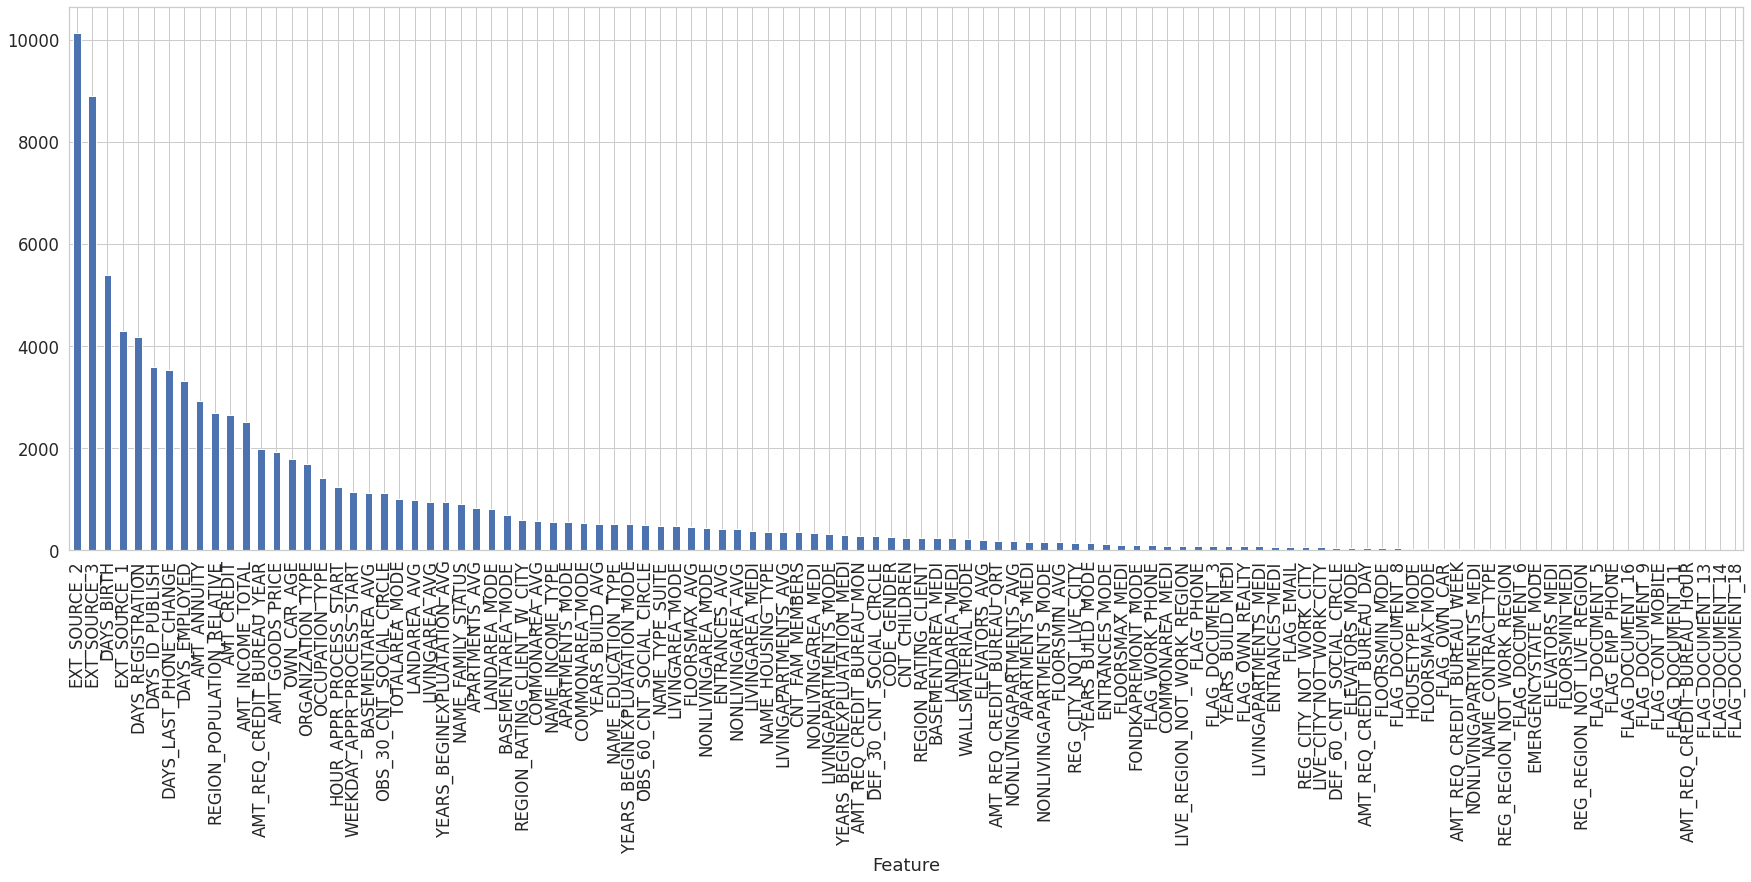

In [31]:
%%time

# Fast feature importances calculation
fast_fi = utilized_automl.get_feature_scores('fast', silent=False)
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

Note that in ```TabularUtilizedAutoML``` the first config doesn't have a LGBM feature selector (but second one already has it), so if there is enough time only for training with the first config, then ```'fast'``` feature importance calculation method won't work. ```'accurate'``` method will still work correctly.

CPU times: user 5min 30s, sys: 6.29 s, total: 5min 36s
Wall time: 2min 42s


<AxesSubplot: xlabel='Feature'>

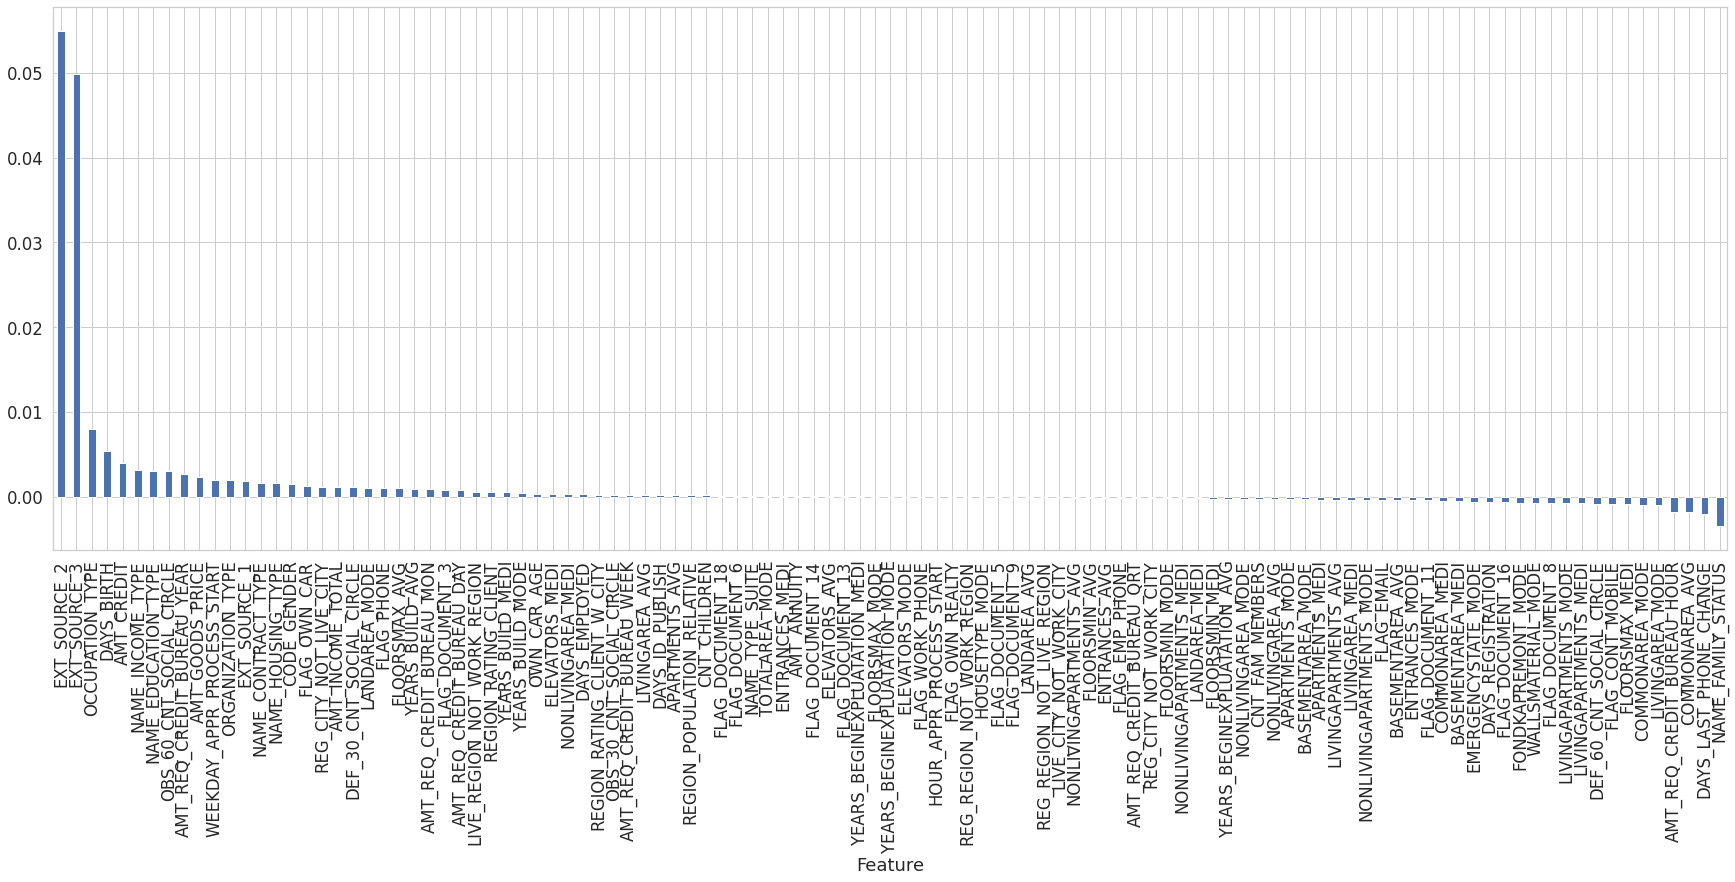

In [32]:
%%time

# Accurate feature importances calculation
fast_fi = utilized_automl.get_feature_scores('accurate', te_data, silent=True)
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

Prediction on holdout and metric calculation:

In [33]:
%%time

te_pred = utilized_automl.predict(te_data)
print(f'Prediction for te_data:\n{te_pred}\nShape = {te_pred.shape}')

Prediction for te_data:
array([[0.06354019],
       [0.09006689],
       [0.03471975],
       ...,
       [0.05975093],
       [0.0417911 ],
       [0.2169021 ]], dtype=float32)
Shape = (2000, 1)
CPU times: user 3.69 s, sys: 260 ms, total: 3.95 s
Wall time: 1.51 s


In [34]:
print(f'OOF score: {roc_auc_score(tr_data[TARGET_NAME].values, oof_pred.data[:, 0])}')
print(f'HOLDOUT score: {roc_auc_score(te_data[TARGET_NAME].values, te_pred.data[:, 0])}')

OOF score: 0.7588019930781842
HOLDOUT score: 0.7346297554347826


It is also important to note that using a ```ReportDeco``` decorator for a ```TabularUtilizedAutoML``` is not yet available.

## Bonus: another tasks examples

### Regression task

Without big differences from the case of binary classification, LightAutoML can solve the regression problems.

Load the data, split it into train and validation parts:

In [35]:
DATASET_NAME = 'reg_train.csv'
DATASET_FULLNAME = os.path.join(DATASET_DIR, DATASET_NAME)

DATASET_URL = 'https://raw.githubusercontent.com/reneemarama/aiming_high_in_aimes/master/datasets/train.csv'

if not os.path.exists(DATASET_FULLNAME):
    os.makedirs(DATASET_DIR, exist_ok=True)

    dataset = requests.get(DATASET_URL).text
    with open(DATASET_FULLNAME, 'w') as output:
        output.write(dataset)

In [36]:
data = pd.read_csv(DATASET_FULLNAME)
data.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [37]:
data.shape

(2051, 81)

In [38]:
tr_data, te_data = train_test_split(
    data, 
    test_size=TEST_SIZE,  
    random_state=RANDOM_STATE
)

print(f'Data is splitted. Parts sizes: tr_data = {tr_data.shape}, te_data = {te_data.shape}')

tr_data.head()

Data is splitted. Parts sizes: tr_data = (1640, 81), te_data = (411, 81)


,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
1448,452,528174050,120,RL,47.0,6904,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,8,2009,WD,213000
1771,1697,528110070,20,RL,110.0,14226,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,7,2007,New,395000
966,2294,923229100,80,RL,NaN,15957,Pave,NaN,IR1,Low,...,0,0,NaN,MnPrv,NaN,0,9,2007,WD,188000
1604,2449,528348010,60,RL,93.0,12090,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,7,2006,WD,258000
1827,1859,533254100,80,RL,80.0,9600,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,8,2007,WD,187000


Now we have a regression task, and it is necessary to specify it in ```Task``` object. Note that default loss and metric for regression task is MSE, but you can use any available functions, for example, MAE:

In [39]:
task = Task('reg', loss='mae', metric='mae')

Specifying columns roles:

In [40]:
roles = {
    'target': 'SalePrice',
    'drop': ['Id', 'PID']
}

Building AutoML model:

In [41]:
automl = TabularAutoML(
    task = task, 
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)

Training:

In [42]:
%%time 
oof_pred = automl.fit_predict(tr_data, roles = roles, verbose = 1)

[09:44:47] Stdout logging level is INFO3.
[09:44:48] Task: reg

[09:44:48] Start automl preset with listed constraints:
[09:44:48] - time: 300.00 seconds
[09:44:48] - CPU: 4 cores
[09:44:48] - memory: 16 GB

[09:44:48] Train data shape: (1640, 81)

[09:44:50] Feats was rejected during automatic roles guess: []
[09:44:50] Layer 1 train process start. Time left 297.91 secs
[09:44:50] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[09:44:50] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[09:44:50] Linear model: C = 1e-05 score = -183094.64445208485
[09:44:50] Linear model: C = 5e-05 score = -57324.85108612805
[09:44:50] Linear model: C = 0.0001 score = -57323.82526676829
[09:44:50] Linear model: C = 0.0005 score = -57316.334413109755
[09:44:50] Linear model: C = 0.001 score = -57307.03234565549
[09:44:50] Linear model: C = 0.005 score = -57230.16191882622
[09:44:50] Linear model: C = 0.01 score = -57131.97570503049
[09:44:50] Linear model: C = 0.05 score = -56359.89

[09:45:02] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[09:45:02] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
[09:45:02] Training until validation scores don't improve for 200 rounds
[09:45:03] [100]	valid's l1: 33057.1
[09:45:03] [200]	valid's l1: 23474
[09:45:03] [300]	valid's l1: 19371.7
[09:45:03] [400]	valid's l1: 17641.4
[09:45:03] [500]	valid's l1: 16930
[09:45:04] [600]	valid's l1: 16568
[09:45:04] [700]	valid's l1: 16305.2
[09:45:04] [800]	valid's l1: 16092.1
[09:45:04] [900]	valid's l1: 15948.9
[09:45:04] [1000]	valid's l1: 15840.5
[09:45:04] [1100]	valid's l1: 15761.5
[09:45:05] [1200]	valid's l1: 15659.3
[09:45:05] [1300]	valid's l1: 15592.3
[09:45:05] [1400]	valid's l1: 15554.8
[09:45:05] [1500]	valid's l1: 15524.8
[09:45:05] [1600]	valid's l1: 15456.3
[09:45:05] [1700]	valid's l1: 15403.6
[09:45:05] [1800]	valid's l1: 15372.4
[09:45:05] [1900]	valid's l1: 15348.2
[09:45:05] [2000]	valid's l1: 15333.1
[09:45:06] [2100]	valid's l1: 15284.9
[09:45

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:45:22] [200]	valid's l1: 22317.3
[09:45:22] [300]	valid's l1: 18614.9
[09:45:22] [400]	valid's l1: 17207
[09:45:22] [500]	valid's l1: 16600.3
[09:45:23] [600]	valid's l1: 16260.5
[09:45:23] [700]	valid's l1: 16089.2
[09:45:23] [800]	valid's l1: 15947.9
[09:45:23] [900]	valid's l1: 15824
[09:45:23] [1000]	valid's l1: 15714.7
[09:45:24] [1100]	valid's l1: 15631.9
[09:45:24] [1200]	valid's l1: 15579.6
[09:45:24] [1300]	valid's l1: 15537
[09:45:24] [1400]	valid's l1: 15483.3
[09:45:24] [1500]	valid's l1: 15433.7
[09:45:25] [1600]	valid's l1: 15403.4
[09:45:25] [1700]	valid's l1: 15363
[09:45:25] [1800]	valid's l1: 15339.6
[09:45:25] [1900]	valid's l1: 15321.7
[09:45:25] [2000]	valid's l1: 15270.1
[09:45:26] [2100]	valid's l1: 15228.7
[09:45:26] [2200]	valid's l1: 15207.6
[09:45:26] [2300]	valid's l1: 15181.1
[09:45:26] [2400]	valid's l1: 15168.9
[09:45:26] [2500]	valid's l1: 15151.2
[09:45:27] [2600]	valid's l1: 15153.3
[09:45:27] [2700]	valid's l1: 15152.3
[09:45:27] [2800]	valid's l1

[09:45:42] Shrink model to first 1989 iterations.
[09:45:42] ===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_2_CatBoost =====
[09:45:42] 0:	learn: 55942.9611003	test: 48821.9133906	best: 48821.9133906 (0)	total: 1.89ms	remaining: 3.78s
[09:45:42] 100:	learn: 15075.7796681	test: 16330.8129054	best: 16330.8129054 (100)	total: 100ms	remaining: 1.89s
[09:45:42] 200:	learn: 11572.4555531	test: 15338.3659430	best: 15338.3659430 (200)	total: 193ms	remaining: 1.72s
[09:45:42] 300:	learn: 9881.3960864	test: 15135.8748634	best: 15132.8584613 (294)	total: 285ms	remaining: 1.61s
[09:45:42] 400:	learn: 8769.0856849	test: 14898.6039479	best: 14898.6039479 (400)	total: 378ms	remaining: 1.51s
[09:45:43] 500:	learn: 7917.5125628	test: 14883.4616805	best: 14879.0864428 (497)	total: 471ms	remaining: 1.41s
[09:45:43] 600:	learn: 7284.5223695	test: 14781.7555151	best: 14772.5452005 (598)	total: 563ms	remaining: 1.31s
[09:45:43] 700:	learn: 6845.0595600	test: 14665.6232177	best: 14662.9405068 (693)	tot

[09:45:47] 1000:	learn: 5915.1550731	test: 14106.6656025	best: 14104.6648466 (996)	total: 696ms	remaining: 694ms
[09:45:47] 1100:	learn: 5669.3410102	test: 14086.8316315	best: 14086.8316315 (1100)	total: 764ms	remaining: 623ms
[09:45:47] 1200:	learn: 5462.0290787	test: 14095.0120239	best: 14086.8316315 (1100)	total: 831ms	remaining: 553ms
[09:45:47] 1300:	learn: 5275.1663904	test: 14102.3239681	best: 14086.8316315 (1100)	total: 903ms	remaining: 485ms
[09:45:47] 1400:	learn: 5088.6948050	test: 14080.5089773	best: 14068.7711991 (1389)	total: 1s	remaining: 428ms
[09:45:47] 1500:	learn: 4918.1643850	test: 14049.9162647	best: 14049.3945491 (1486)	total: 1.1s	remaining: 366ms
[09:45:48] 1600:	learn: 4762.2992684	test: 14056.6763288	best: 14035.7609447 (1545)	total: 1.2s	remaining: 298ms
[09:45:48] 1700:	learn: 4653.9006980	test: 14083.5083490	best: 14035.7609447 (1545)	total: 1.29s	remaining: 227ms
[09:45:48] 1800:	learn: 4533.1648980	test: 14104.7605838	best: 14035.7609447 (1545)	total: 1.3

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:45:48] 300:	learn: 11454.8962871	test: 16548.4522210	best: 16548.4522210 (300)	total: 177ms	remaining: 1s
[09:45:48] 400:	learn: 10484.9728585	test: 16138.2806351	best: 16138.2806351 (400)	total: 231ms	remaining: 920ms
[09:45:48] 500:	learn: 9764.9824922	test: 15917.1159244	best: 15909.8052229 (494)	total: 297ms	remaining: 888ms
[09:45:48] 600:	learn: 9156.4291032	test: 15800.8487852	best: 15792.5198007 (590)	total: 363ms	remaining: 844ms
[09:45:48] 700:	learn: 8663.6547675	test: 15595.0830740	best: 15595.0830740 (700)	total: 428ms	remaining: 794ms
[09:45:48] 800:	learn: 8298.7415999	test: 15616.9742303	best: 15595.0830740 (700)	total: 494ms	remaining: 739ms
[09:45:48] 900:	learn: 7994.3099915	test: 15586.8403096	best: 15579.0705406 (892)	total: 559ms	remaining: 682ms
[09:45:48] 1000:	learn: 7724.8065301	test: 15559.4150802	best: 15549.5987426 (996)	total: 625ms	remaining: 624ms
[09:45:49] 1100:	learn: 7462.6502423	test: 15563.8875893	best: 15549.5987426 (996)	total: 691ms	remainin

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:45:49] 400:	learn: 12180.5623824	test: 16724.7094430	best: 16724.7094430 (400)	total: 212ms	remaining: 846ms
[09:45:50] 500:	learn: 11524.4182368	test: 16534.9494528	best: 16534.0767953 (499)	total: 266ms	remaining: 795ms
[09:45:50] 600:	learn: 10975.7464131	test: 16485.0533995	best: 16481.7755495 (599)	total: 318ms	remaining: 741ms
[09:45:50] 700:	learn: 10538.6256719	test: 16393.3977437	best: 16380.4455220 (691)	total: 371ms	remaining: 687ms
[09:45:50] 800:	learn: 10203.3865069	test: 16349.8153794	best: 16345.5936136 (798)	total: 423ms	remaining: 634ms
[09:45:50] 900:	learn: 9891.9997891	test: 16292.9423177	best: 16292.9423177 (900)	total: 476ms	remaining: 580ms
[09:45:50] 1000:	learn: 9647.8418297	test: 16219.5815370	best: 16218.8964222 (994)	total: 528ms	remaining: 527ms
[09:45:50] 1100:	learn: 9392.6482603	test: 16173.7817964	best: 16170.9785261 (1090)	total: 581ms	remaining: 475ms
[09:45:50] 1200:	learn: 9179.5607189	test: 16178.0624749	best: 16150.5070550 (1192)	total: 634ms

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:45:50] 400:	learn: 12186.4421798	test: 16871.6156343	best: 16871.6156343 (400)	total: 210ms	remaining: 838ms
[09:45:50] 500:	learn: 11446.1499076	test: 16515.5791263	best: 16515.5791263 (500)	total: 263ms	remaining: 785ms
[09:45:50] 600:	learn: 10888.4560622	test: 16349.3905927	best: 16344.2031345 (597)	total: 315ms	remaining: 733ms
[09:45:51] 700:	learn: 10424.6346593	test: 16187.8098467	best: 16187.8098467 (700)	total: 367ms	remaining: 681ms
[09:45:51] 800:	learn: 10092.1352578	test: 16063.2289615	best: 16062.0307580 (797)	total: 420ms	remaining: 628ms
[09:45:51] 900:	learn: 9824.7204996	test: 15971.7803015	best: 15961.5499102 (881)	total: 472ms	remaining: 576ms
[09:45:51] 1000:	learn: 9555.0136944	test: 15919.7762611	best: 15909.3603757 (992)	total: 525ms	remaining: 524ms
[09:45:51] 1100:	learn: 9344.5054897	test: 15903.9828718	best: 15903.9828718 (1100)	total: 579ms	remaining: 473ms
[09:45:51] 1200:	learn: 9159.7148144	test: 15831.1238042	best: 15831.1238042 (1200)	total: 632ms

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:45:52] 400:	learn: 12180.5623824	test: 16724.7094430	best: 16724.7094430 (400)	total: 183ms	remaining: 728ms
[09:45:52] 500:	learn: 11524.4182368	test: 16534.9494528	best: 16534.0767953 (499)	total: 225ms	remaining: 673ms
[09:45:52] 600:	learn: 10975.7464131	test: 16485.0533995	best: 16481.7755495 (599)	total: 267ms	remaining: 622ms
[09:45:52] 700:	learn: 10538.6256719	test: 16393.3977437	best: 16380.4455220 (691)	total: 310ms	remaining: 574ms
[09:45:52] 800:	learn: 10203.3865069	test: 16349.8153794	best: 16345.5936136 (798)	total: 352ms	remaining: 527ms
[09:45:52] 900:	learn: 9891.9997891	test: 16292.9423177	best: 16292.9423177 (900)	total: 394ms	remaining: 481ms
[09:45:52] 1000:	learn: 9647.8418297	test: 16219.5815370	best: 16218.8964222 (994)	total: 437ms	remaining: 436ms
[09:45:52] 1100:	learn: 9392.6482603	test: 16173.7817964	best: 16170.9785261 (1090)	total: 480ms	remaining: 392ms
[09:45:52] 1200:	learn: 9179.5607189	test: 16178.0624749	best: 16150.5070550 (1192)	total: 523ms

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:45:52] 200:	learn: 9847.2768126	test: 16383.4962680	best: 16374.9126501 (199)	total: 183ms	remaining: 1.64s
[09:45:52] 300:	learn: 8063.4413400	test: 15941.6965940	best: 15938.6047495 (299)	total: 270ms	remaining: 1.52s
[09:45:52] 400:	learn: 6895.0599614	test: 15695.1294890	best: 15687.6934663 (399)	total: 357ms	remaining: 1.42s
[09:45:53] 500:	learn: 6061.4375628	test: 15540.9029436	best: 15540.9029436 (500)	total: 443ms	remaining: 1.33s
[09:45:53] 600:	learn: 5485.2946480	test: 15492.6279421	best: 15485.3524776 (568)	total: 529ms	remaining: 1.23s
[09:45:53] 700:	learn: 4995.3393758	test: 15476.0437174	best: 15466.9021395 (694)	total: 616ms	remaining: 1.14s
[09:45:53] 800:	learn: 4620.3712947	test: 15502.0166296	best: 15466.9021395 (694)	total: 702ms	remaining: 1.05s
[09:45:53] 900:	learn: 4305.0199027	test: 15468.8182130	best: 15465.4451431 (891)	total: 788ms	remaining: 962ms
[09:45:53] 1000:	learn: 4080.8411092	test: 15441.9074823	best: 15441.9074823 (1000)	total: 875ms	remaini

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:45:54] 200:	learn: 9847.2768126	test: 16383.4962680	best: 16374.9126501 (199)	total: 198ms	remaining: 1.77s
[09:45:54] 300:	learn: 8063.4413400	test: 15941.6965940	best: 15938.6047495 (299)	total: 284ms	remaining: 1.6s
[09:45:54] 400:	learn: 6895.0599614	test: 15695.1294890	best: 15687.6934663 (399)	total: 370ms	remaining: 1.48s
[09:45:54] 500:	learn: 6061.4375628	test: 15540.9029436	best: 15540.9029436 (500)	total: 457ms	remaining: 1.37s
[09:45:54] 600:	learn: 5485.2946480	test: 15492.6279421	best: 15485.3524776 (568)	total: 544ms	remaining: 1.27s
[09:45:54] 700:	learn: 4995.3393758	test: 15476.0437174	best: 15466.9021395 (694)	total: 630ms	remaining: 1.17s
[09:45:54] 800:	learn: 4620.3712947	test: 15502.0166296	best: 15466.9021395 (694)	total: 717ms	remaining: 1.07s
[09:45:54] 900:	learn: 4305.0199027	test: 15468.8182130	best: 15465.4451431 (891)	total: 820ms	remaining: 1000ms
[09:45:54] 1000:	learn: 4080.8411092	test: 15441.9074823	best: 15441.9074823 (1000)	total: 940ms	remaini

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:45:55] 200:	learn: 9915.7281917	test: 16604.7217107	best: 16591.4535786 (199)	total: 258ms	remaining: 2.31s
[09:45:55] 300:	learn: 8069.5057718	test: 16302.8551445	best: 16302.8551445 (300)	total: 378ms	remaining: 2.14s
[09:45:55] 400:	learn: 6994.5914814	test: 16094.4095903	best: 16094.4095903 (400)	total: 514ms	remaining: 2.05s
[09:45:55] 500:	learn: 6237.8906510	test: 15963.4029323	best: 15961.6979045 (497)	total: 634ms	remaining: 1.9s
[09:45:56] 600:	learn: 5619.8100830	test: 15975.4485781	best: 15947.1097083 (523)	total: 756ms	remaining: 1.76s
[09:45:56] 700:	learn: 5154.2123446	test: 15964.4454126	best: 15932.9753949 (647)	total: 876ms	remaining: 1.62s
[09:45:56] 800:	learn: 4752.9024203	test: 15955.3359175	best: 15932.4324026 (721)	total: 996ms	remaining: 1.49s
[09:45:56] 900:	learn: 4439.3140667	test: 15915.6964104	best: 15915.6964104 (900)	total: 1.12s	remaining: 1.36s
[09:45:56] 1000:	learn: 4173.5789606	test: 15868.2157642	best: 15855.2868214 (995)	total: 1.24s	remaining

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:45:58] 100:	learn: 12322.1795673	test: 18366.8707382	best: 18366.8707382 (100)	total: 178ms	remaining: 3.35s
[09:45:58] 200:	learn: 8613.6704672	test: 17046.1282273	best: 17046.1282273 (200)	total: 335ms	remaining: 3s
[09:45:58] 300:	learn: 6583.1589928	test: 16557.4932795	best: 16557.4932795 (300)	total: 491ms	remaining: 2.77s
[09:45:58] 400:	learn: 5309.3845981	test: 16427.0344574	best: 16427.0344574 (400)	total: 652ms	remaining: 2.6s
[09:45:58] 500:	learn: 4481.1063802	test: 16360.1137740	best: 16338.2623018 (482)	total: 810ms	remaining: 2.42s
[09:45:58] 600:	learn: 3940.9347504	test: 16286.6887570	best: 16283.3058132 (598)	total: 967ms	remaining: 2.25s
[09:45:59] 700:	learn: 3498.4959025	test: 16198.5662375	best: 16198.5662375 (700)	total: 1.12s	remaining: 2.08s
[09:45:59] 800:	learn: 3154.3044523	test: 16176.4620303	best: 16165.7631607 (792)	total: 1.28s	remaining: 1.92s
[09:45:59] 900:	learn: 2886.2535834	test: 16178.9252772	best: 16161.2945357 (877)	total: 1.44s	remaining: 1

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:46:01] 300:	learn: 13120.6966821	test: 17022.6672261	best: 17022.6672261 (300)	total: 196ms	remaining: 1.11s
[09:46:01] 400:	learn: 12177.8112976	test: 16770.2349208	best: 16770.2349208 (400)	total: 256ms	remaining: 1.02s
[09:46:01] 500:	learn: 11474.4673988	test: 16561.7018924	best: 16560.6308437 (499)	total: 317ms	remaining: 947ms
[09:46:01] 600:	learn: 10963.1865034	test: 16368.0713808	best: 16368.0713808 (600)	total: 377ms	remaining: 877ms
[09:46:01] 700:	learn: 10541.6956700	test: 16220.1661089	best: 16200.2761921 (698)	total: 437ms	remaining: 809ms
[09:46:01] 800:	learn: 10188.2598021	test: 16127.9316489	best: 16127.9316489 (800)	total: 498ms	remaining: 746ms
[09:46:01] 900:	learn: 9870.2071536	test: 16033.4917329	best: 16024.9578814 (886)	total: 559ms	remaining: 681ms
[09:46:01] 1000:	learn: 9595.4183140	test: 15969.5380659	best: 15966.6084292 (992)	total: 620ms	remaining: 619ms
[09:46:01] 1100:	learn: 9354.3465954	test: 15930.1308773	best: 15930.1308773 (1100)	total: 681ms	

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:46:02] 200:	learn: 9847.2768126	test: 16383.4962680	best: 16374.9126501 (199)	total: 240ms	remaining: 2.15s
[09:46:02] 300:	learn: 8063.4413400	test: 15941.6965940	best: 15938.6047495 (299)	total: 360ms	remaining: 2.03s
[09:46:02] 400:	learn: 6895.0599614	test: 15695.1294890	best: 15687.6934663 (399)	total: 479ms	remaining: 1.91s
[09:46:02] 500:	learn: 6061.4375628	test: 15540.9029436	best: 15540.9029436 (500)	total: 599ms	remaining: 1.79s
[09:46:03] 600:	learn: 5485.2946480	test: 15492.6279421	best: 15485.3524776 (568)	total: 717ms	remaining: 1.67s
[09:46:03] 700:	learn: 4995.3393758	test: 15476.0437174	best: 15466.9021395 (694)	total: 837ms	remaining: 1.55s
[09:46:03] 800:	learn: 4620.3712947	test: 15502.0166296	best: 15466.9021395 (694)	total: 960ms	remaining: 1.44s
[09:46:03] 900:	learn: 4305.0199027	test: 15468.8182130	best: 15465.4451431 (891)	total: 1.08s	remaining: 1.31s
[09:46:03] 1000:	learn: 4080.8411092	test: 15441.9074823	best: 15441.9074823 (1000)	total: 1.2s	remainin

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:46:04] 200:	learn: 11763.6024447	test: 16690.4627624	best: 16686.7056478 (198)	total: 206ms	remaining: 1.84s
[09:46:04] 300:	learn: 9839.5104688	test: 16065.5455422	best: 16065.5455422 (300)	total: 304ms	remaining: 1.71s
[09:46:04] 400:	learn: 8716.3223682	test: 15710.0966466	best: 15710.0966466 (400)	total: 399ms	remaining: 1.59s
[09:46:04] 500:	learn: 7914.3146990	test: 15572.4153026	best: 15569.0774330 (498)	total: 496ms	remaining: 1.48s
[09:46:04] 600:	learn: 7283.2374377	test: 15382.0495663	best: 15377.3938142 (599)	total: 593ms	remaining: 1.38s
[09:46:04] 700:	learn: 6803.3156309	test: 15389.4791248	best: 15348.8343429 (668)	total: 688ms	remaining: 1.27s
[09:46:04] 800:	learn: 6432.8780282	test: 15285.8646233	best: 15284.8316241 (777)	total: 784ms	remaining: 1.17s
[09:46:04] 900:	learn: 6106.0860653	test: 15234.2733531	best: 15228.9690234 (899)	total: 882ms	remaining: 1.07s
[09:46:05] 1000:	learn: 5826.7348600	test: 15205.6601071	best: 15195.1174895 (988)	total: 977ms	remaini

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:46:06] 200:	learn: 11763.6024447	test: 16690.4627624	best: 16686.7056478 (198)	total: 193ms	remaining: 1.72s
[09:46:06] 300:	learn: 9839.5104688	test: 16065.5455422	best: 16065.5455422 (300)	total: 288ms	remaining: 1.62s
[09:46:06] 400:	learn: 8716.3223682	test: 15710.0966466	best: 15710.0966466 (400)	total: 382ms	remaining: 1.52s
[09:46:06] 500:	learn: 7914.3146990	test: 15572.4153026	best: 15569.0774330 (498)	total: 477ms	remaining: 1.43s
[09:46:06] 600:	learn: 7283.2374377	test: 15382.0495663	best: 15377.3938142 (599)	total: 572ms	remaining: 1.33s
[09:46:06] 700:	learn: 6803.3156309	test: 15389.4791248	best: 15348.8343429 (668)	total: 668ms	remaining: 1.24s
[09:46:06] 800:	learn: 6432.8780282	test: 15285.8646233	best: 15284.8316241 (777)	total: 762ms	remaining: 1.14s
[09:46:07] 900:	learn: 6106.0860653	test: 15234.2733531	best: 15228.9690234 (899)	total: 857ms	remaining: 1.04s
[09:46:07] 1000:	learn: 5826.7348600	test: 15205.6601071	best: 15195.1174895 (988)	total: 951ms	remaini

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:46:08] 200:	learn: 11763.6024447	test: 16690.4627624	best: 16686.7056478 (198)	total: 194ms	remaining: 1.74s
[09:46:08] 300:	learn: 9839.5104688	test: 16065.5455422	best: 16065.5455422 (300)	total: 291ms	remaining: 1.64s
[09:46:08] 400:	learn: 8716.3223682	test: 15710.0966466	best: 15710.0966466 (400)	total: 387ms	remaining: 1.54s
[09:46:08] 500:	learn: 7914.3146990	test: 15572.4153026	best: 15569.0774330 (498)	total: 481ms	remaining: 1.44s
[09:46:08] 600:	learn: 7283.2374377	test: 15382.0495663	best: 15377.3938142 (599)	total: 577ms	remaining: 1.34s
[09:46:08] 700:	learn: 6803.3156309	test: 15389.4791248	best: 15348.8343429 (668)	total: 672ms	remaining: 1.25s
[09:46:09] 800:	learn: 6432.8780282	test: 15285.8646233	best: 15284.8316241 (777)	total: 768ms	remaining: 1.15s
[09:46:09] 900:	learn: 6106.0860653	test: 15234.2733531	best: 15228.9690234 (899)	total: 865ms	remaining: 1.05s
[09:46:09] 1000:	learn: 5826.7348600	test: 15205.6601071	best: 15195.1174895 (988)	total: 960ms	remaini

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:46:10] 100:	learn: 15042.1208375	test: 18252.2032759	best: 18252.2032759 (100)	total: 164ms	remaining: 3.09s
[09:46:10] 200:	learn: 11763.6024447	test: 16690.4627624	best: 16686.7056478 (198)	total: 286ms	remaining: 2.56s
[09:46:10] 300:	learn: 9839.5104688	test: 16065.5455422	best: 16065.5455422 (300)	total: 410ms	remaining: 2.31s
[09:46:11] 400:	learn: 8716.3223682	test: 15710.0966466	best: 15710.0966466 (400)	total: 563ms	remaining: 2.24s
[09:46:11] 500:	learn: 7914.3146990	test: 15572.4153026	best: 15569.0774330 (498)	total: 736ms	remaining: 2.2s
[09:46:11] 600:	learn: 7283.2374377	test: 15382.0495663	best: 15377.3938142 (599)	total: 899ms	remaining: 2.09s
[09:46:11] 700:	learn: 6803.3156309	test: 15389.4791248	best: 15348.8343429 (668)	total: 1.06s	remaining: 1.97s
[09:46:11] 800:	learn: 6432.8780282	test: 15285.8646233	best: 15284.8316241 (777)	total: 1.21s	remaining: 1.81s
[09:46:11] 900:	learn: 6106.0860653	test: 15234.2733531	best: 15228.9690234 (899)	total: 1.34s	remainin

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:46:13] 300:	learn: 11523.0155818	test: 16634.2485398	best: 16624.0482051 (298)	total: 235ms	remaining: 1.33s
[09:46:13] 400:	learn: 10394.5653317	test: 16308.6901960	best: 16308.6901960 (400)	total: 313ms	remaining: 1.25s
[09:46:13] 500:	learn: 9674.9241956	test: 16005.3528086	best: 15998.3923235 (493)	total: 391ms	remaining: 1.17s
[09:46:13] 600:	learn: 9029.1021085	test: 15706.9920078	best: 15703.8038824 (599)	total: 469ms	remaining: 1.09s
[09:46:13] 700:	learn: 8623.0485156	test: 15619.6784738	best: 15619.6784738 (700)	total: 547ms	remaining: 1.01s
[09:46:13] 800:	learn: 8275.0803934	test: 15573.1496627	best: 15569.7314028 (796)	total: 626ms	remaining: 937ms
[09:46:13] 900:	learn: 7960.1757931	test: 15548.5286000	best: 15547.6123779 (863)	total: 704ms	remaining: 858ms
[09:46:13] 1000:	learn: 7675.0576735	test: 15504.0583040	best: 15499.0907413 (965)	total: 782ms	remaining: 780ms
[09:46:13] 1100:	learn: 7378.6934646	test: 15445.8082800	best: 15442.4201783 (1086)	total: 862ms	rema

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:46:14] 200:	learn: 13224.0218498	test: 17380.9625951	best: 17380.9625951 (200)	total: 170ms	remaining: 1.52s
[09:46:15] 300:	learn: 11523.0155818	test: 16634.2485398	best: 16624.0482051 (298)	total: 248ms	remaining: 1.4s
[09:46:15] 400:	learn: 10394.5653317	test: 16308.6901960	best: 16308.6901960 (400)	total: 326ms	remaining: 1.3s
[09:46:15] 500:	learn: 9674.9241956	test: 16005.3528086	best: 15998.3923235 (493)	total: 403ms	remaining: 1.21s
[09:46:15] 600:	learn: 9029.1021085	test: 15706.9920078	best: 15703.8038824 (599)	total: 482ms	remaining: 1.12s
[09:46:15] 700:	learn: 8623.0485156	test: 15619.6784738	best: 15619.6784738 (700)	total: 561ms	remaining: 1.04s
[09:46:15] 800:	learn: 8275.0803934	test: 15573.1496627	best: 15569.7314028 (796)	total: 638ms	remaining: 955ms
[09:46:15] 900:	learn: 7960.1757931	test: 15548.5286000	best: 15547.6123779 (863)	total: 715ms	remaining: 872ms
[09:46:15] 1000:	learn: 7675.0576735	test: 15504.0583040	best: 15499.0907413 (965)	total: 792ms	remaini

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:46:16] 200:	learn: 11763.6024447	test: 16690.4627624	best: 16686.7056478 (198)	total: 196ms	remaining: 1.75s
[09:46:16] 300:	learn: 9839.5104688	test: 16065.5455422	best: 16065.5455422 (300)	total: 291ms	remaining: 1.64s
[09:46:16] 400:	learn: 8716.3223682	test: 15710.0966466	best: 15710.0966466 (400)	total: 387ms	remaining: 1.54s
[09:46:16] 500:	learn: 7914.3146990	test: 15572.4153026	best: 15569.0774330 (498)	total: 482ms	remaining: 1.44s
[09:46:17] 600:	learn: 7283.2374377	test: 15382.0495663	best: 15377.3938142 (599)	total: 577ms	remaining: 1.34s
[09:46:17] 700:	learn: 6803.3156309	test: 15389.4791248	best: 15348.8343429 (668)	total: 671ms	remaining: 1.24s
[09:46:17] 800:	learn: 6432.8780282	test: 15285.8646233	best: 15284.8316241 (777)	total: 766ms	remaining: 1.15s
[09:46:17] 900:	learn: 6106.0860653	test: 15234.2733531	best: 15228.9690234 (899)	total: 861ms	remaining: 1.05s
[09:46:17] 1000:	learn: 5826.7348600	test: 15205.6601071	best: 15195.1174895 (988)	total: 957ms	remaini

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:46:18] 200:	learn: 8450.9371524	test: 16769.7471578	best: 16762.9389537 (194)	total: 314ms	remaining: 2.81s
[09:46:19] 300:	learn: 6326.9658473	test: 16329.1584579	best: 16329.1584579 (300)	total: 472ms	remaining: 2.67s
[09:46:19] 400:	learn: 5180.4039426	test: 16246.1041621	best: 16221.9713599 (392)	total: 631ms	remaining: 2.51s
[09:46:19] 500:	learn: 4432.8828377	test: 16208.8027652	best: 16191.1656323 (487)	total: 786ms	remaining: 2.35s
[09:46:19] 600:	learn: 3886.4223549	test: 16132.5984359	best: 16124.9063027 (597)	total: 943ms	remaining: 2.19s
[09:46:19] 700:	learn: 3509.1265642	test: 16133.0666073	best: 16124.9063027 (597)	total: 1.1s	remaining: 2.04s
[09:46:19] 800:	learn: 3175.0561883	test: 16132.1053592	best: 16104.1195849 (786)	total: 1.26s	remaining: 1.89s
[09:46:19] 900:	learn: 2923.4628168	test: 16123.9296031	best: 16104.1195849 (786)	total: 1.42s	remaining: 1.73s
[09:46:20] 1000:	learn: 2686.1091917	test: 16106.6917650	best: 16102.6617596 (996)	total: 1.57s	remaining

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:46:22] 300:	learn: 11729.7721682	test: 16890.1542458	best: 16890.1542458 (300)	total: 211ms	remaining: 1.19s
[09:46:22] 400:	learn: 10571.3661659	test: 16424.1947145	best: 16423.6365742 (399)	total: 279ms	remaining: 1.11s
[09:46:22] 500:	learn: 9908.4432549	test: 16179.0690683	best: 16179.0690683 (500)	total: 347ms	remaining: 1.04s
[09:46:22] 600:	learn: 9275.6571980	test: 16101.0292335	best: 16101.0292335 (600)	total: 414ms	remaining: 965ms
[09:46:22] 700:	learn: 8781.8427410	test: 15877.7479075	best: 15874.7424863 (692)	total: 483ms	remaining: 895ms
[09:46:22] 800:	learn: 8368.1470764	test: 15768.2061661	best: 15766.2708062 (785)	total: 551ms	remaining: 825ms
[09:46:22] 900:	learn: 8061.8043735	test: 15688.8929856	best: 15688.8929856 (900)	total: 620ms	remaining: 756ms
[09:46:22] 1000:	learn: 7739.9448830	test: 15639.3992766	best: 15622.8810872 (990)	total: 689ms	remaining: 688ms
[09:46:22] 1100:	learn: 7495.8530936	test: 15621.5313149	best: 15614.7272191 (1097)	total: 758ms	rema

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:46:23] 200:	learn: 11763.6024447	test: 16690.4627624	best: 16686.7056478 (198)	total: 192ms	remaining: 1.72s
[09:46:23] 300:	learn: 9839.5104688	test: 16065.5455422	best: 16065.5455422 (300)	total: 285ms	remaining: 1.61s
[09:46:23] 400:	learn: 8716.3223682	test: 15710.0966466	best: 15710.0966466 (400)	total: 380ms	remaining: 1.51s
[09:46:23] 500:	learn: 7914.3146990	test: 15572.4153026	best: 15569.0774330 (498)	total: 474ms	remaining: 1.42s
[09:46:23] 600:	learn: 7283.2374377	test: 15382.0495663	best: 15377.3938142 (599)	total: 569ms	remaining: 1.32s
[09:46:24] 700:	learn: 6803.3156309	test: 15389.4791248	best: 15348.8343429 (668)	total: 663ms	remaining: 1.23s
[09:46:24] 800:	learn: 6432.8780282	test: 15285.8646233	best: 15284.8316241 (777)	total: 759ms	remaining: 1.14s
[09:46:24] 900:	learn: 6106.0860653	test: 15234.2733531	best: 15228.9690234 (899)	total: 855ms	remaining: 1.04s
[09:46:24] 1000:	learn: 5826.7348600	test: 15205.6601071	best: 15195.1174895 (988)	total: 951ms	remaini

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:46:25] 300:	learn: 9839.5104688	test: 16065.5455422	best: 16065.5455422 (300)	total: 206ms	remaining: 1.16s
[09:46:25] 400:	learn: 8716.3223682	test: 15710.0966466	best: 15710.0966466 (400)	total: 275ms	remaining: 1.1s
[09:46:25] 500:	learn: 7914.3146990	test: 15572.4153026	best: 15569.0774330 (498)	total: 343ms	remaining: 1.03s
[09:46:25] 600:	learn: 7283.2374377	test: 15382.0495663	best: 15377.3938142 (599)	total: 411ms	remaining: 956ms
[09:46:25] 700:	learn: 6803.3156309	test: 15389.4791248	best: 15348.8343429 (668)	total: 478ms	remaining: 886ms
[09:46:26] 800:	learn: 6432.8780282	test: 15285.8646233	best: 15284.8316241 (777)	total: 546ms	remaining: 817ms
[09:46:26] 900:	learn: 6106.0860653	test: 15234.2733531	best: 15228.9690234 (899)	total: 613ms	remaining: 748ms
[09:46:26] 1000:	learn: 5826.7348600	test: 15205.6601071	best: 15195.1174895 (988)	total: 681ms	remaining: 679ms
[09:46:26] 1100:	learn: 5568.1626792	test: 15171.1189718	best: 15162.7843126 (1093)	total: 749ms	remaini

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:46:27] 300:	learn: 9839.5104688	test: 16065.5455422	best: 16065.5455422 (300)	total: 201ms	remaining: 1.14s
[09:46:27] 400:	learn: 8716.3223682	test: 15710.0966466	best: 15710.0966466 (400)	total: 268ms	remaining: 1.07s
[09:46:27] 500:	learn: 7914.3146990	test: 15572.4153026	best: 15569.0774330 (498)	total: 335ms	remaining: 1s
[09:46:27] 600:	learn: 7283.2374377	test: 15382.0495663	best: 15377.3938142 (599)	total: 402ms	remaining: 937ms
[09:46:27] 700:	learn: 6803.3156309	test: 15389.4791248	best: 15348.8343429 (668)	total: 470ms	remaining: 871ms
[09:46:27] 800:	learn: 6432.8780282	test: 15285.8646233	best: 15284.8316241 (777)	total: 537ms	remaining: 804ms
[09:46:27] 900:	learn: 6106.0860653	test: 15234.2733531	best: 15228.9690234 (899)	total: 604ms	remaining: 737ms
[09:46:27] 1000:	learn: 5826.7348600	test: 15205.6601071	best: 15195.1174895 (988)	total: 671ms	remaining: 670ms
[09:46:27] 1100:	learn: 5568.1626792	test: 15171.1189718	best: 15162.7843126 (1093)	total: 738ms	remaining

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:46:28] 300:	learn: 9839.5104688	test: 16065.5455422	best: 16065.5455422 (300)	total: 203ms	remaining: 1.15s
[09:46:28] 400:	learn: 8716.3223682	test: 15710.0966466	best: 15710.0966466 (400)	total: 270ms	remaining: 1.08s
[09:46:28] 500:	learn: 7914.3146990	test: 15572.4153026	best: 15569.0774330 (498)	total: 337ms	remaining: 1.01s
[09:46:28] 600:	learn: 7283.2374377	test: 15382.0495663	best: 15377.3938142 (599)	total: 404ms	remaining: 939ms
[09:46:28] 700:	learn: 6803.3156309	test: 15389.4791248	best: 15348.8343429 (668)	total: 470ms	remaining: 871ms
[09:46:29] 800:	learn: 6432.8780282	test: 15285.8646233	best: 15284.8316241 (777)	total: 537ms	remaining: 804ms
[09:46:29] 900:	learn: 6106.0860653	test: 15234.2733531	best: 15228.9690234 (899)	total: 605ms	remaining: 738ms
[09:46:29] 1000:	learn: 5826.7348600	test: 15205.6601071	best: 15195.1174895 (988)	total: 672ms	remaining: 671ms
[09:46:29] 1100:	learn: 5568.1626792	test: 15171.1189718	best: 15162.7843126 (1093)	total: 740ms	remain

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:46:30] 200:	learn: 9847.2768126	test: 16383.4962680	best: 16374.9126501 (199)	total: 219ms	remaining: 1.96s
[09:46:30] 300:	learn: 8063.4413400	test: 15941.6965940	best: 15938.6047495 (299)	total: 325ms	remaining: 1.84s
[09:46:30] 400:	learn: 6895.0599614	test: 15695.1294890	best: 15687.6934663 (399)	total: 433ms	remaining: 1.73s
[09:46:30] 500:	learn: 6061.4375628	test: 15540.9029436	best: 15540.9029436 (500)	total: 541ms	remaining: 1.62s
[09:46:30] 600:	learn: 5485.2946480	test: 15492.6279421	best: 15485.3524776 (568)	total: 649ms	remaining: 1.51s
[09:46:30] 700:	learn: 4995.3393758	test: 15476.0437174	best: 15466.9021395 (694)	total: 756ms	remaining: 1.4s
[09:46:30] 800:	learn: 4620.3712947	test: 15502.0166296	best: 15466.9021395 (694)	total: 865ms	remaining: 1.29s
[09:46:30] 900:	learn: 4305.0199027	test: 15468.8182130	best: 15465.4451431 (891)	total: 973ms	remaining: 1.19s
[09:46:31] 1000:	learn: 4080.8411092	test: 15441.9074823	best: 15441.9074823 (1000)	total: 1.08s	remainin

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:46:31] 300:	learn: 11523.0155818	test: 16634.2485398	best: 16624.0482051 (298)	total: 167ms	remaining: 943ms
[09:46:31] 400:	learn: 10394.5653317	test: 16308.6901960	best: 16308.6901960 (400)	total: 223ms	remaining: 891ms
[09:46:31] 500:	learn: 9674.9241956	test: 16005.3528086	best: 15998.3923235 (493)	total: 279ms	remaining: 834ms
[09:46:31] 600:	learn: 9029.1021085	test: 15706.9920078	best: 15703.8038824 (599)	total: 334ms	remaining: 778ms
[09:46:31] 700:	learn: 8623.0485156	test: 15619.6784738	best: 15619.6784738 (700)	total: 390ms	remaining: 722ms
[09:46:31] 800:	learn: 8275.0803934	test: 15573.1496627	best: 15569.7314028 (796)	total: 445ms	remaining: 666ms
[09:46:32] 900:	learn: 7960.1757931	test: 15548.5286000	best: 15547.6123779 (863)	total: 500ms	remaining: 610ms
[09:46:32] 1000:	learn: 7675.0576735	test: 15504.0583040	best: 15499.0907413 (965)	total: 556ms	remaining: 555ms
[09:46:32] 1100:	learn: 7378.6934646	test: 15445.8082800	best: 15442.4201783 (1086)	total: 611ms	rema

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:46:32] 300:	learn: 9839.5104688	test: 16065.5455422	best: 16065.5455422 (300)	total: 206ms	remaining: 1.16s
[09:46:33] 400:	learn: 8716.3223682	test: 15710.0966466	best: 15710.0966466 (400)	total: 273ms	remaining: 1.09s
[09:46:33] 500:	learn: 7914.3146990	test: 15572.4153026	best: 15569.0774330 (498)	total: 341ms	remaining: 1.02s
[09:46:33] 600:	learn: 7283.2374377	test: 15382.0495663	best: 15377.3938142 (599)	total: 410ms	remaining: 955ms
[09:46:33] 700:	learn: 6803.3156309	test: 15389.4791248	best: 15348.8343429 (668)	total: 477ms	remaining: 885ms
[09:46:33] 800:	learn: 6432.8780282	test: 15285.8646233	best: 15284.8316241 (777)	total: 545ms	remaining: 816ms
[09:46:33] 900:	learn: 6106.0860653	test: 15234.2733531	best: 15228.9690234 (899)	total: 613ms	remaining: 748ms
[09:46:33] 1000:	learn: 5826.7348600	test: 15205.6601071	best: 15195.1174895 (988)	total: 680ms	remaining: 679ms
[09:46:33] 1100:	learn: 5568.1626792	test: 15171.1189718	best: 15162.7843126 (1093)	total: 748ms	remain

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:46:34] 200:	learn: 10221.2455958	test: 16709.6845801	best: 16709.6845801 (200)	total: 249ms	remaining: 2.23s
[09:46:34] 300:	learn: 8385.7535596	test: 16287.8561057	best: 16285.3046972 (299)	total: 369ms	remaining: 2.08s
[09:46:34] 400:	learn: 7178.7049592	test: 16151.9524333	best: 16151.9524333 (400)	total: 490ms	remaining: 1.95s
[09:46:34] 500:	learn: 6352.7675714	test: 15968.2710823	best: 15966.2713838 (488)	total: 609ms	remaining: 1.82s
[09:46:35] 600:	learn: 5788.8715123	test: 15905.6621374	best: 15899.8934058 (599)	total: 728ms	remaining: 1.69s
[09:46:35] 700:	learn: 5339.0659656	test: 15869.2312949	best: 15859.2287888 (668)	total: 847ms	remaining: 1.57s
[09:46:35] 800:	learn: 4946.0597852	test: 15781.0019981	best: 15763.7627049 (782)	total: 967ms	remaining: 1.45s
[09:46:35] 900:	learn: 4622.6487487	test: 15748.8041347	best: 15741.0813887 (871)	total: 1.09s	remaining: 1.33s
[09:46:35] 1000:	learn: 4337.6262093	test: 15737.2182385	best: 15733.3532396 (921)	total: 1.21s	remaini

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:46:36] 0:	learn: 54278.2217721	test: 55672.9389991	best: 55672.9389991 (0)	total: 1.41ms	remaining: 2.81s
[09:46:36] 100:	learn: 16357.8377254	test: 19174.1527816	best: 19174.1527816 (100)	total: 81.1ms	remaining: 1.52s
[09:46:36] 200:	learn: 13224.0218498	test: 17380.9625951	best: 17380.9625951 (200)	total: 159ms	remaining: 1.42s
[09:46:36] 300:	learn: 11523.0155818	test: 16634.2485398	best: 16624.0482051 (298)	total: 231ms	remaining: 1.31s
[09:46:36] 400:	learn: 10394.5653317	test: 16308.6901960	best: 16308.6901960 (400)	total: 298ms	remaining: 1.19s
[09:46:36] 500:	learn: 9674.9241956	test: 16005.3528086	best: 15998.3923235 (493)	total: 364ms	remaining: 1.09s
[09:46:36] 600:	learn: 9029.1021085	test: 15706.9920078	best: 15703.8038824 (599)	total: 435ms	remaining: 1.01s
[09:46:36] 700:	learn: 8623.0485156	test: 15619.6784738	best: 15619.6784738 (700)	total: 502ms	remaining: 931ms
[09:46:37] 800:	learn: 8275.0803934	test: 15573.1496627	best: 15569.7314028 (796)	total: 571ms	remain

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:46:38] 300:	learn: 9839.5104688	test: 16065.5455422	best: 16065.5455422 (300)	total: 227ms	remaining: 1.28s
[09:46:38] 400:	learn: 8716.3223682	test: 15710.0966466	best: 15710.0966466 (400)	total: 295ms	remaining: 1.18s
[09:46:38] 500:	learn: 7914.3146990	test: 15572.4153026	best: 15569.0774330 (498)	total: 364ms	remaining: 1.09s
[09:46:38] 600:	learn: 7283.2374377	test: 15382.0495663	best: 15377.3938142 (599)	total: 433ms	remaining: 1.01s
[09:46:38] 700:	learn: 6803.3156309	test: 15389.4791248	best: 15348.8343429 (668)	total: 502ms	remaining: 930ms
[09:46:38] 800:	learn: 6432.8780282	test: 15285.8646233	best: 15284.8316241 (777)	total: 570ms	remaining: 853ms
[09:46:38] 900:	learn: 6106.0860653	test: 15234.2733531	best: 15228.9690234 (899)	total: 639ms	remaining: 779ms
[09:46:38] 1000:	learn: 5826.7348600	test: 15205.6601071	best: 15195.1174895 (988)	total: 708ms	remaining: 706ms
[09:46:38] 1100:	learn: 5568.1626792	test: 15171.1189718	best: 15162.7843126 (1093)	total: 777ms	remain

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:46:39] 300:	learn: 11454.8962871	test: 16548.4522210	best: 16548.4522210 (300)	total: 204ms	remaining: 1.15s
[09:46:39] 400:	learn: 10484.9728585	test: 16138.2806351	best: 16138.2806351 (400)	total: 271ms	remaining: 1.08s
[09:46:39] 500:	learn: 9764.9824922	test: 15917.1159244	best: 15909.8052229 (494)	total: 338ms	remaining: 1.01s
[09:46:39] 600:	learn: 9156.4291032	test: 15800.8487852	best: 15792.5198007 (590)	total: 407ms	remaining: 947ms
[09:46:39] 700:	learn: 8663.6547675	test: 15595.0830740	best: 15595.0830740 (700)	total: 474ms	remaining: 878ms
[09:46:40] 800:	learn: 8298.7415999	test: 15616.9742303	best: 15595.0830740 (700)	total: 541ms	remaining: 810ms
[09:46:40] 900:	learn: 7994.3099915	test: 15586.8403096	best: 15579.0705406 (892)	total: 609ms	remaining: 743ms
[09:46:40] 1000:	learn: 7724.8065301	test: 15559.4150802	best: 15549.5987426 (996)	total: 677ms	remaining: 675ms
[09:46:40] 1100:	learn: 7462.6502423	test: 15563.8875893	best: 15549.5987426 (996)	total: 745ms	remai

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:46:41] 200:	learn: 9847.2768126	test: 16383.4962680	best: 16374.9126501 (199)	total: 178ms	remaining: 1.59s
[09:46:41] 300:	learn: 8063.4413400	test: 15941.6965940	best: 15938.6047495 (299)	total: 264ms	remaining: 1.49s
[09:46:41] 400:	learn: 6895.0599614	test: 15695.1294890	best: 15687.6934663 (399)	total: 352ms	remaining: 1.4s
[09:46:41] 500:	learn: 6061.4375628	test: 15540.9029436	best: 15540.9029436 (500)	total: 439ms	remaining: 1.31s
[09:46:41] 600:	learn: 5485.2946480	test: 15492.6279421	best: 15485.3524776 (568)	total: 526ms	remaining: 1.22s
[09:46:41] 700:	learn: 4995.3393758	test: 15476.0437174	best: 15466.9021395 (694)	total: 613ms	remaining: 1.14s
[09:46:41] 800:	learn: 4620.3712947	test: 15502.0166296	best: 15466.9021395 (694)	total: 700ms	remaining: 1.05s
[09:46:41] 900:	learn: 4305.0199027	test: 15468.8182130	best: 15465.4451431 (891)	total: 787ms	remaining: 960ms
[09:46:41] 1000:	learn: 4080.8411092	test: 15441.9074823	best: 15441.9074823 (1000)	total: 874ms	remainin

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:46:42] 300:	learn: 9839.5104688	test: 16065.5455422	best: 16065.5455422 (300)	total: 203ms	remaining: 1.15s
[09:46:42] 400:	learn: 8716.3223682	test: 15710.0966466	best: 15710.0966466 (400)	total: 271ms	remaining: 1.08s
[09:46:42] 500:	learn: 7914.3146990	test: 15572.4153026	best: 15569.0774330 (498)	total: 339ms	remaining: 1.01s
[09:46:42] 600:	learn: 7283.2374377	test: 15382.0495663	best: 15377.3938142 (599)	total: 407ms	remaining: 948ms
[09:46:42] 700:	learn: 6803.3156309	test: 15389.4791248	best: 15348.8343429 (668)	total: 476ms	remaining: 882ms
[09:46:42] 800:	learn: 6432.8780282	test: 15285.8646233	best: 15284.8316241 (777)	total: 544ms	remaining: 815ms
[09:46:42] 900:	learn: 6106.0860653	test: 15234.2733531	best: 15228.9690234 (899)	total: 611ms	remaining: 746ms
[09:46:42] 1000:	learn: 5826.7348600	test: 15205.6601071	best: 15195.1174895 (988)	total: 679ms	remaining: 677ms
[09:46:43] 1100:	learn: 5568.1626792	test: 15171.1189718	best: 15162.7843126 (1093)	total: 745ms	remain

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:46:43] 200:	learn: 11763.6024447	test: 16690.4627624	best: 16686.7056478 (198)	total: 195ms	remaining: 1.74s
[09:46:44] 300:	learn: 9839.5104688	test: 16065.5455422	best: 16065.5455422 (300)	total: 286ms	remaining: 1.62s
[09:46:44] 400:	learn: 8716.3223682	test: 15710.0966466	best: 15710.0966466 (400)	total: 379ms	remaining: 1.51s
[09:46:44] 500:	learn: 7914.3146990	test: 15572.4153026	best: 15569.0774330 (498)	total: 472ms	remaining: 1.41s
[09:46:44] 600:	learn: 7283.2374377	test: 15382.0495663	best: 15377.3938142 (599)	total: 566ms	remaining: 1.32s
[09:46:44] 700:	learn: 6803.3156309	test: 15389.4791248	best: 15348.8343429 (668)	total: 660ms	remaining: 1.22s
[09:46:44] 800:	learn: 6432.8780282	test: 15285.8646233	best: 15284.8316241 (777)	total: 753ms	remaining: 1.13s
[09:46:44] 900:	learn: 6106.0860653	test: 15234.2733531	best: 15228.9690234 (899)	total: 847ms	remaining: 1.03s
[09:46:44] 1000:	learn: 5826.7348600	test: 15205.6601071	best: 15195.1174895 (988)	total: 939ms	remaini

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:46:45] 300:	learn: 9839.5104688	test: 16065.5455422	best: 16065.5455422 (300)	total: 202ms	remaining: 1.14s
[09:46:46] 400:	learn: 8716.3223682	test: 15710.0966466	best: 15710.0966466 (400)	total: 269ms	remaining: 1.07s
[09:46:46] 500:	learn: 7914.3146990	test: 15572.4153026	best: 15569.0774330 (498)	total: 337ms	remaining: 1.01s
[09:46:46] 600:	learn: 7283.2374377	test: 15382.0495663	best: 15377.3938142 (599)	total: 404ms	remaining: 939ms
[09:46:46] 700:	learn: 6803.3156309	test: 15389.4791248	best: 15348.8343429 (668)	total: 471ms	remaining: 873ms
[09:46:46] 800:	learn: 6432.8780282	test: 15285.8646233	best: 15284.8316241 (777)	total: 538ms	remaining: 805ms
[09:46:46] 900:	learn: 6106.0860653	test: 15234.2733531	best: 15228.9690234 (899)	total: 605ms	remaining: 738ms
[09:46:46] 1000:	learn: 5826.7348600	test: 15205.6601071	best: 15195.1174895 (988)	total: 672ms	remaining: 671ms
[09:46:46] 1100:	learn: 5568.1626792	test: 15171.1189718	best: 15162.7843126 (1093)	total: 739ms	remain

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:46:47] 300:	learn: 9839.5104688	test: 16065.5455422	best: 16065.5455422 (300)	total: 204ms	remaining: 1.15s
[09:46:47] 400:	learn: 8716.3223682	test: 15710.0966466	best: 15710.0966466 (400)	total: 271ms	remaining: 1.08s
[09:46:47] 500:	learn: 7914.3146990	test: 15572.4153026	best: 15569.0774330 (498)	total: 341ms	remaining: 1.02s
[09:46:47] 600:	learn: 7283.2374377	test: 15382.0495663	best: 15377.3938142 (599)	total: 409ms	remaining: 951ms
[09:46:47] 700:	learn: 6803.3156309	test: 15389.4791248	best: 15348.8343429 (668)	total: 476ms	remaining: 882ms
[09:46:47] 800:	learn: 6432.8780282	test: 15285.8646233	best: 15284.8316241 (777)	total: 544ms	remaining: 815ms
[09:46:47] 900:	learn: 6106.0860653	test: 15234.2733531	best: 15228.9690234 (899)	total: 611ms	remaining: 746ms
[09:46:48] 1000:	learn: 5826.7348600	test: 15205.6601071	best: 15195.1174895 (988)	total: 679ms	remaining: 678ms
[09:46:48] 1100:	learn: 5568.1626792	test: 15171.1189718	best: 15162.7843126 (1093)	total: 747ms	remain

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:46:49] 300:	learn: 9839.5104688	test: 16065.5455422	best: 16065.5455422 (300)	total: 204ms	remaining: 1.15s
[09:46:49] 400:	learn: 8716.3223682	test: 15710.0966466	best: 15710.0966466 (400)	total: 273ms	remaining: 1.09s
[09:46:49] 500:	learn: 7914.3146990	test: 15572.4153026	best: 15569.0774330 (498)	total: 340ms	remaining: 1.02s
[09:46:49] 600:	learn: 7283.2374377	test: 15382.0495663	best: 15377.3938142 (599)	total: 408ms	remaining: 949ms
[09:46:49] 700:	learn: 6803.3156309	test: 15389.4791248	best: 15348.8343429 (668)	total: 476ms	remaining: 881ms
[09:46:49] 800:	learn: 6432.8780282	test: 15285.8646233	best: 15284.8316241 (777)	total: 543ms	remaining: 813ms
[09:46:49] 900:	learn: 6106.0860653	test: 15234.2733531	best: 15228.9690234 (899)	total: 611ms	remaining: 745ms
[09:46:49] 1000:	learn: 5826.7348600	test: 15205.6601071	best: 15195.1174895 (988)	total: 678ms	remaining: 677ms
[09:46:49] 1100:	learn: 5568.1626792	test: 15171.1189718	best: 15162.7843126 (1093)	total: 748ms	remain

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:46:50] 300:	learn: 11523.0155818	test: 16634.2485398	best: 16624.0482051 (298)	total: 231ms	remaining: 1.3s
[09:46:50] 400:	learn: 10394.5653317	test: 16308.6901960	best: 16308.6901960 (400)	total: 307ms	remaining: 1.23s
[09:46:50] 500:	learn: 9674.9241956	test: 16005.3528086	best: 15998.3923235 (493)	total: 384ms	remaining: 1.15s
[09:46:50] 600:	learn: 9029.1021085	test: 15706.9920078	best: 15703.8038824 (599)	total: 460ms	remaining: 1.07s
[09:46:50] 700:	learn: 8623.0485156	test: 15619.6784738	best: 15619.6784738 (700)	total: 536ms	remaining: 994ms
[09:46:50] 800:	learn: 8275.0803934	test: 15573.1496627	best: 15569.7314028 (796)	total: 614ms	remaining: 918ms
[09:46:51] 900:	learn: 7960.1757931	test: 15548.5286000	best: 15547.6123779 (863)	total: 690ms	remaining: 841ms
[09:46:51] 1000:	learn: 7675.0576735	test: 15504.0583040	best: 15499.0907413 (965)	total: 767ms	remaining: 765ms
[09:46:51] 1100:	learn: 7378.6934646	test: 15445.8082800	best: 15442.4201783 (1086)	total: 843ms	remai

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:46:52] 200:	learn: 10221.2455958	test: 16709.6845801	best: 16709.6845801 (200)	total: 180ms	remaining: 1.61s
[09:46:52] 300:	learn: 8385.7535596	test: 16287.8561057	best: 16285.3046972 (299)	total: 268ms	remaining: 1.51s
[09:46:52] 400:	learn: 7178.7049592	test: 16151.9524333	best: 16151.9524333 (400)	total: 355ms	remaining: 1.42s
[09:46:52] 500:	learn: 6352.7675714	test: 15968.2710823	best: 15966.2713838 (488)	total: 443ms	remaining: 1.32s
[09:46:52] 600:	learn: 5788.8715123	test: 15905.6621374	best: 15899.8934058 (599)	total: 531ms	remaining: 1.24s
[09:46:52] 700:	learn: 5339.0659656	test: 15869.2312949	best: 15859.2287888 (668)	total: 618ms	remaining: 1.14s
[09:46:52] 800:	learn: 4946.0597852	test: 15781.0019981	best: 15763.7627049 (782)	total: 705ms	remaining: 1.05s
[09:46:52] 900:	learn: 4622.6487487	test: 15748.8041347	best: 15741.0813887 (871)	total: 794ms	remaining: 968ms
[09:46:52] 1000:	learn: 4337.6262093	test: 15737.2182385	best: 15733.3532396 (921)	total: 882ms	remaini

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:46:53] 200:	learn: 11763.6024447	test: 16690.4627624	best: 16686.7056478 (198)	total: 158ms	remaining: 1.42s
[09:46:53] 300:	learn: 9839.5104688	test: 16065.5455422	best: 16065.5455422 (300)	total: 245ms	remaining: 1.38s
[09:46:53] 400:	learn: 8716.3223682	test: 15710.0966466	best: 15710.0966466 (400)	total: 333ms	remaining: 1.32s
[09:46:53] 500:	learn: 7914.3146990	test: 15572.4153026	best: 15569.0774330 (498)	total: 419ms	remaining: 1.25s
[09:46:53] 600:	learn: 7283.2374377	test: 15382.0495663	best: 15377.3938142 (599)	total: 505ms	remaining: 1.18s
[09:46:54] 700:	learn: 6803.3156309	test: 15389.4791248	best: 15348.8343429 (668)	total: 591ms	remaining: 1.09s
[09:46:54] 800:	learn: 6432.8780282	test: 15285.8646233	best: 15284.8316241 (777)	total: 677ms	remaining: 1.01s
[09:46:54] 900:	learn: 6106.0860653	test: 15234.2733531	best: 15228.9690234 (899)	total: 764ms	remaining: 932ms
[09:46:54] 1000:	learn: 5826.7348600	test: 15205.6601071	best: 15195.1174895 (988)	total: 850ms	remaini

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:46:55] 300:	learn: 13081.1511448	test: 17189.5819643	best: 17189.5819643 (300)	total: 165ms	remaining: 929ms
[09:46:55] 400:	learn: 12186.4421798	test: 16871.6156343	best: 16871.6156343 (400)	total: 218ms	remaining: 868ms
[09:46:55] 500:	learn: 11446.1499076	test: 16515.5791263	best: 16515.5791263 (500)	total: 271ms	remaining: 810ms
[09:46:55] 600:	learn: 10888.4560622	test: 16349.3905927	best: 16344.2031345 (597)	total: 325ms	remaining: 757ms
[09:46:55] 700:	learn: 10424.6346593	test: 16187.8098467	best: 16187.8098467 (700)	total: 378ms	remaining: 701ms
[09:46:55] 800:	learn: 10092.1352578	test: 16063.2289615	best: 16062.0307580 (797)	total: 432ms	remaining: 646ms
[09:46:55] 900:	learn: 9824.7204996	test: 15971.7803015	best: 15961.5499102 (881)	total: 485ms	remaining: 592ms
[09:46:55] 1000:	learn: 9555.0136944	test: 15919.7762611	best: 15909.3603757 (992)	total: 540ms	remaining: 539ms
[09:46:55] 1100:	learn: 9344.5054897	test: 15903.9828718	best: 15903.9828718 (1100)	total: 595ms	

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:46:56] 200:	learn: 9847.2768126	test: 16383.4962680	best: 16374.9126501 (199)	total: 180ms	remaining: 1.61s
[09:46:56] 300:	learn: 8063.4413400	test: 15941.6965940	best: 15938.6047495 (299)	total: 266ms	remaining: 1.5s
[09:46:56] 400:	learn: 6895.0599614	test: 15695.1294890	best: 15687.6934663 (399)	total: 354ms	remaining: 1.41s
[09:46:56] 500:	learn: 6061.4375628	test: 15540.9029436	best: 15540.9029436 (500)	total: 441ms	remaining: 1.32s
[09:46:57] 600:	learn: 5485.2946480	test: 15492.6279421	best: 15485.3524776 (568)	total: 528ms	remaining: 1.23s
[09:46:57] 700:	learn: 4995.3393758	test: 15476.0437174	best: 15466.9021395 (694)	total: 614ms	remaining: 1.14s
[09:46:57] 800:	learn: 4620.3712947	test: 15502.0166296	best: 15466.9021395 (694)	total: 703ms	remaining: 1.05s
[09:46:57] 900:	learn: 4305.0199027	test: 15468.8182130	best: 15465.4451431 (891)	total: 790ms	remaining: 964ms
[09:46:57] 1000:	learn: 4080.8411092	test: 15441.9074823	best: 15441.9074823 (1000)	total: 878ms	remainin

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:46:58] 200:	learn: 11763.6024447	test: 16690.4627624	best: 16686.7056478 (198)	total: 175ms	remaining: 1.57s
[09:46:58] 300:	learn: 9839.5104688	test: 16065.5455422	best: 16065.5455422 (300)	total: 262ms	remaining: 1.48s
[09:46:58] 400:	learn: 8716.3223682	test: 15710.0966466	best: 15710.0966466 (400)	total: 347ms	remaining: 1.38s
[09:46:58] 500:	learn: 7914.3146990	test: 15572.4153026	best: 15569.0774330 (498)	total: 432ms	remaining: 1.29s
[09:46:58] 600:	learn: 7283.2374377	test: 15382.0495663	best: 15377.3938142 (599)	total: 518ms	remaining: 1.21s
[09:46:58] 700:	learn: 6803.3156309	test: 15389.4791248	best: 15348.8343429 (668)	total: 607ms	remaining: 1.12s
[09:46:58] 800:	learn: 6432.8780282	test: 15285.8646233	best: 15284.8316241 (777)	total: 692ms	remaining: 1.04s
[09:46:58] 900:	learn: 6106.0860653	test: 15234.2733531	best: 15228.9690234 (899)	total: 778ms	remaining: 949ms
[09:46:58] 1000:	learn: 5826.7348600	test: 15205.6601071	best: 15195.1174895 (988)	total: 863ms	remaini

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:46:59] 200:	learn: 11763.6024447	test: 16690.4627624	best: 16686.7056478 (198)	total: 174ms	remaining: 1.55s
[09:46:59] 300:	learn: 9839.5104688	test: 16065.5455422	best: 16065.5455422 (300)	total: 259ms	remaining: 1.46s
[09:47:00] 400:	learn: 8716.3223682	test: 15710.0966466	best: 15710.0966466 (400)	total: 344ms	remaining: 1.37s
[09:47:00] 500:	learn: 7914.3146990	test: 15572.4153026	best: 15569.0774330 (498)	total: 430ms	remaining: 1.28s
[09:47:00] 600:	learn: 7283.2374377	test: 15382.0495663	best: 15377.3938142 (599)	total: 515ms	remaining: 1.2s
[09:47:00] 700:	learn: 6803.3156309	test: 15389.4791248	best: 15348.8343429 (668)	total: 601ms	remaining: 1.11s
[09:47:00] 800:	learn: 6432.8780282	test: 15285.8646233	best: 15284.8316241 (777)	total: 687ms	remaining: 1.03s
[09:47:00] 900:	learn: 6106.0860653	test: 15234.2733531	best: 15228.9690234 (899)	total: 772ms	remaining: 942ms
[09:47:00] 1000:	learn: 5826.7348600	test: 15205.6601071	best: 15195.1174895 (988)	total: 858ms	remainin

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:47:01] 300:	learn: 9839.5104688	test: 16065.5455422	best: 16065.5455422 (300)	total: 209ms	remaining: 1.18s
[09:47:01] 400:	learn: 8716.3223682	test: 15710.0966466	best: 15710.0966466 (400)	total: 278ms	remaining: 1.11s
[09:47:01] 500:	learn: 7914.3146990	test: 15572.4153026	best: 15569.0774330 (498)	total: 346ms	remaining: 1.03s
[09:47:02] 600:	learn: 7283.2374377	test: 15382.0495663	best: 15377.3938142 (599)	total: 414ms	remaining: 964ms
[09:47:02] 700:	learn: 6803.3156309	test: 15389.4791248	best: 15348.8343429 (668)	total: 482ms	remaining: 892ms
[09:47:02] 800:	learn: 6432.8780282	test: 15285.8646233	best: 15284.8316241 (777)	total: 549ms	remaining: 822ms
[09:47:02] 900:	learn: 6106.0860653	test: 15234.2733531	best: 15228.9690234 (899)	total: 618ms	remaining: 753ms
[09:47:02] 1000:	learn: 5826.7348600	test: 15205.6601071	best: 15195.1174895 (988)	total: 685ms	remaining: 684ms
[09:47:02] 1100:	learn: 5568.1626792	test: 15171.1189718	best: 15162.7843126 (1093)	total: 754ms	remain

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:47:03] 200:	learn: 9847.2768126	test: 16383.4962680	best: 16374.9126501 (199)	total: 248ms	remaining: 2.22s
[09:47:03] 300:	learn: 8063.4413400	test: 15941.6965940	best: 15938.6047495 (299)	total: 358ms	remaining: 2.02s
[09:47:03] 400:	learn: 6895.0599614	test: 15695.1294890	best: 15687.6934663 (399)	total: 468ms	remaining: 1.87s
[09:47:03] 500:	learn: 6061.4375628	test: 15540.9029436	best: 15540.9029436 (500)	total: 578ms	remaining: 1.73s
[09:47:03] 600:	learn: 5485.2946480	test: 15492.6279421	best: 15485.3524776 (568)	total: 687ms	remaining: 1.6s
[09:47:03] 700:	learn: 4995.3393758	test: 15476.0437174	best: 15466.9021395 (694)	total: 798ms	remaining: 1.48s
[09:47:04] 800:	learn: 4620.3712947	test: 15502.0166296	best: 15466.9021395 (694)	total: 908ms	remaining: 1.36s
[09:47:04] 900:	learn: 4305.0199027	test: 15468.8182130	best: 15465.4451431 (891)	total: 1.02s	remaining: 1.24s
[09:47:04] 1000:	learn: 4080.8411092	test: 15441.9074823	best: 15441.9074823 (1000)	total: 1.14s	remainin

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:47:04] 300:	learn: 9839.5104688	test: 16065.5455422	best: 16065.5455422 (300)	total: 225ms	remaining: 1.27s
[09:47:05] 400:	learn: 8716.3223682	test: 15710.0966466	best: 15710.0966466 (400)	total: 294ms	remaining: 1.17s
[09:47:05] 500:	learn: 7914.3146990	test: 15572.4153026	best: 15569.0774330 (498)	total: 363ms	remaining: 1.08s
[09:47:05] 600:	learn: 7283.2374377	test: 15382.0495663	best: 15377.3938142 (599)	total: 432ms	remaining: 1s
[09:47:05] 700:	learn: 6803.3156309	test: 15389.4791248	best: 15348.8343429 (668)	total: 501ms	remaining: 928ms
[09:47:05] 800:	learn: 6432.8780282	test: 15285.8646233	best: 15284.8316241 (777)	total: 570ms	remaining: 853ms
[09:47:05] 900:	learn: 6106.0860653	test: 15234.2733531	best: 15228.9690234 (899)	total: 638ms	remaining: 779ms
[09:47:05] 1000:	learn: 5826.7348600	test: 15205.6601071	best: 15195.1174895 (988)	total: 705ms	remaining: 704ms
[09:47:05] 1100:	learn: 5568.1626792	test: 15171.1189718	best: 15162.7843126 (1093)	total: 773ms	remaining

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:47:06] 200:	learn: 11763.6024447	test: 16690.4627624	best: 16686.7056478 (198)	total: 182ms	remaining: 1.62s
[09:47:06] 300:	learn: 9839.5104688	test: 16065.5455422	best: 16065.5455422 (300)	total: 267ms	remaining: 1.51s
[09:47:06] 400:	learn: 8716.3223682	test: 15710.0966466	best: 15710.0966466 (400)	total: 354ms	remaining: 1.41s
[09:47:06] 500:	learn: 7914.3146990	test: 15572.4153026	best: 15569.0774330 (498)	total: 441ms	remaining: 1.32s
[09:47:06] 600:	learn: 7283.2374377	test: 15382.0495663	best: 15377.3938142 (599)	total: 531ms	remaining: 1.24s
[09:47:06] 700:	learn: 6803.3156309	test: 15389.4791248	best: 15348.8343429 (668)	total: 617ms	remaining: 1.14s
[09:47:07] 800:	learn: 6432.8780282	test: 15285.8646233	best: 15284.8316241 (777)	total: 703ms	remaining: 1.05s
[09:47:07] 900:	learn: 6106.0860653	test: 15234.2733531	best: 15228.9690234 (899)	total: 789ms	remaining: 963ms
[09:47:07] 1000:	learn: 5826.7348600	test: 15205.6601071	best: 15195.1174895 (988)	total: 875ms	remaini

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:47:08] 300:	learn: 11523.0155818	test: 16634.2485398	best: 16624.0482051 (298)	total: 217ms	remaining: 1.23s
[09:47:08] 400:	learn: 10394.5653317	test: 16308.6901960	best: 16308.6901960 (400)	total: 287ms	remaining: 1.14s
[09:47:08] 500:	learn: 9674.9241956	test: 16005.3528086	best: 15998.3923235 (493)	total: 354ms	remaining: 1.06s
[09:47:08] 600:	learn: 9029.1021085	test: 15706.9920078	best: 15703.8038824 (599)	total: 422ms	remaining: 981ms
[09:47:08] 700:	learn: 8623.0485156	test: 15619.6784738	best: 15619.6784738 (700)	total: 489ms	remaining: 906ms
[09:47:08] 800:	learn: 8275.0803934	test: 15573.1496627	best: 15569.7314028 (796)	total: 557ms	remaining: 834ms
[09:47:08] 900:	learn: 7960.1757931	test: 15548.5286000	best: 15547.6123779 (863)	total: 630ms	remaining: 768ms
[09:47:08] 1000:	learn: 7675.0576735	test: 15504.0583040	best: 15499.0907413 (965)	total: 698ms	remaining: 696ms
[09:47:08] 1100:	learn: 7378.6934646	test: 15445.8082800	best: 15442.4201783 (1086)	total: 765ms	rema

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:47:09] 200:	learn: 11743.2793542	test: 17125.2687036	best: 17125.2687036 (200)	total: 160ms	remaining: 1.43s
[09:47:09] 300:	learn: 9914.1719779	test: 16602.6197291	best: 16602.6197291 (300)	total: 228ms	remaining: 1.29s
[09:47:10] 400:	learn: 8851.5021683	test: 16258.7840454	best: 16258.7840454 (400)	total: 296ms	remaining: 1.18s
[09:47:10] 500:	learn: 8021.6402639	test: 15965.3371939	best: 15965.3371939 (500)	total: 363ms	remaining: 1.09s
[09:47:10] 600:	learn: 7372.2183518	test: 15885.2654187	best: 15878.8010866 (587)	total: 431ms	remaining: 1s
[09:47:10] 700:	learn: 6890.8994719	test: 15831.8191006	best: 15829.4927028 (698)	total: 499ms	remaining: 925ms
[09:47:10] 800:	learn: 6546.1364907	test: 15835.6226971	best: 15824.7281537 (718)	total: 567ms	remaining: 848ms
[09:47:10] 900:	learn: 6201.2002482	test: 15782.2664253	best: 15775.7861144 (896)	total: 635ms	remaining: 775ms
[09:47:10] 1000:	learn: 5942.0726280	test: 15757.0527868	best: 15749.4889806 (998)	total: 703ms	remaining:

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:47:11] 300:	learn: 11516.2051244	test: 16660.2499168	best: 16655.8861723 (296)	total: 168ms	remaining: 948ms
[09:47:11] 400:	learn: 10401.5336739	test: 16327.8487415	best: 16327.8487415 (400)	total: 222ms	remaining: 886ms
[09:47:11] 500:	learn: 9669.7322615	test: 16067.6897926	best: 16066.6204246 (499)	total: 277ms	remaining: 828ms
[09:47:11] 600:	learn: 9035.1483191	test: 15936.5579186	best: 15936.5579186 (600)	total: 332ms	remaining: 772ms
[09:47:11] 700:	learn: 8585.8444241	test: 15866.8786986	best: 15859.9354854 (698)	total: 386ms	remaining: 716ms
[09:47:11] 800:	learn: 8183.4935952	test: 15777.7289345	best: 15774.9975487 (787)	total: 441ms	remaining: 661ms
[09:47:11] 900:	learn: 7861.5390602	test: 15745.1382680	best: 15714.5811176 (850)	total: 497ms	remaining: 606ms
[09:47:11] 1000:	learn: 7575.7903350	test: 15696.3652221	best: 15696.3652221 (1000)	total: 553ms	remaining: 552ms
[09:47:11] 1100:	learn: 7366.0756649	test: 15654.2105054	best: 15648.0044106 (1094)	total: 609ms	rem

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:47:12] 200:	learn: 8450.9371524	test: 16769.7471578	best: 16762.9389537 (194)	total: 240ms	remaining: 2.15s
[09:47:12] 300:	learn: 6326.9658473	test: 16329.1584579	best: 16329.1584579 (300)	total: 356ms	remaining: 2.01s
[09:47:12] 400:	learn: 5180.4039426	test: 16246.1041621	best: 16221.9713599 (392)	total: 473ms	remaining: 1.88s
[09:47:12] 500:	learn: 4432.8828377	test: 16208.8027652	best: 16191.1656323 (487)	total: 588ms	remaining: 1.76s
[09:47:12] 600:	learn: 3886.4223549	test: 16132.5984359	best: 16124.9063027 (597)	total: 704ms	remaining: 1.64s
[09:47:13] 700:	learn: 3509.1265642	test: 16133.0666073	best: 16124.9063027 (597)	total: 820ms	remaining: 1.52s
[09:47:13] 800:	learn: 3175.0561883	test: 16132.1053592	best: 16104.1195849 (786)	total: 939ms	remaining: 1.41s
[09:47:13] 900:	learn: 2923.4628168	test: 16123.9296031	best: 16104.1195849 (786)	total: 1.08s	remaining: 1.32s
[09:47:13] 1000:	learn: 2686.1091917	test: 16106.6917650	best: 16102.6617596 (996)	total: 1.21s	remainin

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:47:15] 200:	learn: 11763.6024447	test: 16690.4627624	best: 16686.7056478 (198)	total: 151ms	remaining: 1.35s
[09:47:15] 300:	learn: 9839.5104688	test: 16065.5455422	best: 16065.5455422 (300)	total: 219ms	remaining: 1.23s
[09:47:15] 400:	learn: 8716.3223682	test: 15710.0966466	best: 15710.0966466 (400)	total: 287ms	remaining: 1.15s
[09:47:15] 500:	learn: 7914.3146990	test: 15572.4153026	best: 15569.0774330 (498)	total: 355ms	remaining: 1.06s
[09:47:15] 600:	learn: 7283.2374377	test: 15382.0495663	best: 15377.3938142 (599)	total: 423ms	remaining: 984ms
[09:47:15] 700:	learn: 6803.3156309	test: 15389.4791248	best: 15348.8343429 (668)	total: 490ms	remaining: 907ms
[09:47:15] 800:	learn: 6432.8780282	test: 15285.8646233	best: 15284.8316241 (777)	total: 557ms	remaining: 834ms
[09:47:15] 900:	learn: 6106.0860653	test: 15234.2733531	best: 15228.9690234 (899)	total: 624ms	remaining: 761ms
[09:47:15] 1000:	learn: 5826.7348600	test: 15205.6601071	best: 15195.1174895 (988)	total: 692ms	remaini

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:47:16] 200:	learn: 11763.6024447	test: 16690.4627624	best: 16686.7056478 (198)	total: 162ms	remaining: 1.45s
[09:47:16] 300:	learn: 9839.5104688	test: 16065.5455422	best: 16065.5455422 (300)	total: 253ms	remaining: 1.43s
[09:47:16] 400:	learn: 8716.3223682	test: 15710.0966466	best: 15710.0966466 (400)	total: 365ms	remaining: 1.46s
[09:47:16] 500:	learn: 7914.3146990	test: 15572.4153026	best: 15569.0774330 (498)	total: 473ms	remaining: 1.41s
[09:47:17] 600:	learn: 7283.2374377	test: 15382.0495663	best: 15377.3938142 (599)	total: 569ms	remaining: 1.32s
[09:47:17] 700:	learn: 6803.3156309	test: 15389.4791248	best: 15348.8343429 (668)	total: 674ms	remaining: 1.25s
[09:47:17] 800:	learn: 6432.8780282	test: 15285.8646233	best: 15284.8316241 (777)	total: 772ms	remaining: 1.16s
[09:47:17] 900:	learn: 6106.0860653	test: 15234.2733531	best: 15228.9690234 (899)	total: 869ms	remaining: 1.06s
[09:47:17] 1000:	learn: 5826.7348600	test: 15205.6601071	best: 15195.1174895 (988)	total: 972ms	remaini

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:47:18] 200:	learn: 11763.6024447	test: 16690.4627624	best: 16686.7056478 (198)	total: 232ms	remaining: 2.08s
[09:47:18] 300:	learn: 9839.5104688	test: 16065.5455422	best: 16065.5455422 (300)	total: 346ms	remaining: 1.95s
[09:47:19] 400:	learn: 8716.3223682	test: 15710.0966466	best: 15710.0966466 (400)	total: 464ms	remaining: 1.85s
[09:47:19] 500:	learn: 7914.3146990	test: 15572.4153026	best: 15569.0774330 (498)	total: 574ms	remaining: 1.72s
[09:47:19] 600:	learn: 7283.2374377	test: 15382.0495663	best: 15377.3938142 (599)	total: 696ms	remaining: 1.62s
[09:47:19] 700:	learn: 6803.3156309	test: 15389.4791248	best: 15348.8343429 (668)	total: 813ms	remaining: 1.51s
[09:47:19] 800:	learn: 6432.8780282	test: 15285.8646233	best: 15284.8316241 (777)	total: 936ms	remaining: 1.4s
[09:47:19] 900:	learn: 6106.0860653	test: 15234.2733531	best: 15228.9690234 (899)	total: 1.06s	remaining: 1.29s
[09:47:19] 1000:	learn: 5826.7348600	test: 15205.6601071	best: 15195.1174895 (988)	total: 1.19s	remainin

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:47:21] 200:	learn: 9847.2768126	test: 16383.4962680	best: 16374.9126501 (199)	total: 221ms	remaining: 1.98s
[09:47:21] 300:	learn: 8063.4413400	test: 15941.6965940	best: 15938.6047495 (299)	total: 332ms	remaining: 1.87s
[09:47:21] 400:	learn: 6895.0599614	test: 15695.1294890	best: 15687.6934663 (399)	total: 445ms	remaining: 1.77s
[09:47:21] 500:	learn: 6061.4375628	test: 15540.9029436	best: 15540.9029436 (500)	total: 554ms	remaining: 1.66s
[09:47:22] 600:	learn: 5485.2946480	test: 15492.6279421	best: 15485.3524776 (568)	total: 663ms	remaining: 1.54s
[09:47:22] 700:	learn: 4995.3393758	test: 15476.0437174	best: 15466.9021395 (694)	total: 771ms	remaining: 1.43s
[09:47:22] 800:	learn: 4620.3712947	test: 15502.0166296	best: 15466.9021395 (694)	total: 880ms	remaining: 1.32s
[09:47:22] 900:	learn: 4305.0199027	test: 15468.8182130	best: 15465.4451431 (891)	total: 989ms	remaining: 1.21s
[09:47:22] 1000:	learn: 4080.8411092	test: 15441.9074823	best: 15441.9074823 (1000)	total: 1.1s	remainin

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:47:23] 200:	learn: 11763.6024447	test: 16690.4627624	best: 16686.7056478 (198)	total: 198ms	remaining: 1.77s
[09:47:23] 300:	learn: 9839.5104688	test: 16065.5455422	best: 16065.5455422 (300)	total: 294ms	remaining: 1.66s
[09:47:23] 400:	learn: 8716.3223682	test: 15710.0966466	best: 15710.0966466 (400)	total: 393ms	remaining: 1.57s
[09:47:23] 500:	learn: 7914.3146990	test: 15572.4153026	best: 15569.0774330 (498)	total: 494ms	remaining: 1.48s
[09:47:23] 600:	learn: 7283.2374377	test: 15382.0495663	best: 15377.3938142 (599)	total: 592ms	remaining: 1.38s
[09:47:23] 700:	learn: 6803.3156309	test: 15389.4791248	best: 15348.8343429 (668)	total: 697ms	remaining: 1.29s
[09:47:23] 800:	learn: 6432.8780282	test: 15285.8646233	best: 15284.8316241 (777)	total: 846ms	remaining: 1.26s
[09:47:23] 900:	learn: 6106.0860653	test: 15234.2733531	best: 15228.9690234 (899)	total: 970ms	remaining: 1.18s
[09:47:24] 1000:	learn: 5826.7348600	test: 15205.6601071	best: 15195.1174895 (988)	total: 1.11s	remaini

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:47:25] 200:	learn: 11763.6024447	test: 16690.4627624	best: 16686.7056478 (198)	total: 193ms	remaining: 1.73s
[09:47:25] 300:	learn: 9839.5104688	test: 16065.5455422	best: 16065.5455422 (300)	total: 288ms	remaining: 1.63s
[09:47:25] 400:	learn: 8716.3223682	test: 15710.0966466	best: 15710.0966466 (400)	total: 382ms	remaining: 1.52s
[09:47:25] 500:	learn: 7914.3146990	test: 15572.4153026	best: 15569.0774330 (498)	total: 478ms	remaining: 1.43s
[09:47:25] 600:	learn: 7283.2374377	test: 15382.0495663	best: 15377.3938142 (599)	total: 574ms	remaining: 1.34s
[09:47:26] 700:	learn: 6803.3156309	test: 15389.4791248	best: 15348.8343429 (668)	total: 669ms	remaining: 1.24s
[09:47:26] 800:	learn: 6432.8780282	test: 15285.8646233	best: 15284.8316241 (777)	total: 763ms	remaining: 1.14s
[09:47:26] 900:	learn: 6106.0860653	test: 15234.2733531	best: 15228.9690234 (899)	total: 858ms	remaining: 1.05s
[09:47:26] 1000:	learn: 5826.7348600	test: 15205.6601071	best: 15195.1174895 (988)	total: 952ms	remaini

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:47:27] 100:	learn: 15042.1208375	test: 18252.2032759	best: 18252.2032759 (100)	total: 207ms	remaining: 3.9s
[09:47:28] 200:	learn: 11763.6024447	test: 16690.4627624	best: 16686.7056478 (198)	total: 405ms	remaining: 3.62s
[09:47:28] 300:	learn: 9839.5104688	test: 16065.5455422	best: 16065.5455422 (300)	total: 608ms	remaining: 3.43s
[09:47:28] 400:	learn: 8716.3223682	test: 15710.0966466	best: 15710.0966466 (400)	total: 790ms	remaining: 3.15s
[09:47:28] 500:	learn: 7914.3146990	test: 15572.4153026	best: 15569.0774330 (498)	total: 979ms	remaining: 2.93s
[09:47:28] 600:	learn: 7283.2374377	test: 15382.0495663	best: 15377.3938142 (599)	total: 1.09s	remaining: 2.53s
[09:47:28] 700:	learn: 6803.3156309	test: 15389.4791248	best: 15348.8343429 (668)	total: 1.18s	remaining: 2.19s
[09:47:29] 800:	learn: 6432.8780282	test: 15285.8646233	best: 15284.8316241 (777)	total: 1.28s	remaining: 1.91s
[09:47:29] 900:	learn: 6106.0860653	test: 15234.2733531	best: 15228.9690234 (899)	total: 1.37s	remainin

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:47:30] 200:	learn: 11862.6579842	test: 16899.6164196	best: 16899.6164196 (200)	total: 197ms	remaining: 1.77s
[09:47:30] 300:	learn: 10086.4389276	test: 16347.5113633	best: 16347.5113633 (300)	total: 295ms	remaining: 1.66s
[09:47:30] 400:	learn: 8950.0119945	test: 16163.0590334	best: 16158.5750413 (399)	total: 391ms	remaining: 1.56s
[09:47:30] 500:	learn: 8089.6753538	test: 16006.7267949	best: 15998.5202358 (473)	total: 489ms	remaining: 1.46s
[09:47:30] 600:	learn: 7447.7872757	test: 15861.7941537	best: 15855.1196653 (589)	total: 586ms	remaining: 1.36s
[09:47:31] 700:	learn: 6954.8539192	test: 15799.5373575	best: 15799.5373575 (700)	total: 683ms	remaining: 1.27s
[09:47:31] 800:	learn: 6555.8386711	test: 15753.2585214	best: 15751.9610726 (798)	total: 780ms	remaining: 1.17s
[09:47:31] 900:	learn: 6177.7631486	test: 15690.3158323	best: 15687.4817750 (891)	total: 876ms	remaining: 1.07s
[09:47:31] 1000:	learn: 5919.8526118	test: 15666.7875596	best: 15662.1084269 (976)	total: 972ms	remain

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:47:32] 200:	learn: 9847.2768126	test: 16383.4962680	best: 16374.9126501 (199)	total: 274ms	remaining: 2.46s
[09:47:32] 300:	learn: 8063.4413400	test: 15941.6965940	best: 15938.6047495 (299)	total: 396ms	remaining: 2.23s
[09:47:32] 400:	learn: 6895.0599614	test: 15695.1294890	best: 15687.6934663 (399)	total: 516ms	remaining: 2.06s
[09:47:33] 500:	learn: 6061.4375628	test: 15540.9029436	best: 15540.9029436 (500)	total: 640ms	remaining: 1.92s
[09:47:33] 600:	learn: 5485.2946480	test: 15492.6279421	best: 15485.3524776 (568)	total: 739ms	remaining: 1.72s
[09:47:33] 700:	learn: 4995.3393758	test: 15476.0437174	best: 15466.9021395 (694)	total: 827ms	remaining: 1.53s
[09:47:33] 800:	learn: 4620.3712947	test: 15502.0166296	best: 15466.9021395 (694)	total: 918ms	remaining: 1.37s
[09:47:33] 900:	learn: 4305.0199027	test: 15468.8182130	best: 15465.4451431 (891)	total: 1.01s	remaining: 1.23s
[09:47:33] 1000:	learn: 4080.8411092	test: 15441.9074823	best: 15441.9074823 (1000)	total: 1.09s	remaini

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:47:34] 300:	learn: 11383.6945100	test: 16516.7239890	best: 16506.8003952 (299)	total: 169ms	remaining: 953ms
[09:47:34] 400:	learn: 10328.9710908	test: 16230.3978111	best: 16227.3570649 (398)	total: 224ms	remaining: 892ms
[09:47:34] 500:	learn: 9661.3063106	test: 16088.8774454	best: 16088.8774454 (500)	total: 279ms	remaining: 836ms
[09:47:34] 600:	learn: 9147.6003964	test: 15943.6801824	best: 15941.5918107 (599)	total: 335ms	remaining: 779ms
[09:47:34] 700:	learn: 8713.3025623	test: 15794.5652217	best: 15794.5652217 (700)	total: 391ms	remaining: 724ms
[09:47:34] 800:	learn: 8328.2492055	test: 15690.9394831	best: 15690.9394831 (800)	total: 446ms	remaining: 668ms
[09:47:34] 900:	learn: 8027.2041430	test: 15576.1590778	best: 15576.1590778 (900)	total: 502ms	remaining: 612ms
[09:47:34] 1000:	learn: 7776.0527657	test: 15511.1194328	best: 15511.1194328 (1000)	total: 557ms	remaining: 556ms
[09:47:34] 1100:	learn: 7533.9163817	test: 15468.3670337	best: 15467.8730958 (1098)	total: 613ms	rem

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:47:35] 300:	learn: 9839.5104688	test: 16065.5455422	best: 16065.5455422 (300)	total: 204ms	remaining: 1.15s
[09:47:35] 400:	learn: 8716.3223682	test: 15710.0966466	best: 15710.0966466 (400)	total: 271ms	remaining: 1.08s
[09:47:35] 500:	learn: 7914.3146990	test: 15572.4153026	best: 15569.0774330 (498)	total: 340ms	remaining: 1.02s
[09:47:35] 600:	learn: 7283.2374377	test: 15382.0495663	best: 15377.3938142 (599)	total: 410ms	remaining: 955ms
[09:47:35] 700:	learn: 6803.3156309	test: 15389.4791248	best: 15348.8343429 (668)	total: 478ms	remaining: 886ms
[09:47:35] 800:	learn: 6432.8780282	test: 15285.8646233	best: 15284.8316241 (777)	total: 546ms	remaining: 817ms
[09:47:35] 900:	learn: 6106.0860653	test: 15234.2733531	best: 15228.9690234 (899)	total: 613ms	remaining: 748ms
[09:47:35] 1000:	learn: 5826.7348600	test: 15205.6601071	best: 15195.1174895 (988)	total: 680ms	remaining: 679ms
[09:47:35] 1100:	learn: 5568.1626792	test: 15171.1189718	best: 15162.7843126 (1093)	total: 748ms	remain

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:47:36] 200:	learn: 11763.6024447	test: 16690.4627624	best: 16686.7056478 (198)	total: 160ms	remaining: 1.43s
[09:47:36] 300:	learn: 9839.5104688	test: 16065.5455422	best: 16065.5455422 (300)	total: 227ms	remaining: 1.28s
[09:47:37] 400:	learn: 8716.3223682	test: 15710.0966466	best: 15710.0966466 (400)	total: 296ms	remaining: 1.18s
[09:47:37] 500:	learn: 7914.3146990	test: 15572.4153026	best: 15569.0774330 (498)	total: 365ms	remaining: 1.09s
[09:47:37] 600:	learn: 7283.2374377	test: 15382.0495663	best: 15377.3938142 (599)	total: 434ms	remaining: 1.01s
[09:47:37] 700:	learn: 6803.3156309	test: 15389.4791248	best: 15348.8343429 (668)	total: 503ms	remaining: 932ms
[09:47:37] 800:	learn: 6432.8780282	test: 15285.8646233	best: 15284.8316241 (777)	total: 571ms	remaining: 854ms
[09:47:37] 900:	learn: 6106.0860653	test: 15234.2733531	best: 15228.9690234 (899)	total: 640ms	remaining: 780ms
[09:47:37] 1000:	learn: 5826.7348600	test: 15205.6601071	best: 15195.1174895 (988)	total: 707ms	remaini

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:47:38] 200:	learn: 11763.6024447	test: 16690.4627624	best: 16686.7056478 (198)	total: 161ms	remaining: 1.44s
[09:47:38] 300:	learn: 9839.5104688	test: 16065.5455422	best: 16065.5455422 (300)	total: 231ms	remaining: 1.3s
[09:47:38] 400:	learn: 8716.3223682	test: 15710.0966466	best: 15710.0966466 (400)	total: 302ms	remaining: 1.21s
[09:47:38] 500:	learn: 7914.3146990	test: 15572.4153026	best: 15569.0774330 (498)	total: 374ms	remaining: 1.12s
[09:47:38] 600:	learn: 7283.2374377	test: 15382.0495663	best: 15377.3938142 (599)	total: 444ms	remaining: 1.03s
[09:47:38] 700:	learn: 6803.3156309	test: 15389.4791248	best: 15348.8343429 (668)	total: 513ms	remaining: 950ms
[09:47:38] 800:	learn: 6432.8780282	test: 15285.8646233	best: 15284.8316241 (777)	total: 583ms	remaining: 872ms
[09:47:38] 900:	learn: 6106.0860653	test: 15234.2733531	best: 15228.9690234 (899)	total: 651ms	remaining: 794ms
[09:47:39] 1000:	learn: 5826.7348600	test: 15205.6601071	best: 15195.1174895 (988)	total: 719ms	remainin

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:47:40] 300:	learn: 9839.5104688	test: 16065.5455422	best: 16065.5455422 (300)	total: 228ms	remaining: 1.29s
[09:47:40] 400:	learn: 8716.3223682	test: 15710.0966466	best: 15710.0966466 (400)	total: 297ms	remaining: 1.18s
[09:47:40] 500:	learn: 7914.3146990	test: 15572.4153026	best: 15569.0774330 (498)	total: 365ms	remaining: 1.09s
[09:47:40] 600:	learn: 7283.2374377	test: 15382.0495663	best: 15377.3938142 (599)	total: 433ms	remaining: 1.01s
[09:47:40] 700:	learn: 6803.3156309	test: 15389.4791248	best: 15348.8343429 (668)	total: 504ms	remaining: 934ms
[09:47:40] 800:	learn: 6432.8780282	test: 15285.8646233	best: 15284.8316241 (777)	total: 574ms	remaining: 858ms
[09:47:40] 900:	learn: 6106.0860653	test: 15234.2733531	best: 15228.9690234 (899)	total: 642ms	remaining: 783ms
[09:47:40] 1000:	learn: 5826.7348600	test: 15205.6601071	best: 15195.1174895 (988)	total: 709ms	remaining: 708ms
[09:47:40] 1100:	learn: 5568.1626792	test: 15171.1189718	best: 15162.7843126 (1093)	total: 779ms	remain

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:47:41] 300:	learn: 9839.5104688	test: 16065.5455422	best: 16065.5455422 (300)	total: 207ms	remaining: 1.17s
[09:47:41] 400:	learn: 8716.3223682	test: 15710.0966466	best: 15710.0966466 (400)	total: 275ms	remaining: 1.1s
[09:47:41] 500:	learn: 7914.3146990	test: 15572.4153026	best: 15569.0774330 (498)	total: 342ms	remaining: 1.02s
[09:47:41] 600:	learn: 7283.2374377	test: 15382.0495663	best: 15377.3938142 (599)	total: 411ms	remaining: 956ms
[09:47:41] 700:	learn: 6803.3156309	test: 15389.4791248	best: 15348.8343429 (668)	total: 479ms	remaining: 888ms
[09:47:41] 800:	learn: 6432.8780282	test: 15285.8646233	best: 15284.8316241 (777)	total: 547ms	remaining: 819ms
[09:47:42] 900:	learn: 6106.0860653	test: 15234.2733531	best: 15228.9690234 (899)	total: 615ms	remaining: 750ms
[09:47:42] 1000:	learn: 5826.7348600	test: 15205.6601071	best: 15195.1174895 (988)	total: 682ms	remaining: 681ms
[09:47:42] 1100:	learn: 5568.1626792	test: 15171.1189718	best: 15162.7843126 (1093)	total: 750ms	remaini

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:47:43] 200:	learn: 11763.6024447	test: 16690.4627624	best: 16686.7056478 (198)	total: 194ms	remaining: 1.73s
[09:47:43] 300:	learn: 9839.5104688	test: 16065.5455422	best: 16065.5455422 (300)	total: 281ms	remaining: 1.58s
[09:47:43] 400:	learn: 8716.3223682	test: 15710.0966466	best: 15710.0966466 (400)	total: 367ms	remaining: 1.46s
[09:47:43] 500:	learn: 7914.3146990	test: 15572.4153026	best: 15569.0774330 (498)	total: 453ms	remaining: 1.35s
[09:47:43] 600:	learn: 7283.2374377	test: 15382.0495663	best: 15377.3938142 (599)	total: 539ms	remaining: 1.25s
[09:47:43] 700:	learn: 6803.3156309	test: 15389.4791248	best: 15348.8343429 (668)	total: 624ms	remaining: 1.16s
[09:47:43] 800:	learn: 6432.8780282	test: 15285.8646233	best: 15284.8316241 (777)	total: 710ms	remaining: 1.06s
[09:47:43] 900:	learn: 6106.0860653	test: 15234.2733531	best: 15228.9690234 (899)	total: 796ms	remaining: 971ms
[09:47:43] 1000:	learn: 5826.7348600	test: 15205.6601071	best: 15195.1174895 (988)	total: 882ms	remaini

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:47:44] 300:	learn: 11516.2051244	test: 16660.2499168	best: 16655.8861723 (296)	total: 167ms	remaining: 942ms
[09:47:45] 400:	learn: 10401.5336739	test: 16327.8487415	best: 16327.8487415 (400)	total: 221ms	remaining: 882ms
[09:47:45] 500:	learn: 9669.7322615	test: 16067.6897926	best: 16066.6204246 (499)	total: 276ms	remaining: 825ms
[09:47:45] 600:	learn: 9035.1483191	test: 15936.5579186	best: 15936.5579186 (600)	total: 331ms	remaining: 770ms
[09:47:45] 700:	learn: 8556.7894195	test: 15791.6186330	best: 15791.6186330 (700)	total: 386ms	remaining: 715ms
[09:47:45] 800:	learn: 8143.2210991	test: 15718.4217199	best: 15718.4217199 (800)	total: 441ms	remaining: 660ms
[09:47:45] 900:	learn: 7828.5314295	test: 15614.7487925	best: 15614.1038387 (898)	total: 496ms	remaining: 605ms
[09:47:45] 1000:	learn: 7536.9642250	test: 15549.1547054	best: 15549.1547054 (1000)	total: 551ms	remaining: 550ms
[09:47:45] 1100:	learn: 7309.2740741	test: 15511.9020906	best: 15510.6363808 (1092)	total: 606ms	rem

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:47:46] 200:	learn: 9847.2768126	test: 16383.4962680	best: 16374.9126501 (199)	total: 195ms	remaining: 1.74s
[09:47:46] 300:	learn: 8063.4413400	test: 15941.6965940	best: 15938.6047495 (299)	total: 281ms	remaining: 1.59s
[09:47:46] 400:	learn: 6895.0599614	test: 15695.1294890	best: 15687.6934663 (399)	total: 369ms	remaining: 1.47s
[09:47:46] 500:	learn: 6061.4375628	test: 15540.9029436	best: 15540.9029436 (500)	total: 456ms	remaining: 1.36s
[09:47:46] 600:	learn: 5485.2946480	test: 15492.6279421	best: 15485.3524776 (568)	total: 542ms	remaining: 1.26s
[09:47:46] 700:	learn: 4995.3393758	test: 15476.0437174	best: 15466.9021395 (694)	total: 629ms	remaining: 1.17s
[09:47:46] 800:	learn: 4620.3712947	test: 15502.0166296	best: 15466.9021395 (694)	total: 716ms	remaining: 1.07s
[09:47:46] 900:	learn: 4305.0199027	test: 15468.8182130	best: 15465.4451431 (891)	total: 803ms	remaining: 979ms
[09:47:46] 1000:	learn: 4080.8411092	test: 15441.9074823	best: 15441.9074823 (1000)	total: 890ms	remaini

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:47:47] 200:	learn: 11763.6024447	test: 16690.4627624	best: 16686.7056478 (198)	total: 173ms	remaining: 1.54s
[09:47:47] 300:	learn: 9839.5104688	test: 16065.5455422	best: 16065.5455422 (300)	total: 257ms	remaining: 1.45s
[09:47:47] 400:	learn: 8716.3223682	test: 15710.0966466	best: 15710.0966466 (400)	total: 341ms	remaining: 1.36s
[09:47:47] 500:	learn: 7914.3146990	test: 15572.4153026	best: 15569.0774330 (498)	total: 426ms	remaining: 1.27s
[09:47:47] 600:	learn: 7283.2374377	test: 15382.0495663	best: 15377.3938142 (599)	total: 510ms	remaining: 1.19s
[09:47:47] 700:	learn: 6803.3156309	test: 15389.4791248	best: 15348.8343429 (668)	total: 595ms	remaining: 1.1s
[09:47:48] 800:	learn: 6432.8780282	test: 15285.8646233	best: 15284.8316241 (777)	total: 679ms	remaining: 1.02s
[09:47:48] 900:	learn: 6106.0860653	test: 15234.2733531	best: 15228.9690234 (899)	total: 764ms	remaining: 932ms
[09:47:48] 1000:	learn: 5826.7348600	test: 15205.6601071	best: 15195.1174895 (988)	total: 849ms	remainin

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:47:49] 200:	learn: 11763.6024447	test: 16690.4627624	best: 16686.7056478 (198)	total: 171ms	remaining: 1.53s
[09:47:49] 300:	learn: 9839.5104688	test: 16065.5455422	best: 16065.5455422 (300)	total: 256ms	remaining: 1.45s
[09:47:49] 400:	learn: 8716.3223682	test: 15710.0966466	best: 15710.0966466 (400)	total: 342ms	remaining: 1.36s
[09:47:49] 500:	learn: 7914.3146990	test: 15572.4153026	best: 15569.0774330 (498)	total: 428ms	remaining: 1.28s
[09:47:49] 600:	learn: 7283.2374377	test: 15382.0495663	best: 15377.3938142 (599)	total: 512ms	remaining: 1.19s
[09:47:50] 700:	learn: 6803.3156309	test: 15389.4791248	best: 15348.8343429 (668)	total: 596ms	remaining: 1.1s
[09:47:50] 800:	learn: 6432.8780282	test: 15285.8646233	best: 15284.8316241 (777)	total: 681ms	remaining: 1.02s
[09:47:50] 900:	learn: 6106.0860653	test: 15234.2733531	best: 15228.9690234 (899)	total: 766ms	remaining: 935ms
[09:47:50] 1000:	learn: 5826.7348600	test: 15205.6601071	best: 15195.1174895 (988)	total: 851ms	remainin

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:47:51] 300:	learn: 9839.5104688	test: 16065.5455422	best: 16065.5455422 (300)	total: 207ms	remaining: 1.17s
[09:47:51] 400:	learn: 8716.3223682	test: 15710.0966466	best: 15710.0966466 (400)	total: 275ms	remaining: 1.1s
[09:47:51] 500:	learn: 7914.3146990	test: 15572.4153026	best: 15569.0774330 (498)	total: 342ms	remaining: 1.02s
[09:47:51] 600:	learn: 7283.2374377	test: 15382.0495663	best: 15377.3938142 (599)	total: 409ms	remaining: 953ms
[09:47:51] 700:	learn: 6803.3156309	test: 15389.4791248	best: 15348.8343429 (668)	total: 476ms	remaining: 883ms
[09:47:51] 800:	learn: 6432.8780282	test: 15285.8646233	best: 15284.8316241 (777)	total: 544ms	remaining: 814ms
[09:47:51] 900:	learn: 6106.0860653	test: 15234.2733531	best: 15228.9690234 (899)	total: 617ms	remaining: 752ms
[09:47:51] 1000:	learn: 5826.7348600	test: 15205.6601071	best: 15195.1174895 (988)	total: 685ms	remaining: 683ms
[09:47:52] 1100:	learn: 5568.1626792	test: 15171.1189718	best: 15162.7843126 (1093)	total: 753ms	remaini

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:47:52] 200:	learn: 11763.6024447	test: 16690.4627624	best: 16686.7056478 (198)	total: 173ms	remaining: 1.55s
[09:47:53] 300:	learn: 9839.5104688	test: 16065.5455422	best: 16065.5455422 (300)	total: 260ms	remaining: 1.46s
[09:47:53] 400:	learn: 8716.3223682	test: 15710.0966466	best: 15710.0966466 (400)	total: 345ms	remaining: 1.37s
[09:47:53] 500:	learn: 7914.3146990	test: 15572.4153026	best: 15569.0774330 (498)	total: 430ms	remaining: 1.28s
[09:47:53] 600:	learn: 7283.2374377	test: 15382.0495663	best: 15377.3938142 (599)	total: 515ms	remaining: 1.2s
[09:47:53] 700:	learn: 6803.3156309	test: 15389.4791248	best: 15348.8343429 (668)	total: 600ms	remaining: 1.11s
[09:47:53] 800:	learn: 6432.8780282	test: 15285.8646233	best: 15284.8316241 (777)	total: 685ms	remaining: 1.03s
[09:47:53] 900:	learn: 6106.0860653	test: 15234.2733531	best: 15228.9690234 (899)	total: 771ms	remaining: 940ms
[09:47:53] 1000:	learn: 5826.7348600	test: 15205.6601071	best: 15195.1174895 (988)	total: 856ms	remainin

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:47:54] 200:	learn: 11763.6024447	test: 16690.4627624	best: 16686.7056478 (198)	total: 173ms	remaining: 1.54s
[09:47:54] 300:	learn: 9839.5104688	test: 16065.5455422	best: 16065.5455422 (300)	total: 259ms	remaining: 1.46s
[09:47:54] 400:	learn: 8716.3223682	test: 15710.0966466	best: 15710.0966466 (400)	total: 344ms	remaining: 1.37s
[09:47:55] 500:	learn: 7914.3146990	test: 15572.4153026	best: 15569.0774330 (498)	total: 429ms	remaining: 1.28s
[09:47:55] 600:	learn: 7283.2374377	test: 15382.0495663	best: 15377.3938142 (599)	total: 514ms	remaining: 1.2s
[09:47:55] 700:	learn: 6803.3156309	test: 15389.4791248	best: 15348.8343429 (668)	total: 599ms	remaining: 1.11s
[09:47:55] 800:	learn: 6432.8780282	test: 15285.8646233	best: 15284.8316241 (777)	total: 683ms	remaining: 1.02s
[09:47:55] 900:	learn: 6106.0860653	test: 15234.2733531	best: 15228.9690234 (899)	total: 768ms	remaining: 937ms
[09:47:55] 1000:	learn: 5826.7348600	test: 15205.6601071	best: 15195.1174895 (988)	total: 853ms	remainin

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:47:56] 300:	learn: 9839.5104688	test: 16065.5455422	best: 16065.5455422 (300)	total: 220ms	remaining: 1.24s
[09:47:56] 400:	learn: 8716.3223682	test: 15710.0966466	best: 15710.0966466 (400)	total: 286ms	remaining: 1.14s
[09:47:56] 500:	learn: 7914.3146990	test: 15572.4153026	best: 15569.0774330 (498)	total: 353ms	remaining: 1.06s
[09:47:56] 600:	learn: 7283.2374377	test: 15382.0495663	best: 15377.3938142 (599)	total: 420ms	remaining: 977ms
[09:47:56] 700:	learn: 6803.3156309	test: 15389.4791248	best: 15348.8343429 (668)	total: 486ms	remaining: 901ms
[09:47:57] 800:	learn: 6432.8780282	test: 15285.8646233	best: 15284.8316241 (777)	total: 556ms	remaining: 832ms
[09:47:57] 900:	learn: 6106.0860653	test: 15234.2733531	best: 15228.9690234 (899)	total: 624ms	remaining: 761ms
[09:47:57] 1000:	learn: 5826.7348600	test: 15205.6601071	best: 15195.1174895 (988)	total: 691ms	remaining: 690ms
[09:47:57] 1100:	learn: 5568.1626792	test: 15171.1189718	best: 15162.7843126 (1093)	total: 765ms	remain

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:47:58] 300:	learn: 9839.5104688	test: 16065.5455422	best: 16065.5455422 (300)	total: 201ms	remaining: 1.14s
[09:47:58] 400:	learn: 8716.3223682	test: 15710.0966466	best: 15710.0966466 (400)	total: 268ms	remaining: 1.07s
[09:47:58] 500:	learn: 7914.3146990	test: 15572.4153026	best: 15569.0774330 (498)	total: 334ms	remaining: 1s
[09:47:58] 600:	learn: 7283.2374377	test: 15382.0495663	best: 15377.3938142 (599)	total: 401ms	remaining: 933ms
[09:47:58] 700:	learn: 6803.3156309	test: 15389.4791248	best: 15348.8343429 (668)	total: 468ms	remaining: 867ms
[09:47:58] 800:	learn: 6432.8780282	test: 15285.8646233	best: 15284.8316241 (777)	total: 535ms	remaining: 801ms
[09:47:58] 900:	learn: 6106.0860653	test: 15234.2733531	best: 15228.9690234 (899)	total: 602ms	remaining: 734ms
[09:47:58] 1000:	learn: 5826.7348600	test: 15205.6601071	best: 15195.1174895 (988)	total: 669ms	remaining: 667ms
[09:47:58] 1100:	learn: 5568.1626792	test: 15171.1189718	best: 15162.7843126 (1093)	total: 736ms	remaining

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:47:59] 300:	learn: 9839.5104688	test: 16065.5455422	best: 16065.5455422 (300)	total: 216ms	remaining: 1.22s
[09:47:59] 400:	learn: 8716.3223682	test: 15710.0966466	best: 15710.0966466 (400)	total: 282ms	remaining: 1.12s
[09:47:59] 500:	learn: 7914.3146990	test: 15572.4153026	best: 15569.0774330 (498)	total: 349ms	remaining: 1.04s
[09:47:59] 600:	learn: 7283.2374377	test: 15382.0495663	best: 15377.3938142 (599)	total: 416ms	remaining: 969ms
[09:47:59] 700:	learn: 6803.3156309	test: 15389.4791248	best: 15348.8343429 (668)	total: 483ms	remaining: 894ms
[09:48:00] 800:	learn: 6432.8780282	test: 15285.8646233	best: 15284.8316241 (777)	total: 550ms	remaining: 823ms
[09:48:00] 900:	learn: 6106.0860653	test: 15234.2733531	best: 15228.9690234 (899)	total: 616ms	remaining: 752ms
[09:48:00] 1000:	learn: 5826.7348600	test: 15205.6601071	best: 15195.1174895 (988)	total: 683ms	remaining: 681ms
[09:48:00] 1100:	learn: 5568.1626792	test: 15171.1189718	best: 15162.7843126 (1093)	total: 749ms	remain

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:48:01] 300:	learn: 9914.1719779	test: 16602.6197291	best: 16602.6197291 (300)	total: 213ms	remaining: 1.2s
[09:48:01] 400:	learn: 8851.5021683	test: 16258.7840454	best: 16258.7840454 (400)	total: 281ms	remaining: 1.12s
[09:48:01] 500:	learn: 8021.6402639	test: 15965.3371939	best: 15965.3371939 (500)	total: 350ms	remaining: 1.05s
[09:48:01] 600:	learn: 7372.2183518	test: 15885.2654187	best: 15878.8010866 (587)	total: 421ms	remaining: 980ms
[09:48:01] 700:	learn: 6890.8994719	test: 15831.8191006	best: 15829.4927028 (698)	total: 494ms	remaining: 915ms
[09:48:01] 800:	learn: 6546.1364907	test: 15835.6226971	best: 15824.7281537 (718)	total: 567ms	remaining: 849ms
[09:48:01] 900:	learn: 6201.2002482	test: 15782.2664253	best: 15775.7861144 (896)	total: 642ms	remaining: 783ms
[09:48:01] 1000:	learn: 5942.0726280	test: 15757.0527868	best: 15749.4889806 (998)	total: 716ms	remaining: 714ms
[09:48:01] 1100:	learn: 5705.7099656	test: 15753.3253928	best: 15734.0209817 (1057)	total: 790ms	remaini

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:48:02] 200:	learn: 11763.6024447	test: 16690.4627624	best: 16686.7056478 (198)	total: 183ms	remaining: 1.64s
[09:48:02] 300:	learn: 9839.5104688	test: 16065.5455422	best: 16065.5455422 (300)	total: 270ms	remaining: 1.52s
[09:48:02] 400:	learn: 8716.3223682	test: 15710.0966466	best: 15710.0966466 (400)	total: 356ms	remaining: 1.42s
[09:48:02] 500:	learn: 7914.3146990	test: 15572.4153026	best: 15569.0774330 (498)	total: 442ms	remaining: 1.32s
[09:48:02] 600:	learn: 7283.2374377	test: 15382.0495663	best: 15377.3938142 (599)	total: 529ms	remaining: 1.23s
[09:48:02] 700:	learn: 6803.3156309	test: 15389.4791248	best: 15348.8343429 (668)	total: 615ms	remaining: 1.14s
[09:48:03] 800:	learn: 6432.8780282	test: 15285.8646233	best: 15284.8316241 (777)	total: 701ms	remaining: 1.05s
[09:48:03] 900:	learn: 6106.0860653	test: 15234.2733531	best: 15228.9690234 (899)	total: 787ms	remaining: 959ms
[09:48:03] 1000:	learn: 5826.7348600	test: 15205.6601071	best: 15195.1174895 (988)	total: 873ms	remaini

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:48:04] 200:	learn: 13224.0218498	test: 17380.9625951	best: 17380.9625951 (200)	total: 158ms	remaining: 1.41s
[09:48:04] 300:	learn: 11523.0155818	test: 16634.2485398	best: 16624.0482051 (298)	total: 225ms	remaining: 1.27s
[09:48:04] 400:	learn: 10394.5653317	test: 16308.6901960	best: 16308.6901960 (400)	total: 291ms	remaining: 1.16s
[09:48:04] 500:	learn: 9674.9241956	test: 16005.3528086	best: 15998.3923235 (493)	total: 358ms	remaining: 1.07s
[09:48:04] 600:	learn: 9029.1021085	test: 15706.9920078	best: 15703.8038824 (599)	total: 426ms	remaining: 992ms
[09:48:04] 700:	learn: 8623.0485156	test: 15619.6784738	best: 15619.6784738 (700)	total: 493ms	remaining: 914ms
[09:48:04] 800:	learn: 8275.0803934	test: 15573.1496627	best: 15569.7314028 (796)	total: 563ms	remaining: 843ms
[09:48:04] 900:	learn: 7960.1757931	test: 15548.5286000	best: 15547.6123779 (863)	total: 633ms	remaining: 772ms
[09:48:04] 1000:	learn: 7675.0576735	test: 15504.0583040	best: 15499.0907413 (965)	total: 699ms	remai

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:48:05] 200:	learn: 9847.2768126	test: 16383.4962680	best: 16374.9126501 (199)	total: 242ms	remaining: 2.17s
[09:48:06] 300:	learn: 8063.4413400	test: 15941.6965940	best: 15938.6047495 (299)	total: 365ms	remaining: 2.06s
[09:48:06] 400:	learn: 6895.0599614	test: 15695.1294890	best: 15687.6934663 (399)	total: 485ms	remaining: 1.94s
[09:48:06] 500:	learn: 6061.4375628	test: 15540.9029436	best: 15540.9029436 (500)	total: 612ms	remaining: 1.83s
[09:48:06] 600:	learn: 5485.2946480	test: 15492.6279421	best: 15485.3524776 (568)	total: 735ms	remaining: 1.71s
[09:48:06] 700:	learn: 4995.3393758	test: 15476.0437174	best: 15466.9021395 (694)	total: 854ms	remaining: 1.58s
[09:48:06] 800:	learn: 4620.3712947	test: 15502.0166296	best: 15466.9021395 (694)	total: 975ms	remaining: 1.46s
[09:48:06] 900:	learn: 4305.0199027	test: 15468.8182130	best: 15465.4451431 (891)	total: 1.09s	remaining: 1.34s
[09:48:06] 1000:	learn: 4080.8411092	test: 15441.9074823	best: 15441.9074823 (1000)	total: 1.22s	remaini

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:48:07] 300:	learn: 9839.5104688	test: 16065.5455422	best: 16065.5455422 (300)	total: 219ms	remaining: 1.24s
[09:48:07] 400:	learn: 8716.3223682	test: 15710.0966466	best: 15710.0966466 (400)	total: 291ms	remaining: 1.16s
[09:48:07] 500:	learn: 7914.3146990	test: 15572.4153026	best: 15569.0774330 (498)	total: 363ms	remaining: 1.08s
[09:48:07] 600:	learn: 7283.2374377	test: 15382.0495663	best: 15377.3938142 (599)	total: 435ms	remaining: 1.01s
[09:48:08] 700:	learn: 6803.3156309	test: 15389.4791248	best: 15348.8343429 (668)	total: 505ms	remaining: 935ms
[09:48:08] 800:	learn: 6432.8780282	test: 15285.8646233	best: 15284.8316241 (777)	total: 573ms	remaining: 858ms
[09:48:08] 900:	learn: 6106.0860653	test: 15234.2733531	best: 15228.9690234 (899)	total: 641ms	remaining: 782ms
[09:48:08] 1000:	learn: 5826.7348600	test: 15205.6601071	best: 15195.1174895 (988)	total: 710ms	remaining: 709ms
[09:48:08] 1100:	learn: 5568.1626792	test: 15171.1189718	best: 15162.7843126 (1093)	total: 780ms	remain

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:48:09] 200:	learn: 11763.6024447	test: 16690.4627624	best: 16686.7056478 (198)	total: 174ms	remaining: 1.55s
[09:48:09] 300:	learn: 9839.5104688	test: 16065.5455422	best: 16065.5455422 (300)	total: 259ms	remaining: 1.46s
[09:48:09] 400:	learn: 8716.3223682	test: 15710.0966466	best: 15710.0966466 (400)	total: 344ms	remaining: 1.37s
[09:48:09] 500:	learn: 7914.3146990	test: 15572.4153026	best: 15569.0774330 (498)	total: 429ms	remaining: 1.28s
[09:48:09] 600:	learn: 7283.2374377	test: 15382.0495663	best: 15377.3938142 (599)	total: 514ms	remaining: 1.2s
[09:48:09] 700:	learn: 6803.3156309	test: 15389.4791248	best: 15348.8343429 (668)	total: 598ms	remaining: 1.11s
[09:48:09] 800:	learn: 6432.8780282	test: 15285.8646233	best: 15284.8316241 (777)	total: 685ms	remaining: 1.02s
[09:48:09] 900:	learn: 6106.0860653	test: 15234.2733531	best: 15228.9690234 (899)	total: 771ms	remaining: 940ms
[09:48:09] 1000:	learn: 5826.7348600	test: 15205.6601071	best: 15195.1174895 (988)	total: 857ms	remainin

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:48:11] 200:	learn: 11763.6024447	test: 16690.4627624	best: 16686.7056478 (198)	total: 171ms	remaining: 1.53s
[09:48:11] 300:	learn: 9839.5104688	test: 16065.5455422	best: 16065.5455422 (300)	total: 255ms	remaining: 1.44s
[09:48:11] 400:	learn: 8716.3223682	test: 15710.0966466	best: 15710.0966466 (400)	total: 340ms	remaining: 1.35s
[09:48:11] 500:	learn: 7914.3146990	test: 15572.4153026	best: 15569.0774330 (498)	total: 425ms	remaining: 1.27s
[09:48:11] 600:	learn: 7283.2374377	test: 15382.0495663	best: 15377.3938142 (599)	total: 510ms	remaining: 1.19s
[09:48:11] 700:	learn: 6803.3156309	test: 15389.4791248	best: 15348.8343429 (668)	total: 595ms	remaining: 1.1s
[09:48:11] 800:	learn: 6432.8780282	test: 15285.8646233	best: 15284.8316241 (777)	total: 680ms	remaining: 1.02s
[09:48:11] 900:	learn: 6106.0860653	test: 15234.2733531	best: 15228.9690234 (899)	total: 765ms	remaining: 934ms
[09:48:11] 1000:	learn: 5826.7348600	test: 15205.6601071	best: 15195.1174895 (988)	total: 851ms	remainin

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:48:12] 200:	learn: 11763.6024447	test: 16690.4627624	best: 16686.7056478 (198)	total: 181ms	remaining: 1.61s
[09:48:13] 300:	learn: 9839.5104688	test: 16065.5455422	best: 16065.5455422 (300)	total: 265ms	remaining: 1.5s
[09:48:13] 400:	learn: 8716.3223682	test: 15710.0966466	best: 15710.0966466 (400)	total: 349ms	remaining: 1.39s
[09:48:13] 500:	learn: 7914.3146990	test: 15572.4153026	best: 15569.0774330 (498)	total: 434ms	remaining: 1.3s
[09:48:13] 600:	learn: 7283.2374377	test: 15382.0495663	best: 15377.3938142 (599)	total: 518ms	remaining: 1.21s
[09:48:13] 700:	learn: 6803.3156309	test: 15389.4791248	best: 15348.8343429 (668)	total: 605ms	remaining: 1.12s
[09:48:13] 800:	learn: 6432.8780282	test: 15285.8646233	best: 15284.8316241 (777)	total: 694ms	remaining: 1.04s
[09:48:13] 900:	learn: 6106.0860653	test: 15234.2733531	best: 15228.9690234 (899)	total: 782ms	remaining: 954ms
[09:48:13] 1000:	learn: 5826.7348600	test: 15205.6601071	best: 15195.1174895 (988)	total: 868ms	remaining

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:48:14] 200:	learn: 11763.6024447	test: 16690.4627624	best: 16686.7056478 (198)	total: 216ms	remaining: 1.93s
[09:48:15] 300:	learn: 9839.5104688	test: 16065.5455422	best: 16065.5455422 (300)	total: 308ms	remaining: 1.74s
[09:48:15] 400:	learn: 8716.3223682	test: 15710.0966466	best: 15710.0966466 (400)	total: 397ms	remaining: 1.58s
[09:48:15] 500:	learn: 7914.3146990	test: 15572.4153026	best: 15569.0774330 (498)	total: 486ms	remaining: 1.45s
[09:48:15] 600:	learn: 7283.2374377	test: 15382.0495663	best: 15377.3938142 (599)	total: 574ms	remaining: 1.34s
[09:48:15] 700:	learn: 6803.3156309	test: 15389.4791248	best: 15348.8343429 (668)	total: 661ms	remaining: 1.23s
[09:48:15] 800:	learn: 6432.8780282	test: 15285.8646233	best: 15284.8316241 (777)	total: 746ms	remaining: 1.12s
[09:48:15] 900:	learn: 6106.0860653	test: 15234.2733531	best: 15228.9690234 (899)	total: 831ms	remaining: 1.01s
[09:48:15] 1000:	learn: 5826.7348600	test: 15205.6601071	best: 15195.1174895 (988)	total: 916ms	remaini

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:48:16] 200:	learn: 11763.6024447	test: 16690.4627624	best: 16686.7056478 (198)	total: 202ms	remaining: 1.8s
[09:48:16] 300:	learn: 9839.5104688	test: 16065.5455422	best: 16065.5455422 (300)	total: 303ms	remaining: 1.71s
[09:48:17] 400:	learn: 8716.3223682	test: 15710.0966466	best: 15710.0966466 (400)	total: 405ms	remaining: 1.62s
[09:48:17] 500:	learn: 7914.3146990	test: 15572.4153026	best: 15569.0774330 (498)	total: 508ms	remaining: 1.52s
[09:48:17] 600:	learn: 7283.2374377	test: 15382.0495663	best: 15377.3938142 (599)	total: 610ms	remaining: 1.42s
[09:48:17] 700:	learn: 6803.3156309	test: 15389.4791248	best: 15348.8343429 (668)	total: 710ms	remaining: 1.31s
[09:48:17] 800:	learn: 6432.8780282	test: 15285.8646233	best: 15284.8316241 (777)	total: 812ms	remaining: 1.22s
[09:48:17] 900:	learn: 6106.0860653	test: 15234.2733531	best: 15228.9690234 (899)	total: 910ms	remaining: 1.11s
[09:48:17] 1000:	learn: 5826.7348600	test: 15205.6601071	best: 15195.1174895 (988)	total: 1.01s	remainin

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:48:18] 200:	learn: 11676.5587503	test: 16782.6228551	best: 16782.6228551 (200)	total: 172ms	remaining: 1.54s
[09:48:19] 300:	learn: 9822.0999935	test: 16138.7678426	best: 16138.7678426 (300)	total: 255ms	remaining: 1.44s
[09:48:19] 400:	learn: 8614.9027099	test: 15906.6372070	best: 15906.6372070 (400)	total: 340ms	remaining: 1.35s
[09:48:19] 500:	learn: 7873.5628679	test: 15734.3110473	best: 15710.1343157 (474)	total: 424ms	remaining: 1.27s
[09:48:19] 600:	learn: 7264.3047850	test: 15674.8983224	best: 15674.8983224 (600)	total: 508ms	remaining: 1.18s
[09:48:19] 700:	learn: 6788.9888131	test: 15562.6293438	best: 15562.6293438 (700)	total: 592ms	remaining: 1.1s
[09:48:19] 800:	learn: 6389.4950574	test: 15462.0602531	best: 15462.0602531 (800)	total: 677ms	remaining: 1.01s
[09:48:19] 900:	learn: 6076.8606931	test: 15397.3572492	best: 15391.1557351 (872)	total: 762ms	remaining: 929ms
[09:48:19] 1000:	learn: 5802.4699256	test: 15336.3981421	best: 15336.3981421 (1000)	total: 847ms	remaini

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:48:20] 300:	learn: 9914.1719779	test: 16602.6197291	best: 16602.6197291 (300)	total: 221ms	remaining: 1.25s
[09:48:20] 400:	learn: 8851.5021683	test: 16258.7840454	best: 16258.7840454 (400)	total: 288ms	remaining: 1.15s
[09:48:20] 500:	learn: 8021.6402639	test: 15965.3371939	best: 15965.3371939 (500)	total: 355ms	remaining: 1.06s
[09:48:20] 600:	learn: 7372.2183518	test: 15885.2654187	best: 15878.8010866 (587)	total: 422ms	remaining: 982ms
[09:48:20] 700:	learn: 6890.8994719	test: 15831.8191006	best: 15829.4927028 (698)	total: 489ms	remaining: 907ms
[09:48:20] 800:	learn: 6546.1364907	test: 15835.6226971	best: 15824.7281537 (718)	total: 556ms	remaining: 832ms
[09:48:20] 900:	learn: 6201.2002482	test: 15782.2664253	best: 15775.7861144 (896)	total: 624ms	remaining: 761ms
[09:48:20] 1000:	learn: 5942.0726280	test: 15757.0527868	best: 15749.4889806 (998)	total: 691ms	remaining: 690ms
[09:48:20] 1100:	learn: 5705.7099656	test: 15753.3253928	best: 15734.0209817 (1057)	total: 758ms	remain

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:48:21] 300:	learn: 9839.5104688	test: 16065.5455422	best: 16065.5455422 (300)	total: 202ms	remaining: 1.14s
[09:48:21] 400:	learn: 8716.3223682	test: 15710.0966466	best: 15710.0966466 (400)	total: 269ms	remaining: 1.07s
[09:48:21] 500:	learn: 7914.3146990	test: 15572.4153026	best: 15569.0774330 (498)	total: 335ms	remaining: 1s
[09:48:21] 600:	learn: 7283.2374377	test: 15382.0495663	best: 15377.3938142 (599)	total: 402ms	remaining: 937ms
[09:48:21] 700:	learn: 6803.3156309	test: 15389.4791248	best: 15348.8343429 (668)	total: 470ms	remaining: 870ms
[09:48:21] 800:	learn: 6432.8780282	test: 15285.8646233	best: 15284.8316241 (777)	total: 537ms	remaining: 804ms
[09:48:21] 900:	learn: 6106.0860653	test: 15234.2733531	best: 15228.9690234 (899)	total: 604ms	remaining: 736ms
[09:48:22] 1000:	learn: 5826.7348600	test: 15205.6601071	best: 15195.1174895 (988)	total: 671ms	remaining: 669ms
[09:48:22] 1100:	learn: 5568.1626792	test: 15171.1189718	best: 15162.7843126 (1093)	total: 738ms	remaining

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:48:23] 100:	learn: 15042.1208375	test: 18252.2032759	best: 18252.2032759 (100)	total: 137ms	remaining: 2.57s
[09:48:23] 200:	learn: 11763.6024447	test: 16690.4627624	best: 16686.7056478 (198)	total: 257ms	remaining: 2.3s
[09:48:23] 300:	learn: 9839.5104688	test: 16065.5455422	best: 16065.5455422 (300)	total: 371ms	remaining: 2.09s
[09:48:23] 400:	learn: 8716.3223682	test: 15710.0966466	best: 15710.0966466 (400)	total: 462ms	remaining: 1.84s
[09:48:23] 500:	learn: 7914.3146990	test: 15572.4153026	best: 15569.0774330 (498)	total: 546ms	remaining: 1.63s
[09:48:23] 600:	learn: 7283.2374377	test: 15382.0495663	best: 15377.3938142 (599)	total: 639ms	remaining: 1.49s
[09:48:23] 700:	learn: 6803.3156309	test: 15389.4791248	best: 15348.8343429 (668)	total: 745ms	remaining: 1.38s
[09:48:23] 800:	learn: 6432.8780282	test: 15285.8646233	best: 15284.8316241 (777)	total: 849ms	remaining: 1.27s
[09:48:23] 900:	learn: 6106.0860653	test: 15234.2733531	best: 15228.9690234 (899)	total: 948ms	remainin

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:48:25] 300:	learn: 9839.5104688	test: 16065.5455422	best: 16065.5455422 (300)	total: 221ms	remaining: 1.25s
[09:48:25] 400:	learn: 8716.3223682	test: 15710.0966466	best: 15710.0966466 (400)	total: 290ms	remaining: 1.16s
[09:48:25] 500:	learn: 7914.3146990	test: 15572.4153026	best: 15569.0774330 (498)	total: 372ms	remaining: 1.11s
[09:48:25] 600:	learn: 7283.2374377	test: 15382.0495663	best: 15377.3938142 (599)	total: 476ms	remaining: 1.11s
[09:48:25] 700:	learn: 6803.3156309	test: 15389.4791248	best: 15348.8343429 (668)	total: 586ms	remaining: 1.08s
[09:48:25] 800:	learn: 6432.8780282	test: 15285.8646233	best: 15284.8316241 (777)	total: 694ms	remaining: 1.04s
[09:48:25] 900:	learn: 6106.0860653	test: 15234.2733531	best: 15228.9690234 (899)	total: 793ms	remaining: 967ms
[09:48:25] 1000:	learn: 5826.7348600	test: 15205.6601071	best: 15195.1174895 (988)	total: 889ms	remaining: 887ms
[09:48:25] 1100:	learn: 5568.1626792	test: 15171.1189718	best: 15162.7843126 (1093)	total: 972ms	remain

[09:48:30] 1500:	learn: 6079.3831904	test: 14541.8293652	best: 14540.0652274 (1496)	total: 1.04s	remaining: 1.03s
[09:48:30] 1600:	learn: 5908.1184643	test: 14497.4519200	best: 14497.0991217 (1599)	total: 1.1s	remaining: 965ms
[09:48:30] 1700:	learn: 5765.8829575	test: 14469.3153272	best: 14468.1411092 (1676)	total: 1.17s	remaining: 895ms
[09:48:31] 1800:	learn: 5600.9553635	test: 14458.4736183	best: 14447.1061016 (1744)	total: 1.24s	remaining: 825ms
[09:48:31] 1900:	learn: 5468.0020068	test: 14446.6435375	best: 14439.4539570 (1884)	total: 1.31s	remaining: 756ms
[09:48:31] Stopped by overfitting detector  (100 iterations wait)
[09:48:31] bestTest = 14439.45396
[09:48:31] bestIteration = 1884
[09:48:31] Shrink model to first 1885 iterations.
[09:48:31] ===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====
[09:48:31] 0:	learn: 55212.2899621	test: 55211.1058144	best: 55211.1058144 (0)	total: 1.77ms	remaining: 5.32s
[09:48:31] 100:	learn: 18456.4144709	test: 21374.084

In [43]:
%%time

te_pred = automl.predict(te_data)
print(f'Prediction for te_data:\n{te_pred}\nShape = {te_pred.shape}')

Prediction for te_data:
array([[133968.86 ],
       [211248.94 ],
       [272714.88 ],
       [129372.445],
       [200247.31 ],
       [386022.53 ],
       [158158.77 ],
       [290137.56 ],
       [159970.88 ],
       [ 87069.91 ],
       [140175.39 ],
       [215803.78 ],
       [164774.6  ],
       [112510.15 ],
       [115813.734],
       [105253.24 ],
       [ 98731.195],
       [205962.34 ],
       [333114.62 ],
       [233286.94 ],
       [211568.86 ],
       [193727.81 ],
       [139216.19 ],
       [126181.22 ],
       [154402.38 ],
       [252874.77 ],
       [164418.61 ],
       [139676.62 ],
       [260019.81 ],
       [111975.91 ],
       [337875.94 ],
       [119826.734],
       [124380.3  ],
       [166529.06 ],
       [196907.28 ],
       [ 98819.28 ],
       [173628.5  ],
       [231793.27 ],
       [386731.72 ],
       [113695.55 ],
       [255875.53 ],
       [196129.64 ],
       [317056.5  ],
       [188937.8  ],
       [ 82169.95 ],
       [156863.84 ],
       [12

In [44]:
from sklearn.metrics import mean_absolute_error
print(f'OOF score: {mean_absolute_error(tr_data[roles["target"]].values, oof_pred.data[:, 0])}')
print(f'HOLDOUT score: {mean_absolute_error(te_data[roles["target"]].values, te_pred.data[:, 0])}')

OOF score: 14029.986649676068
HOLDOUT score: 12246.321101353406


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In the same way as in the previous example with binary classification, you can build a detailed report using ```ReportDeco```, calculate feature importances, use ```TabularUtilizedAutoML``` etc.

### Multi-class classification

Now let's consider multi-class classification.  

Load and split the data:

In [45]:
DATASET_NAME = 'multiclass_data.csv'
DATASET_FULLNAME = os.path.join(DATASET_DIR, DATASET_NAME)

In [46]:
data = pd.read_csv(DATASET_FULLNAME)
data.head()

,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,MFCCs_ 7,MFCCs_ 8,MFCCs_ 9,MFCCs_10,...,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22,Family,Genus,Species,RecordID
0,1.0,0.152936,-0.105586,0.200722,0.317201,0.260764,0.100945,-0.150063,-0.171128,0.124676,...,-0.108351,-0.077623,-0.009568,0.057684,0.118680,0.014038,Leptodactylidae,Adenomera,AdenomeraAndre,1
1,1.0,0.171534,-0.098975,0.268425,0.338672,0.268353,0.060835,-0.222475,-0.207693,0.170883,...,-0.090974,-0.056510,-0.035303,0.020140,0.082263,0.029056,Leptodactylidae,Adenomera,AdenomeraAndre,1
2,1.0,0.152317,-0.082973,0.287128,0.276014,0.189867,0.008714,-0.242234,-0.219153,0.232538,...,-0.050691,-0.023590,-0.066722,-0.025083,0.099108,0.077162,Leptodactylidae,Adenomera,AdenomeraAndre,1
3,1.0,0.224392,0.118985,0.329432,0.372088,0.361005,0.015501,-0.194347,-0.098181,0.270375,...,-0.136009,-0.177037,-0.130498,-0.054766,-0.018691,0.023954,Leptodactylidae,Adenomera,AdenomeraAndre,1
4,1.0,0.087817,-0.068345,0.306967,0.330923,0.249144,0.006884,-0.265423,-0.172700,0.266434,...,-0.048885,-0.053074,-0.088550,-0.031346,0.108610,0.079244,Leptodactylidae,Adenomera,AdenomeraAndre,1


In [47]:
tr_data, te_data = train_test_split(
    data, 
    test_size=TEST_SIZE, 
    stratify=data['Species'], 
    random_state=RANDOM_STATE
)

print(f'Data is splitted. Parts sizes: tr_data = {tr_data.shape}, te_data = {te_data.shape}')

tr_data.head()

Data is splitted. Parts sizes: tr_data = (5756, 26), te_data = (1439, 26)


,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,MFCCs_ 7,MFCCs_ 8,MFCCs_ 9,MFCCs_10,...,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22,Family,Genus,Species,RecordID
3839,1.0,0.508795,0.321659,0.540137,0.120548,-0.036063,-0.087857,0.075688,0.285572,0.105135,...,0.150806,-0.051546,-0.097560,-0.122970,-0.000077,0.162693,Leptodactylidae,Adenomera,AdenomeraHylaedactylus,22
4367,1.0,0.224528,0.274845,0.564590,0.235425,-0.049891,-0.194110,0.071205,0.304401,-0.032607,...,0.168676,-0.106362,-0.206512,-0.009765,0.187388,0.133031,Leptodactylidae,Adenomera,AdenomeraHylaedactylus,24
109,1.0,0.261617,0.050249,0.368280,0.411812,0.260813,-0.052358,-0.266545,-0.082652,0.385609,...,-0.154634,-0.134717,-0.065619,0.137002,0.220008,0.009936,Leptodactylidae,Adenomera,AdenomeraAndre,3
3685,1.0,0.558097,0.246345,0.475650,0.164136,0.041518,-0.054505,0.030449,0.237512,0.076564,...,0.197446,-0.004138,-0.089880,-0.132740,-0.003322,0.202557,Leptodactylidae,Adenomera,AdenomeraHylaedactylus,22
1957,1.0,0.523763,0.312842,0.641030,0.130073,-0.056040,-0.125987,0.136509,0.262649,-0.037006,...,0.236045,0.035403,-0.050994,-0.138909,-0.006350,0.133417,Leptodactylidae,Adenomera,AdenomeraHylaedactylus,17


Now we indicate that we have multi-class classification problem. Default metric and loss is cross-entropy function. 

In [48]:
task = Task('multiclass')

Set the column roles, build and train AutoML model:

In [49]:
roles = {
    'target': 'Species',
    'drop': ['RecordID']
}

In [50]:
automl = TabularAutoML(
    task = task, 
    timeout = 900,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)

Note that **in case of multi-class classification default pipeline architecture has a slightly different look**. First level is the same as level in default binary classification and regression, second level consists of linear regression and LightGBM model and the third is blending. It was decided to use two levels in default architecture based on the results of experiments on different tasks and data, where it gave an increase in model quality. Intuitively, this can be explained by the fact that only at the second and subsequent levels, the model that predicts the probability of belonging to one of the classes can see what the models that predict the rest of the classes see, that is, the models are able to exchange information about classes. Final prediction is blended from last pipeline level. 

In [51]:
%%time 
oof_pred = automl.fit_predict(tr_data, roles = roles, verbose = 1)

[09:57:18] Stdout logging level is INFO3.
[09:57:18] Task: multiclass

[09:57:18] Start automl preset with listed constraints:
[09:57:18] - time: 900.00 seconds
[09:57:18] - CPU: 4 cores
[09:57:18] - memory: 16 GB

[09:57:18] Train data shape: (5756, 26)



<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[09:57:23] Feats was rejected during automatic roles guess: []
[09:57:23] Layer 1 train process start. Time left 895.65 secs
[09:57:23] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[09:57:23] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[09:57:23] Linear model: C = 1e-05 score = -1.503394793589703
[09:57:23] Linear model: C = 5e-05 score = -1.1662313589671005
[09:57:24] Linear model: C = 0.0001 score = -0.9723926696525369
[09:57:24] Linear model: C = 0.0005 score = -0.528389911274846
[09:57:24] Linear model: C = 0.001 score = -0.37706177334520263
[09:57:24] Linear model: C = 0.005 score = -0.1462141859390916
[09:57:24] Linear model: C = 0.01 score = -0.09125528586102721
[09:57:25] Linear model: C = 0.05 score = -0.028603416218111813
[09:57:25] Linear model: C = 0.1 score = -0.01715285018456964
[09:57:25] Linear model: C = 0.5 score = -0.005261600733467573
[09:57:25] Linear model: C = 1 score = -0.003319767590884876
[09:57:25] Linear model: C = 5 score = -0.001

[09:57:46] [2000]	valid's multi_logloss: 0.0068704
[09:57:46] [2100]	valid's multi_logloss: 0.00685987
[09:57:46] [2200]	valid's multi_logloss: 0.00685781
[09:57:46] [2300]	valid's multi_logloss: 0.00685085
[09:57:46] [2400]	valid's multi_logloss: 0.00683863
[09:57:46] [2500]	valid's multi_logloss: 0.00681875
[09:57:47] [2600]	valid's multi_logloss: 0.00681795
[09:57:47] [2700]	valid's multi_logloss: 0.00680845
[09:57:47] [2800]	valid's multi_logloss: 0.00680842
[09:57:47] [2900]	valid's multi_logloss: 0.00680007
[09:57:47] [3000]	valid's multi_logloss: 0.00678709
[09:57:47] Did not meet early stopping. Best iteration is:
[2993]	valid's multi_logloss: 0.00678709
[09:57:48] ===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
[09:57:48] Training until validation scores don't improve for 200 rounds
[09:57:48] [100]	valid's multi_logloss: 0.21453
[09:57:49] [200]	valid's multi_logloss: 0.0487935
[09:57:50] [300]	valid's multi_logloss: 0.0158782
[09:57:50] [400]	valid's mu

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:58:09] [100]	valid's multi_logloss: 0.204638
[09:58:11] [200]	valid's multi_logloss: 0.0424713
[09:58:11] [300]	valid's multi_logloss: 0.0133031
[09:58:12] [400]	valid's multi_logloss: 0.00769793
[09:58:12] [500]	valid's multi_logloss: 0.00678337
[09:58:12] [600]	valid's multi_logloss: 0.00645841
[09:58:12] [700]	valid's multi_logloss: 0.00654547
[09:58:12] Early stopping, best iteration is:
[581]	valid's multi_logloss: 0.00643926
[09:58:13] Trial 1 with hyperparameters {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07} scored -0.006439254690519647 in 0:00:05.003149
[09:58:13] Training until validation scores don't improve for 200 rounds


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:58:13] [100]	valid's multi_logloss: 0.262631
[09:58:14] [200]	valid's multi_logloss: 0.0703699
[09:58:14] [300]	valid's multi_logloss: 0.0289186
[09:58:14] [400]	valid's multi_logloss: 0.0171906
[09:58:15] [500]	valid's multi_logloss: 0.0127845
[09:58:15] [600]	valid's multi_logloss: 0.0106511
[09:58:15] [700]	valid's multi_logloss: 0.00942936
[09:58:15] [800]	valid's multi_logloss: 0.00865592
[09:58:16] [900]	valid's multi_logloss: 0.00814345
[09:58:16] [1000]	valid's multi_logloss: 0.00777167
[09:58:16] [1100]	valid's multi_logloss: 0.00753417
[09:58:16] [1200]	valid's multi_logloss: 0.0073463
[09:58:17] [1300]	valid's multi_logloss: 0.00722451
[09:58:17] [1400]	valid's multi_logloss: 0.00710927
[09:58:17] [1500]	valid's multi_logloss: 0.00704267
[09:58:17] [1600]	valid's multi_logloss: 0.00700247
[09:58:17] [1700]	valid's multi_logloss: 0.00698724
[09:58:17] [1800]	valid's multi_logloss: 0.00697051
[09:58:18] [1900]	valid's multi_logloss: 0.0069572
[09:58:18] [2000]	valid's mult

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:58:21] [100]	valid's multi_logloss: 0.208165
[09:58:21] [200]	valid's multi_logloss: 0.045286
[09:58:22] [300]	valid's multi_logloss: 0.0144053
[09:58:22] [400]	valid's multi_logloss: 0.00772734
[09:58:23] [500]	valid's multi_logloss: 0.00558099
[09:58:23] [600]	valid's multi_logloss: 0.00461419
[09:58:23] [700]	valid's multi_logloss: 0.00428058
[09:58:24] [800]	valid's multi_logloss: 0.00396689
[09:58:24] [900]	valid's multi_logloss: 0.00380161
[09:58:24] [1000]	valid's multi_logloss: 0.00357843
[09:58:24] [1100]	valid's multi_logloss: 0.00326539
[09:58:25] [1200]	valid's multi_logloss: 0.00310119
[09:58:25] [1300]	valid's multi_logloss: 0.00298193
[09:58:25] [1400]	valid's multi_logloss: 0.00287963
[09:58:25] [1500]	valid's multi_logloss: 0.00277528
[09:58:25] [1600]	valid's multi_logloss: 0.00270775
[09:58:25] [1700]	valid's multi_logloss: 0.0026846
[09:58:26] [1800]	valid's multi_logloss: 0.00264438
[09:58:26] [1900]	valid's multi_logloss: 0.00265282
[09:58:26] [2000]	valid's m

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:58:29] [100]	valid's multi_logloss: 0.205324
[09:58:30] [200]	valid's multi_logloss: 0.0429819
[09:58:30] [300]	valid's multi_logloss: 0.0130129
[09:58:31] [400]	valid's multi_logloss: 0.00676635
[09:58:31] [500]	valid's multi_logloss: 0.00500759
[09:58:31] [600]	valid's multi_logloss: 0.00470934
[09:58:32] [700]	valid's multi_logloss: 0.00445715
[09:58:32] [800]	valid's multi_logloss: 0.00446206
[09:58:32] [900]	valid's multi_logloss: 0.00473002
[09:58:32] Early stopping, best iteration is:
[722]	valid's multi_logloss: 0.00439652
[09:58:33] Trial 4 with hyperparameters {'feature_fraction': 0.7159725093210578, 'num_leaves': 85, 'bagging_fraction': 0.8059264473611898, 'min_sum_hessian_in_leaf': 0.003613894271216527, 'reg_alpha': 4.258943089524393e-06, 'reg_lambda': 1.9826980964985924e-05} scored -0.004396519519606635 in 0:00:04.651813
[09:58:33] Training until validation scores don't improve for 200 rounds


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:58:33] [100]	valid's multi_logloss: 0.207735
[09:58:34] [200]	valid's multi_logloss: 0.0442711
[09:58:34] [300]	valid's multi_logloss: 0.0136953
[09:58:34] [400]	valid's multi_logloss: 0.00746163
[09:58:35] [500]	valid's multi_logloss: 0.00596037
[09:58:35] [600]	valid's multi_logloss: 0.00568629
[09:58:35] [700]	valid's multi_logloss: 0.00565285
[09:58:35] [800]	valid's multi_logloss: 0.00553278
[09:58:35] [900]	valid's multi_logloss: 0.00535079
[09:58:36] [1000]	valid's multi_logloss: 0.00520661
[09:58:36] [1100]	valid's multi_logloss: 0.00509446
[09:58:36] [1200]	valid's multi_logloss: 0.00501179
[09:58:36] [1300]	valid's multi_logloss: 0.00497506
[09:58:36] [1400]	valid's multi_logloss: 0.00494348
[09:58:36] [1500]	valid's multi_logloss: 0.00490418
[09:58:36] [1600]	valid's multi_logloss: 0.00487527
[09:58:37] [1700]	valid's multi_logloss: 0.00488323
[09:58:37] [1800]	valid's multi_logloss: 0.00482652
[09:58:37] [1900]	valid's multi_logloss: 0.00482142
[09:58:37] [2000]	valid's

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:58:40] [100]	valid's multi_logloss: 0.29555
[09:58:40] [200]	valid's multi_logloss: 0.104922
[09:58:41] [300]	valid's multi_logloss: 0.0595102
[09:58:41] [400]	valid's multi_logloss: 0.0473235
[09:58:41] [500]	valid's multi_logloss: 0.0434744
[09:58:41] [600]	valid's multi_logloss: 0.0417662
[09:58:41] [700]	valid's multi_logloss: 0.0407823
[09:58:41] [800]	valid's multi_logloss: 0.0403309
[09:58:41] [900]	valid's multi_logloss: 0.0398953
[09:58:42] [1000]	valid's multi_logloss: 0.0396277
[09:58:42] [1100]	valid's multi_logloss: 0.0393982
[09:58:42] [1200]	valid's multi_logloss: 0.0392326
[09:58:42] [1300]	valid's multi_logloss: 0.0390457
[09:58:42] [1400]	valid's multi_logloss: 0.0389087
[09:58:42] [1500]	valid's multi_logloss: 0.0388045
[09:58:42] [1600]	valid's multi_logloss: 0.0387303
[09:58:42] [1700]	valid's multi_logloss: 0.0386047
[09:58:43] [1800]	valid's multi_logloss: 0.0385082
[09:58:43] [1900]	valid's multi_logloss: 0.0384423
[09:58:43] [2000]	valid's multi_logloss: 0.

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:58:45] [100]	valid's multi_logloss: 0.205545
[09:58:46] [200]	valid's multi_logloss: 0.0423253
[09:58:46] [300]	valid's multi_logloss: 0.012452
[09:58:47] [400]	valid's multi_logloss: 0.00615509
[09:58:47] [500]	valid's multi_logloss: 0.00494389
[09:58:47] [600]	valid's multi_logloss: 0.00476201
[09:58:47] [700]	valid's multi_logloss: 0.00478313
[09:58:48] Early stopping, best iteration is:
[570]	valid's multi_logloss: 0.00469464
[09:58:48] Trial 7 with hyperparameters {'feature_fraction': 0.6523068845866853, 'num_leaves': 39, 'bagging_fraction': 0.8421165132560784, 'min_sum_hessian_in_leaf': 0.057624872164786026, 'reg_alpha': 1.254134495897175e-07, 'reg_lambda': 0.00028614897264046574} scored -0.004694630351142198 in 0:00:03.201852
[09:58:48] Training until validation scores don't improve for 200 rounds


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:58:48] [100]	valid's multi_logloss: 0.212176
[09:58:49] [200]	valid's multi_logloss: 0.0448211
[09:58:49] [300]	valid's multi_logloss: 0.0135469
[09:58:50] [400]	valid's multi_logloss: 0.00767714
[09:58:50] [500]	valid's multi_logloss: 0.00657073
[09:58:50] [600]	valid's multi_logloss: 0.00633844
[09:58:50] [700]	valid's multi_logloss: 0.00626075
[09:58:50] [800]	valid's multi_logloss: 0.00618328
[09:58:50] [900]	valid's multi_logloss: 0.00601559
[09:58:50] [1000]	valid's multi_logloss: 0.00594436
[09:58:51] [1100]	valid's multi_logloss: 0.00588523
[09:58:51] [1200]	valid's multi_logloss: 0.00585675
[09:58:51] [1300]	valid's multi_logloss: 0.00580018
[09:58:51] [1400]	valid's multi_logloss: 0.00576028
[09:58:51] [1500]	valid's multi_logloss: 0.00575581
[09:58:51] [1600]	valid's multi_logloss: 0.00573266
[09:58:51] [1700]	valid's multi_logloss: 0.00571314
[09:58:52] [1800]	valid's multi_logloss: 0.00567466
[09:58:52] [1900]	valid's multi_logloss: 0.00566163
[09:58:52] [2000]	valid's

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:58:54] [100]	valid's multi_logloss: 0.229849
[09:58:54] [200]	valid's multi_logloss: 0.0609892
[09:58:54] [300]	valid's multi_logloss: 0.0269917
[09:58:55] [400]	valid's multi_logloss: 0.0192522
[09:58:55] [500]	valid's multi_logloss: 0.016762
[09:58:55] [600]	valid's multi_logloss: 0.0158753
[09:58:55] [700]	valid's multi_logloss: 0.0154072
[09:58:55] [800]	valid's multi_logloss: 0.0151675
[09:58:56] [900]	valid's multi_logloss: 0.0150517
[09:58:56] [1000]	valid's multi_logloss: 0.014987
[09:58:56] [1100]	valid's multi_logloss: 0.0149644
[09:58:56] [1200]	valid's multi_logloss: 0.014953
[09:58:56] [1300]	valid's multi_logloss: 0.0149428
[09:58:56] [1400]	valid's multi_logloss: 0.0149299
[09:58:56] [1500]	valid's multi_logloss: 0.0149239
[09:58:57] [1600]	valid's multi_logloss: 0.014913
[09:58:57] [1700]	valid's multi_logloss: 0.0149039
[09:58:57] [1800]	valid's multi_logloss: 0.0148944
[09:58:57] [1900]	valid's multi_logloss: 0.014887
[09:58:57] [2000]	valid's multi_logloss: 0.014

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:59:00] [100]	valid's multi_logloss: 0.209015
[09:59:01] [200]	valid's multi_logloss: 0.0450203
[09:59:02] [300]	valid's multi_logloss: 0.0139254
[09:59:02] [400]	valid's multi_logloss: 0.00744626
[09:59:03] [500]	valid's multi_logloss: 0.00536522
[09:59:03] [600]	valid's multi_logloss: 0.00442845
[09:59:03] [700]	valid's multi_logloss: 0.00424262
[09:59:03] [800]	valid's multi_logloss: 0.00383277
[09:59:04] [900]	valid's multi_logloss: 0.00347643
[09:59:04] [1000]	valid's multi_logloss: 0.0031195
[09:59:04] [1100]	valid's multi_logloss: 0.00291485
[09:59:04] [1200]	valid's multi_logloss: 0.00269486
[09:59:04] [1300]	valid's multi_logloss: 0.00258925
[09:59:04] [1400]	valid's multi_logloss: 0.0024913
[09:59:05] [1500]	valid's multi_logloss: 0.00242854
[09:59:05] [1600]	valid's multi_logloss: 0.00237666
[09:59:05] [1700]	valid's multi_logloss: 0.00232739
[09:59:05] [1800]	valid's multi_logloss: 0.00224873
[09:59:05] [1900]	valid's multi_logloss: 0.00224342
[09:59:05] [2000]	valid's m

[09:59:23] 100:	learn: 0.0745243	test: 0.0754513	best: 0.0754513 (100)	total: 345ms	remaining: 9.91s
[09:59:24] 200:	learn: 0.0124053	test: 0.0156480	best: 0.0156480 (200)	total: 623ms	remaining: 8.67s
[09:59:24] 300:	learn: 0.0034926	test: 0.0061192	best: 0.0061192 (300)	total: 903ms	remaining: 8.1s
[09:59:24] 400:	learn: 0.0012190	test: 0.0034563	best: 0.0034563 (400)	total: 1.17s	remaining: 7.6s
[09:59:24] 500:	learn: 0.0005162	test: 0.0023693	best: 0.0023689 (499)	total: 1.45s	remaining: 7.26s
[09:59:25] 600:	learn: 0.0002397	test: 0.0018213	best: 0.0018142 (594)	total: 1.72s	remaining: 6.87s
[09:59:25] 700:	learn: 0.0001315	test: 0.0015696	best: 0.0015696 (700)	total: 1.99s	remaining: 6.53s
[09:59:25] 800:	learn: 0.0000781	test: 0.0013259	best: 0.0013235 (799)	total: 2.27s	remaining: 6.22s
[09:59:25] 900:	learn: 0.0000511	test: 0.0011581	best: 0.0011581 (900)	total: 2.54s	remaining: 5.92s
[09:59:26] 1000:	learn: 0.0000360	test: 0.0009781	best: 0.0009781 (1000)	total: 2.81s	remaini

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:59:36] 100:	learn: 0.1154378	test: 0.1163568	best: 0.1163568 (100)	total: 273ms	remaining: 7.84s
[09:59:36] 200:	learn: 0.0334010	test: 0.0333358	best: 0.0333358 (200)	total: 505ms	remaining: 7.03s
[09:59:36] 300:	learn: 0.0194354	test: 0.0199052	best: 0.0199052 (300)	total: 730ms	remaining: 6.55s
[09:59:37] 400:	learn: 0.0137163	test: 0.0142953	best: 0.0142953 (400)	total: 957ms	remaining: 6.2s
[09:59:37] 500:	learn: 0.0102802	test: 0.0110102	best: 0.0110102 (500)	total: 1.18s	remaining: 5.9s
[09:59:37] 600:	learn: 0.0084482	test: 0.0092821	best: 0.0092821 (600)	total: 1.41s	remaining: 5.62s
[09:59:37] 700:	learn: 0.0069643	test: 0.0080078	best: 0.0080078 (700)	total: 1.63s	remaining: 5.35s
[09:59:38] 800:	learn: 0.0059069	test: 0.0070617	best: 0.0070617 (800)	total: 1.86s	remaining: 5.1s
[09:59:38] 900:	learn: 0.0050871	test: 0.0063803	best: 0.0063803 (900)	total: 2.09s	remaining: 4.86s
[09:59:38] 1000:	learn: 0.0044436	test: 0.0058276	best: 0.0058276 (1000)	total: 2.31s	remainin

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:59:43] 100:	learn: 0.0746550	test: 0.0765330	best: 0.0765330 (100)	total: 299ms	remaining: 8.59s
[09:59:43] 200:	learn: 0.0121443	test: 0.0143788	best: 0.0143788 (200)	total: 579ms	remaining: 8.06s
[09:59:44] 300:	learn: 0.0034030	test: 0.0053118	best: 0.0053118 (300)	total: 860ms	remaining: 7.71s
[09:59:44] 400:	learn: 0.0011085	test: 0.0025477	best: 0.0025477 (400)	total: 1.13s	remaining: 7.34s
[09:59:44] 500:	learn: 0.0003759	test: 0.0013866	best: 0.0013866 (500)	total: 1.41s	remaining: 7.02s
[09:59:44] 600:	learn: 0.0001399	test: 0.0009262	best: 0.0009262 (598)	total: 1.68s	remaining: 6.71s
[09:59:45] 700:	learn: 0.0000528	test: 0.0006488	best: 0.0006488 (700)	total: 1.96s	remaining: 6.42s
[09:59:45] 800:	learn: 0.0000191	test: 0.0004991	best: 0.0004949 (798)	total: 2.23s	remaining: 6.13s
[09:59:45] 900:	learn: 0.0000073	test: 0.0003669	best: 0.0003669 (900)	total: 2.52s	remaining: 5.86s
[09:59:46] 1000:	learn: 0.0000028	test: 0.0002854	best: 0.0002841 (998)	total: 2.79s	remain

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:59:47] 100:	learn: 0.1421181	test: 0.1435605	best: 0.1435605 (100)	total: 245ms	remaining: 7.04s
[09:59:47] 200:	learn: 0.0368229	test: 0.0373908	best: 0.0373908 (200)	total: 479ms	remaining: 6.68s
[09:59:47] 300:	learn: 0.0169625	test: 0.0178428	best: 0.0178428 (300)	total: 705ms	remaining: 6.32s
[09:59:48] 400:	learn: 0.0101290	test: 0.0110362	best: 0.0110362 (400)	total: 931ms	remaining: 6.04s
[09:59:48] 500:	learn: 0.0067087	test: 0.0078825	best: 0.0078825 (500)	total: 1.16s	remaining: 5.79s
[09:59:48] 600:	learn: 0.0047569	test: 0.0060746	best: 0.0060746 (600)	total: 1.39s	remaining: 5.53s
[09:59:48] 700:	learn: 0.0035594	test: 0.0050659	best: 0.0050659 (700)	total: 1.61s	remaining: 5.29s
[09:59:49] 800:	learn: 0.0027208	test: 0.0042063	best: 0.0042063 (800)	total: 1.84s	remaining: 5.06s
[09:59:49] 900:	learn: 0.0021675	test: 0.0036598	best: 0.0036577 (899)	total: 2.08s	remaining: 4.84s
[09:59:49] 1000:	learn: 0.0017909	test: 0.0032804	best: 0.0032804 (1000)	total: 2.3s	remain

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:59:54] 100:	learn: 0.0631381	test: 0.0659366	best: 0.0659366 (100)	total: 490ms	remaining: 14.1s
[09:59:54] 200:	learn: 0.0079103	test: 0.0110206	best: 0.0110206 (200)	total: 965ms	remaining: 13.4s
[09:59:55] 300:	learn: 0.0017044	test: 0.0040176	best: 0.0040176 (300)	total: 1.45s	remaining: 13s
[09:59:55] 400:	learn: 0.0004281	test: 0.0020556	best: 0.0020556 (400)	total: 1.93s	remaining: 12.5s
[09:59:56] 500:	learn: 0.0001161	test: 0.0016176	best: 0.0016107 (498)	total: 2.41s	remaining: 12s
[09:59:56] 600:	learn: 0.0000313	test: 0.0011406	best: 0.0011260 (596)	total: 2.9s	remaining: 11.6s
[09:59:57] 700:	learn: 0.0000092	test: 0.0007597	best: 0.0007485 (691)	total: 3.39s	remaining: 11.1s
[09:59:57] 800:	learn: 0.0000028	test: 0.0005580	best: 0.0005504 (799)	total: 3.87s	remaining: 10.6s
[09:59:58] 900:	learn: 0.0000009	test: 0.0004305	best: 0.0004249 (897)	total: 4.36s	remaining: 10.1s
[09:59:58] 1000:	learn: 0.0000003	test: 0.0003979	best: 0.0003750 (986)	total: 4.83s	remaining: 

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[09:59:59] 100:	learn: 0.0572654	test: 0.0618633	best: 0.0618633 (100)	total: 583ms	remaining: 16.7s
[10:00:00] 200:	learn: 0.0057395	test: 0.0089856	best: 0.0089856 (200)	total: 1.17s	remaining: 16.3s
[10:00:00] 300:	learn: 0.0009712	test: 0.0032543	best: 0.0032543 (300)	total: 1.74s	remaining: 15.6s
[10:00:01] 400:	learn: 0.0001870	test: 0.0016704	best: 0.0016704 (400)	total: 2.33s	remaining: 15.1s
[10:00:01] 500:	learn: 0.0000372	test: 0.0011918	best: 0.0011918 (500)	total: 2.97s	remaining: 14.8s
[10:00:02] 600:	learn: 0.0000077	test: 0.0009024	best: 0.0009024 (600)	total: 3.65s	remaining: 14.5s
[10:00:03] 700:	learn: 0.0000018	test: 0.0006704	best: 0.0006475 (693)	total: 4.26s	remaining: 14s
[10:00:03] 800:	learn: 0.0000004	test: 0.0005627	best: 0.0005414 (788)	total: 4.89s	remaining: 13.4s
[10:00:04] 900:	learn: 0.0000001	test: 0.0005188	best: 0.0004902 (864)	total: 5.5s	remaining: 12.8s
[10:00:05] 1000:	learn: 0.0000000	test: 0.0004408	best: 0.0004406 (999)	total: 6.17s	remaining

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[10:00:18] 100:	learn: 0.1375189	test: 0.1391100	best: 0.1391100 (100)	total: 263ms	remaining: 7.55s
[10:00:19] 200:	learn: 0.0334272	test: 0.0342689	best: 0.0342689 (200)	total: 515ms	remaining: 7.18s
[10:00:19] 300:	learn: 0.0134897	test: 0.0147535	best: 0.0147535 (300)	total: 764ms	remaining: 6.85s
[10:00:19] 400:	learn: 0.0067312	test: 0.0081797	best: 0.0081797 (400)	total: 1.01s	remaining: 6.57s
[10:00:19] 500:	learn: 0.0036338	test: 0.0052483	best: 0.0052483 (500)	total: 1.26s	remaining: 6.29s
[10:00:20] 600:	learn: 0.0021337	test: 0.0035956	best: 0.0035956 (599)	total: 1.51s	remaining: 6.03s
[10:00:20] 700:	learn: 0.0012575	test: 0.0026440	best: 0.0026440 (700)	total: 1.75s	remaining: 5.76s
[10:00:20] 800:	learn: 0.0007629	test: 0.0020963	best: 0.0020963 (800)	total: 2s	remaining: 5.5s
[10:00:20] 900:	learn: 0.0004588	test: 0.0017476	best: 0.0017476 (900)	total: 2.25s	remaining: 5.25s
[10:00:21] 1000:	learn: 0.0002857	test: 0.0014499	best: 0.0014499 (1000)	total: 2.5s	remaining:

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[10:00:24] 100:	learn: 0.0746550	test: 0.0765331	best: 0.0765331 (100)	total: 372ms	remaining: 10.7s
[10:00:24] 200:	learn: 0.0121444	test: 0.0143788	best: 0.0143788 (200)	total: 714ms	remaining: 9.94s
[10:00:24] 300:	learn: 0.0034031	test: 0.0053118	best: 0.0053118 (300)	total: 1.05s	remaining: 9.45s
[10:00:25] 400:	learn: 0.0011085	test: 0.0025478	best: 0.0025478 (400)	total: 1.39s	remaining: 9.01s
[10:00:25] 500:	learn: 0.0003760	test: 0.0013852	best: 0.0013852 (500)	total: 1.73s	remaining: 8.64s
[10:00:25] 600:	learn: 0.0001400	test: 0.0009249	best: 0.0009249 (600)	total: 2.07s	remaining: 8.27s
[10:00:26] 700:	learn: 0.0000528	test: 0.0006496	best: 0.0006496 (700)	total: 2.41s	remaining: 7.91s
[10:00:26] 800:	learn: 0.0000197	test: 0.0004838	best: 0.0004792 (798)	total: 2.75s	remaining: 7.56s
[10:00:26] 900:	learn: 0.0000076	test: 0.0003955	best: 0.0003861 (893)	total: 3.09s	remaining: 7.21s
[10:00:27] 1000:	learn: 0.0000030	test: 0.0002942	best: 0.0002929 (998)	total: 3.44s	remain

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[10:00:28] 100:	learn: 0.1375189	test: 0.1391100	best: 0.1391100 (100)	total: 265ms	remaining: 7.62s
[10:00:29] 200:	learn: 0.0334272	test: 0.0342689	best: 0.0342689 (200)	total: 516ms	remaining: 7.18s
[10:00:29] 300:	learn: 0.0134897	test: 0.0147535	best: 0.0147535 (300)	total: 764ms	remaining: 6.85s
[10:00:29] 400:	learn: 0.0067312	test: 0.0081797	best: 0.0081797 (400)	total: 1.01s	remaining: 6.57s
[10:00:29] 500:	learn: 0.0036338	test: 0.0052482	best: 0.0052482 (500)	total: 1.26s	remaining: 6.3s
[10:00:30] 600:	learn: 0.0021336	test: 0.0035956	best: 0.0035956 (599)	total: 1.51s	remaining: 6.03s
[10:00:30] 700:	learn: 0.0012575	test: 0.0026440	best: 0.0026440 (700)	total: 1.76s	remaining: 5.76s
[10:00:30] 800:	learn: 0.0007629	test: 0.0020962	best: 0.0020962 (800)	total: 2.01s	remaining: 5.51s
[10:00:30] 900:	learn: 0.0004588	test: 0.0017476	best: 0.0017476 (900)	total: 2.26s	remaining: 5.27s
[10:00:31] 1000:	learn: 0.0002857	test: 0.0014499	best: 0.0014499 (1000)	total: 2.51s	remain

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[10:00:34] 100:	learn: 0.0761027	test: 0.0781454	best: 0.0781454 (100)	total: 355ms	remaining: 10.2s
[10:00:34] 200:	learn: 0.0137091	test: 0.0154494	best: 0.0154494 (200)	total: 692ms	remaining: 9.64s
[10:00:34] 300:	learn: 0.0047165	test: 0.0067068	best: 0.0067068 (300)	total: 1.03s	remaining: 9.23s
[10:00:35] 400:	learn: 0.0020517	test: 0.0037462	best: 0.0037462 (400)	total: 1.36s	remaining: 8.84s
[10:00:35] 500:	learn: 0.0011060	test: 0.0025118	best: 0.0025118 (500)	total: 1.7s	remaining: 8.47s
[10:00:35] 600:	learn: 0.0006833	test: 0.0019254	best: 0.0019254 (600)	total: 2.03s	remaining: 8.11s
[10:00:36] 700:	learn: 0.0004629	test: 0.0015377	best: 0.0015377 (700)	total: 2.37s	remaining: 7.76s
[10:00:36] 800:	learn: 0.0003393	test: 0.0013527	best: 0.0013527 (800)	total: 2.7s	remaining: 7.42s
[10:00:36] 900:	learn: 0.0002597	test: 0.0012363	best: 0.0012347 (892)	total: 3.04s	remaining: 7.09s
[10:00:37] 1000:	learn: 0.0002121	test: 0.0011098	best: 0.0011098 (1000)	total: 3.38s	remaini

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[10:00:43] 100:	learn: 0.0744445	test: 0.0763417	best: 0.0763417 (100)	total: 302ms	remaining: 8.66s
[10:00:44] 200:	learn: 0.0118264	test: 0.0139168	best: 0.0139168 (200)	total: 587ms	remaining: 8.17s
[10:00:44] 300:	learn: 0.0034282	test: 0.0054542	best: 0.0054542 (300)	total: 860ms	remaining: 7.71s
[10:00:44] 400:	learn: 0.0011274	test: 0.0028478	best: 0.0028478 (400)	total: 1.14s	remaining: 7.36s
[10:00:44] 500:	learn: 0.0004134	test: 0.0015885	best: 0.0015844 (499)	total: 1.42s	remaining: 7.09s
[10:00:45] 600:	learn: 0.0001606	test: 0.0010716	best: 0.0010716 (600)	total: 1.69s	remaining: 6.76s
[10:00:45] 700:	learn: 0.0000718	test: 0.0008156	best: 0.0008156 (700)	total: 1.97s	remaining: 6.45s
[10:00:45] 800:	learn: 0.0000355	test: 0.0006166	best: 0.0006161 (799)	total: 2.24s	remaining: 6.16s
[10:00:45] 900:	learn: 0.0000201	test: 0.0005143	best: 0.0005102 (896)	total: 2.51s	remaining: 5.86s
[10:00:46] 1000:	learn: 0.0000125	test: 0.0004373	best: 0.0004368 (996)	total: 2.79s	remain

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[10:00:52] 100:	learn: 0.0572282	test: 0.0617044	best: 0.0617044 (100)	total: 624ms	remaining: 17.9s
[10:00:53] 200:	learn: 0.0058180	test: 0.0090340	best: 0.0090340 (200)	total: 1.22s	remaining: 17s
[10:00:53] 300:	learn: 0.0010603	test: 0.0034546	best: 0.0034546 (300)	total: 1.82s	remaining: 16.3s
[10:00:54] 400:	learn: 0.0002696	test: 0.0020400	best: 0.0020365 (399)	total: 2.45s	remaining: 15.9s
[10:00:54] 500:	learn: 0.0000995	test: 0.0014926	best: 0.0014926 (500)	total: 3.06s	remaining: 15.3s
[10:00:55] 600:	learn: 0.0000498	test: 0.0012622	best: 0.0012594 (599)	total: 3.68s	remaining: 14.7s
[10:00:56] 700:	learn: 0.0000295	test: 0.0010744	best: 0.0010726 (698)	total: 4.3s	remaining: 14.1s
[10:00:56] 800:	learn: 0.0000203	test: 0.0009360	best: 0.0009360 (800)	total: 4.92s	remaining: 13.5s
[10:00:57] 900:	learn: 0.0000154	test: 0.0008599	best: 0.0008599 (900)	total: 5.54s	remaining: 12.9s
[10:00:58] 1000:	learn: 0.0000123	test: 0.0007772	best: 0.0007772 (1000)	total: 6.17s	remainin

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[10:01:11] 100:	learn: 0.0572721	test: 0.0618697	best: 0.0618697 (100)	total: 676ms	remaining: 19.4s
[10:01:12] 200:	learn: 0.0057229	test: 0.0090751	best: 0.0090751 (200)	total: 1.32s	remaining: 18.4s
[10:01:12] 300:	learn: 0.0009635	test: 0.0030704	best: 0.0030704 (300)	total: 1.96s	remaining: 17.5s
[10:01:13] 400:	learn: 0.0001853	test: 0.0016171	best: 0.0016144 (395)	total: 2.57s	remaining: 16.7s
[10:01:14] 500:	learn: 0.0000445	test: 0.0010119	best: 0.0010119 (500)	total: 3.28s	remaining: 16.4s
[10:01:14] 600:	learn: 0.0000127	test: 0.0007499	best: 0.0007476 (596)	total: 3.91s	remaining: 15.6s
[10:01:15] 700:	learn: 0.0000049	test: 0.0005985	best: 0.0005953 (694)	total: 4.54s	remaining: 14.9s
[10:01:16] 800:	learn: 0.0000024	test: 0.0005174	best: 0.0005174 (800)	total: 5.2s	remaining: 14.3s
[10:01:17] 900:	learn: 0.0000014	test: 0.0004457	best: 0.0004450 (894)	total: 6.29s	remaining: 14.6s
[10:01:18] 1000:	learn: 0.0000009	test: 0.0004102	best: 0.0004102 (1000)	total: 7.48s	remain

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[10:01:32] 100:	learn: 0.0631457	test: 0.0659446	best: 0.0659446 (100)	total: 512ms	remaining: 14.7s
[10:01:32] 200:	learn: 0.0079042	test: 0.0108787	best: 0.0108787 (200)	total: 980ms	remaining: 13.6s
[10:01:33] 300:	learn: 0.0017561	test: 0.0039251	best: 0.0039251 (300)	total: 1.46s	remaining: 13.1s
[10:01:33] 400:	learn: 0.0004459	test: 0.0020244	best: 0.0020244 (400)	total: 1.93s	remaining: 12.5s
[10:01:34] 500:	learn: 0.0001297	test: 0.0012957	best: 0.0012923 (498)	total: 2.42s	remaining: 12.1s
[10:01:34] 600:	learn: 0.0000400	test: 0.0009150	best: 0.0009134 (596)	total: 2.9s	remaining: 11.6s
[10:01:35] 700:	learn: 0.0000147	test: 0.0006923	best: 0.0006899 (693)	total: 3.38s	remaining: 11.1s
[10:01:35] 800:	learn: 0.0000067	test: 0.0005751	best: 0.0005751 (800)	total: 3.86s	remaining: 10.6s
[10:01:36] 900:	learn: 0.0000035	test: 0.0005031	best: 0.0005030 (899)	total: 4.35s	remaining: 10.1s
[10:01:36] 1000:	learn: 0.0000022	test: 0.0004408	best: 0.0004381 (995)	total: 4.82s	remaini

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[10:01:47] 100:	learn: 0.0631451	test: 0.0659440	best: 0.0659440 (100)	total: 481ms	remaining: 13.8s
[10:01:48] 200:	learn: 0.0079036	test: 0.0108779	best: 0.0108779 (200)	total: 961ms	remaining: 13.4s
[10:01:48] 300:	learn: 0.0017555	test: 0.0039240	best: 0.0039240 (300)	total: 1.44s	remaining: 12.9s
[10:01:49] 400:	learn: 0.0004475	test: 0.0019981	best: 0.0019981 (400)	total: 1.92s	remaining: 12.5s
[10:01:49] 500:	learn: 0.0001294	test: 0.0012236	best: 0.0012236 (500)	total: 2.44s	remaining: 12.2s
[10:01:50] 600:	learn: 0.0000393	test: 0.0007767	best: 0.0007767 (600)	total: 2.94s	remaining: 11.7s
[10:01:50] 700:	learn: 0.0000144	test: 0.0006235	best: 0.0006225 (697)	total: 3.43s	remaining: 11.3s
[10:01:51] 800:	learn: 0.0000065	test: 0.0005002	best: 0.0005002 (800)	total: 3.91s	remaining: 10.7s
[10:01:51] 900:	learn: 0.0000034	test: 0.0004220	best: 0.0004213 (898)	total: 4.41s	remaining: 10.3s
[10:01:52] 1000:	learn: 0.0000021	test: 0.0003844	best: 0.0003790 (994)	total: 4.89s	remain

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[10:02:02] 100:	learn: 0.0631447	test: 0.0659436	best: 0.0659436 (100)	total: 471ms	remaining: 13.5s
[10:02:03] 200:	learn: 0.0079032	test: 0.0108774	best: 0.0108774 (200)	total: 924ms	remaining: 12.9s
[10:02:03] 300:	learn: 0.0017551	test: 0.0039232	best: 0.0039232 (300)	total: 1.39s	remaining: 12.5s
[10:02:04] 400:	learn: 0.0004471	test: 0.0019970	best: 0.0019970 (400)	total: 1.85s	remaining: 12s
[10:02:04] 500:	learn: 0.0001294	test: 0.0011991	best: 0.0011991 (500)	total: 2.32s	remaining: 11.6s
[10:02:04] 600:	learn: 0.0000398	test: 0.0007913	best: 0.0007913 (600)	total: 2.8s	remaining: 11.2s
[10:02:05] 700:	learn: 0.0000152	test: 0.0006290	best: 0.0006290 (700)	total: 3.26s	remaining: 10.7s
[10:02:05] 800:	learn: 0.0000068	test: 0.0005263	best: 0.0005215 (797)	total: 3.74s	remaining: 10.3s
[10:02:06] 900:	learn: 0.0000035	test: 0.0004582	best: 0.0004543 (898)	total: 4.21s	remaining: 9.8s
[10:02:06] 1000:	learn: 0.0000021	test: 0.0003941	best: 0.0003907 (995)	total: 4.68s	remaining:

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[10:02:17] 100:	learn: 0.0631393	test: 0.0659379	best: 0.0659379 (100)	total: 526ms	remaining: 15.1s
[10:02:17] 200:	learn: 0.0079116	test: 0.0110221	best: 0.0110221 (200)	total: 1.05s	remaining: 14.6s
[10:02:18] 300:	learn: 0.0017059	test: 0.0040192	best: 0.0040192 (300)	total: 1.61s	remaining: 14.4s
[10:02:18] 400:	learn: 0.0004243	test: 0.0020729	best: 0.0020729 (400)	total: 2.11s	remaining: 13.7s
[10:02:19] 500:	learn: 0.0001189	test: 0.0015875	best: 0.0015730 (498)	total: 2.64s	remaining: 13.2s
[10:02:19] 600:	learn: 0.0000331	test: 0.0010570	best: 0.0010514 (596)	total: 3.16s	remaining: 12.6s
[10:02:20] 700:	learn: 0.0000102	test: 0.0008872	best: 0.0008842 (696)	total: 3.67s	remaining: 12s
[10:02:20] 800:	learn: 0.0000036	test: 0.0007719	best: 0.0007675 (797)	total: 4.17s	remaining: 11.5s
[10:02:21] 900:	learn: 0.0000016	test: 0.0006864	best: 0.0006774 (896)	total: 4.68s	remaining: 10.9s
[10:02:21] 1000:	learn: 0.0000008	test: 0.0006007	best: 0.0005997 (998)	total: 5.18s	remainin

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[10:02:23] 1400:	learn: 0.0000002	test: 0.0004319	best: 0.0004319 (1400)	total: 7.23s	remaining: 8.25s
[10:02:24] 1500:	learn: 0.0000001	test: 0.0004025	best: 0.0004025 (1500)	total: 7.74s	remaining: 7.73s
[10:02:24] 1600:	learn: 0.0000001	test: 0.0003770	best: 0.0003770 (1600)	total: 8.24s	remaining: 7.2s
[10:02:25] 1700:	learn: 0.0000001	test: 0.0003575	best: 0.0003562 (1688)	total: 8.74s	remaining: 6.68s
[10:02:25] 1800:	learn: 0.0000001	test: 0.0003381	best: 0.0003381 (1800)	total: 9.24s	remaining: 6.15s
[10:02:26] 1900:	learn: 0.0000001	test: 0.0003271	best: 0.0003264 (1889)	total: 9.77s	remaining: 5.64s
[10:02:26] 2000:	learn: 0.0000001	test: 0.0003193	best: 0.0003191 (1996)	total: 10.3s	remaining: 5.15s
[10:02:27] 2100:	learn: 0.0000001	test: 0.0003096	best: 0.0003089 (2099)	total: 10.8s	remaining: 4.63s
[10:02:27] 2200:	learn: 0.0000000	test: 0.0003043	best: 0.0003043 (2200)	total: 11.3s	remaining: 4.11s
[10:02:28] 2300:	learn: 0.0000000	test: 0.0002954	best: 0.0002954 (2300)	t

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[10:02:33] 100:	learn: 0.0637590	test: 0.0666314	best: 0.0666314 (100)	total: 510ms	remaining: 14.7s
[10:02:34] 200:	learn: 0.0084522	test: 0.0110675	best: 0.0110675 (200)	total: 1.02s	remaining: 14.2s
[10:02:34] 300:	learn: 0.0022070	test: 0.0043040	best: 0.0043040 (300)	total: 1.53s	remaining: 13.7s
[10:02:35] 400:	learn: 0.0008207	test: 0.0025536	best: 0.0025536 (400)	total: 2.05s	remaining: 13.3s
[10:02:35] 500:	learn: 0.0003945	test: 0.0018519	best: 0.0018519 (500)	total: 2.56s	remaining: 12.8s
[10:02:36] 600:	learn: 0.0002284	test: 0.0014790	best: 0.0014765 (599)	total: 3.07s	remaining: 12.3s
[10:02:36] 700:	learn: 0.0001550	test: 0.0012120	best: 0.0012120 (700)	total: 3.58s	remaining: 11.7s
[10:02:37] 800:	learn: 0.0001113	test: 0.0010706	best: 0.0010700 (797)	total: 4.09s	remaining: 11.2s
[10:02:37] 900:	learn: 0.0000856	test: 0.0009352	best: 0.0009352 (900)	total: 4.61s	remaining: 10.8s
[10:02:38] 1000:	learn: 0.0000683	test: 0.0008441	best: 0.0008441 (1000)	total: 5.12s	remai

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[10:02:49] 100:	learn: 0.0952520	test: 0.0963704	best: 0.0963704 (100)	total: 314ms	remaining: 9.01s
[10:02:49] 200:	learn: 0.0192660	test: 0.0200983	best: 0.0200983 (200)	total: 679ms	remaining: 9.46s
[10:02:49] 300:	learn: 0.0067449	test: 0.0081188	best: 0.0081188 (300)	total: 1.04s	remaining: 9.34s
[10:02:50] 400:	learn: 0.0027122	test: 0.0041340	best: 0.0041340 (400)	total: 1.39s	remaining: 9.01s
[10:02:50] 500:	learn: 0.0012019	test: 0.0024943	best: 0.0024943 (500)	total: 1.68s	remaining: 8.38s
[10:02:50] 600:	learn: 0.0005695	test: 0.0016287	best: 0.0016276 (599)	total: 1.97s	remaining: 7.87s
[10:02:51] 700:	learn: 0.0002643	test: 0.0011260	best: 0.0011260 (700)	total: 2.27s	remaining: 7.43s
[10:02:51] 800:	learn: 0.0001371	test: 0.0008563	best: 0.0008563 (800)	total: 2.57s	remaining: 7.05s
[10:02:51] 900:	learn: 0.0000682	test: 0.0006676	best: 0.0006676 (900)	total: 2.86s	remaining: 6.67s
[10:02:52] 1000:	learn: 0.0000347	test: 0.0005374	best: 0.0005232 (993)	total: 3.27s	remain

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[10:02:59] 100:	learn: 0.0952519	test: 0.0963704	best: 0.0963704 (100)	total: 306ms	remaining: 8.77s
[10:02:59] 200:	learn: 0.0192659	test: 0.0200983	best: 0.0200983 (200)	total: 598ms	remaining: 8.33s
[10:03:00] 300:	learn: 0.0067449	test: 0.0081187	best: 0.0081187 (300)	total: 889ms	remaining: 7.97s
[10:03:00] 400:	learn: 0.0027122	test: 0.0041339	best: 0.0041339 (400)	total: 1.18s	remaining: 7.66s
[10:03:00] 500:	learn: 0.0012019	test: 0.0024942	best: 0.0024942 (500)	total: 1.47s	remaining: 7.35s
[10:03:01] 600:	learn: 0.0005695	test: 0.0016286	best: 0.0016275 (599)	total: 1.76s	remaining: 7.03s
[10:03:01] 700:	learn: 0.0002642	test: 0.0011257	best: 0.0011257 (700)	total: 2.05s	remaining: 6.72s
[10:03:01] 800:	learn: 0.0001371	test: 0.0008559	best: 0.0008559 (800)	total: 2.34s	remaining: 6.43s
[10:03:01] 900:	learn: 0.0000681	test: 0.0006674	best: 0.0006674 (900)	total: 2.63s	remaining: 6.13s
[10:03:02] 1000:	learn: 0.0000342	test: 0.0005518	best: 0.0005337 (993)	total: 2.93s	remain

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[10:03:08] 100:	learn: 0.0952518	test: 0.0963702	best: 0.0963702 (100)	total: 317ms	remaining: 9.09s
[10:03:08] 200:	learn: 0.0192657	test: 0.0200981	best: 0.0200981 (200)	total: 611ms	remaining: 8.51s
[10:03:09] 300:	learn: 0.0067447	test: 0.0081185	best: 0.0081185 (300)	total: 903ms	remaining: 8.09s
[10:03:09] 400:	learn: 0.0027119	test: 0.0041338	best: 0.0041338 (400)	total: 1.2s	remaining: 7.75s
[10:03:09] 500:	learn: 0.0012016	test: 0.0024941	best: 0.0024941 (500)	total: 1.48s	remaining: 7.41s
[10:03:10] 600:	learn: 0.0005692	test: 0.0016282	best: 0.0016271 (599)	total: 1.78s	remaining: 7.1s
[10:03:10] 700:	learn: 0.0002640	test: 0.0011247	best: 0.0011247 (700)	total: 2.07s	remaining: 6.8s
[10:03:10] 800:	learn: 0.0001368	test: 0.0008543	best: 0.0008543 (800)	total: 2.37s	remaining: 6.49s
[10:03:10] 900:	learn: 0.0000675	test: 0.0006722	best: 0.0006722 (900)	total: 2.66s	remaining: 6.19s
[10:03:11] 1000:	learn: 0.0000350	test: 0.0005973	best: 0.0005813 (993)	total: 2.94s	remaining

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[10:03:17] 100:	learn: 0.0952516	test: 0.0963700	best: 0.0963700 (100)	total: 324ms	remaining: 9.31s
[10:03:17] 200:	learn: 0.0192654	test: 0.0200978	best: 0.0200978 (200)	total: 623ms	remaining: 8.68s
[10:03:18] 300:	learn: 0.0067442	test: 0.0081180	best: 0.0081180 (300)	total: 916ms	remaining: 8.21s
[10:03:18] 400:	learn: 0.0027115	test: 0.0041334	best: 0.0041334 (400)	total: 1.21s	remaining: 7.87s
[10:03:18] 500:	learn: 0.0012008	test: 0.0024954	best: 0.0024954 (500)	total: 1.51s	remaining: 7.53s
[10:03:18] 600:	learn: 0.0005738	test: 0.0016700	best: 0.0016700 (600)	total: 1.8s	remaining: 7.19s
[10:03:19] 700:	learn: 0.0002648	test: 0.0011533	best: 0.0011533 (700)	total: 2.09s	remaining: 6.87s
[10:03:19] 800:	learn: 0.0001285	test: 0.0008737	best: 0.0008737 (800)	total: 2.39s	remaining: 6.55s
[10:03:19] 900:	learn: 0.0000648	test: 0.0006805	best: 0.0006805 (900)	total: 2.68s	remaining: 6.25s
[10:03:20] 1000:	learn: 0.0000334	test: 0.0005911	best: 0.0005697 (982)	total: 2.97s	remaini

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[10:03:21] 100:	learn: 0.0952519	test: 0.0963703	best: 0.0963703 (100)	total: 310ms	remaining: 8.89s
[10:03:21] 200:	learn: 0.0192658	test: 0.0200982	best: 0.0200982 (200)	total: 605ms	remaining: 8.42s
[10:03:22] 300:	learn: 0.0067447	test: 0.0081186	best: 0.0081186 (300)	total: 894ms	remaining: 8.02s
[10:03:22] 400:	learn: 0.0027120	test: 0.0041338	best: 0.0041338 (400)	total: 1.19s	remaining: 7.69s
[10:03:22] 500:	learn: 0.0012017	test: 0.0024941	best: 0.0024941 (500)	total: 1.48s	remaining: 7.38s
[10:03:22] 600:	learn: 0.0005693	test: 0.0016283	best: 0.0016272 (599)	total: 1.77s	remaining: 7.06s
[10:03:23] 700:	learn: 0.0002641	test: 0.0011251	best: 0.0011251 (700)	total: 2.06s	remaining: 6.76s
[10:03:23] 800:	learn: 0.0001369	test: 0.0008548	best: 0.0008548 (800)	total: 2.35s	remaining: 6.46s
[10:03:23] 900:	learn: 0.0000676	test: 0.0006727	best: 0.0006727 (900)	total: 2.65s	remaining: 6.17s
[10:03:24] 1000:	learn: 0.0000351	test: 0.0005981	best: 0.0005821 (993)	total: 2.94s	remain

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[10:03:30] 100:	learn: 0.0953189	test: 0.0964395	best: 0.0964395 (100)	total: 311ms	remaining: 8.93s
[10:03:30] 200:	learn: 0.0192770	test: 0.0203286	best: 0.0203286 (200)	total: 605ms	remaining: 8.43s
[10:03:31] 300:	learn: 0.0069207	test: 0.0085085	best: 0.0085085 (300)	total: 904ms	remaining: 8.1s
[10:03:31] 400:	learn: 0.0028203	test: 0.0043699	best: 0.0043699 (400)	total: 1.19s	remaining: 7.72s
[10:03:31] 500:	learn: 0.0013025	test: 0.0026227	best: 0.0026227 (500)	total: 1.48s	remaining: 7.38s
[10:03:32] 600:	learn: 0.0006540	test: 0.0017401	best: 0.0017392 (599)	total: 1.77s	remaining: 7.08s
[10:03:32] 700:	learn: 0.0003434	test: 0.0012642	best: 0.0012642 (700)	total: 2.06s	remaining: 6.77s
[10:03:32] 800:	learn: 0.0002010	test: 0.0010228	best: 0.0010228 (800)	total: 2.36s	remaining: 6.47s
[10:03:32] 900:	learn: 0.0001217	test: 0.0008602	best: 0.0008602 (900)	total: 2.65s	remaining: 6.17s
[10:03:33] 1000:	learn: 0.0000785	test: 0.0007728	best: 0.0007652 (996)	total: 2.94s	remaini

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[10:03:35] 100:	learn: 0.0744360	test: 0.0763341	best: 0.0763341 (100)	total: 373ms	remaining: 10.7s
[10:03:36] 200:	learn: 0.0118171	test: 0.0139093	best: 0.0139093 (200)	total: 725ms	remaining: 10.1s
[10:03:36] 300:	learn: 0.0034341	test: 0.0054896	best: 0.0054841 (299)	total: 1.09s	remaining: 9.78s
[10:03:37] 400:	learn: 0.0011012	test: 0.0027930	best: 0.0027930 (400)	total: 1.47s	remaining: 9.55s
[10:03:37] 500:	learn: 0.0003953	test: 0.0016176	best: 0.0016176 (500)	total: 1.82s	remaining: 9.06s
[10:03:37] 600:	learn: 0.0001519	test: 0.0010743	best: 0.0010743 (600)	total: 2.16s	remaining: 8.62s
[10:03:38] 700:	learn: 0.0000664	test: 0.0007981	best: 0.0007965 (698)	total: 2.5s	remaining: 8.19s
[10:03:38] 800:	learn: 0.0000318	test: 0.0006537	best: 0.0006495 (787)	total: 2.84s	remaining: 7.81s
[10:03:38] 900:	learn: 0.0000169	test: 0.0005406	best: 0.0005375 (896)	total: 3.18s	remaining: 7.41s
[10:03:39] 1000:	learn: 0.0000104	test: 0.0004611	best: 0.0004611 (1000)	total: 3.52s	remain

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[10:03:46] 100:	learn: 0.0952517	test: 0.0963701	best: 0.0963701 (100)	total: 303ms	remaining: 8.7s
[10:03:46] 200:	learn: 0.0192655	test: 0.0200979	best: 0.0200979 (200)	total: 589ms	remaining: 8.21s
[10:03:46] 300:	learn: 0.0067444	test: 0.0081182	best: 0.0081182 (300)	total: 871ms	remaining: 7.81s
[10:03:47] 400:	learn: 0.0027117	test: 0.0041336	best: 0.0041336 (400)	total: 1.15s	remaining: 7.47s
[10:03:47] 500:	learn: 0.0012010	test: 0.0024955	best: 0.0024955 (500)	total: 1.43s	remaining: 7.14s
[10:03:47] 600:	learn: 0.0005721	test: 0.0016521	best: 0.0016521 (600)	total: 1.71s	remaining: 6.83s
[10:03:47] 700:	learn: 0.0002648	test: 0.0011506	best: 0.0011506 (700)	total: 2s	remaining: 6.55s
[10:03:48] 800:	learn: 0.0001309	test: 0.0008839	best: 0.0008751 (788)	total: 2.28s	remaining: 6.25s
[10:03:48] 900:	learn: 0.0000655	test: 0.0006712	best: 0.0006712 (900)	total: 2.56s	remaining: 5.97s
[10:03:48] 1000:	learn: 0.0000341	test: 0.0005494	best: 0.0005313 (989)	total: 2.85s	remaining:

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[10:03:54] 100:	learn: 0.0952517	test: 0.0963701	best: 0.0963701 (100)	total: 311ms	remaining: 8.92s
[10:03:54] 200:	learn: 0.0192656	test: 0.0200980	best: 0.0200980 (200)	total: 585ms	remaining: 8.15s
[10:03:54] 300:	learn: 0.0067445	test: 0.0081183	best: 0.0081183 (300)	total: 854ms	remaining: 7.65s
[10:03:54] 400:	learn: 0.0027118	test: 0.0041336	best: 0.0041336 (400)	total: 1.13s	remaining: 7.29s
[10:03:55] 500:	learn: 0.0012011	test: 0.0024955	best: 0.0024955 (500)	total: 1.39s	remaining: 6.95s
[10:03:55] 600:	learn: 0.0005723	test: 0.0016524	best: 0.0016524 (600)	total: 1.67s	remaining: 6.67s
[10:03:55] 700:	learn: 0.0002650	test: 0.0011511	best: 0.0011511 (700)	total: 1.95s	remaining: 6.4s
[10:03:56] 800:	learn: 0.0001310	test: 0.0008842	best: 0.0008753 (788)	total: 2.23s	remaining: 6.11s
[10:03:56] 900:	learn: 0.0000656	test: 0.0006720	best: 0.0006720 (900)	total: 2.5s	remaining: 5.82s
[10:03:56] 1000:	learn: 0.0000341	test: 0.0005666	best: 0.0005422 (983)	total: 2.77s	remainin

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[10:04:02] 100:	learn: 0.1375189	test: 0.1391100	best: 0.1391100 (100)	total: 219ms	remaining: 6.28s
[10:04:02] 200:	learn: 0.0334272	test: 0.0342689	best: 0.0342689 (200)	total: 424ms	remaining: 5.9s
[10:04:03] 300:	learn: 0.0134897	test: 0.0147535	best: 0.0147535 (300)	total: 626ms	remaining: 5.61s
[10:04:03] 400:	learn: 0.0067311	test: 0.0081797	best: 0.0081797 (400)	total: 828ms	remaining: 5.37s
[10:04:03] 500:	learn: 0.0036338	test: 0.0052482	best: 0.0052482 (500)	total: 1.03s	remaining: 5.13s
[10:04:03] 600:	learn: 0.0021336	test: 0.0035955	best: 0.0035955 (599)	total: 1.23s	remaining: 4.91s
[10:04:03] 700:	learn: 0.0012574	test: 0.0026439	best: 0.0026439 (700)	total: 1.43s	remaining: 4.7s
[10:04:04] 800:	learn: 0.0007629	test: 0.0020961	best: 0.0020961 (800)	total: 1.63s	remaining: 4.48s
[10:04:04] 900:	learn: 0.0004587	test: 0.0017474	best: 0.0017474 (900)	total: 1.83s	remaining: 4.27s
[10:04:04] 1000:	learn: 0.0002857	test: 0.0014500	best: 0.0014500 (1000)	total: 2.03s	remaini

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[10:04:06] 100:	learn: 0.0952516	test: 0.0963700	best: 0.0963700 (100)	total: 302ms	remaining: 8.66s
[10:04:06] 200:	learn: 0.0192654	test: 0.0200979	best: 0.0200979 (200)	total: 585ms	remaining: 8.14s
[10:04:06] 300:	learn: 0.0067443	test: 0.0081181	best: 0.0081181 (300)	total: 873ms	remaining: 7.83s
[10:04:06] 400:	learn: 0.0027115	test: 0.0041335	best: 0.0041335 (400)	total: 1.16s	remaining: 7.49s
[10:04:07] 500:	learn: 0.0012009	test: 0.0024955	best: 0.0024955 (500)	total: 1.44s	remaining: 7.18s
[10:04:07] 600:	learn: 0.0005720	test: 0.0016520	best: 0.0016520 (600)	total: 1.72s	remaining: 6.86s
[10:04:07] 700:	learn: 0.0002647	test: 0.0011498	best: 0.0011498 (700)	total: 2s	remaining: 6.57s
[10:04:08] 800:	learn: 0.0001287	test: 0.0008726	best: 0.0008652 (788)	total: 2.3s	remaining: 6.31s
[10:04:08] 900:	learn: 0.0000642	test: 0.0006843	best: 0.0006843 (900)	total: 2.59s	remaining: 6.03s
[10:04:08] 1000:	learn: 0.0000333	test: 0.0005788	best: 0.0005643 (989)	total: 2.88s	remaining:

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[10:04:11] 100:	learn: 0.1375194	test: 0.1391104	best: 0.1391104 (100)	total: 234ms	remaining: 6.7s
[10:04:12] 200:	learn: 0.0334277	test: 0.0342693	best: 0.0342693 (200)	total: 450ms	remaining: 6.27s
[10:04:12] 300:	learn: 0.0134903	test: 0.0147540	best: 0.0147540 (300)	total: 654ms	remaining: 5.87s
[10:04:12] 400:	learn: 0.0067319	test: 0.0081804	best: 0.0081804 (400)	total: 857ms	remaining: 5.55s
[10:04:12] 500:	learn: 0.0036346	test: 0.0052492	best: 0.0052492 (500)	total: 1.07s	remaining: 5.33s
[10:04:12] 600:	learn: 0.0021345	test: 0.0035972	best: 0.0035972 (600)	total: 1.28s	remaining: 5.13s
[10:04:13] 700:	learn: 0.0012569	test: 0.0026682	best: 0.0026682 (700)	total: 1.49s	remaining: 4.88s
[10:04:13] 800:	learn: 0.0007587	test: 0.0020673	best: 0.0020673 (800)	total: 1.69s	remaining: 4.65s
[10:04:13] 900:	learn: 0.0004625	test: 0.0017394	best: 0.0017394 (900)	total: 1.89s	remaining: 4.41s
[10:04:13] 1000:	learn: 0.0002885	test: 0.0014519	best: 0.0014519 (1000)	total: 2.1s	remaini

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[10:04:15] 100:	learn: 0.0952516	test: 0.0963700	best: 0.0963700 (100)	total: 251ms	remaining: 7.19s
[10:04:15] 200:	learn: 0.0192654	test: 0.0200978	best: 0.0200978 (200)	total: 481ms	remaining: 6.7s
[10:04:15] 300:	learn: 0.0067442	test: 0.0081180	best: 0.0081180 (300)	total: 712ms	remaining: 6.38s
[10:04:15] 400:	learn: 0.0027115	test: 0.0041334	best: 0.0041334 (400)	total: 945ms	remaining: 6.12s
[10:04:16] 500:	learn: 0.0012008	test: 0.0024954	best: 0.0024954 (500)	total: 1.18s	remaining: 5.87s
[10:04:16] 600:	learn: 0.0005738	test: 0.0016703	best: 0.0016703 (600)	total: 1.41s	remaining: 5.64s
[10:04:16] 700:	learn: 0.0002654	test: 0.0011539	best: 0.0011539 (700)	total: 1.65s	remaining: 5.41s
[10:04:16] 800:	learn: 0.0001327	test: 0.0008756	best: 0.0008727 (788)	total: 1.88s	remaining: 5.17s
[10:04:17] 900:	learn: 0.0000655	test: 0.0007018	best: 0.0007015 (898)	total: 2.12s	remaining: 4.93s
[10:04:17] 1000:	learn: 0.0000334	test: 0.0005826	best: 0.0005582 (993)	total: 2.35s	remaini

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[10:04:19] 100:	learn: 0.0937365	test: 0.0953468	best: 0.0953468 (100)	total: 304ms	remaining: 8.73s
[10:04:19] 200:	learn: 0.0260893	test: 0.0268295	best: 0.0268295 (200)	total: 597ms	remaining: 8.32s
[10:04:20] 300:	learn: 0.0146230	test: 0.0156442	best: 0.0156442 (300)	total: 881ms	remaining: 7.9s
[10:04:20] 400:	learn: 0.0103807	test: 0.0116128	best: 0.0116128 (400)	total: 1.17s	remaining: 7.57s
[10:04:20] 500:	learn: 0.0078119	test: 0.0093361	best: 0.0093361 (500)	total: 1.45s	remaining: 7.25s
[10:04:20] 600:	learn: 0.0062358	test: 0.0078105	best: 0.0078105 (600)	total: 1.74s	remaining: 6.96s
[10:04:21] 700:	learn: 0.0051495	test: 0.0067947	best: 0.0067947 (700)	total: 2.02s	remaining: 6.63s
[10:04:21] 800:	learn: 0.0043765	test: 0.0060914	best: 0.0060914 (800)	total: 2.31s	remaining: 6.34s
[10:04:21] 900:	learn: 0.0037880	test: 0.0054759	best: 0.0054759 (900)	total: 2.59s	remaining: 6.03s
[10:04:22] 1000:	learn: 0.0033232	test: 0.0049815	best: 0.0049815 (1000)	total: 2.88s	remain

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[10:04:28] 100:	learn: 0.0952519	test: 0.0963704	best: 0.0963704 (100)	total: 260ms	remaining: 7.46s
[10:04:28] 200:	learn: 0.0192659	test: 0.0200983	best: 0.0200983 (200)	total: 544ms	remaining: 7.57s
[10:04:28] 300:	learn: 0.0067448	test: 0.0081187	best: 0.0081187 (300)	total: 834ms	remaining: 7.47s
[10:04:28] 400:	learn: 0.0027121	test: 0.0041339	best: 0.0041339 (400)	total: 1.11s	remaining: 7.18s
[10:04:29] 500:	learn: 0.0012018	test: 0.0024942	best: 0.0024942 (500)	total: 1.38s	remaining: 6.88s
[10:04:29] 600:	learn: 0.0005694	test: 0.0016285	best: 0.0016274 (599)	total: 1.66s	remaining: 6.64s
[10:04:29] 700:	learn: 0.0002642	test: 0.0011255	best: 0.0011255 (700)	total: 1.95s	remaining: 6.4s
[10:04:30] 800:	learn: 0.0001370	test: 0.0008555	best: 0.0008555 (800)	total: 2.2s	remaining: 6.04s
[10:04:30] 900:	learn: 0.0000679	test: 0.0006809	best: 0.0006747 (898)	total: 2.47s	remaining: 5.75s
[10:04:30] 1000:	learn: 0.0000348	test: 0.0005855	best: 0.0005672 (989)	total: 2.74s	remainin

[10:04:47] ===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====
[10:04:47] 0:	learn: 2.0907300	test: 2.0924760	best: 2.0924760 (0)	total: 2.85ms	remaining: 8.54s
[10:04:47] 100:	learn: 0.0944210	test: 0.1023020	best: 0.1023020 (100)	total: 248ms	remaining: 7.13s
[10:04:48] 200:	learn: 0.0181001	test: 0.0251309	best: 0.0251309 (200)	total: 484ms	remaining: 6.74s
[10:04:48] 300:	learn: 0.0061577	test: 0.0128580	best: 0.0128580 (300)	total: 716ms	remaining: 6.42s
[10:04:48] 400:	learn: 0.0024534	test: 0.0094937	best: 0.0094917 (398)	total: 946ms	remaining: 6.13s
[10:04:48] 500:	learn: 0.0010374	test: 0.0082370	best: 0.0082370 (500)	total: 1.17s	remaining: 5.85s
[10:04:49] 600:	learn: 0.0004990	test: 0.0081689	best: 0.0080184 (553)	total: 1.4s	remaining: 5.6s
[10:04:49] 700:	learn: 0.0002323	test: 0.0082147	best: 0.0080170 (653)	total: 1.64s	remaining: 5.36s
[10:04:49] Stopped by overfitting detector  (100 iterations wait)
[10:04:49] bestTest = 0.008016968348
[10:04:

[10:05:06] [200]	valid's multi_logloss: 0.0480221
[10:05:06] [300]	valid's multi_logloss: 0.0167818
[10:05:06] [400]	valid's multi_logloss: 0.0098261
[10:05:07] [500]	valid's multi_logloss: 0.00812556
[10:05:07] [600]	valid's multi_logloss: 0.00751847
[10:05:07] [700]	valid's multi_logloss: 0.00727846
[10:05:07] [800]	valid's multi_logloss: 0.00717849
[10:05:07] [900]	valid's multi_logloss: 0.00709326
[10:05:07] [1000]	valid's multi_logloss: 0.00707188
[10:05:07] [1100]	valid's multi_logloss: 0.00705279
[10:05:07] [1200]	valid's multi_logloss: 0.00702234
[10:05:07] [1300]	valid's multi_logloss: 0.00699153
[10:05:08] [1400]	valid's multi_logloss: 0.00697274
[10:05:08] [1500]	valid's multi_logloss: 0.00695087
[10:05:08] [1600]	valid's multi_logloss: 0.00692962
[10:05:08] [1700]	valid's multi_logloss: 0.0069264
[10:05:08] [1800]	valid's multi_logloss: 0.00690527
[10:05:08] [1900]	valid's multi_logloss: 0.00688196
[10:05:08] [2000]	valid's multi_logloss: 0.0068704
[10:05:08] [2100]	valid's

In [52]:
%%time

te_pred = automl.predict(te_data)
print(f'Prediction for te_data:\n{te_pred}\nShape = {te_pred.shape}')

Prediction for te_data:
array([[8.6263113e-05, 9.9932301e-01, 6.0664130e-05, ..., 3.1346262e-05,
        1.7490178e-05, 1.2932595e-05],
       [9.9969214e-01, 1.4556479e-04, 3.6066376e-05, ..., 1.3064047e-05,
        6.9242719e-06, 5.5529758e-06],
       [5.3229734e-05, 8.9858950e-04, 1.7251677e-04, ..., 1.0899769e-04,
        6.4237494e-05, 6.4410458e-05],
       ...,
       [9.9986327e-01, 2.5527328e-05, 2.4971556e-05, ..., 1.0019701e-05,
        5.5822561e-06, 3.2347573e-06],
       [8.5712723e-05, 6.6563553e-05, 4.2405032e-04, ..., 4.5549277e-05,
        2.1886186e-05, 5.1687530e-05],
       [9.9993718e-01, 2.1746719e-05, 6.8136992e-06, ..., 2.8346271e-06,
        2.3274358e-06, 1.4019363e-06]], dtype=float32)
Shape = (1439, 10)
CPU times: user 4.65 s, sys: 210 ms, total: 4.86 s
Wall time: 1.43 s


It is also important to note that the ```Reader``` object may re-label classes during training. To see the new labelling, you can call ```.class_mapping``` method of ```Reader``` object. If the output dict is empty, then the original order and class layout has been preserved.

In [53]:
automl.reader.class_mapping

{'AdenomeraHylaedactylus': 0,
 'HypsiboasCordobae': 1,
 'AdenomeraAndre': 2,
 'Ameeregatrivittata': 3,
 'HypsiboasCinerascens': 4,
 'HylaMinuta': 5,
 'LeptodactylusFuscus': 6,
 'ScinaxRuber': 7,
 'OsteocephalusOophagus': 8,
 'Rhinellagranulosa': 9}

Just in case, in order to avoid problems, it is better to relabel known class labels when calculating metrics, for example, in this or similar way:

In [54]:
mapping = automl.reader.class_mapping
def map_class(x):
    return mapping[x]

mapped = np.vectorize(map_class)
mapped(tr_data['Species'].values)

array([0, 0, 2, ..., 0, 0, 1])

In [56]:
from sklearn.metrics import log_loss
print(f'OOF score: {log_loss(mapped(tr_data[roles["target"]].values), oof_pred.data)}')
print(f'HOLDOUT score: {log_loss(mapped(te_data[roles["target"]].values), te_pred.data)}')

OOF score: 0.005525780897984859
HOLDOUT score: 0.004010143099717921


Feature importance calculation, building reports, time management etc are also available for multiclass classification.

### Multi-label classifcation

Now let's consider multi-label classification task.

Load the data:

In [57]:
DATASET_NAME = 'multilabel_data.csv.zip'
LABELS_NAME = 'multilabel_labels.csv'
DATASET_FULLNAME = os.path.join(DATASET_DIR, DATASET_NAME)
LABELS_FULLNAME = os.path.join(DATASET_DIR, LABELS_NAME)

In [58]:
features = pd.read_csv(DATASET_FULLNAME)
features

/tmp/ipykernel_1336798/1590209576.py:1: DtypeWarning: Columns (329,331,333,336,338,344,345,346,348,354,355,356,357,358,361,362,364,367,372,377,380,383,385,387,390,392,399,400,406,408,409,413,416,418,419,431,433,437,438,442,448,449,450,453,457,464,473,478,479,481,483,485,486,489,492,495,496,497,498,499,500,503,507,508,510,511,514,515,517,519,520,521,522,523,524,526,527,530,534,537,538,539,541,544,547,548,549,550,551,557,558,560,564,569,572,573,576,577,579,583,596,597,598,600,601,602,604,605,606,608,609,613,619,620,625,627,628,629,631,632,633,636,641,642,643,645,646,647,648,651,655,661,662,665,668,675,676,679,682,685,687,689,690,691,694,698,701,702,703,706,711,712,713,719,720,721,733,735,737,738,742,746,747,748,749,752,754,755,760,764,768,770,781,782,789,797,807,812,814,817,818,822,823,824,825,832,840,843,844,845,850,853,857,858,861,867,868,873,874,876,877,879,880,881,883,886,890,893,897,899,900,901,902,904,905,908,909,910,912,913,914,915,916,922,923,931,933,935,937,939,942,943,946,951,9

,id,release,n_0000,n_0001,n_0002,n_0003,n_0004,n_0005,n_0006,n_0007,...,c_1368,c_1369,c_1370,c_1371,c_1372,c_1373,c_1374,c_1375,c_1376,c_1377
0,11193,a,NaN,NaN,0.025449,NaN,NaN,0.368421,NaN,NaN,...,NaN,NaN,NaN,NaN,a,NaN,q,NaN,NaN,NaN
1,11382,a,NaN,NaN,0.031297,NaN,NaN,0.315789,NaN,NaN,...,NaN,NaN,a,NaN,a,NaN,NaN,NaN,NaN,NaN
2,16531,a,NaN,NaN,0.024475,NaN,NaN,0.342105,NaN,NaN,...,NaN,NaN,a,NaN,a,NaN,b,NaN,NaN,NaN
3,1896,a,NaN,NaN,0.041694,NaN,NaN,0.447368,NaN,NaN,...,NaN,NaN,NaN,NaN,a,NaN,NaN,NaN,NaN,NaN
4,18262,c,NaN,NaN,0.038120,NaN,NaN,0.315789,NaN,NaN,...,NaN,NaN,b,NaN,a,NaN,a,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14639,4114,a,NaN,NaN,0.026532,NaN,NaN,0.500000,NaN,NaN,...,NaN,NaN,NaN,NaN,b,NaN,NaN,p,NaN,NaN
14640,5305,a,NaN,NaN,0.035846,NaN,NaN,0.342105,NaN,NaN,...,NaN,NaN,NaN,NaN,b,NaN,NaN,NaN,NaN,NaN
14641,17461,c,NaN,NaN,0.060212,NaN,NaN,0.368421,0.4,NaN,...,NaN,NaN,NaN,NaN,a,NaN,NaN,j,NaN,b
14642,12373,b,NaN,NaN,0.020576,NaN,NaN,0.315789,NaN,NaN,...,NaN,NaN,NaN,NaN,a,NaN,NaN,NaN,NaN,NaN


In [59]:
labels = pd.read_csv(LABELS_FULLNAME)
labels

,id,service_a,service_b,service_c,service_d,service_e,service_f,service_g,service_h,service_i,service_j,service_k,service_l,service_m,service_n
0,11193,1,1,0,0,0,0,0,0,0,1,1,0,0,0
1,11382,0,0,0,0,0,0,0,0,0,1,1,0,0,0
2,16531,0,0,0,0,0,0,0,0,0,1,1,0,0,0
3,1896,0,0,0,1,0,0,0,0,0,1,0,1,0,0
4,18262,0,0,0,1,1,0,0,0,0,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14639,4114,0,0,0,0,0,0,0,0,0,1,0,0,0,0
14640,5305,0,0,0,0,0,0,0,0,0,1,1,0,0,0
14641,17461,1,1,1,0,0,0,0,1,0,1,1,0,0,1
14642,12373,1,0,0,0,0,0,0,0,0,1,1,0,0,0


In [60]:
labels.drop(columns='id', inplace=True)
data = pd.concat([features, labels], axis=1)
data

,id,release,n_0000,n_0001,n_0002,n_0003,n_0004,n_0005,n_0006,n_0007,...,service_e,service_f,service_g,service_h,service_i,service_j,service_k,service_l,service_m,service_n
0,11193,a,NaN,NaN,0.025449,NaN,NaN,0.368421,NaN,NaN,...,0,0,0,0,0,1,1,0,0,0
1,11382,a,NaN,NaN,0.031297,NaN,NaN,0.315789,NaN,NaN,...,0,0,0,0,0,1,1,0,0,0
2,16531,a,NaN,NaN,0.024475,NaN,NaN,0.342105,NaN,NaN,...,0,0,0,0,0,1,1,0,0,0
3,1896,a,NaN,NaN,0.041694,NaN,NaN,0.447368,NaN,NaN,...,0,0,0,0,0,1,0,1,0,0
4,18262,c,NaN,NaN,0.038120,NaN,NaN,0.315789,NaN,NaN,...,1,0,0,0,0,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14639,4114,a,NaN,NaN,0.026532,NaN,NaN,0.500000,NaN,NaN,...,0,0,0,0,0,1,0,0,0,0
14640,5305,a,NaN,NaN,0.035846,NaN,NaN,0.342105,NaN,NaN,...,0,0,0,0,0,1,1,0,0,0
14641,17461,c,NaN,NaN,0.060212,NaN,NaN,0.368421,0.4,NaN,...,0,0,0,1,0,1,1,0,0,1
14642,12373,b,NaN,NaN,0.020576,NaN,NaN,0.315789,NaN,NaN,...,0,0,0,0,0,1,1,0,0,0


Split it to train and validation:

In [61]:
tr_data, te_data = train_test_split(
    data, 
    test_size=TEST_SIZE,  
    random_state=RANDOM_STATE
)

print(f'Data is splitted. Parts sizes: tr_data = {tr_data.shape}, te_data = {te_data.shape}')

tr_data.head()

Data is splitted. Parts sizes: tr_data = (11715, 1393), te_data = (2929, 1393)


,id,release,n_0000,n_0001,n_0002,n_0003,n_0004,n_0005,n_0006,n_0007,...,service_e,service_f,service_g,service_h,service_i,service_j,service_k,service_l,service_m,service_n
6876,4195,b,NaN,NaN,0.039636,NaN,NaN,0.394737,NaN,NaN,...,0,0,0,0,0,1,1,0,0,0
7599,14937,b,NaN,NaN,0.031622,NaN,NaN,0.500000,NaN,NaN,...,0,0,0,0,0,1,1,0,0,0
7743,12799,a,NaN,NaN,0.035521,NaN,NaN,0.342105,NaN,0.0,...,0,0,0,0,0,1,1,0,0,1
8011,11932,c,NaN,NaN,0.043643,NaN,NaN,0.394737,0.0,NaN,...,0,0,0,0,0,1,1,0,0,0
1839,8529,b,NaN,NaN,0.027940,NaN,NaN,0.552632,NaN,NaN,...,0,0,0,0,0,1,1,0,0,0


Indicate that we are solving multi-label classification problem. Default metric and loss for this task is logloss.

In [62]:
task = Task('multilabel')

multilabel isn`t supported in lgb
[10:22:45] CatBoost uses as obj. MultiCrossEntropy.


Specifying the roles. Now we have several columns with target variables, and it's necessary to specify them all.

In [63]:
roles = {
    'target': ['service_a', 'service_b', 'service_c', 'service_d',
       'service_e', 'service_f', 'service_g', 'service_h', 'service_i',
       'service_j', 'service_k', 'service_l', 'service_m', 'service_n'],
    'drop': ['id']
}


Create ```TabularAutoML``` instance. One of the differences in this case is that by default, random forest algorithm will be used at the end before blending. 

In [64]:
automl = TabularAutoML(
    task = task, 
    timeout = 3600,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
    general_params = {'use_algos': 'auto'}
)

Training:

In [65]:
%%time 
oof_pred = automl.fit_predict(tr_data, roles = roles, verbose = 1)

[10:24:01] Stdout logging level is INFO3.
[10:24:01] Task: multilabel

[10:24:01] Start automl preset with listed constraints:
[10:24:01] - time: 3600.00 seconds
[10:24:01] - CPU: 4 cores
[10:24:01] - memory: 16 GB

[10:24:01] Train data shape: (11715, 1393)

[10:24:38] Feats was rejected during automatic roles guess: []
[10:24:38] Layer 1 train process start. Time left 3562.10 secs
[10:24:43] Start fitting Lvl_0_Pipe_0_Mod_0_RFSklearn ...
[10:24:43] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_RFSklearn =====
[10:24:47] Score for RF model: -6.839555
[10:24:47] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_RFSklearn =====
[10:24:50] Score for RF model: -6.831089
[10:24:50] ===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_RFSklearn =====
[10:24:53] Score for RF model: -6.775681
[10:24:53] ===== Start working with fold 3 for Lvl_0_Pipe_0_Mod_0_RFSklearn =====
[10:24:56] Score for RF model: -6.888754
[10:24:56] ===== Start working with fold 4 for Lvl_0_Pipe_0_Mod_

[10:28:44] Score for RF model: -6.891384
[10:28:44] Trial 40 with hyperparameters {'min_samples_leaf': 18, 'max_depth': 9} scored -6.891383739042832 in 0:00:06.384581
[10:28:50] Score for RF model: -6.955580
[10:28:50] Trial 41 with hyperparameters {'min_samples_leaf': 62, 'max_depth': 10} scored -6.955579830854305 in 0:00:05.578192
[10:28:56] Score for RF model: -6.834582
[10:28:56] Trial 42 with hyperparameters {'min_samples_leaf': 1, 'max_depth': 10} scored -6.834582251002531 in 0:00:06.490662
[10:29:03] Score for RF model: -6.856178
[10:29:03] Trial 43 with hyperparameters {'min_samples_leaf': 1, 'max_depth': 9} scored -6.8561784124659315 in 0:00:06.235388
[10:29:08] Score for RF model: -6.911121
[10:29:08] Trial 44 with hyperparameters {'min_samples_leaf': 36, 'max_depth': 10} scored -6.911120916756106 in 0:00:05.657182
[10:29:14] Score for RF model: -6.863398
[10:29:14] Trial 45 with hyperparameters {'min_samples_leaf': 16, 'max_depth': 10} scored -6.863398319475172 in 0:00:05.99

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/usr/local/lib/python3.8/dist-packages/lightautoml/reader/guess_roles.py:56: RuntimeWarning: invalid value encountered in float_scalars
  gini_sum = a_c.sum() / a_s.sum() - (n + 1) / 2.0
/usr/local/lib/python3.8/dist-packages/lightautoml/reader/guess_roles.py:71: RuntimeWarning: invalid value encountered in double_scalars
  return ginic(a, p) / ginic(a, a)
/usr/local/lib/python3.8/dist-packages/lightautoml/reader/guess_roles.py:56: RuntimeWarning: invalid value encountered in float_scalars
  gini_sum = a_c.sum() / a_s.sum() - (n + 1) / 2.0
/usr/local/lib/python3.8/dist-packages/lightautoml/reader/guess_roles.py:56: RuntimeWarning: invalid value encountered in float_scalars
  gini_sum = a_c.sum() / a_s.sum() - (n + 1) / 2.0
/usr/local/lib/python3.8/dist-packages/lightautoml/reader/guess_roles.py:56: R

[10:29:30] Score for RF model: -6.920667
[10:29:30] Trial 48 with hyperparameters {'min_samples_leaf': 29, 'max_depth': 8} scored -6.920666897495333 in 0:00:05.544343


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/usr/local/lib/python3.8/dist-packages/lightautoml/reader/guess_roles.py:56: RuntimeWarning: invalid value encountered in float_scalars
  gini_sum = a_c.sum() / a_s.sum() - (n + 1) / 2.0
/usr/local/lib/python3.8/dist-packages/lightautoml/reader/guess_roles.py:71: RuntimeWarning: invalid value encountered in double_scalars
  return ginic(a, p) / ginic(a, a)
/usr/local/lib/python3.8/dist-packages/lightautoml/reader/guess_roles.py:56: RuntimeWarning: invalid value encountered in float_scalars
  gini_sum = a_c.sum() / a_s.sum() - (n + 1) / 2.0
/usr/local/lib/python3.8/dist-packages/lightautoml/reader/guess_roles.py:71: RuntimeWarning: invalid value encountered in double_scalars
  return ginic(a, p) / ginic(a, a)
/usr/local/lib/python3.8/dist-packages/lightautoml/reader/guess_roles.py:56: RuntimeWarning: 

[10:29:35] Score for RF model: -7.085723
[10:29:35] Trial 49 with hyperparameters {'min_samples_leaf': 210, 'max_depth': 6} scored -7.0857228534475025 in 0:00:04.687323
[10:29:41] Score for RF model: -6.936260
[10:29:41] Trial 50 with hyperparameters {'min_samples_leaf': 48, 'max_depth': 9} scored -6.936260114024452 in 0:00:05.498400
[10:29:47] Score for RF model: -6.858327
[10:29:47] Trial 51 with hyperparameters {'min_samples_leaf': 12, 'max_depth': 10} scored -6.8583274947442 in 0:00:06.785297
[10:29:54] Score for RF model: -6.834582
[10:29:54] Trial 52 with hyperparameters {'min_samples_leaf': 1, 'max_depth': 10} scored -6.834582251002531 in 0:00:06.714312
[10:30:00] Score for RF model: -6.890840
[10:30:00] Trial 53 with hyperparameters {'min_samples_leaf': 26, 'max_depth': 10} scored -6.890840291162866 in 0:00:06.399002
[10:30:00] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_1_Tuned_RFSklearn completed
[10:30:00] The set of hyperparameters {'min_samples_leaf': 2, 'max_depth':

/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[10:30:04] Score for RF model: -6.837050
[10:30:04] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_1_Tuned_RFSklearn =====


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[10:30:07] Score for RF model: -6.829232
[10:30:07] ===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_1_Tuned_RFSklearn =====


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[10:30:10] Score for RF model: -6.781351
[10:30:10] ===== Start working with fold 3 for Lvl_0_Pipe_0_Mod_1_Tuned_RFSklearn =====


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[10:30:13] Score for RF model: -6.884279
[10:30:13] ===== Start working with fold 4 for Lvl_0_Pipe_0_Mod_1_Tuned_RFSklearn =====


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[10:30:17] Score for RF model: -6.924657
[10:30:17] Fitting Lvl_0_Pipe_0_Mod_1_Tuned_RFSklearn finished. score = -6.85131386275786
[10:30:17] Lvl_0_Pipe_0_Mod_1_Tuned_RFSklearn fitting and predicting completed
[10:30:17] Time left 3224.01 secs

[10:30:23] Start fitting Lvl_0_Pipe_1_Mod_0_LinearL2 ...
[10:30:23] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LinearL2 =====
[10:30:54] Linear model: C = 1e-05 score = -7.259103165800329
[10:31:15] Linear model: C = 5e-05 score = -7.039706662990474
[10:31:39] Linear model: C = 0.0001 score = -6.95073181360235
[10:32:24] Linear model: C = 0.0005 score = -6.819855544437876
[10:33:10] Linear model: C = 0.001 score = -6.807739770989921
[10:33:59] Linear model: C = 0.005 score = -6.904579625576671
[10:34:46] Linear model: C = 0.01 score = -7.033796844305172
[10:34:46] Time limit exceeded after calculating fold 0

[10:34:46] Fitting Lvl_0_Pipe_1_Mod_0_LinearL2 finished. score = -6.807739770989921
[10:34:46] Lvl_0_Pipe_1_Mod_0_LinearL2 fit

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[10:43:45] 0:	learn: 0.6591891	test: 0.6592303	best: 0.6592303 (0)	total: 91.6ms	remaining: 4m 34s
[10:43:55] 100:	learn: 0.2791803	test: 0.2831498	best: 0.2831498 (100)	total: 9.92s	remaining: 4m 44s
[10:44:05] 200:	learn: 0.2629494	test: 0.2708681	best: 0.2708681 (200)	total: 19.5s	remaining: 4m 32s
[10:44:14] 300:	learn: 0.2531377	test: 0.2655793	best: 0.2655793 (300)	total: 29s	remaining: 4m 20s
[10:44:24] 400:	learn: 0.2433699	test: 0.2609789	best: 0.2609789 (400)	total: 38.3s	remaining: 4m 8s
[10:44:33] 500:	learn: 0.2357023	test: 0.2589210	best: 0.2589094 (499)	total: 47.5s	remaining: 3m 56s
[10:44:42] 600:	learn: 0.2294696	test: 0.2578306	best: 0.2578306 (600)	total: 56.5s	remaining: 3m 45s
[10:44:52] 700:	learn: 0.2235676	test: 0.2569413	best: 0.2569413 (700)	total: 1m 6s	remaining: 3m 37s
[10:45:01] 800:	learn: 0.2182200	test: 0.2566618	best: 0.2566543 (798)	total: 1m 15s	remaining: 3m 26s
[10:45:10] 900:	learn: 0.2131209	test: 0.2563180	best: 0.2563119 (898)	total: 1m 24s	re

[10:53:31] 800:	learn: 0.2158047	test: 0.2628554	best: 0.2626656 (773)	total: 1m 17s	remaining: 3m 32s
[10:53:40] 900:	learn: 0.2107257	test: 0.2625621	best: 0.2625538 (891)	total: 1m 27s	remaining: 3m 22s
[10:53:49] Stopped by overfitting detector  (100 iterations wait)
[10:53:49] bestTest = 0.2625538078
[10:53:49] bestIteration = 891
[10:53:49] Shrink model to first 892 iterations.
[10:53:49] Fitting Lvl_0_Pipe_2_Mod_1_Tuned_CatBoost finished. score = -6.62216897534856
[10:53:49] Lvl_0_Pipe_2_Mod_1_Tuned_CatBoost fitting and predicting completed
[10:53:49] Time left 1811.23 secs

[10:53:49] Time limit exceeded in one of the tasks. AutoML will blend level 1 models.

[10:53:49] Layer 1 training completed.

[10:53:49] Blending: optimization starts with equal weights and score -6.690943832769895
[10:53:50] Blending: iteration 0: score = -6.614929962499092, weights = [0.         0.         0.3262682  0.25395215 0.41977963]
[10:53:51] Blending: iteration 1: score = -6.614913612845816, weig

Get a prediction on the test data:

In [66]:
%%time

te_pred = automl.predict(te_data)
print(f'Prediction for te_data:\n{te_pred}\nShape = {te_pred.shape}')

Prediction for te_data:
array([[7.59270906e-01, 4.88544017e-01, 2.26125672e-01, ...,
        4.95482655e-03, 2.38488964e-03, 2.39347368e-01],
       [1.92593187e-01, 1.61030948e-01, 2.37150595e-01, ...,
        4.65543382e-03, 1.21136545e-03, 4.08792257e-01],
       [7.32249022e-01, 4.86646473e-01, 4.05882537e-01, ...,
        4.36121365e-03, 2.07638671e-03, 3.10755055e-03],
       ...,
       [7.87043810e-01, 4.82936084e-01, 1.80417672e-01, ...,
        6.16384030e-04, 3.52828705e-04, 1.02124065e-01],
       [3.18838775e-01, 2.86581546e-01, 2.28518933e-01, ...,
        1.46339256e-02, 2.41915509e-02, 2.90153053e-04],
       [1.05339497e-01, 9.62171555e-02, 7.84041733e-02, ...,
        1.40899941e-02, 2.34379824e-02, 1.87675893e-01]], dtype=float32)
Shape = (2929, 14)
CPU times: user 5.33 s, sys: 136 ms, total: 5.47 s
Wall time: 5.02 s


Note that in case of multi-label classification classes order always remains unchanged.



In [67]:
automl.reader.class_mapping

{'service_a': None,
 'service_b': None,
 'service_c': None,
 'service_d': None,
 'service_e': None,
 'service_f': None,
 'service_g': None,
 'service_h': None,
 'service_i': None,
 'service_j': None,
 'service_k': None,
 'service_l': None,
 'service_m': None,
 'service_n': None}

In [68]:
targets = ['service_a', 'service_b', 'service_c', 'service_d',
       'service_e', 'service_f', 'service_g', 'service_h', 'service_i',
       'service_j', 'service_k', 'service_l', 'service_m', 'service_n']

It is importatnt to note that in this case models taken in the final composition did not have time to learn on all cross-validation folds, so their predicts in them will be NaNs:

In [69]:
np.unique(np.isnan(oof_pred.data))

array([False])

But for new data, normal numerical predictions are made:

In [70]:
np.unique(np.isnan(te_pred.data))

array([False])

Therefore, we can calculate the logloss from sklearn only on the test set (because of NaNs):

In [71]:
from sklearn.metrics import log_loss
print(f'HOLDOUT score: {log_loss(te_data[targets].values, te_pred.data)}')

HOLDOUT score: 6.6009180147764255


### Multi-output regression

For completeness, let's consider multi-output regression task.

Data loading and splitting:

In [72]:
DATASET_NAME = 'multioutput_data.csv'
DATASET_FULLNAME = os.path.join(DATASET_DIR, DATASET_NAME)

In [73]:
columns = [
    'relative_compactness', 'surface_area', 'wall_area', 'roof_area',
    'overall_height', 'orientation', 'glazing_area',
    'glazing_area_distribution', 'heating_load', 'cooling_load'
]
data = pd.read_csv(DATASET_FULLNAME, names=columns, header=None)
data = data.drop(index=0, inplace=False)
data

,relative_compactness,surface_area,wall_area,roof_area,overall_height,orientation,glazing_area,glazing_area_distribution,heating_load,cooling_load
1,0.98,514.50,294.00,110.25,7.00,2,0.00,0,15.55,21.33
2,0.98,514.50,294.00,110.25,7.00,3,0.00,0,15.55,21.33
3,0.98,514.50,294.00,110.25,7.00,4,0.00,0,15.55,21.33
4,0.98,514.50,294.00,110.25,7.00,5,0.00,0,15.55,21.33
5,0.90,563.50,318.50,122.50,7.00,2,0.00,0,20.84,28.28
...,...,...,...,...,...,...,...,...,...,...
764,0.64,784.00,343.00,220.50,3.50,5,0.40,5,17.88,21.40
765,0.62,808.50,367.50,220.50,3.50,2,0.40,5,16.54,16.88
766,0.62,808.50,367.50,220.50,3.50,3,0.40,5,16.44,17.11
767,0.62,808.50,367.50,220.50,3.50,4,0.40,5,16.48,16.61


In [74]:
tr_data, te_data = train_test_split(
    data, 
    test_size=TEST_SIZE,  
    random_state=RANDOM_STATE
)

print(f'Data is splitted. Parts sizes: tr_data = {tr_data.shape}, te_data = {te_data.shape}')

tr_data.head()

Data is splitted. Parts sizes: tr_data = (614, 10), te_data = (154, 10)


,relative_compactness,surface_area,wall_area,roof_area,overall_height,orientation,glazing_area,glazing_area_distribution,heating_load,cooling_load
61,0.82,612.50,318.50,147.00,7.00,2,0.10,1,23.53,27.31
619,0.64,784.00,343.00,220.50,3.50,4,0.40,2,18.90,22.09
347,0.86,588.00,294.00,147.00,7.00,4,0.25,2,29.27,29.90
295,0.90,563.50,318.50,122.50,7.00,4,0.25,1,32.84,32.71
232,0.66,759.50,318.50,220.50,3.50,5,0.10,4,11.43,14.83


In [75]:
tr_data = tr_data.astype('float')
te_data = te_data.astype('float')

Specifying the ```Task``` object. Default loss and metric for multi-output regression is MAE.

In [76]:
task = Task('multi:reg')

multi:reg isn`t supported in lgb
[11:01:35] CatBoost supports only MultiRMSE metric and loss for multi:reg task.


Roles setting:

In [77]:
roles = {
    'target': ['heating_load', 'cooling_load'],
}

Create ```TabularAutoML``` instance:

In [78]:
automl = TabularAutoML(
    task = task, 
    timeout = 600,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
    general_params = {'use_algos': 'auto'}
)

By default, random forest algorithm will be used at the end before blending. 

Training and getting out-of-fold prediction:

In [79]:
%%time 
oof_pred = automl.fit_predict(tr_data, roles = roles, verbose = 1)

[11:01:55] Stdout logging level is INFO3.
[11:01:55] Task: multi:reg

[11:01:55] Start automl preset with listed constraints:
[11:01:55] - time: 600.00 seconds
[11:01:55] - CPU: 4 cores
[11:01:55] - memory: 16 GB

[11:01:55] Train data shape: (614, 10)

[11:01:57] Feats was rejected during automatic roles guess: []
[11:01:57] Layer 1 train process start. Time left 598.00 secs
[11:01:57] Start fitting Lvl_0_Pipe_0_Mod_0_RFSklearn ...
[11:01:57] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_RFSklearn =====


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:01:58] Score for RF model: -1.999324
[11:01:58] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_RFSklearn =====


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:01:59] Score for RF model: -1.823506
[11:01:59] ===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_RFSklearn =====


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:00] Score for RF model: -1.977127
[11:02:00] ===== Start working with fold 3 for Lvl_0_Pipe_0_Mod_0_RFSklearn =====


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:01] Score for RF model: -2.035831
[11:02:01] ===== Start working with fold 4 for Lvl_0_Pipe_0_Mod_0_RFSklearn =====


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:01] Score for RF model: -1.881163
[11:02:01] Fitting Lvl_0_Pipe_0_Mod_0_RFSklearn finished. score = -1.9434915645736046
[11:02:01] Lvl_0_Pipe_0_Mod_0_RFSklearn fitting and predicting completed
[11:02:01] Start hyperparameters optimization for Lvl_0_Pipe_0_Mod_1_Tuned_RFSklearn ... Time budget is 224.44 secs


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:02] Score for RF model: -3.169899
[11:02:02] Trial 1 with hyperparameters {'min_samples_leaf': 96, 'max_depth': 10} scored -3.1698991825134764 in 0:00:00.593037


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:03] Score for RF model: -9.172063
[11:02:03] Trial 2 with hyperparameters {'min_samples_leaf': 188, 'max_depth': 6} scored -9.172063345560213 in 0:00:00.563986


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:03] Score for RF model: -2.406811
[11:02:03] Trial 3 with hyperparameters {'min_samples_leaf': 40, 'max_depth': 2} scored -2.406810511922448 in 0:00:00.643622


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:04] Score for RF model: -1.375761
[11:02:04] Trial 4 with hyperparameters {'min_samples_leaf': 15, 'max_depth': 9} scored -1.3757609496077874 in 0:00:00.609508


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:04] Score for RF model: -6.442414
[11:02:04] Trial 5 with hyperparameters {'min_samples_leaf': 154, 'max_depth': 8} scored -6.442413524224506 in 0:00:00.549854


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:05] Score for RF model: -0.975680
[11:02:05] Trial 6 with hyperparameters {'min_samples_leaf': 6, 'max_depth': 10} scored -0.9756803792472775 in 0:00:00.702905


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:06] Score for RF model: -9.172063
[11:02:06] Trial 7 with hyperparameters {'min_samples_leaf': 214, 'max_depth': 3} scored -9.172063345560213 in 0:00:00.815911


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:06] Score for RF model: -2.398663
[11:02:06] Trial 8 with hyperparameters {'min_samples_leaf': 47, 'max_depth': 2} scored -2.398663476153118 in 0:00:00.565209


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:07] Score for RF model: -2.990159
[11:02:07] Trial 9 with hyperparameters {'min_samples_leaf': 78, 'max_depth': 6} scored -2.990158685823765 in 0:00:00.549730


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:08] Score for RF model: -3.169899
[11:02:08] Trial 10 with hyperparameters {'min_samples_leaf': 111, 'max_depth': 3} scored -3.1698991825134764 in 0:00:00.561288


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:08] Score for RF model: -9.172063
[11:02:08] Trial 11 with hyperparameters {'min_samples_leaf': 242, 'max_depth': 8} scored -9.172063345560213 in 0:00:00.548458


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:09] Score for RF model: -0.877053
[11:02:09] Trial 12 with hyperparameters {'min_samples_leaf': 2, 'max_depth': 10} scored -0.8770532785586228 in 0:00:00.640200


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:09] Score for RF model: -0.915933
[11:02:09] Trial 13 with hyperparameters {'min_samples_leaf': 4, 'max_depth': 10} scored -0.915933235059909 in 0:00:00.628512


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:10] Score for RF model: -2.402611
[11:02:10] Trial 14 with hyperparameters {'min_samples_leaf': 56, 'max_depth': 8} scored -2.402611107865 in 0:00:00.596396


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:11] Score for RF model: -1.068680
[11:02:11] Trial 15 with hyperparameters {'min_samples_leaf': 5, 'max_depth': 5} scored -1.0686800980761768 in 0:00:00.648463


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:11] Score for RF model: -8.349066
[11:02:11] Trial 16 with hyperparameters {'min_samples_leaf': 158, 'max_depth': 10} scored -8.34906647720957 in 0:00:00.543105


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:12] Score for RF model: -2.776394
[11:02:12] Trial 17 with hyperparameters {'min_samples_leaf': 74, 'max_depth': 7} scored -2.7763941338391795 in 0:00:00.582383


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:12] Score for RF model: -1.932111
[11:02:12] Trial 18 with hyperparameters {'min_samples_leaf': 30, 'max_depth': 9} scored -1.9321104862244147 in 0:00:00.610877


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:13] Score for RF model: -3.171867
[11:02:13] Trial 19 with hyperparameters {'min_samples_leaf': 133, 'max_depth': 5} scored -3.171866659148921 in 0:00:00.588752


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:14] Score for RF model: -2.706122
[11:02:14] Trial 20 with hyperparameters {'min_samples_leaf': 69, 'max_depth': 9} scored -2.706122424893262 in 0:00:00.605262


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:14] Score for RF model: -1.899416
[11:02:14] Trial 21 with hyperparameters {'min_samples_leaf': 29, 'max_depth': 7} scored -1.8994159990016035 in 0:00:00.573870


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:15] Score for RF model: -0.915933
[11:02:15] Trial 22 with hyperparameters {'min_samples_leaf': 4, 'max_depth': 10} scored -0.915933235059909 in 0:00:00.641753


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:15] Score for RF model: -1.010287
[11:02:15] Trial 23 with hyperparameters {'min_samples_leaf': 7, 'max_depth': 10} scored -1.0102870468201675 in 0:00:00.613160


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:16] Score for RF model: -1.872695
[11:02:16] Trial 24 with hyperparameters {'min_samples_leaf': 28, 'max_depth': 9} scored -1.8726945103280914 in 0:00:00.622412


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:17] Score for RF model: -2.162493
[11:02:17] Trial 25 with hyperparameters {'min_samples_leaf': 44, 'max_depth': 10} scored -2.162493344128616 in 0:00:00.566483


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:17] Score for RF model: -0.826884
[11:02:17] Trial 26 with hyperparameters {'min_samples_leaf': 1, 'max_depth': 8} scored -0.8268842851437206 in 0:00:00.629801


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:18] Score for RF model: -2.469978
[11:02:18] Trial 27 with hyperparameters {'min_samples_leaf': 59, 'max_depth': 7} scored -2.4699778302510578 in 0:00:00.584295


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:18] Score for RF model: -3.169899
[11:02:18] Trial 28 with hyperparameters {'min_samples_leaf': 94, 'max_depth': 8} scored -3.1698991825134764 in 0:00:00.584283


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:19] Score for RF model: -1.748156
[11:02:19] Trial 29 with hyperparameters {'min_samples_leaf': 22, 'max_depth': 9} scored -1.7481561680925566 in 0:00:00.587245


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:20] Score for RF model: -3.169899
[11:02:20] Trial 30 with hyperparameters {'min_samples_leaf': 113, 'max_depth': 9} scored -3.1698991825134764 in 0:00:00.568727


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:20] Score for RF model: -3.168599
[11:02:20] Trial 31 with hyperparameters {'min_samples_leaf': 86, 'max_depth': 10} scored -3.1685990918167226 in 0:00:00.557108


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:21] Score for RF model: -0.915933
[11:02:21] Trial 32 with hyperparameters {'min_samples_leaf': 4, 'max_depth': 10} scored -0.915933235059909 in 0:00:00.638197


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:21] Score for RF model: -1.748156
[11:02:21] Trial 33 with hyperparameters {'min_samples_leaf': 22, 'max_depth': 10} scored -1.7481561680925566 in 0:00:00.601535


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:22] Score for RF model: -2.040259
[11:02:22] Trial 34 with hyperparameters {'min_samples_leaf': 37, 'max_depth': 8} scored -2.040259434769793 in 0:00:00.568927


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:23] Score for RF model: -0.901272
[11:02:23] Trial 35 with hyperparameters {'min_samples_leaf': 3, 'max_depth': 9} scored -0.9012718974477878 in 0:00:00.654850


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:23] Score for RF model: -1.565984
[11:02:23] Trial 36 with hyperparameters {'min_samples_leaf': 18, 'max_depth': 9} scored -1.5659841295567956 in 0:00:00.625203


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:24] Score for RF model: -2.419308
[11:02:24] Trial 37 with hyperparameters {'min_samples_leaf': 57, 'max_depth': 7} scored -2.419307725952893 in 0:00:00.586974


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:24] Score for RF model: -9.172063
[11:02:24] Trial 38 with hyperparameters {'min_samples_leaf': 184, 'max_depth': 6} scored -9.172063345560213 in 0:00:00.537338


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:25] Score for RF model: -2.081747
[11:02:25] Trial 39 with hyperparameters {'min_samples_leaf': 41, 'max_depth': 8} scored -2.081747336814073 in 0:00:00.562173


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:26] Score for RF model: -0.826342
[11:02:26] Trial 40 with hyperparameters {'min_samples_leaf': 1, 'max_depth': 9} scored -0.826341500941331 in 0:00:00.691470


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:26] Score for RF model: -1.612716
[11:02:26] Trial 41 with hyperparameters {'min_samples_leaf': 18, 'max_depth': 4} scored -1.612716438014333 in 0:00:00.592200


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:27] Score for RF model: -3.169899
[11:02:27] Trial 42 with hyperparameters {'min_samples_leaf': 1, 'max_depth': 1} scored -3.1698991825134764 in 0:00:00.567620


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:28] Score for RF model: -1.326087
[11:02:28] Trial 43 with hyperparameters {'min_samples_leaf': 13, 'max_depth': 9} scored -1.3260874300080587 in 0:00:00.701101


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:29] Score for RF model: -2.037524
[11:02:29] Trial 44 with hyperparameters {'min_samples_leaf': 36, 'max_depth': 9} scored -2.037524517803657 in 0:00:00.904986


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:30] Score for RF model: -1.425712
[11:02:30] Trial 45 with hyperparameters {'min_samples_leaf': 16, 'max_depth': 8} scored -1.425711880970777 in 0:00:01.115752


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:30] Score for RF model: -2.316300
[11:02:30] Trial 46 with hyperparameters {'min_samples_leaf': 50, 'max_depth': 9} scored -2.3163002843779283 in 0:00:00.727376


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:31] Score for RF model: -0.877053
[11:02:31] Trial 47 with hyperparameters {'min_samples_leaf': 2, 'max_depth': 10} scored -0.8770532785586228 in 0:00:00.655788


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:32] Score for RF model: -1.932111
[11:02:32] Trial 48 with hyperparameters {'min_samples_leaf': 30, 'max_depth': 8} scored -1.9321104862244147 in 0:00:00.592613


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:32] Score for RF model: -9.172063
[11:02:32] Trial 49 with hyperparameters {'min_samples_leaf': 210, 'max_depth': 10} scored -9.172063345560213 in 0:00:00.602468


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:33] Score for RF model: -1.279916
[11:02:33] Trial 50 with hyperparameters {'min_samples_leaf': 11, 'max_depth': 7} scored -1.279915915853609 in 0:00:00.629004


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:34] Score for RF model: -2.668385
[11:02:34] Trial 51 with hyperparameters {'min_samples_leaf': 66, 'max_depth': 10} scored -2.6683847452179195 in 0:00:00.623568


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:34] Score for RF model: -0.824504
[11:02:34] Trial 52 with hyperparameters {'min_samples_leaf': 1, 'max_depth': 10} scored -0.8245038611714435 in 0:00:00.676502


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:35] Score for RF model: -9.172063
[11:02:35] Trial 53 with hyperparameters {'min_samples_leaf': 254, 'max_depth': 9} scored -9.172063345560213 in 0:00:00.566570


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:35] Score for RF model: -0.824504
[11:02:35] Trial 54 with hyperparameters {'min_samples_leaf': 1, 'max_depth': 10} scored -0.8245038611714435 in 0:00:00.699779


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:36] Score for RF model: -1.762837
[11:02:36] Trial 55 with hyperparameters {'min_samples_leaf': 23, 'max_depth': 10} scored -1.7628369413546432 in 0:00:00.659892


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:37] Score for RF model: -2.033032
[11:02:37] Trial 56 with hyperparameters {'min_samples_leaf': 35, 'max_depth': 10} scored -2.0330316044256938 in 0:00:00.895998


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:38] Score for RF model: -1.344462
[11:02:38] Trial 57 with hyperparameters {'min_samples_leaf': 14, 'max_depth': 10} scored -1.3444624151834632 in 0:00:00.595308


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:38] Score for RF model: -1.309762
[11:02:38] Trial 58 with hyperparameters {'min_samples_leaf': 12, 'max_depth': 9} scored -1.3097615240453708 in 0:00:00.601086


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:39] Score for RF model: -2.273531
[11:02:39] Trial 59 with hyperparameters {'min_samples_leaf': 48, 'max_depth': 10} scored -2.273530893713478 in 0:00:00.566020


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:39] Score for RF model: -0.881703
[11:02:39] Trial 60 with hyperparameters {'min_samples_leaf': 2, 'max_depth': 8} scored -0.8817027870426335 in 0:00:00.627979


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:40] Score for RF model: -1.788975
[11:02:40] Trial 61 with hyperparameters {'min_samples_leaf': 25, 'max_depth': 10} scored -1.788975151651274 in 0:00:00.605443


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:41] Score for RF model: -0.881703
[11:02:41] Trial 62 with hyperparameters {'min_samples_leaf': 2, 'max_depth': 8} scored -0.8817027870426335 in 0:00:00.632818


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:41] Score for RF model: -1.309762
[11:02:41] Trial 63 with hyperparameters {'min_samples_leaf': 12, 'max_depth': 9} scored -1.3097615240453708 in 0:00:00.599846


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:42] Score for RF model: -1.234092
[11:02:42] Trial 64 with hyperparameters {'min_samples_leaf': 10, 'max_depth': 8} scored -1.2340919282184386 in 0:00:00.592342


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:43] Score for RF model: -1.788975
[11:02:43] Trial 65 with hyperparameters {'min_samples_leaf': 25, 'max_depth': 9} scored -1.788975151651274 in 0:00:00.587310


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:43] Score for RF model: -1.621698
[11:02:43] Trial 66 with hyperparameters {'min_samples_leaf': 19, 'max_depth': 10} scored -1.6216979211326539 in 0:00:00.587225


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:44] Score for RF model: -0.877053
[11:02:44] Trial 67 with hyperparameters {'min_samples_leaf': 2, 'max_depth': 10} scored -0.8770532785586228 in 0:00:00.643727


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:44] Score for RF model: -3.165609
[11:02:44] Trial 68 with hyperparameters {'min_samples_leaf': 144, 'max_depth': 10} scored -3.165609200175215 in 0:00:00.571702


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:45] Score for RF model: -1.966898
[11:02:45] Trial 69 with hyperparameters {'min_samples_leaf': 31, 'max_depth': 10} scored -1.9668975278032506 in 0:00:00.579123


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:45] Score for RF model: -3.169899
[11:02:46] Trial 70 with hyperparameters {'min_samples_leaf': 112, 'max_depth': 9} scored -3.1698991825134764 in 0:00:00.565561


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:46] Score for RF model: -1.067941
[11:02:46] Trial 71 with hyperparameters {'min_samples_leaf': 8, 'max_depth': 10} scored -1.0679415080993158 in 0:00:00.615549


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:47] Score for RF model: -0.938722
[11:02:47] Trial 72 with hyperparameters {'min_samples_leaf': 5, 'max_depth': 7} scored -0.9387219538339753 in 0:00:00.609244


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:47] Score for RF model: -0.826342
[11:02:47] Trial 73 with hyperparameters {'min_samples_leaf': 1, 'max_depth': 9} scored -0.826341500941331 in 0:00:00.644856


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:48] Score for RF model: -0.826342
[11:02:48] Trial 74 with hyperparameters {'min_samples_leaf': 1, 'max_depth': 9} scored -0.826341500941331 in 0:00:00.639032


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:49] Score for RF model: -1.621698
[11:02:49] Trial 75 with hyperparameters {'min_samples_leaf': 19, 'max_depth': 9} scored -1.6216979211326539 in 0:00:00.576735


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:49] Score for RF model: -1.158766
[11:02:49] Trial 76 with hyperparameters {'min_samples_leaf': 9, 'max_depth': 9} scored -1.1587657799759534 in 0:00:00.609304


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:50] Score for RF model: -1.932111
[11:02:50] Trial 77 with hyperparameters {'min_samples_leaf': 30, 'max_depth': 9} scored -1.9321104862244147 in 0:00:00.597270


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:50] Score for RF model: -9.166287
[11:02:50] Trial 78 with hyperparameters {'min_samples_leaf': 167, 'max_depth': 4} scored -9.166287420939623 in 0:00:00.633928


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:51] Score for RF model: -0.824504
[11:02:51] Trial 79 with hyperparameters {'min_samples_leaf': 1, 'max_depth': 10} scored -0.8245038611714435 in 0:00:00.702557


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:52] Score for RF model: -2.107519
[11:02:52] Trial 80 with hyperparameters {'min_samples_leaf': 42, 'max_depth': 9} scored -2.1075189649380315 in 0:00:00.587498


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:52] Score for RF model: -1.495291
[11:02:52] Trial 81 with hyperparameters {'min_samples_leaf': 17, 'max_depth': 10} scored -1.4952912206572249 in 0:00:00.578886


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:53] Score for RF model: -1.010287
[11:02:53] Trial 82 with hyperparameters {'min_samples_leaf': 7, 'max_depth': 10} scored -1.0102870468201675 in 0:00:00.618176


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:54] Score for RF model: -0.824504
[11:02:54] Trial 83 with hyperparameters {'min_samples_leaf': 1, 'max_depth': 10} scored -0.8245038611714435 in 0:00:00.674533


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:54] Score for RF model: -0.824504
[11:02:54] Trial 84 with hyperparameters {'min_samples_leaf': 1, 'max_depth': 10} scored -0.8245038611714435 in 0:00:00.661029


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:55] Score for RF model: -1.762837
[11:02:55] Trial 85 with hyperparameters {'min_samples_leaf': 23, 'max_depth': 9} scored -1.7628369413546432 in 0:00:00.584848


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:56] Score for RF model: -1.344462
[11:02:56] Trial 86 with hyperparameters {'min_samples_leaf': 14, 'max_depth': 9} scored -1.3444624151834632 in 0:00:00.603848


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:56] Score for RF model: -1.158766
[11:02:56] Trial 87 with hyperparameters {'min_samples_leaf': 9, 'max_depth': 10} scored -1.1587657799759534 in 0:00:00.609231


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:57] Score for RF model: -3.169899
[11:02:57] Trial 88 with hyperparameters {'min_samples_leaf': 122, 'max_depth': 10} scored -3.1698991825134764 in 0:00:00.559873


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:57] Score for RF model: -0.826342
[11:02:57] Trial 89 with hyperparameters {'min_samples_leaf': 1, 'max_depth': 9} scored -0.826341500941331 in 0:00:00.639196


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:58] Score for RF model: -2.033032
[11:02:58] Trial 90 with hyperparameters {'min_samples_leaf': 35, 'max_depth': 9} scored -2.0330316044256938 in 0:00:00.622547


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:59] Score for RF model: -2.406855
[11:02:59] Trial 91 with hyperparameters {'min_samples_leaf': 18, 'max_depth': 2} scored -2.406854722092791 in 0:00:00.597242


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:02:59] Score for RF model: -0.844459
[11:02:59] Trial 92 with hyperparameters {'min_samples_leaf': 1, 'max_depth': 6} scored -0.8444589600911955 in 0:00:00.616643


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:03:00] Score for RF model: -1.067941
[11:03:00] Trial 93 with hyperparameters {'min_samples_leaf': 8, 'max_depth': 8} scored -1.0679415080993158 in 0:00:00.600618


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:03:00] Score for RF model: -1.326087
[11:03:00] Trial 94 with hyperparameters {'min_samples_leaf': 13, 'max_depth': 9} scored -1.3260874300080587 in 0:00:00.604998


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:03:01] Score for RF model: -1.811565
[11:03:01] Trial 95 with hyperparameters {'min_samples_leaf': 26, 'max_depth': 10} scored -1.8115650015730203 in 0:00:00.591895


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:03:02] Score for RF model: -1.010287
[11:03:02] Trial 96 with hyperparameters {'min_samples_leaf': 7, 'max_depth': 9} scored -1.0102870468201675 in 0:00:00.615008


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:03:02] Score for RF model: -0.824504
[11:03:02] Trial 97 with hyperparameters {'min_samples_leaf': 1, 'max_depth': 10} scored -0.8245038611714435 in 0:00:00.668426


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:03:03] Score for RF model: -1.722579
[11:03:03] Trial 98 with hyperparameters {'min_samples_leaf': 21, 'max_depth': 10} scored -1.7225785982705712 in 0:00:00.601052


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:03:04] Score for RF model: -1.344462
[11:03:04] Trial 99 with hyperparameters {'min_samples_leaf': 14, 'max_depth': 10} scored -1.3444624151834632 in 0:00:00.610199


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:03:04] Score for RF model: -9.172063
[11:03:04] Trial 100 with hyperparameters {'min_samples_leaf': 219, 'max_depth': 10} scored -9.172063345560213 in 0:00:00.553452


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[11:03:05] Score for RF model: -0.824504
[11:03:05] Trial 101 with hyperparameters {'min_samples_leaf': 1, 'max_depth': 10} scored -0.8245038611714435 in 0:00:00.664486
[11:03:05] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_1_Tuned_RFSklearn completed
[11:03:05] The set of hyperparameters {'min_samples_leaf': 1, 'max_depth': 10}
 achieve -0.8245 mae
[11:03:05] Start fitting Lvl_0_Pipe_0_Mod_1_Tuned_RFSklearn ...
[11:03:05] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_Tuned_RFSklearn =====


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[11:03:05] Score for RF model: -0.812875
[11:03:05] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_1_Tuned_RFSklearn =====


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[11:03:06] Score for RF model: -0.719907
[11:03:06] ===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_1_Tuned_RFSklearn =====


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[11:03:06] Score for RF model: -0.816567
[11:03:06] ===== Start working with fold 3 for Lvl_0_Pipe_0_Mod_1_Tuned_RFSklearn =====


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[11:03:06] Score for RF model: -0.746981
[11:03:06] ===== Start working with fold 4 for Lvl_0_Pipe_0_Mod_1_Tuned_RFSklearn =====


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[11:03:07] Score for RF model: -0.644600
[11:03:07] Fitting Lvl_0_Pipe_0_Mod_1_Tuned_RFSklearn finished. score = -0.7483547871431236
[11:03:07] Lvl_0_Pipe_0_Mod_1_Tuned_RFSklearn fitting and predicting completed
[11:03:07] Time left 528.51 secs

[11:03:07] Start fitting Lvl_0_Pipe_1_Mod_0_LinearL2 ...
[11:03:07] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LinearL2 =====
[11:03:07] Linear model: C = 1e-05 score = -9.127364991661008
[11:03:07] Linear model: C = 5e-05 score = -9.002202525875429
[11:03:07] Linear model: C = 0.0001 score = -8.849375525373752
[11:03:07] Linear model: C = 0.0005 score = -7.619561345480321
[11:03:07] Linear model: C = 0.001 score = -6.482138754371704
[11:03:07] Linear model: C = 0.005 score = -2.7001982295028557
[11:03:07] Linear model: C = 0.01 score = -1.9487283926863013
[11:03:07] Linear model: C = 0.05 score = -1.2621778618417132
[11:03:08] Linear model: C = 0.1 score = -1.0915691287343094
[11:03:08] Linear model: C = 0.5 score = -1.079303671053

[11:03:14] 2700:	learn: 0.2057415	test: 0.9729320	best: 0.9729037 (2699)	total: 437ms	remaining: 48.3ms
[11:03:14] 2800:	learn: 0.2011658	test: 0.9710968	best: 0.9710968 (2800)	total: 453ms	remaining: 32.2ms
[11:03:14] 2900:	learn: 0.1967403	test: 0.9702375	best: 0.9701686 (2899)	total: 469ms	remaining: 16ms
[11:03:14] 2999:	learn: 0.1917973	test: 0.9678349	best: 0.9678349 (2999)	total: 486ms	remaining: 0us
[11:03:14] bestTest = 0.9678349259
[11:03:14] bestIteration = 2999
[11:03:14] Selector_CatBoost fitting and predicting completed
[11:03:14] Start fitting Lvl_0_Pipe_2_Mod_0_CatBoost ...
[11:03:14] ===== Start working with fold 0 for Lvl_0_Pipe_2_Mod_0_CatBoost =====
[11:03:14] 0:	learn: 13.3436316	test: 13.8495325	best: 13.8495325 (0)	total: 274us	remaining: 824ms
[11:03:14] 100:	learn: 2.1485935	test: 2.4416099	best: 2.4416099 (100)	total: 19.4ms	remaining: 558ms
[11:03:14] 200:	learn: 1.4082230	test: 1.8653565	best: 1.8653565 (200)	total: 38.5ms	remaining: 537ms
[11:03:14] 300:	le

[11:03:15] 700:	learn: 0.5056552	test: 1.0728846	best: 1.0716904 (692)	total: 142ms	remaining: 466ms
[11:03:15] 800:	learn: 0.4612007	test: 1.0571180	best: 1.0571180 (800)	total: 163ms	remaining: 447ms
[11:03:15] 900:	learn: 0.4233053	test: 1.0464749	best: 1.0464749 (900)	total: 184ms	remaining: 428ms
[11:03:15] 1000:	learn: 0.3891819	test: 1.0392307	best: 1.0384390 (990)	total: 204ms	remaining: 407ms
[11:03:15] 1100:	learn: 0.3609153	test: 1.0336170	best: 1.0334583 (1098)	total: 223ms	remaining: 384ms
[11:03:15] 1200:	learn: 0.3369328	test: 1.0302306	best: 1.0302306 (1200)	total: 241ms	remaining: 362ms
[11:03:15] 1300:	learn: 0.3159570	test: 1.0256023	best: 1.0247449 (1289)	total: 261ms	remaining: 340ms
[11:03:15] 1400:	learn: 0.2989278	test: 1.0252121	best: 1.0242069 (1349)	total: 279ms	remaining: 319ms
[11:03:15] Stopped by overfitting detector  (100 iterations wait)
[11:03:15] bestTest = 1.024206879
[11:03:15] bestIteration = 1349
[11:03:15] Shrink model to first 1350 iterations.
[

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:03:16] 1100:	learn: 0.6877161	test: 1.3587073	best: 1.3586201 (1099)	total: 186ms	remaining: 320ms
[11:03:16] 1200:	learn: 0.6580852	test: 1.3463801	best: 1.3460017 (1199)	total: 206ms	remaining: 308ms
[11:03:16] 1300:	learn: 0.6331284	test: 1.3403792	best: 1.3403792 (1300)	total: 226ms	remaining: 295ms
[11:03:16] 1400:	learn: 0.6131531	test: 1.3336674	best: 1.3321079 (1380)	total: 246ms	remaining: 281ms
[11:03:16] 1500:	learn: 0.5928041	test: 1.3255930	best: 1.3255930 (1500)	total: 266ms	remaining: 265ms
[11:03:16] 1600:	learn: 0.5741520	test: 1.3197523	best: 1.3194967 (1595)	total: 285ms	remaining: 249ms
[11:03:16] 1700:	learn: 0.5584540	test: 1.3162264	best: 1.3160203 (1696)	total: 305ms	remaining: 233ms
[11:03:16] 1800:	learn: 0.5408287	test: 1.3121398	best: 1.3121398 (1800)	total: 324ms	remaining: 216ms
[11:03:16] 1900:	learn: 0.5265965	test: 1.3078203	best: 1.3074912 (1891)	total: 344ms	remaining: 199ms
[11:03:16] 2000:	learn: 0.5111598	test: 1.3017896	best: 1.3015589 (1994)	

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:03:17] 1000:	learn: 0.3890988	test: 1.3208491	best: 1.3208491 (1000)	total: 192ms	remaining: 384ms
[11:03:17] 1100:	learn: 0.3617653	test: 1.3112216	best: 1.3111812 (1099)	total: 211ms	remaining: 365ms
[11:03:17] 1200:	learn: 0.3389160	test: 1.3020259	best: 1.3020259 (1200)	total: 231ms	remaining: 346ms
[11:03:17] 1300:	learn: 0.3180151	test: 1.2940874	best: 1.2938593 (1298)	total: 250ms	remaining: 327ms
[11:03:17] 1400:	learn: 0.3006249	test: 1.2875494	best: 1.2874772 (1398)	total: 269ms	remaining: 308ms
[11:03:17] 1500:	learn: 0.2836479	test: 1.2829569	best: 1.2829569 (1500)	total: 288ms	remaining: 288ms
[11:03:17] 1600:	learn: 0.2681253	test: 1.2770221	best: 1.2770107 (1596)	total: 308ms	remaining: 269ms
[11:03:17] 1700:	learn: 0.2554369	test: 1.2725007	best: 1.2724019 (1697)	total: 326ms	remaining: 249ms
[11:03:17] 1800:	learn: 0.2431274	test: 1.2664375	best: 1.2664375 (1800)	total: 345ms	remaining: 230ms
[11:03:17] 1900:	learn: 0.2324691	test: 1.2626283	best: 1.2625512 (1889)	

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:03:18] Stopped by overfitting detector  (100 iterations wait)
[11:03:18] bestTest = 1.470526283
[11:03:18] bestIteration = 1235
[11:03:18] Shrink model to first 1236 iterations.
[11:03:18] Trial 3 with hyperparameters {'max_depth': 3, 'l2_leaf_reg': 0.6245760287469893, 'min_data_in_leaf': 13} scored -0.6202241622335543 in 0:00:00.236172
[11:03:18] 0:	learn: 13.3436034	test: 13.8495057	best: 13.8495057 (0)	total: 209us	remaining: 629ms
[11:03:18] 100:	learn: 2.0773471	test: 2.3648730	best: 2.3648730 (100)	total: 22ms	remaining: 631ms
[11:03:18] 200:	learn: 1.2334850	test: 1.8032156	best: 1.8032156 (200)	total: 45.1ms	remaining: 628ms
[11:03:18] 300:	learn: 0.7771664	test: 1.5128027	best: 1.5128027 (300)	total: 68.5ms	remaining: 614ms
[11:03:18] 400:	learn: 0.5788663	test: 1.3906254	best: 1.3906254 (400)	total: 92.5ms	remaining: 599ms
[11:03:18] 500:	learn: 0.4695782	test: 1.3329221	best: 1.3329221 (500)	total: 118ms	remaining: 589ms
[11:03:18] 600:	learn: 0.3912052	test: 1.3024708	b

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:03:18] 800:	learn: 0.2937270	test: 1.2609146	best: 1.2609146 (800)	total: 198ms	remaining: 544ms
[11:03:18] 900:	learn: 0.2594417	test: 1.2485261	best: 1.2485261 (900)	total: 223ms	remaining: 520ms
[11:03:18] 1000:	learn: 0.2318247	test: 1.2376676	best: 1.2376676 (1000)	total: 249ms	remaining: 498ms
[11:03:18] 1100:	learn: 0.2095138	test: 1.2309977	best: 1.2309911 (1099)	total: 275ms	remaining: 474ms
[11:03:18] 1200:	learn: 0.1898496	test: 1.2240224	best: 1.2237737 (1188)	total: 299ms	remaining: 448ms
[11:03:18] 1300:	learn: 0.1733412	test: 1.2185554	best: 1.2185554 (1300)	total: 323ms	remaining: 421ms
[11:03:18] 1400:	learn: 0.1578530	test: 1.2148738	best: 1.2148195 (1397)	total: 347ms	remaining: 396ms
[11:03:18] 1500:	learn: 0.1447171	test: 1.2112018	best: 1.2110467 (1499)	total: 373ms	remaining: 372ms
[11:03:18] 1600:	learn: 0.1339218	test: 1.2088489	best: 1.2088160 (1597)	total: 400ms	remaining: 349ms
[11:03:18] 1700:	learn: 0.1240479	test: 1.2060796	best: 1.2060449 (1696)	tota

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:03:18] 700:	learn: 0.2000826	test: 1.2930479	best: 1.2930479 (700)	total: 217ms	remaining: 713ms
[11:03:18] 800:	learn: 0.1666150	test: 1.2849299	best: 1.2849299 (800)	total: 249ms	remaining: 684ms
[11:03:19] 900:	learn: 0.1421000	test: 1.2781954	best: 1.2781193 (889)	total: 280ms	remaining: 653ms
[11:03:19] 1000:	learn: 0.1207348	test: 1.2723886	best: 1.2720085 (986)	total: 311ms	remaining: 622ms
[11:03:19] 1100:	learn: 0.1046464	test: 1.2681826	best: 1.2680790 (1089)	total: 343ms	remaining: 592ms
[11:03:19] 1200:	learn: 0.0904167	test: 1.2658564	best: 1.2658488 (1199)	total: 375ms	remaining: 561ms
[11:03:19] 1300:	learn: 0.0785930	test: 1.2635324	best: 1.2635324 (1300)	total: 407ms	remaining: 532ms
[11:03:19] 1400:	learn: 0.0686713	test: 1.2616365	best: 1.2616365 (1400)	total: 439ms	remaining: 502ms
[11:03:19] 1500:	learn: 0.0601531	test: 1.2602313	best: 1.2602091 (1499)	total: 471ms	remaining: 470ms
[11:03:19] 1600:	learn: 0.0533257	test: 1.2594513	best: 1.2593910 (1595)	total: 

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:03:19] Trial 6 with hyperparameters {'max_depth': 3, 'l2_leaf_reg': 5.472429642032198e-06, 'min_data_in_leaf': 11} scored -0.6248833605138266 in 0:00:00.224814
[11:03:19] 0:	learn: 13.3436034	test: 13.8495057	best: 13.8495057 (0)	total: 232us	remaining: 698ms
[11:03:19] 100:	learn: 2.1477947	test: 2.4408748	best: 2.4408748 (100)	total: 18.8ms	remaining: 540ms
[11:03:19] 200:	learn: 1.3886307	test: 1.8612424	best: 1.8601177 (199)	total: 38.6ms	remaining: 537ms
[11:03:19] 300:	learn: 0.9785372	test: 1.6121961	best: 1.6121961 (300)	total: 59.1ms	remaining: 530ms
[11:03:19] 400:	learn: 0.7646728	test: 1.4880596	best: 1.4880596 (400)	total: 79.3ms	remaining: 514ms
[11:03:19] 500:	learn: 0.6446632	test: 1.4335094	best: 1.4334802 (498)	total: 99.2ms	remaining: 495ms
[11:03:19] 600:	learn: 0.5641212	test: 1.3957189	best: 1.3954375 (598)	total: 119ms	remaining: 474ms
[11:03:19] 700:	learn: 0.5057068	test: 1.3686406	best: 1.3680783 (699)	total: 138ms	remaining: 453ms
[11:03:19] 800:	learn: 0

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:03:19] 1000:	learn: 0.3890990	test: 1.3208491	best: 1.3208491 (1000)	total: 196ms	remaining: 392ms
[11:03:19] 1100:	learn: 0.3617655	test: 1.3112215	best: 1.3111812 (1099)	total: 217ms	remaining: 374ms
[11:03:19] 1200:	learn: 0.3389162	test: 1.3020259	best: 1.3020259 (1200)	total: 236ms	remaining: 354ms
[11:03:20] 1300:	learn: 0.3180153	test: 1.2940874	best: 1.2938593 (1298)	total: 255ms	remaining: 333ms
[11:03:20] 1400:	learn: 0.3006251	test: 1.2875493	best: 1.2874771 (1398)	total: 275ms	remaining: 314ms
[11:03:20] 1500:	learn: 0.2836481	test: 1.2829569	best: 1.2829569 (1500)	total: 294ms	remaining: 293ms
[11:03:20] 1600:	learn: 0.2681255	test: 1.2770221	best: 1.2770107 (1596)	total: 313ms	remaining: 274ms
[11:03:20] 1700:	learn: 0.2554371	test: 1.2725007	best: 1.2724019 (1697)	total: 332ms	remaining: 254ms
[11:03:20] 1800:	learn: 0.2431276	test: 1.2664375	best: 1.2664375 (1800)	total: 351ms	remaining: 234ms
[11:03:20] 1900:	learn: 0.2324692	test: 1.2626283	best: 1.2625511 (1889)	

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:03:20] Trial 8 with hyperparameters {'max_depth': 3, 'l2_leaf_reg': 4.258943089524393e-06, 'min_data_in_leaf': 8} scored -0.6248833546987395 in 0:00:00.214476
[11:03:20] 0:	learn: 13.3439315	test: 13.8498177	best: 13.8498177 (0)	total: 209us	remaining: 629ms
[11:03:20] 100:	learn: 2.1583941	test: 2.4401641	best: 2.4401641 (100)	total: 19.2ms	remaining: 552ms
[11:03:20] 200:	learn: 1.4079185	test: 1.8581265	best: 1.8581265 (200)	total: 38ms	remaining: 529ms
[11:03:20] 300:	learn: 0.9938283	test: 1.5841717	best: 1.5841717 (300)	total: 56.9ms	remaining: 510ms
[11:03:20] 400:	learn: 0.7625483	test: 1.4497564	best: 1.4490043 (399)	total: 76ms	remaining: 493ms
[11:03:20] 500:	learn: 0.6473003	test: 1.3846415	best: 1.3846415 (500)	total: 94.6ms	remaining: 472ms
[11:03:20] 600:	learn: 0.5675178	test: 1.3416079	best: 1.3416079 (600)	total: 114ms	remaining: 454ms
[11:03:20] 700:	learn: 0.5131284	test: 1.3244717	best: 1.3244717 (700)	total: 132ms	remaining: 435ms
[11:03:20] 800:	learn: 0.4624

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:03:20] 1000:	learn: 0.3924836	test: 1.2775889	best: 1.2775889 (1000)	total: 190ms	remaining: 380ms
[11:03:20] 1100:	learn: 0.3648319	test: 1.2669993	best: 1.2669993 (1100)	total: 209ms	remaining: 361ms
[11:03:20] 1200:	learn: 0.3424158	test: 1.2580716	best: 1.2580716 (1200)	total: 229ms	remaining: 342ms
[11:03:20] 1300:	learn: 0.3214128	test: 1.2539552	best: 1.2538715 (1298)	total: 248ms	remaining: 323ms
[11:03:20] 1400:	learn: 0.3034540	test: 1.2486824	best: 1.2483638 (1382)	total: 267ms	remaining: 305ms
[11:03:20] 1500:	learn: 0.2868464	test: 1.2453114	best: 1.2449646 (1491)	total: 286ms	remaining: 286ms
[11:03:20] 1600:	learn: 0.2713120	test: 1.2398785	best: 1.2398314 (1598)	total: 305ms	remaining: 267ms
[11:03:20] 1700:	learn: 0.2585109	test: 1.2344151	best: 1.2344151 (1700)	total: 324ms	remaining: 248ms
[11:03:21] 1800:	learn: 0.2456384	test: 1.2294847	best: 1.2294847 (1800)	total: 344ms	remaining: 229ms
[11:03:21] 1900:	learn: 0.2347797	test: 1.2267194	best: 1.2267194 (1900)	

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:03:21] 1000:	learn: 0.3905081	test: 1.3263275	best: 1.3263275 (1000)	total: 193ms	remaining: 386ms
[11:03:21] 1100:	learn: 0.3609446	test: 1.3136642	best: 1.3136642 (1100)	total: 215ms	remaining: 370ms
[11:03:21] 1200:	learn: 0.3381880	test: 1.3060159	best: 1.3060159 (1200)	total: 235ms	remaining: 352ms
[11:03:21] 1300:	learn: 0.3169913	test: 1.2995377	best: 1.2984097 (1291)	total: 256ms	remaining: 334ms
[11:03:21] 1400:	learn: 0.2989074	test: 1.2923314	best: 1.2922330 (1384)	total: 276ms	remaining: 315ms
[11:03:21] 1500:	learn: 0.2812019	test: 1.2837926	best: 1.2837926 (1500)	total: 295ms	remaining: 295ms
[11:03:21] 1600:	learn: 0.2663465	test: 1.2790790	best: 1.2790790 (1600)	total: 314ms	remaining: 274ms
[11:03:21] 1700:	learn: 0.2536039	test: 1.2734409	best: 1.2733928 (1698)	total: 334ms	remaining: 255ms
[11:03:21] 1800:	learn: 0.2411422	test: 1.2682489	best: 1.2682489 (1800)	total: 354ms	remaining: 235ms
[11:03:21] 1900:	learn: 0.2306261	test: 1.2631339	best: 1.2631339 (1900)	

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:03:22] 500:	learn: 0.3068830	test: 1.3216218	best: 1.3216218 (500)	total: 196ms	remaining: 975ms
[11:03:22] 600:	learn: 0.2426433	test: 1.3014382	best: 1.3014382 (600)	total: 236ms	remaining: 941ms
[11:03:22] 700:	learn: 0.2000825	test: 1.2930479	best: 1.2930479 (700)	total: 275ms	remaining: 903ms
[11:03:22] 800:	learn: 0.1666150	test: 1.2849299	best: 1.2849299 (800)	total: 316ms	remaining: 869ms
[11:03:22] 900:	learn: 0.1421000	test: 1.2781954	best: 1.2781193 (889)	total: 356ms	remaining: 831ms
[11:03:22] 1000:	learn: 0.1207348	test: 1.2723886	best: 1.2720085 (986)	total: 397ms	remaining: 792ms
[11:03:22] 1100:	learn: 0.1046463	test: 1.2681826	best: 1.2680790 (1089)	total: 437ms	remaining: 754ms
[11:03:22] 1200:	learn: 0.0904167	test: 1.2658564	best: 1.2658488 (1199)	total: 477ms	remaining: 715ms
[11:03:22] 1300:	learn: 0.0785930	test: 1.2635324	best: 1.2635324 (1300)	total: 517ms	remaining: 676ms
[11:03:22] 1400:	learn: 0.0686713	test: 1.2616365	best: 1.2616365 (1400)	total: 558m

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:03:23] 500:	learn: 0.4640183	test: 1.3410753	best: 1.3410753 (500)	total: 186ms	remaining: 928ms
[11:03:23] 600:	learn: 0.3904484	test: 1.3131242	best: 1.3129350 (596)	total: 223ms	remaining: 890ms
[11:03:23] 700:	learn: 0.3324409	test: 1.2877651	best: 1.2877037 (699)	total: 259ms	remaining: 850ms
[11:03:23] 800:	learn: 0.2917433	test: 1.2755801	best: 1.2754096 (799)	total: 295ms	remaining: 810ms
[11:03:23] 900:	learn: 0.2568618	test: 1.2642249	best: 1.2640827 (893)	total: 330ms	remaining: 768ms
[11:03:23] 1000:	learn: 0.2299775	test: 1.2574744	best: 1.2570177 (992)	total: 365ms	remaining: 728ms
[11:03:23] 1100:	learn: 0.2080800	test: 1.2525204	best: 1.2525087 (1099)	total: 401ms	remaining: 692ms
[11:03:23] 1200:	learn: 0.1881655	test: 1.2466109	best: 1.2464657 (1195)	total: 438ms	remaining: 655ms
[11:03:23] 1300:	learn: 0.1723398	test: 1.2445669	best: 1.2443792 (1289)	total: 473ms	remaining: 618ms
[11:03:23] 1400:	learn: 0.1576159	test: 1.2411321	best: 1.2411321 (1400)	total: 509m

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:03:24] 500:	learn: 0.4696648	test: 1.3329261	best: 1.3329261 (500)	total: 191ms	remaining: 954ms
[11:03:24] 600:	learn: 0.3912912	test: 1.3024742	best: 1.3024330 (598)	total: 229ms	remaining: 914ms
[11:03:24] 700:	learn: 0.3338109	test: 1.2714123	best: 1.2714123 (700)	total: 267ms	remaining: 877ms
[11:03:24] 800:	learn: 0.2938074	test: 1.2609137	best: 1.2609137 (800)	total: 306ms	remaining: 841ms
[11:03:24] 900:	learn: 0.2593220	test: 1.2477312	best: 1.2477312 (900)	total: 349ms	remaining: 812ms
[11:03:24] 1000:	learn: 0.2314037	test: 1.2370925	best: 1.2370925 (1000)	total: 387ms	remaining: 774ms
[11:03:24] 1100:	learn: 0.2095699	test: 1.2289845	best: 1.2289833 (1099)	total: 426ms	remaining: 734ms
[11:03:24] 1200:	learn: 0.1900095	test: 1.2222478	best: 1.2220590 (1188)	total: 464ms	remaining: 695ms
[11:03:24] 1300:	learn: 0.1734932	test: 1.2172792	best: 1.2172488 (1299)	total: 502ms	remaining: 655ms
[11:03:24] 1400:	learn: 0.1583988	test: 1.2143252	best: 1.2143252 (1400)	total: 540

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:03:25] 500:	learn: 0.4696276	test: 1.3329244	best: 1.3329244 (500)	total: 184ms	remaining: 916ms
[11:03:25] 600:	learn: 0.3912543	test: 1.3024727	best: 1.3024317 (598)	total: 221ms	remaining: 881ms
[11:03:25] 700:	learn: 0.3337760	test: 1.2714124	best: 1.2714124 (700)	total: 258ms	remaining: 845ms
[11:03:25] 800:	learn: 0.2937729	test: 1.2609141	best: 1.2609141 (800)	total: 292ms	remaining: 803ms
[11:03:25] 900:	learn: 0.2592890	test: 1.2477322	best: 1.2477322 (900)	total: 327ms	remaining: 761ms
[11:03:25] 1000:	learn: 0.2313717	test: 1.2370938	best: 1.2370938 (1000)	total: 362ms	remaining: 723ms
[11:03:25] 1100:	learn: 0.2092422	test: 1.2286825	best: 1.2286825 (1100)	total: 398ms	remaining: 686ms
[11:03:25] 1200:	learn: 0.1900476	test: 1.2229077	best: 1.2229077 (1200)	total: 438ms	remaining: 656ms
[11:03:25] 1300:	learn: 0.1740997	test: 1.2176421	best: 1.2176052 (1299)	total: 475ms	remaining: 620ms
[11:03:25] 1400:	learn: 0.1585880	test: 1.2147310	best: 1.2147310 (1400)	total: 513

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:03:26] 700:	learn: 0.3337364	test: 1.2714125	best: 1.2714125 (700)	total: 174ms	remaining: 570ms
[11:03:26] 800:	learn: 0.2937337	test: 1.2609145	best: 1.2609145 (800)	total: 200ms	remaining: 549ms
[11:03:26] 900:	learn: 0.2592947	test: 1.2484037	best: 1.2484037 (900)	total: 226ms	remaining: 526ms
[11:03:26] 1000:	learn: 0.2313436	test: 1.2379719	best: 1.2379422 (998)	total: 251ms	remaining: 501ms
[11:03:26] 1100:	learn: 0.2088511	test: 1.2309448	best: 1.2309448 (1100)	total: 275ms	remaining: 474ms
[11:03:26] 1200:	learn: 0.1897469	test: 1.2240098	best: 1.2233917 (1188)	total: 298ms	remaining: 447ms
[11:03:26] 1300:	learn: 0.1736848	test: 1.2181107	best: 1.2181107 (1300)	total: 322ms	remaining: 421ms
[11:03:26] 1400:	learn: 0.1583027	test: 1.2147962	best: 1.2147852 (1397)	total: 346ms	remaining: 395ms
[11:03:26] 1500:	learn: 0.1451539	test: 1.2116827	best: 1.2116237 (1496)	total: 370ms	remaining: 369ms
[11:03:26] 1600:	learn: 0.1340226	test: 1.2091640	best: 1.2091640 (1600)	total: 

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:03:27] 800:	learn: 0.2937321	test: 1.2609145	best: 1.2609145 (800)	total: 196ms	remaining: 538ms
[11:03:27] 900:	learn: 0.2592931	test: 1.2484038	best: 1.2484038 (900)	total: 220ms	remaining: 512ms
[11:03:27] 1000:	learn: 0.2313420	test: 1.2379719	best: 1.2379423 (998)	total: 244ms	remaining: 487ms
[11:03:27] 1100:	learn: 0.2088496	test: 1.2309449	best: 1.2309449 (1100)	total: 269ms	remaining: 464ms
[11:03:27] 1200:	learn: 0.1897455	test: 1.2240099	best: 1.2233918 (1188)	total: 293ms	remaining: 439ms
[11:03:27] 1300:	learn: 0.1736833	test: 1.2181108	best: 1.2181108 (1300)	total: 317ms	remaining: 413ms
[11:03:27] 1400:	learn: 0.1583014	test: 1.2147963	best: 1.2147853 (1397)	total: 341ms	remaining: 389ms
[11:03:27] 1500:	learn: 0.1451526	test: 1.2116828	best: 1.2116238 (1496)	total: 364ms	remaining: 364ms
[11:03:27] 1600:	learn: 0.1340214	test: 1.2091641	best: 1.2091641 (1600)	total: 388ms	remaining: 339ms
[11:03:27] 1700:	learn: 0.1242930	test: 1.2064957	best: 1.2064957 (1700)	total

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:03:28] 600:	learn: 0.2426433	test: 1.3014382	best: 1.3014382 (600)	total: 217ms	remaining: 868ms
[11:03:28] 700:	learn: 0.2000825	test: 1.2930479	best: 1.2930479 (700)	total: 252ms	remaining: 825ms
[11:03:28] 800:	learn: 0.1666150	test: 1.2849299	best: 1.2849299 (800)	total: 285ms	remaining: 783ms
[11:03:28] 900:	learn: 0.1421000	test: 1.2781954	best: 1.2781193 (889)	total: 317ms	remaining: 739ms
[11:03:28] 1000:	learn: 0.1207348	test: 1.2723886	best: 1.2720085 (986)	total: 349ms	remaining: 698ms
[11:03:28] 1100:	learn: 0.1046463	test: 1.2681826	best: 1.2680790 (1089)	total: 382ms	remaining: 658ms
[11:03:28] 1200:	learn: 0.0904167	test: 1.2658564	best: 1.2658488 (1199)	total: 414ms	remaining: 620ms
[11:03:28] 1300:	learn: 0.0785930	test: 1.2635324	best: 1.2635324 (1300)	total: 450ms	remaining: 587ms
[11:03:28] 1400:	learn: 0.0686713	test: 1.2616365	best: 1.2616365 (1400)	total: 490ms	remaining: 560ms
[11:03:28] 1500:	learn: 0.0601531	test: 1.2602313	best: 1.2602091 (1499)	total: 53

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:03:28] 900:	learn: 0.6590500	test: 1.3959894	best: 1.3953378 (882)	total: 181ms	remaining: 422ms
[11:03:28] 1000:	learn: 0.6203288	test: 1.3747306	best: 1.3747306 (1000)	total: 203ms	remaining: 405ms
[11:03:28] 1100:	learn: 0.5874779	test: 1.3592808	best: 1.3592808 (1100)	total: 225ms	remaining: 388ms
[11:03:29] 1200:	learn: 0.5594468	test: 1.3455694	best: 1.3455694 (1200)	total: 247ms	remaining: 370ms
[11:03:29] 1300:	learn: 0.5320788	test: 1.3349793	best: 1.3344616 (1291)	total: 269ms	remaining: 351ms
[11:03:29] 1400:	learn: 0.5107224	test: 1.3285676	best: 1.3283197 (1398)	total: 290ms	remaining: 331ms
[11:03:29] 1500:	learn: 0.4916269	test: 1.3250226	best: 1.3249936 (1499)	total: 311ms	remaining: 311ms
[11:03:29] 1600:	learn: 0.4765762	test: 1.3228590	best: 1.3224676 (1589)	total: 332ms	remaining: 290ms
[11:03:29] 1700:	learn: 0.4615279	test: 1.3198458	best: 1.3190733 (1685)	total: 353ms	remaining: 269ms
[11:03:29] 1800:	learn: 0.4460865	test: 1.3137835	best: 1.3137835 (1800)	to

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:03:29] 700:	learn: 0.3337432	test: 1.2714125	best: 1.2714125 (700)	total: 181ms	remaining: 594ms
[11:03:29] 800:	learn: 0.2937405	test: 1.2609144	best: 1.2609144 (800)	total: 212ms	remaining: 582ms
[11:03:29] 900:	learn: 0.2593011	test: 1.2484035	best: 1.2484035 (900)	total: 243ms	remaining: 566ms
[11:03:29] 1000:	learn: 0.2313498	test: 1.2379717	best: 1.2379420 (998)	total: 274ms	remaining: 546ms
[11:03:29] 1100:	learn: 0.2088572	test: 1.2309445	best: 1.2309445 (1100)	total: 305ms	remaining: 526ms
[11:03:29] 1200:	learn: 0.1897528	test: 1.2240093	best: 1.2233913 (1188)	total: 335ms	remaining: 503ms
[11:03:29] 1300:	learn: 0.1736904	test: 1.2181103	best: 1.2181103 (1300)	total: 367ms	remaining: 479ms
[11:03:29] 1400:	learn: 0.1583082	test: 1.2147957	best: 1.2147848 (1397)	total: 398ms	remaining: 455ms
[11:03:29] 1500:	learn: 0.1451592	test: 1.2116822	best: 1.2116232 (1496)	total: 430ms	remaining: 429ms
[11:03:29] 1600:	learn: 0.1340277	test: 1.2091634	best: 1.2091634 (1600)	total: 

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:03:30] 1200:	learn: 0.5649138	test: 1.3555585	best: 1.3544338 (1155)	total: 182ms	remaining: 272ms
[11:03:30] 1300:	learn: 0.5413890	test: 1.3474846	best: 1.3474546 (1281)	total: 197ms	remaining: 258ms
[11:03:30] 1400:	learn: 0.5204542	test: 1.3421654	best: 1.3409667 (1392)	total: 212ms	remaining: 242ms
[11:03:30] 1500:	learn: 0.5032348	test: 1.3365272	best: 1.3358985 (1492)	total: 228ms	remaining: 228ms
[11:03:30] 1600:	learn: 0.4883762	test: 1.3330077	best: 1.3330077 (1600)	total: 244ms	remaining: 213ms
[11:03:30] 1700:	learn: 0.4728264	test: 1.3299327	best: 1.3283936 (1649)	total: 260ms	remaining: 198ms
[11:03:30] 1800:	learn: 0.4587621	test: 1.3248107	best: 1.3246840 (1780)	total: 276ms	remaining: 183ms
[11:03:30] 1900:	learn: 0.4446770	test: 1.3217265	best: 1.3211460 (1852)	total: 292ms	remaining: 169ms
[11:03:30] 2000:	learn: 0.4314397	test: 1.3185598	best: 1.3185598 (2000)	total: 308ms	remaining: 154ms
[11:03:30] 2100:	learn: 0.4188422	test: 1.3161954	best: 1.3159806 (2098)	

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:03:31] 600:	learn: 0.2426433	test: 1.3014382	best: 1.3014382 (600)	total: 194ms	remaining: 774ms
[11:03:31] 700:	learn: 0.2000825	test: 1.2930479	best: 1.2930479 (700)	total: 225ms	remaining: 739ms
[11:03:31] 800:	learn: 0.1666150	test: 1.2849299	best: 1.2849299 (800)	total: 257ms	remaining: 705ms
[11:03:31] 900:	learn: 0.1421000	test: 1.2781954	best: 1.2781193 (889)	total: 288ms	remaining: 672ms
[11:03:31] 1000:	learn: 0.1207348	test: 1.2723886	best: 1.2720085 (986)	total: 320ms	remaining: 639ms
[11:03:31] 1100:	learn: 0.1046463	test: 1.2681826	best: 1.2680790 (1089)	total: 352ms	remaining: 606ms
[11:03:31] 1200:	learn: 0.0904167	test: 1.2658564	best: 1.2658488 (1199)	total: 383ms	remaining: 574ms
[11:03:31] 1300:	learn: 0.0785930	test: 1.2635324	best: 1.2635324 (1300)	total: 414ms	remaining: 541ms
[11:03:31] 1400:	learn: 0.0686713	test: 1.2616365	best: 1.2616365 (1400)	total: 446ms	remaining: 509ms
[11:03:31] 1500:	learn: 0.0601531	test: 1.2602313	best: 1.2602091 (1499)	total: 47

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:03:31] 800:	learn: 0.2938043	test: 1.2609137	best: 1.2609137 (800)	total: 191ms	remaining: 525ms
[11:03:31] 900:	learn: 0.2593190	test: 1.2477313	best: 1.2477313 (900)	total: 216ms	remaining: 502ms
[11:03:32] 1000:	learn: 0.2314009	test: 1.2370926	best: 1.2370926 (1000)	total: 240ms	remaining: 479ms
[11:03:32] 1100:	learn: 0.2095671	test: 1.2289847	best: 1.2289835 (1099)	total: 264ms	remaining: 456ms
[11:03:32] 1200:	learn: 0.1900068	test: 1.2222480	best: 1.2220591 (1188)	total: 288ms	remaining: 432ms
[11:03:32] 1300:	learn: 0.1734906	test: 1.2172793	best: 1.2172489 (1299)	total: 313ms	remaining: 408ms
[11:03:32] 1400:	learn: 0.1583962	test: 1.2143254	best: 1.2143254 (1400)	total: 337ms	remaining: 384ms
[11:03:32] 1500:	learn: 0.1453322	test: 1.2104982	best: 1.2103444 (1499)	total: 361ms	remaining: 361ms
[11:03:32] 1600:	learn: 0.1339255	test: 1.2087146	best: 1.2086262 (1579)	total: 385ms	remaining: 336ms
[11:03:32] 1700:	learn: 0.1245067	test: 1.2061395	best: 1.2061395 (1700)	tota

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:03:32] 600:	learn: 0.3912822	test: 1.3024739	best: 1.3024327 (598)	total: 182ms	remaining: 728ms
[11:03:32] 700:	learn: 0.3338024	test: 1.2714123	best: 1.2714123 (700)	total: 213ms	remaining: 700ms
[11:03:32] 800:	learn: 0.2937989	test: 1.2609138	best: 1.2609138 (800)	total: 245ms	remaining: 671ms
[11:03:32] 900:	learn: 0.2593139	test: 1.2477315	best: 1.2477315 (900)	total: 276ms	remaining: 642ms
[11:03:32] 1000:	learn: 0.2313959	test: 1.2370928	best: 1.2370928 (1000)	total: 306ms	remaining: 611ms
[11:03:32] 1100:	learn: 0.2095623	test: 1.2289849	best: 1.2289837 (1099)	total: 337ms	remaining: 581ms
[11:03:32] 1200:	learn: 0.1900022	test: 1.2222484	best: 1.2220594 (1188)	total: 368ms	remaining: 551ms
[11:03:32] 1300:	learn: 0.1734861	test: 1.2172796	best: 1.2172492 (1299)	total: 399ms	remaining: 521ms
[11:03:32] 1400:	learn: 0.1583919	test: 1.2143257	best: 1.2143257 (1400)	total: 433ms	remaining: 494ms
[11:03:32] 1500:	learn: 0.1453280	test: 1.2104985	best: 1.2103447 (1499)	total: 4

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:03:33] 700:	learn: 0.3325205	test: 1.3012141	best: 1.3007427 (695)	total: 175ms	remaining: 573ms
[11:03:33] 800:	learn: 0.2928252	test: 1.2931035	best: 1.2930845 (798)	total: 206ms	remaining: 566ms
[11:03:33] 900:	learn: 0.2590642	test: 1.2808290	best: 1.2807551 (899)	total: 237ms	remaining: 552ms
[11:03:33] 1000:	learn: 0.2313566	test: 1.2742684	best: 1.2740430 (998)	total: 268ms	remaining: 535ms
[11:03:33] 1100:	learn: 0.2091524	test: 1.2700856	best: 1.2700694 (1099)	total: 299ms	remaining: 515ms
[11:03:33] 1200:	learn: 0.1892619	test: 1.2627978	best: 1.2627978 (1200)	total: 329ms	remaining: 493ms
[11:03:33] 1300:	learn: 0.1730249	test: 1.2587417	best: 1.2587417 (1300)	total: 360ms	remaining: 470ms
[11:03:33] 1400:	learn: 0.1584505	test: 1.2568491	best: 1.2568491 (1400)	total: 390ms	remaining: 445ms
[11:03:33] 1500:	learn: 0.1467682	test: 1.2542992	best: 1.2539495 (1497)	total: 421ms	remaining: 420ms
[11:03:33] 1600:	learn: 0.1352445	test: 1.2500549	best: 1.2500486 (1599)	total: 

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:03:34] 1000:	learn: 0.3906487	test: 1.3262933	best: 1.3262933 (1000)	total: 191ms	remaining: 382ms
[11:03:34] 1100:	learn: 0.3610827	test: 1.3136280	best: 1.3136280 (1100)	total: 211ms	remaining: 364ms
[11:03:34] 1200:	learn: 0.3383451	test: 1.3059394	best: 1.3059394 (1200)	total: 230ms	remaining: 345ms
[11:03:34] 1300:	learn: 0.3173417	test: 1.2984803	best: 1.2977256 (1297)	total: 250ms	remaining: 327ms
[11:03:34] 1400:	learn: 0.2994579	test: 1.2926688	best: 1.2925423 (1384)	total: 271ms	remaining: 310ms
[11:03:34] 1500:	learn: 0.2824934	test: 1.2843101	best: 1.2843101 (1500)	total: 292ms	remaining: 292ms
[11:03:34] 1600:	learn: 0.2675255	test: 1.2789556	best: 1.2789556 (1600)	total: 313ms	remaining: 274ms
[11:03:34] 1700:	learn: 0.2544142	test: 1.2726666	best: 1.2726325 (1698)	total: 334ms	remaining: 255ms
[11:03:34] 1800:	learn: 0.2412102	test: 1.2672314	best: 1.2672314 (1800)	total: 355ms	remaining: 236ms
[11:03:34] 1900:	learn: 0.2305335	test: 1.2627643	best: 1.2627643 (1900)	

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:03:35] 600:	learn: 0.2426452	test: 1.3014386	best: 1.3014386 (600)	total: 188ms	remaining: 749ms
[11:03:35] 700:	learn: 0.2000843	test: 1.2930482	best: 1.2930482 (700)	total: 220ms	remaining: 720ms
[11:03:35] 800:	learn: 0.1666167	test: 1.2849302	best: 1.2849302 (800)	total: 251ms	remaining: 689ms
[11:03:35] 900:	learn: 0.1421015	test: 1.2781957	best: 1.2781196 (889)	total: 282ms	remaining: 658ms
[11:03:35] 1000:	learn: 0.1207362	test: 1.2723888	best: 1.2720088 (986)	total: 314ms	remaining: 626ms
[11:03:35] 1100:	learn: 0.1046476	test: 1.2681828	best: 1.2680792 (1089)	total: 346ms	remaining: 596ms
[11:03:35] 1200:	learn: 0.0904179	test: 1.2658565	best: 1.2658490 (1199)	total: 378ms	remaining: 567ms
[11:03:35] 1300:	learn: 0.0785941	test: 1.2635326	best: 1.2635326 (1300)	total: 410ms	remaining: 536ms
[11:03:35] 1400:	learn: 0.0686723	test: 1.2616367	best: 1.2616367 (1400)	total: 443ms	remaining: 505ms
[11:03:35] 1500:	learn: 0.0601541	test: 1.2602314	best: 1.2602093 (1499)	total: 47

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:03:35] 700:	learn: 0.3337671	test: 1.2714124	best: 1.2714124 (700)	total: 181ms	remaining: 592ms
[11:03:35] 800:	learn: 0.2937641	test: 1.2609142	best: 1.2609142 (800)	total: 204ms	remaining: 561ms
[11:03:35] 900:	learn: 0.2592806	test: 1.2477325	best: 1.2477325 (900)	total: 228ms	remaining: 532ms
[11:03:36] 1000:	learn: 0.2313636	test: 1.2370941	best: 1.2370941 (1000)	total: 252ms	remaining: 504ms
[11:03:36] 1100:	learn: 0.2092343	test: 1.2286829	best: 1.2286829 (1100)	total: 276ms	remaining: 477ms
[11:03:36] 1200:	learn: 0.1900400	test: 1.2229083	best: 1.2229083 (1200)	total: 300ms	remaining: 450ms
[11:03:36] 1300:	learn: 0.1740922	test: 1.2176425	best: 1.2176056 (1299)	total: 324ms	remaining: 423ms
[11:03:36] 1400:	learn: 0.1585808	test: 1.2147315	best: 1.2147315 (1400)	total: 348ms	remaining: 397ms
[11:03:36] 1500:	learn: 0.1454283	test: 1.2112183	best: 1.2111886 (1499)	total: 371ms	remaining: 371ms
[11:03:36] 1600:	learn: 0.1337804	test: 1.2086149	best: 1.2085857 (1595)	total:

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:03:36] 1000:	learn: 0.3913663	test: 1.3261353	best: 1.3261353 (1000)	total: 192ms	remaining: 384ms
[11:03:36] 1100:	learn: 0.3619159	test: 1.3143770	best: 1.3143770 (1100)	total: 211ms	remaining: 364ms
[11:03:36] 1200:	learn: 0.3386573	test: 1.3037730	best: 1.3037730 (1200)	total: 230ms	remaining: 345ms
[11:03:36] 1300:	learn: 0.3177340	test: 1.2937938	best: 1.2936640 (1298)	total: 249ms	remaining: 326ms
[11:03:36] 1400:	learn: 0.2998175	test: 1.2865077	best: 1.2863785 (1398)	total: 268ms	remaining: 306ms
[11:03:36] 1500:	learn: 0.2835856	test: 1.2821448	best: 1.2821448 (1500)	total: 287ms	remaining: 287ms
[11:03:36] 1600:	learn: 0.2680945	test: 1.2771296	best: 1.2771296 (1600)	total: 309ms	remaining: 270ms
[11:03:36] 1700:	learn: 0.2553223	test: 1.2727612	best: 1.2727612 (1700)	total: 330ms	remaining: 252ms
[11:03:36] 1800:	learn: 0.2426765	test: 1.2667957	best: 1.2667957 (1800)	total: 349ms	remaining: 232ms
[11:03:36] 1900:	learn: 0.2322664	test: 1.2616303	best: 1.2616303 (1900)	

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:03:37] 800:	learn: 0.3104369	test: 1.2863821	best: 1.2861761 (794)	total: 190ms	remaining: 522ms
[11:03:37] 900:	learn: 0.2727168	test: 1.2690397	best: 1.2689191 (897)	total: 215ms	remaining: 500ms
[11:03:37] 1000:	learn: 0.2455490	test: 1.2616404	best: 1.2616404 (1000)	total: 239ms	remaining: 477ms
[11:03:37] 1100:	learn: 0.2228525	test: 1.2538848	best: 1.2538848 (1100)	total: 264ms	remaining: 455ms
[11:03:37] 1200:	learn: 0.2036497	test: 1.2487912	best: 1.2487122 (1196)	total: 288ms	remaining: 432ms
[11:03:37] 1300:	learn: 0.1857581	test: 1.2443480	best: 1.2443480 (1300)	total: 313ms	remaining: 409ms
[11:03:37] 1400:	learn: 0.1705124	test: 1.2406673	best: 1.2405461 (1398)	total: 338ms	remaining: 386ms
[11:03:37] 1500:	learn: 0.1573929	test: 1.2379065	best: 1.2378814 (1496)	total: 363ms	remaining: 363ms
[11:03:37] 1600:	learn: 0.1460747	test: 1.2357137	best: 1.2356207 (1593)	total: 387ms	remaining: 339ms
[11:03:37] 1700:	learn: 0.1355543	test: 1.2348085	best: 1.2346719 (1697)	tota

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:03:37] 600:	learn: 0.2426454	test: 1.3014387	best: 1.3014387 (600)	total: 204ms	remaining: 813ms
[11:03:37] 700:	learn: 0.2000845	test: 1.2930483	best: 1.2930483 (700)	total: 235ms	remaining: 771ms
[11:03:38] 800:	learn: 0.1666169	test: 1.2849303	best: 1.2849303 (800)	total: 267ms	remaining: 733ms
[11:03:38] 900:	learn: 0.1421017	test: 1.2781957	best: 1.2781197 (889)	total: 298ms	remaining: 695ms
[11:03:38] 1000:	learn: 0.1207364	test: 1.2723889	best: 1.2720088 (986)	total: 330ms	remaining: 659ms
[11:03:38] 1100:	learn: 0.1046478	test: 1.2681828	best: 1.2680792 (1089)	total: 361ms	remaining: 622ms
[11:03:38] 1200:	learn: 0.0904181	test: 1.2658566	best: 1.2658490 (1199)	total: 392ms	remaining: 588ms
[11:03:38] 1300:	learn: 0.0785943	test: 1.2635326	best: 1.2635326 (1300)	total: 424ms	remaining: 554ms
[11:03:38] 1400:	learn: 0.0686725	test: 1.2616367	best: 1.2616367 (1400)	total: 457ms	remaining: 522ms
[11:03:38] 1500:	learn: 0.0601542	test: 1.2602315	best: 1.2602093 (1499)	total: 49

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:03:38] 900:	learn: 0.5394894	test: 1.3425756	best: 1.3424936 (899)	total: 176ms	remaining: 411ms
[11:03:38] 1000:	learn: 0.5036765	test: 1.3280038	best: 1.3278603 (996)	total: 195ms	remaining: 390ms
[11:03:38] 1100:	learn: 0.4758264	test: 1.3202130	best: 1.3199452 (1099)	total: 214ms	remaining: 370ms
[11:03:38] 1200:	learn: 0.4476042	test: 1.3071730	best: 1.3071730 (1200)	total: 233ms	remaining: 350ms
[11:03:38] 1300:	learn: 0.4252372	test: 1.2957025	best: 1.2957025 (1300)	total: 253ms	remaining: 330ms
[11:03:38] 1400:	learn: 0.4057852	test: 1.2882089	best: 1.2881346 (1399)	total: 271ms	remaining: 310ms
[11:03:38] 1500:	learn: 0.3864318	test: 1.2779305	best: 1.2777153 (1499)	total: 290ms	remaining: 290ms
[11:03:38] 1600:	learn: 0.3708440	test: 1.2725465	best: 1.2725042 (1598)	total: 309ms	remaining: 270ms
[11:03:38] 1700:	learn: 0.3569813	test: 1.2686415	best: 1.2684040 (1695)	total: 328ms	remaining: 250ms
[11:03:38] 1800:	learn: 0.3429470	test: 1.2638242	best: 1.2637865 (1767)	tot

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:03:39] 800:	learn: 0.2910405	test: 1.2839018	best: 1.2839018 (800)	total: 191ms	remaining: 524ms
[11:03:39] 900:	learn: 0.2565182	test: 1.2707996	best: 1.2707917 (899)	total: 215ms	remaining: 501ms
[11:03:39] 1000:	learn: 0.2296574	test: 1.2615505	best: 1.2615505 (1000)	total: 239ms	remaining: 478ms
[11:03:39] 1100:	learn: 0.2066578	test: 1.2564537	best: 1.2562957 (1096)	total: 264ms	remaining: 456ms
[11:03:39] 1200:	learn: 0.1866783	test: 1.2501300	best: 1.2495988 (1198)	total: 288ms	remaining: 432ms
[11:03:39] 1300:	learn: 0.1709515	test: 1.2457647	best: 1.2453390 (1289)	total: 312ms	remaining: 407ms
[11:03:39] 1400:	learn: 0.1562676	test: 1.2427999	best: 1.2427999 (1400)	total: 336ms	remaining: 383ms
[11:03:39] 1500:	learn: 0.1435847	test: 1.2380623	best: 1.2380623 (1500)	total: 361ms	remaining: 360ms
[11:03:39] 1600:	learn: 0.1326246	test: 1.2337960	best: 1.2337960 (1600)	total: 385ms	remaining: 337ms
[11:03:39] 1700:	learn: 0.1225762	test: 1.2310959	best: 1.2310959 (1700)	tota

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:03:40] 700:	learn: 0.3337567	test: 1.2714125	best: 1.2714125 (700)	total: 175ms	remaining: 573ms
[11:03:40] 800:	learn: 0.2937538	test: 1.2609143	best: 1.2609143 (800)	total: 199ms	remaining: 547ms
[11:03:40] 900:	learn: 0.2592708	test: 1.2477328	best: 1.2477328 (900)	total: 223ms	remaining: 520ms
[11:03:40] 1000:	learn: 0.2313541	test: 1.2370945	best: 1.2370945 (1000)	total: 247ms	remaining: 493ms
[11:03:40] 1100:	learn: 0.2092251	test: 1.2286834	best: 1.2286834 (1100)	total: 271ms	remaining: 467ms
[11:03:40] 1200:	learn: 0.1900312	test: 1.2229090	best: 1.2229090 (1200)	total: 294ms	remaining: 441ms
[11:03:40] 1300:	learn: 0.1740835	test: 1.2176430	best: 1.2176062 (1299)	total: 318ms	remaining: 415ms
[11:03:40] 1400:	learn: 0.1585724	test: 1.2147321	best: 1.2147321 (1400)	total: 342ms	remaining: 390ms
[11:03:40] 1500:	learn: 0.1454202	test: 1.2112190	best: 1.2111892 (1499)	total: 366ms	remaining: 366ms
[11:03:40] 1600:	learn: 0.1337726	test: 1.2086156	best: 1.2085865 (1595)	total:

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:03:40] 700:	learn: 0.3337391	test: 1.2714125	best: 1.2714125 (700)	total: 189ms	remaining: 621ms
[11:03:40] 800:	learn: 0.2937363	test: 1.2609145	best: 1.2609145 (800)	total: 214ms	remaining: 588ms
[11:03:40] 900:	learn: 0.2592972	test: 1.2484036	best: 1.2484036 (900)	total: 238ms	remaining: 555ms
[11:03:41] 1000:	learn: 0.2313460	test: 1.2379718	best: 1.2379421 (998)	total: 263ms	remaining: 525ms
[11:03:41] 1100:	learn: 0.2088535	test: 1.2309447	best: 1.2309447 (1100)	total: 288ms	remaining: 496ms
[11:03:41] 1200:	learn: 0.1897492	test: 1.2240096	best: 1.2233916 (1188)	total: 312ms	remaining: 467ms
[11:03:41] 1300:	learn: 0.1736870	test: 1.2181106	best: 1.2181106 (1300)	total: 336ms	remaining: 438ms
[11:03:41] 1400:	learn: 0.1583049	test: 1.2147960	best: 1.2147850 (1397)	total: 360ms	remaining: 411ms
[11:03:41] 1500:	learn: 0.1451559	test: 1.2116825	best: 1.2116235 (1496)	total: 384ms	remaining: 384ms
[11:03:41] 1600:	learn: 0.1340246	test: 1.2091638	best: 1.2091638 (1600)	total: 

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:03:41] 600:	learn: 0.2426433	test: 1.3014382	best: 1.3014382 (600)	total: 205ms	remaining: 817ms
[11:03:41] 700:	learn: 0.2000826	test: 1.2930479	best: 1.2930479 (700)	total: 238ms	remaining: 779ms
[11:03:41] 800:	learn: 0.1666150	test: 1.2849299	best: 1.2849299 (800)	total: 270ms	remaining: 741ms
[11:03:41] 900:	learn: 0.1421000	test: 1.2781954	best: 1.2781193 (889)	total: 304ms	remaining: 707ms
[11:03:41] 1000:	learn: 0.1207348	test: 1.2723886	best: 1.2720085 (986)	total: 337ms	remaining: 673ms
[11:03:41] 1100:	learn: 0.1046464	test: 1.2681826	best: 1.2680790 (1089)	total: 370ms	remaining: 638ms
[11:03:41] 1200:	learn: 0.0904167	test: 1.2658564	best: 1.2658488 (1199)	total: 403ms	remaining: 604ms
[11:03:41] 1300:	learn: 0.0785930	test: 1.2635324	best: 1.2635324 (1300)	total: 437ms	remaining: 570ms
[11:03:42] 1400:	learn: 0.0686713	test: 1.2616365	best: 1.2616365 (1400)	total: 470ms	remaining: 537ms
[11:03:42] 1500:	learn: 0.0601531	test: 1.2602313	best: 1.2602091 (1499)	total: 50

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:03:42] 600:	learn: 0.3912053	test: 1.3024708	best: 1.3024300 (598)	total: 204ms	remaining: 814ms
[11:03:42] 700:	learn: 0.3337297	test: 1.2714125	best: 1.2714125 (700)	total: 235ms	remaining: 771ms
[11:03:42] 800:	learn: 0.2937271	test: 1.2609146	best: 1.2609146 (800)	total: 266ms	remaining: 731ms
[11:03:42] 900:	learn: 0.2594418	test: 1.2485261	best: 1.2485261 (900)	total: 297ms	remaining: 692ms
[11:03:42] 1000:	learn: 0.2318248	test: 1.2376676	best: 1.2376676 (1000)	total: 328ms	remaining: 654ms
[11:03:42] 1100:	learn: 0.2095139	test: 1.2309977	best: 1.2309911 (1099)	total: 359ms	remaining: 619ms
[11:03:42] 1200:	learn: 0.1898497	test: 1.2240224	best: 1.2237737 (1188)	total: 390ms	remaining: 584ms
[11:03:42] 1300:	learn: 0.1733413	test: 1.2185554	best: 1.2185554 (1300)	total: 420ms	remaining: 549ms
[11:03:42] 1400:	learn: 0.1578531	test: 1.2148738	best: 1.2148195 (1397)	total: 451ms	remaining: 515ms
[11:03:42] 1500:	learn: 0.1447172	test: 1.2112017	best: 1.2110467 (1499)	total: 4

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:03:43] 800:	learn: 0.4592079	test: 1.3453586	best: 1.3453586 (800)	total: 193ms	remaining: 529ms
[11:03:43] 900:	learn: 0.4224803	test: 1.3349198	best: 1.3346952 (898)	total: 217ms	remaining: 506ms
[11:03:43] 1000:	learn: 0.3890988	test: 1.3208491	best: 1.3208491 (1000)	total: 242ms	remaining: 483ms
[11:03:43] 1100:	learn: 0.3617653	test: 1.3112216	best: 1.3111812 (1099)	total: 267ms	remaining: 460ms
[11:03:43] 1200:	learn: 0.3389160	test: 1.3020259	best: 1.3020259 (1200)	total: 291ms	remaining: 435ms
[11:03:43] 1300:	learn: 0.3180150	test: 1.2940874	best: 1.2938593 (1298)	total: 315ms	remaining: 411ms
[11:03:43] 1400:	learn: 0.3006249	test: 1.2875494	best: 1.2874772 (1398)	total: 339ms	remaining: 386ms
[11:03:43] 1500:	learn: 0.2836479	test: 1.2829569	best: 1.2829569 (1500)	total: 362ms	remaining: 362ms
[11:03:43] 1600:	learn: 0.2681253	test: 1.2770221	best: 1.2770107 (1596)	total: 386ms	remaining: 337ms
[11:03:43] 1700:	learn: 0.2554369	test: 1.2725007	best: 1.2724019 (1697)	tota

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:03:44] 700:	learn: 0.5057066	test: 1.3686406	best: 1.3680783 (699)	total: 199ms	remaining: 652ms
[11:03:44] 800:	learn: 0.4592080	test: 1.3453585	best: 1.3453585 (800)	total: 225ms	remaining: 619ms
[11:03:44] 900:	learn: 0.4224804	test: 1.3349198	best: 1.3346952 (898)	total: 252ms	remaining: 587ms
[11:03:44] 1000:	learn: 0.3890989	test: 1.3208491	best: 1.3208491 (1000)	total: 279ms	remaining: 557ms
[11:03:44] 1100:	learn: 0.3617654	test: 1.3112215	best: 1.3111812 (1099)	total: 306ms	remaining: 527ms
[11:03:44] 1200:	learn: 0.3389160	test: 1.3020259	best: 1.3020259 (1200)	total: 332ms	remaining: 498ms
[11:03:44] 1300:	learn: 0.3180151	test: 1.2940874	best: 1.2938593 (1298)	total: 360ms	remaining: 470ms
[11:03:44] 1400:	learn: 0.3006250	test: 1.2875494	best: 1.2874772 (1398)	total: 387ms	remaining: 441ms
[11:03:44] 1500:	learn: 0.2836479	test: 1.2829569	best: 1.2829569 (1500)	total: 413ms	remaining: 413ms
[11:03:44] 1600:	learn: 0.2681254	test: 1.2770221	best: 1.2770107 (1596)	total:

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:03:45] 1100:	learn: 0.5917835	test: 1.3618665	best: 1.3610854 (1096)	total: 170ms	remaining: 294ms
[11:03:45] 1200:	learn: 0.5649129	test: 1.3555589	best: 1.3544341 (1155)	total: 186ms	remaining: 278ms
[11:03:45] 1300:	learn: 0.5413881	test: 1.3474849	best: 1.3474549 (1281)	total: 201ms	remaining: 262ms
[11:03:45] 1400:	learn: 0.5204533	test: 1.3421657	best: 1.3409671 (1392)	total: 216ms	remaining: 247ms
[11:03:45] 1500:	learn: 0.5032339	test: 1.3365276	best: 1.3358988 (1492)	total: 231ms	remaining: 231ms
[11:03:45] 1600:	learn: 0.4883753	test: 1.3330080	best: 1.3330080 (1600)	total: 246ms	remaining: 215ms
[11:03:45] 1700:	learn: 0.4728255	test: 1.3299331	best: 1.3283939 (1649)	total: 262ms	remaining: 200ms
[11:03:45] 1800:	learn: 0.4587613	test: 1.3248110	best: 1.3246843 (1780)	total: 278ms	remaining: 185ms
[11:03:45] 1900:	learn: 0.4446762	test: 1.3217268	best: 1.3211463 (1852)	total: 294ms	remaining: 170ms
[11:03:45] 2000:	learn: 0.4314388	test: 1.3185602	best: 1.3185602 (2000)	

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:03:45] 600:	learn: 0.3912054	test: 1.3024708	best: 1.3024300 (598)	total: 201ms	remaining: 803ms
[11:03:45] 700:	learn: 0.3337297	test: 1.2714125	best: 1.2714125 (700)	total: 236ms	remaining: 775ms
[11:03:45] 800:	learn: 0.2937271	test: 1.2609146	best: 1.2609146 (800)	total: 271ms	remaining: 743ms
[11:03:45] 900:	learn: 0.2594418	test: 1.2485261	best: 1.2485261 (900)	total: 307ms	remaining: 715ms
[11:03:45] 1000:	learn: 0.2318248	test: 1.2376676	best: 1.2376676 (1000)	total: 344ms	remaining: 687ms
[11:03:45] 1100:	learn: 0.2095139	test: 1.2309977	best: 1.2309911 (1099)	total: 380ms	remaining: 655ms
[11:03:45] 1200:	learn: 0.1898497	test: 1.2240224	best: 1.2237737 (1188)	total: 414ms	remaining: 620ms
[11:03:45] 1300:	learn: 0.1733413	test: 1.2185554	best: 1.2185554 (1300)	total: 449ms	remaining: 586ms
[11:03:46] 1400:	learn: 0.1578531	test: 1.2148738	best: 1.2148195 (1397)	total: 484ms	remaining: 553ms
[11:03:46] 1500:	learn: 0.1447172	test: 1.2112017	best: 1.2110467 (1499)	total: 5

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:03:46] 600:	learn: 0.2426434	test: 1.3014382	best: 1.3014382 (600)	total: 193ms	remaining: 772ms
[11:03:46] 700:	learn: 0.2000826	test: 1.2930479	best: 1.2930479 (700)	total: 225ms	remaining: 737ms
[11:03:46] 800:	learn: 0.1666151	test: 1.2849299	best: 1.2849299 (800)	total: 256ms	remaining: 702ms
[11:03:46] 900:	learn: 0.1421001	test: 1.2781954	best: 1.2781193 (889)	total: 287ms	remaining: 669ms
[11:03:46] 1000:	learn: 0.1207348	test: 1.2723886	best: 1.2720085 (986)	total: 319ms	remaining: 637ms
[11:03:46] 1100:	learn: 0.1046464	test: 1.2681826	best: 1.2680790 (1089)	total: 351ms	remaining: 605ms
[11:03:46] 1200:	learn: 0.0904168	test: 1.2658564	best: 1.2658488 (1199)	total: 382ms	remaining: 572ms
[11:03:46] 1300:	learn: 0.0785931	test: 1.2635324	best: 1.2635324 (1300)	total: 413ms	remaining: 540ms
[11:03:46] 1400:	learn: 0.0686713	test: 1.2616365	best: 1.2616365 (1400)	total: 444ms	remaining: 507ms
[11:03:46] 1500:	learn: 0.0601531	test: 1.2602313	best: 1.2602091 (1499)	total: 47

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:03:47] 500:	learn: 0.4695789	test: 1.3329221	best: 1.3329221 (500)	total: 175ms	remaining: 873ms
[11:03:47] 600:	learn: 0.3912060	test: 1.3024708	best: 1.3024300 (598)	total: 209ms	remaining: 835ms
[11:03:47] 700:	learn: 0.3337303	test: 1.2714125	best: 1.2714125 (700)	total: 244ms	remaining: 801ms
[11:03:47] 800:	learn: 0.2937277	test: 1.2609146	best: 1.2609146 (800)	total: 280ms	remaining: 769ms
[11:03:47] 900:	learn: 0.2594423	test: 1.2485261	best: 1.2485261 (900)	total: 316ms	remaining: 735ms
[11:03:47] 1000:	learn: 0.2318253	test: 1.2376675	best: 1.2376675 (1000)	total: 349ms	remaining: 698ms
[11:03:47] 1100:	learn: 0.2095144	test: 1.2309976	best: 1.2309911 (1099)	total: 384ms	remaining: 662ms
[11:03:47] 1200:	learn: 0.1898502	test: 1.2240224	best: 1.2237737 (1188)	total: 418ms	remaining: 625ms
[11:03:47] 1300:	learn: 0.1733418	test: 1.2185554	best: 1.2185554 (1300)	total: 451ms	remaining: 590ms
[11:03:47] 1400:	learn: 0.1578536	test: 1.2148738	best: 1.2148195 (1397)	total: 486

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:03:48] 500:	learn: 0.4695784	test: 1.3329221	best: 1.3329221 (500)	total: 179ms	remaining: 893ms
[11:03:48] 600:	learn: 0.3912055	test: 1.3024708	best: 1.3024300 (598)	total: 217ms	remaining: 867ms
[11:03:48] 700:	learn: 0.3337298	test: 1.2714125	best: 1.2714125 (700)	total: 253ms	remaining: 831ms
[11:03:48] 800:	learn: 0.2937272	test: 1.2609146	best: 1.2609146 (800)	total: 291ms	remaining: 798ms
[11:03:48] 900:	learn: 0.2594419	test: 1.2485261	best: 1.2485261 (900)	total: 327ms	remaining: 762ms
[11:03:48] 1000:	learn: 0.2318249	test: 1.2376676	best: 1.2376676 (1000)	total: 363ms	remaining: 725ms
[11:03:48] 1100:	learn: 0.2095140	test: 1.2309977	best: 1.2309911 (1099)	total: 400ms	remaining: 689ms
[11:03:48] 1200:	learn: 0.1898498	test: 1.2240224	best: 1.2237737 (1188)	total: 436ms	remaining: 653ms
[11:03:48] 1300:	learn: 0.1733414	test: 1.2185554	best: 1.2185554 (1300)	total: 473ms	remaining: 617ms
[11:03:48] 1400:	learn: 0.1578532	test: 1.2148738	best: 1.2148195 (1397)	total: 510

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:03:49] 500:	learn: 0.4695790	test: 1.3329221	best: 1.3329221 (500)	total: 179ms	remaining: 893ms
[11:03:49] 600:	learn: 0.3912061	test: 1.3024708	best: 1.3024300 (598)	total: 215ms	remaining: 857ms
[11:03:49] 700:	learn: 0.3337304	test: 1.2714125	best: 1.2714125 (700)	total: 250ms	remaining: 818ms
[11:03:49] 800:	learn: 0.2937278	test: 1.2609145	best: 1.2609145 (800)	total: 285ms	remaining: 783ms
[11:03:49] 900:	learn: 0.2594424	test: 1.2485261	best: 1.2485261 (900)	total: 321ms	remaining: 748ms
[11:03:49] 1000:	learn: 0.2318254	test: 1.2376675	best: 1.2376675 (1000)	total: 356ms	remaining: 711ms
[11:03:49] 1100:	learn: 0.2095145	test: 1.2309976	best: 1.2309911 (1099)	total: 391ms	remaining: 675ms
[11:03:49] 1200:	learn: 0.1898503	test: 1.2240224	best: 1.2237737 (1188)	total: 427ms	remaining: 639ms
[11:03:49] 1300:	learn: 0.1733419	test: 1.2185554	best: 1.2185554 (1300)	total: 462ms	remaining: 603ms
[11:03:49] 1400:	learn: 0.1578537	test: 1.2148738	best: 1.2148195 (1397)	total: 497

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:03:50] 1000:	learn: 0.3890991	test: 1.3208491	best: 1.3208491 (1000)	total: 193ms	remaining: 385ms
[11:03:50] 1100:	learn: 0.3617656	test: 1.3112215	best: 1.3111812 (1099)	total: 219ms	remaining: 377ms
[11:03:50] 1200:	learn: 0.3389163	test: 1.3020259	best: 1.3020259 (1200)	total: 239ms	remaining: 358ms
[11:03:50] 1300:	learn: 0.3180153	test: 1.2940873	best: 1.2938592 (1298)	total: 259ms	remaining: 338ms
[11:03:50] 1400:	learn: 0.3006252	test: 1.2875493	best: 1.2874771 (1398)	total: 278ms	remaining: 318ms
[11:03:50] 1500:	learn: 0.2836482	test: 1.2829569	best: 1.2829569 (1500)	total: 298ms	remaining: 297ms
[11:03:50] 1600:	learn: 0.2681256	test: 1.2770220	best: 1.2770107 (1596)	total: 317ms	remaining: 277ms
[11:03:50] 1700:	learn: 0.2554372	test: 1.2725007	best: 1.2724018 (1697)	total: 335ms	remaining: 256ms
[11:03:50] 1800:	learn: 0.2431277	test: 1.2664375	best: 1.2664375 (1800)	total: 354ms	remaining: 236ms
[11:03:50] 1900:	learn: 0.2324693	test: 1.2626283	best: 1.2625511 (1889)	

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:03:50] 800:	learn: 0.2937276	test: 1.2609146	best: 1.2609146 (800)	total: 200ms	remaining: 550ms
[11:03:50] 900:	learn: 0.2594423	test: 1.2485261	best: 1.2485261 (900)	total: 225ms	remaining: 523ms
[11:03:50] 1000:	learn: 0.2318252	test: 1.2376675	best: 1.2376675 (1000)	total: 249ms	remaining: 496ms
[11:03:50] 1100:	learn: 0.2095144	test: 1.2309976	best: 1.2309911 (1099)	total: 273ms	remaining: 471ms
[11:03:50] 1200:	learn: 0.1898501	test: 1.2240224	best: 1.2237737 (1188)	total: 297ms	remaining: 445ms
[11:03:50] 1300:	learn: 0.1733417	test: 1.2185554	best: 1.2185554 (1300)	total: 322ms	remaining: 420ms
[11:03:50] 1400:	learn: 0.1578535	test: 1.2148738	best: 1.2148195 (1397)	total: 346ms	remaining: 395ms
[11:03:50] 1500:	learn: 0.1447176	test: 1.2112017	best: 1.2110467 (1499)	total: 370ms	remaining: 369ms
[11:03:50] 1600:	learn: 0.1339223	test: 1.2088489	best: 1.2088160 (1597)	total: 394ms	remaining: 344ms
[11:03:50] 1700:	learn: 0.1240483	test: 1.2060795	best: 1.2060449 (1696)	tota

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:03:51] 600:	learn: 0.2426442	test: 1.3014384	best: 1.3014384 (600)	total: 206ms	remaining: 821ms
[11:03:51] 700:	learn: 0.2000834	test: 1.2930480	best: 1.2930480 (700)	total: 237ms	remaining: 776ms
[11:03:51] 800:	learn: 0.1666158	test: 1.2849301	best: 1.2849301 (800)	total: 268ms	remaining: 735ms
[11:03:51] 900:	learn: 0.1421007	test: 1.2781955	best: 1.2781195 (889)	total: 299ms	remaining: 697ms
[11:03:51] 1000:	learn: 0.1207355	test: 1.2723887	best: 1.2720087 (986)	total: 330ms	remaining: 659ms
[11:03:51] 1100:	learn: 0.1046470	test: 1.2681827	best: 1.2680791 (1089)	total: 361ms	remaining: 623ms
[11:03:51] 1200:	learn: 0.0904173	test: 1.2658565	best: 1.2658489 (1199)	total: 392ms	remaining: 588ms
[11:03:51] 1300:	learn: 0.0785936	test: 1.2635325	best: 1.2635325 (1300)	total: 424ms	remaining: 554ms
[11:03:51] 1400:	learn: 0.0686718	test: 1.2616366	best: 1.2616366 (1400)	total: 456ms	remaining: 520ms
[11:03:51] 1500:	learn: 0.0601536	test: 1.2602314	best: 1.2602092 (1499)	total: 48

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:03:52] 1000:	learn: 0.3890988	test: 1.3208491	best: 1.3208491 (1000)	total: 192ms	remaining: 383ms
[11:03:52] 1100:	learn: 0.3617653	test: 1.3112216	best: 1.3111812 (1099)	total: 211ms	remaining: 364ms
[11:03:52] 1200:	learn: 0.3389160	test: 1.3020259	best: 1.3020259 (1200)	total: 230ms	remaining: 345ms
[11:03:52] 1300:	learn: 0.3180151	test: 1.2940874	best: 1.2938593 (1298)	total: 249ms	remaining: 325ms
[11:03:52] 1400:	learn: 0.3006249	test: 1.2875494	best: 1.2874772 (1398)	total: 268ms	remaining: 306ms
[11:03:52] 1500:	learn: 0.2836479	test: 1.2829569	best: 1.2829569 (1500)	total: 287ms	remaining: 286ms
[11:03:52] 1600:	learn: 0.2681253	test: 1.2770221	best: 1.2770107 (1596)	total: 306ms	remaining: 267ms
[11:03:52] 1700:	learn: 0.2554369	test: 1.2725007	best: 1.2724019 (1697)	total: 324ms	remaining: 248ms
[11:03:52] 1800:	learn: 0.2431275	test: 1.2664375	best: 1.2664375 (1800)	total: 343ms	remaining: 228ms
[11:03:52] 1900:	learn: 0.2324691	test: 1.2626283	best: 1.2625512 (1889)	

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:03:52] 800:	learn: 0.2937277	test: 1.2609146	best: 1.2609146 (800)	total: 194ms	remaining: 533ms
[11:03:52] 900:	learn: 0.2594423	test: 1.2485261	best: 1.2485261 (900)	total: 219ms	remaining: 509ms
[11:03:52] 1000:	learn: 0.2318253	test: 1.2376675	best: 1.2376675 (1000)	total: 242ms	remaining: 484ms
[11:03:52] 1100:	learn: 0.2095145	test: 1.2309976	best: 1.2309911 (1099)	total: 266ms	remaining: 459ms
[11:03:52] 1200:	learn: 0.1898502	test: 1.2240224	best: 1.2237737 (1188)	total: 289ms	remaining: 434ms
[11:03:53] 1300:	learn: 0.1733418	test: 1.2185554	best: 1.2185554 (1300)	total: 313ms	remaining: 408ms
[11:03:53] 1400:	learn: 0.1578536	test: 1.2148738	best: 1.2148195 (1397)	total: 337ms	remaining: 384ms
[11:03:53] 1500:	learn: 0.1447177	test: 1.2112017	best: 1.2110467 (1499)	total: 360ms	remaining: 360ms
[11:03:53] 1600:	learn: 0.1339223	test: 1.2088488	best: 1.2088159 (1597)	total: 384ms	remaining: 335ms
[11:03:53] 1700:	learn: 0.1240484	test: 1.2060795	best: 1.2060448 (1696)	tota

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:03:53] 800:	learn: 0.2937292	test: 1.2609145	best: 1.2609145 (800)	total: 193ms	remaining: 531ms
[11:03:53] 900:	learn: 0.2594438	test: 1.2485261	best: 1.2485261 (900)	total: 217ms	remaining: 505ms
[11:03:53] 1000:	learn: 0.2318267	test: 1.2376675	best: 1.2376675 (1000)	total: 240ms	remaining: 479ms
[11:03:53] 1100:	learn: 0.2095158	test: 1.2309976	best: 1.2309910 (1099)	total: 264ms	remaining: 455ms
[11:03:53] 1200:	learn: 0.1898515	test: 1.2240223	best: 1.2237736 (1188)	total: 288ms	remaining: 431ms
[11:03:53] 1300:	learn: 0.1733431	test: 1.2185553	best: 1.2185553 (1300)	total: 311ms	remaining: 406ms
[11:03:53] 1400:	learn: 0.1578548	test: 1.2148737	best: 1.2148194 (1397)	total: 335ms	remaining: 383ms
[11:03:53] 1500:	learn: 0.1447188	test: 1.2112016	best: 1.2110466 (1499)	total: 359ms	remaining: 358ms
[11:03:53] 1600:	learn: 0.1339235	test: 1.2088487	best: 1.2088158 (1597)	total: 382ms	remaining: 334ms
[11:03:53] 1700:	learn: 0.1240495	test: 1.2060794	best: 1.2060447 (1696)	tota

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:03:54] 600:	learn: 0.2426477	test: 1.3014392	best: 1.3014392 (600)	total: 191ms	remaining: 762ms
[11:03:54] 700:	learn: 0.2000866	test: 1.2930487	best: 1.2930487 (700)	total: 222ms	remaining: 727ms
[11:03:54] 800:	learn: 0.1666189	test: 1.2849307	best: 1.2849307 (800)	total: 253ms	remaining: 694ms
[11:03:54] 900:	learn: 0.1421036	test: 1.2781961	best: 1.2781200 (889)	total: 283ms	remaining: 660ms
[11:03:54] 1000:	learn: 0.1207381	test: 1.2723892	best: 1.2720091 (986)	total: 314ms	remaining: 628ms
[11:03:54] 1100:	learn: 0.1046494	test: 1.2681831	best: 1.2680795 (1089)	total: 345ms	remaining: 596ms
[11:03:54] 1200:	learn: 0.0904195	test: 1.2658568	best: 1.2658492 (1199)	total: 381ms	remaining: 570ms
[11:03:54] 1300:	learn: 0.0785957	test: 1.2635328	best: 1.2635328 (1300)	total: 412ms	remaining: 538ms
[11:03:54] 1400:	learn: 0.0686737	test: 1.2616368	best: 1.2616368 (1400)	total: 443ms	remaining: 506ms
[11:03:54] 1500:	learn: 0.0601554	test: 1.2602316	best: 1.2602094 (1499)	total: 47

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:03:54] 800:	learn: 0.2937277	test: 1.2609145	best: 1.2609145 (800)	total: 187ms	remaining: 513ms
[11:03:54] 900:	learn: 0.2594424	test: 1.2485261	best: 1.2485261 (900)	total: 210ms	remaining: 490ms
[11:03:54] 1000:	learn: 0.2318253	test: 1.2376675	best: 1.2376675 (1000)	total: 235ms	remaining: 469ms
[11:03:55] 1100:	learn: 0.2095145	test: 1.2309976	best: 1.2309911 (1099)	total: 260ms	remaining: 448ms
[11:03:55] 1200:	learn: 0.1898502	test: 1.2240224	best: 1.2237737 (1188)	total: 284ms	remaining: 426ms
[11:03:55] 1300:	learn: 0.1733418	test: 1.2185554	best: 1.2185554 (1300)	total: 307ms	remaining: 401ms
[11:03:55] 1400:	learn: 0.1578536	test: 1.2148738	best: 1.2148195 (1397)	total: 331ms	remaining: 378ms
[11:03:55] 1500:	learn: 0.1447177	test: 1.2112017	best: 1.2110467 (1499)	total: 355ms	remaining: 355ms
[11:03:55] 1600:	learn: 0.1339223	test: 1.2088488	best: 1.2088159 (1597)	total: 379ms	remaining: 331ms
[11:03:55] 1700:	learn: 0.1240484	test: 1.2060795	best: 1.2060448 (1696)	tota

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:03:55] 800:	learn: 0.2937277	test: 1.2609146	best: 1.2609146 (800)	total: 196ms	remaining: 539ms
[11:03:55] 900:	learn: 0.2594423	test: 1.2485261	best: 1.2485261 (900)	total: 220ms	remaining: 512ms
[11:03:55] 1000:	learn: 0.2318253	test: 1.2376675	best: 1.2376675 (1000)	total: 243ms	remaining: 486ms
[11:03:55] 1100:	learn: 0.2095144	test: 1.2309976	best: 1.2309911 (1099)	total: 267ms	remaining: 461ms
[11:03:55] 1200:	learn: 0.1898502	test: 1.2240224	best: 1.2237737 (1188)	total: 291ms	remaining: 436ms
[11:03:55] 1300:	learn: 0.1733418	test: 1.2185554	best: 1.2185554 (1300)	total: 314ms	remaining: 411ms
[11:03:55] 1400:	learn: 0.1578536	test: 1.2148738	best: 1.2148195 (1397)	total: 338ms	remaining: 386ms
[11:03:55] 1500:	learn: 0.1447176	test: 1.2112017	best: 1.2110467 (1499)	total: 361ms	remaining: 361ms
[11:03:55] 1600:	learn: 0.1339223	test: 1.2088489	best: 1.2088159 (1597)	total: 385ms	remaining: 336ms
[11:03:55] 1700:	learn: 0.1240484	test: 1.2060795	best: 1.2060448 (1696)	tota

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:03:56] 600:	learn: 0.3912183	test: 1.3024713	best: 1.3024305 (598)	total: 181ms	remaining: 723ms
[11:03:56] 700:	learn: 0.3337419	test: 1.2714125	best: 1.2714125 (700)	total: 211ms	remaining: 693ms
[11:03:56] 800:	learn: 0.2937392	test: 1.2609144	best: 1.2609144 (800)	total: 243ms	remaining: 666ms
[11:03:56] 900:	learn: 0.2592999	test: 1.2484036	best: 1.2484036 (900)	total: 273ms	remaining: 636ms
[11:03:56] 1000:	learn: 0.2313486	test: 1.2379717	best: 1.2379421 (998)	total: 307ms	remaining: 613ms
[11:03:56] 1100:	learn: 0.2088560	test: 1.2309446	best: 1.2309446 (1100)	total: 338ms	remaining: 583ms
[11:03:56] 1200:	learn: 0.1897517	test: 1.2240094	best: 1.2233914 (1188)	total: 369ms	remaining: 552ms
[11:03:56] 1300:	learn: 0.1736894	test: 1.2181104	best: 1.2181104 (1300)	total: 399ms	remaining: 521ms
[11:03:56] 1400:	learn: 0.1583072	test: 1.2147958	best: 1.2147849 (1397)	total: 430ms	remaining: 491ms
[11:03:56] 1500:	learn: 0.1451582	test: 1.2116823	best: 1.2116233 (1496)	total: 46

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:03:57] 800:	learn: 0.2937277	test: 1.2609145	best: 1.2609145 (800)	total: 197ms	remaining: 542ms
[11:03:57] 900:	learn: 0.2594424	test: 1.2485261	best: 1.2485261 (900)	total: 221ms	remaining: 516ms
[11:03:57] 1000:	learn: 0.2318253	test: 1.2376675	best: 1.2376675 (1000)	total: 245ms	remaining: 490ms
[11:03:57] 1100:	learn: 0.2095145	test: 1.2309976	best: 1.2309911 (1099)	total: 269ms	remaining: 465ms
[11:03:57] 1200:	learn: 0.1898502	test: 1.2240224	best: 1.2237737 (1188)	total: 296ms	remaining: 443ms
[11:03:57] 1300:	learn: 0.1733418	test: 1.2185554	best: 1.2185554 (1300)	total: 320ms	remaining: 418ms
[11:03:57] 1400:	learn: 0.1578536	test: 1.2148738	best: 1.2148195 (1397)	total: 344ms	remaining: 393ms
[11:03:57] 1500:	learn: 0.1447177	test: 1.2112017	best: 1.2110467 (1499)	total: 368ms	remaining: 368ms
[11:03:57] 1600:	learn: 0.1339223	test: 1.2088488	best: 1.2088159 (1597)	total: 393ms	remaining: 343ms
[11:03:57] 1700:	learn: 0.1240484	test: 1.2060795	best: 1.2060448 (1696)	tota

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:03:57] Trial 56 with hyperparameters {'max_depth': 3, 'l2_leaf_reg': 5.276699305026308e-05, 'min_data_in_leaf': 5} scored -0.6248831938146575 in 0:00:00.216388
[11:03:57] 0:	learn: 13.3436034	test: 13.8495057	best: 13.8495057 (0)	total: 230us	remaining: 690ms
[11:03:57] 100:	learn: 2.0773475	test: 2.3648734	best: 2.3648734 (100)	total: 23.5ms	remaining: 673ms
[11:03:57] 200:	learn: 1.2334853	test: 1.8032157	best: 1.8032157 (200)	total: 48.4ms	remaining: 674ms
[11:03:57] 300:	learn: 0.7771667	test: 1.5128028	best: 1.5128028 (300)	total: 73.2ms	remaining: 657ms
[11:03:57] 400:	learn: 0.5788666	test: 1.3906254	best: 1.3906254 (400)	total: 97.9ms	remaining: 635ms
[11:03:57] 500:	learn: 0.4695785	test: 1.3329221	best: 1.3329221 (500)	total: 122ms	remaining: 611ms
[11:03:57] 600:	learn: 0.3912055	test: 1.3024708	best: 1.3024300 (598)	total: 147ms	remaining: 586ms


/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:03:57] 700:	learn: 0.3337299	test: 1.2714125	best: 1.2714125 (700)	total: 178ms	remaining: 583ms
[11:03:57] 800:	learn: 0.2937273	test: 1.2609146	best: 1.2609146 (800)	total: 209ms	remaining: 573ms
[11:03:58] 900:	learn: 0.2594419	test: 1.2485261	best: 1.2485261 (900)	total: 240ms	remaining: 559ms
[11:03:58] 1000:	learn: 0.2318249	test: 1.2376676	best: 1.2376676 (1000)	total: 271ms	remaining: 540ms
[11:03:58] 1100:	learn: 0.2095141	test: 1.2309977	best: 1.2309911 (1099)	total: 302ms	remaining: 521ms
[11:03:58] 1200:	learn: 0.1898498	test: 1.2240224	best: 1.2237737 (1188)	total: 333ms	remaining: 499ms
[11:03:58] 1300:	learn: 0.1733414	test: 1.2185554	best: 1.2185554 (1300)	total: 366ms	remaining: 478ms
[11:03:58] 1400:	learn: 0.1578533	test: 1.2148738	best: 1.2148195 (1397)	total: 397ms	remaining: 453ms
[11:03:58] 1500:	learn: 0.1447173	test: 1.2112017	best: 1.2110467 (1499)	total: 429ms	remaining: 428ms
[11:03:58] 1600:	learn: 0.1339220	test: 1.2088489	best: 1.2088160 (1597)	total:

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:03:58] 800:	learn: 0.2937270	test: 1.2609146	best: 1.2609146 (800)	total: 188ms	remaining: 515ms
[11:03:58] 900:	learn: 0.2594417	test: 1.2485261	best: 1.2485261 (900)	total: 211ms	remaining: 492ms
[11:03:58] 1000:	learn: 0.2318247	test: 1.2376676	best: 1.2376676 (1000)	total: 235ms	remaining: 470ms
[11:03:58] 1100:	learn: 0.2095138	test: 1.2309977	best: 1.2309911 (1099)	total: 260ms	remaining: 448ms
[11:03:58] 1200:	learn: 0.1898496	test: 1.2240224	best: 1.2237737 (1188)	total: 284ms	remaining: 425ms
[11:03:58] 1300:	learn: 0.1733412	test: 1.2185554	best: 1.2185554 (1300)	total: 308ms	remaining: 402ms
[11:03:58] 1400:	learn: 0.1578531	test: 1.2148738	best: 1.2148195 (1397)	total: 332ms	remaining: 378ms
[11:03:58] 1500:	learn: 0.1447171	test: 1.2112018	best: 1.2110467 (1499)	total: 355ms	remaining: 354ms
[11:03:58] 1600:	learn: 0.1339218	test: 1.2088489	best: 1.2088160 (1597)	total: 378ms	remaining: 331ms
[11:03:58] 1700:	learn: 0.1240479	test: 1.2060796	best: 1.2060449 (1696)	tota

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:03:59] 1000:	learn: 0.3890996	test: 1.3208490	best: 1.3208490 (1000)	total: 187ms	remaining: 374ms
[11:03:59] 1100:	learn: 0.3617662	test: 1.3112214	best: 1.3111811 (1099)	total: 206ms	remaining: 356ms
[11:03:59] 1200:	learn: 0.3389168	test: 1.3020258	best: 1.3020258 (1200)	total: 225ms	remaining: 337ms
[11:03:59] 1300:	learn: 0.3180159	test: 1.2940873	best: 1.2938591 (1298)	total: 244ms	remaining: 318ms
[11:03:59] 1400:	learn: 0.3006257	test: 1.2875492	best: 1.2874770 (1398)	total: 262ms	remaining: 300ms
[11:03:59] 1500:	learn: 0.2836487	test: 1.2829568	best: 1.2829568 (1500)	total: 281ms	remaining: 281ms
[11:03:59] 1600:	learn: 0.2681261	test: 1.2770220	best: 1.2770106 (1596)	total: 300ms	remaining: 262ms
[11:03:59] 1700:	learn: 0.2554377	test: 1.2725006	best: 1.2724017 (1697)	total: 319ms	remaining: 243ms
[11:03:59] 1800:	learn: 0.2431282	test: 1.2664374	best: 1.2664374 (1800)	total: 337ms	remaining: 225ms
[11:03:59] 1900:	learn: 0.2324698	test: 1.2626282	best: 1.2625510 (1889)	

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:03:59] 800:	learn: 0.2905801	test: 1.2828730	best: 1.2828730 (800)	total: 190ms	remaining: 522ms
[11:04:00] 900:	learn: 0.2564272	test: 1.2710430	best: 1.2710385 (899)	total: 214ms	remaining: 500ms
[11:04:00] 1000:	learn: 0.2303111	test: 1.2649630	best: 1.2649105 (999)	total: 239ms	remaining: 477ms
[11:04:00] 1100:	learn: 0.2088992	test: 1.2596147	best: 1.2596066 (1099)	total: 263ms	remaining: 453ms
[11:04:00] 1200:	learn: 0.1877114	test: 1.2492847	best: 1.2492847 (1200)	total: 286ms	remaining: 429ms
[11:04:00] 1300:	learn: 0.1721563	test: 1.2446445	best: 1.2445836 (1291)	total: 310ms	remaining: 405ms
[11:04:00] 1400:	learn: 0.1582541	test: 1.2423497	best: 1.2423497 (1400)	total: 334ms	remaining: 381ms
[11:04:00] 1500:	learn: 0.1455108	test: 1.2383674	best: 1.2383674 (1500)	total: 358ms	remaining: 357ms
[11:04:00] 1600:	learn: 0.1340742	test: 1.2327809	best: 1.2327752 (1599)	total: 382ms	remaining: 334ms
[11:04:00] 1700:	learn: 0.1238096	test: 1.2294852	best: 1.2294495 (1693)	total

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:04:00] 600:	learn: 0.2426471	test: 1.3014390	best: 1.3014390 (600)	total: 201ms	remaining: 802ms
[11:04:00] 700:	learn: 0.2000861	test: 1.2930486	best: 1.2930486 (700)	total: 232ms	remaining: 761ms
[11:04:00] 800:	learn: 0.1666184	test: 1.2849306	best: 1.2849306 (800)	total: 267ms	remaining: 734ms
[11:04:00] 900:	learn: 0.1421031	test: 1.2781960	best: 1.2781199 (889)	total: 299ms	remaining: 696ms
[11:04:00] 1000:	learn: 0.1207377	test: 1.2723891	best: 1.2720090 (986)	total: 330ms	remaining: 659ms
[11:04:01] 1100:	learn: 0.1046490	test: 1.2681830	best: 1.2680794 (1089)	total: 362ms	remaining: 624ms
[11:04:01] 1200:	learn: 0.0904192	test: 1.2658567	best: 1.2658492 (1199)	total: 393ms	remaining: 589ms
[11:04:01] 1300:	learn: 0.0785953	test: 1.2635327	best: 1.2635327 (1300)	total: 425ms	remaining: 554ms
[11:04:01] 1400:	learn: 0.0686734	test: 1.2616368	best: 1.2616368 (1400)	total: 456ms	remaining: 520ms
[11:04:01] 1500:	learn: 0.0601551	test: 1.2602316	best: 1.2602094 (1499)	total: 48

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:04:01] 800:	learn: 0.2937274	test: 1.2609146	best: 1.2609146 (800)	total: 193ms	remaining: 531ms
[11:04:01] 900:	learn: 0.2594421	test: 1.2485261	best: 1.2485261 (900)	total: 218ms	remaining: 508ms
[11:04:01] 1000:	learn: 0.2318251	test: 1.2376675	best: 1.2376675 (1000)	total: 242ms	remaining: 484ms
[11:04:01] 1100:	learn: 0.2095142	test: 1.2309976	best: 1.2309911 (1099)	total: 267ms	remaining: 461ms
[11:04:01] 1200:	learn: 0.1898500	test: 1.2240224	best: 1.2237737 (1188)	total: 291ms	remaining: 436ms
[11:04:01] 1300:	learn: 0.1733416	test: 1.2185554	best: 1.2185554 (1300)	total: 315ms	remaining: 412ms
[11:04:01] 1400:	learn: 0.1578534	test: 1.2148738	best: 1.2148195 (1397)	total: 340ms	remaining: 388ms
[11:04:01] 1500:	learn: 0.1447174	test: 1.2112017	best: 1.2110467 (1499)	total: 367ms	remaining: 366ms
[11:04:01] 1600:	learn: 0.1339221	test: 1.2088489	best: 1.2088160 (1597)	total: 392ms	remaining: 342ms
[11:04:01] 1700:	learn: 0.1240482	test: 1.2060795	best: 1.2060449 (1696)	tota

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:04:02] 800:	learn: 0.2937272	test: 1.2609146	best: 1.2609146 (800)	total: 194ms	remaining: 532ms
[11:04:02] 900:	learn: 0.2594419	test: 1.2485261	best: 1.2485261 (900)	total: 221ms	remaining: 514ms
[11:04:02] 1000:	learn: 0.2318249	test: 1.2376676	best: 1.2376676 (1000)	total: 246ms	remaining: 491ms
[11:04:02] 1100:	learn: 0.2095140	test: 1.2309977	best: 1.2309911 (1099)	total: 271ms	remaining: 467ms
[11:04:02] 1200:	learn: 0.1898498	test: 1.2240224	best: 1.2237737 (1188)	total: 295ms	remaining: 443ms
[11:04:02] 1300:	learn: 0.1733414	test: 1.2185554	best: 1.2185554 (1300)	total: 320ms	remaining: 418ms
[11:04:02] 1400:	learn: 0.1578532	test: 1.2148738	best: 1.2148195 (1397)	total: 345ms	remaining: 394ms
[11:04:02] 1500:	learn: 0.1447173	test: 1.2112017	best: 1.2110467 (1499)	total: 370ms	remaining: 370ms
[11:04:02] 1600:	learn: 0.1339219	test: 1.2088489	best: 1.2088160 (1597)	total: 396ms	remaining: 346ms
[11:04:02] 1700:	learn: 0.1240480	test: 1.2060795	best: 1.2060449 (1696)	tota

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:04:02] 800:	learn: 0.2937274	test: 1.2609146	best: 1.2609146 (800)	total: 193ms	remaining: 529ms
[11:04:02] 900:	learn: 0.2594421	test: 1.2485261	best: 1.2485261 (900)	total: 217ms	remaining: 505ms
[11:04:02] 1000:	learn: 0.2318251	test: 1.2376675	best: 1.2376675 (1000)	total: 241ms	remaining: 481ms
[11:04:03] 1100:	learn: 0.2095142	test: 1.2309976	best: 1.2309911 (1099)	total: 265ms	remaining: 458ms
[11:04:03] 1200:	learn: 0.1898500	test: 1.2240224	best: 1.2237737 (1188)	total: 289ms	remaining: 433ms
[11:04:03] 1300:	learn: 0.1733416	test: 1.2185554	best: 1.2185554 (1300)	total: 313ms	remaining: 409ms
[11:04:03] 1400:	learn: 0.1578534	test: 1.2148738	best: 1.2148195 (1397)	total: 337ms	remaining: 384ms
[11:04:03] 1500:	learn: 0.1447175	test: 1.2112017	best: 1.2110467 (1499)	total: 360ms	remaining: 360ms
[11:04:03] 1600:	learn: 0.1339221	test: 1.2088489	best: 1.2088160 (1597)	total: 384ms	remaining: 336ms
[11:04:03] 1700:	learn: 0.1240482	test: 1.2060795	best: 1.2060449 (1696)	tota

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:04:03] 800:	learn: 0.2937270	test: 1.2609146	best: 1.2609146 (800)	total: 188ms	remaining: 517ms
[11:04:03] 900:	learn: 0.2594417	test: 1.2485261	best: 1.2485261 (900)	total: 212ms	remaining: 494ms
[11:04:03] 1000:	learn: 0.2318247	test: 1.2376676	best: 1.2376676 (1000)	total: 236ms	remaining: 471ms
[11:04:03] 1100:	learn: 0.2095139	test: 1.2309977	best: 1.2309911 (1099)	total: 260ms	remaining: 449ms
[11:04:03] 1200:	learn: 0.1898497	test: 1.2240224	best: 1.2237737 (1188)	total: 285ms	remaining: 426ms
[11:04:03] 1300:	learn: 0.1733412	test: 1.2185554	best: 1.2185554 (1300)	total: 308ms	remaining: 402ms
[11:04:03] 1400:	learn: 0.1578531	test: 1.2148738	best: 1.2148195 (1397)	total: 334ms	remaining: 382ms
[11:04:03] 1500:	learn: 0.1447171	test: 1.2112018	best: 1.2110467 (1499)	total: 358ms	remaining: 358ms
[11:04:03] 1600:	learn: 0.1339218	test: 1.2088489	best: 1.2088160 (1597)	total: 382ms	remaining: 334ms
[11:04:03] 1700:	learn: 0.1240479	test: 1.2060796	best: 1.2060449 (1696)	tota

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:04:04] 800:	learn: 0.2937421	test: 1.2609144	best: 1.2609144 (800)	total: 189ms	remaining: 518ms
[11:04:04] 900:	learn: 0.2593027	test: 1.2484035	best: 1.2484035 (900)	total: 212ms	remaining: 495ms
[11:04:04] 1000:	learn: 0.2313513	test: 1.2379716	best: 1.2379420 (998)	total: 236ms	remaining: 470ms
[11:04:04] 1100:	learn: 0.2088586	test: 1.2309444	best: 1.2309444 (1100)	total: 259ms	remaining: 447ms
[11:04:04] 1200:	learn: 0.1897542	test: 1.2240092	best: 1.2233912 (1188)	total: 282ms	remaining: 423ms
[11:04:04] 1300:	learn: 0.1736918	test: 1.2181102	best: 1.2181102 (1300)	total: 306ms	remaining: 399ms
[11:04:04] 1400:	learn: 0.1583096	test: 1.2147956	best: 1.2147847 (1397)	total: 329ms	remaining: 376ms
[11:04:04] 1500:	learn: 0.1451605	test: 1.2116821	best: 1.2116231 (1496)	total: 352ms	remaining: 352ms
[11:04:04] 1600:	learn: 0.1340289	test: 1.2091633	best: 1.2091633 (1600)	total: 375ms	remaining: 328ms
[11:04:04] 1700:	learn: 0.1243003	test: 1.2064948	best: 1.2064948 (1700)	total

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:04:04] 600:	learn: 0.3912061	test: 1.3024708	best: 1.3024301 (598)	total: 182ms	remaining: 728ms
[11:04:04] 700:	learn: 0.3337304	test: 1.2714125	best: 1.2714125 (700)	total: 213ms	remaining: 698ms
[11:04:04] 800:	learn: 0.2937278	test: 1.2609145	best: 1.2609145 (800)	total: 243ms	remaining: 667ms
[11:04:05] 900:	learn: 0.2594425	test: 1.2485261	best: 1.2485261 (900)	total: 274ms	remaining: 639ms
[11:04:05] 1000:	learn: 0.2318254	test: 1.2376675	best: 1.2376675 (1000)	total: 304ms	remaining: 608ms
[11:04:05] 1100:	learn: 0.2095146	test: 1.2309976	best: 1.2309911 (1099)	total: 334ms	remaining: 576ms
[11:04:05] 1200:	learn: 0.1898503	test: 1.2240224	best: 1.2237737 (1188)	total: 364ms	remaining: 546ms
[11:04:05] 1300:	learn: 0.1733419	test: 1.2185554	best: 1.2185554 (1300)	total: 394ms	remaining: 515ms
[11:04:05] 1400:	learn: 0.1578537	test: 1.2148738	best: 1.2148195 (1397)	total: 424ms	remaining: 484ms
[11:04:05] 1500:	learn: 0.1447178	test: 1.2112017	best: 1.2110467 (1499)	total: 4

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:04:05] 800:	learn: 0.2937330	test: 1.2609145	best: 1.2609145 (800)	total: 190ms	remaining: 523ms
[11:04:05] 900:	learn: 0.2592940	test: 1.2484037	best: 1.2484037 (900)	total: 214ms	remaining: 500ms
[11:04:05] 1000:	learn: 0.2313429	test: 1.2379719	best: 1.2379422 (998)	total: 238ms	remaining: 476ms
[11:04:05] 1100:	learn: 0.2088505	test: 1.2309448	best: 1.2309448 (1100)	total: 262ms	remaining: 452ms
[11:04:05] 1200:	learn: 0.1897463	test: 1.2240098	best: 1.2233918 (1188)	total: 286ms	remaining: 429ms
[11:04:05] 1300:	learn: 0.1736842	test: 1.2181108	best: 1.2181108 (1300)	total: 310ms	remaining: 405ms
[11:04:05] 1400:	learn: 0.1583022	test: 1.2147962	best: 1.2147853 (1397)	total: 334ms	remaining: 381ms
[11:04:05] 1500:	learn: 0.1451533	test: 1.2116828	best: 1.2116237 (1496)	total: 358ms	remaining: 358ms
[11:04:05] 1600:	learn: 0.1340221	test: 1.2091640	best: 1.2091640 (1600)	total: 382ms	remaining: 334ms
[11:04:05] 1700:	learn: 0.1242937	test: 1.2064956	best: 1.2064956 (1700)	total

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:04:06] 1000:	learn: 0.3890991	test: 1.3208491	best: 1.3208491 (1000)	total: 187ms	remaining: 373ms
[11:04:06] 1100:	learn: 0.3617656	test: 1.3112215	best: 1.3111812 (1099)	total: 205ms	remaining: 354ms
[11:04:06] 1200:	learn: 0.3389162	test: 1.3020259	best: 1.3020259 (1200)	total: 225ms	remaining: 337ms
[11:04:06] 1300:	learn: 0.3180153	test: 1.2940873	best: 1.2938592 (1298)	total: 244ms	remaining: 318ms
[11:04:06] 1400:	learn: 0.3006252	test: 1.2875493	best: 1.2874771 (1398)	total: 262ms	remaining: 299ms
[11:04:06] 1500:	learn: 0.2836481	test: 1.2829569	best: 1.2829569 (1500)	total: 281ms	remaining: 281ms
[11:04:06] 1600:	learn: 0.2681256	test: 1.2770220	best: 1.2770107 (1596)	total: 300ms	remaining: 262ms
[11:04:06] 1700:	learn: 0.2554372	test: 1.2725007	best: 1.2724018 (1697)	total: 318ms	remaining: 243ms
[11:04:06] 1800:	learn: 0.2431277	test: 1.2664375	best: 1.2664375 (1800)	total: 337ms	remaining: 224ms
[11:04:06] 1900:	learn: 0.2324693	test: 1.2626283	best: 1.2625511 (1889)	

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:04:07] 600:	learn: 0.2426457	test: 1.3014387	best: 1.3014387 (600)	total: 182ms	remaining: 728ms
[11:04:07] 700:	learn: 0.2000848	test: 1.2930483	best: 1.2930483 (700)	total: 214ms	remaining: 701ms
[11:04:07] 800:	learn: 0.1666171	test: 1.2849303	best: 1.2849303 (800)	total: 245ms	remaining: 673ms
[11:04:07] 900:	learn: 0.1421019	test: 1.2781958	best: 1.2781197 (889)	total: 277ms	remaining: 645ms
[11:04:07] 1000:	learn: 0.1207366	test: 1.2723889	best: 1.2720089 (986)	total: 308ms	remaining: 615ms
[11:04:07] 1100:	learn: 0.1046480	test: 1.2681828	best: 1.2680792 (1089)	total: 340ms	remaining: 587ms
[11:04:07] 1200:	learn: 0.0904183	test: 1.2658566	best: 1.2658491 (1199)	total: 372ms	remaining: 557ms
[11:04:07] 1300:	learn: 0.0785945	test: 1.2635326	best: 1.2635326 (1300)	total: 403ms	remaining: 526ms
[11:04:07] 1400:	learn: 0.0686726	test: 1.2616367	best: 1.2616367 (1400)	total: 434ms	remaining: 495ms
[11:04:07] 1500:	learn: 0.0601543	test: 1.2602315	best: 1.2602093 (1499)	total: 46

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:04:07] 800:	learn: 0.2937341	test: 1.2609145	best: 1.2609145 (800)	total: 189ms	remaining: 520ms
[11:04:07] 900:	learn: 0.2592950	test: 1.2484037	best: 1.2484037 (900)	total: 213ms	remaining: 497ms
[11:04:07] 1000:	learn: 0.2313439	test: 1.2379719	best: 1.2379422 (998)	total: 237ms	remaining: 474ms
[11:04:07] 1100:	learn: 0.2088514	test: 1.2309448	best: 1.2309448 (1100)	total: 262ms	remaining: 451ms
[11:04:07] 1200:	learn: 0.1897472	test: 1.2240098	best: 1.2233917 (1188)	total: 286ms	remaining: 428ms
[11:04:08] 1300:	learn: 0.1736850	test: 1.2181107	best: 1.2181107 (1300)	total: 310ms	remaining: 405ms
[11:04:08] 1400:	learn: 0.1583030	test: 1.2147961	best: 1.2147852 (1397)	total: 334ms	remaining: 382ms
[11:04:08] 1500:	learn: 0.1451541	test: 1.2116827	best: 1.2116237 (1496)	total: 359ms	remaining: 358ms
[11:04:08] 1600:	learn: 0.1340229	test: 1.2091640	best: 1.2091640 (1600)	total: 383ms	remaining: 334ms
[11:04:08] 1700:	learn: 0.1242945	test: 1.2064956	best: 1.2064956 (1700)	total

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:04:08] 800:	learn: 0.2937277	test: 1.2609145	best: 1.2609145 (800)	total: 188ms	remaining: 516ms
[11:04:08] 900:	learn: 0.2594424	test: 1.2485261	best: 1.2485261 (900)	total: 212ms	remaining: 493ms
[11:04:08] 1000:	learn: 0.2318253	test: 1.2376675	best: 1.2376675 (1000)	total: 236ms	remaining: 470ms
[11:04:08] 1100:	learn: 0.2095145	test: 1.2309976	best: 1.2309911 (1099)	total: 261ms	remaining: 450ms
[11:04:08] 1200:	learn: 0.1898502	test: 1.2240224	best: 1.2237737 (1188)	total: 286ms	remaining: 429ms
[11:04:08] 1300:	learn: 0.1733418	test: 1.2185554	best: 1.2185554 (1300)	total: 310ms	remaining: 404ms
[11:04:08] 1400:	learn: 0.1578536	test: 1.2148738	best: 1.2148195 (1397)	total: 333ms	remaining: 381ms
[11:04:08] 1500:	learn: 0.1447177	test: 1.2112017	best: 1.2110467 (1499)	total: 357ms	remaining: 357ms
[11:04:08] 1600:	learn: 0.1339223	test: 1.2088488	best: 1.2088159 (1597)	total: 381ms	remaining: 333ms
[11:04:08] 1700:	learn: 0.1240484	test: 1.2060795	best: 1.2060448 (1696)	tota

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:04:09] 800:	learn: 0.2937272	test: 1.2609146	best: 1.2609146 (800)	total: 188ms	remaining: 516ms
[11:04:09] 900:	learn: 0.2594419	test: 1.2485261	best: 1.2485261 (900)	total: 212ms	remaining: 493ms
[11:04:09] 1000:	learn: 0.2318249	test: 1.2376676	best: 1.2376676 (1000)	total: 235ms	remaining: 470ms
[11:04:09] 1100:	learn: 0.2095140	test: 1.2309977	best: 1.2309911 (1099)	total: 259ms	remaining: 446ms
[11:04:09] 1200:	learn: 0.1898498	test: 1.2240224	best: 1.2237737 (1188)	total: 282ms	remaining: 423ms
[11:04:09] 1300:	learn: 0.1733414	test: 1.2185554	best: 1.2185554 (1300)	total: 305ms	remaining: 399ms
[11:04:09] 1400:	learn: 0.1578532	test: 1.2148738	best: 1.2148195 (1397)	total: 329ms	remaining: 376ms
[11:04:09] 1500:	learn: 0.1447173	test: 1.2112017	best: 1.2110467 (1499)	total: 353ms	remaining: 352ms
[11:04:09] 1600:	learn: 0.1339219	test: 1.2088489	best: 1.2088160 (1597)	total: 377ms	remaining: 329ms
[11:04:09] 1700:	learn: 0.1240480	test: 1.2060795	best: 1.2060449 (1696)	tota

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:04:09] 800:	learn: 0.2937823	test: 1.2609140	best: 1.2609140 (800)	total: 194ms	remaining: 532ms
[11:04:09] 900:	learn: 0.2592980	test: 1.2477319	best: 1.2477319 (900)	total: 217ms	remaining: 506ms
[11:04:09] 1000:	learn: 0.2313805	test: 1.2370934	best: 1.2370934 (1000)	total: 241ms	remaining: 482ms
[11:04:09] 1100:	learn: 0.2092507	test: 1.2286820	best: 1.2286820 (1100)	total: 266ms	remaining: 458ms
[11:04:09] 1200:	learn: 0.1900558	test: 1.2229071	best: 1.2229071 (1200)	total: 290ms	remaining: 434ms
[11:04:09] 1300:	learn: 0.1741078	test: 1.2176416	best: 1.2176047 (1299)	total: 314ms	remaining: 410ms
[11:04:10] 1400:	learn: 0.1585958	test: 1.2147304	best: 1.2147304 (1400)	total: 338ms	remaining: 386ms
[11:04:10] 1500:	learn: 0.1454428	test: 1.2112172	best: 1.2111874 (1499)	total: 362ms	remaining: 362ms
[11:04:10] 1600:	learn: 0.1337943	test: 1.2086135	best: 1.2085843 (1595)	total: 386ms	remaining: 338ms
[11:04:10] 1700:	learn: 0.1241009	test: 1.2067012	best: 1.2067012 (1700)	tota

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:04:10] 800:	learn: 0.2937270	test: 1.2609146	best: 1.2609146 (800)	total: 194ms	remaining: 533ms
[11:04:10] 900:	learn: 0.2594417	test: 1.2485261	best: 1.2485261 (900)	total: 218ms	remaining: 507ms
[11:04:10] 1000:	learn: 0.2318247	test: 1.2376676	best: 1.2376676 (1000)	total: 241ms	remaining: 482ms
[11:04:10] 1100:	learn: 0.2095138	test: 1.2309977	best: 1.2309911 (1099)	total: 265ms	remaining: 457ms
[11:04:10] 1200:	learn: 0.1898496	test: 1.2240224	best: 1.2237737 (1188)	total: 288ms	remaining: 432ms
[11:04:10] 1300:	learn: 0.1733412	test: 1.2185554	best: 1.2185554 (1300)	total: 312ms	remaining: 407ms
[11:04:10] 1400:	learn: 0.1578530	test: 1.2148738	best: 1.2148195 (1397)	total: 335ms	remaining: 383ms
[11:04:10] 1500:	learn: 0.1447171	test: 1.2112018	best: 1.2110467 (1499)	total: 358ms	remaining: 358ms
[11:04:10] 1600:	learn: 0.1339218	test: 1.2088489	best: 1.2088160 (1597)	total: 382ms	remaining: 334ms
[11:04:10] 1700:	learn: 0.1240479	test: 1.2060796	best: 1.2060449 (1696)	tota

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:04:11] 800:	learn: 0.2937270	test: 1.2609146	best: 1.2609146 (800)	total: 185ms	remaining: 509ms
[11:04:11] 900:	learn: 0.2594417	test: 1.2485261	best: 1.2485261 (900)	total: 209ms	remaining: 486ms
[11:04:11] 1000:	learn: 0.2318247	test: 1.2376676	best: 1.2376676 (1000)	total: 232ms	remaining: 464ms
[11:04:11] 1100:	learn: 0.2095139	test: 1.2309977	best: 1.2309911 (1099)	total: 256ms	remaining: 442ms
[11:04:11] 1200:	learn: 0.1898497	test: 1.2240224	best: 1.2237737 (1188)	total: 280ms	remaining: 419ms
[11:04:11] 1300:	learn: 0.1733413	test: 1.2185554	best: 1.2185554 (1300)	total: 303ms	remaining: 396ms
[11:04:11] 1400:	learn: 0.1578531	test: 1.2148738	best: 1.2148195 (1397)	total: 326ms	remaining: 373ms
[11:04:11] 1500:	learn: 0.1447172	test: 1.2112018	best: 1.2110467 (1499)	total: 350ms	remaining: 350ms
[11:04:11] 1600:	learn: 0.1339218	test: 1.2088489	best: 1.2088160 (1597)	total: 373ms	remaining: 326ms
[11:04:11] 1700:	learn: 0.1240479	test: 1.2060796	best: 1.2060449 (1696)	tota

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:04:11] 800:	learn: 0.2937468	test: 1.2609143	best: 1.2609143 (800)	total: 196ms	remaining: 537ms
[11:04:11] 900:	learn: 0.2593073	test: 1.2484033	best: 1.2484033 (900)	total: 219ms	remaining: 510ms
[11:04:11] 1000:	learn: 0.2313557	test: 1.2379715	best: 1.2379418 (998)	total: 243ms	remaining: 485ms
[11:04:11] 1100:	learn: 0.2088629	test: 1.2309442	best: 1.2309442 (1100)	total: 268ms	remaining: 462ms
[11:04:11] 1200:	learn: 0.1897583	test: 1.2240089	best: 1.2233909 (1188)	total: 292ms	remaining: 437ms
[11:04:11] 1300:	learn: 0.1736958	test: 1.2181099	best: 1.2181099 (1300)	total: 315ms	remaining: 412ms
[11:04:11] 1400:	learn: 0.1583134	test: 1.2147953	best: 1.2147843 (1397)	total: 339ms	remaining: 387ms
[11:04:11] 1500:	learn: 0.1451642	test: 1.2116817	best: 1.2116227 (1496)	total: 363ms	remaining: 363ms
[11:04:11] 1600:	learn: 0.1340325	test: 1.2091629	best: 1.2091629 (1600)	total: 387ms	remaining: 338ms
[11:04:11] 1700:	learn: 0.1243038	test: 1.2064944	best: 1.2064944 (1700)	total

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:04:12] 800:	learn: 0.2937284	test: 1.2609145	best: 1.2609145 (800)	total: 190ms	remaining: 522ms
[11:04:12] 900:	learn: 0.2594431	test: 1.2485261	best: 1.2485261 (900)	total: 214ms	remaining: 498ms
[11:04:12] 1000:	learn: 0.2318260	test: 1.2376675	best: 1.2376675 (1000)	total: 237ms	remaining: 474ms
[11:04:12] 1100:	learn: 0.2095151	test: 1.2309976	best: 1.2309911 (1099)	total: 261ms	remaining: 451ms
[11:04:12] 1200:	learn: 0.1898509	test: 1.2240223	best: 1.2237736 (1188)	total: 285ms	remaining: 427ms
[11:04:12] 1300:	learn: 0.1733424	test: 1.2185554	best: 1.2185554 (1300)	total: 308ms	remaining: 403ms
[11:04:12] 1400:	learn: 0.1578542	test: 1.2148737	best: 1.2148195 (1397)	total: 332ms	remaining: 379ms
[11:04:12] 1500:	learn: 0.1447183	test: 1.2112017	best: 1.2110466 (1499)	total: 355ms	remaining: 355ms
[11:04:12] 1600:	learn: 0.1339229	test: 1.2088488	best: 1.2088159 (1597)	total: 379ms	remaining: 331ms
[11:04:12] 1700:	learn: 0.1240489	test: 1.2060794	best: 1.2060448 (1696)	tota

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:04:13] 1000:	learn: 0.3890996	test: 1.3208490	best: 1.3208490 (1000)	total: 190ms	remaining: 379ms
[11:04:13] 1100:	learn: 0.3617662	test: 1.3112214	best: 1.3111811 (1099)	total: 209ms	remaining: 360ms
[11:04:13] 1200:	learn: 0.3389168	test: 1.3020258	best: 1.3020258 (1200)	total: 227ms	remaining: 340ms
[11:04:13] 1300:	learn: 0.3180158	test: 1.2940873	best: 1.2938591 (1298)	total: 246ms	remaining: 321ms
[11:04:13] 1400:	learn: 0.3006257	test: 1.2875492	best: 1.2874770 (1398)	total: 265ms	remaining: 302ms
[11:04:13] 1500:	learn: 0.2836486	test: 1.2829568	best: 1.2829568 (1500)	total: 283ms	remaining: 283ms
[11:04:13] 1600:	learn: 0.2681261	test: 1.2770220	best: 1.2770106 (1596)	total: 302ms	remaining: 264ms
[11:04:13] 1700:	learn: 0.2554377	test: 1.2725006	best: 1.2724017 (1697)	total: 320ms	remaining: 245ms
[11:04:13] 1800:	learn: 0.2431282	test: 1.2664374	best: 1.2664374 (1800)	total: 339ms	remaining: 226ms
[11:04:13] 1900:	learn: 0.2324698	test: 1.2626282	best: 1.2625510 (1889)	

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:04:13] 600:	learn: 0.2426467	test: 1.3014389	best: 1.3014389 (600)	total: 198ms	remaining: 789ms
[11:04:13] 700:	learn: 0.2000857	test: 1.2930485	best: 1.2930485 (700)	total: 230ms	remaining: 754ms
[11:04:13] 800:	learn: 0.1666180	test: 1.2849305	best: 1.2849305 (800)	total: 262ms	remaining: 719ms
[11:04:13] 900:	learn: 0.1421027	test: 1.2781959	best: 1.2781199 (889)	total: 293ms	remaining: 683ms
[11:04:13] 1000:	learn: 0.1207373	test: 1.2723890	best: 1.2720090 (986)	total: 324ms	remaining: 648ms
[11:04:13] 1100:	learn: 0.1046487	test: 1.2681829	best: 1.2680793 (1089)	total: 356ms	remaining: 614ms
[11:04:13] 1200:	learn: 0.0904189	test: 1.2658567	best: 1.2658491 (1199)	total: 387ms	remaining: 580ms
[11:04:14] 1300:	learn: 0.0785950	test: 1.2635327	best: 1.2635327 (1300)	total: 418ms	remaining: 546ms
[11:04:14] 1400:	learn: 0.0686732	test: 1.2616368	best: 1.2616368 (1400)	total: 450ms	remaining: 513ms
[11:04:14] 1500:	learn: 0.0601548	test: 1.2602315	best: 1.2602094 (1499)	total: 48

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:04:14] 800:	learn: 0.2937271	test: 1.2609146	best: 1.2609146 (800)	total: 196ms	remaining: 538ms
[11:04:14] 900:	learn: 0.2594418	test: 1.2485261	best: 1.2485261 (900)	total: 220ms	remaining: 512ms
[11:04:14] 1000:	learn: 0.2318248	test: 1.2376676	best: 1.2376676 (1000)	total: 244ms	remaining: 487ms
[11:04:14] 1100:	learn: 0.2095140	test: 1.2309977	best: 1.2309911 (1099)	total: 268ms	remaining: 462ms
[11:04:14] 1200:	learn: 0.1898497	test: 1.2240224	best: 1.2237737 (1188)	total: 292ms	remaining: 438ms
[11:04:14] 1300:	learn: 0.1733413	test: 1.2185554	best: 1.2185554 (1300)	total: 316ms	remaining: 412ms
[11:04:14] 1400:	learn: 0.1578532	test: 1.2148738	best: 1.2148195 (1397)	total: 340ms	remaining: 388ms
[11:04:14] 1500:	learn: 0.1447172	test: 1.2112017	best: 1.2110467 (1499)	total: 364ms	remaining: 364ms
[11:04:14] 1600:	learn: 0.1339219	test: 1.2088489	best: 1.2088160 (1597)	total: 388ms	remaining: 339ms
[11:04:14] 1700:	learn: 0.1240480	test: 1.2060795	best: 1.2060449 (1696)	tota

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:04:15] 500:	learn: 0.4695788	test: 1.3329221	best: 1.3329221 (500)	total: 175ms	remaining: 872ms
[11:04:15] 600:	learn: 0.3912058	test: 1.3024708	best: 1.3024300 (598)	total: 210ms	remaining: 836ms
[11:04:15] 700:	learn: 0.3337301	test: 1.2714125	best: 1.2714125 (700)	total: 243ms	remaining: 796ms
[11:04:15] 800:	learn: 0.2937275	test: 1.2609146	best: 1.2609146 (800)	total: 279ms	remaining: 765ms
[11:04:15] 900:	learn: 0.2594422	test: 1.2485261	best: 1.2485261 (900)	total: 315ms	remaining: 734ms
[11:04:15] 1000:	learn: 0.2318252	test: 1.2376675	best: 1.2376675 (1000)	total: 351ms	remaining: 701ms
[11:04:15] 1100:	learn: 0.2095143	test: 1.2309976	best: 1.2309911 (1099)	total: 386ms	remaining: 666ms
[11:04:15] 1200:	learn: 0.1898501	test: 1.2240224	best: 1.2237737 (1188)	total: 420ms	remaining: 630ms
[11:04:15] 1300:	learn: 0.1733417	test: 1.2185554	best: 1.2185554 (1300)	total: 454ms	remaining: 593ms
[11:04:15] 1400:	learn: 0.1578535	test: 1.2148738	best: 1.2148195 (1397)	total: 491

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:04:16] 500:	learn: 0.4695786	test: 1.3329221	best: 1.3329221 (500)	total: 184ms	remaining: 918ms
[11:04:16] 600:	learn: 0.3912056	test: 1.3024708	best: 1.3024300 (598)	total: 221ms	remaining: 881ms
[11:04:16] 700:	learn: 0.3337300	test: 1.2714125	best: 1.2714125 (700)	total: 255ms	remaining: 838ms
[11:04:16] 800:	learn: 0.2937274	test: 1.2609146	best: 1.2609146 (800)	total: 290ms	remaining: 796ms
[11:04:16] 900:	learn: 0.2594420	test: 1.2485261	best: 1.2485261 (900)	total: 325ms	remaining: 757ms
[11:04:16] 1000:	learn: 0.2318250	test: 1.2376676	best: 1.2376676 (1000)	total: 361ms	remaining: 720ms
[11:04:16] 1100:	learn: 0.2095142	test: 1.2309976	best: 1.2309911 (1099)	total: 395ms	remaining: 682ms
[11:04:16] 1200:	learn: 0.1898499	test: 1.2240224	best: 1.2237737 (1188)	total: 430ms	remaining: 644ms
[11:04:16] 1300:	learn: 0.1733415	test: 1.2185554	best: 1.2185554 (1300)	total: 466ms	remaining: 609ms
[11:04:16] 1400:	learn: 0.1578533	test: 1.2148738	best: 1.2148195 (1397)	total: 503

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:04:17] 800:	learn: 0.2937282	test: 1.2609145	best: 1.2609145 (800)	total: 187ms	remaining: 514ms
[11:04:17] 900:	learn: 0.2594429	test: 1.2485261	best: 1.2485261 (900)	total: 210ms	remaining: 490ms
[11:04:17] 1000:	learn: 0.2318258	test: 1.2376675	best: 1.2376675 (1000)	total: 234ms	remaining: 467ms
[11:04:17] 1100:	learn: 0.2095149	test: 1.2309976	best: 1.2309911 (1099)	total: 257ms	remaining: 444ms
[11:04:17] 1200:	learn: 0.1898507	test: 1.2240223	best: 1.2237736 (1188)	total: 281ms	remaining: 421ms
[11:04:17] 1300:	learn: 0.1733423	test: 1.2185554	best: 1.2185554 (1300)	total: 304ms	remaining: 397ms
[11:04:17] 1400:	learn: 0.1578541	test: 1.2148737	best: 1.2148195 (1397)	total: 328ms	remaining: 374ms
[11:04:17] 1500:	learn: 0.1447181	test: 1.2112017	best: 1.2110467 (1499)	total: 351ms	remaining: 350ms
[11:04:17] 1600:	learn: 0.1339227	test: 1.2088488	best: 1.2088159 (1597)	total: 374ms	remaining: 327ms
[11:04:17] 1700:	learn: 0.1240488	test: 1.2060794	best: 1.2060448 (1696)	tota

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:04:17] 800:	learn: 0.2937281	test: 1.2609145	best: 1.2609145 (800)	total: 186ms	remaining: 511ms
[11:04:17] 900:	learn: 0.2594428	test: 1.2485261	best: 1.2485261 (900)	total: 209ms	remaining: 487ms
[11:04:17] 1000:	learn: 0.2318257	test: 1.2376675	best: 1.2376675 (1000)	total: 233ms	remaining: 465ms
[11:04:17] 1100:	learn: 0.2095149	test: 1.2309976	best: 1.2309911 (1099)	total: 256ms	remaining: 442ms
[11:04:17] 1200:	learn: 0.1898506	test: 1.2240224	best: 1.2237736 (1188)	total: 279ms	remaining: 418ms
[11:04:17] 1300:	learn: 0.1733422	test: 1.2185554	best: 1.2185554 (1300)	total: 303ms	remaining: 395ms
[11:04:17] 1400:	learn: 0.1578540	test: 1.2148737	best: 1.2148195 (1397)	total: 326ms	remaining: 372ms
[11:04:17] 1500:	learn: 0.1447180	test: 1.2112017	best: 1.2110467 (1499)	total: 350ms	remaining: 350ms
[11:04:17] 1600:	learn: 0.1339227	test: 1.2088488	best: 1.2088159 (1597)	total: 374ms	remaining: 326ms
[11:04:17] 1700:	learn: 0.1240487	test: 1.2060795	best: 1.2060448 (1696)	tota

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:04:18] 800:	learn: 0.2938524	test: 1.2609132	best: 1.2609132 (800)	total: 187ms	remaining: 515ms
[11:04:18] 900:	learn: 0.2593651	test: 1.2477299	best: 1.2477299 (900)	total: 211ms	remaining: 491ms
[11:04:18] 1000:	learn: 0.2314455	test: 1.2370908	best: 1.2370908 (1000)	total: 234ms	remaining: 467ms
[11:04:18] 1100:	learn: 0.2096104	test: 1.2289827	best: 1.2289816 (1099)	total: 257ms	remaining: 444ms
[11:04:18] 1200:	learn: 0.1896355	test: 1.2221099	best: 1.2221099 (1200)	total: 280ms	remaining: 420ms
[11:04:18] 1300:	learn: 0.1736501	test: 1.2170655	best: 1.2170655 (1300)	total: 304ms	remaining: 397ms
[11:04:18] 1400:	learn: 0.1580363	test: 1.2141280	best: 1.2141280 (1400)	total: 327ms	remaining: 373ms
[11:04:18] 1500:	learn: 0.1450398	test: 1.2096622	best: 1.2096622 (1500)	total: 350ms	remaining: 350ms
[11:04:18] 1600:	learn: 0.1339594	test: 1.2077145	best: 1.2077145 (1600)	total: 374ms	remaining: 326ms
[11:04:18] 1700:	learn: 0.1243346	test: 1.2060402	best: 1.2059341 (1689)	tota

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:04:18] 800:	learn: 0.2937273	test: 1.2609146	best: 1.2609146 (800)	total: 188ms	remaining: 517ms
[11:04:18] 900:	learn: 0.2594419	test: 1.2485261	best: 1.2485261 (900)	total: 212ms	remaining: 493ms
[11:04:18] 1000:	learn: 0.2318249	test: 1.2376676	best: 1.2376676 (1000)	total: 235ms	remaining: 469ms
[11:04:18] 1100:	learn: 0.2095141	test: 1.2309977	best: 1.2309911 (1099)	total: 258ms	remaining: 446ms
[11:04:18] 1200:	learn: 0.1898498	test: 1.2240224	best: 1.2237737 (1188)	total: 282ms	remaining: 422ms
[11:04:18] 1300:	learn: 0.1733414	test: 1.2185554	best: 1.2185554 (1300)	total: 305ms	remaining: 398ms
[11:04:19] 1400:	learn: 0.1578533	test: 1.2148738	best: 1.2148195 (1397)	total: 328ms	remaining: 375ms
[11:04:19] 1500:	learn: 0.1447173	test: 1.2112017	best: 1.2110467 (1499)	total: 352ms	remaining: 351ms
[11:04:19] 1600:	learn: 0.1339220	test: 1.2088489	best: 1.2088160 (1597)	total: 375ms	remaining: 328ms
[11:04:19] 1700:	learn: 0.1240481	test: 1.2060795	best: 1.2060449 (1696)	tota

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:04:19] 800:	learn: 0.2937315	test: 1.2609145	best: 1.2609145 (800)	total: 186ms	remaining: 511ms
[11:04:19] 900:	learn: 0.2592926	test: 1.2484038	best: 1.2484038 (900)	total: 209ms	remaining: 488ms
[11:04:19] 1000:	learn: 0.2313415	test: 1.2379719	best: 1.2379423 (998)	total: 233ms	remaining: 465ms
[11:04:19] 1100:	learn: 0.2088491	test: 1.2309449	best: 1.2309449 (1100)	total: 256ms	remaining: 442ms
[11:04:19] 1200:	learn: 0.1897450	test: 1.2240099	best: 1.2233919 (1188)	total: 280ms	remaining: 419ms
[11:04:19] 1300:	learn: 0.1736829	test: 1.2181109	best: 1.2181109 (1300)	total: 304ms	remaining: 397ms
[11:04:19] 1400:	learn: 0.1583009	test: 1.2147963	best: 1.2147854 (1397)	total: 328ms	remaining: 374ms
[11:04:19] 1500:	learn: 0.1451522	test: 1.2116829	best: 1.2116238 (1496)	total: 352ms	remaining: 351ms
[11:04:19] 1600:	learn: 0.1340210	test: 1.2091642	best: 1.2091642 (1600)	total: 376ms	remaining: 328ms
[11:04:19] 1700:	learn: 0.1242926	test: 1.2064958	best: 1.2064958 (1700)	total

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:04:20] 500:	learn: 0.4695872	test: 1.3329225	best: 1.3329225 (500)	total: 178ms	remaining: 888ms
[11:04:20] 600:	learn: 0.3912142	test: 1.3024711	best: 1.3024303 (598)	total: 214ms	remaining: 853ms
[11:04:20] 700:	learn: 0.3337381	test: 1.2714125	best: 1.2714125 (700)	total: 249ms	remaining: 817ms
[11:04:20] 800:	learn: 0.2937354	test: 1.2609145	best: 1.2609145 (800)	total: 284ms	remaining: 779ms
[11:04:20] 900:	learn: 0.2592963	test: 1.2484037	best: 1.2484037 (900)	total: 318ms	remaining: 740ms
[11:04:20] 1000:	learn: 0.2313451	test: 1.2379718	best: 1.2379422 (998)	total: 352ms	remaining: 702ms
[11:04:20] 1100:	learn: 0.2088526	test: 1.2309447	best: 1.2309447 (1100)	total: 386ms	remaining: 666ms
[11:04:20] 1200:	learn: 0.1897484	test: 1.2240097	best: 1.2233916 (1188)	total: 422ms	remaining: 632ms
[11:04:20] 1300:	learn: 0.1736862	test: 1.2181106	best: 1.2181106 (1300)	total: 456ms	remaining: 596ms
[11:04:20] 1400:	learn: 0.1583041	test: 1.2147961	best: 1.2147851 (1397)	total: 490m

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:04:21] 900:	learn: 0.4224816	test: 1.3349196	best: 1.3346950 (898)	total: 183ms	remaining: 427ms
[11:04:21] 1000:	learn: 0.3891000	test: 1.3208489	best: 1.3208489 (1000)	total: 202ms	remaining: 404ms
[11:04:21] 1100:	learn: 0.3617666	test: 1.3112213	best: 1.3111810 (1099)	total: 222ms	remaining: 382ms
[11:04:21] 1200:	learn: 0.3389171	test: 1.3020257	best: 1.3020257 (1200)	total: 241ms	remaining: 361ms
[11:04:21] 1300:	learn: 0.3180162	test: 1.2940872	best: 1.2938591 (1298)	total: 260ms	remaining: 340ms
[11:04:21] 1400:	learn: 0.3006261	test: 1.2875492	best: 1.2874769 (1398)	total: 279ms	remaining: 319ms
[11:04:21] 1500:	learn: 0.2836490	test: 1.2829567	best: 1.2829567 (1500)	total: 298ms	remaining: 298ms
[11:04:21] 1600:	learn: 0.2681265	test: 1.2770219	best: 1.2770105 (1596)	total: 317ms	remaining: 277ms
[11:04:21] 1700:	learn: 0.2554380	test: 1.2725005	best: 1.2724017 (1697)	total: 336ms	remaining: 256ms
[11:04:21] 1800:	learn: 0.2431285	test: 1.2664373	best: 1.2664373 (1800)	to

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:04:21] 600:	learn: 0.2426435	test: 1.3014382	best: 1.3014382 (600)	total: 183ms	remaining: 730ms
[11:04:21] 700:	learn: 0.2000827	test: 1.2930479	best: 1.2930479 (700)	total: 214ms	remaining: 702ms
[11:04:22] 800:	learn: 0.1666151	test: 1.2849299	best: 1.2849299 (800)	total: 245ms	remaining: 673ms
[11:04:22] 900:	learn: 0.1421001	test: 1.2781954	best: 1.2781194 (889)	total: 277ms	remaining: 646ms
[11:04:22] 1000:	learn: 0.1207349	test: 1.2723886	best: 1.2720085 (986)	total: 309ms	remaining: 616ms
[11:04:22] 1100:	learn: 0.1046464	test: 1.2681826	best: 1.2680790 (1089)	total: 340ms	remaining: 587ms
[11:04:22] 1200:	learn: 0.0904168	test: 1.2658564	best: 1.2658488 (1199)	total: 371ms	remaining: 556ms
[11:04:22] 1300:	learn: 0.0785931	test: 1.2635324	best: 1.2635324 (1300)	total: 403ms	remaining: 526ms
[11:04:22] 1400:	learn: 0.0686714	test: 1.2616365	best: 1.2616365 (1400)	total: 434ms	remaining: 496ms
[11:04:22] 1500:	learn: 0.0601532	test: 1.2602313	best: 1.2602091 (1499)	total: 46

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:04:22] 800:	learn: 0.2937283	test: 1.2609145	best: 1.2609145 (800)	total: 195ms	remaining: 534ms
[11:04:22] 900:	learn: 0.2594429	test: 1.2485261	best: 1.2485261 (900)	total: 219ms	remaining: 510ms
[11:04:22] 1000:	learn: 0.2318259	test: 1.2376675	best: 1.2376675 (1000)	total: 243ms	remaining: 484ms
[11:04:22] 1100:	learn: 0.2095150	test: 1.2309976	best: 1.2309911 (1099)	total: 266ms	remaining: 460ms
[11:04:22] 1200:	learn: 0.1898507	test: 1.2240223	best: 1.2237736 (1188)	total: 290ms	remaining: 434ms
[11:04:22] 1300:	learn: 0.1733423	test: 1.2185554	best: 1.2185554 (1300)	total: 313ms	remaining: 409ms
[11:04:22] 1400:	learn: 0.1578541	test: 1.2148737	best: 1.2148195 (1397)	total: 337ms	remaining: 384ms
[11:04:22] 1500:	learn: 0.1447181	test: 1.2112017	best: 1.2110466 (1499)	total: 360ms	remaining: 360ms
[11:04:22] 1600:	learn: 0.1339228	test: 1.2088488	best: 1.2088159 (1597)	total: 384ms	remaining: 335ms
[11:04:22] 1700:	learn: 0.1240488	test: 1.2060794	best: 1.2060448 (1696)	tota

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:04:23] 600:	learn: 0.3912057	test: 1.3024708	best: 1.3024300 (598)	total: 202ms	remaining: 807ms
[11:04:23] 700:	learn: 0.3337300	test: 1.2714125	best: 1.2714125 (700)	total: 236ms	remaining: 773ms
[11:04:23] 800:	learn: 0.2937274	test: 1.2609146	best: 1.2609146 (800)	total: 271ms	remaining: 743ms
[11:04:23] 900:	learn: 0.2594421	test: 1.2485261	best: 1.2485261 (900)	total: 305ms	remaining: 710ms
[11:04:23] 1000:	learn: 0.2318251	test: 1.2376675	best: 1.2376675 (1000)	total: 339ms	remaining: 677ms
[11:04:23] 1100:	learn: 0.2095142	test: 1.2309976	best: 1.2309911 (1099)	total: 374ms	remaining: 644ms
[11:04:23] 1200:	learn: 0.1898500	test: 1.2240224	best: 1.2237737 (1188)	total: 407ms	remaining: 610ms
[11:04:23] 1300:	learn: 0.1733416	test: 1.2185554	best: 1.2185554 (1300)	total: 442ms	remaining: 577ms
[11:04:23] 1400:	learn: 0.1578534	test: 1.2148738	best: 1.2148195 (1397)	total: 475ms	remaining: 542ms
[11:04:23] 1500:	learn: 0.1447174	test: 1.2112017	best: 1.2110467 (1499)	total: 5

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:04:24] 800:	learn: 0.2937275	test: 1.2609146	best: 1.2609146 (800)	total: 192ms	remaining: 527ms
[11:04:24] 900:	learn: 0.2594422	test: 1.2485261	best: 1.2485261 (900)	total: 215ms	remaining: 501ms
[11:04:24] 1000:	learn: 0.2318251	test: 1.2376675	best: 1.2376675 (1000)	total: 238ms	remaining: 476ms
[11:04:24] 1100:	learn: 0.2095143	test: 1.2309976	best: 1.2309911 (1099)	total: 262ms	remaining: 452ms
[11:04:24] 1200:	learn: 0.1898500	test: 1.2240224	best: 1.2237737 (1188)	total: 285ms	remaining: 428ms
[11:04:24] 1300:	learn: 0.1733416	test: 1.2185554	best: 1.2185554 (1300)	total: 309ms	remaining: 403ms
[11:04:24] 1400:	learn: 0.1578535	test: 1.2148738	best: 1.2148195 (1397)	total: 333ms	remaining: 380ms
[11:04:24] 1500:	learn: 0.1447175	test: 1.2112017	best: 1.2110467 (1499)	total: 356ms	remaining: 356ms
[11:04:24] 1600:	learn: 0.1339222	test: 1.2088489	best: 1.2088160 (1597)	total: 380ms	remaining: 332ms
[11:04:24] 1700:	learn: 0.1240482	test: 1.2060795	best: 1.2060449 (1696)	tota

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:04:24] 800:	learn: 0.2937270	test: 1.2609146	best: 1.2609146 (800)	total: 193ms	remaining: 531ms
[11:04:24] 900:	learn: 0.2594417	test: 1.2485261	best: 1.2485261 (900)	total: 217ms	remaining: 506ms
[11:04:24] 1000:	learn: 0.2318247	test: 1.2376676	best: 1.2376676 (1000)	total: 241ms	remaining: 481ms
[11:04:24] 1100:	learn: 0.2095139	test: 1.2309977	best: 1.2309911 (1099)	total: 265ms	remaining: 457ms
[11:04:24] 1200:	learn: 0.1898497	test: 1.2240224	best: 1.2237737 (1188)	total: 289ms	remaining: 433ms
[11:04:24] 1300:	learn: 0.1733412	test: 1.2185554	best: 1.2185554 (1300)	total: 313ms	remaining: 409ms
[11:04:25] 1400:	learn: 0.1578531	test: 1.2148738	best: 1.2148195 (1397)	total: 337ms	remaining: 385ms
[11:04:25] 1500:	learn: 0.1447171	test: 1.2112018	best: 1.2110467 (1499)	total: 362ms	remaining: 361ms
[11:04:25] 1600:	learn: 0.1339218	test: 1.2088489	best: 1.2088160 (1597)	total: 386ms	remaining: 338ms
[11:04:25] 1700:	learn: 0.1240479	test: 1.2060796	best: 1.2060449 (1696)	tota

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:04:25] 800:	learn: 0.2937273	test: 1.2609146	best: 1.2609146 (800)	total: 191ms	remaining: 524ms
[11:04:25] 900:	learn: 0.2594420	test: 1.2485261	best: 1.2485261 (900)	total: 220ms	remaining: 513ms
[11:04:25] 1000:	learn: 0.2318250	test: 1.2376676	best: 1.2376676 (1000)	total: 243ms	remaining: 486ms
[11:04:25] 1100:	learn: 0.2095141	test: 1.2309977	best: 1.2309911 (1099)	total: 267ms	remaining: 461ms
[11:04:25] 1200:	learn: 0.1898499	test: 1.2240224	best: 1.2237737 (1188)	total: 290ms	remaining: 435ms
[11:04:25] 1300:	learn: 0.1733415	test: 1.2185554	best: 1.2185554 (1300)	total: 314ms	remaining: 409ms
[11:04:25] 1400:	learn: 0.1578533	test: 1.2148738	best: 1.2148195 (1397)	total: 337ms	remaining: 385ms
[11:04:25] 1500:	learn: 0.1447173	test: 1.2112017	best: 1.2110467 (1499)	total: 361ms	remaining: 360ms
[11:04:25] 1600:	learn: 0.1339220	test: 1.2088489	best: 1.2088160 (1597)	total: 384ms	remaining: 336ms
[11:04:25] 1700:	learn: 0.1240481	test: 1.2060795	best: 1.2060449 (1696)	tota

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:04:26] 1200:	learn: 0.5649144	test: 1.3555583	best: 1.3544335 (1155)	total: 180ms	remaining: 269ms
[11:04:26] 1300:	learn: 0.5413897	test: 1.3474843	best: 1.3474543 (1281)	total: 195ms	remaining: 254ms
[11:04:26] 1400:	learn: 0.5204548	test: 1.3421651	best: 1.3409665 (1392)	total: 210ms	remaining: 239ms
[11:04:26] 1500:	learn: 0.5032354	test: 1.3365269	best: 1.3358982 (1492)	total: 225ms	remaining: 225ms
[11:04:26] 1600:	learn: 0.4883768	test: 1.3330074	best: 1.3330074 (1600)	total: 240ms	remaining: 210ms
[11:04:26] 1700:	learn: 0.4728270	test: 1.3299325	best: 1.3283933 (1649)	total: 255ms	remaining: 195ms
[11:04:26] 1800:	learn: 0.4587627	test: 1.3248105	best: 1.3246837 (1780)	total: 270ms	remaining: 180ms
[11:04:26] 1900:	learn: 0.4446777	test: 1.3217262	best: 1.3211457 (1852)	total: 285ms	remaining: 165ms
[11:04:26] 2000:	learn: 0.4314403	test: 1.3185596	best: 1.3185596 (2000)	total: 300ms	remaining: 150ms
[11:04:26] 2100:	learn: 0.4188428	test: 1.3161952	best: 1.3159804 (2098)	

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:04:26] 800:	learn: 0.2937272	test: 1.2609146	best: 1.2609146 (800)	total: 189ms	remaining: 520ms
[11:04:26] 900:	learn: 0.2594419	test: 1.2485261	best: 1.2485261 (900)	total: 213ms	remaining: 497ms
[11:04:26] 1000:	learn: 0.2318249	test: 1.2376676	best: 1.2376676 (1000)	total: 238ms	remaining: 475ms
[11:04:26] 1100:	learn: 0.2095140	test: 1.2309977	best: 1.2309911 (1099)	total: 262ms	remaining: 453ms
[11:04:26] 1200:	learn: 0.1898498	test: 1.2240224	best: 1.2237737 (1188)	total: 286ms	remaining: 429ms
[11:04:26] 1300:	learn: 0.1733414	test: 1.2185554	best: 1.2185554 (1300)	total: 310ms	remaining: 405ms
[11:04:26] 1400:	learn: 0.1578532	test: 1.2148738	best: 1.2148195 (1397)	total: 333ms	remaining: 380ms
[11:04:26] 1500:	learn: 0.1447173	test: 1.2112017	best: 1.2110467 (1499)	total: 357ms	remaining: 357ms
[11:04:26] 1600:	learn: 0.1339219	test: 1.2088489	best: 1.2088160 (1597)	total: 382ms	remaining: 334ms
[11:04:26] 1700:	learn: 0.1240480	test: 1.2060795	best: 1.2060449 (1696)	tota

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:04:27] 500:	learn: 0.4696280	test: 1.3329244	best: 1.3329244 (500)	total: 175ms	remaining: 870ms
[11:04:27] 600:	learn: 0.3912547	test: 1.3024727	best: 1.3024317 (598)	total: 209ms	remaining: 834ms
[11:04:27] 700:	learn: 0.3337764	test: 1.2714124	best: 1.2714124 (700)	total: 243ms	remaining: 796ms
[11:04:27] 800:	learn: 0.2937733	test: 1.2609141	best: 1.2609141 (800)	total: 277ms	remaining: 761ms
[11:04:27] 900:	learn: 0.2592894	test: 1.2477322	best: 1.2477322 (900)	total: 311ms	remaining: 725ms
[11:04:27] 1000:	learn: 0.2313721	test: 1.2370938	best: 1.2370938 (1000)	total: 346ms	remaining: 690ms
[11:04:27] 1100:	learn: 0.2092426	test: 1.2286825	best: 1.2286825 (1100)	total: 381ms	remaining: 657ms
[11:04:27] 1200:	learn: 0.1900480	test: 1.2229077	best: 1.2229077 (1200)	total: 416ms	remaining: 622ms
[11:04:27] 1300:	learn: 0.1741001	test: 1.2176421	best: 1.2176052 (1299)	total: 452ms	remaining: 590ms
[11:04:27] 1400:	learn: 0.1585884	test: 1.2147309	best: 1.2147309 (1400)	total: 488

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:04:28] 800:	learn: 0.2937680	test: 1.2609141	best: 1.2609141 (800)	total: 184ms	remaining: 504ms
[11:04:28] 900:	learn: 0.2592843	test: 1.2477324	best: 1.2477324 (900)	total: 207ms	remaining: 483ms
[11:04:28] 1000:	learn: 0.2313672	test: 1.2370940	best: 1.2370940 (1000)	total: 230ms	remaining: 460ms
[11:04:28] 1100:	learn: 0.2092378	test: 1.2286827	best: 1.2286827 (1100)	total: 254ms	remaining: 438ms
[11:04:28] 1200:	learn: 0.1900434	test: 1.2229080	best: 1.2229080 (1200)	total: 277ms	remaining: 416ms
[11:04:28] 1300:	learn: 0.1740956	test: 1.2176423	best: 1.2176054 (1299)	total: 301ms	remaining: 393ms
[11:04:28] 1400:	learn: 0.1585840	test: 1.2147312	best: 1.2147312 (1400)	total: 324ms	remaining: 370ms
[11:04:28] 1500:	learn: 0.1454314	test: 1.2112181	best: 1.2111883 (1499)	total: 347ms	remaining: 347ms
[11:04:28] 1600:	learn: 0.1337834	test: 1.2086146	best: 1.2085854 (1595)	total: 371ms	remaining: 324ms
[11:04:28] 1700:	learn: 0.1240609	test: 1.2064277	best: 1.2064277 (1700)	tota

/usr/local/lib/python3.8/dist-packages/lightautoml/ml_algo/tuning/optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(


[11:04:28] 800:	learn: 0.2937724	test: 1.2609141	best: 1.2609141 (800)	total: 185ms	remaining: 509ms
[11:04:28] 900:	learn: 0.2592885	test: 1.2477322	best: 1.2477322 (900)	total: 209ms	remaining: 486ms
[11:04:29] 1000:	learn: 0.2313713	test: 1.2370938	best: 1.2370938 (1000)	total: 232ms	remaining: 464ms
[11:04:29] 1100:	learn: 0.2092418	test: 1.2286825	best: 1.2286825 (1100)	total: 256ms	remaining: 441ms
[11:04:29] 1200:	learn: 0.1900472	test: 1.2229077	best: 1.2229077 (1200)	total: 279ms	remaining: 418ms
[11:04:29] 1300:	learn: 0.1740993	test: 1.2176421	best: 1.2176052 (1299)	total: 303ms	remaining: 396ms
[11:04:29] 1400:	learn: 0.1585876	test: 1.2147310	best: 1.2147310 (1400)	total: 327ms	remaining: 373ms
[11:04:29] 1500:	learn: 0.1454349	test: 1.2112178	best: 1.2111880 (1499)	total: 350ms	remaining: 350ms
[11:04:29] 1600:	learn: 0.1337867	test: 1.2086142	best: 1.2085851 (1595)	total: 374ms	remaining: 327ms
[11:04:29] 1700:	learn: 0.1240642	test: 1.2064273	best: 1.2064273 (1700)	tota

[11:04:30] 100:	learn: 2.0636882	test: 2.3671166	best: 2.3671166 (100)	total: 29.4ms	remaining: 843ms
[11:04:30] 200:	learn: 1.2650917	test: 1.5903372	best: 1.5903372 (200)	total: 58ms	remaining: 808ms
[11:04:30] 300:	learn: 0.7969446	test: 1.2126520	best: 1.2126520 (300)	total: 88.7ms	remaining: 796ms
[11:04:30] 400:	learn: 0.5816212	test: 1.0745320	best: 1.0745320 (400)	total: 120ms	remaining: 777ms
[11:04:30] 500:	learn: 0.4669542	test: 1.0192723	best: 1.0192723 (500)	total: 150ms	remaining: 750ms
[11:04:30] 600:	learn: 0.3854406	test: 0.9883070	best: 0.9876582 (592)	total: 181ms	remaining: 721ms
[11:04:30] 700:	learn: 0.3281866	test: 0.9721404	best: 0.9721404 (700)	total: 211ms	remaining: 692ms
[11:04:30] 800:	learn: 0.2885700	test: 0.9653847	best: 0.9650041 (783)	total: 241ms	remaining: 663ms
[11:04:30] 900:	learn: 0.2569074	test: 0.9622315	best: 0.9618989 (895)	total: 272ms	remaining: 634ms
[11:04:31] 1000:	learn: 0.2304524	test: 0.9589388	best: 0.9588883 (986)	total: 302ms	remai

Make prediction on test data:

In [80]:
%%time

te_pred = automl.predict(te_data)
print(f'Prediction for te_data:\n{te_pred}\nShape = {te_pred.shape}')

Prediction for te_data:
array([[16.1012   , 16.711567 ],
       [13.329123 , 16.177546 ],
       [32.456112 , 33.118385 ],
       [41.898132 , 44.217403 ],
       [16.852388 , 20.09175  ],
       [23.65814  , 25.797262 ],
       [24.328024 , 25.717093 ],
       [28.473284 , 29.919271 ],
       [19.191214 , 22.294    ],
       [28.022526 , 32.714424 ],
       [18.703293 , 21.844666 ],
       [33.108192 , 34.310375 ],
       [28.981756 , 30.369719 ],
       [10.2985   , 13.463633 ],
       [18.516014 , 21.22713  ],
       [36.847874 , 36.993458 ],
       [36.340023 , 36.615284 ],
       [12.170386 , 14.818814 ],
       [14.465216 , 16.66246  ],
       [33.22607  , 34.36919  ],
       [28.673618 , 31.314322 ],
       [41.56829  , 45.820816 ],
       [11.5724325, 14.226895 ],
       [36.677414 , 38.389046 ],
       [15.08657  , 19.106365 ],
       [36.16584  , 41.663418 ],
       [36.034508 , 35.81397  ],
       [28.902372 , 28.97661  ],
       [17.27397  , 20.776295 ],
       [14.739733 ,

Evaluate regression quality:

In [81]:
from sklearn.metrics import mean_absolute_error
mae_h_train = mean_absolute_error(tr_data["heating_load"].values, oof_pred.data[:, 0])
mae_c_train = mean_absolute_error(tr_data["cooling_load"].values, oof_pred.data[:, 1])
mae_h_test = mean_absolute_error(te_data["heating_load"].values, te_pred.data[:, 0])
mae_c_test = mean_absolute_error(te_data["cooling_load"].values, te_pred.data[:, 1])
print(f'OOF score, heating_load: {mae_h_train}')
print(f'OOF score, cooling_load: {mae_c_train}')
print(f'HOLDOUT score, heating_load: {mae_h_test}')
print(f'HOLDOUT score, cooling_load: {mae_c_test}')
print(f'OOF score, general: {(mae_h_train + mae_c_train) / 2}')
print(f'HOLDOUT score, general: {(mae_h_test + mae_c_test) / 2}')

OOF score, heating_load: 0.34296714751650537
OOF score, cooling_load: 0.6877513204568373
HOLDOUT score, heating_load: 0.316813543121536
HOLDOUT score, cooling_load: 0.5896234752605487
OOF score, general: 0.5153592339866713
HOLDOUT score, general: 0.45321850919104234


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Additional materials

- [Official LightAutoML github repo](https://github.com/AILab-MLTools/LightAutoML)
- [LightAutoML documentation](https://lightautoml.readthedocs.io/en/latest)
- [LightAutoML tutorials](https://github.com/AILab-MLTools/LightAutoML/tree/master/examples/tutorials)
- LightAutoML course:
    - [Part 1 - general overview](https://ods.ai/tracks/automl-course-part1) 
    - [Part 2 - LightAutoML specific applications](https://ods.ai/tracks/automl-course-part2)
    - [Part 3 - LightAutoML customization](https://ods.ai/tracks/automl-course-part3)
- [OpenDataScience AutoML benchmark leaderboard](https://ods.ai/competitions/automl-benchmark/leaderboard)